# Training machine learning models on tabular data: an end-to-end example (Unity Catalog)

This tutorial shows you how to train and register Models in Unity Catalog. Databricks includes a hosted MLflow Model Registry in Unity Catalog, compatible with the open-source MLflow Python client. Benefits include centralized access control, auditing, lineage, and model discovery across workspaces. For details about managing the model lifecycle with Unity Catalog, see (AWS | Azure | GCP).

This tutorial covers the following steps:

Visualize the data using Seaborn and matplotlib
Run a parallel hyperparameter sweep to train multiple models
Explore hyperparameter sweep results with MLflow
Register the best performing model in MLflow
Apply the registered model to another dataset using a Spark UDF
In this example, you build a model to predict the quality of Portuguese "Vinho Verde" wine based on the wine's physicochemical properties.

The example uses a dataset from the UCI Machine Learning Repository, presented in Modeling wine preferences by data mining from physicochemical properties [Cortez et al., 2009].

In [1]:
from math import exp
import mlflow.xgboost
import numpy as np
import xgboost as xgb

import mlflow.pyfunc
import mlflow.sklearn
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from mlflow.models.signature import infer_signature
from mlflow.utils.environment import _mlflow_conda_env
import cloudpickle
import time

from mlflow.tracking import MlflowClient
import mlflow


/home/jovyan/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/jovyan/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [4]:
import os
os.environ['MLFLOW_TRACKING_USERNAME'] = "cuong"
os.environ['MLFLOW_TRACKING_PASSWORD'] = "ds@cuong1"

In [5]:

remote_server_uri = "http://localhost:5005"  # set to your server URI
mlflow.set_tracking_uri(remote_server_uri)
mlflow.set_experiment("experiment winequality")
CATALOG_NAME = "main"
SCHEMA_NAME = "default"

# Read the data
Read the white wine quality and red wine quality CSV datasets and merge them into a single DataFrame.

In [6]:
# trick
# You can copy/paste the url and change 2 things:

# Remove "blob"
# Replace github.com by raw.githubusercontent.com
# For instance this link:

import pandas as pd 
red_wine = pd.read_table("https://raw.githubusercontent.com//aniruddhachoudhury/Red-Wine-Quality/master/winequality-red.csv", sep=",")
white_wine = pd.read_table("https://raw.githubusercontent.com//stedy/Machine-Learning-with-R-datasets/master/winequality-white.csv", sep=",")


In [7]:
red_wine.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [8]:
white_wine.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [9]:
red_wine['is_red'] = 1
white_wine['is_red'] = 0

data = pd.concat([red_wine, white_wine], axis=0)

# Remove spaces from column names
data.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)

# Visualize data
Before training a model, explore the dataset using Seaborn and Matplotlib.

Plot a histogram of the dependent variable, quality.

In [10]:
# pip install --upgrade seaborn

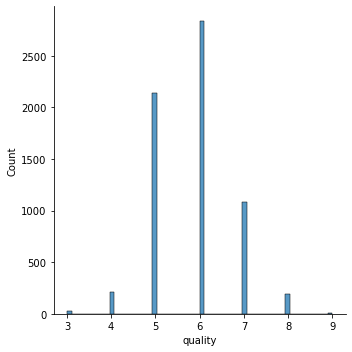

In [11]:
import seaborn as sns
sns.displot(data.quality, kde=False)

Looks like quality scores are normally distributed between 3 and 9.

Define a wine as high quality if it has quality >= 7.

In [12]:
high_quality = (data.quality >= 7).astype(int)
data.quality = high_quality

Box plots are useful for identifying correlations between features and a binary label. Create box plots for each feature to compare high-quality and low-quality wines. Significant differences in the box plots indicate good predictors of quality.

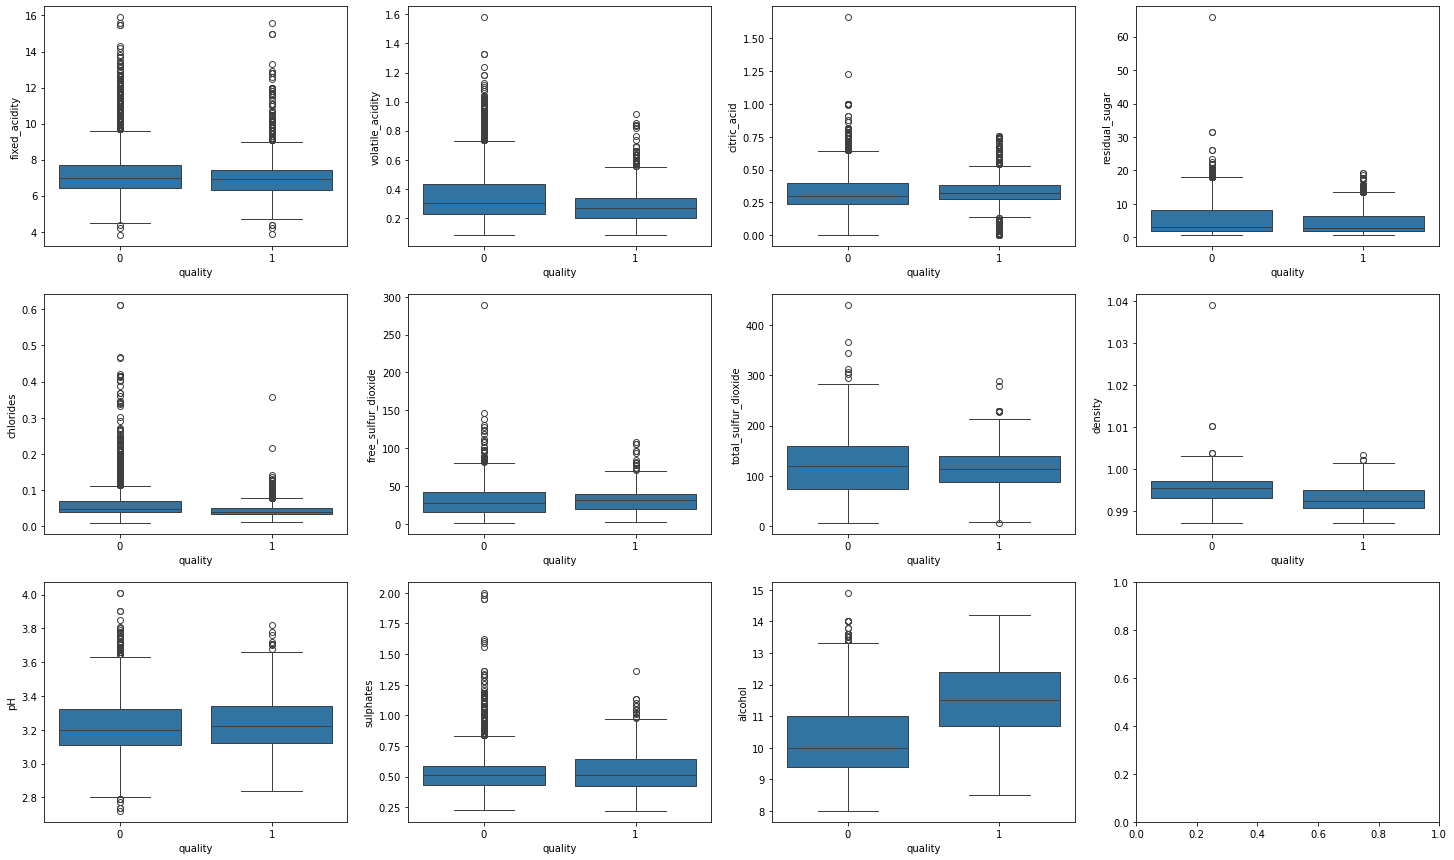

In [13]:
import matplotlib.pyplot as plt

dims = (3, 4)

f, axes = plt.subplots(dims[0], dims[1], figsize=(25, 15))
axis_i, axis_j = 0, 0
for col in data.columns:
  if col == 'is_red' or col == 'quality':
    continue # Box plots cannot be used on indicator variables
  sns.boxplot(x=high_quality, y=data[col], ax=axes[axis_i, axis_j])
  axis_j += 1
  if axis_j == dims[1]:
    axis_i += 1
    axis_j = 0

In the above box plots, a few variables stand out as good univariate predictors of quality.

In the alcohol box plot, the median alcohol content of high quality wines is greater than even the 75th quantile of low quality wines. High alcohol content is correlated with quality.
In the density box plot, low quality wines have a greater density than high quality wines. Density is inversely correlated with quality.

# Preprocess data
Before training a model, check for missing values and split the data into training and validation sets.

In [14]:
data.isna().any()

fixed_acidity           False
volatile_acidity        False
citric_acid             False
residual_sugar          False
chlorides               False
free_sulfur_dioxide     False
total_sulfur_dioxide    False
density                 False
pH                      False
sulphates               False
alcohol                 False
quality                 False
is_red                  False
dtype: bool

There are no missing values.

# Prepare the dataset to train a baseline model
Split the input data into 3 sets:

Train (60% of the dataset used to train the model)
Validation (20% of the dataset used to tune the hyperparameters)
Test (20% of the dataset used to report the true performance of the model on an unseen dataset)

In [15]:
from sklearn.model_selection import train_test_split

X = data.drop(["quality"], axis=1)
y = data.quality

# Split out the training data
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.6, random_state=123)

# Split the remaining data equally into validation and test
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=123)

# Train a baseline model
This task seems well suited to a random forest classifier, since the output is binary and there may be interactions between multiple variables.

Build a simple classifier using scikit-learn and use MLflow to keep track of the model's accuracy and save the model for later use.

In [16]:
import os
os.environ['MLFLOW_S3_ENDPOINT_URL'] = "http://172.19.164.128:9000"
os.environ['MLFLOW_ARTIFACT_URI'] = "s3://mlflow-artifacts/mlflow"
os.environ['AWS_ACCESS_KEY_ID'] = "zL8jRR2H28UZ6k2ZSTGe"
os.environ['AWS_SECRET_ACCESS_KEY'] = "0g23JxsUWV9LovRCuXZbazkMwXgXpEd7kPuKbCxc" 

In [17]:


# The predict method of sklearn's RandomForestClassifier returns a binary classification (0 or 1). 
# The following code creates a wrapper function, SklearnModelWrapper, that uses 
# the predict_proba method to return the probability that the observation belongs to each class. 

class SklearnModelWrapper(mlflow.pyfunc.PythonModel):
    def __init__(self, model):
        self.model = model
    
    def predict(self, context, model_input):
        return self.model.predict_proba(model_input)[:,1]

# mlflow.start_run creates a new MLflow run to track the performance of this model. 
# Within the context, you call mlflow.log_param to keep track of the parameters used, and
# mlflow.log_metric to record metrics like accuracy.
with mlflow.start_run(run_name='untuned_random_forest'):
    n_estimators = 10
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=np.random.RandomState(123))
    model.fit(X_train, y_train)

    # predict_proba returns [prob_negative, prob_positive], so slice the output with [:, 1]
    predictions_test = model.predict_proba(X_test)[:,1]
    auc_score = roc_auc_score(y_test, predictions_test)
    mlflow.log_param('n_estimators', n_estimators)
    # Use the area under the ROC curve as a metric.
    mlflow.log_metric('auc', auc_score)
    wrappedModel = SklearnModelWrapper(model)
    # Log the model with a signature that defines the schema of the model's inputs and outputs. 
    # When the model is deployed, this signature will be used to validate inputs.
    signature = infer_signature(X_train, wrappedModel.predict(None, X_train))
  
    # MLflow contains utilities to create a conda environment used to serve models.
    # The necessary dependencies are added to a conda.yaml file which is logged along with the model.
    conda_env =  _mlflow_conda_env(
        additional_conda_deps=None,
        additional_pip_deps=["cloudpickle=={}".format(cloudpickle.__version__), "scikit-learn=={}".format(sklearn.__version__)],
        additional_conda_channels=None,
    )
    mlflow.pyfunc.log_model("random_forest_model", python_model=wrappedModel, conda_env=conda_env, signature=signature)

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/08/12 15:17:08 INFO mlflow.tracking._tracking_service.client: 🏃 View ru

In [18]:
feature_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns.tolist(), columns=['importance'])
feature_importances.sort_values('importance', ascending=False)

,importance
alcohol,0.160192
density,0.117415
volatile_acidity,0.093136
chlorides,0.086618
residual_sugar,0.082544
free_sulfur_dioxide,0.080473
pH,0.080212
total_sulfur_dioxide,0.077798
sulphates,0.075780
citric_acid,0.071857


You logged the Area Under the ROC Curve (AUC) to MLflow. Click the Experiment icon  in the right sidebar to display the Experiment Runs sidebar.

The model achieved an AUC of 0.854.

A random classifier would have an AUC of 0.5, and higher AUC values are better. For more information, see Receiver Operating Characteristic Curve.

# Register the model to Unity Catalog
By registering this model to Unity Catalog, you can easily reference the model from anywhere within Databricks.

The following section shows how to do this programmatically, but you can also register a model using the UI.



In [19]:
run_id = mlflow.search_runs(filter_string='tags.mlflow.runName = "untuned_random_forest"').iloc[0].run_id

In [20]:
# Register the model to Unity Catalog. 
model_name = f"{CATALOG_NAME}.{SCHEMA_NAME}.wine_quality"
model_version = mlflow.register_model(f"runs:/{run_id}/random_forest_model", model_name)

# Registering the model takes a few seconds, so add a small delay
time.sleep(15)

Successfully registered model 'main.default.wine_quality'.
2024/08/12 15:17:10 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: main.default.wine_quality, version 1
Created version '1' of model 'main.default.wine_quality'.


In [21]:
model_name, model_version

('main.default.wine_quality',
 <ModelVersion: aliases=[], creation_timestamp=1723450630425, current_stage='None', description='', last_updated_timestamp=1723450630425, name='main.default.wine_quality', run_id='96e80d270fa94accb84d0dcb67584dd4', run_link='', source='s3://mlflow-artifacts/mlflow/2/96e80d270fa94accb84d0dcb67584dd4/artifacts/random_forest_model', status='READY', status_message='', tags={}, user_id='', version='1'>)

In [22]:


client = MlflowClient()
client.set_registered_model_alias(model_name, "Champion", model_version.version)

In Unity Catalog, the model version now has the tag "Champion".

You can now refer to the model using the path "models:/{model_name}@Champion".

In [23]:
model = mlflow.pyfunc.load_model(f"models:/{model_name}@Champion")

# Sanity-check: This should match the AUC logged by MLflow
print(f'AUC: {roc_auc_score(y_test, model.predict(X_test))}')

AUC: 0.8540300975814177


# Experiment with a new model
The random forest model performed well even without hyperparameter tuning.

Use the xgboost library to train a more accurate model. Run a hyperparameter sweep to train multiple models in parallel, using Hyperopt and SparkTrials. As before, MLflow tracks the performance of each parameter configuration.

In [24]:
#!pip install hyperopt

In [25]:
#!pip install xgboost

In [26]:
mlflow.config.set_tracking_uri(remote_server_uri)

In [27]:
mlflow.get_registry_uri()

'http://localhost:5005'

In [28]:
mlflow.get_tracking_uri()

'http://localhost:5005'

In [29]:
train = xgb.DMatrix(data=X_train, label=y_train)
validation = xgb.DMatrix(data=X_val, label=y_val)

In [30]:
def get_or_create_experiment(experiment_name):
    """
    Retrieve the ID of an existing MLflow experiment or create a new one if it doesn't exist.

    This function checks if an experiment with the given name exists within MLflow.
    If it does, the function returns its ID. If not, it creates a new experiment
    with the provided name and returns its ID.

    Parameters:
    - experiment_name (str): Name of the MLflow experiment.

    Returns:
    - str: ID of the existing or newly created MLflow experiment.
    """

    if experiment := mlflow.get_experiment_by_name(experiment_name):
        return experiment.experiment_id
    else:
        return mlflow.create_experiment(experiment_name)


In [31]:
experiment_id = get_or_create_experiment("experiment winequality")

In [32]:
import optuna

In [33]:
# override Optuna's default logging to ERROR only
optuna.logging.set_verbosity(optuna.logging.ERROR)

# define a logging callback that will report on only new challenger parameter configurations if a
# trial has usurped the state of 'best conditions'


def champion_callback(study, frozen_trial):
    """
    Logging callback that will report when a new trial iteration improves upon existing
    best trial values.

    Note: This callback is not intended for use in distributed computing systems such as Spark
    or Ray due to the micro-batch iterative implementation for distributing trials to a cluster's
    workers or agents.
    The race conditions with file system state management for distributed trials will render
    inconsistent values with this callback.
    """

    winner = study.user_attrs.get("winner", None)

    if study.best_value and winner != study.best_value:
        study.set_user_attr("winner", study.best_value)
        if winner:
            improvement_percent = (abs(winner - study.best_value) / study.best_value) * 100
            print(
                f"Trial {frozen_trial.number} achieved value: {frozen_trial.value} with "
                f"{improvement_percent: .4f}% improvement"
            )
        else:
            print(f"Initial trial {frozen_trial.number} achieved value: {frozen_trial.value}")


In [35]:
def objective(trial):
    with mlflow.start_run(nested=True):
        # Define hyperparameters
        params = {
            'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1, log=True),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 1e-1, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-6, 1e-1, log=True),
            'min_child_weight': trial.suggest_float('min_child_weight', 1e-1, 3, log=True),
            'objective': 'binary:logistic',
            'seed': 123, # Set a seed for deterministic training
        }
        
        # params = {
        #     "objective": "reg:squarederror",
        #     "eval_metric": "rmse",
        #     "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        #     "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        #     "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # }



        # if params["booster"] == "gbtree" or params["booster"] == "dart":
        #     params["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        #     params["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        #     params["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        #     params["grow_policy"] = trial.suggest_categorical(
        #         "grow_policy", ["depthwise", "lossguide"]
        #     )

        # Train XGBoost model
        # train = xgb.DMatrix(data=X_train, label=y_train)
        # validation = xgb.DMatrix(data=X_val, label=y_val)
        # Pass in the validation set so xgb can track an evaluation metric. XGBoost terminates training when the evaluation metric
        # is no longer improving.
        booster = xgb.train(params=params, dtrain=train, num_boost_round=1000,\
                        evals=[(validation, "validation")], early_stopping_rounds=50)
        validation_predictions = booster.predict(validation)
        auc_score = roc_auc_score(y_val, validation_predictions)
        mlflow.log_metric('auc', auc_score)

        signature = infer_signature(X_train, booster.predict(train))
        mlflow.xgboost.log_model(booster, "model", signature=signature)
    
        # Set the loss to -1*auc_score so fmin maximizes the auc_score
        return auc_score



In [36]:
# Initiate the parent run and call the hyperparameter tuning child run logic
with mlflow.start_run(experiment_id=experiment_id, run_name="tuning_xgboost_model", nested=True):
    # Initialize the Optuna study
    study = optuna.create_study(direction="maximize")

    # Execute the hyperparameter optimization trials.
    # Note the addition of the `champion_callback` inclusion to control our logging
    study.optimize(objective, n_trials=500, callbacks=[champion_callback])

    mlflow.log_params(study.best_params)
    mlflow.log_metric("best_auc", study.best_value)
    # Log tags
    mlflow.set_tags(
        tags={
            "project": "winequality",
            "optimizer_engine": "optuna",
            "model_family": "xgboost",
            "feature_set_version": 1,
        }
    )
    # Log a fit model instance
    model = xgb.train(study.best_params, train)

    artifact_path = "model"

    mlflow.xgboost.log_model(
        xgb_model=model,
        artifact_path=artifact_path,
        input_example=X_train.iloc[[0]],
        model_format="ubj",
        metadata={"model_data_version": 1},
    )

    # Get the logged model uri so that we can load it from the artifact store
    model_uri = mlflow.get_artifact_uri(artifact_path)


[0]	validation-logloss:0.45526
[1]	validation-logloss:0.43040
[2]	validation-logloss:0.40749
[3]	validation-logloss:0.38937
[4]	validation-logloss:0.37723
[5]	validation-logloss:0.36587
[6]	validation-logloss:0.35594
[7]	validation-logloss:0.34857
[8]	validation-logloss:0.34243
[9]	validation-logloss:0.33661
[10]	validation-logloss:0.33112
[11]	validation-logloss:0.32878
[12]	validation-logloss:0.32844
[13]	validation-logloss:0.32634
[14]	validation-logloss:0.32253
[15]	validation-logloss:0.32129
[16]	validation-logloss:0.31841
[17]	validation-logloss:0.31737
[18]	validation-logloss:0.31749
[19]	validation-logloss:0.31674
[20]	validation-logloss:0.31534
[21]	validation-logloss:0.31512
[22]	validation-logloss:0.31399
[23]	validation-logloss:0.31494
[24]	validation-logloss:0.31482
[25]	validation-logloss:0.31551
[26]	validation-logloss:0.31669
[27]	validation-logloss:0.31704
[28]	validation-logloss:0.31730


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[29]	validation-logloss:0.31822
[30]	validation-logloss:0.31911
[31]	validation-logloss:0.31951
[32]	validation-logloss:0.31942
[33]	validation-logloss:0.32034
[34]	validation-logloss:0.32170
[35]	validation-logloss:0.32221
[36]	validation-logloss:0.32218
[37]	validation-logloss:0.32268
[38]	validation-logloss:0.32322
[39]	validation-logloss:0.32345
[40]	validation-logloss:0.32542
[41]	validation-logloss:0.32604
[42]	validation-logloss:0.32690
[43]	validation-logloss:0.32800
[44]	validation-logloss:0.32824
[45]	validation-logloss:0.32767
[46]	validation-logloss:0.32728
[47]	validation-logloss:0.32808
[48]	validation-logloss:0.32953
[49]	validation-logloss:0.33051
[50]	validation-logloss:0.33090
[51]	validation-logloss:0.33175
[52]	validation-logloss:0.33216
[53]	validation-logloss:0.33277
[54]	validation-logloss:0.33317
[55]	validation-logloss:0.33286
[56]	validation-logloss:0.33268
[57]	validation-logloss:0.33254
[58]	validation-logloss:0.33249
[59]	validation-logloss:0.33349
[60]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:17:27] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

Initial trial 0 achieved value: 0.895833654038577
[0]	validation-logloss:0.49386
[1]	validation-logloss:0.46101
[2]	validation-logloss:0.46142
[3]	validation-logloss:0.46357
[4]	validation-logloss:0.47423
[5]	validation-logloss:0.47446
[6]	validation-logloss:0.48072
[7]	validation-logloss:0.48427
[8]	validation-logloss:0.49625
[9]	validation-logloss:0.50590
[10]	validation-logloss:0.51905
[11]	validation-logloss:0.51547
[12]	validation-logloss:0.52215
[13]	validation-logloss:0.52476
[14]	validation-logloss:0.52566
[15]	validation-logloss:0.52765
[16]	validation-logloss:0.52500
[17]	validation-logloss:0.52774
[18]	validation-logloss:0.52904
[19]	validation-logloss:0.53529
[20]	validation-logloss:0.53529
[21]	validation-logloss:0.53425
[22]	validation-logloss:0.53726
[23]	validation-logloss:0.53963
[24]	validation-logloss:0.54349
[25]	validation-logloss:0.54358
[26]	validation-logloss:0.53966
[27]	validation-logloss:0.53976
[28]	validation-logloss:0.54100
[29]	validation-logloss:0.54127


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-

[0]	validation-logloss:0.49009
[1]	validation-logloss:0.48898
[2]	validation-logloss:0.48788
[3]	validation-logloss:0.48677
[4]	validation-logloss:0.48567
[5]	validation-logloss:0.48463
[6]	validation-logloss:0.48356
[7]	validation-logloss:0.48250
[8]	validation-logloss:0.48147
[9]	validation-logloss:0.48045
[10]	validation-logloss:0.47943
[11]	validation-logloss:0.47850
[12]	validation-logloss:0.47749
[13]	validation-logloss:0.47653
[14]	validation-logloss:0.47555
[15]	validation-logloss:0.47461
[16]	validation-logloss:0.47365
[17]	validation-logloss:0.47270
[18]	validation-logloss:0.47179
[19]	validation-logloss:0.47088
[20]	validation-logloss:0.46996
[21]	validation-logloss:0.46908
[22]	validation-logloss:0.46817
[23]	validation-logloss:0.46726
[24]	validation-logloss:0.46635
[25]	validation-logloss:0.46547


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[26]	validation-logloss:0.46457
[27]	validation-logloss:0.46369
[28]	validation-logloss:0.46286
[29]	validation-logloss:0.46198
[30]	validation-logloss:0.46112
[31]	validation-logloss:0.46030
[32]	validation-logloss:0.45947
[33]	validation-logloss:0.45865
[34]	validation-logloss:0.45784
[35]	validation-logloss:0.45701
[36]	validation-logloss:0.45625
[37]	validation-logloss:0.45551
[38]	validation-logloss:0.45472
[39]	validation-logloss:0.45398
[40]	validation-logloss:0.45323
[41]	validation-logloss:0.45248
[42]	validation-logloss:0.45178
[43]	validation-logloss:0.45106
[44]	validation-logloss:0.45032
[45]	validation-logloss:0.44962
[46]	validation-logloss:0.44888
[47]	validation-logloss:0.44817
[48]	validation-logloss:0.44749
[49]	validation-logloss:0.44687
[50]	validation-logloss:0.44619
[51]	validation-logloss:0.44549
[52]	validation-logloss:0.44476
[53]	validation-logloss:0.44413
[54]	validation-logloss:0.44344
[55]	validation-logloss:0.44277
[56]	validation-logloss:0.44207
[57]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:17:41] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.47616
[1]	validation-logloss:0.46451
[2]	validation-logloss:0.45484
[3]	validation-logloss:0.44585
[4]	validation-logloss:0.43708
[5]	validation-logloss:0.42931
[6]	validation-logloss:0.42213
[7]	validation-logloss:0.41562
[8]	validation-logloss:0.40935
[9]	validation-logloss:0.40369
[10]	validation-logloss:0.39809
[11]	validation-logloss:0.39285
[12]	validation-logloss:0.38894
[13]	validation-logloss:0.38407
[14]	validation-logloss:0.38017
[15]	validation-logloss:0.37549
[16]	validation-logloss:0.37106
[17]	validation-logloss:0.36697
[18]	validation-logloss:0.36288
[19]	validation-logloss:0.35957
[20]	validation-logloss:0.35669
[21]	validation-logloss:0.35372
[22]	validation-logloss:0.35079
[23]	validation-logloss:0.34806
[24]	validation-logloss:0.34636
[25]	validation-logloss:0.34411
[26]	validation-logloss:0.34222
[27]	validation-logloss:0.34067


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[28]	validation-logloss:0.33886
[29]	validation-logloss:0.33741
[30]	validation-logloss:0.33639
[31]	validation-logloss:0.33517
[32]	validation-logloss:0.33394
[33]	validation-logloss:0.33311
[34]	validation-logloss:0.33209
[35]	validation-logloss:0.33115
[36]	validation-logloss:0.33022
[37]	validation-logloss:0.32944
[38]	validation-logloss:0.32844
[39]	validation-logloss:0.32791
[40]	validation-logloss:0.32755
[41]	validation-logloss:0.32704
[42]	validation-logloss:0.32663
[43]	validation-logloss:0.32603
[44]	validation-logloss:0.32570
[45]	validation-logloss:0.32534
[46]	validation-logloss:0.32459
[47]	validation-logloss:0.32416
[48]	validation-logloss:0.32356
[49]	validation-logloss:0.32333
[50]	validation-logloss:0.32327
[51]	validation-logloss:0.32290
[52]	validation-logloss:0.32253
[53]	validation-logloss:0.32228
[54]	validation-logloss:0.32236
[55]	validation-logloss:0.32236
[56]	validation-logloss:0.32226
[57]	validation-logloss:0.32218
[58]	validation-logloss:0.32195
[59]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:17:45] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41352
[1]	validation-logloss:0.39812
[2]	validation-logloss:0.39368
[3]	validation-logloss:0.39454
[4]	validation-logloss:0.39559
[5]	validation-logloss:0.40949
[6]	validation-logloss:0.41060
[7]	validation-logloss:0.41342
[8]	validation-logloss:0.41712
[9]	validation-logloss:0.41708
[10]	validation-logloss:0.41665
[11]	validation-logloss:0.42100
[12]	validation-logloss:0.42606
[13]	validation-logloss:0.42430
[14]	validation-logloss:0.42829
[15]	validation-logloss:0.43378
[16]	validation-logloss:0.43591
[17]	validation-logloss:0.43925
[18]	validation-logloss:0.44480
[19]	validation-logloss:0.44845
[20]	validation-logloss:0.45372
[21]	validation-logloss:0.45318
[22]	validation-logloss:0.45269
[23]	validation-logloss:0.45811
[24]	validation-logloss:0.46078
[25]	validation-logloss:0.46106
[26]	validation-logloss:0.46117
[27]	validation-logloss:0.46324
[28]	validation-logloss:0.46336
[29]	validation-logloss:0.46323
[30]	validation-logloss:0.46390
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[34]	validation-logloss:0.46697
[35]	validation-logloss:0.46823
[36]	validation-logloss:0.46959
[37]	validation-logloss:0.47190
[38]	validation-logloss:0.47080
[39]	validation-logloss:0.47192
[40]	validation-logloss:0.47084
[41]	validation-logloss:0.47235
[42]	validation-logloss:0.47350
[43]	validation-logloss:0.47368
[44]	validation-logloss:0.47434
[45]	validation-logloss:0.47678
[46]	validation-logloss:0.47964
[47]	validation-logloss:0.48020
[48]	validation-logloss:0.48204
[49]	validation-logloss:0.48131
[50]	validation-logloss:0.48187
[51]	validation-logloss:0.48273
[52]	validation-logloss:0.48277


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:17:48] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.48442
[1]	validation-logloss:0.47801
[2]	validation-logloss:0.47197
[3]	validation-logloss:0.46624
[4]	validation-logloss:0.46111
[5]	validation-logloss:0.45585
[6]	validation-logloss:0.45063
[7]	validation-logloss:0.44569
[8]	validation-logloss:0.44124
[9]	validation-logloss:0.43663
[10]	validation-logloss:0.43242
[11]	validation-logloss:0.42840
[12]	validation-logloss:0.42475
[13]	validation-logloss:0.42116
[14]	validation-logloss:0.41776
[15]	validation-logloss:0.41468
[16]	validation-logloss:0.41161
[17]	validation-logloss:0.40828
[18]	validation-logloss:0.40536
[19]	validation-logloss:0.40276
[20]	validation-logloss:0.39997
[21]	validation-logloss:0.39742
[22]	validation-logloss:0.39439
[23]	validation-logloss:0.39201
[24]	validation-logloss:0.38946
[25]	validation-logloss:0.38729
[26]	validation-logloss:0.38498
[27]	validation-logloss:0.38290
[28]	validation-logloss:0.38081
[29]	validation-logloss:0.37891
[30]	validation-logloss:0.37697
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[52]	validation-logloss:0.34830
[53]	validation-logloss:0.34728
[54]	validation-logloss:0.34645
[55]	validation-logloss:0.34532
[56]	validation-logloss:0.34450
[57]	validation-logloss:0.34346
[58]	validation-logloss:0.34272
[59]	validation-logloss:0.34213
[60]	validation-logloss:0.34132
[61]	validation-logloss:0.34057
[62]	validation-logloss:0.33994
[63]	validation-logloss:0.33942
[64]	validation-logloss:0.33895
[65]	validation-logloss:0.33789
[66]	validation-logloss:0.33709
[67]	validation-logloss:0.33612
[68]	validation-logloss:0.33555
[69]	validation-logloss:0.33482
[70]	validation-logloss:0.33372
[71]	validation-logloss:0.33289
[72]	validation-logloss:0.33214
[73]	validation-logloss:0.33165
[74]	validation-logloss:0.33085
[75]	validation-logloss:0.33037
[76]	validation-logloss:0.32982
[77]	validation-logloss:0.32954
[78]	validation-logloss:0.32903
[79]	validation-logloss:0.32871
[80]	validation-logloss:0.32824
[81]	validation-logloss:0.32763
[82]	validation-logloss:0.32709
[83]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:17:51] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

Trial 5 achieved value: 0.895952956389218 with  0.0133% improvement
[0]	validation-logloss:0.48547
[1]	validation-logloss:0.47953
[2]	validation-logloss:0.47408
[3]	validation-logloss:0.46900
[4]	validation-logloss:0.46452
[5]	validation-logloss:0.46048
[6]	validation-logloss:0.45607
[7]	validation-logloss:0.45172
[8]	validation-logloss:0.44676
[9]	validation-logloss:0.44219
[10]	validation-logloss:0.43765
[11]	validation-logloss:0.43381
[12]	validation-logloss:0.42996
[13]	validation-logloss:0.42648
[14]	validation-logloss:0.42333
[15]	validation-logloss:0.41939
[16]	validation-logloss:0.41603
[17]	validation-logloss:0.41276
[18]	validation-logloss:0.40967
[19]	validation-logloss:0.40682
[20]	validation-logloss:0.40418
[21]	validation-logloss:0.40150
[22]	validation-logloss:0.39877
[23]	validation-logloss:0.39626
[24]	validation-logloss:0.39363
[25]	validation-logloss:0.39126
[26]	validation-logloss:0.38873
[27]	validation-logloss:0.38652
[28]	validation-logloss:0.38436
[29]	validatio

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[43]	validation-logloss:0.35631
[44]	validation-logloss:0.35477
[45]	validation-logloss:0.35313
[46]	validation-logloss:0.35176
[47]	validation-logloss:0.35025
[48]	validation-logloss:0.34893
[49]	validation-logloss:0.34761
[50]	validation-logloss:0.34631
[51]	validation-logloss:0.34518
[52]	validation-logloss:0.34402
[53]	validation-logloss:0.34286
[54]	validation-logloss:0.34176
[55]	validation-logloss:0.34070
[56]	validation-logloss:0.33982
[57]	validation-logloss:0.33883
[58]	validation-logloss:0.33781
[59]	validation-logloss:0.33687
[60]	validation-logloss:0.33595
[61]	validation-logloss:0.33497
[62]	validation-logloss:0.33424
[63]	validation-logloss:0.33319
[64]	validation-logloss:0.33234
[65]	validation-logloss:0.33127
[66]	validation-logloss:0.33040
[67]	validation-logloss:0.32956
[68]	validation-logloss:0.32900
[69]	validation-logloss:0.32808
[70]	validation-logloss:0.32746
[71]	validation-logloss:0.32660
[72]	validation-logloss:0.32595
[73]	validation-logloss:0.32535
[74]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:17:56] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

Trial 6 achieved value: 0.8966572251042932 with  0.0785% improvement


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[0]	validation-logloss:0.41405
[1]	validation-logloss:0.38326
[2]	validation-logloss:0.37671
[3]	validation-logloss:0.36558
[4]	validation-logloss:0.36645
[5]	validation-logloss:0.37246
[6]	validation-logloss:0.36830
[7]	validation-logloss:0.37044
[8]	validation-logloss:0.37021
[9]	validation-logloss:0.36872
[10]	validation-logloss:0.37047
[11]	validation-logloss:0.37407
[12]	validation-logloss:0.37706
[13]	validation-logloss:0.37929
[14]	validation-logloss:0.38112
[15]	validation-logloss:0.38616
[16]	validation-logloss:0.38903
[17]	validation-logloss:0.39084
[18]	validation-logloss:0.39454
[19]	validation-logloss:0.39383
[20]	validation-logloss:0.39552
[21]	validation-logloss:0.39531
[22]	validation-logloss:0.39815
[23]	validation-logloss:0.40013
[24]	validation-logloss:0.40158
[25]	validation-logloss:0.40201
[26]	validation-logloss:0.40342
[27]	validation-logloss:0.40687
[28]	validation-logloss:0.40829
[29]	validation-logloss:0.41009
[30]	validation-logloss:0.41050
[31]	validation-lo

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:17:59] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40763
[1]	validation-logloss:0.36952
[2]	validation-logloss:0.35279
[3]	validation-logloss:0.33976
[4]	validation-logloss:0.33578
[5]	validation-logloss:0.33864
[6]	validation-logloss:0.33763
[7]	validation-logloss:0.33815
[8]	validation-logloss:0.34169
[9]	validation-logloss:0.35024
[10]	validation-logloss:0.35658
[11]	validation-logloss:0.35893
[12]	validation-logloss:0.36363
[13]	validation-logloss:0.36777
[14]	validation-logloss:0.37174
[15]	validation-logloss:0.37748
[16]	validation-logloss:0.37940
[17]	validation-logloss:0.38029
[18]	validation-logloss:0.38296
[19]	validation-logloss:0.38646
[20]	validation-logloss:0.38745
[21]	validation-logloss:0.39057
[22]	validation-logloss:0.39384
[23]	validation-logloss:0.39645
[24]	validation-logloss:0.39881
[25]	validation-logloss:0.40170
[26]	validation-logloss:0.40153
[27]	validation-logloss:0.40232
[28]	validation-logloss:0.40405
[29]	validation-logloss:0.40408
[30]	validation-logloss:0.40552
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[43]	validation-logloss:0.41415
[44]	validation-logloss:0.41493
[45]	validation-logloss:0.41620
[46]	validation-logloss:0.41679
[47]	validation-logloss:0.41613
[48]	validation-logloss:0.41388
[49]	validation-logloss:0.41516
[50]	validation-logloss:0.41607
[51]	validation-logloss:0.41638
[52]	validation-logloss:0.41784
[53]	validation-logloss:0.41894


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:18:02] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.49075
[1]	validation-logloss:0.49029
[2]	validation-logloss:0.48983
[3]	validation-logloss:0.48937
[4]	validation-logloss:0.48890
[5]	validation-logloss:0.48845
[6]	validation-logloss:0.48798
[7]	validation-logloss:0.48752
[8]	validation-logloss:0.48705
[9]	validation-logloss:0.48659
[10]	validation-logloss:0.48613
[11]	validation-logloss:0.48566
[12]	validation-logloss:0.48521
[13]	validation-logloss:0.48479
[14]	validation-logloss:0.48435
[15]	validation-logloss:0.48393
[16]	validation-logloss:0.48350
[17]	validation-logloss:0.48306
[18]	validation-logloss:0.48264
[19]	validation-logloss:0.48219
[20]	validation-logloss:0.48180
[21]	validation-logloss:0.48139
[22]	validation-logloss:0.48098
[23]	validation-logloss:0.48056
[24]	validation-logloss:0.48013
[25]	validation-logloss:0.47970
[26]	validation-logloss:0.47930
[27]	validation-logloss:0.47886
[28]	validation-logloss:0.47846
[29]	validation-logloss:0.47803
[30]	validation-logloss:0.47762
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[35]	validation-logloss:0.47551
[36]	validation-logloss:0.47510
[37]	validation-logloss:0.47469
[38]	validation-logloss:0.47427
[39]	validation-logloss:0.47388
[40]	validation-logloss:0.47346
[41]	validation-logloss:0.47305
[42]	validation-logloss:0.47265
[43]	validation-logloss:0.47222
[44]	validation-logloss:0.47183
[45]	validation-logloss:0.47144
[46]	validation-logloss:0.47104
[47]	validation-logloss:0.47066
[48]	validation-logloss:0.47028
[49]	validation-logloss:0.46990
[50]	validation-logloss:0.46951
[51]	validation-logloss:0.46913
[52]	validation-logloss:0.46878
[53]	validation-logloss:0.46839
[54]	validation-logloss:0.46802
[55]	validation-logloss:0.46766
[56]	validation-logloss:0.46729
[57]	validation-logloss:0.46693
[58]	validation-logloss:0.46657
[59]	validation-logloss:0.46620
[60]	validation-logloss:0.46585
[61]	validation-logloss:0.46549
[62]	validation-logloss:0.46514
[63]	validation-logloss:0.46478
[64]	validation-logloss:0.46444
[65]	validation-logloss:0.46409
[66]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:18:12] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.48933
[1]	validation-logloss:0.48749
[2]	validation-logloss:0.48569
[3]	validation-logloss:0.48394
[4]	validation-logloss:0.48220
[5]	validation-logloss:0.48054
[6]	validation-logloss:0.47887
[7]	validation-logloss:0.47728
[8]	validation-logloss:0.47567
[9]	validation-logloss:0.47409
[10]	validation-logloss:0.47255
[11]	validation-logloss:0.47114
[12]	validation-logloss:0.46967
[13]	validation-logloss:0.46829
[14]	validation-logloss:0.46686
[15]	validation-logloss:0.46545
[16]	validation-logloss:0.46417
[17]	validation-logloss:0.46277
[18]	validation-logloss:0.46153
[19]	validation-logloss:0.46017
[20]	validation-logloss:0.45890
[21]	validation-logloss:0.45772
[22]	validation-logloss:0.45645
[23]	validation-logloss:0.45520
[24]	validation-logloss:0.45409
[25]	validation-logloss:0.45288
[26]	validation-logloss:0.45177
[27]	validation-logloss:0.45071
[28]	validation-logloss:0.44961
[29]	validation-logloss:0.44848
[30]	validation-logloss:0.44739
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[45]	validation-logloss:0.43166
[46]	validation-logloss:0.43072
[47]	validation-logloss:0.42978
[48]	validation-logloss:0.42883
[49]	validation-logloss:0.42789
[50]	validation-logloss:0.42695
[51]	validation-logloss:0.42600
[52]	validation-logloss:0.42510
[53]	validation-logloss:0.42422
[54]	validation-logloss:0.42337
[55]	validation-logloss:0.42263
[56]	validation-logloss:0.42190
[57]	validation-logloss:0.42112
[58]	validation-logloss:0.42039
[59]	validation-logloss:0.41966
[60]	validation-logloss:0.41887
[61]	validation-logloss:0.41808
[62]	validation-logloss:0.41725
[63]	validation-logloss:0.41644
[64]	validation-logloss:0.41570
[65]	validation-logloss:0.41498
[66]	validation-logloss:0.41423
[67]	validation-logloss:0.41346
[68]	validation-logloss:0.41262
[69]	validation-logloss:0.41197
[70]	validation-logloss:0.41114
[71]	validation-logloss:0.41031
[72]	validation-logloss:0.40949
[73]	validation-logloss:0.40867
[74]	validation-logloss:0.40801
[75]	validation-logloss:0.40736
[76]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:18:18] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.48591
[1]	validation-logloss:0.48087
[2]	validation-logloss:0.47619
[3]	validation-logloss:0.47171
[4]	validation-logloss:0.46728
[5]	validation-logloss:0.46307
[6]	validation-logloss:0.45921
[7]	validation-logloss:0.45562
[8]	validation-logloss:0.45223
[9]	validation-logloss:0.44875
[10]	validation-logloss:0.44502
[11]	validation-logloss:0.44164
[12]	validation-logloss:0.43830
[13]	validation-logloss:0.43530
[14]	validation-logloss:0.43197
[15]	validation-logloss:0.42911
[16]	validation-logloss:0.42621
[17]	validation-logloss:0.42360
[18]	validation-logloss:0.42102
[19]	validation-logloss:0.41853
[20]	validation-logloss:0.41605
[21]	validation-logloss:0.41366
[22]	validation-logloss:0.41151
[23]	validation-logloss:0.40916
[24]	validation-logloss:0.40724
[25]	validation-logloss:0.40490
[26]	validation-logloss:0.40263
[27]	validation-logloss:0.40068
[28]	validation-logloss:0.39866
[29]	validation-logloss:0.39639
[30]	validation-logloss:0.39427
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[41]	validation-logloss:0.37598
[42]	validation-logloss:0.37467
[43]	validation-logloss:0.37307
[44]	validation-logloss:0.37183
[45]	validation-logloss:0.37039
[46]	validation-logloss:0.36919
[47]	validation-logloss:0.36802
[48]	validation-logloss:0.36688
[49]	validation-logloss:0.36574
[50]	validation-logloss:0.36471
[51]	validation-logloss:0.36371
[52]	validation-logloss:0.36253
[53]	validation-logloss:0.36152
[54]	validation-logloss:0.36076
[55]	validation-logloss:0.35952
[56]	validation-logloss:0.35861
[57]	validation-logloss:0.35770
[58]	validation-logloss:0.35654
[59]	validation-logloss:0.35570
[60]	validation-logloss:0.35461
[61]	validation-logloss:0.35396
[62]	validation-logloss:0.35329
[63]	validation-logloss:0.35239
[64]	validation-logloss:0.35145
[65]	validation-logloss:0.35080
[66]	validation-logloss:0.35009
[67]	validation-logloss:0.34956
[68]	validation-logloss:0.34868
[69]	validation-logloss:0.34803
[70]	validation-logloss:0.34734
[71]	validation-logloss:0.34670
[72]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:18:22] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.47614
[1]	validation-logloss:0.46316
[2]	validation-logloss:0.45134
[3]	validation-logloss:0.43968
[4]	validation-logloss:0.43053
[5]	validation-logloss:0.42216
[6]	validation-logloss:0.41459
[7]	validation-logloss:0.40745
[8]	validation-logloss:0.40093
[9]	validation-logloss:0.39485
[10]	validation-logloss:0.38891
[11]	validation-logloss:0.38399
[12]	validation-logloss:0.37901
[13]	validation-logloss:0.37516
[14]	validation-logloss:0.37128
[15]	validation-logloss:0.36790
[16]	validation-logloss:0.36444
[17]	validation-logloss:0.36099
[18]	validation-logloss:0.35784
[19]	validation-logloss:0.35498
[20]	validation-logloss:0.35210
[21]	validation-logloss:0.35002
[22]	validation-logloss:0.34720
[23]	validation-logloss:0.34460
[24]	validation-logloss:0.34284
[25]	validation-logloss:0.34093
[26]	validation-logloss:0.33887
[27]	validation-logloss:0.33724
[28]	validation-logloss:0.33562
[29]	validation-logloss:0.33323
[30]	validation-logloss:0.33163
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[40]	validation-logloss:0.32035
[41]	validation-logloss:0.31925
[42]	validation-logloss:0.31878
[43]	validation-logloss:0.31800
[44]	validation-logloss:0.31690
[45]	validation-logloss:0.31622
[46]	validation-logloss:0.31499
[47]	validation-logloss:0.31375
[48]	validation-logloss:0.31309
[49]	validation-logloss:0.31261
[50]	validation-logloss:0.31178
[51]	validation-logloss:0.31134
[52]	validation-logloss:0.31085
[53]	validation-logloss:0.31061
[54]	validation-logloss:0.31032
[55]	validation-logloss:0.30967
[56]	validation-logloss:0.30909
[57]	validation-logloss:0.30839
[58]	validation-logloss:0.30778
[59]	validation-logloss:0.30738
[60]	validation-logloss:0.30735
[61]	validation-logloss:0.30759
[62]	validation-logloss:0.30751
[63]	validation-logloss:0.30770
[64]	validation-logloss:0.30746
[65]	validation-logloss:0.30746
[66]	validation-logloss:0.30722
[67]	validation-logloss:0.30691
[68]	validation-logloss:0.30638
[69]	validation-logloss:0.30584
[70]	validation-logloss:0.30520
[71]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:18:26] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.48813
[1]	validation-logloss:0.48512
[2]	validation-logloss:0.48237
[3]	validation-logloss:0.47958
[4]	validation-logloss:0.47687
[5]	validation-logloss:0.47434
[6]	validation-logloss:0.47170
[7]	validation-logloss:0.46927
[8]	validation-logloss:0.46675
[9]	validation-logloss:0.46434
[10]	validation-logloss:0.46199
[11]	validation-logloss:0.45955
[12]	validation-logloss:0.45727
[13]	validation-logloss:0.45504
[14]	validation-logloss:0.45279
[15]	validation-logloss:0.45070
[16]	validation-logloss:0.44857
[17]	validation-logloss:0.44636
[18]	validation-logloss:0.44419
[19]	validation-logloss:0.44208
[20]	validation-logloss:0.44016
[21]	validation-logloss:0.43797
[22]	validation-logloss:0.43617
[23]	validation-logloss:0.43433
[24]	validation-logloss:0.43230
[25]	validation-logloss:0.43025
[26]	validation-logloss:0.42835
[27]	validation-logloss:0.42651
[28]	validation-logloss:0.42466
[29]	validation-logloss:0.42294
[30]	validation-logloss:0.42129
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[44]	validation-logloss:0.40140
[45]	validation-logloss:0.40030
[46]	validation-logloss:0.39923
[47]	validation-logloss:0.39794
[48]	validation-logloss:0.39672
[49]	validation-logloss:0.39556
[50]	validation-logloss:0.39419
[51]	validation-logloss:0.39292
[52]	validation-logloss:0.39172
[53]	validation-logloss:0.39050
[54]	validation-logloss:0.38940
[55]	validation-logloss:0.38818
[56]	validation-logloss:0.38708
[57]	validation-logloss:0.38591
[58]	validation-logloss:0.38483
[59]	validation-logloss:0.38370
[60]	validation-logloss:0.38255
[61]	validation-logloss:0.38154
[62]	validation-logloss:0.38040
[63]	validation-logloss:0.37942
[64]	validation-logloss:0.37828
[65]	validation-logloss:0.37732
[66]	validation-logloss:0.37644
[67]	validation-logloss:0.37551
[68]	validation-logloss:0.37460
[69]	validation-logloss:0.37362
[70]	validation-logloss:0.37283
[71]	validation-logloss:0.37183
[72]	validation-logloss:0.37096
[73]	validation-logloss:0.37008
[74]	validation-logloss:0.36914
[75]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:18:30] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.46749
[1]	validation-logloss:0.44767
[2]	validation-logloss:0.43216
[3]	validation-logloss:0.41743
[4]	validation-logloss:0.40445
[5]	validation-logloss:0.39363
[6]	validation-logloss:0.38511
[7]	validation-logloss:0.37674
[8]	validation-logloss:0.37006
[9]	validation-logloss:0.36333
[10]	validation-logloss:0.35726
[11]	validation-logloss:0.35160
[12]	validation-logloss:0.34663
[13]	validation-logloss:0.34288
[14]	validation-logloss:0.33871
[15]	validation-logloss:0.33566
[16]	validation-logloss:0.33250
[17]	validation-logloss:0.32851
[18]	validation-logloss:0.32664
[19]	validation-logloss:0.32437
[20]	validation-logloss:0.32184
[21]	validation-logloss:0.31954
[22]	validation-logloss:0.31733
[23]	validation-logloss:0.31612
[24]	validation-logloss:0.31462
[25]	validation-logloss:0.31297
[26]	validation-logloss:0.31209
[27]	validation-logloss:0.31155
[28]	validation-logloss:0.31075
[29]	validation-logloss:0.31034
[30]	validation-logloss:0.30932
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[38]	validation-logloss:0.30486
[39]	validation-logloss:0.30534
[40]	validation-logloss:0.30483
[41]	validation-logloss:0.30479
[42]	validation-logloss:0.30449
[43]	validation-logloss:0.30389
[44]	validation-logloss:0.30401
[45]	validation-logloss:0.30352
[46]	validation-logloss:0.30338
[47]	validation-logloss:0.30335
[48]	validation-logloss:0.30393
[49]	validation-logloss:0.30402
[50]	validation-logloss:0.30458
[51]	validation-logloss:0.30428
[52]	validation-logloss:0.30469
[53]	validation-logloss:0.30431
[54]	validation-logloss:0.30385
[55]	validation-logloss:0.30369
[56]	validation-logloss:0.30395
[57]	validation-logloss:0.30416
[58]	validation-logloss:0.30430
[59]	validation-logloss:0.30347
[60]	validation-logloss:0.30365
[61]	validation-logloss:0.30397
[62]	validation-logloss:0.30433
[63]	validation-logloss:0.30430
[64]	validation-logloss:0.30473
[65]	validation-logloss:0.30531
[66]	validation-logloss:0.30517
[67]	validation-logloss:0.30528
[68]	validation-logloss:0.30593
[69]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:18:33] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

Trial 14 achieved value: 0.8979156724804114 with  0.1402% improvement
[0]	validation-logloss:0.44132
[1]	validation-logloss:0.41111
[2]	validation-logloss:0.38579
[3]	validation-logloss:0.36815
[4]	validation-logloss:0.35465
[5]	validation-logloss:0.34305
[6]	validation-logloss:0.33354
[7]	validation-logloss:0.32913
[8]	validation-logloss:0.32498
[9]	validation-logloss:0.32099
[10]	validation-logloss:0.31719
[11]	validation-logloss:0.31622
[12]	validation-logloss:0.31639
[13]	validation-logloss:0.31647
[14]	validation-logloss:0.31625
[15]	validation-logloss:0.31884
[16]	validation-logloss:0.32078
[17]	validation-logloss:0.31905
[18]	validation-logloss:0.32078
[19]	validation-logloss:0.32250
[20]	validation-logloss:0.32390
[21]	validation-logloss:0.32471
[22]	validation-logloss:0.32588
[23]	validation-logloss:0.32786
[24]	validation-logloss:0.32852
[25]	validation-logloss:0.33097
[26]	validation-logloss:0.33245
[27]	validation-logloss:0.33433
[28]	validation-logloss:0.33608
[29]	validat

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[40]	validation-logloss:0.34685
[41]	validation-logloss:0.34755
[42]	validation-logloss:0.34860
[43]	validation-logloss:0.34929
[44]	validation-logloss:0.35097
[45]	validation-logloss:0.35168
[46]	validation-logloss:0.35333
[47]	validation-logloss:0.35344
[48]	validation-logloss:0.35443
[49]	validation-logloss:0.35526
[50]	validation-logloss:0.35656
[51]	validation-logloss:0.35662
[52]	validation-logloss:0.35779
[53]	validation-logloss:0.35857
[54]	validation-logloss:0.35988
[55]	validation-logloss:0.36048
[56]	validation-logloss:0.36149
[57]	validation-logloss:0.36174
[58]	validation-logloss:0.36191
[59]	validation-logloss:0.36193
[60]	validation-logloss:0.36272
[61]	validation-logloss:0.36304


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:18:36] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.46865
[1]	validation-logloss:0.44889
[2]	validation-logloss:0.43098
[3]	validation-logloss:0.41614


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[4]	validation-logloss:0.40338
[5]	validation-logloss:0.39362
[6]	validation-logloss:0.38240
[7]	validation-logloss:0.37402
[8]	validation-logloss:0.36518
[9]	validation-logloss:0.35776
[10]	validation-logloss:0.35207
[11]	validation-logloss:0.34768
[12]	validation-logloss:0.34312
[13]	validation-logloss:0.33842
[14]	validation-logloss:0.33342
[15]	validation-logloss:0.33051
[16]	validation-logloss:0.32796
[17]	validation-logloss:0.32613
[18]	validation-logloss:0.32356
[19]	validation-logloss:0.32187
[20]	validation-logloss:0.32056
[21]	validation-logloss:0.31931
[22]	validation-logloss:0.31700
[23]	validation-logloss:0.31647
[24]	validation-logloss:0.31474
[25]	validation-logloss:0.31281
[26]	validation-logloss:0.31201
[27]	validation-logloss:0.31082
[28]	validation-logloss:0.31007
[29]	validation-logloss:0.30998
[30]	validation-logloss:0.30976
[31]	validation-logloss:0.30937
[32]	validation-logloss:0.30989
[33]	validation-logloss:0.30941
[34]	validation-logloss:0.30907
[35]	validatio

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:18:39] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43646
[1]	validation-logloss:0.40349
[2]	validation-logloss:0.37661
[3]	validation-logloss:0.36269
[4]	validation-logloss:0.35383
[5]	validation-logloss:0.34669
[6]	validation-logloss:0.33664
[7]	validation-logloss:0.33246
[8]	validation-logloss:0.32852
[9]	validation-logloss:0.32285
[10]	validation-logloss:0.31917
[11]	validation-logloss:0.31659
[12]	validation-logloss:0.31537
[13]	validation-logloss:0.31334
[14]	validation-logloss:0.31362
[15]	validation-logloss:0.31524
[16]	validation-logloss:0.31601
[17]	validation-logloss:0.31701
[18]	validation-logloss:0.31679
[19]	validation-logloss:0.31777
[20]	validation-logloss:0.31858
[21]	validation-logloss:0.31687
[22]	validation-logloss:0.31910
[23]	validation-logloss:0.32124
[24]	validation-logloss:0.32088
[25]	validation-logloss:0.32206
[26]	validation-logloss:0.32362
[27]	validation-logloss:0.32493
[28]	validation-logloss:0.32522
[29]	validation-logloss:0.32566
[30]	validation-logloss:0.32652
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[51]	validation-logloss:0.33197
[52]	validation-logloss:0.33176
[53]	validation-logloss:0.33250
[54]	validation-logloss:0.33253
[55]	validation-logloss:0.33284
[56]	validation-logloss:0.33294
[57]	validation-logloss:0.33410
[58]	validation-logloss:0.33489
[59]	validation-logloss:0.33632
[60]	validation-logloss:0.33620
[61]	validation-logloss:0.33639
[62]	validation-logloss:0.33670
[63]	validation-logloss:0.33695


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:18:42] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

Trial 17 achieved value: 0.8980388232939764 with  0.0137% improvement
[0]	validation-logloss:0.43131
[1]	validation-logloss:0.39838
[2]	validation-logloss:0.37288
[3]	validation-logloss:0.35784
[4]	validation-logloss:0.34845
[5]	validation-logloss:0.34192
[6]	validation-logloss:0.33661
[7]	validation-logloss:0.33402
[8]	validation-logloss:0.32986
[9]	validation-logloss:0.32864
[10]	validation-logloss:0.32850
[11]	validation-logloss:0.32594
[12]	validation-logloss:0.32539
[13]	validation-logloss:0.32462
[14]	validation-logloss:0.32256
[15]	validation-logloss:0.32326
[16]	validation-logloss:0.32687
[17]	validation-logloss:0.32597
[18]	validation-logloss:0.32592
[19]	validation-logloss:0.32411
[20]	validation-logloss:0.32633
[21]	validation-logloss:0.32690
[22]	validation-logloss:0.32845
[23]	validation-logloss:0.32992
[24]	validation-logloss:0.33017
[25]	validation-logloss:0.33080
[26]	validation-logloss:0.33156
[27]	validation-logloss:0.33281
[28]	validation-logloss:0.33501
[29]	validat

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[56]	validation-logloss:0.35621
[57]	validation-logloss:0.35723
[58]	validation-logloss:0.35743
[59]	validation-logloss:0.35811
[60]	validation-logloss:0.35863
[61]	validation-logloss:0.35941
[62]	validation-logloss:0.36147
[63]	validation-logloss:0.36230


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:18:44] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.46361
[1]	validation-logloss:0.44156
[2]	validation-logloss:0.42059
[3]	validation-logloss:0.40359
[4]	validation-logloss:0.38997
[5]	validation-logloss:0.37845
[6]	validation-logloss:0.36902
[7]	validation-logloss:0.35942
[8]	validation-logloss:0.35124
[9]	validation-logloss:0.34334
[10]	validation-logloss:0.33896
[11]	validation-logloss:0.33395
[12]	validation-logloss:0.32979
[13]	validation-logloss:0.32567
[14]	validation-logloss:0.32171
[15]	validation-logloss:0.31914
[16]	validation-logloss:0.31690
[17]	validation-logloss:0.31460
[18]	validation-logloss:0.31400
[19]	validation-logloss:0.31279
[20]	validation-logloss:0.31101
[21]	validation-logloss:0.30942
[22]	validation-logloss:0.30845
[23]	validation-logloss:0.30803
[24]	validation-logloss:0.30764
[25]	validation-logloss:0.30753
[26]	validation-logloss:0.30889
[27]	validation-logloss:0.30911
[28]	validation-logloss:0.30933
[29]	validation-logloss:0.30956


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[30]	validation-logloss:0.31066
[31]	validation-logloss:0.31122
[32]	validation-logloss:0.31166
[33]	validation-logloss:0.31135
[34]	validation-logloss:0.31268
[35]	validation-logloss:0.31342
[36]	validation-logloss:0.31346
[37]	validation-logloss:0.31455
[38]	validation-logloss:0.31577
[39]	validation-logloss:0.31641
[40]	validation-logloss:0.31627
[41]	validation-logloss:0.31660
[42]	validation-logloss:0.31756
[43]	validation-logloss:0.31802
[44]	validation-logloss:0.31739
[45]	validation-logloss:0.31838
[46]	validation-logloss:0.31891
[47]	validation-logloss:0.31898
[48]	validation-logloss:0.31949
[49]	validation-logloss:0.32053
[50]	validation-logloss:0.32086
[51]	validation-logloss:0.32138
[52]	validation-logloss:0.32147
[53]	validation-logloss:0.32198
[54]	validation-logloss:0.32234
[55]	validation-logloss:0.32261
[56]	validation-logloss:0.32303
[57]	validation-logloss:0.32344
[58]	validation-logloss:0.32455
[59]	validation-logloss:0.32454
[60]	validation-logloss:0.32551
[61]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:18:47] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

Trial 19 achieved value: 0.8981273379412263 with  0.0099% improvement
[0]	validation-logloss:0.40615
[1]	validation-logloss:0.37082
[2]	validation-logloss:0.35539
[3]	validation-logloss:0.34666
[4]	validation-logloss:0.34870
[5]	validation-logloss:0.34813
[6]	validation-logloss:0.35316
[7]	validation-logloss:0.36022
[8]	validation-logloss:0.36045
[9]	validation-logloss:0.36379
[10]	validation-logloss:0.36687
[11]	validation-logloss:0.37065
[12]	validation-logloss:0.37321
[13]	validation-logloss:0.37487
[14]	validation-logloss:0.37756
[15]	validation-logloss:0.38232
[16]	validation-logloss:0.38178
[17]	validation-logloss:0.38580
[18]	validation-logloss:0.38941
[19]	validation-logloss:0.38969
[20]	validation-logloss:0.39021
[21]	validation-logloss:0.39269
[22]	validation-logloss:0.39557
[23]	validation-logloss:0.39807
[24]	validation-logloss:0.39635
[25]	validation-logloss:0.39750
[26]	validation-logloss:0.39791
[27]	validation-logloss:0.40054
[28]	validation-logloss:0.40394
[29]	validat

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[49]	validation-logloss:0.42711
[50]	validation-logloss:0.42735
[51]	validation-logloss:0.42812
[52]	validation-logloss:0.42852


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:18:50] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.46283
[1]	validation-logloss:0.44159
[2]	validation-logloss:0.42238
[3]	validation-logloss:0.40380
[4]	validation-logloss:0.39143
[5]	validation-logloss:0.38193
[6]	validation-logloss:0.37278
[7]	validation-logloss:0.36357
[8]	validation-logloss:0.35574
[9]	validation-logloss:0.34892
[10]	validation-logloss:0.34303
[11]	validation-logloss:0.33738
[12]	validation-logloss:0.33373
[13]	validation-logloss:0.33084
[14]	validation-logloss:0.32625
[15]	validation-logloss:0.32454
[16]	validation-logloss:0.32280
[17]	validation-logloss:0.32073
[18]	validation-logloss:0.31948
[19]	validation-logloss:0.31750
[20]	validation-logloss:0.31633
[21]	validation-logloss:0.31496
[22]	validation-logloss:0.31445
[23]	validation-logloss:0.31359
[24]	validation-logloss:0.31346
[25]	validation-logloss:0.31453
[26]	validation-logloss:0.31514
[27]	validation-logloss:0.31567
[28]	validation-logloss:0.31580
[29]	validation-logloss:0.31561
[30]	validation-logloss:0.31515
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[34]	validation-logloss:0.31561
[35]	validation-logloss:0.31673
[36]	validation-logloss:0.31731
[37]	validation-logloss:0.31743
[38]	validation-logloss:0.31853
[39]	validation-logloss:0.31876
[40]	validation-logloss:0.31935
[41]	validation-logloss:0.32005
[42]	validation-logloss:0.32036
[43]	validation-logloss:0.32090
[44]	validation-logloss:0.32096
[45]	validation-logloss:0.32115
[46]	validation-logloss:0.32158
[47]	validation-logloss:0.32271
[48]	validation-logloss:0.32313
[49]	validation-logloss:0.32317
[50]	validation-logloss:0.32417
[51]	validation-logloss:0.32491
[52]	validation-logloss:0.32494
[53]	validation-logloss:0.32596
[54]	validation-logloss:0.32693
[55]	validation-logloss:0.32729
[56]	validation-logloss:0.32754
[57]	validation-logloss:0.32802
[58]	validation-logloss:0.32895
[59]	validation-logloss:0.32934
[60]	validation-logloss:0.32954
[61]	validation-logloss:0.33031
[62]	validation-logloss:0.33040
[63]	validation-logloss:0.33092
[64]	validation-logloss:0.33155
[65]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:18:53] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43548
[1]	validation-logloss:0.40283
[2]	validation-logloss:0.37814
[3]	validation-logloss:0.35883
[4]	validation-logloss:0.34969
[5]	validation-logloss:0.33938
[6]	validation-logloss:0.33102
[7]	validation-logloss:0.32800
[8]	validation-logloss:0.32718
[9]	validation-logloss:0.32563
[10]	validation-logloss:0.32528
[11]	validation-logloss:0.33012
[12]	validation-logloss:0.33348
[13]	validation-logloss:0.33429
[14]	validation-logloss:0.33391
[15]	validation-logloss:0.33480
[16]	validation-logloss:0.33389
[17]	validation-logloss:0.33472
[18]	validation-logloss:0.33451
[19]	validation-logloss:0.33394
[20]	validation-logloss:0.33639
[21]	validation-logloss:0.33766
[22]	validation-logloss:0.33753
[23]	validation-logloss:0.33881
[24]	validation-logloss:0.34120
[25]	validation-logloss:0.34263
[26]	validation-logloss:0.34346
[27]	validation-logloss:0.34583
[28]	validation-logloss:0.34630
[29]	validation-logloss:0.34913
[30]	validation-logloss:0.35018
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[37]	validation-logloss:0.36082
[38]	validation-logloss:0.36192
[39]	validation-logloss:0.36392
[40]	validation-logloss:0.36301
[41]	validation-logloss:0.36405
[42]	validation-logloss:0.36387
[43]	validation-logloss:0.36529
[44]	validation-logloss:0.36639
[45]	validation-logloss:0.36753
[46]	validation-logloss:0.36837
[47]	validation-logloss:0.36958
[48]	validation-logloss:0.37128
[49]	validation-logloss:0.37215
[50]	validation-logloss:0.37316
[51]	validation-logloss:0.37341
[52]	validation-logloss:0.37393
[53]	validation-logloss:0.37390
[54]	validation-logloss:0.37443
[55]	validation-logloss:0.37544
[56]	validation-logloss:0.37472
[57]	validation-logloss:0.37600
[58]	validation-logloss:0.37537
[59]	validation-logloss:0.37684


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:18:55] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.47523
[1]	validation-logloss:0.46174
[2]	validation-logloss:0.44894
[3]	validation-logloss:0.43756
[4]	validation-logloss:0.42778
[5]	validation-logloss:0.41798
[6]	validation-logloss:0.40910
[7]	validation-logloss:0.40206
[8]	validation-logloss:0.39607
[9]	validation-logloss:0.38918
[10]	validation-logloss:0.38364
[11]	validation-logloss:0.37845
[12]	validation-logloss:0.37408
[13]	validation-logloss:0.36949
[14]	validation-logloss:0.36413
[15]	validation-logloss:0.36016
[16]	validation-logloss:0.35639
[17]	validation-logloss:0.35370
[18]	validation-logloss:0.35109
[19]	validation-logloss:0.34853
[20]	validation-logloss:0.34589
[21]	validation-logloss:0.34356
[22]	validation-logloss:0.34223
[23]	validation-logloss:0.34044
[24]	validation-logloss:0.33802
[25]	validation-logloss:0.33607
[26]	validation-logloss:0.33424
[27]	validation-logloss:0.33244
[28]	validation-logloss:0.33070
[29]	validation-logloss:0.32941
[30]	validation-logloss:0.32817
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[38]	validation-logloss:0.31940
[39]	validation-logloss:0.31877
[40]	validation-logloss:0.31820
[41]	validation-logloss:0.31749
[42]	validation-logloss:0.31721
[43]	validation-logloss:0.31633
[44]	validation-logloss:0.31584
[45]	validation-logloss:0.31496
[46]	validation-logloss:0.31425
[47]	validation-logloss:0.31335
[48]	validation-logloss:0.31238
[49]	validation-logloss:0.31130
[50]	validation-logloss:0.31101
[51]	validation-logloss:0.31051
[52]	validation-logloss:0.30999
[53]	validation-logloss:0.30897
[54]	validation-logloss:0.30809
[55]	validation-logloss:0.30753
[56]	validation-logloss:0.30712
[57]	validation-logloss:0.30660
[58]	validation-logloss:0.30603
[59]	validation-logloss:0.30551
[60]	validation-logloss:0.30568
[61]	validation-logloss:0.30544
[62]	validation-logloss:0.30495
[63]	validation-logloss:0.30464
[64]	validation-logloss:0.30516
[65]	validation-logloss:0.30541
[66]	validation-logloss:0.30531
[67]	validation-logloss:0.30543
[68]	validation-logloss:0.30554
[69]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:18:59] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.45886
[1]	validation-logloss:0.43455
[2]	validation-logloss:0.41170
[3]	validation-logloss:0.39524
[4]	validation-logloss:0.38412
[5]	validation-logloss:0.37292
[6]	validation-logloss:0.36362
[7]	validation-logloss:0.35580
[8]	validation-logloss:0.34823
[9]	validation-logloss:0.34198
[10]	validation-logloss:0.33723
[11]	validation-logloss:0.33428
[12]	validation-logloss:0.33044
[13]	validation-logloss:0.32855
[14]	validation-logloss:0.32787
[15]	validation-logloss:0.32579
[16]	validation-logloss:0.32352
[17]	validation-logloss:0.32331
[18]	validation-logloss:0.32299
[19]	validation-logloss:0.32237
[20]	validation-logloss:0.32085
[21]	validation-logloss:0.31893
[22]	validation-logloss:0.31848
[23]	validation-logloss:0.31806
[24]	validation-logloss:0.31648
[25]	validation-logloss:0.31573
[26]	validation-logloss:0.31445
[27]	validation-logloss:0.31470
[28]	validation-logloss:0.31490
[29]	validation-logloss:0.31426
[30]	validation-logloss:0.31429
[31]	validation-lo

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:19:02] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.47831
[1]	validation-logloss:0.46718
[2]	validation-logloss:0.45731
[3]	validation-logloss:0.44820
[4]	validation-logloss:0.43905
[5]	validation-logloss:0.43135
[6]	validation-logloss:0.42338
[7]	validation-logloss:0.41650
[8]	validation-logloss:0.41063
[9]	validation-logloss:0.40534
[10]	validation-logloss:0.40092
[11]	validation-logloss:0.39579
[12]	validation-logloss:0.39083
[13]	validation-logloss:0.38598
[14]	validation-logloss:0.38146
[15]	validation-logloss:0.37716
[16]	validation-logloss:0.37337
[17]	validation-logloss:0.37000
[18]	validation-logloss:0.36671
[19]	validation-logloss:0.36373
[20]	validation-logloss:0.36060
[21]	validation-logloss:0.35848
[22]	validation-logloss:0.35605
[23]	validation-logloss:0.35344
[24]	validation-logloss:0.35088
[25]	validation-logloss:0.34944
[26]	validation-logloss:0.34736
[27]	validation-logloss:0.34555
[28]	validation-logloss:0.34345
[29]	validation-logloss:0.34204
[30]	validation-logloss:0.34076
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[39]	validation-logloss:0.32769
[40]	validation-logloss:0.32630
[41]	validation-logloss:0.32605
[42]	validation-logloss:0.32530
[43]	validation-logloss:0.32404
[44]	validation-logloss:0.32358
[45]	validation-logloss:0.32288
[46]	validation-logloss:0.32184
[47]	validation-logloss:0.32105
[48]	validation-logloss:0.32006
[49]	validation-logloss:0.31873
[50]	validation-logloss:0.31805
[51]	validation-logloss:0.31798
[52]	validation-logloss:0.31771
[53]	validation-logloss:0.31712
[54]	validation-logloss:0.31750
[55]	validation-logloss:0.31683
[56]	validation-logloss:0.31641
[57]	validation-logloss:0.31581
[58]	validation-logloss:0.31533
[59]	validation-logloss:0.31476
[60]	validation-logloss:0.31455
[61]	validation-logloss:0.31413
[62]	validation-logloss:0.31442
[63]	validation-logloss:0.31429
[64]	validation-logloss:0.31404
[65]	validation-logloss:0.31341
[66]	validation-logloss:0.31277
[67]	validation-logloss:0.31296
[68]	validation-logloss:0.31319
[69]	validation-logloss:0.31318
[70]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:19:05] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42303
[1]	validation-logloss:0.39470
[2]	validation-logloss:0.37205
[3]	validation-logloss:0.35687
[4]	validation-logloss:0.34857
[5]	validation-logloss:0.33991
[6]	validation-logloss:0.33808
[7]	validation-logloss:0.33724
[8]	validation-logloss:0.33599
[9]	validation-logloss:0.33977
[10]	validation-logloss:0.34247
[11]	validation-logloss:0.34386
[12]	validation-logloss:0.34494
[13]	validation-logloss:0.35046
[14]	validation-logloss:0.35452
[15]	validation-logloss:0.35788
[16]	validation-logloss:0.36130
[17]	validation-logloss:0.36410
[18]	validation-logloss:0.36789
[19]	validation-logloss:0.37272
[20]	validation-logloss:0.37628
[21]	validation-logloss:0.37885
[22]	validation-logloss:0.38346
[23]	validation-logloss:0.38759
[24]	validation-logloss:0.39158
[25]	validation-logloss:0.39369
[26]	validation-logloss:0.39851
[27]	validation-logloss:0.39968
[28]	validation-logloss:0.40106


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[29]	validation-logloss:0.40081
[30]	validation-logloss:0.40047
[31]	validation-logloss:0.40238
[32]	validation-logloss:0.40486
[33]	validation-logloss:0.40487
[34]	validation-logloss:0.40646
[35]	validation-logloss:0.40841
[36]	validation-logloss:0.40843
[37]	validation-logloss:0.40910
[38]	validation-logloss:0.40939
[39]	validation-logloss:0.41149
[40]	validation-logloss:0.41123
[41]	validation-logloss:0.41000
[42]	validation-logloss:0.41243
[43]	validation-logloss:0.41446
[44]	validation-logloss:0.41564
[45]	validation-logloss:0.41551
[46]	validation-logloss:0.41639
[47]	validation-logloss:0.41747
[48]	validation-logloss:0.41816
[49]	validation-logloss:0.41865
[50]	validation-logloss:0.41893
[51]	validation-logloss:0.41988
[52]	validation-logloss:0.42116
[53]	validation-logloss:0.42315
[54]	validation-logloss:0.42187
[55]	validation-logloss:0.42427
[56]	validation-logloss:0.42473
[57]	validation-logloss:0.42485
[58]	validation-logloss:0.42504


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:19:08] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.47090
[1]	validation-logloss:0.45341
[2]	validation-logloss:0.43950
[3]	validation-logloss:0.42690
[4]	validation-logloss:0.41522
[5]	validation-logloss:0.40478
[6]	validation-logloss:0.39597
[7]	validation-logloss:0.38653
[8]	validation-logloss:0.37980
[9]	validation-logloss:0.37380
[10]	validation-logloss:0.36780
[11]	validation-logloss:0.36222
[12]	validation-logloss:0.35800
[13]	validation-logloss:0.35386
[14]	validation-logloss:0.35004
[15]	validation-logloss:0.34671
[16]	validation-logloss:0.34377
[17]	validation-logloss:0.34143
[18]	validation-logloss:0.33907
[19]	validation-logloss:0.33768
[20]	validation-logloss:0.33604
[21]	validation-logloss:0.33352
[22]	validation-logloss:0.33264
[23]	validation-logloss:0.33128
[24]	validation-logloss:0.33039
[25]	validation-logloss:0.32967
[26]	validation-logloss:0.32919
[27]	validation-logloss:0.32837
[28]	validation-logloss:0.32703
[29]	validation-logloss:0.32580
[30]	validation-logloss:0.32436


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[31]	validation-logloss:0.32295
[32]	validation-logloss:0.32137
[33]	validation-logloss:0.32042
[34]	validation-logloss:0.31967
[35]	validation-logloss:0.31837
[36]	validation-logloss:0.31712
[37]	validation-logloss:0.31593
[38]	validation-logloss:0.31609
[39]	validation-logloss:0.31472
[40]	validation-logloss:0.31458
[41]	validation-logloss:0.31408
[42]	validation-logloss:0.31328
[43]	validation-logloss:0.31282
[44]	validation-logloss:0.31242
[45]	validation-logloss:0.31204
[46]	validation-logloss:0.31184
[47]	validation-logloss:0.31160
[48]	validation-logloss:0.31167
[49]	validation-logloss:0.31235
[50]	validation-logloss:0.31269
[51]	validation-logloss:0.31245
[52]	validation-logloss:0.31268
[53]	validation-logloss:0.31284
[54]	validation-logloss:0.31308
[55]	validation-logloss:0.31271
[56]	validation-logloss:0.31266
[57]	validation-logloss:0.31251
[58]	validation-logloss:0.31243
[59]	validation-logloss:0.31231
[60]	validation-logloss:0.31297
[61]	validation-logloss:0.31266
[62]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:19:11] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.45375
[1]	validation-logloss:0.42922
[2]	validation-logloss:0.40480
[3]	validation-logloss:0.38631
[4]	validation-logloss:0.37340
[5]	validation-logloss:0.36124
[6]	validation-logloss:0.35170
[7]	validation-logloss:0.34397
[8]	validation-logloss:0.33853
[9]	validation-logloss:0.33180
[10]	validation-logloss:0.32983
[11]	validation-logloss:0.32568
[12]	validation-logloss:0.32364
[13]	validation-logloss:0.32353
[14]	validation-logloss:0.32242
[15]	validation-logloss:0.32178
[16]	validation-logloss:0.32115
[17]	validation-logloss:0.32190
[18]	validation-logloss:0.32134
[19]	validation-logloss:0.32039
[20]	validation-logloss:0.31907
[21]	validation-logloss:0.31878
[22]	validation-logloss:0.31946
[23]	validation-logloss:0.31970
[24]	validation-logloss:0.32043
[25]	validation-logloss:0.32149
[26]	validation-logloss:0.32300
[27]	validation-logloss:0.32430
[28]	validation-logloss:0.32435
[29]	validation-logloss:0.32529
[30]	validation-logloss:0.32795
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[34]	validation-logloss:0.33070
[35]	validation-logloss:0.33144
[36]	validation-logloss:0.33084
[37]	validation-logloss:0.33159
[38]	validation-logloss:0.33101
[39]	validation-logloss:0.33217
[40]	validation-logloss:0.33306
[41]	validation-logloss:0.33386
[42]	validation-logloss:0.33471
[43]	validation-logloss:0.33662
[44]	validation-logloss:0.33668
[45]	validation-logloss:0.33714
[46]	validation-logloss:0.33759
[47]	validation-logloss:0.33773
[48]	validation-logloss:0.33885
[49]	validation-logloss:0.33958
[50]	validation-logloss:0.34008
[51]	validation-logloss:0.34089
[52]	validation-logloss:0.34182
[53]	validation-logloss:0.34205
[54]	validation-logloss:0.34234
[55]	validation-logloss:0.34349
[56]	validation-logloss:0.34367
[57]	validation-logloss:0.34475
[58]	validation-logloss:0.34562
[59]	validation-logloss:0.34573
[60]	validation-logloss:0.34577
[61]	validation-logloss:0.34674
[62]	validation-logloss:0.34667
[63]	validation-logloss:0.34699
[64]	validation-logloss:0.34880
[65]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:19:13] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41116
[1]	validation-logloss:0.37297
[2]	validation-logloss:0.35953
[3]	validation-logloss:0.35345
[4]	validation-logloss:0.34554
[5]	validation-logloss:0.34624
[6]	validation-logloss:0.34446
[7]	validation-logloss:0.34562
[8]	validation-logloss:0.34326
[9]	validation-logloss:0.34526
[10]	validation-logloss:0.34845
[11]	validation-logloss:0.34905
[12]	validation-logloss:0.35138
[13]	validation-logloss:0.35082
[14]	validation-logloss:0.35258
[15]	validation-logloss:0.35096
[16]	validation-logloss:0.35162
[17]	validation-logloss:0.35335
[18]	validation-logloss:0.35705
[19]	validation-logloss:0.35858
[20]	validation-logloss:0.36025
[21]	validation-logloss:0.36007
[22]	validation-logloss:0.36083
[23]	validation-logloss:0.36271
[24]	validation-logloss:0.36144
[25]	validation-logloss:0.36171
[26]	validation-logloss:0.36416
[27]	validation-logloss:0.36515
[28]	validation-logloss:0.36652
[29]	validation-logloss:0.36939
[30]	validation-logloss:0.37315
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[47]	validation-logloss:0.39364
[48]	validation-logloss:0.39628
[49]	validation-logloss:0.39813
[50]	validation-logloss:0.39861
[51]	validation-logloss:0.39851
[52]	validation-logloss:0.39915
[53]	validation-logloss:0.39850
[54]	validation-logloss:0.39854
[55]	validation-logloss:0.39894
[56]	validation-logloss:0.39839
[57]	validation-logloss:0.39818
[58]	validation-logloss:0.39870


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:19:16] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.46165
[1]	validation-logloss:0.43945
[2]	validation-logloss:0.42102
[3]	validation-logloss:0.40561
[4]	validation-logloss:0.39277
[5]	validation-logloss:0.38238
[6]	validation-logloss:0.37152
[7]	validation-logloss:0.36286
[8]	validation-logloss:0.35574
[9]	validation-logloss:0.35005
[10]	validation-logloss:0.34487
[11]	validation-logloss:0.34022
[12]	validation-logloss:0.33662
[13]	validation-logloss:0.33278
[14]	validation-logloss:0.33085
[15]	validation-logloss:0.32843
[16]	validation-logloss:0.32460
[17]	validation-logloss:0.32249
[18]	validation-logloss:0.32084
[19]	validation-logloss:0.32064
[20]	validation-logloss:0.31959
[21]	validation-logloss:0.31770
[22]	validation-logloss:0.31704
[23]	validation-logloss:0.31573
[24]	validation-logloss:0.31337
[25]	validation-logloss:0.31247
[26]	validation-logloss:0.31185
[27]	validation-logloss:0.31169
[28]	validation-logloss:0.31137
[29]	validation-logloss:0.31025
[30]	validation-logloss:0.30945
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[41]	validation-logloss:0.30574
[42]	validation-logloss:0.30575
[43]	validation-logloss:0.30538
[44]	validation-logloss:0.30487
[45]	validation-logloss:0.30471
[46]	validation-logloss:0.30453
[47]	validation-logloss:0.30360
[48]	validation-logloss:0.30406
[49]	validation-logloss:0.30396
[50]	validation-logloss:0.30336
[51]	validation-logloss:0.30320
[52]	validation-logloss:0.30417
[53]	validation-logloss:0.30456
[54]	validation-logloss:0.30435
[55]	validation-logloss:0.30379
[56]	validation-logloss:0.30403
[57]	validation-logloss:0.30444
[58]	validation-logloss:0.30515
[59]	validation-logloss:0.30490
[60]	validation-logloss:0.30503
[61]	validation-logloss:0.30466
[62]	validation-logloss:0.30499
[63]	validation-logloss:0.30483
[64]	validation-logloss:0.30577
[65]	validation-logloss:0.30683
[66]	validation-logloss:0.30739
[67]	validation-logloss:0.30772
[68]	validation-logloss:0.30749
[69]	validation-logloss:0.30756
[70]	validation-logloss:0.30820
[71]	validation-logloss:0.30831
[72]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:19:19] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.46173
[1]	validation-logloss:0.43959
[2]	validation-logloss:0.42119
[3]	validation-logloss:0.40616
[4]	validation-logloss:0.39325
[5]	validation-logloss:0.38217
[6]	validation-logloss:0.37144
[7]	validation-logloss:0.36392
[8]	validation-logloss:0.35775
[9]	validation-logloss:0.35323
[10]	validation-logloss:0.34874
[11]	validation-logloss:0.34417
[12]	validation-logloss:0.34061
[13]	validation-logloss:0.33676
[14]	validation-logloss:0.33366
[15]	validation-logloss:0.33122
[16]	validation-logloss:0.32913
[17]	validation-logloss:0.32715
[18]	validation-logloss:0.32508
[19]	validation-logloss:0.32286
[20]	validation-logloss:0.32132
[21]	validation-logloss:0.31917
[22]	validation-logloss:0.31779
[23]	validation-logloss:0.31731
[24]	validation-logloss:0.31546
[25]	validation-logloss:0.31384
[26]	validation-logloss:0.31334
[27]	validation-logloss:0.31141
[28]	validation-logloss:0.31009
[29]	validation-logloss:0.30916
[30]	validation-logloss:0.30880
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[39]	validation-logloss:0.30687
[40]	validation-logloss:0.30692
[41]	validation-logloss:0.30661
[42]	validation-logloss:0.30680
[43]	validation-logloss:0.30659
[44]	validation-logloss:0.30681
[45]	validation-logloss:0.30688
[46]	validation-logloss:0.30730
[47]	validation-logloss:0.30764
[48]	validation-logloss:0.30773
[49]	validation-logloss:0.30680
[50]	validation-logloss:0.30702
[51]	validation-logloss:0.30684
[52]	validation-logloss:0.30683
[53]	validation-logloss:0.30798
[54]	validation-logloss:0.30849
[55]	validation-logloss:0.30870
[56]	validation-logloss:0.30933
[57]	validation-logloss:0.30949
[58]	validation-logloss:0.30978
[59]	validation-logloss:0.30992
[60]	validation-logloss:0.31082
[61]	validation-logloss:0.31105
[62]	validation-logloss:0.31199
[63]	validation-logloss:0.31256
[64]	validation-logloss:0.31258
[65]	validation-logloss:0.31256
[66]	validation-logloss:0.31281
[67]	validation-logloss:0.31319
[68]	validation-logloss:0.31309
[69]	validation-logloss:0.31331
[70]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:19:22] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.45349
[1]	validation-logloss:0.42689
[2]	validation-logloss:0.40866
[3]	validation-logloss:0.39251
[4]	validation-logloss:0.37893
[5]	validation-logloss:0.36528
[6]	validation-logloss:0.35748
[7]	validation-logloss:0.34976
[8]	validation-logloss:0.34362
[9]	validation-logloss:0.33868
[10]	validation-logloss:0.33695
[11]	validation-logloss:0.33555
[12]	validation-logloss:0.33272
[13]	validation-logloss:0.33132
[14]	validation-logloss:0.33031
[15]	validation-logloss:0.32883
[16]	validation-logloss:0.32866
[17]	validation-logloss:0.32655
[18]	validation-logloss:0.32514
[19]	validation-logloss:0.32445
[20]	validation-logloss:0.32312
[21]	validation-logloss:0.32242
[22]	validation-logloss:0.32374
[23]	validation-logloss:0.32258
[24]	validation-logloss:0.32206
[25]	validation-logloss:0.32051
[26]	validation-logloss:0.32087
[27]	validation-logloss:0.32031
[28]	validation-logloss:0.31968
[29]	validation-logloss:0.31970
[30]	validation-logloss:0.31968
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[44]	validation-logloss:0.32307
[45]	validation-logloss:0.32282
[46]	validation-logloss:0.32272
[47]	validation-logloss:0.32246
[48]	validation-logloss:0.32175
[49]	validation-logloss:0.32194
[50]	validation-logloss:0.32192
[51]	validation-logloss:0.32200
[52]	validation-logloss:0.32227
[53]	validation-logloss:0.32201
[54]	validation-logloss:0.32195
[55]	validation-logloss:0.32287
[56]	validation-logloss:0.32421
[57]	validation-logloss:0.32325
[58]	validation-logloss:0.32324
[59]	validation-logloss:0.32386
[60]	validation-logloss:0.32393
[61]	validation-logloss:0.32419
[62]	validation-logloss:0.32424
[63]	validation-logloss:0.32473
[64]	validation-logloss:0.32472
[65]	validation-logloss:0.32493
[66]	validation-logloss:0.32600
[67]	validation-logloss:0.32651
[68]	validation-logloss:0.32679
[69]	validation-logloss:0.32711
[70]	validation-logloss:0.32780
[71]	validation-logloss:0.32860
[72]	validation-logloss:0.32955
[73]	validation-logloss:0.32987
[74]	validation-logloss:0.33004
[75]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:19:24] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.48206
[1]	validation-logloss:0.47365
[2]	validation-logloss:0.46583
[3]	validation-logloss:0.45879
[4]	validation-logloss:0.45228
[5]	validation-logloss:0.44614
[6]	validation-logloss:0.43979
[7]	validation-logloss:0.43353
[8]	validation-logloss:0.42810
[9]	validation-logloss:0.42258
[10]	validation-logloss:0.41739
[11]	validation-logloss:0.41238
[12]	validation-logloss:0.40820
[13]	validation-logloss:0.40403
[14]	validation-logloss:0.39980
[15]	validation-logloss:0.39587
[16]	validation-logloss:0.39272
[17]	validation-logloss:0.38921
[18]	validation-logloss:0.38624
[19]	validation-logloss:0.38274
[20]	validation-logloss:0.37977
[21]	validation-logloss:0.37632
[22]	validation-logloss:0.37322
[23]	validation-logloss:0.37051
[24]	validation-logloss:0.36756
[25]	validation-logloss:0.36510
[26]	validation-logloss:0.36229
[27]	validation-logloss:0.35943
[28]	validation-logloss:0.35733
[29]	validation-logloss:0.35566
[30]	validation-logloss:0.35381
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[37]	validation-logloss:0.34111
[38]	validation-logloss:0.33984
[39]	validation-logloss:0.33896
[40]	validation-logloss:0.33776
[41]	validation-logloss:0.33614
[42]	validation-logloss:0.33488
[43]	validation-logloss:0.33411
[44]	validation-logloss:0.33333
[45]	validation-logloss:0.33242
[46]	validation-logloss:0.33083
[47]	validation-logloss:0.32971
[48]	validation-logloss:0.32865
[49]	validation-logloss:0.32791
[50]	validation-logloss:0.32754
[51]	validation-logloss:0.32606
[52]	validation-logloss:0.32546
[53]	validation-logloss:0.32476
[54]	validation-logloss:0.32454
[55]	validation-logloss:0.32365
[56]	validation-logloss:0.32296
[57]	validation-logloss:0.32216
[58]	validation-logloss:0.32104
[59]	validation-logloss:0.32029
[60]	validation-logloss:0.31995
[61]	validation-logloss:0.31955
[62]	validation-logloss:0.31899
[63]	validation-logloss:0.31869
[64]	validation-logloss:0.31830
[65]	validation-logloss:0.31746
[66]	validation-logloss:0.31690
[67]	validation-logloss:0.31652
[68]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:19:28] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.46519
[1]	validation-logloss:0.44593
[2]	validation-logloss:0.43134
[3]	validation-logloss:0.41853
[4]	validation-logloss:0.40651
[5]	validation-logloss:0.39636
[6]	validation-logloss:0.38817
[7]	validation-logloss:0.38020
[8]	validation-logloss:0.37329
[9]	validation-logloss:0.36778
[10]	validation-logloss:0.36185
[11]	validation-logloss:0.35650
[12]	validation-logloss:0.35156
[13]	validation-logloss:0.34758
[14]	validation-logloss:0.34396
[15]	validation-logloss:0.34156
[16]	validation-logloss:0.33811
[17]	validation-logloss:0.33560
[18]	validation-logloss:0.33289
[19]	validation-logloss:0.33153
[20]	validation-logloss:0.33011
[21]	validation-logloss:0.32897
[22]	validation-logloss:0.32823
[23]	validation-logloss:0.32758


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[24]	validation-logloss:0.32665
[25]	validation-logloss:0.32644
[26]	validation-logloss:0.32534
[27]	validation-logloss:0.32521
[28]	validation-logloss:0.32531
[29]	validation-logloss:0.32560
[30]	validation-logloss:0.32585
[31]	validation-logloss:0.32590
[32]	validation-logloss:0.32682
[33]	validation-logloss:0.32694
[34]	validation-logloss:0.32697
[35]	validation-logloss:0.32735
[36]	validation-logloss:0.32852
[37]	validation-logloss:0.32924
[38]	validation-logloss:0.32925
[39]	validation-logloss:0.33010
[40]	validation-logloss:0.33033
[41]	validation-logloss:0.33064
[42]	validation-logloss:0.33140
[43]	validation-logloss:0.33327
[44]	validation-logloss:0.33444
[45]	validation-logloss:0.33440
[46]	validation-logloss:0.33522
[47]	validation-logloss:0.33648
[48]	validation-logloss:0.33603
[49]	validation-logloss:0.33756
[50]	validation-logloss:0.33882
[51]	validation-logloss:0.33985
[52]	validation-logloss:0.34057
[53]	validation-logloss:0.34040
[54]	validation-logloss:0.34155
[55]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:19:31] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43032
[1]	validation-logloss:0.39821
[2]	validation-logloss:0.37382
[3]	validation-logloss:0.35544
[4]	validation-logloss:0.34307
[5]	validation-logloss:0.33830
[6]	validation-logloss:0.33076
[7]	validation-logloss:0.32873
[8]	validation-logloss:0.32688
[9]	validation-logloss:0.32828
[10]	validation-logloss:0.32748
[11]	validation-logloss:0.32951
[12]	validation-logloss:0.32435
[13]	validation-logloss:0.32189
[14]	validation-logloss:0.32203
[15]	validation-logloss:0.32229
[16]	validation-logloss:0.32487
[17]	validation-logloss:0.32536
[18]	validation-logloss:0.32503
[19]	validation-logloss:0.32477
[20]	validation-logloss:0.32653
[21]	validation-logloss:0.32891
[22]	validation-logloss:0.32903
[23]	validation-logloss:0.33005
[24]	validation-logloss:0.33113
[25]	validation-logloss:0.33175
[26]	validation-logloss:0.33143
[27]	validation-logloss:0.33239
[28]	validation-logloss:0.33391
[29]	validation-logloss:0.33685
[30]	validation-logloss:0.33653
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[50]	validation-logloss:0.35181
[51]	validation-logloss:0.35205
[52]	validation-logloss:0.35281
[53]	validation-logloss:0.35235
[54]	validation-logloss:0.35381
[55]	validation-logloss:0.35420
[56]	validation-logloss:0.35470
[57]	validation-logloss:0.35616
[58]	validation-logloss:0.35665
[59]	validation-logloss:0.35742
[60]	validation-logloss:0.35871
[61]	validation-logloss:0.35951
[62]	validation-logloss:0.36020
[63]	validation-logloss:0.35979


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:19:34] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43049
[1]	validation-logloss:0.44043
[2]	validation-logloss:0.43981
[3]	validation-logloss:0.43279
[4]	validation-logloss:0.42831
[5]	validation-logloss:0.44391
[6]	validation-logloss:0.44658
[7]	validation-logloss:0.45644
[8]	validation-logloss:0.46178
[9]	validation-logloss:0.47134
[10]	validation-logloss:0.46867
[11]	validation-logloss:0.46674
[12]	validation-logloss:0.47141
[13]	validation-logloss:0.47477
[14]	validation-logloss:0.47441
[15]	validation-logloss:0.47865
[16]	validation-logloss:0.47829
[17]	validation-logloss:0.48161
[18]	validation-logloss:0.48941
[19]	validation-logloss:0.49252
[20]	validation-logloss:0.49334
[21]	validation-logloss:0.49572
[22]	validation-logloss:0.49994
[23]	validation-logloss:0.49964
[24]	validation-logloss:0.50358
[25]	validation-logloss:0.50316
[26]	validation-logloss:0.50303
[27]	validation-logloss:0.50364
[28]	validation-logloss:0.50410
[29]	validation-logloss:0.50438
[30]	validation-logloss:0.50722
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[50]	validation-logloss:0.53144
[51]	validation-logloss:0.53166
[52]	validation-logloss:0.53243
[53]	validation-logloss:0.53380
[54]	validation-logloss:0.53626


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:19:36] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.47675
[1]	validation-logloss:0.46369
[2]	validation-logloss:0.45314
[3]	validation-logloss:0.44287
[4]	validation-logloss:0.43350


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[5]	validation-logloss:0.42370
[6]	validation-logloss:0.41560
[7]	validation-logloss:0.40779
[8]	validation-logloss:0.40030
[9]	validation-logloss:0.39412
[10]	validation-logloss:0.38820
[11]	validation-logloss:0.38265
[12]	validation-logloss:0.37835
[13]	validation-logloss:0.37389
[14]	validation-logloss:0.36943
[15]	validation-logloss:0.36536
[16]	validation-logloss:0.36177
[17]	validation-logloss:0.35909
[18]	validation-logloss:0.35588
[19]	validation-logloss:0.35323
[20]	validation-logloss:0.35016
[21]	validation-logloss:0.34750
[22]	validation-logloss:0.34465
[23]	validation-logloss:0.34259
[24]	validation-logloss:0.34078
[25]	validation-logloss:0.33901
[26]	validation-logloss:0.33780
[27]	validation-logloss:0.33641
[28]	validation-logloss:0.33491
[29]	validation-logloss:0.33359
[30]	validation-logloss:0.33252
[31]	validation-logloss:0.33104
[32]	validation-logloss:0.33017
[33]	validation-logloss:0.32849
[34]	validation-logloss:0.32764
[35]	validation-logloss:0.32665
[36]	validati

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:19:40] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41533
[1]	validation-logloss:0.39084
[2]	validation-logloss:0.38437
[3]	validation-logloss:0.37774
[4]	validation-logloss:0.38054
[5]	validation-logloss:0.38589
[6]	validation-logloss:0.39501
[7]	validation-logloss:0.40510
[8]	validation-logloss:0.41140
[9]	validation-logloss:0.42049
[10]	validation-logloss:0.42678
[11]	validation-logloss:0.43131
[12]	validation-logloss:0.43484
[13]	validation-logloss:0.44079
[14]	validation-logloss:0.44449
[15]	validation-logloss:0.44858
[16]	validation-logloss:0.45107
[17]	validation-logloss:0.45412
[18]	validation-logloss:0.45923
[19]	validation-logloss:0.45928
[20]	validation-logloss:0.46266
[21]	validation-logloss:0.46276
[22]	validation-logloss:0.46517
[23]	validation-logloss:0.46775
[24]	validation-logloss:0.46861
[25]	validation-logloss:0.46820
[26]	validation-logloss:0.47118
[27]	validation-logloss:0.47379
[28]	validation-logloss:0.47394
[29]	validation-logloss:0.47883
[30]	validation-logloss:0.47962
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[35]	validation-logloss:0.48073
[36]	validation-logloss:0.48139
[37]	validation-logloss:0.48330
[38]	validation-logloss:0.48612
[39]	validation-logloss:0.48745
[40]	validation-logloss:0.48872
[41]	validation-logloss:0.48817
[42]	validation-logloss:0.48963
[43]	validation-logloss:0.49024
[44]	validation-logloss:0.49069
[45]	validation-logloss:0.49137
[46]	validation-logloss:0.49107
[47]	validation-logloss:0.49369
[48]	validation-logloss:0.49517
[49]	validation-logloss:0.49595
[50]	validation-logloss:0.49583
[51]	validation-logloss:0.49692
[52]	validation-logloss:0.49619


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:19:43] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.44487
[1]	validation-logloss:0.44626
[2]	validation-logloss:0.45163
[3]	validation-logloss:0.46033
[4]	validation-logloss:0.47693
[5]	validation-logloss:0.48236
[6]	validation-logloss:0.49400
[7]	validation-logloss:0.50228
[8]	validation-logloss:0.49787
[9]	validation-logloss:0.51058
[10]	validation-logloss:0.51156
[11]	validation-logloss:0.51222
[12]	validation-logloss:0.52037
[13]	validation-logloss:0.52786
[14]	validation-logloss:0.52808
[15]	validation-logloss:0.52842
[16]	validation-logloss:0.52614
[17]	validation-logloss:0.52932
[18]	validation-logloss:0.53327
[19]	validation-logloss:0.53481
[20]	validation-logloss:0.53311
[21]	validation-logloss:0.53420
[22]	validation-logloss:0.53645
[23]	validation-logloss:0.53322
[24]	validation-logloss:0.53333
[25]	validation-logloss:0.53662
[26]	validation-logloss:0.53863
[27]	validation-logloss:0.54076
[28]	validation-logloss:0.54106
[29]	validation-logloss:0.54172
[30]	validation-logloss:0.54019
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-

[0]	validation-logloss:0.43799
[1]	validation-logloss:0.41106
[2]	validation-logloss:0.38694
[3]	validation-logloss:0.37126
[4]	validation-logloss:0.35576
[5]	validation-logloss:0.34718
[6]	validation-logloss:0.33818
[7]	validation-logloss:0.33296
[8]	validation-logloss:0.32824
[9]	validation-logloss:0.32622
[10]	validation-logloss:0.32478
[11]	validation-logloss:0.32441
[12]	validation-logloss:0.32378
[13]	validation-logloss:0.32404
[14]	validation-logloss:0.32588
[15]	validation-logloss:0.32637
[16]	validation-logloss:0.32848
[17]	validation-logloss:0.33126
[18]	validation-logloss:0.33340
[19]	validation-logloss:0.33512
[20]	validation-logloss:0.33818
[21]	validation-logloss:0.34077
[22]	validation-logloss:0.34213
[23]	validation-logloss:0.34453
[24]	validation-logloss:0.34494
[25]	validation-logloss:0.34674
[26]	validation-logloss:0.34871
[27]	validation-logloss:0.35120
[28]	validation-logloss:0.35284
[29]	validation-logloss:0.35468
[30]	validation-logloss:0.35619


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[31]	validation-logloss:0.35809
[32]	validation-logloss:0.35922
[33]	validation-logloss:0.35976
[34]	validation-logloss:0.36193
[35]	validation-logloss:0.36394
[36]	validation-logloss:0.36535
[37]	validation-logloss:0.36577
[38]	validation-logloss:0.36607
[39]	validation-logloss:0.36763
[40]	validation-logloss:0.36820
[41]	validation-logloss:0.36872
[42]	validation-logloss:0.37044
[43]	validation-logloss:0.37197
[44]	validation-logloss:0.37233
[45]	validation-logloss:0.37309
[46]	validation-logloss:0.37424
[47]	validation-logloss:0.37534
[48]	validation-logloss:0.37587
[49]	validation-logloss:0.37602
[50]	validation-logloss:0.37657
[51]	validation-logloss:0.37720
[52]	validation-logloss:0.37792
[53]	validation-logloss:0.37850
[54]	validation-logloss:0.38019
[55]	validation-logloss:0.38058
[56]	validation-logloss:0.38114
[57]	validation-logloss:0.38099
[58]	validation-logloss:0.38097
[59]	validation-logloss:0.38192
[60]	validation-logloss:0.38352
[61]	validation-logloss:0.38351


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:19:48] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42428
[1]	validation-logloss:0.39657
[2]	validation-logloss:0.37598
[3]	validation-logloss:0.36339
[4]	validation-logloss:0.35495
[5]	validation-logloss:0.34990
[6]	validation-logloss:0.34593
[7]	validation-logloss:0.34680
[8]	validation-logloss:0.34636
[9]	validation-logloss:0.34683
[10]	validation-logloss:0.35073
[11]	validation-logloss:0.35423
[12]	validation-logloss:0.35869
[13]	validation-logloss:0.36098
[14]	validation-logloss:0.36428
[15]	validation-logloss:0.36830
[16]	validation-logloss:0.37173
[17]	validation-logloss:0.37585
[18]	validation-logloss:0.37957
[19]	validation-logloss:0.38155
[20]	validation-logloss:0.38519
[21]	validation-logloss:0.38985
[22]	validation-logloss:0.39461
[23]	validation-logloss:0.39680
[24]	validation-logloss:0.39789
[25]	validation-logloss:0.40222
[26]	validation-logloss:0.40465
[27]	validation-logloss:0.40842
[28]	validation-logloss:0.41152
[29]	validation-logloss:0.41423
[30]	validation-logloss:0.41432
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[33]	validation-logloss:0.42278
[34]	validation-logloss:0.42592
[35]	validation-logloss:0.42835
[36]	validation-logloss:0.42844
[37]	validation-logloss:0.42991
[38]	validation-logloss:0.43347
[39]	validation-logloss:0.43591
[40]	validation-logloss:0.43596
[41]	validation-logloss:0.43769
[42]	validation-logloss:0.43890
[43]	validation-logloss:0.44125
[44]	validation-logloss:0.44052
[45]	validation-logloss:0.44058
[46]	validation-logloss:0.44150
[47]	validation-logloss:0.44159
[48]	validation-logloss:0.44312
[49]	validation-logloss:0.44413
[50]	validation-logloss:0.44541
[51]	validation-logloss:0.44628
[52]	validation-logloss:0.44787
[53]	validation-logloss:0.44868
[54]	validation-logloss:0.44977
[55]	validation-logloss:0.45085


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:19:51] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40903
[1]	validation-logloss:0.37458
[2]	validation-logloss:0.35661
[3]	validation-logloss:0.34343
[4]	validation-logloss:0.33701
[5]	validation-logloss:0.33576
[6]	validation-logloss:0.33728
[7]	validation-logloss:0.33492
[8]	validation-logloss:0.33776
[9]	validation-logloss:0.34542
[10]	validation-logloss:0.34875
[11]	validation-logloss:0.35261
[12]	validation-logloss:0.35844
[13]	validation-logloss:0.36565
[14]	validation-logloss:0.36750
[15]	validation-logloss:0.37135
[16]	validation-logloss:0.37419
[17]	validation-logloss:0.37839
[18]	validation-logloss:0.38217
[19]	validation-logloss:0.38505
[20]	validation-logloss:0.38699
[21]	validation-logloss:0.38938
[22]	validation-logloss:0.39148
[23]	validation-logloss:0.39555
[24]	validation-logloss:0.39785
[25]	validation-logloss:0.39968
[26]	validation-logloss:0.39935
[27]	validation-logloss:0.40125
[28]	validation-logloss:0.40317
[29]	validation-logloss:0.40550
[30]	validation-logloss:0.40898
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[35]	validation-logloss:0.41649
[36]	validation-logloss:0.41619
[37]	validation-logloss:0.41730
[38]	validation-logloss:0.41889
[39]	validation-logloss:0.42076
[40]	validation-logloss:0.42238
[41]	validation-logloss:0.42301
[42]	validation-logloss:0.42391
[43]	validation-logloss:0.42505
[44]	validation-logloss:0.42689
[45]	validation-logloss:0.42809
[46]	validation-logloss:0.42968
[47]	validation-logloss:0.43061
[48]	validation-logloss:0.43173
[49]	validation-logloss:0.43224
[50]	validation-logloss:0.43349
[51]	validation-logloss:0.43635
[52]	validation-logloss:0.43731
[53]	validation-logloss:0.43710
[54]	validation-logloss:0.43823
[55]	validation-logloss:0.43802
[56]	validation-logloss:0.44047


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:19:54] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.45540
[1]	validation-logloss:0.43300
[2]	validation-logloss:0.41480
[3]	validation-logloss:0.40145
[4]	validation-logloss:0.38944
[5]	validation-logloss:0.37936
[6]	validation-logloss:0.36994
[7]	validation-logloss:0.36202
[8]	validation-logloss:0.35568
[9]	validation-logloss:0.34932
[10]	validation-logloss:0.34415
[11]	validation-logloss:0.34030
[12]	validation-logloss:0.33724
[13]	validation-logloss:0.33388
[14]	validation-logloss:0.33247
[15]	validation-logloss:0.33144
[16]	validation-logloss:0.32936
[17]	validation-logloss:0.32909
[18]	validation-logloss:0.32878
[19]	validation-logloss:0.32795
[20]	validation-logloss:0.32802
[21]	validation-logloss:0.32896
[22]	validation-logloss:0.32862
[23]	validation-logloss:0.33016
[24]	validation-logloss:0.33043
[25]	validation-logloss:0.33071


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[26]	validation-logloss:0.33112
[27]	validation-logloss:0.33182
[28]	validation-logloss:0.33265
[29]	validation-logloss:0.33525
[30]	validation-logloss:0.33714
[31]	validation-logloss:0.33894
[32]	validation-logloss:0.34087
[33]	validation-logloss:0.34224
[34]	validation-logloss:0.34288
[35]	validation-logloss:0.34358
[36]	validation-logloss:0.34519
[37]	validation-logloss:0.34591
[38]	validation-logloss:0.34683
[39]	validation-logloss:0.34724
[40]	validation-logloss:0.34856
[41]	validation-logloss:0.34950
[42]	validation-logloss:0.35006
[43]	validation-logloss:0.35209
[44]	validation-logloss:0.35356
[45]	validation-logloss:0.35476
[46]	validation-logloss:0.35520
[47]	validation-logloss:0.35639
[48]	validation-logloss:0.35759
[49]	validation-logloss:0.35921
[50]	validation-logloss:0.36004
[51]	validation-logloss:0.36105
[52]	validation-logloss:0.36117
[53]	validation-logloss:0.36184
[54]	validation-logloss:0.36250
[55]	validation-logloss:0.36304
[56]	validation-logloss:0.36363
[57]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:19:56] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41914
[1]	validation-logloss:0.38521
[2]	validation-logloss:0.37476
[3]	validation-logloss:0.38890
[4]	validation-logloss:0.39851
[5]	validation-logloss:0.40308
[6]	validation-logloss:0.41304
[7]	validation-logloss:0.42464
[8]	validation-logloss:0.44113
[9]	validation-logloss:0.44410
[10]	validation-logloss:0.44714
[11]	validation-logloss:0.45035
[12]	validation-logloss:0.45687
[13]	validation-logloss:0.46226
[14]	validation-logloss:0.46738
[15]	validation-logloss:0.46902
[16]	validation-logloss:0.47193
[17]	validation-logloss:0.47653
[18]	validation-logloss:0.48259
[19]	validation-logloss:0.48669
[20]	validation-logloss:0.48963
[21]	validation-logloss:0.48839
[22]	validation-logloss:0.49154
[23]	validation-logloss:0.48813
[24]	validation-logloss:0.48775
[25]	validation-logloss:0.48481
[26]	validation-logloss:0.48545
[27]	validation-logloss:0.48788
[28]	validation-logloss:0.48844
[29]	validation-logloss:0.48973
[30]	validation-logloss:0.49291
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-

[0]	validation-logloss:0.43505
[1]	validation-logloss:0.40773
[2]	validation-logloss:0.38443
[3]	validation-logloss:0.36978
[4]	validation-logloss:0.36068
[5]	validation-logloss:0.35156
[6]	validation-logloss:0.34942
[7]	validation-logloss:0.34737
[8]	validation-logloss:0.34637
[9]	validation-logloss:0.34805
[10]	validation-logloss:0.34913
[11]	validation-logloss:0.35369
[12]	validation-logloss:0.35830
[13]	validation-logloss:0.36015
[14]	validation-logloss:0.36366
[15]	validation-logloss:0.36476
[16]	validation-logloss:0.36794
[17]	validation-logloss:0.36943
[18]	validation-logloss:0.37060
[19]	validation-logloss:0.37089
[20]	validation-logloss:0.37446
[21]	validation-logloss:0.37685
[22]	validation-logloss:0.38051
[23]	validation-logloss:0.38369
[24]	validation-logloss:0.38718
[25]	validation-logloss:0.39084
[26]	validation-logloss:0.39506
[27]	validation-logloss:0.39865
[28]	validation-logloss:0.40197
[29]	validation-logloss:0.40384
[30]	validation-logloss:0.40672
[31]	validation-lo

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:20:02] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.48445
[1]	validation-logloss:0.47781
[2]	validation-logloss:0.47179
[3]	validation-logloss:0.46571
[4]	validation-logloss:0.46034
[5]	validation-logloss:0.45523
[6]	validation-logloss:0.45032
[7]	validation-logloss:0.44525
[8]	validation-logloss:0.44044
[9]	validation-logloss:0.43578
[10]	validation-logloss:0.43116
[11]	validation-logloss:0.42706
[12]	validation-logloss:0.42332
[13]	validation-logloss:0.41969
[14]	validation-logloss:0.41664
[15]	validation-logloss:0.41353
[16]	validation-logloss:0.41045
[17]	validation-logloss:0.40747
[18]	validation-logloss:0.40465
[19]	validation-logloss:0.40147
[20]	validation-logloss:0.39879
[21]	validation-logloss:0.39596
[22]	validation-logloss:0.39354
[23]	validation-logloss:0.39117
[24]	validation-logloss:0.38834
[25]	validation-logloss:0.38647
[26]	validation-logloss:0.38414
[27]	validation-logloss:0.38192
[28]	validation-logloss:0.37955
[29]	validation-logloss:0.37704
[30]	validation-logloss:0.37498
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[37]	validation-logloss:0.36285
[38]	validation-logloss:0.36117
[39]	validation-logloss:0.35980
[40]	validation-logloss:0.35860
[41]	validation-logloss:0.35734
[42]	validation-logloss:0.35582
[43]	validation-logloss:0.35472
[44]	validation-logloss:0.35328
[45]	validation-logloss:0.35175
[46]	validation-logloss:0.35066
[47]	validation-logloss:0.34957
[48]	validation-logloss:0.34851
[49]	validation-logloss:0.34754
[50]	validation-logloss:0.34646
[51]	validation-logloss:0.34566
[52]	validation-logloss:0.34459
[53]	validation-logloss:0.34350
[54]	validation-logloss:0.34249
[55]	validation-logloss:0.34179
[56]	validation-logloss:0.34086
[57]	validation-logloss:0.34013
[58]	validation-logloss:0.33885
[59]	validation-logloss:0.33818
[60]	validation-logloss:0.33753
[61]	validation-logloss:0.33678
[62]	validation-logloss:0.33626
[63]	validation-logloss:0.33542
[64]	validation-logloss:0.33434
[65]	validation-logloss:0.33344
[66]	validation-logloss:0.33276
[67]	validation-logloss:0.33200
[68]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:20:06] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.47743
[1]	validation-logloss:0.46631
[2]	validation-logloss:0.45536
[3]	validation-logloss:0.44535
[4]	validation-logloss:0.43695
[5]	validation-logloss:0.42994
[6]	validation-logloss:0.42396
[7]	validation-logloss:0.41817
[8]	validation-logloss:0.41133
[9]	validation-logloss:0.40527
[10]	validation-logloss:0.39952
[11]	validation-logloss:0.39458
[12]	validation-logloss:0.39008
[13]	validation-logloss:0.38569
[14]	validation-logloss:0.38190
[15]	validation-logloss:0.37832
[16]	validation-logloss:0.37483
[17]	validation-logloss:0.37124
[18]	validation-logloss:0.36801
[19]	validation-logloss:0.36510
[20]	validation-logloss:0.36202
[21]	validation-logloss:0.35916


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[22]	validation-logloss:0.35711
[23]	validation-logloss:0.35443
[24]	validation-logloss:0.35228
[25]	validation-logloss:0.35016
[26]	validation-logloss:0.34838
[27]	validation-logloss:0.34696
[28]	validation-logloss:0.34506
[29]	validation-logloss:0.34361
[30]	validation-logloss:0.34263
[31]	validation-logloss:0.34143
[32]	validation-logloss:0.34040
[33]	validation-logloss:0.33971
[34]	validation-logloss:0.33883
[35]	validation-logloss:0.33784
[36]	validation-logloss:0.33739
[37]	validation-logloss:0.33686
[38]	validation-logloss:0.33670
[39]	validation-logloss:0.33641
[40]	validation-logloss:0.33619
[41]	validation-logloss:0.33587
[42]	validation-logloss:0.33619
[43]	validation-logloss:0.33641
[44]	validation-logloss:0.33660
[45]	validation-logloss:0.33695
[46]	validation-logloss:0.33699
[47]	validation-logloss:0.33664
[48]	validation-logloss:0.33729
[49]	validation-logloss:0.33762
[50]	validation-logloss:0.33748
[51]	validation-logloss:0.33736
[52]	validation-logloss:0.33727
[53]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:20:09] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.49015
[1]	validation-logloss:0.48909
[2]	validation-logloss:0.48797
[3]	validation-logloss:0.48687
[4]	validation-logloss:0.48578
[5]	validation-logloss:0.48475
[6]	validation-logloss:0.48375
[7]	validation-logloss:0.48274
[8]	validation-logloss:0.48169
[9]	validation-logloss:0.48069
[10]	validation-logloss:0.47969
[11]	validation-logloss:0.47869
[12]	validation-logloss:0.47776
[13]	validation-logloss:0.47676
[14]	validation-logloss:0.47585
[15]	validation-logloss:0.47489
[16]	validation-logloss:0.47398
[17]	validation-logloss:0.47307
[18]	validation-logloss:0.47217
[19]	validation-logloss:0.47132
[20]	validation-logloss:0.47044
[21]	validation-logloss:0.46959
[22]	validation-logloss:0.46874
[23]	validation-logloss:0.46790
[24]	validation-logloss:0.46710
[25]	validation-logloss:0.46632
[26]	validation-logloss:0.46552
[27]	validation-logloss:0.46475
[28]	validation-logloss:0.46396
[29]	validation-logloss:0.46317
[30]	validation-logloss:0.46238
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[40]	validation-logloss:0.45393
[41]	validation-logloss:0.45302
[42]	validation-logloss:0.45219
[43]	validation-logloss:0.45131
[44]	validation-logloss:0.45042
[45]	validation-logloss:0.44968
[46]	validation-logloss:0.44880
[47]	validation-logloss:0.44807
[48]	validation-logloss:0.44719
[49]	validation-logloss:0.44646
[50]	validation-logloss:0.44564
[51]	validation-logloss:0.44484
[52]	validation-logloss:0.44414
[53]	validation-logloss:0.44331
[54]	validation-logloss:0.44251
[55]	validation-logloss:0.44185
[56]	validation-logloss:0.44100
[57]	validation-logloss:0.44028
[58]	validation-logloss:0.43944
[59]	validation-logloss:0.43861
[60]	validation-logloss:0.43794
[61]	validation-logloss:0.43721
[62]	validation-logloss:0.43650
[63]	validation-logloss:0.43576
[64]	validation-logloss:0.43507
[65]	validation-logloss:0.43435
[66]	validation-logloss:0.43364
[67]	validation-logloss:0.43293
[68]	validation-logloss:0.43228
[69]	validation-logloss:0.43161
[70]	validation-logloss:0.43093
[71]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:20:16] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.49081
[1]	validation-logloss:0.49041
[2]	validation-logloss:0.49001
[3]	validation-logloss:0.48961
[4]	validation-logloss:0.48921
[5]	validation-logloss:0.48880
[6]	validation-logloss:0.48840
[7]	validation-logloss:0.48801
[8]	validation-logloss:0.48763
[9]	validation-logloss:0.48724
[10]	validation-logloss:0.48686
[11]	validation-logloss:0.48648
[12]	validation-logloss:0.48610
[13]	validation-logloss:0.48573
[14]	validation-logloss:0.48535
[15]	validation-logloss:0.48498
[16]	validation-logloss:0.48460
[17]	validation-logloss:0.48422
[18]	validation-logloss:0.48387
[19]	validation-logloss:0.48351
[20]	validation-logloss:0.48315
[21]	validation-logloss:0.48279
[22]	validation-logloss:0.48245
[23]	validation-logloss:0.48209
[24]	validation-logloss:0.48175
[25]	validation-logloss:0.48138


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[26]	validation-logloss:0.48103
[27]	validation-logloss:0.48068
[28]	validation-logloss:0.48032
[29]	validation-logloss:0.47998
[30]	validation-logloss:0.47963
[31]	validation-logloss:0.47928
[32]	validation-logloss:0.47894
[33]	validation-logloss:0.47860
[34]	validation-logloss:0.47826
[35]	validation-logloss:0.47793
[36]	validation-logloss:0.47760
[37]	validation-logloss:0.47726
[38]	validation-logloss:0.47693
[39]	validation-logloss:0.47661
[40]	validation-logloss:0.47627
[41]	validation-logloss:0.47594
[42]	validation-logloss:0.47562
[43]	validation-logloss:0.47528
[44]	validation-logloss:0.47496
[45]	validation-logloss:0.47464
[46]	validation-logloss:0.47432
[47]	validation-logloss:0.47399
[48]	validation-logloss:0.47367
[49]	validation-logloss:0.47335
[50]	validation-logloss:0.47303
[51]	validation-logloss:0.47272
[52]	validation-logloss:0.47240
[53]	validation-logloss:0.47209
[54]	validation-logloss:0.47178
[55]	validation-logloss:0.47146
[56]	validation-logloss:0.47115
[57]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:20:27] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43937
[1]	validation-logloss:0.40755
[2]	validation-logloss:0.38188
[3]	validation-logloss:0.36074
[4]	validation-logloss:0.34570
[5]	validation-logloss:0.33688
[6]	validation-logloss:0.33122
[7]	validation-logloss:0.32726
[8]	validation-logloss:0.32280
[9]	validation-logloss:0.32223
[10]	validation-logloss:0.32222
[11]	validation-logloss:0.32427
[12]	validation-logloss:0.32680
[13]	validation-logloss:0.32674
[14]	validation-logloss:0.32961
[15]	validation-logloss:0.33230
[16]	validation-logloss:0.33353
[17]	validation-logloss:0.33536
[18]	validation-logloss:0.33758
[19]	validation-logloss:0.33740
[20]	validation-logloss:0.34080
[21]	validation-logloss:0.34106
[22]	validation-logloss:0.34263
[23]	validation-logloss:0.34504
[24]	validation-logloss:0.34685
[25]	validation-logloss:0.34869
[26]	validation-logloss:0.34886
[27]	validation-logloss:0.35178
[28]	validation-logloss:0.35259
[29]	validation-logloss:0.35390
[30]	validation-logloss:0.35532
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[33]	validation-logloss:0.35726
[34]	validation-logloss:0.35862
[35]	validation-logloss:0.36040
[36]	validation-logloss:0.36169
[37]	validation-logloss:0.36468
[38]	validation-logloss:0.36493
[39]	validation-logloss:0.36596
[40]	validation-logloss:0.36782
[41]	validation-logloss:0.36997
[42]	validation-logloss:0.37031
[43]	validation-logloss:0.37025
[44]	validation-logloss:0.37143
[45]	validation-logloss:0.37240
[46]	validation-logloss:0.37390
[47]	validation-logloss:0.37380
[48]	validation-logloss:0.37515
[49]	validation-logloss:0.37599
[50]	validation-logloss:0.37763
[51]	validation-logloss:0.37794
[52]	validation-logloss:0.37855
[53]	validation-logloss:0.37996
[54]	validation-logloss:0.38167
[55]	validation-logloss:0.38230
[56]	validation-logloss:0.38186
[57]	validation-logloss:0.38142
[58]	validation-logloss:0.38237
[59]	validation-logloss:0.38177


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:20:30] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42353
[1]	validation-logloss:0.39235
[2]	validation-logloss:0.37010
[3]	validation-logloss:0.36030
[4]	validation-logloss:0.35179
[5]	validation-logloss:0.34673
[6]	validation-logloss:0.34158
[7]	validation-logloss:0.33874
[8]	validation-logloss:0.34217
[9]	validation-logloss:0.34122
[10]	validation-logloss:0.34158
[11]	validation-logloss:0.34135
[12]	validation-logloss:0.34142
[13]	validation-logloss:0.34404
[14]	validation-logloss:0.34336
[15]	validation-logloss:0.34638
[16]	validation-logloss:0.34757
[17]	validation-logloss:0.35254
[18]	validation-logloss:0.35356
[19]	validation-logloss:0.35451
[20]	validation-logloss:0.35842
[21]	validation-logloss:0.35950
[22]	validation-logloss:0.36142
[23]	validation-logloss:0.36199
[24]	validation-logloss:0.36439
[25]	validation-logloss:0.36591
[26]	validation-logloss:0.36595
[27]	validation-logloss:0.36753
[28]	validation-logloss:0.36981
[29]	validation-logloss:0.37113
[30]	validation-logloss:0.37268
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[45]	validation-logloss:0.38247
[46]	validation-logloss:0.38265
[47]	validation-logloss:0.38363
[48]	validation-logloss:0.38377
[49]	validation-logloss:0.38472
[50]	validation-logloss:0.38560
[51]	validation-logloss:0.38685
[52]	validation-logloss:0.38727
[53]	validation-logloss:0.38971
[54]	validation-logloss:0.38930
[55]	validation-logloss:0.38989
[56]	validation-logloss:0.39105
[57]	validation-logloss:0.39168


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:20:33] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.45667
[1]	validation-logloss:0.43283
[2]	validation-logloss:0.41108
[3]	validation-logloss:0.39524
[4]	validation-logloss:0.38223
[5]	validation-logloss:0.37043
[6]	validation-logloss:0.36055
[7]	validation-logloss:0.34948
[8]	validation-logloss:0.34347
[9]	validation-logloss:0.33942
[10]	validation-logloss:0.33471
[11]	validation-logloss:0.33262
[12]	validation-logloss:0.32953
[13]	validation-logloss:0.32819
[14]	validation-logloss:0.32729
[15]	validation-logloss:0.32700
[16]	validation-logloss:0.32532
[17]	validation-logloss:0.32336
[18]	validation-logloss:0.32154
[19]	validation-logloss:0.32005
[20]	validation-logloss:0.32014
[21]	validation-logloss:0.31970
[22]	validation-logloss:0.31963
[23]	validation-logloss:0.31871
[24]	validation-logloss:0.31780
[25]	validation-logloss:0.31699
[26]	validation-logloss:0.31760
[27]	validation-logloss:0.31654
[28]	validation-logloss:0.31559
[29]	validation-logloss:0.31592
[30]	validation-logloss:0.31646
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[36]	validation-logloss:0.31801
[37]	validation-logloss:0.31884
[38]	validation-logloss:0.31997
[39]	validation-logloss:0.31995
[40]	validation-logloss:0.31993
[41]	validation-logloss:0.31963
[42]	validation-logloss:0.31971
[43]	validation-logloss:0.32036
[44]	validation-logloss:0.32034
[45]	validation-logloss:0.32127
[46]	validation-logloss:0.32155
[47]	validation-logloss:0.32222
[48]	validation-logloss:0.32256
[49]	validation-logloss:0.32353
[50]	validation-logloss:0.32424
[51]	validation-logloss:0.32558
[52]	validation-logloss:0.32584
[53]	validation-logloss:0.32685
[54]	validation-logloss:0.32724
[55]	validation-logloss:0.32730
[56]	validation-logloss:0.32762
[57]	validation-logloss:0.32798
[58]	validation-logloss:0.32858
[59]	validation-logloss:0.32913
[60]	validation-logloss:0.32993
[61]	validation-logloss:0.33115
[62]	validation-logloss:0.33189
[63]	validation-logloss:0.33260
[64]	validation-logloss:0.33224
[65]	validation-logloss:0.33218
[66]	validation-logloss:0.33312
[67]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:20:36] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40960
[1]	validation-logloss:0.37609
[2]	validation-logloss:0.36223
[3]	validation-logloss:0.36080
[4]	validation-logloss:0.36186
[5]	validation-logloss:0.36198
[6]	validation-logloss:0.36573
[7]	validation-logloss:0.36205
[8]	validation-logloss:0.36272
[9]	validation-logloss:0.36915
[10]	validation-logloss:0.37020
[11]	validation-logloss:0.37092
[12]	validation-logloss:0.37357
[13]	validation-logloss:0.37382
[14]	validation-logloss:0.37688
[15]	validation-logloss:0.38093
[16]	validation-logloss:0.38198
[17]	validation-logloss:0.38450
[18]	validation-logloss:0.38705
[19]	validation-logloss:0.38677
[20]	validation-logloss:0.39038
[21]	validation-logloss:0.39208
[22]	validation-logloss:0.39056
[23]	validation-logloss:0.39234
[24]	validation-logloss:0.39685
[25]	validation-logloss:0.40000
[26]	validation-logloss:0.40210
[27]	validation-logloss:0.40386
[28]	validation-logloss:0.40473
[29]	validation-logloss:0.40568
[30]	validation-logloss:0.40901
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[39]	validation-logloss:0.41641
[40]	validation-logloss:0.41683
[41]	validation-logloss:0.41620
[42]	validation-logloss:0.41584
[43]	validation-logloss:0.41807
[44]	validation-logloss:0.41938
[45]	validation-logloss:0.42023
[46]	validation-logloss:0.42136
[47]	validation-logloss:0.42211
[48]	validation-logloss:0.42248
[49]	validation-logloss:0.42410
[50]	validation-logloss:0.42344
[51]	validation-logloss:0.42406
[52]	validation-logloss:0.42580


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:20:39] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42963
[1]	validation-logloss:0.39610
[2]	validation-logloss:0.37415
[3]	validation-logloss:0.35825
[4]	validation-logloss:0.34894
[5]	validation-logloss:0.34126
[6]	validation-logloss:0.33437
[7]	validation-logloss:0.33006
[8]	validation-logloss:0.32434
[9]	validation-logloss:0.32116
[10]	validation-logloss:0.32062
[11]	validation-logloss:0.31968
[12]	validation-logloss:0.32025
[13]	validation-logloss:0.31661
[14]	validation-logloss:0.31586
[15]	validation-logloss:0.31703
[16]	validation-logloss:0.31931
[17]	validation-logloss:0.32031
[18]	validation-logloss:0.31826
[19]	validation-logloss:0.32007
[20]	validation-logloss:0.32135
[21]	validation-logloss:0.32022
[22]	validation-logloss:0.32170
[23]	validation-logloss:0.32309
[24]	validation-logloss:0.32281
[25]	validation-logloss:0.32536
[26]	validation-logloss:0.32556
[27]	validation-logloss:0.32632
[28]	validation-logloss:0.32514
[29]	validation-logloss:0.32802
[30]	validation-logloss:0.32948
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[42]	validation-logloss:0.33832
[43]	validation-logloss:0.33810
[44]	validation-logloss:0.33945
[45]	validation-logloss:0.34042
[46]	validation-logloss:0.34115
[47]	validation-logloss:0.34168
[48]	validation-logloss:0.34305
[49]	validation-logloss:0.34196
[50]	validation-logloss:0.34223
[51]	validation-logloss:0.34435
[52]	validation-logloss:0.34459
[53]	validation-logloss:0.34520
[54]	validation-logloss:0.34689
[55]	validation-logloss:0.34770
[56]	validation-logloss:0.34688
[57]	validation-logloss:0.34846
[58]	validation-logloss:0.34910
[59]	validation-logloss:0.34914
[60]	validation-logloss:0.34872
[61]	validation-logloss:0.34927
[62]	validation-logloss:0.35010
[63]	validation-logloss:0.35213


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:20:42] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.46513
[1]	validation-logloss:0.44629
[2]	validation-logloss:0.42891
[3]	validation-logloss:0.41225
[4]	validation-logloss:0.39766
[5]	validation-logloss:0.38581
[6]	validation-logloss:0.37551
[7]	validation-logloss:0.36707
[8]	validation-logloss:0.36036
[9]	validation-logloss:0.35454
[10]	validation-logloss:0.34930
[11]	validation-logloss:0.34338
[12]	validation-logloss:0.33938
[13]	validation-logloss:0.33474
[14]	validation-logloss:0.33081
[15]	validation-logloss:0.32726
[16]	validation-logloss:0.32521
[17]	validation-logloss:0.32361
[18]	validation-logloss:0.32162
[19]	validation-logloss:0.32028
[20]	validation-logloss:0.31962
[21]	validation-logloss:0.31849
[22]	validation-logloss:0.31731
[23]	validation-logloss:0.31697
[24]	validation-logloss:0.31722
[25]	validation-logloss:0.31862
[26]	validation-logloss:0.31956
[27]	validation-logloss:0.31982


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[28]	validation-logloss:0.31836
[29]	validation-logloss:0.31867
[30]	validation-logloss:0.31822
[31]	validation-logloss:0.31746
[32]	validation-logloss:0.31692
[33]	validation-logloss:0.31722
[34]	validation-logloss:0.31714
[35]	validation-logloss:0.31783
[36]	validation-logloss:0.31871
[37]	validation-logloss:0.31941
[38]	validation-logloss:0.31802
[39]	validation-logloss:0.31823
[40]	validation-logloss:0.31719
[41]	validation-logloss:0.31678
[42]	validation-logloss:0.31661
[43]	validation-logloss:0.31711
[44]	validation-logloss:0.31788
[45]	validation-logloss:0.31912
[46]	validation-logloss:0.31857
[47]	validation-logloss:0.31823
[48]	validation-logloss:0.31953
[49]	validation-logloss:0.32052
[50]	validation-logloss:0.32029
[51]	validation-logloss:0.32120
[52]	validation-logloss:0.32198
[53]	validation-logloss:0.32220
[54]	validation-logloss:0.32231
[55]	validation-logloss:0.32283
[56]	validation-logloss:0.32332
[57]	validation-logloss:0.32312
[58]	validation-logloss:0.32363
[59]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:20:45] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.48603
[1]	validation-logloss:0.48115
[2]	validation-logloss:0.47624
[3]	validation-logloss:0.47175
[4]	validation-logloss:0.46755
[5]	validation-logloss:0.46330
[6]	validation-logloss:0.45930
[7]	validation-logloss:0.45544
[8]	validation-logloss:0.45199
[9]	validation-logloss:0.44887
[10]	validation-logloss:0.44572
[11]	validation-logloss:0.44272
[12]	validation-logloss:0.43952
[13]	validation-logloss:0.43656
[14]	validation-logloss:0.43375
[15]	validation-logloss:0.43094
[16]	validation-logloss:0.42834
[17]	validation-logloss:0.42565
[18]	validation-logloss:0.42298
[19]	validation-logloss:0.42043
[20]	validation-logloss:0.41803
[21]	validation-logloss:0.41511
[22]	validation-logloss:0.41260
[23]	validation-logloss:0.41040
[24]	validation-logloss:0.40784
[25]	validation-logloss:0.40573
[26]	validation-logloss:0.40353
[27]	validation-logloss:0.40119
[28]	validation-logloss:0.39921
[29]	validation-logloss:0.39719
[30]	validation-logloss:0.39534
[31]	validation-lo

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:20:49] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.47303
[1]	validation-logloss:0.45694
[2]	validation-logloss:0.44364
[3]	validation-logloss:0.43180
[4]	validation-logloss:0.41990
[5]	validation-logloss:0.40918
[6]	validation-logloss:0.39985
[7]	validation-logloss:0.39178
[8]	validation-logloss:0.38393
[9]	validation-logloss:0.37788
[10]	validation-logloss:0.37250
[11]	validation-logloss:0.36758
[12]	validation-logloss:0.36109
[13]	validation-logloss:0.35668
[14]	validation-logloss:0.35213
[15]	validation-logloss:0.34918
[16]	validation-logloss:0.34722
[17]	validation-logloss:0.34373
[18]	validation-logloss:0.33995
[19]	validation-logloss:0.33775
[20]	validation-logloss:0.33522
[21]	validation-logloss:0.33334
[22]	validation-logloss:0.33188
[23]	validation-logloss:0.33005
[24]	validation-logloss:0.32911
[25]	validation-logloss:0.32826
[26]	validation-logloss:0.32776
[27]	validation-logloss:0.32741
[28]	validation-logloss:0.32598
[29]	validation-logloss:0.32487
[30]	validation-logloss:0.32412
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[33]	validation-logloss:0.32238
[34]	validation-logloss:0.32298
[35]	validation-logloss:0.32291
[36]	validation-logloss:0.32229
[37]	validation-logloss:0.32189
[38]	validation-logloss:0.32245
[39]	validation-logloss:0.32271
[40]	validation-logloss:0.32315
[41]	validation-logloss:0.32241
[42]	validation-logloss:0.32275
[43]	validation-logloss:0.32280
[44]	validation-logloss:0.32278
[45]	validation-logloss:0.32303
[46]	validation-logloss:0.32293
[47]	validation-logloss:0.32311
[48]	validation-logloss:0.32275
[49]	validation-logloss:0.32280
[50]	validation-logloss:0.32268
[51]	validation-logloss:0.32348
[52]	validation-logloss:0.32406
[53]	validation-logloss:0.32421
[54]	validation-logloss:0.32472
[55]	validation-logloss:0.32532
[56]	validation-logloss:0.32578
[57]	validation-logloss:0.32612
[58]	validation-logloss:0.32583
[59]	validation-logloss:0.32627
[60]	validation-logloss:0.32688
[61]	validation-logloss:0.32723
[62]	validation-logloss:0.32784
[63]	validation-logloss:0.32789
[64]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:20:52] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.44101
[1]	validation-logloss:0.40848
[2]	validation-logloss:0.38333
[3]	validation-logloss:0.36542
[4]	validation-logloss:0.35576
[5]	validation-logloss:0.34663
[6]	validation-logloss:0.33884
[7]	validation-logloss:0.33502
[8]	validation-logloss:0.33134
[9]	validation-logloss:0.32912
[10]	validation-logloss:0.32831
[11]	validation-logloss:0.32454
[12]	validation-logloss:0.31951
[13]	validation-logloss:0.31880
[14]	validation-logloss:0.31720
[15]	validation-logloss:0.31778
[16]	validation-logloss:0.31869
[17]	validation-logloss:0.31890
[18]	validation-logloss:0.31959
[19]	validation-logloss:0.32168
[20]	validation-logloss:0.32129
[21]	validation-logloss:0.32211
[22]	validation-logloss:0.32245
[23]	validation-logloss:0.32202
[24]	validation-logloss:0.32370
[25]	validation-logloss:0.32495
[26]	validation-logloss:0.32579
[27]	validation-logloss:0.32512
[28]	validation-logloss:0.32653
[29]	validation-logloss:0.32636
[30]	validation-logloss:0.32713
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[37]	validation-logloss:0.33259
[38]	validation-logloss:0.33425
[39]	validation-logloss:0.33370
[40]	validation-logloss:0.33394
[41]	validation-logloss:0.33456
[42]	validation-logloss:0.33492
[43]	validation-logloss:0.33593
[44]	validation-logloss:0.33679
[45]	validation-logloss:0.33623
[46]	validation-logloss:0.33659
[47]	validation-logloss:0.33666
[48]	validation-logloss:0.33707
[49]	validation-logloss:0.33838
[50]	validation-logloss:0.34028
[51]	validation-logloss:0.33988
[52]	validation-logloss:0.34103
[53]	validation-logloss:0.34109
[54]	validation-logloss:0.34110
[55]	validation-logloss:0.34202
[56]	validation-logloss:0.34238
[57]	validation-logloss:0.34421
[58]	validation-logloss:0.34561
[59]	validation-logloss:0.34587
[60]	validation-logloss:0.34651
[61]	validation-logloss:0.34745
[62]	validation-logloss:0.34770
[63]	validation-logloss:0.34845
[64]	validation-logloss:0.34883


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:20:55] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41626
[1]	validation-logloss:0.38494
[2]	validation-logloss:0.35711
[3]	validation-logloss:0.34719
[4]	validation-logloss:0.33808
[5]	validation-logloss:0.33911
[6]	validation-logloss:0.34040
[7]	validation-logloss:0.34127
[8]	validation-logloss:0.34277
[9]	validation-logloss:0.34665
[10]	validation-logloss:0.34604
[11]	validation-logloss:0.34661
[12]	validation-logloss:0.35371
[13]	validation-logloss:0.35647
[14]	validation-logloss:0.35500
[15]	validation-logloss:0.35499
[16]	validation-logloss:0.35818
[17]	validation-logloss:0.35760
[18]	validation-logloss:0.35755
[19]	validation-logloss:0.35863
[20]	validation-logloss:0.35721
[21]	validation-logloss:0.35914
[22]	validation-logloss:0.36163
[23]	validation-logloss:0.36417
[24]	validation-logloss:0.36531
[25]	validation-logloss:0.36675
[26]	validation-logloss:0.36698
[27]	validation-logloss:0.36874
[28]	validation-logloss:0.36988
[29]	validation-logloss:0.37247
[30]	validation-logloss:0.37432
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[49]	validation-logloss:0.38646
[50]	validation-logloss:0.38765
[51]	validation-logloss:0.38967
[52]	validation-logloss:0.38953
[53]	validation-logloss:0.38991
[54]	validation-logloss:0.39178


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:20:58] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.45982
[1]	validation-logloss:0.43527
[2]	validation-logloss:0.41540
[3]	validation-logloss:0.40043
[4]	validation-logloss:0.38733
[5]	validation-logloss:0.37476
[6]	validation-logloss:0.36486
[7]	validation-logloss:0.35732
[8]	validation-logloss:0.35078
[9]	validation-logloss:0.34554
[10]	validation-logloss:0.34119
[11]	validation-logloss:0.33645
[12]	validation-logloss:0.33319
[13]	validation-logloss:0.32995
[14]	validation-logloss:0.32916
[15]	validation-logloss:0.32697
[16]	validation-logloss:0.32487
[17]	validation-logloss:0.32279
[18]	validation-logloss:0.32185
[19]	validation-logloss:0.31915
[20]	validation-logloss:0.31786
[21]	validation-logloss:0.31718
[22]	validation-logloss:0.31681


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[23]	validation-logloss:0.31666
[24]	validation-logloss:0.31677
[25]	validation-logloss:0.31617
[26]	validation-logloss:0.31529
[27]	validation-logloss:0.31489
[28]	validation-logloss:0.31527
[29]	validation-logloss:0.31637
[30]	validation-logloss:0.31565
[31]	validation-logloss:0.31554
[32]	validation-logloss:0.31546
[33]	validation-logloss:0.31616
[34]	validation-logloss:0.31728
[35]	validation-logloss:0.31751
[36]	validation-logloss:0.31807
[37]	validation-logloss:0.31775
[38]	validation-logloss:0.31824
[39]	validation-logloss:0.31741
[40]	validation-logloss:0.31869
[41]	validation-logloss:0.31860
[42]	validation-logloss:0.31919
[43]	validation-logloss:0.31982
[44]	validation-logloss:0.32013
[45]	validation-logloss:0.32066
[46]	validation-logloss:0.32094
[47]	validation-logloss:0.32114
[48]	validation-logloss:0.32255
[49]	validation-logloss:0.32194
[50]	validation-logloss:0.32247
[51]	validation-logloss:0.32315
[52]	validation-logloss:0.32344
[53]	validation-logloss:0.32325
[54]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:21:01] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.48338
[1]	validation-logloss:0.47619
[2]	validation-logloss:0.46947
[3]	validation-logloss:0.46347
[4]	validation-logloss:0.45809
[5]	validation-logloss:0.45247
[6]	validation-logloss:0.44733
[7]	validation-logloss:0.44208
[8]	validation-logloss:0.43690
[9]	validation-logloss:0.43198
[10]	validation-logloss:0.42761
[11]	validation-logloss:0.42333
[12]	validation-logloss:0.41925
[13]	validation-logloss:0.41531
[14]	validation-logloss:0.41193
[15]	validation-logloss:0.40835
[16]	validation-logloss:0.40471
[17]	validation-logloss:0.40108
[18]	validation-logloss:0.39814
[19]	validation-logloss:0.39434
[20]	validation-logloss:0.39136
[21]	validation-logloss:0.38882
[22]	validation-logloss:0.38577
[23]	validation-logloss:0.38326
[24]	validation-logloss:0.38071
[25]	validation-logloss:0.37839
[26]	validation-logloss:0.37615
[27]	validation-logloss:0.37430
[28]	validation-logloss:0.37248
[29]	validation-logloss:0.37021
[30]	validation-logloss:0.36844
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[35]	validation-logloss:0.35996
[36]	validation-logloss:0.35837
[37]	validation-logloss:0.35652
[38]	validation-logloss:0.35526
[39]	validation-logloss:0.35364
[40]	validation-logloss:0.35244
[41]	validation-logloss:0.35133
[42]	validation-logloss:0.35009
[43]	validation-logloss:0.34900
[44]	validation-logloss:0.34792
[45]	validation-logloss:0.34685
[46]	validation-logloss:0.34575
[47]	validation-logloss:0.34479
[48]	validation-logloss:0.34376
[49]	validation-logloss:0.34293
[50]	validation-logloss:0.34135
[51]	validation-logloss:0.34014
[52]	validation-logloss:0.33949
[53]	validation-logloss:0.33903
[54]	validation-logloss:0.33812
[55]	validation-logloss:0.33715
[56]	validation-logloss:0.33620
[57]	validation-logloss:0.33536
[58]	validation-logloss:0.33471
[59]	validation-logloss:0.33381
[60]	validation-logloss:0.33323
[61]	validation-logloss:0.33271
[62]	validation-logloss:0.33230
[63]	validation-logloss:0.33199
[64]	validation-logloss:0.33152
[65]	validation-logloss:0.33080
[66]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:21:04] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.48897
[1]	validation-logloss:0.48666
[2]	validation-logloss:0.48443
[3]	validation-logloss:0.48228
[4]	validation-logloss:0.48008
[5]	validation-logloss:0.47805
[6]	validation-logloss:0.47611
[7]	validation-logloss:0.47416
[8]	validation-logloss:0.47230
[9]	validation-logloss:0.47040
[10]	validation-logloss:0.46866
[11]	validation-logloss:0.46702
[12]	validation-logloss:0.46537
[13]	validation-logloss:0.46376
[14]	validation-logloss:0.46202
[15]	validation-logloss:0.46028
[16]	validation-logloss:0.45854
[17]	validation-logloss:0.45678
[18]	validation-logloss:0.45490
[19]	validation-logloss:0.45317
[20]	validation-logloss:0.45131
[21]	validation-logloss:0.44955
[22]	validation-logloss:0.44796
[23]	validation-logloss:0.44618
[24]	validation-logloss:0.44447
[25]	validation-logloss:0.44282
[26]	validation-logloss:0.44122
[27]	validation-logloss:0.43971
[28]	validation-logloss:0.43806
[29]	validation-logloss:0.43666
[30]	validation-logloss:0.43526
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[34]	validation-logloss:0.42960
[35]	validation-logloss:0.42830
[36]	validation-logloss:0.42685
[37]	validation-logloss:0.42540
[38]	validation-logloss:0.42406
[39]	validation-logloss:0.42274
[40]	validation-logloss:0.42144
[41]	validation-logloss:0.42008
[42]	validation-logloss:0.41882
[43]	validation-logloss:0.41751
[44]	validation-logloss:0.41622
[45]	validation-logloss:0.41501
[46]	validation-logloss:0.41377
[47]	validation-logloss:0.41253
[48]	validation-logloss:0.41139
[49]	validation-logloss:0.41025
[50]	validation-logloss:0.40920
[51]	validation-logloss:0.40811
[52]	validation-logloss:0.40700
[53]	validation-logloss:0.40589
[54]	validation-logloss:0.40489
[55]	validation-logloss:0.40392
[56]	validation-logloss:0.40287
[57]	validation-logloss:0.40189
[58]	validation-logloss:0.40092
[59]	validation-logloss:0.39988
[60]	validation-logloss:0.39888
[61]	validation-logloss:0.39791
[62]	validation-logloss:0.39700
[63]	validation-logloss:0.39608
[64]	validation-logloss:0.39520
[65]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:21:10] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.48570
[1]	validation-logloss:0.48027
[2]	validation-logloss:0.47532
[3]	validation-logloss:0.47063
[4]	validation-logloss:0.46603
[5]	validation-logloss:0.46171
[6]	validation-logloss:0.45757
[7]	validation-logloss:0.45353
[8]	validation-logloss:0.44981
[9]	validation-logloss:0.44611
[10]	validation-logloss:0.44281
[11]	validation-logloss:0.43915
[12]	validation-logloss:0.43512
[13]	validation-logloss:0.43123
[14]	validation-logloss:0.42764
[15]	validation-logloss:0.42424
[16]	validation-logloss:0.42120
[17]	validation-logloss:0.41819
[18]	validation-logloss:0.41565
[19]	validation-logloss:0.41318
[20]	validation-logloss:0.41050
[21]	validation-logloss:0.40801
[22]	validation-logloss:0.40543
[23]	validation-logloss:0.40295
[24]	validation-logloss:0.40067
[25]	validation-logloss:0.39822
[26]	validation-logloss:0.39582
[27]	validation-logloss:0.39321


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[28]	validation-logloss:0.39083
[29]	validation-logloss:0.38861
[30]	validation-logloss:0.38620
[31]	validation-logloss:0.38378
[32]	validation-logloss:0.38194
[33]	validation-logloss:0.37999
[34]	validation-logloss:0.37795
[35]	validation-logloss:0.37579
[36]	validation-logloss:0.37387
[37]	validation-logloss:0.37198
[38]	validation-logloss:0.37008
[39]	validation-logloss:0.36835
[40]	validation-logloss:0.36687
[41]	validation-logloss:0.36540
[42]	validation-logloss:0.36384
[43]	validation-logloss:0.36202
[44]	validation-logloss:0.36060
[45]	validation-logloss:0.35900
[46]	validation-logloss:0.35759
[47]	validation-logloss:0.35627
[48]	validation-logloss:0.35489
[49]	validation-logloss:0.35358
[50]	validation-logloss:0.35223
[51]	validation-logloss:0.35103
[52]	validation-logloss:0.34989
[53]	validation-logloss:0.34877
[54]	validation-logloss:0.34757
[55]	validation-logloss:0.34621
[56]	validation-logloss:0.34517
[57]	validation-logloss:0.34427
[58]	validation-logloss:0.34324
[59]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:21:15] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.48756
[1]	validation-logloss:0.48403


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[2]	validation-logloss:0.48071
[3]	validation-logloss:0.47743
[4]	validation-logloss:0.47425
[5]	validation-logloss:0.47122
[6]	validation-logloss:0.46841
[7]	validation-logloss:0.46549
[8]	validation-logloss:0.46271
[9]	validation-logloss:0.46008
[10]	validation-logloss:0.45748
[11]	validation-logloss:0.45473
[12]	validation-logloss:0.45210
[13]	validation-logloss:0.44959
[14]	validation-logloss:0.44696
[15]	validation-logloss:0.44419
[16]	validation-logloss:0.44178
[17]	validation-logloss:0.43944
[18]	validation-logloss:0.43716
[19]	validation-logloss:0.43471
[20]	validation-logloss:0.43235
[21]	validation-logloss:0.43008
[22]	validation-logloss:0.42796
[23]	validation-logloss:0.42580
[24]	validation-logloss:0.42379
[25]	validation-logloss:0.42188
[26]	validation-logloss:0.41999
[27]	validation-logloss:0.41815
[28]	validation-logloss:0.41637
[29]	validation-logloss:0.41468
[30]	validation-logloss:0.41319
[31]	validation-logloss:0.41162
[32]	validation-logloss:0.40999
[33]	validation-

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:21:21] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.47351
[1]	validation-logloss:0.45982
[2]	validation-logloss:0.44787
[3]	validation-logloss:0.43640
[4]	validation-logloss:0.42475
[5]	validation-logloss:0.41483
[6]	validation-logloss:0.40552
[7]	validation-logloss:0.39774
[8]	validation-logloss:0.39049
[9]	validation-logloss:0.38346
[10]	validation-logloss:0.37763
[11]	validation-logloss:0.37176
[12]	validation-logloss:0.36646
[13]	validation-logloss:0.36122
[14]	validation-logloss:0.35638
[15]	validation-logloss:0.35192
[16]	validation-logloss:0.34863
[17]	validation-logloss:0.34628
[18]	validation-logloss:0.34243
[19]	validation-logloss:0.33929
[20]	validation-logloss:0.33649
[21]	validation-logloss:0.33310
[22]	validation-logloss:0.33039
[23]	validation-logloss:0.32826
[24]	validation-logloss:0.32606
[25]	validation-logloss:0.32397
[26]	validation-logloss:0.32238
[27]	validation-logloss:0.32139
[28]	validation-logloss:0.32029
[29]	validation-logloss:0.31899
[30]	validation-logloss:0.31816


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[31]	validation-logloss:0.31712
[32]	validation-logloss:0.31691
[33]	validation-logloss:0.31674
[34]	validation-logloss:0.31639
[35]	validation-logloss:0.31554
[36]	validation-logloss:0.31589
[37]	validation-logloss:0.31526
[38]	validation-logloss:0.31442
[39]	validation-logloss:0.31411
[40]	validation-logloss:0.31386
[41]	validation-logloss:0.31373
[42]	validation-logloss:0.31357
[43]	validation-logloss:0.31320
[44]	validation-logloss:0.31375
[45]	validation-logloss:0.31343
[46]	validation-logloss:0.31302
[47]	validation-logloss:0.31292
[48]	validation-logloss:0.31228
[49]	validation-logloss:0.31234
[50]	validation-logloss:0.31209
[51]	validation-logloss:0.31135
[52]	validation-logloss:0.31173
[53]	validation-logloss:0.31177
[54]	validation-logloss:0.31151
[55]	validation-logloss:0.31207
[56]	validation-logloss:0.31236
[57]	validation-logloss:0.31233
[58]	validation-logloss:0.31227
[59]	validation-logloss:0.31190
[60]	validation-logloss:0.31174
[61]	validation-logloss:0.31175
[62]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:21:24] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.45091
[1]	validation-logloss:0.42048
[2]	validation-logloss:0.39661
[3]	validation-logloss:0.38054
[4]	validation-logloss:0.36703
[5]	validation-logloss:0.35735
[6]	validation-logloss:0.34901
[7]	validation-logloss:0.34171
[8]	validation-logloss:0.33682
[9]	validation-logloss:0.33103
[10]	validation-logloss:0.32741
[11]	validation-logloss:0.32558
[12]	validation-logloss:0.32145
[13]	validation-logloss:0.31762
[14]	validation-logloss:0.31680
[15]	validation-logloss:0.31586
[16]	validation-logloss:0.31529
[17]	validation-logloss:0.31406
[18]	validation-logloss:0.31390
[19]	validation-logloss:0.31406
[20]	validation-logloss:0.31351
[21]	validation-logloss:0.31375
[22]	validation-logloss:0.31364
[23]	validation-logloss:0.31412
[24]	validation-logloss:0.31304
[25]	validation-logloss:0.31325
[26]	validation-logloss:0.31335
[27]	validation-logloss:0.31357
[28]	validation-logloss:0.31565
[29]	validation-logloss:0.31686
[30]	validation-logloss:0.31615
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[34]	validation-logloss:0.31605
[35]	validation-logloss:0.31605
[36]	validation-logloss:0.31480
[37]	validation-logloss:0.31588
[38]	validation-logloss:0.31544
[39]	validation-logloss:0.31538
[40]	validation-logloss:0.31622
[41]	validation-logloss:0.31722
[42]	validation-logloss:0.31710
[43]	validation-logloss:0.31721
[44]	validation-logloss:0.31804
[45]	validation-logloss:0.31832
[46]	validation-logloss:0.31913
[47]	validation-logloss:0.31971
[48]	validation-logloss:0.32018
[49]	validation-logloss:0.32078
[50]	validation-logloss:0.32115
[51]	validation-logloss:0.32182
[52]	validation-logloss:0.32187
[53]	validation-logloss:0.32214
[54]	validation-logloss:0.32296
[55]	validation-logloss:0.32334
[56]	validation-logloss:0.32345
[57]	validation-logloss:0.32372
[58]	validation-logloss:0.32418
[59]	validation-logloss:0.32441
[60]	validation-logloss:0.32492
[61]	validation-logloss:0.32521
[62]	validation-logloss:0.32627
[63]	validation-logloss:0.32629
[64]	validation-logloss:0.32735
[65]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:21:27] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43263
[1]	validation-logloss:0.40023
[2]	validation-logloss:0.37795
[3]	validation-logloss:0.36391
[4]	validation-logloss:0.35052
[5]	validation-logloss:0.34213
[6]	validation-logloss:0.33524
[7]	validation-logloss:0.33001
[8]	validation-logloss:0.32600
[9]	validation-logloss:0.32594
[10]	validation-logloss:0.32317
[11]	validation-logloss:0.32122
[12]	validation-logloss:0.32026
[13]	validation-logloss:0.32216
[14]	validation-logloss:0.31999
[15]	validation-logloss:0.32180
[16]	validation-logloss:0.32067
[17]	validation-logloss:0.32050
[18]	validation-logloss:0.32134
[19]	validation-logloss:0.32211
[20]	validation-logloss:0.32222
[21]	validation-logloss:0.32184
[22]	validation-logloss:0.31972
[23]	validation-logloss:0.31806
[24]	validation-logloss:0.31909
[25]	validation-logloss:0.31969
[26]	validation-logloss:0.31954
[27]	validation-logloss:0.31841
[28]	validation-logloss:0.31919
[29]	validation-logloss:0.31858
[30]	validation-logloss:0.31799
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[39]	validation-logloss:0.32329
[40]	validation-logloss:0.32400
[41]	validation-logloss:0.32457
[42]	validation-logloss:0.32598
[43]	validation-logloss:0.32607
[44]	validation-logloss:0.32678
[45]	validation-logloss:0.32846
[46]	validation-logloss:0.33001
[47]	validation-logloss:0.32893
[48]	validation-logloss:0.32887
[49]	validation-logloss:0.32901
[50]	validation-logloss:0.33029
[51]	validation-logloss:0.33174
[52]	validation-logloss:0.33313
[53]	validation-logloss:0.33365
[54]	validation-logloss:0.33495
[55]	validation-logloss:0.33474
[56]	validation-logloss:0.33553
[57]	validation-logloss:0.33630
[58]	validation-logloss:0.33661
[59]	validation-logloss:0.33616
[60]	validation-logloss:0.33684
[61]	validation-logloss:0.33888
[62]	validation-logloss:0.33916
[63]	validation-logloss:0.33938
[64]	validation-logloss:0.33940
[65]	validation-logloss:0.33925
[66]	validation-logloss:0.33997
[67]	validation-logloss:0.34129
[68]	validation-logloss:0.34228
[69]	validation-logloss:0.34252
[70]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:21:30] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.48526
[1]	validation-logloss:0.47965
[2]	validation-logloss:0.47459
[3]	validation-logloss:0.46979
[4]	validation-logloss:0.46534
[5]	validation-logloss:0.46056
[6]	validation-logloss:0.45614
[7]	validation-logloss:0.45149
[8]	validation-logloss:0.44688
[9]	validation-logloss:0.44271
[10]	validation-logloss:0.43910
[11]	validation-logloss:0.43496
[12]	validation-logloss:0.43105
[13]	validation-logloss:0.42739
[14]	validation-logloss:0.42401
[15]	validation-logloss:0.42054


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[16]	validation-logloss:0.41709
[17]	validation-logloss:0.41383
[18]	validation-logloss:0.41078
[19]	validation-logloss:0.40756
[20]	validation-logloss:0.40499
[21]	validation-logloss:0.40232
[22]	validation-logloss:0.39986
[23]	validation-logloss:0.39727
[24]	validation-logloss:0.39501
[25]	validation-logloss:0.39250
[26]	validation-logloss:0.39032
[27]	validation-logloss:0.38775
[28]	validation-logloss:0.38555
[29]	validation-logloss:0.38363
[30]	validation-logloss:0.38148
[31]	validation-logloss:0.37960
[32]	validation-logloss:0.37762
[33]	validation-logloss:0.37563
[34]	validation-logloss:0.37373
[35]	validation-logloss:0.37216
[36]	validation-logloss:0.37009
[37]	validation-logloss:0.36814
[38]	validation-logloss:0.36630
[39]	validation-logloss:0.36437
[40]	validation-logloss:0.36237
[41]	validation-logloss:0.36082
[42]	validation-logloss:0.35913
[43]	validation-logloss:0.35739
[44]	validation-logloss:0.35580
[45]	validation-logloss:0.35432
[46]	validation-logloss:0.35293
[47]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:21:34] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.47631
[1]	validation-logloss:0.46431
[2]	validation-logloss:0.45303
[3]	validation-logloss:0.44310
[4]	validation-logloss:0.43404
[5]	validation-logloss:0.42608
[6]	validation-logloss:0.41715
[7]	validation-logloss:0.40989
[8]	validation-logloss:0.40261
[9]	validation-logloss:0.39641
[10]	validation-logloss:0.39055
[11]	validation-logloss:0.38536
[12]	validation-logloss:0.38041
[13]	validation-logloss:0.37574
[14]	validation-logloss:0.37125
[15]	validation-logloss:0.36769
[16]	validation-logloss:0.36325
[17]	validation-logloss:0.35923
[18]	validation-logloss:0.35593
[19]	validation-logloss:0.35282
[20]	validation-logloss:0.35020
[21]	validation-logloss:0.34782
[22]	validation-logloss:0.34461
[23]	validation-logloss:0.34171
[24]	validation-logloss:0.33944
[25]	validation-logloss:0.33744
[26]	validation-logloss:0.33530
[27]	validation-logloss:0.33343
[28]	validation-logloss:0.33214
[29]	validation-logloss:0.33015


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[30]	validation-logloss:0.32866
[31]	validation-logloss:0.32720
[32]	validation-logloss:0.32561
[33]	validation-logloss:0.32490
[34]	validation-logloss:0.32403
[35]	validation-logloss:0.32332
[36]	validation-logloss:0.32211
[37]	validation-logloss:0.32072
[38]	validation-logloss:0.32002
[39]	validation-logloss:0.31889
[40]	validation-logloss:0.31833
[41]	validation-logloss:0.31808
[42]	validation-logloss:0.31771
[43]	validation-logloss:0.31752
[44]	validation-logloss:0.31739
[45]	validation-logloss:0.31689
[46]	validation-logloss:0.31664
[47]	validation-logloss:0.31592
[48]	validation-logloss:0.31537
[49]	validation-logloss:0.31531
[50]	validation-logloss:0.31540
[51]	validation-logloss:0.31506
[52]	validation-logloss:0.31520
[53]	validation-logloss:0.31517
[54]	validation-logloss:0.31537
[55]	validation-logloss:0.31560
[56]	validation-logloss:0.31595
[57]	validation-logloss:0.31635
[58]	validation-logloss:0.31673
[59]	validation-logloss:0.31745
[60]	validation-logloss:0.31753
[61]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:21:37] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.46840
[1]	validation-logloss:0.44913
[2]	validation-logloss:0.43224
[3]	validation-logloss:0.41736
[4]	validation-logloss:0.40460
[5]	validation-logloss:0.39384
[6]	validation-logloss:0.38387
[7]	validation-logloss:0.37590
[8]	validation-logloss:0.36878
[9]	validation-logloss:0.36306
[10]	validation-logloss:0.35687
[11]	validation-logloss:0.35119
[12]	validation-logloss:0.34644
[13]	validation-logloss:0.34269
[14]	validation-logloss:0.33905
[15]	validation-logloss:0.33546
[16]	validation-logloss:0.33375
[17]	validation-logloss:0.33064
[18]	validation-logloss:0.32903
[19]	validation-logloss:0.32649
[20]	validation-logloss:0.32550
[21]	validation-logloss:0.32217
[22]	validation-logloss:0.32017
[23]	validation-logloss:0.31933
[24]	validation-logloss:0.31790
[25]	validation-logloss:0.31726
[26]	validation-logloss:0.31525
[27]	validation-logloss:0.31552
[28]	validation-logloss:0.31529
[29]	validation-logloss:0.31486
[30]	validation-logloss:0.31409
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[35]	validation-logloss:0.31107
[36]	validation-logloss:0.31052
[37]	validation-logloss:0.31053
[38]	validation-logloss:0.31033
[39]	validation-logloss:0.31107
[40]	validation-logloss:0.31176
[41]	validation-logloss:0.31095
[42]	validation-logloss:0.31092
[43]	validation-logloss:0.31060
[44]	validation-logloss:0.31055
[45]	validation-logloss:0.31031
[46]	validation-logloss:0.31037
[47]	validation-logloss:0.31076
[48]	validation-logloss:0.31136
[49]	validation-logloss:0.31148
[50]	validation-logloss:0.31173
[51]	validation-logloss:0.31173
[52]	validation-logloss:0.31198
[53]	validation-logloss:0.31198
[54]	validation-logloss:0.31244
[55]	validation-logloss:0.31223
[56]	validation-logloss:0.31186
[57]	validation-logloss:0.31228
[58]	validation-logloss:0.31336
[59]	validation-logloss:0.31352
[60]	validation-logloss:0.31366
[61]	validation-logloss:0.31344
[62]	validation-logloss:0.31371
[63]	validation-logloss:0.31393
[64]	validation-logloss:0.31419
[65]	validation-logloss:0.31486
[66]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:21:41] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43546
[1]	validation-logloss:0.40594
[2]	validation-logloss:0.38047
[3]	validation-logloss:0.36469
[4]	validation-logloss:0.35050
[5]	validation-logloss:0.34288
[6]	validation-logloss:0.33347
[7]	validation-logloss:0.32741
[8]	validation-logloss:0.32401
[9]	validation-logloss:0.32421
[10]	validation-logloss:0.32377
[11]	validation-logloss:0.32381
[12]	validation-logloss:0.32426
[13]	validation-logloss:0.32559
[14]	validation-logloss:0.32686
[15]	validation-logloss:0.32765
[16]	validation-logloss:0.32950
[17]	validation-logloss:0.33250
[18]	validation-logloss:0.33664
[19]	validation-logloss:0.33950
[20]	validation-logloss:0.34091
[21]	validation-logloss:0.34190
[22]	validation-logloss:0.34402
[23]	validation-logloss:0.34711
[24]	validation-logloss:0.34959
[25]	validation-logloss:0.35108
[26]	validation-logloss:0.35299
[27]	validation-logloss:0.35402
[28]	validation-logloss:0.35585
[29]	validation-logloss:0.35841
[30]	validation-logloss:0.36058


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[31]	validation-logloss:0.36309
[32]	validation-logloss:0.36549
[33]	validation-logloss:0.36714
[34]	validation-logloss:0.36925
[35]	validation-logloss:0.37044
[36]	validation-logloss:0.37318
[37]	validation-logloss:0.37431
[38]	validation-logloss:0.37349
[39]	validation-logloss:0.37392
[40]	validation-logloss:0.37529
[41]	validation-logloss:0.37710
[42]	validation-logloss:0.37841
[43]	validation-logloss:0.37943
[44]	validation-logloss:0.38053
[45]	validation-logloss:0.38082
[46]	validation-logloss:0.38270
[47]	validation-logloss:0.38258
[48]	validation-logloss:0.38425
[49]	validation-logloss:0.38486
[50]	validation-logloss:0.38625
[51]	validation-logloss:0.38743
[52]	validation-logloss:0.38829
[53]	validation-logloss:0.39031
[54]	validation-logloss:0.39050
[55]	validation-logloss:0.39140
[56]	validation-logloss:0.39137
[57]	validation-logloss:0.39287
[58]	validation-logloss:0.39344
[59]	validation-logloss:0.39387
[60]	validation-logloss:0.39474


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:21:44] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.45456
[1]	validation-logloss:0.43128
[2]	validation-logloss:0.41170
[3]	validation-logloss:0.39432
[4]	validation-logloss:0.37986
[5]	validation-logloss:0.36924
[6]	validation-logloss:0.36140
[7]	validation-logloss:0.35446
[8]	validation-logloss:0.34917
[9]	validation-logloss:0.34292
[10]	validation-logloss:0.33941
[11]	validation-logloss:0.33487
[12]	validation-logloss:0.33216
[13]	validation-logloss:0.32928
[14]	validation-logloss:0.32671


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[15]	validation-logloss:0.32544
[16]	validation-logloss:0.32341
[17]	validation-logloss:0.32237
[18]	validation-logloss:0.32145
[19]	validation-logloss:0.32325
[20]	validation-logloss:0.32325
[21]	validation-logloss:0.32420
[22]	validation-logloss:0.32526
[23]	validation-logloss:0.32538
[24]	validation-logloss:0.32597
[25]	validation-logloss:0.32764
[26]	validation-logloss:0.32753
[27]	validation-logloss:0.32829
[28]	validation-logloss:0.32973
[29]	validation-logloss:0.33108
[30]	validation-logloss:0.33191
[31]	validation-logloss:0.33334
[32]	validation-logloss:0.33383
[33]	validation-logloss:0.33447
[34]	validation-logloss:0.33576
[35]	validation-logloss:0.33896
[36]	validation-logloss:0.33929
[37]	validation-logloss:0.33984
[38]	validation-logloss:0.34011
[39]	validation-logloss:0.34056
[40]	validation-logloss:0.34114
[41]	validation-logloss:0.34200
[42]	validation-logloss:0.34369
[43]	validation-logloss:0.34470
[44]	validation-logloss:0.34555
[45]	validation-logloss:0.34621
[46]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:21:47] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43757
[1]	validation-logloss:0.41108
[2]	validation-logloss:0.39023
[3]	validation-logloss:0.37156
[4]	validation-logloss:0.35588
[5]	validation-logloss:0.34340
[6]	validation-logloss:0.33691
[7]	validation-logloss:0.33325
[8]	validation-logloss:0.32907
[9]	validation-logloss:0.32763
[10]	validation-logloss:0.32602
[11]	validation-logloss:0.32581
[12]	validation-logloss:0.32529
[13]	validation-logloss:0.32580
[14]	validation-logloss:0.32456
[15]	validation-logloss:0.32556
[16]	validation-logloss:0.32644
[17]	validation-logloss:0.32821
[18]	validation-logloss:0.33143
[19]	validation-logloss:0.33327
[20]	validation-logloss:0.33438
[21]	validation-logloss:0.33641
[22]	validation-logloss:0.33894
[23]	validation-logloss:0.34062
[24]	validation-logloss:0.34109
[25]	validation-logloss:0.34405
[26]	validation-logloss:0.34783
[27]	validation-logloss:0.34896
[28]	validation-logloss:0.35111


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[29]	validation-logloss:0.35290
[30]	validation-logloss:0.35456
[31]	validation-logloss:0.35702
[32]	validation-logloss:0.35931
[33]	validation-logloss:0.36137
[34]	validation-logloss:0.36219
[35]	validation-logloss:0.36387
[36]	validation-logloss:0.36429
[37]	validation-logloss:0.36514
[38]	validation-logloss:0.36677
[39]	validation-logloss:0.36877
[40]	validation-logloss:0.36993
[41]	validation-logloss:0.37155
[42]	validation-logloss:0.37197
[43]	validation-logloss:0.37226
[44]	validation-logloss:0.37357
[45]	validation-logloss:0.37379
[46]	validation-logloss:0.37491
[47]	validation-logloss:0.37585
[48]	validation-logloss:0.37615
[49]	validation-logloss:0.37607
[50]	validation-logloss:0.37571
[51]	validation-logloss:0.37678
[52]	validation-logloss:0.37784
[53]	validation-logloss:0.37820
[54]	validation-logloss:0.37850
[55]	validation-logloss:0.37898
[56]	validation-logloss:0.37923
[57]	validation-logloss:0.38112
[58]	validation-logloss:0.38099
[59]	validation-logloss:0.38179
[60]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:21:50] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42265
[1]	validation-logloss:0.38570
[2]	validation-logloss:0.36306
[3]	validation-logloss:0.35316
[4]	validation-logloss:0.34842
[5]	validation-logloss:0.34543
[6]	validation-logloss:0.34328
[7]	validation-logloss:0.33800
[8]	validation-logloss:0.33382
[9]	validation-logloss:0.33465
[10]	validation-logloss:0.33564
[11]	validation-logloss:0.33631
[12]	validation-logloss:0.33621
[13]	validation-logloss:0.33543
[14]	validation-logloss:0.33814
[15]	validation-logloss:0.34067
[16]	validation-logloss:0.34312
[17]	validation-logloss:0.34712
[18]	validation-logloss:0.34796
[19]	validation-logloss:0.34759
[20]	validation-logloss:0.34802
[21]	validation-logloss:0.34861
[22]	validation-logloss:0.35071
[23]	validation-logloss:0.35272
[24]	validation-logloss:0.35433
[25]	validation-logloss:0.35813
[26]	validation-logloss:0.36061
[27]	validation-logloss:0.36409
[28]	validation-logloss:0.36706
[29]	validation-logloss:0.36726
[30]	validation-logloss:0.36707
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[38]	validation-logloss:0.37419
[39]	validation-logloss:0.37365
[40]	validation-logloss:0.37506
[41]	validation-logloss:0.37520
[42]	validation-logloss:0.37516
[43]	validation-logloss:0.37630
[44]	validation-logloss:0.37728
[45]	validation-logloss:0.37784
[46]	validation-logloss:0.37901
[47]	validation-logloss:0.37937
[48]	validation-logloss:0.37961
[49]	validation-logloss:0.37993
[50]	validation-logloss:0.38106
[51]	validation-logloss:0.38148
[52]	validation-logloss:0.38085
[53]	validation-logloss:0.38095
[54]	validation-logloss:0.38187
[55]	validation-logloss:0.38177
[56]	validation-logloss:0.38284
[57]	validation-logloss:0.38276


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:21:53] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.45320
[1]	validation-logloss:0.42591
[2]	validation-logloss:0.40106
[3]	validation-logloss:0.38243
[4]	validation-logloss:0.36921
[5]	validation-logloss:0.35713
[6]	validation-logloss:0.34691
[7]	validation-logloss:0.33869
[8]	validation-logloss:0.33398
[9]	validation-logloss:0.32855
[10]	validation-logloss:0.32359
[11]	validation-logloss:0.31809
[12]	validation-logloss:0.31579
[13]	validation-logloss:0.31368
[14]	validation-logloss:0.31307
[15]	validation-logloss:0.31065
[16]	validation-logloss:0.31096
[17]	validation-logloss:0.31178
[18]	validation-logloss:0.31339
[19]	validation-logloss:0.31311
[20]	validation-logloss:0.31407
[21]	validation-logloss:0.31683
[22]	validation-logloss:0.31811
[23]	validation-logloss:0.31835
[24]	validation-logloss:0.31760
[25]	validation-logloss:0.32001
[26]	validation-logloss:0.32202
[27]	validation-logloss:0.32217
[28]	validation-logloss:0.32277
[29]	validation-logloss:0.32385
[30]	validation-logloss:0.32388


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[31]	validation-logloss:0.32669
[32]	validation-logloss:0.32753
[33]	validation-logloss:0.32931
[34]	validation-logloss:0.33022
[35]	validation-logloss:0.33157
[36]	validation-logloss:0.33111
[37]	validation-logloss:0.33213
[38]	validation-logloss:0.33262
[39]	validation-logloss:0.33344
[40]	validation-logloss:0.33432
[41]	validation-logloss:0.33430
[42]	validation-logloss:0.33462
[43]	validation-logloss:0.33536
[44]	validation-logloss:0.33621
[45]	validation-logloss:0.33791
[46]	validation-logloss:0.33977
[47]	validation-logloss:0.34031
[48]	validation-logloss:0.34091
[49]	validation-logloss:0.34217
[50]	validation-logloss:0.34315
[51]	validation-logloss:0.34355
[52]	validation-logloss:0.34477
[53]	validation-logloss:0.34617
[54]	validation-logloss:0.34736
[55]	validation-logloss:0.34805
[56]	validation-logloss:0.34889
[57]	validation-logloss:0.34932
[58]	validation-logloss:0.35051
[59]	validation-logloss:0.35038
[60]	validation-logloss:0.35042
[61]	validation-logloss:0.35127
[62]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:21:55] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40910
[1]	validation-logloss:0.38136
[2]	validation-logloss:0.36308
[3]	validation-logloss:0.36022
[4]	validation-logloss:0.35256
[5]	validation-logloss:0.34928
[6]	validation-logloss:0.34887
[7]	validation-logloss:0.34847
[8]	validation-logloss:0.35454
[9]	validation-logloss:0.36251
[10]	validation-logloss:0.36327
[11]	validation-logloss:0.36177
[12]	validation-logloss:0.36340
[13]	validation-logloss:0.36568
[14]	validation-logloss:0.36911
[15]	validation-logloss:0.37003
[16]	validation-logloss:0.37217
[17]	validation-logloss:0.37479
[18]	validation-logloss:0.37385
[19]	validation-logloss:0.37846
[20]	validation-logloss:0.37924
[21]	validation-logloss:0.37879
[22]	validation-logloss:0.38047
[23]	validation-logloss:0.38239
[24]	validation-logloss:0.38307
[25]	validation-logloss:0.38181
[26]	validation-logloss:0.38235
[27]	validation-logloss:0.38163
[28]	validation-logloss:0.38288
[29]	validation-logloss:0.38434
[30]	validation-logloss:0.38565
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-

[0]	validation-logloss:0.41366
[1]	validation-logloss:0.37969
[2]	validation-logloss:0.35673
[3]	validation-logloss:0.34329
[4]	validation-logloss:0.33545
[5]	validation-logloss:0.33204
[6]	validation-logloss:0.32687
[7]	validation-logloss:0.32750
[8]	validation-logloss:0.33079
[9]	validation-logloss:0.33185
[10]	validation-logloss:0.33399
[11]	validation-logloss:0.34107
[12]	validation-logloss:0.34602
[13]	validation-logloss:0.35234
[14]	validation-logloss:0.35713
[15]	validation-logloss:0.35987
[16]	validation-logloss:0.36252
[17]	validation-logloss:0.36647
[18]	validation-logloss:0.36896
[19]	validation-logloss:0.37596
[20]	validation-logloss:0.37755
[21]	validation-logloss:0.38090
[22]	validation-logloss:0.38261
[23]	validation-logloss:0.38311
[24]	validation-logloss:0.38373
[25]	validation-logloss:0.38496
[26]	validation-logloss:0.38559
[27]	validation-logloss:0.38731
[28]	validation-logloss:0.39087
[29]	validation-logloss:0.39166
[30]	validation-logloss:0.39286
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[38]	validation-logloss:0.39754
[39]	validation-logloss:0.39807
[40]	validation-logloss:0.39937
[41]	validation-logloss:0.40014
[42]	validation-logloss:0.40193
[43]	validation-logloss:0.40377
[44]	validation-logloss:0.40383
[45]	validation-logloss:0.40455
[46]	validation-logloss:0.40472
[47]	validation-logloss:0.40679
[48]	validation-logloss:0.40688
[49]	validation-logloss:0.40777
[50]	validation-logloss:0.40822
[51]	validation-logloss:0.40883
[52]	validation-logloss:0.40932
[53]	validation-logloss:0.41052
[54]	validation-logloss:0.40991
[55]	validation-logloss:0.41060


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:22:01] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41168
[1]	validation-logloss:0.37135
[2]	validation-logloss:0.37572
[3]	validation-logloss:0.36898
[4]	validation-logloss:0.37814
[5]	validation-logloss:0.38803
[6]	validation-logloss:0.39458
[7]	validation-logloss:0.40258
[8]	validation-logloss:0.41487
[9]	validation-logloss:0.42471
[10]	validation-logloss:0.43527
[11]	validation-logloss:0.44169
[12]	validation-logloss:0.44958
[13]	validation-logloss:0.45136
[14]	validation-logloss:0.45493
[15]	validation-logloss:0.45720
[16]	validation-logloss:0.45820
[17]	validation-logloss:0.45908
[18]	validation-logloss:0.46317
[19]	validation-logloss:0.46294
[20]	validation-logloss:0.46680
[21]	validation-logloss:0.46568
[22]	validation-logloss:0.46852
[23]	validation-logloss:0.47312
[24]	validation-logloss:0.47638
[25]	validation-logloss:0.47499
[26]	validation-logloss:0.47857
[27]	validation-logloss:0.47829
[28]	validation-logloss:0.48046
[29]	validation-logloss:0.48177
[30]	validation-logloss:0.48506
[31]	validation-lo

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:22:04] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41498
[1]	validation-logloss:0.38088
[2]	validation-logloss:0.35912
[3]	validation-logloss:0.34402
[4]	validation-logloss:0.33787
[5]	validation-logloss:0.33385
[6]	validation-logloss:0.32958
[7]	validation-logloss:0.32955
[8]	validation-logloss:0.32997
[9]	validation-logloss:0.33070
[10]	validation-logloss:0.33350
[11]	validation-logloss:0.33881
[12]	validation-logloss:0.34216
[13]	validation-logloss:0.34908
[14]	validation-logloss:0.35012
[15]	validation-logloss:0.35259
[16]	validation-logloss:0.35529
[17]	validation-logloss:0.35824
[18]	validation-logloss:0.35823
[19]	validation-logloss:0.36238
[20]	validation-logloss:0.36478
[21]	validation-logloss:0.36596
[22]	validation-logloss:0.36868
[23]	validation-logloss:0.37033
[24]	validation-logloss:0.37091
[25]	validation-logloss:0.37437
[26]	validation-logloss:0.37494
[27]	validation-logloss:0.37613
[28]	validation-logloss:0.37654
[29]	validation-logloss:0.37736
[30]	validation-logloss:0.38056
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[39]	validation-logloss:0.39152
[40]	validation-logloss:0.39252
[41]	validation-logloss:0.39298
[42]	validation-logloss:0.39459
[43]	validation-logloss:0.39580
[44]	validation-logloss:0.39708
[45]	validation-logloss:0.39937
[46]	validation-logloss:0.39938
[47]	validation-logloss:0.40125
[48]	validation-logloss:0.40181
[49]	validation-logloss:0.40247
[50]	validation-logloss:0.40283
[51]	validation-logloss:0.40397
[52]	validation-logloss:0.40556
[53]	validation-logloss:0.40650
[54]	validation-logloss:0.40746
[55]	validation-logloss:0.40907
[56]	validation-logloss:0.41101
[57]	validation-logloss:0.41163


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:22:06] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.45509
[1]	validation-logloss:0.42919
[2]	validation-logloss:0.41297
[3]	validation-logloss:0.39516
[4]	validation-logloss:0.38222
[5]	validation-logloss:0.37271
[6]	validation-logloss:0.36524
[7]	validation-logloss:0.35803
[8]	validation-logloss:0.35282
[9]	validation-logloss:0.34897
[10]	validation-logloss:0.34719
[11]	validation-logloss:0.34603
[12]	validation-logloss:0.34498
[13]	validation-logloss:0.34360
[14]	validation-logloss:0.34346
[15]	validation-logloss:0.34376
[16]	validation-logloss:0.34359
[17]	validation-logloss:0.34388
[18]	validation-logloss:0.34390
[19]	validation-logloss:0.34404
[20]	validation-logloss:0.34535
[21]	validation-logloss:0.34691
[22]	validation-logloss:0.34851
[23]	validation-logloss:0.34995


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[24]	validation-logloss:0.35148
[25]	validation-logloss:0.35233
[26]	validation-logloss:0.35335
[27]	validation-logloss:0.35512
[28]	validation-logloss:0.35726
[29]	validation-logloss:0.35867
[30]	validation-logloss:0.36024
[31]	validation-logloss:0.36231
[32]	validation-logloss:0.36353
[33]	validation-logloss:0.36500
[34]	validation-logloss:0.36642
[35]	validation-logloss:0.36787
[36]	validation-logloss:0.36875
[37]	validation-logloss:0.37081
[38]	validation-logloss:0.37195
[39]	validation-logloss:0.37352
[40]	validation-logloss:0.37561
[41]	validation-logloss:0.37711
[42]	validation-logloss:0.37881
[43]	validation-logloss:0.37995
[44]	validation-logloss:0.38170
[45]	validation-logloss:0.38326
[46]	validation-logloss:0.38389
[47]	validation-logloss:0.38486
[48]	validation-logloss:0.38511
[49]	validation-logloss:0.38622
[50]	validation-logloss:0.38741
[51]	validation-logloss:0.38854
[52]	validation-logloss:0.38926
[53]	validation-logloss:0.39005
[54]	validation-logloss:0.39101
[55]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:22:09] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42937
[1]	validation-logloss:0.39144
[2]	validation-logloss:0.36905
[3]	validation-logloss:0.35261
[4]	validation-logloss:0.34262
[5]	validation-logloss:0.33773
[6]	validation-logloss:0.33045
[7]	validation-logloss:0.33070
[8]	validation-logloss:0.33403
[9]	validation-logloss:0.33251
[10]	validation-logloss:0.33114
[11]	validation-logloss:0.33255
[12]	validation-logloss:0.33489
[13]	validation-logloss:0.33865
[14]	validation-logloss:0.34184
[15]	validation-logloss:0.34536
[16]	validation-logloss:0.34823
[17]	validation-logloss:0.34939
[18]	validation-logloss:0.35291
[19]	validation-logloss:0.35506
[20]	validation-logloss:0.35734
[21]	validation-logloss:0.36181
[22]	validation-logloss:0.36576
[23]	validation-logloss:0.36751
[24]	validation-logloss:0.36691
[25]	validation-logloss:0.36721
[26]	validation-logloss:0.37049
[27]	validation-logloss:0.37161
[28]	validation-logloss:0.37254
[29]	validation-logloss:0.37327
[30]	validation-logloss:0.37384
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[37]	validation-logloss:0.38148
[38]	validation-logloss:0.38243
[39]	validation-logloss:0.38339
[40]	validation-logloss:0.38410
[41]	validation-logloss:0.38687
[42]	validation-logloss:0.38778
[43]	validation-logloss:0.38887
[44]	validation-logloss:0.38983
[45]	validation-logloss:0.39109
[46]	validation-logloss:0.39128
[47]	validation-logloss:0.39119
[48]	validation-logloss:0.39184
[49]	validation-logloss:0.39325
[50]	validation-logloss:0.39401
[51]	validation-logloss:0.39567
[52]	validation-logloss:0.39666
[53]	validation-logloss:0.39758
[54]	validation-logloss:0.39886
[55]	validation-logloss:0.39875
[56]	validation-logloss:0.39866


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:22:12] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42215
[1]	validation-logloss:0.38741
[2]	validation-logloss:0.36642
[3]	validation-logloss:0.35127
[4]	validation-logloss:0.33922
[5]	validation-logloss:0.33380
[6]	validation-logloss:0.33054
[7]	validation-logloss:0.32852
[8]	validation-logloss:0.32795
[9]	validation-logloss:0.32915
[10]	validation-logloss:0.33213
[11]	validation-logloss:0.33620
[12]	validation-logloss:0.33529
[13]	validation-logloss:0.34008
[14]	validation-logloss:0.34025
[15]	validation-logloss:0.34295
[16]	validation-logloss:0.34615
[17]	validation-logloss:0.34851
[18]	validation-logloss:0.35108
[19]	validation-logloss:0.35370
[20]	validation-logloss:0.35556
[21]	validation-logloss:0.35704
[22]	validation-logloss:0.35888
[23]	validation-logloss:0.36117
[24]	validation-logloss:0.36368
[25]	validation-logloss:0.36462
[26]	validation-logloss:0.36478
[27]	validation-logloss:0.36720
[28]	validation-logloss:0.36923
[29]	validation-logloss:0.36965
[30]	validation-logloss:0.37077
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[37]	validation-logloss:0.37643
[38]	validation-logloss:0.37610
[39]	validation-logloss:0.37641
[40]	validation-logloss:0.37614
[41]	validation-logloss:0.37657
[42]	validation-logloss:0.37839
[43]	validation-logloss:0.38022
[44]	validation-logloss:0.38170
[45]	validation-logloss:0.38220
[46]	validation-logloss:0.38321
[47]	validation-logloss:0.38295
[48]	validation-logloss:0.38358
[49]	validation-logloss:0.38437
[50]	validation-logloss:0.38611
[51]	validation-logloss:0.38677
[52]	validation-logloss:0.38688
[53]	validation-logloss:0.38714
[54]	validation-logloss:0.38806
[55]	validation-logloss:0.38993
[56]	validation-logloss:0.39061
[57]	validation-logloss:0.39090


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:22:15] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40371
[1]	validation-logloss:0.36833
[2]	validation-logloss:0.34911
[3]	validation-logloss:0.34845
[4]	validation-logloss:0.34728
[5]	validation-logloss:0.35105
[6]	validation-logloss:0.35728
[7]	validation-logloss:0.35783
[8]	validation-logloss:0.36496
[9]	validation-logloss:0.36866
[10]	validation-logloss:0.37227
[11]	validation-logloss:0.37769
[12]	validation-logloss:0.38588
[13]	validation-logloss:0.38879
[14]	validation-logloss:0.39087
[15]	validation-logloss:0.39561
[16]	validation-logloss:0.39946
[17]	validation-logloss:0.39935
[18]	validation-logloss:0.40142
[19]	validation-logloss:0.40204
[20]	validation-logloss:0.40477
[21]	validation-logloss:0.40927
[22]	validation-logloss:0.41252
[23]	validation-logloss:0.41263
[24]	validation-logloss:0.41363
[25]	validation-logloss:0.41401
[26]	validation-logloss:0.41458
[27]	validation-logloss:0.41776
[28]	validation-logloss:0.41829
[29]	validation-logloss:0.42105
[30]	validation-logloss:0.42388
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[45]	validation-logloss:0.44093
[46]	validation-logloss:0.44079
[47]	validation-logloss:0.44050
[48]	validation-logloss:0.44269
[49]	validation-logloss:0.44238
[50]	validation-logloss:0.44316
[51]	validation-logloss:0.44280
[52]	validation-logloss:0.44340
[53]	validation-logloss:0.44330
[54]	validation-logloss:0.44558


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:22:17] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42917
[1]	validation-logloss:0.43596
[2]	validation-logloss:0.44264
[3]	validation-logloss:0.45079
[4]	validation-logloss:0.44924
[5]	validation-logloss:0.45381
[6]	validation-logloss:0.46037
[7]	validation-logloss:0.46938
[8]	validation-logloss:0.47055
[9]	validation-logloss:0.47806
[10]	validation-logloss:0.48255
[11]	validation-logloss:0.48879
[12]	validation-logloss:0.49306
[13]	validation-logloss:0.49353
[14]	validation-logloss:0.49478
[15]	validation-logloss:0.50174
[16]	validation-logloss:0.50729
[17]	validation-logloss:0.50571
[18]	validation-logloss:0.50969
[19]	validation-logloss:0.51163
[20]	validation-logloss:0.51293
[21]	validation-logloss:0.51066
[22]	validation-logloss:0.50961
[23]	validation-logloss:0.51244
[24]	validation-logloss:0.51658
[25]	validation-logloss:0.51530
[26]	validation-logloss:0.51338
[27]	validation-logloss:0.51373
[28]	validation-logloss:0.51422
[29]	validation-logloss:0.51651
[30]	validation-logloss:0.51799
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-

[0]	validation-logloss:0.40022
[1]	validation-logloss:0.36496
[2]	validation-logloss:0.34861
[3]	validation-logloss:0.34727
[4]	validation-logloss:0.35781
[5]	validation-logloss:0.35999
[6]	validation-logloss:0.37001
[7]	validation-logloss:0.37672
[8]	validation-logloss:0.38011
[9]	validation-logloss:0.38636
[10]	validation-logloss:0.39446
[11]	validation-logloss:0.40108
[12]	validation-logloss:0.40994
[13]	validation-logloss:0.41565
[14]	validation-logloss:0.41954
[15]	validation-logloss:0.42281
[16]	validation-logloss:0.42880
[17]	validation-logloss:0.43052
[18]	validation-logloss:0.43247
[19]	validation-logloss:0.43574
[20]	validation-logloss:0.43921
[21]	validation-logloss:0.44272
[22]	validation-logloss:0.44478
[23]	validation-logloss:0.44651
[24]	validation-logloss:0.44830
[25]	validation-logloss:0.45076
[26]	validation-logloss:0.45461
[27]	validation-logloss:0.45500
[28]	validation-logloss:0.45592
[29]	validation-logloss:0.45747
[30]	validation-logloss:0.45805
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[38]	validation-logloss:0.46728
[39]	validation-logloss:0.46959
[40]	validation-logloss:0.47062
[41]	validation-logloss:0.47063
[42]	validation-logloss:0.47216
[43]	validation-logloss:0.47270
[44]	validation-logloss:0.47348
[45]	validation-logloss:0.47479
[46]	validation-logloss:0.47525
[47]	validation-logloss:0.47597
[48]	validation-logloss:0.47748
[49]	validation-logloss:0.47763
[50]	validation-logloss:0.47760
[51]	validation-logloss:0.47758
[52]	validation-logloss:0.47907
[53]	validation-logloss:0.48075


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:22:23] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42569
[1]	validation-logloss:0.38763
[2]	validation-logloss:0.36133
[3]	validation-logloss:0.34519
[4]	validation-logloss:0.33491
[5]	validation-logloss:0.32841
[6]	validation-logloss:0.32190
[7]	validation-logloss:0.31685
[8]	validation-logloss:0.31738
[9]	validation-logloss:0.31773
[10]	validation-logloss:0.32335
[11]	validation-logloss:0.32462
[12]	validation-logloss:0.32418
[13]	validation-logloss:0.32412
[14]	validation-logloss:0.32849
[15]	validation-logloss:0.32797
[16]	validation-logloss:0.32877
[17]	validation-logloss:0.33049
[18]	validation-logloss:0.33468
[19]	validation-logloss:0.33794
[20]	validation-logloss:0.34179
[21]	validation-logloss:0.34424
[22]	validation-logloss:0.34553
[23]	validation-logloss:0.34753
[24]	validation-logloss:0.34825
[25]	validation-logloss:0.35114
[26]	validation-logloss:0.35138
[27]	validation-logloss:0.35330
[28]	validation-logloss:0.35454
[29]	validation-logloss:0.35641
[30]	validation-logloss:0.35851
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[38]	validation-logloss:0.36627
[39]	validation-logloss:0.36721
[40]	validation-logloss:0.36852
[41]	validation-logloss:0.37084
[42]	validation-logloss:0.37150
[43]	validation-logloss:0.37204
[44]	validation-logloss:0.37178
[45]	validation-logloss:0.37271
[46]	validation-logloss:0.37404
[47]	validation-logloss:0.37474
[48]	validation-logloss:0.37522
[49]	validation-logloss:0.37629
[50]	validation-logloss:0.37645
[51]	validation-logloss:0.37731
[52]	validation-logloss:0.37721
[53]	validation-logloss:0.37815
[54]	validation-logloss:0.37885
[55]	validation-logloss:0.37862
[56]	validation-logloss:0.37918


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:22:25] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.44108
[1]	validation-logloss:0.41598
[2]	validation-logloss:0.39343
[3]	validation-logloss:0.37777
[4]	validation-logloss:0.36775
[5]	validation-logloss:0.36038
[6]	validation-logloss:0.35362
[7]	validation-logloss:0.34735
[8]	validation-logloss:0.34345
[9]	validation-logloss:0.33947
[10]	validation-logloss:0.33899
[11]	validation-logloss:0.33754
[12]	validation-logloss:0.33689
[13]	validation-logloss:0.33607
[14]	validation-logloss:0.33488
[15]	validation-logloss:0.33495
[16]	validation-logloss:0.33623
[17]	validation-logloss:0.33609
[18]	validation-logloss:0.33753
[19]	validation-logloss:0.33997
[20]	validation-logloss:0.34312
[21]	validation-logloss:0.34473
[22]	validation-logloss:0.34612
[23]	validation-logloss:0.34764
[24]	validation-logloss:0.35054
[25]	validation-logloss:0.35281
[26]	validation-logloss:0.35325
[27]	validation-logloss:0.35541
[28]	validation-logloss:0.35918
[29]	validation-logloss:0.36050


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[30]	validation-logloss:0.36209
[31]	validation-logloss:0.36204
[32]	validation-logloss:0.36276
[33]	validation-logloss:0.36512
[34]	validation-logloss:0.36704
[35]	validation-logloss:0.36789
[36]	validation-logloss:0.36952
[37]	validation-logloss:0.37286
[38]	validation-logloss:0.37436
[39]	validation-logloss:0.37714
[40]	validation-logloss:0.37843
[41]	validation-logloss:0.37954
[42]	validation-logloss:0.38111
[43]	validation-logloss:0.38336
[44]	validation-logloss:0.38459
[45]	validation-logloss:0.38620
[46]	validation-logloss:0.38762
[47]	validation-logloss:0.38885
[48]	validation-logloss:0.39005
[49]	validation-logloss:0.39152
[50]	validation-logloss:0.39351
[51]	validation-logloss:0.39385
[52]	validation-logloss:0.39415
[53]	validation-logloss:0.39390
[54]	validation-logloss:0.39458
[55]	validation-logloss:0.39564
[56]	validation-logloss:0.39605
[57]	validation-logloss:0.39691
[58]	validation-logloss:0.39825
[59]	validation-logloss:0.39984
[60]	validation-logloss:0.39978
[61]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:22:28] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.46647
[1]	validation-logloss:0.44728
[2]	validation-logloss:0.43362
[3]	validation-logloss:0.41812
[4]	validation-logloss:0.40647
[5]	validation-logloss:0.39448
[6]	validation-logloss:0.38479
[7]	validation-logloss:0.37633
[8]	validation-logloss:0.36832
[9]	validation-logloss:0.36116
[10]	validation-logloss:0.35347
[11]	validation-logloss:0.34747
[12]	validation-logloss:0.34215
[13]	validation-logloss:0.33770
[14]	validation-logloss:0.33377
[15]	validation-logloss:0.33131
[16]	validation-logloss:0.32769
[17]	validation-logloss:0.32477
[18]	validation-logloss:0.32222
[19]	validation-logloss:0.32110
[20]	validation-logloss:0.31929
[21]	validation-logloss:0.31780
[22]	validation-logloss:0.31655
[23]	validation-logloss:0.31635
[24]	validation-logloss:0.31614
[25]	validation-logloss:0.31561
[26]	validation-logloss:0.31528
[27]	validation-logloss:0.31521


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[28]	validation-logloss:0.31567
[29]	validation-logloss:0.31618
[30]	validation-logloss:0.31625
[31]	validation-logloss:0.31593
[32]	validation-logloss:0.31626
[33]	validation-logloss:0.31719
[34]	validation-logloss:0.31810
[35]	validation-logloss:0.31849
[36]	validation-logloss:0.31908
[37]	validation-logloss:0.31966
[38]	validation-logloss:0.31995
[39]	validation-logloss:0.31966
[40]	validation-logloss:0.32020
[41]	validation-logloss:0.32050
[42]	validation-logloss:0.32157
[43]	validation-logloss:0.32215
[44]	validation-logloss:0.32238
[45]	validation-logloss:0.32332
[46]	validation-logloss:0.32310
[47]	validation-logloss:0.32329
[48]	validation-logloss:0.32411
[49]	validation-logloss:0.32440
[50]	validation-logloss:0.32514
[51]	validation-logloss:0.32629
[52]	validation-logloss:0.32657
[53]	validation-logloss:0.32818
[54]	validation-logloss:0.32845
[55]	validation-logloss:0.32880
[56]	validation-logloss:0.32963
[57]	validation-logloss:0.33047
[58]	validation-logloss:0.33010
[59]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:22:31] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42916
[1]	validation-logloss:0.39286
[2]	validation-logloss:0.36293
[3]	validation-logloss:0.34876
[4]	validation-logloss:0.34342
[5]	validation-logloss:0.33944
[6]	validation-logloss:0.34170
[7]	validation-logloss:0.33770
[8]	validation-logloss:0.33819
[9]	validation-logloss:0.33829
[10]	validation-logloss:0.33921
[11]	validation-logloss:0.33787
[12]	validation-logloss:0.33852
[13]	validation-logloss:0.34141
[14]	validation-logloss:0.34051
[15]	validation-logloss:0.34279
[16]	validation-logloss:0.34307
[17]	validation-logloss:0.34462
[18]	validation-logloss:0.34459
[19]	validation-logloss:0.34700
[20]	validation-logloss:0.34931
[21]	validation-logloss:0.35130
[22]	validation-logloss:0.35499
[23]	validation-logloss:0.35706
[24]	validation-logloss:0.35716
[25]	validation-logloss:0.35912
[26]	validation-logloss:0.35967
[27]	validation-logloss:0.35908
[28]	validation-logloss:0.35996
[29]	validation-logloss:0.36230
[30]	validation-logloss:0.36385
[31]	validation-lo

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:22:34] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41053
[1]	validation-logloss:0.37688
[2]	validation-logloss:0.36065
[3]	validation-logloss:0.36063
[4]	validation-logloss:0.36001
[5]	validation-logloss:0.36370
[6]	validation-logloss:0.36083
[7]	validation-logloss:0.36755
[8]	validation-logloss:0.37287
[9]	validation-logloss:0.36933
[10]	validation-logloss:0.37513
[11]	validation-logloss:0.38255
[12]	validation-logloss:0.39064
[13]	validation-logloss:0.39258
[14]	validation-logloss:0.39269
[15]	validation-logloss:0.39390
[16]	validation-logloss:0.39584
[17]	validation-logloss:0.39864
[18]	validation-logloss:0.40344
[19]	validation-logloss:0.40556
[20]	validation-logloss:0.40808
[21]	validation-logloss:0.41016
[22]	validation-logloss:0.41203
[23]	validation-logloss:0.41175
[24]	validation-logloss:0.41430
[25]	validation-logloss:0.41842
[26]	validation-logloss:0.42017
[27]	validation-logloss:0.42253
[28]	validation-logloss:0.42699
[29]	validation-logloss:0.42869
[30]	validation-logloss:0.43109
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-

[0]	validation-logloss:0.43543
[1]	validation-logloss:0.40674
[2]	validation-logloss:0.38397
[3]	validation-logloss:0.36716
[4]	validation-logloss:0.35095
[5]	validation-logloss:0.34188
[6]	validation-logloss:0.33728
[7]	validation-logloss:0.33375
[8]	validation-logloss:0.33105
[9]	validation-logloss:0.32927
[10]	validation-logloss:0.32679
[11]	validation-logloss:0.32834
[12]	validation-logloss:0.33011
[13]	validation-logloss:0.33399
[14]	validation-logloss:0.33555
[15]	validation-logloss:0.34097
[16]	validation-logloss:0.34287
[17]	validation-logloss:0.34576
[18]	validation-logloss:0.34583
[19]	validation-logloss:0.34654
[20]	validation-logloss:0.34847
[21]	validation-logloss:0.35084
[22]	validation-logloss:0.35439
[23]	validation-logloss:0.35651


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[24]	validation-logloss:0.35795
[25]	validation-logloss:0.35888
[26]	validation-logloss:0.36080
[27]	validation-logloss:0.36483
[28]	validation-logloss:0.36715
[29]	validation-logloss:0.36844
[30]	validation-logloss:0.37064
[31]	validation-logloss:0.37229
[32]	validation-logloss:0.37326
[33]	validation-logloss:0.37490
[34]	validation-logloss:0.37695
[35]	validation-logloss:0.37852
[36]	validation-logloss:0.38154
[37]	validation-logloss:0.38202
[38]	validation-logloss:0.38334
[39]	validation-logloss:0.38478
[40]	validation-logloss:0.38570
[41]	validation-logloss:0.38576
[42]	validation-logloss:0.38686
[43]	validation-logloss:0.38641
[44]	validation-logloss:0.38794
[45]	validation-logloss:0.38859
[46]	validation-logloss:0.38927
[47]	validation-logloss:0.38908
[48]	validation-logloss:0.38923
[49]	validation-logloss:0.39010
[50]	validation-logloss:0.39189
[51]	validation-logloss:0.39315
[52]	validation-logloss:0.39377
[53]	validation-logloss:0.39339
[54]	validation-logloss:0.39409
[55]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:22:39] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.44719
[1]	validation-logloss:0.42172
[2]	validation-logloss:0.40403
[3]	validation-logloss:0.38729
[4]	validation-logloss:0.37217
[5]	validation-logloss:0.36171
[6]	validation-logloss:0.35140
[7]	validation-logloss:0.34449
[8]	validation-logloss:0.33925
[9]	validation-logloss:0.33602
[10]	validation-logloss:0.33295
[11]	validation-logloss:0.32974
[12]	validation-logloss:0.32637
[13]	validation-logloss:0.32513
[14]	validation-logloss:0.32295
[15]	validation-logloss:0.32211
[16]	validation-logloss:0.32103
[17]	validation-logloss:0.32052
[18]	validation-logloss:0.32035
[19]	validation-logloss:0.32204
[20]	validation-logloss:0.32260
[21]	validation-logloss:0.32333
[22]	validation-logloss:0.32482
[23]	validation-logloss:0.32672
[24]	validation-logloss:0.32811
[25]	validation-logloss:0.33025
[26]	validation-logloss:0.33291
[27]	validation-logloss:0.33524
[28]	validation-logloss:0.33743
[29]	validation-logloss:0.33926
[30]	validation-logloss:0.34137
[31]	validation-lo

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:22:42] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.44806
[1]	validation-logloss:0.42311
[2]	validation-logloss:0.40529
[3]	validation-logloss:0.38902
[4]	validation-logloss:0.37430
[5]	validation-logloss:0.36483
[6]	validation-logloss:0.35479
[7]	validation-logloss:0.34808
[8]	validation-logloss:0.34241
[9]	validation-logloss:0.33867
[10]	validation-logloss:0.33503
[11]	validation-logloss:0.33095
[12]	validation-logloss:0.32931
[13]	validation-logloss:0.32791
[14]	validation-logloss:0.32854
[15]	validation-logloss:0.32729
[16]	validation-logloss:0.32731
[17]	validation-logloss:0.32594
[18]	validation-logloss:0.32543
[19]	validation-logloss:0.32757
[20]	validation-logloss:0.32658


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[21]	validation-logloss:0.32871
[22]	validation-logloss:0.33039
[23]	validation-logloss:0.33145
[24]	validation-logloss:0.33254
[25]	validation-logloss:0.33523
[26]	validation-logloss:0.33601
[27]	validation-logloss:0.33601
[28]	validation-logloss:0.33696
[29]	validation-logloss:0.33833
[30]	validation-logloss:0.33911
[31]	validation-logloss:0.33872
[32]	validation-logloss:0.33903
[33]	validation-logloss:0.33939
[34]	validation-logloss:0.34063
[35]	validation-logloss:0.34185
[36]	validation-logloss:0.34232
[37]	validation-logloss:0.34440
[38]	validation-logloss:0.34490
[39]	validation-logloss:0.34601
[40]	validation-logloss:0.34703
[41]	validation-logloss:0.34860
[42]	validation-logloss:0.35016
[43]	validation-logloss:0.35035
[44]	validation-logloss:0.35209
[45]	validation-logloss:0.35407
[46]	validation-logloss:0.35580
[47]	validation-logloss:0.35667
[48]	validation-logloss:0.35663
[49]	validation-logloss:0.35855
[50]	validation-logloss:0.35878
[51]	validation-logloss:0.35987
[52]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:22:45] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41993
[1]	validation-logloss:0.38609
[2]	validation-logloss:0.36329
[3]	validation-logloss:0.34644
[4]	validation-logloss:0.33582
[5]	validation-logloss:0.33564
[6]	validation-logloss:0.33480
[7]	validation-logloss:0.33663
[8]	validation-logloss:0.33912
[9]	validation-logloss:0.34114
[10]	validation-logloss:0.34307
[11]	validation-logloss:0.34748
[12]	validation-logloss:0.34760
[13]	validation-logloss:0.35464
[14]	validation-logloss:0.35758
[15]	validation-logloss:0.36112
[16]	validation-logloss:0.36287
[17]	validation-logloss:0.36669
[18]	validation-logloss:0.36897
[19]	validation-logloss:0.37036
[20]	validation-logloss:0.37231
[21]	validation-logloss:0.37455
[22]	validation-logloss:0.37704
[23]	validation-logloss:0.37995
[24]	validation-logloss:0.38357
[25]	validation-logloss:0.38663
[26]	validation-logloss:0.38855
[27]	validation-logloss:0.39159
[28]	validation-logloss:0.39319
[29]	validation-logloss:0.39700
[30]	validation-logloss:0.39986
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[32]	validation-logloss:0.40284
[33]	validation-logloss:0.40382
[34]	validation-logloss:0.40374
[35]	validation-logloss:0.40492
[36]	validation-logloss:0.40625
[37]	validation-logloss:0.40705
[38]	validation-logloss:0.40823
[39]	validation-logloss:0.41068
[40]	validation-logloss:0.41257
[41]	validation-logloss:0.41325
[42]	validation-logloss:0.41267
[43]	validation-logloss:0.41455
[44]	validation-logloss:0.41778
[45]	validation-logloss:0.41905
[46]	validation-logloss:0.42010
[47]	validation-logloss:0.42133
[48]	validation-logloss:0.42223
[49]	validation-logloss:0.42341
[50]	validation-logloss:0.42433
[51]	validation-logloss:0.42499
[52]	validation-logloss:0.42532
[53]	validation-logloss:0.42543
[54]	validation-logloss:0.42643
[55]	validation-logloss:0.42694
[56]	validation-logloss:0.42781


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:22:48] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.46713
[1]	validation-logloss:0.44770
[2]	validation-logloss:0.43116
[3]	validation-logloss:0.41622
[4]	validation-logloss:0.40456
[5]	validation-logloss:0.39273
[6]	validation-logloss:0.38291
[7]	validation-logloss:0.37383
[8]	validation-logloss:0.36647
[9]	validation-logloss:0.36011
[10]	validation-logloss:0.35545
[11]	validation-logloss:0.35026
[12]	validation-logloss:0.34615
[13]	validation-logloss:0.34301
[14]	validation-logloss:0.33901
[15]	validation-logloss:0.33664
[16]	validation-logloss:0.33304
[17]	validation-logloss:0.33018
[18]	validation-logloss:0.32721
[19]	validation-logloss:0.32533
[20]	validation-logloss:0.32415
[21]	validation-logloss:0.32346
[22]	validation-logloss:0.32256
[23]	validation-logloss:0.32093
[24]	validation-logloss:0.32029
[25]	validation-logloss:0.31949
[26]	validation-logloss:0.31842
[27]	validation-logloss:0.31664
[28]	validation-logloss:0.31602
[29]	validation-logloss:0.31581
[30]	validation-logloss:0.31507
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[35]	validation-logloss:0.31282
[36]	validation-logloss:0.31199
[37]	validation-logloss:0.31170
[38]	validation-logloss:0.31093
[39]	validation-logloss:0.31068
[40]	validation-logloss:0.31046
[41]	validation-logloss:0.31106
[42]	validation-logloss:0.31047
[43]	validation-logloss:0.31090
[44]	validation-logloss:0.31097
[45]	validation-logloss:0.31116
[46]	validation-logloss:0.31062
[47]	validation-logloss:0.31105
[48]	validation-logloss:0.31168
[49]	validation-logloss:0.31187
[50]	validation-logloss:0.31246
[51]	validation-logloss:0.31185
[52]	validation-logloss:0.31130
[53]	validation-logloss:0.31143
[54]	validation-logloss:0.31178
[55]	validation-logloss:0.31230
[56]	validation-logloss:0.31305
[57]	validation-logloss:0.31299
[58]	validation-logloss:0.31268
[59]	validation-logloss:0.31252
[60]	validation-logloss:0.31215
[61]	validation-logloss:0.31248
[62]	validation-logloss:0.31247
[63]	validation-logloss:0.31250
[64]	validation-logloss:0.31287
[65]	validation-logloss:0.31299
[66]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:22:51] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.47018
[1]	validation-logloss:0.45495
[2]	validation-logloss:0.44164
[3]	validation-logloss:0.43018
[4]	validation-logloss:0.42050
[5]	validation-logloss:0.41145
[6]	validation-logloss:0.40402
[7]	validation-logloss:0.39634
[8]	validation-logloss:0.38972
[9]	validation-logloss:0.38340
[10]	validation-logloss:0.37617
[11]	validation-logloss:0.37159
[12]	validation-logloss:0.36645
[13]	validation-logloss:0.36162
[14]	validation-logloss:0.35724
[15]	validation-logloss:0.35315
[16]	validation-logloss:0.34934
[17]	validation-logloss:0.34591
[18]	validation-logloss:0.34393
[19]	validation-logloss:0.34044
[20]	validation-logloss:0.33865
[21]	validation-logloss:0.33647
[22]	validation-logloss:0.33548
[23]	validation-logloss:0.33368


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[24]	validation-logloss:0.33211
[25]	validation-logloss:0.33047
[26]	validation-logloss:0.32961
[27]	validation-logloss:0.32863
[28]	validation-logloss:0.32767
[29]	validation-logloss:0.32715
[30]	validation-logloss:0.32612
[31]	validation-logloss:0.32544
[32]	validation-logloss:0.32502
[33]	validation-logloss:0.32462
[34]	validation-logloss:0.32448
[35]	validation-logloss:0.32391
[36]	validation-logloss:0.32361
[37]	validation-logloss:0.32344
[38]	validation-logloss:0.32282
[39]	validation-logloss:0.32203
[40]	validation-logloss:0.32205
[41]	validation-logloss:0.32212
[42]	validation-logloss:0.32272
[43]	validation-logloss:0.32296
[44]	validation-logloss:0.32366
[45]	validation-logloss:0.32450
[46]	validation-logloss:0.32533
[47]	validation-logloss:0.32584
[48]	validation-logloss:0.32693
[49]	validation-logloss:0.32777
[50]	validation-logloss:0.32864
[51]	validation-logloss:0.32896
[52]	validation-logloss:0.32992
[53]	validation-logloss:0.33021
[54]	validation-logloss:0.33088
[55]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:22:54] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.45211
[1]	validation-logloss:0.42846
[2]	validation-logloss:0.41067
[3]	validation-logloss:0.39492
[4]	validation-logloss:0.38274
[5]	validation-logloss:0.37356
[6]	validation-logloss:0.36187
[7]	validation-logloss:0.35321
[8]	validation-logloss:0.34659
[9]	validation-logloss:0.34087
[10]	validation-logloss:0.33663
[11]	validation-logloss:0.33269
[12]	validation-logloss:0.33011
[13]	validation-logloss:0.32672
[14]	validation-logloss:0.32513
[15]	validation-logloss:0.32486
[16]	validation-logloss:0.32353
[17]	validation-logloss:0.32420
[18]	validation-logloss:0.32392


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[19]	validation-logloss:0.32447
[20]	validation-logloss:0.32538
[21]	validation-logloss:0.32634
[22]	validation-logloss:0.32737
[23]	validation-logloss:0.32807
[24]	validation-logloss:0.32910
[25]	validation-logloss:0.33073
[26]	validation-logloss:0.33278
[27]	validation-logloss:0.33487
[28]	validation-logloss:0.33746
[29]	validation-logloss:0.33972
[30]	validation-logloss:0.34186
[31]	validation-logloss:0.34283
[32]	validation-logloss:0.34597
[33]	validation-logloss:0.34885
[34]	validation-logloss:0.34981
[35]	validation-logloss:0.35176
[36]	validation-logloss:0.35353
[37]	validation-logloss:0.35386
[38]	validation-logloss:0.35476
[39]	validation-logloss:0.35586
[40]	validation-logloss:0.35671
[41]	validation-logloss:0.35760
[42]	validation-logloss:0.35847
[43]	validation-logloss:0.35981
[44]	validation-logloss:0.36109
[45]	validation-logloss:0.36260
[46]	validation-logloss:0.36415
[47]	validation-logloss:0.36448
[48]	validation-logloss:0.36625
[49]	validation-logloss:0.36719
[50]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:22:57] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.45216
[1]	validation-logloss:0.42203
[2]	validation-logloss:0.40082
[3]	validation-logloss:0.38453
[4]	validation-logloss:0.37048
[5]	validation-logloss:0.36025
[6]	validation-logloss:0.35330
[7]	validation-logloss:0.34792
[8]	validation-logloss:0.34241
[9]	validation-logloss:0.33554
[10]	validation-logloss:0.33250
[11]	validation-logloss:0.33108
[12]	validation-logloss:0.33011
[13]	validation-logloss:0.32511
[14]	validation-logloss:0.32374
[15]	validation-logloss:0.32220
[16]	validation-logloss:0.32248
[17]	validation-logloss:0.32099
[18]	validation-logloss:0.31976
[19]	validation-logloss:0.32018
[20]	validation-logloss:0.31750
[21]	validation-logloss:0.31651
[22]	validation-logloss:0.31606
[23]	validation-logloss:0.31771
[24]	validation-logloss:0.31856
[25]	validation-logloss:0.31808
[26]	validation-logloss:0.31821
[27]	validation-logloss:0.31909
[28]	validation-logloss:0.31928
[29]	validation-logloss:0.31949
[30]	validation-logloss:0.32009
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[34]	validation-logloss:0.32302
[35]	validation-logloss:0.32323
[36]	validation-logloss:0.32307
[37]	validation-logloss:0.32327
[38]	validation-logloss:0.32469
[39]	validation-logloss:0.32442
[40]	validation-logloss:0.32495
[41]	validation-logloss:0.32475
[42]	validation-logloss:0.32535
[43]	validation-logloss:0.32618
[44]	validation-logloss:0.32711
[45]	validation-logloss:0.32656
[46]	validation-logloss:0.32713
[47]	validation-logloss:0.32785
[48]	validation-logloss:0.32830
[49]	validation-logloss:0.32769
[50]	validation-logloss:0.32739
[51]	validation-logloss:0.32788
[52]	validation-logloss:0.32844
[53]	validation-logloss:0.32884
[54]	validation-logloss:0.32936
[55]	validation-logloss:0.32974
[56]	validation-logloss:0.32972
[57]	validation-logloss:0.33137
[58]	validation-logloss:0.33188
[59]	validation-logloss:0.33291
[60]	validation-logloss:0.33289
[61]	validation-logloss:0.33353
[62]	validation-logloss:0.33365
[63]	validation-logloss:0.33403
[64]	validation-logloss:0.33493
[65]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:23:00] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42804
[1]	validation-logloss:0.39526
[2]	validation-logloss:0.37557
[3]	validation-logloss:0.36335
[4]	validation-logloss:0.35598
[5]	validation-logloss:0.34682
[6]	validation-logloss:0.34527
[7]	validation-logloss:0.34281
[8]	validation-logloss:0.33828
[9]	validation-logloss:0.33532
[10]	validation-logloss:0.33325
[11]	validation-logloss:0.33210
[12]	validation-logloss:0.33510
[13]	validation-logloss:0.33730
[14]	validation-logloss:0.33517
[15]	validation-logloss:0.33633
[16]	validation-logloss:0.33547
[17]	validation-logloss:0.33499
[18]	validation-logloss:0.33466
[19]	validation-logloss:0.33365
[20]	validation-logloss:0.33470
[21]	validation-logloss:0.33277
[22]	validation-logloss:0.33135
[23]	validation-logloss:0.33224
[24]	validation-logloss:0.33217
[25]	validation-logloss:0.33050
[26]	validation-logloss:0.33065
[27]	validation-logloss:0.32940
[28]	validation-logloss:0.32956
[29]	validation-logloss:0.32935
[30]	validation-logloss:0.32979
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[46]	validation-logloss:0.31812
[47]	validation-logloss:0.31871
[48]	validation-logloss:0.31869
[49]	validation-logloss:0.31966
[50]	validation-logloss:0.31930
[51]	validation-logloss:0.31824
[52]	validation-logloss:0.31682
[53]	validation-logloss:0.31630
[54]	validation-logloss:0.31601
[55]	validation-logloss:0.31709
[56]	validation-logloss:0.31791
[57]	validation-logloss:0.31739
[58]	validation-logloss:0.31945
[59]	validation-logloss:0.31984
[60]	validation-logloss:0.31986
[61]	validation-logloss:0.32087
[62]	validation-logloss:0.32162
[63]	validation-logloss:0.32202
[64]	validation-logloss:0.32260
[65]	validation-logloss:0.32232
[66]	validation-logloss:0.32341
[67]	validation-logloss:0.32412
[68]	validation-logloss:0.32380
[69]	validation-logloss:0.32331
[70]	validation-logloss:0.32304
[71]	validation-logloss:0.32334
[72]	validation-logloss:0.32262
[73]	validation-logloss:0.32266
[74]	validation-logloss:0.32276
[75]	validation-logloss:0.32209
[76]	validation-logloss:0.32328
[77]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:23:03] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.44266
[1]	validation-logloss:0.41762
[2]	validation-logloss:0.40068
[3]	validation-logloss:0.38734
[4]	validation-logloss:0.37833
[5]	validation-logloss:0.37294
[6]	validation-logloss:0.37048
[7]	validation-logloss:0.36523
[8]	validation-logloss:0.35937
[9]	validation-logloss:0.35815
[10]	validation-logloss:0.35892
[11]	validation-logloss:0.35554
[12]	validation-logloss:0.35294
[13]	validation-logloss:0.35306
[14]	validation-logloss:0.35300
[15]	validation-logloss:0.35265
[16]	validation-logloss:0.35148
[17]	validation-logloss:0.35142
[18]	validation-logloss:0.34927
[19]	validation-logloss:0.34715
[20]	validation-logloss:0.34562
[21]	validation-logloss:0.34536
[22]	validation-logloss:0.34341
[23]	validation-logloss:0.34490
[24]	validation-logloss:0.34428
[25]	validation-logloss:0.34307
[26]	validation-logloss:0.34169
[27]	validation-logloss:0.34020
[28]	validation-logloss:0.33950
[29]	validation-logloss:0.33953
[30]	validation-logloss:0.33936
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[90]	validation-logloss:0.33296
[91]	validation-logloss:0.33230
[92]	validation-logloss:0.33259
[93]	validation-logloss:0.33140
[94]	validation-logloss:0.33185
[95]	validation-logloss:0.33236
[96]	validation-logloss:0.33252
[97]	validation-logloss:0.33323
[98]	validation-logloss:0.33304
[99]	validation-logloss:0.33313
[100]	validation-logloss:0.33133
[101]	validation-logloss:0.33203
[102]	validation-logloss:0.33201
[103]	validation-logloss:0.33179
[104]	validation-logloss:0.33249
[105]	validation-logloss:0.33248
[106]	validation-logloss:0.33272
[107]	validation-logloss:0.33323
[108]	validation-logloss:0.33265
[109]	validation-logloss:0.33421
[110]	validation-logloss:0.33513
[111]	validation-logloss:0.33371
[112]	validation-logloss:0.33334


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:23:06] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40261
[1]	validation-logloss:0.35980
[2]	validation-logloss:0.34297
[3]	validation-logloss:0.33588
[4]	validation-logloss:0.33508
[5]	validation-logloss:0.33339
[6]	validation-logloss:0.33979
[7]	validation-logloss:0.34535
[8]	validation-logloss:0.34923
[9]	validation-logloss:0.35276
[10]	validation-logloss:0.35703
[11]	validation-logloss:0.36197
[12]	validation-logloss:0.36615
[13]	validation-logloss:0.36860
[14]	validation-logloss:0.37426
[15]	validation-logloss:0.37467
[16]	validation-logloss:0.37855
[17]	validation-logloss:0.38098
[18]	validation-logloss:0.38207
[19]	validation-logloss:0.38440
[20]	validation-logloss:0.38702
[21]	validation-logloss:0.38866
[22]	validation-logloss:0.39099
[23]	validation-logloss:0.39108
[24]	validation-logloss:0.39488
[25]	validation-logloss:0.39586
[26]	validation-logloss:0.39831
[27]	validation-logloss:0.39719
[28]	validation-logloss:0.39930
[29]	validation-logloss:0.40071
[30]	validation-logloss:0.40225
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[46]	validation-logloss:0.42818
[47]	validation-logloss:0.42788
[48]	validation-logloss:0.42922
[49]	validation-logloss:0.42906
[50]	validation-logloss:0.43025
[51]	validation-logloss:0.43005
[52]	validation-logloss:0.43018
[53]	validation-logloss:0.43025
[54]	validation-logloss:0.43086


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:23:09] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

Trial 101 achieved value: 0.9021297393820907 with  0.4437% improvement
[0]	validation-logloss:0.40709


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[1]	validation-logloss:0.37192
[2]	validation-logloss:0.35091
[3]	validation-logloss:0.34100
[4]	validation-logloss:0.34007
[5]	validation-logloss:0.33764
[6]	validation-logloss:0.34179
[7]	validation-logloss:0.34419
[8]	validation-logloss:0.34801
[9]	validation-logloss:0.34621
[10]	validation-logloss:0.34842
[11]	validation-logloss:0.34821
[12]	validation-logloss:0.35373
[13]	validation-logloss:0.35542
[14]	validation-logloss:0.36082
[15]	validation-logloss:0.36757
[16]	validation-logloss:0.36672
[17]	validation-logloss:0.37063
[18]	validation-logloss:0.37380
[19]	validation-logloss:0.37559
[20]	validation-logloss:0.37481
[21]	validation-logloss:0.37632
[22]	validation-logloss:0.37790
[23]	validation-logloss:0.38078
[24]	validation-logloss:0.38081
[25]	validation-logloss:0.38238
[26]	validation-logloss:0.38413
[27]	validation-logloss:0.38592
[28]	validation-logloss:0.38766
[29]	validation-logloss:0.38845
[30]	validation-logloss:0.39144
[31]	validation-logloss:0.39142
[32]	validation-l

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:23:12] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41090
[1]	validation-logloss:0.37381
[2]	validation-logloss:0.35594
[3]	validation-logloss:0.35375
[4]	validation-logloss:0.36122
[5]	validation-logloss:0.36277
[6]	validation-logloss:0.36779
[7]	validation-logloss:0.36827
[8]	validation-logloss:0.37461
[9]	validation-logloss:0.37795
[10]	validation-logloss:0.38381
[11]	validation-logloss:0.38679
[12]	validation-logloss:0.39683
[13]	validation-logloss:0.40062
[14]	validation-logloss:0.39925
[15]	validation-logloss:0.40592
[16]	validation-logloss:0.40891
[17]	validation-logloss:0.41398
[18]	validation-logloss:0.41688
[19]	validation-logloss:0.41836
[20]	validation-logloss:0.42214
[21]	validation-logloss:0.42508
[22]	validation-logloss:0.42590
[23]	validation-logloss:0.43072
[24]	validation-logloss:0.43397
[25]	validation-logloss:0.43492
[26]	validation-logloss:0.43775
[27]	validation-logloss:0.43925
[28]	validation-logloss:0.44228
[29]	validation-logloss:0.44481
[30]	validation-logloss:0.44675
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[38]	validation-logloss:0.45858
[39]	validation-logloss:0.45938
[40]	validation-logloss:0.46035
[41]	validation-logloss:0.46216
[42]	validation-logloss:0.46351
[43]	validation-logloss:0.46258
[44]	validation-logloss:0.46331
[45]	validation-logloss:0.46457
[46]	validation-logloss:0.46579
[47]	validation-logloss:0.46708
[48]	validation-logloss:0.46914
[49]	validation-logloss:0.46961
[50]	validation-logloss:0.46823
[51]	validation-logloss:0.47023
[52]	validation-logloss:0.47002
[53]	validation-logloss:0.46937


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:23:15] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41122
[1]	validation-logloss:0.38486
[2]	validation-logloss:0.37424
[3]	validation-logloss:0.36811
[4]	validation-logloss:0.36726
[5]	validation-logloss:0.36712
[6]	validation-logloss:0.37058
[7]	validation-logloss:0.37072
[8]	validation-logloss:0.37228
[9]	validation-logloss:0.36969
[10]	validation-logloss:0.36559
[11]	validation-logloss:0.36264
[12]	validation-logloss:0.36212
[13]	validation-logloss:0.36503
[14]	validation-logloss:0.36793
[15]	validation-logloss:0.36820
[16]	validation-logloss:0.36801
[17]	validation-logloss:0.36833
[18]	validation-logloss:0.36991
[19]	validation-logloss:0.36813
[20]	validation-logloss:0.36925
[21]	validation-logloss:0.37090
[22]	validation-logloss:0.37350
[23]	validation-logloss:0.37571
[24]	validation-logloss:0.37844
[25]	validation-logloss:0.37984
[26]	validation-logloss:0.38169
[27]	validation-logloss:0.38390
[28]	validation-logloss:0.38610
[29]	validation-logloss:0.38825
[30]	validation-logloss:0.38751
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[51]	validation-logloss:0.40552
[52]	validation-logloss:0.40556
[53]	validation-logloss:0.40584
[54]	validation-logloss:0.40627
[55]	validation-logloss:0.40720
[56]	validation-logloss:0.40930
[57]	validation-logloss:0.41077
[58]	validation-logloss:0.41113
[59]	validation-logloss:0.41120
[60]	validation-logloss:0.41266
[61]	validation-logloss:0.41182


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:23:17] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42815
[1]	validation-logloss:0.40167
[2]	validation-logloss:0.37910
[3]	validation-logloss:0.36489
[4]	validation-logloss:0.35266
[5]	validation-logloss:0.34541
[6]	validation-logloss:0.34331
[7]	validation-logloss:0.34404
[8]	validation-logloss:0.34313
[9]	validation-logloss:0.34536
[10]	validation-logloss:0.34585
[11]	validation-logloss:0.34831
[12]	validation-logloss:0.34840
[13]	validation-logloss:0.35355
[14]	validation-logloss:0.35738
[15]	validation-logloss:0.35957
[16]	validation-logloss:0.36388
[17]	validation-logloss:0.36859
[18]	validation-logloss:0.37245
[19]	validation-logloss:0.37713
[20]	validation-logloss:0.37976
[21]	validation-logloss:0.38276
[22]	validation-logloss:0.38280
[23]	validation-logloss:0.38401
[24]	validation-logloss:0.38766
[25]	validation-logloss:0.39111
[26]	validation-logloss:0.39409
[27]	validation-logloss:0.39773
[28]	validation-logloss:0.39748
[29]	validation-logloss:0.39970
[30]	validation-logloss:0.40174


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[31]	validation-logloss:0.40244
[32]	validation-logloss:0.40380
[33]	validation-logloss:0.40503
[34]	validation-logloss:0.40461
[35]	validation-logloss:0.40661
[36]	validation-logloss:0.40852
[37]	validation-logloss:0.40976
[38]	validation-logloss:0.41056
[39]	validation-logloss:0.41069
[40]	validation-logloss:0.41030
[41]	validation-logloss:0.41160
[42]	validation-logloss:0.41395
[43]	validation-logloss:0.41463
[44]	validation-logloss:0.41513
[45]	validation-logloss:0.41536
[46]	validation-logloss:0.41631
[47]	validation-logloss:0.41674
[48]	validation-logloss:0.41779
[49]	validation-logloss:0.41897
[50]	validation-logloss:0.41993
[51]	validation-logloss:0.42066
[52]	validation-logloss:0.42111
[53]	validation-logloss:0.42176
[54]	validation-logloss:0.42257
[55]	validation-logloss:0.42386
[56]	validation-logloss:0.42379
[57]	validation-logloss:0.42431


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:23:20] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43059
[1]	validation-logloss:0.40014
[2]	validation-logloss:0.37676
[3]	validation-logloss:0.36115
[4]	validation-logloss:0.35047
[5]	validation-logloss:0.34549
[6]	validation-logloss:0.34270
[7]	validation-logloss:0.34038
[8]	validation-logloss:0.33817
[9]	validation-logloss:0.33718
[10]	validation-logloss:0.33803
[11]	validation-logloss:0.33787
[12]	validation-logloss:0.33983
[13]	validation-logloss:0.34184
[14]	validation-logloss:0.34426
[15]	validation-logloss:0.34613
[16]	validation-logloss:0.34740
[17]	validation-logloss:0.35129
[18]	validation-logloss:0.35462
[19]	validation-logloss:0.35652
[20]	validation-logloss:0.35762
[21]	validation-logloss:0.35959
[22]	validation-logloss:0.36289
[23]	validation-logloss:0.36390
[24]	validation-logloss:0.36649
[25]	validation-logloss:0.36924
[26]	validation-logloss:0.36931
[27]	validation-logloss:0.37068
[28]	validation-logloss:0.37292
[29]	validation-logloss:0.37498
[30]	validation-logloss:0.37618
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[32]	validation-logloss:0.37833
[33]	validation-logloss:0.37922
[34]	validation-logloss:0.38006
[35]	validation-logloss:0.38175
[36]	validation-logloss:0.38350
[37]	validation-logloss:0.38433
[38]	validation-logloss:0.38536
[39]	validation-logloss:0.38684
[40]	validation-logloss:0.38788
[41]	validation-logloss:0.38947
[42]	validation-logloss:0.39073
[43]	validation-logloss:0.39204
[44]	validation-logloss:0.39273
[45]	validation-logloss:0.39353
[46]	validation-logloss:0.39419
[47]	validation-logloss:0.39467
[48]	validation-logloss:0.39533
[49]	validation-logloss:0.39651
[50]	validation-logloss:0.39776
[51]	validation-logloss:0.39822
[52]	validation-logloss:0.39921
[53]	validation-logloss:0.40005
[54]	validation-logloss:0.40098
[55]	validation-logloss:0.40192
[56]	validation-logloss:0.40243
[57]	validation-logloss:0.40339
[58]	validation-logloss:0.40403


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:23:23] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.44626
[1]	validation-logloss:0.41970
[2]	validation-logloss:0.39993
[3]	validation-logloss:0.38486
[4]	validation-logloss:0.37234
[5]	validation-logloss:0.36038
[6]	validation-logloss:0.35255
[7]	validation-logloss:0.34484
[8]	validation-logloss:0.33943
[9]	validation-logloss:0.33351
[10]	validation-logloss:0.32993
[11]	validation-logloss:0.32720
[12]	validation-logloss:0.32368
[13]	validation-logloss:0.32104
[14]	validation-logloss:0.31895
[15]	validation-logloss:0.31848
[16]	validation-logloss:0.31967
[17]	validation-logloss:0.31847
[18]	validation-logloss:0.31984
[19]	validation-logloss:0.32097
[20]	validation-logloss:0.32261
[21]	validation-logloss:0.32336
[22]	validation-logloss:0.32510
[23]	validation-logloss:0.32734
[24]	validation-logloss:0.33054
[25]	validation-logloss:0.33290


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[26]	validation-logloss:0.33541
[27]	validation-logloss:0.33637
[28]	validation-logloss:0.33618
[29]	validation-logloss:0.33828
[30]	validation-logloss:0.34088
[31]	validation-logloss:0.34110
[32]	validation-logloss:0.34277
[33]	validation-logloss:0.34445
[34]	validation-logloss:0.34557
[35]	validation-logloss:0.34602
[36]	validation-logloss:0.34869
[37]	validation-logloss:0.34889
[38]	validation-logloss:0.34916
[39]	validation-logloss:0.35064
[40]	validation-logloss:0.35281
[41]	validation-logloss:0.35281
[42]	validation-logloss:0.35325
[43]	validation-logloss:0.35439
[44]	validation-logloss:0.35618
[45]	validation-logloss:0.35671
[46]	validation-logloss:0.35881
[47]	validation-logloss:0.35924
[48]	validation-logloss:0.36012
[49]	validation-logloss:0.36069
[50]	validation-logloss:0.36150
[51]	validation-logloss:0.36192
[52]	validation-logloss:0.36304
[53]	validation-logloss:0.36378
[54]	validation-logloss:0.36489
[55]	validation-logloss:0.36510
[56]	validation-logloss:0.36645
[57]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:23:26] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.46265
[1]	validation-logloss:0.44253
[2]	validation-logloss:0.42614
[3]	validation-logloss:0.41423
[4]	validation-logloss:0.40250
[5]	validation-logloss:0.39241
[6]	validation-logloss:0.38419
[7]	validation-logloss:0.37773
[8]	validation-logloss:0.36934
[9]	validation-logloss:0.36330
[10]	validation-logloss:0.35670
[11]	validation-logloss:0.35083
[12]	validation-logloss:0.34577
[13]	validation-logloss:0.34145
[14]	validation-logloss:0.33837
[15]	validation-logloss:0.33583
[16]	validation-logloss:0.33358
[17]	validation-logloss:0.33173
[18]	validation-logloss:0.33024
[19]	validation-logloss:0.32992
[20]	validation-logloss:0.32886
[21]	validation-logloss:0.32858
[22]	validation-logloss:0.32901
[23]	validation-logloss:0.32862
[24]	validation-logloss:0.32927
[25]	validation-logloss:0.32964
[26]	validation-logloss:0.32915
[27]	validation-logloss:0.32921


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[28]	validation-logloss:0.32923
[29]	validation-logloss:0.32889
[30]	validation-logloss:0.32943
[31]	validation-logloss:0.32919
[32]	validation-logloss:0.32905
[33]	validation-logloss:0.33013
[34]	validation-logloss:0.33068
[35]	validation-logloss:0.33169
[36]	validation-logloss:0.33183
[37]	validation-logloss:0.33274
[38]	validation-logloss:0.33385
[39]	validation-logloss:0.33540
[40]	validation-logloss:0.33559
[41]	validation-logloss:0.33637
[42]	validation-logloss:0.33764
[43]	validation-logloss:0.33880
[44]	validation-logloss:0.33991
[45]	validation-logloss:0.34052
[46]	validation-logloss:0.34098
[47]	validation-logloss:0.34188
[48]	validation-logloss:0.34204
[49]	validation-logloss:0.34326
[50]	validation-logloss:0.34437
[51]	validation-logloss:0.34523
[52]	validation-logloss:0.34584
[53]	validation-logloss:0.34644
[54]	validation-logloss:0.34720
[55]	validation-logloss:0.34739
[56]	validation-logloss:0.34787
[57]	validation-logloss:0.34796
[58]	validation-logloss:0.34882
[59]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:23:29] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.44771
[1]	validation-logloss:0.42381
[2]	validation-logloss:0.40656
[3]	validation-logloss:0.39131
[4]	validation-logloss:0.37948
[5]	validation-logloss:0.37121
[6]	validation-logloss:0.36588
[7]	validation-logloss:0.35941
[8]	validation-logloss:0.35621
[9]	validation-logloss:0.35240
[10]	validation-logloss:0.34953
[11]	validation-logloss:0.34907
[12]	validation-logloss:0.34726
[13]	validation-logloss:0.34528
[14]	validation-logloss:0.34518
[15]	validation-logloss:0.34531
[16]	validation-logloss:0.34558
[17]	validation-logloss:0.34597
[18]	validation-logloss:0.34697
[19]	validation-logloss:0.34843
[20]	validation-logloss:0.34910
[21]	validation-logloss:0.35076
[22]	validation-logloss:0.35254
[23]	validation-logloss:0.35352
[24]	validation-logloss:0.35542
[25]	validation-logloss:0.35757
[26]	validation-logloss:0.35947
[27]	validation-logloss:0.36108


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[28]	validation-logloss:0.36308
[29]	validation-logloss:0.36529
[30]	validation-logloss:0.36782
[31]	validation-logloss:0.36962
[32]	validation-logloss:0.37156
[33]	validation-logloss:0.37159
[34]	validation-logloss:0.37343
[35]	validation-logloss:0.37530
[36]	validation-logloss:0.37630
[37]	validation-logloss:0.37721
[38]	validation-logloss:0.37814
[39]	validation-logloss:0.37924
[40]	validation-logloss:0.38102
[41]	validation-logloss:0.38155
[42]	validation-logloss:0.38363
[43]	validation-logloss:0.38423
[44]	validation-logloss:0.38508
[45]	validation-logloss:0.38525
[46]	validation-logloss:0.38637
[47]	validation-logloss:0.38642
[48]	validation-logloss:0.38659
[49]	validation-logloss:0.38738
[50]	validation-logloss:0.38866
[51]	validation-logloss:0.38999
[52]	validation-logloss:0.39105
[53]	validation-logloss:0.39172
[54]	validation-logloss:0.39299
[55]	validation-logloss:0.39359
[56]	validation-logloss:0.39349
[57]	validation-logloss:0.39484
[58]	validation-logloss:0.39593
[59]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:23:31] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.44975
[1]	validation-logloss:0.42009
[2]	validation-logloss:0.40305
[3]	validation-logloss:0.38713
[4]	validation-logloss:0.37351
[5]	validation-logloss:0.36499
[6]	validation-logloss:0.35613
[7]	validation-logloss:0.34954
[8]	validation-logloss:0.34433
[9]	validation-logloss:0.34192
[10]	validation-logloss:0.33715
[11]	validation-logloss:0.33410
[12]	validation-logloss:0.33361
[13]	validation-logloss:0.33076
[14]	validation-logloss:0.32821
[15]	validation-logloss:0.32729
[16]	validation-logloss:0.32604
[17]	validation-logloss:0.32531
[18]	validation-logloss:0.32246
[19]	validation-logloss:0.32167
[20]	validation-logloss:0.32158
[21]	validation-logloss:0.32089
[22]	validation-logloss:0.31994
[23]	validation-logloss:0.32021
[24]	validation-logloss:0.32041
[25]	validation-logloss:0.32012
[26]	validation-logloss:0.32049
[27]	validation-logloss:0.32060
[28]	validation-logloss:0.32175
[29]	validation-logloss:0.32147
[30]	validation-logloss:0.32186
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[39]	validation-logloss:0.32014
[40]	validation-logloss:0.31991
[41]	validation-logloss:0.31965
[42]	validation-logloss:0.32069
[43]	validation-logloss:0.32088
[44]	validation-logloss:0.32134
[45]	validation-logloss:0.32144
[46]	validation-logloss:0.32278
[47]	validation-logloss:0.32390
[48]	validation-logloss:0.32450
[49]	validation-logloss:0.32450
[50]	validation-logloss:0.32487
[51]	validation-logloss:0.32500
[52]	validation-logloss:0.32639
[53]	validation-logloss:0.32680
[54]	validation-logloss:0.32733
[55]	validation-logloss:0.32784
[56]	validation-logloss:0.32815
[57]	validation-logloss:0.32878
[58]	validation-logloss:0.32841
[59]	validation-logloss:0.32967
[60]	validation-logloss:0.33010
[61]	validation-logloss:0.33049
[62]	validation-logloss:0.32994
[63]	validation-logloss:0.33089
[64]	validation-logloss:0.33160
[65]	validation-logloss:0.33185
[66]	validation-logloss:0.33261
[67]	validation-logloss:0.33313
[68]	validation-logloss:0.33394
[69]	validation-logloss:0.33375
[70]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:23:35] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40782
[1]	validation-logloss:0.37586
[2]	validation-logloss:0.35962
[3]	validation-logloss:0.35235
[4]	validation-logloss:0.35193
[5]	validation-logloss:0.34990
[6]	validation-logloss:0.35525
[7]	validation-logloss:0.36012
[8]	validation-logloss:0.36549
[9]	validation-logloss:0.36978
[10]	validation-logloss:0.37400
[11]	validation-logloss:0.37733
[12]	validation-logloss:0.38285
[13]	validation-logloss:0.38567
[14]	validation-logloss:0.38988
[15]	validation-logloss:0.39437
[16]	validation-logloss:0.39552
[17]	validation-logloss:0.39704
[18]	validation-logloss:0.39990
[19]	validation-logloss:0.39959
[20]	validation-logloss:0.40304
[21]	validation-logloss:0.40528
[22]	validation-logloss:0.40952
[23]	validation-logloss:0.41156
[24]	validation-logloss:0.41210
[25]	validation-logloss:0.41438
[26]	validation-logloss:0.41221
[27]	validation-logloss:0.41464
[28]	validation-logloss:0.41434
[29]	validation-logloss:0.41702
[30]	validation-logloss:0.41715
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[38]	validation-logloss:0.42475
[39]	validation-logloss:0.42434
[40]	validation-logloss:0.42654
[41]	validation-logloss:0.42834
[42]	validation-logloss:0.42859
[43]	validation-logloss:0.42885
[44]	validation-logloss:0.42959
[45]	validation-logloss:0.43071
[46]	validation-logloss:0.43109
[47]	validation-logloss:0.43145
[48]	validation-logloss:0.43210
[49]	validation-logloss:0.43317
[50]	validation-logloss:0.43332
[51]	validation-logloss:0.43353
[52]	validation-logloss:0.43544
[53]	validation-logloss:0.43602
[54]	validation-logloss:0.43626
[55]	validation-logloss:0.43660


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:23:37] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.45278
[1]	validation-logloss:0.43002
[2]	validation-logloss:0.40938
[3]	validation-logloss:0.39171
[4]	validation-logloss:0.37613
[5]	validation-logloss:0.36441
[6]	validation-logloss:0.35475
[7]	validation-logloss:0.34594
[8]	validation-logloss:0.33818
[9]	validation-logloss:0.33271
[10]	validation-logloss:0.32761
[11]	validation-logloss:0.32316
[12]	validation-logloss:0.31995
[13]	validation-logloss:0.31732
[14]	validation-logloss:0.31725
[15]	validation-logloss:0.31695
[16]	validation-logloss:0.31531
[17]	validation-logloss:0.31398
[18]	validation-logloss:0.31387
[19]	validation-logloss:0.31274
[20]	validation-logloss:0.31429
[21]	validation-logloss:0.31412
[22]	validation-logloss:0.31506
[23]	validation-logloss:0.31574
[24]	validation-logloss:0.31652
[25]	validation-logloss:0.31740
[26]	validation-logloss:0.31741
[27]	validation-logloss:0.31748
[28]	validation-logloss:0.31845
[29]	validation-logloss:0.31899
[30]	validation-logloss:0.31887
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[35]	validation-logloss:0.32377
[36]	validation-logloss:0.32394
[37]	validation-logloss:0.32417
[38]	validation-logloss:0.32454
[39]	validation-logloss:0.32469
[40]	validation-logloss:0.32569
[41]	validation-logloss:0.32606
[42]	validation-logloss:0.32720
[43]	validation-logloss:0.32682
[44]	validation-logloss:0.32777
[45]	validation-logloss:0.32834
[46]	validation-logloss:0.32931
[47]	validation-logloss:0.33026
[48]	validation-logloss:0.33150
[49]	validation-logloss:0.33144
[50]	validation-logloss:0.33216
[51]	validation-logloss:0.33314
[52]	validation-logloss:0.33483
[53]	validation-logloss:0.33536
[54]	validation-logloss:0.33546
[55]	validation-logloss:0.33629
[56]	validation-logloss:0.33603
[57]	validation-logloss:0.33686
[58]	validation-logloss:0.33794
[59]	validation-logloss:0.33861
[60]	validation-logloss:0.33942
[61]	validation-logloss:0.34032
[62]	validation-logloss:0.34131
[63]	validation-logloss:0.34182
[64]	validation-logloss:0.34262
[65]	validation-logloss:0.34293
[66]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:23:40] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43025
[1]	validation-logloss:0.40182
[2]	validation-logloss:0.38186
[3]	validation-logloss:0.36906
[4]	validation-logloss:0.35935
[5]	validation-logloss:0.35413
[6]	validation-logloss:0.34616
[7]	validation-logloss:0.34657
[8]	validation-logloss:0.34500
[9]	validation-logloss:0.34646
[10]	validation-logloss:0.34954
[11]	validation-logloss:0.34938
[12]	validation-logloss:0.35162
[13]	validation-logloss:0.35243
[14]	validation-logloss:0.35518
[15]	validation-logloss:0.35801
[16]	validation-logloss:0.36013
[17]	validation-logloss:0.36450
[18]	validation-logloss:0.36647
[19]	validation-logloss:0.37092
[20]	validation-logloss:0.37509
[21]	validation-logloss:0.37701
[22]	validation-logloss:0.37871
[23]	validation-logloss:0.38064
[24]	validation-logloss:0.38467
[25]	validation-logloss:0.38787
[26]	validation-logloss:0.38954
[27]	validation-logloss:0.39148
[28]	validation-logloss:0.39218
[29]	validation-logloss:0.39486
[30]	validation-logloss:0.39604
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[33]	validation-logloss:0.39847
[34]	validation-logloss:0.40103
[35]	validation-logloss:0.40182
[36]	validation-logloss:0.40166
[37]	validation-logloss:0.40301
[38]	validation-logloss:0.40342
[39]	validation-logloss:0.40504
[40]	validation-logloss:0.40624
[41]	validation-logloss:0.40742
[42]	validation-logloss:0.40910
[43]	validation-logloss:0.40990
[44]	validation-logloss:0.41040
[45]	validation-logloss:0.41122
[46]	validation-logloss:0.41168
[47]	validation-logloss:0.41347
[48]	validation-logloss:0.41494
[49]	validation-logloss:0.41564
[50]	validation-logloss:0.41651
[51]	validation-logloss:0.41788
[52]	validation-logloss:0.41887
[53]	validation-logloss:0.42002
[54]	validation-logloss:0.42028
[55]	validation-logloss:0.41928
[56]	validation-logloss:0.42056
[57]	validation-logloss:0.42051
[58]	validation-logloss:0.42175


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:23:43] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41555
[1]	validation-logloss:0.38495
[2]	validation-logloss:0.36693
[3]	validation-logloss:0.35728
[4]	validation-logloss:0.35033
[5]	validation-logloss:0.34497
[6]	validation-logloss:0.34354
[7]	validation-logloss:0.33860
[8]	validation-logloss:0.33755
[9]	validation-logloss:0.33745
[10]	validation-logloss:0.33471
[11]	validation-logloss:0.33393
[12]	validation-logloss:0.33317
[13]	validation-logloss:0.33205
[14]	validation-logloss:0.33398
[15]	validation-logloss:0.33245
[16]	validation-logloss:0.33219
[17]	validation-logloss:0.33381
[18]	validation-logloss:0.33483
[19]	validation-logloss:0.33644
[20]	validation-logloss:0.33516
[21]	validation-logloss:0.33535
[22]	validation-logloss:0.33763
[23]	validation-logloss:0.33733
[24]	validation-logloss:0.33388
[25]	validation-logloss:0.33390
[26]	validation-logloss:0.33418
[27]	validation-logloss:0.33321
[28]	validation-logloss:0.33537
[29]	validation-logloss:0.33512
[30]	validation-logloss:0.33501
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-

[0]	validation-logloss:0.46392
[1]	validation-logloss:0.44214
[2]	validation-logloss:0.42255
[3]	validation-logloss:0.40750
[4]	validation-logloss:0.39515
[5]	validation-logloss:0.38369
[6]	validation-logloss:0.37413
[7]	validation-logloss:0.36622
[8]	validation-logloss:0.35913
[9]	validation-logloss:0.35249
[10]	validation-logloss:0.34595
[11]	validation-logloss:0.34085
[12]	validation-logloss:0.33513
[13]	validation-logloss:0.32983
[14]	validation-logloss:0.32616
[15]	validation-logloss:0.32450
[16]	validation-logloss:0.32226
[17]	validation-logloss:0.32002
[18]	validation-logloss:0.31823
[19]	validation-logloss:0.31749
[20]	validation-logloss:0.31659
[21]	validation-logloss:0.31572
[22]	validation-logloss:0.31552
[23]	validation-logloss:0.31267
[24]	validation-logloss:0.31239
[25]	validation-logloss:0.31147


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[26]	validation-logloss:0.31193
[27]	validation-logloss:0.31154
[28]	validation-logloss:0.31123
[29]	validation-logloss:0.31066
[30]	validation-logloss:0.30929
[31]	validation-logloss:0.30878
[32]	validation-logloss:0.30963
[33]	validation-logloss:0.30934
[34]	validation-logloss:0.30962
[35]	validation-logloss:0.30975
[36]	validation-logloss:0.30942
[37]	validation-logloss:0.31003
[38]	validation-logloss:0.31050
[39]	validation-logloss:0.31085
[40]	validation-logloss:0.31067
[41]	validation-logloss:0.31042
[42]	validation-logloss:0.31152
[43]	validation-logloss:0.31183
[44]	validation-logloss:0.31203
[45]	validation-logloss:0.31205
[46]	validation-logloss:0.31202
[47]	validation-logloss:0.31251
[48]	validation-logloss:0.31262
[49]	validation-logloss:0.31229
[50]	validation-logloss:0.31341
[51]	validation-logloss:0.31347
[52]	validation-logloss:0.31376
[53]	validation-logloss:0.31449
[54]	validation-logloss:0.31516
[55]	validation-logloss:0.31640
[56]	validation-logloss:0.31706
[57]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:23:48] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40373
[1]	validation-logloss:0.37024
[2]	validation-logloss:0.35367
[3]	validation-logloss:0.35146
[4]	validation-logloss:0.34952
[5]	validation-logloss:0.35990
[6]	validation-logloss:0.36305
[7]	validation-logloss:0.36546
[8]	validation-logloss:0.37020
[9]	validation-logloss:0.37234
[10]	validation-logloss:0.37676
[11]	validation-logloss:0.38348
[12]	validation-logloss:0.38877
[13]	validation-logloss:0.39146
[14]	validation-logloss:0.39749
[15]	validation-logloss:0.40173
[16]	validation-logloss:0.40529
[17]	validation-logloss:0.40843
[18]	validation-logloss:0.41271
[19]	validation-logloss:0.41462
[20]	validation-logloss:0.41653
[21]	validation-logloss:0.42110
[22]	validation-logloss:0.42027
[23]	validation-logloss:0.42205
[24]	validation-logloss:0.42598
[25]	validation-logloss:0.42817
[26]	validation-logloss:0.43020
[27]	validation-logloss:0.43417
[28]	validation-logloss:0.43943
[29]	validation-logloss:0.44066
[30]	validation-logloss:0.44024
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[51]	validation-logloss:0.45792
[52]	validation-logloss:0.45901
[53]	validation-logloss:0.46052
[54]	validation-logloss:0.46129


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:23:51] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43203
[1]	validation-logloss:0.39722
[2]	validation-logloss:0.37261
[3]	validation-logloss:0.35745
[4]	validation-logloss:0.34299
[5]	validation-logloss:0.33578
[6]	validation-logloss:0.32771
[7]	validation-logloss:0.32690
[8]	validation-logloss:0.32267
[9]	validation-logloss:0.32044
[10]	validation-logloss:0.31956
[11]	validation-logloss:0.31913
[12]	validation-logloss:0.31697
[13]	validation-logloss:0.31760
[14]	validation-logloss:0.31734
[15]	validation-logloss:0.31836
[16]	validation-logloss:0.32164
[17]	validation-logloss:0.32400
[18]	validation-logloss:0.32521
[19]	validation-logloss:0.32725
[20]	validation-logloss:0.32768
[21]	validation-logloss:0.32772
[22]	validation-logloss:0.32895
[23]	validation-logloss:0.32986
[24]	validation-logloss:0.33077
[25]	validation-logloss:0.33162
[26]	validation-logloss:0.33338
[27]	validation-logloss:0.33578
[28]	validation-logloss:0.33824
[29]	validation-logloss:0.33855
[30]	validation-logloss:0.34005
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[51]	validation-logloss:0.35502
[52]	validation-logloss:0.35594
[53]	validation-logloss:0.35679
[54]	validation-logloss:0.35577
[55]	validation-logloss:0.35548
[56]	validation-logloss:0.35494
[57]	validation-logloss:0.35541
[58]	validation-logloss:0.35618
[59]	validation-logloss:0.35715
[60]	validation-logloss:0.35713
[61]	validation-logloss:0.35801


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:23:53] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.46657
[1]	validation-logloss:0.44926
[2]	validation-logloss:0.43492
[3]	validation-logloss:0.42235
[4]	validation-logloss:0.41207
[5]	validation-logloss:0.40196
[6]	validation-logloss:0.39283
[7]	validation-logloss:0.38490
[8]	validation-logloss:0.37899
[9]	validation-logloss:0.37252
[10]	validation-logloss:0.36511
[11]	validation-logloss:0.35894
[12]	validation-logloss:0.35366
[13]	validation-logloss:0.34859
[14]	validation-logloss:0.34415
[15]	validation-logloss:0.34078
[16]	validation-logloss:0.33798
[17]	validation-logloss:0.33521
[18]	validation-logloss:0.33370
[19]	validation-logloss:0.33197
[20]	validation-logloss:0.33063
[21]	validation-logloss:0.32925
[22]	validation-logloss:0.32652
[23]	validation-logloss:0.32627
[24]	validation-logloss:0.32555


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[25]	validation-logloss:0.32461
[26]	validation-logloss:0.32384
[27]	validation-logloss:0.32346
[28]	validation-logloss:0.32303
[29]	validation-logloss:0.32292
[30]	validation-logloss:0.32236
[31]	validation-logloss:0.32211
[32]	validation-logloss:0.32236
[33]	validation-logloss:0.32279
[34]	validation-logloss:0.32316
[35]	validation-logloss:0.32391
[36]	validation-logloss:0.32371
[37]	validation-logloss:0.32399
[38]	validation-logloss:0.32474
[39]	validation-logloss:0.32537
[40]	validation-logloss:0.32626
[41]	validation-logloss:0.32666
[42]	validation-logloss:0.32805
[43]	validation-logloss:0.32922
[44]	validation-logloss:0.33059
[45]	validation-logloss:0.33157
[46]	validation-logloss:0.33193
[47]	validation-logloss:0.33300
[48]	validation-logloss:0.33376
[49]	validation-logloss:0.33410
[50]	validation-logloss:0.33518
[51]	validation-logloss:0.33598
[52]	validation-logloss:0.33631
[53]	validation-logloss:0.33680
[54]	validation-logloss:0.33766
[55]	validation-logloss:0.33843
[56]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:23:56] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43143
[1]	validation-logloss:0.39347
[2]	validation-logloss:0.36956
[3]	validation-logloss:0.35210
[4]	validation-logloss:0.34053
[5]	validation-logloss:0.33109
[6]	validation-logloss:0.32572
[7]	validation-logloss:0.32259
[8]	validation-logloss:0.32025
[9]	validation-logloss:0.31561
[10]	validation-logloss:0.31230
[11]	validation-logloss:0.31431
[12]	validation-logloss:0.31932
[13]	validation-logloss:0.31843
[14]	validation-logloss:0.31981
[15]	validation-logloss:0.32315
[16]	validation-logloss:0.32340
[17]	validation-logloss:0.32368
[18]	validation-logloss:0.32673
[19]	validation-logloss:0.32879
[20]	validation-logloss:0.32916
[21]	validation-logloss:0.33221
[22]	validation-logloss:0.33398
[23]	validation-logloss:0.33682
[24]	validation-logloss:0.33792
[25]	validation-logloss:0.33899
[26]	validation-logloss:0.34117
[27]	validation-logloss:0.34121
[28]	validation-logloss:0.34173
[29]	validation-logloss:0.34359
[30]	validation-logloss:0.34360
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[36]	validation-logloss:0.34938
[37]	validation-logloss:0.35053
[38]	validation-logloss:0.35166
[39]	validation-logloss:0.35193
[40]	validation-logloss:0.35206
[41]	validation-logloss:0.35348
[42]	validation-logloss:0.35587
[43]	validation-logloss:0.35627
[44]	validation-logloss:0.35655
[45]	validation-logloss:0.35650
[46]	validation-logloss:0.35799
[47]	validation-logloss:0.35826
[48]	validation-logloss:0.35908
[49]	validation-logloss:0.36030
[50]	validation-logloss:0.36042
[51]	validation-logloss:0.36092
[52]	validation-logloss:0.36116
[53]	validation-logloss:0.36125
[54]	validation-logloss:0.36098
[55]	validation-logloss:0.36154
[56]	validation-logloss:0.36215
[57]	validation-logloss:0.36220
[58]	validation-logloss:0.36196
[59]	validation-logloss:0.36274


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:23:59] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43209
[1]	validation-logloss:0.39481
[2]	validation-logloss:0.37293
[3]	validation-logloss:0.35774
[4]	validation-logloss:0.34297
[5]	validation-logloss:0.33537
[6]	validation-logloss:0.33357
[7]	validation-logloss:0.32949
[8]	validation-logloss:0.32405
[9]	validation-logloss:0.32218
[10]	validation-logloss:0.32146
[11]	validation-logloss:0.32278
[12]	validation-logloss:0.32538
[13]	validation-logloss:0.32756
[14]	validation-logloss:0.32980
[15]	validation-logloss:0.33268
[16]	validation-logloss:0.33350
[17]	validation-logloss:0.33559
[18]	validation-logloss:0.33682
[19]	validation-logloss:0.33559
[20]	validation-logloss:0.33848
[21]	validation-logloss:0.33972
[22]	validation-logloss:0.34123
[23]	validation-logloss:0.34152
[24]	validation-logloss:0.34285
[25]	validation-logloss:0.34477
[26]	validation-logloss:0.34674
[27]	validation-logloss:0.34887
[28]	validation-logloss:0.35007
[29]	validation-logloss:0.35312
[30]	validation-logloss:0.35420
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[39]	validation-logloss:0.36056
[40]	validation-logloss:0.36092
[41]	validation-logloss:0.36101
[42]	validation-logloss:0.36102
[43]	validation-logloss:0.36214
[44]	validation-logloss:0.36335
[45]	validation-logloss:0.36382
[46]	validation-logloss:0.36456
[47]	validation-logloss:0.36504
[48]	validation-logloss:0.36714
[49]	validation-logloss:0.36780
[50]	validation-logloss:0.36929
[51]	validation-logloss:0.36999
[52]	validation-logloss:0.37088
[53]	validation-logloss:0.37038
[54]	validation-logloss:0.37099
[55]	validation-logloss:0.37170
[56]	validation-logloss:0.37259
[57]	validation-logloss:0.37344
[58]	validation-logloss:0.37443
[59]	validation-logloss:0.37447
[60]	validation-logloss:0.37522


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:24:02] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42089
[1]	validation-logloss:0.38904
[2]	validation-logloss:0.36786
[3]	validation-logloss:0.35234
[4]	validation-logloss:0.34481
[5]	validation-logloss:0.33852
[6]	validation-logloss:0.33354
[7]	validation-logloss:0.33227
[8]	validation-logloss:0.33210
[9]	validation-logloss:0.33219
[10]	validation-logloss:0.33259
[11]	validation-logloss:0.33718
[12]	validation-logloss:0.33997
[13]	validation-logloss:0.33976
[14]	validation-logloss:0.34143
[15]	validation-logloss:0.34317
[16]	validation-logloss:0.34377
[17]	validation-logloss:0.34512
[18]	validation-logloss:0.34738
[19]	validation-logloss:0.34910
[20]	validation-logloss:0.35260
[21]	validation-logloss:0.35288
[22]	validation-logloss:0.35604
[23]	validation-logloss:0.35719
[24]	validation-logloss:0.35881
[25]	validation-logloss:0.35896
[26]	validation-logloss:0.36070
[27]	validation-logloss:0.36200
[28]	validation-logloss:0.36414
[29]	validation-logloss:0.36649
[30]	validation-logloss:0.36889
[31]	validation-lo

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:24:05] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.44400
[1]	validation-logloss:0.41339
[2]	validation-logloss:0.38738
[3]	validation-logloss:0.36989
[4]	validation-logloss:0.35779
[5]	validation-logloss:0.34651
[6]	validation-logloss:0.33999
[7]	validation-logloss:0.33366
[8]	validation-logloss:0.32865
[9]	validation-logloss:0.32572
[10]	validation-logloss:0.32331
[11]	validation-logloss:0.32260
[12]	validation-logloss:0.32162
[13]	validation-logloss:0.31966
[14]	validation-logloss:0.31815
[15]	validation-logloss:0.31725
[16]	validation-logloss:0.31601
[17]	validation-logloss:0.31641
[18]	validation-logloss:0.31690
[19]	validation-logloss:0.31571
[20]	validation-logloss:0.31761
[21]	validation-logloss:0.31808
[22]	validation-logloss:0.31874
[23]	validation-logloss:0.32003
[24]	validation-logloss:0.32125
[25]	validation-logloss:0.32075
[26]	validation-logloss:0.31991
[27]	validation-logloss:0.32090
[28]	validation-logloss:0.32116
[29]	validation-logloss:0.32199
[30]	validation-logloss:0.32213
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[39]	validation-logloss:0.32830
[40]	validation-logloss:0.32977
[41]	validation-logloss:0.33005
[42]	validation-logloss:0.33044
[43]	validation-logloss:0.33097
[44]	validation-logloss:0.33107
[45]	validation-logloss:0.33167
[46]	validation-logloss:0.33254
[47]	validation-logloss:0.33283
[48]	validation-logloss:0.33408
[49]	validation-logloss:0.33537
[50]	validation-logloss:0.33529
[51]	validation-logloss:0.33577
[52]	validation-logloss:0.33734
[53]	validation-logloss:0.33853
[54]	validation-logloss:0.33904
[55]	validation-logloss:0.33946
[56]	validation-logloss:0.34094
[57]	validation-logloss:0.34165
[58]	validation-logloss:0.34238
[59]	validation-logloss:0.34298
[60]	validation-logloss:0.34302
[61]	validation-logloss:0.34442
[62]	validation-logloss:0.34517
[63]	validation-logloss:0.34550
[64]	validation-logloss:0.34623
[65]	validation-logloss:0.34713
[66]	validation-logloss:0.34726
[67]	validation-logloss:0.34860
[68]	validation-logloss:0.34975


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:24:08] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.44630
[1]	validation-logloss:0.41984
[2]	validation-logloss:0.39484
[3]	validation-logloss:0.37537
[4]	validation-logloss:0.35957
[5]	validation-logloss:0.34770
[6]	validation-logloss:0.33872
[7]	validation-logloss:0.33256
[8]	validation-logloss:0.32593
[9]	validation-logloss:0.32183
[10]	validation-logloss:0.32055
[11]	validation-logloss:0.31836
[12]	validation-logloss:0.31632
[13]	validation-logloss:0.31619
[14]	validation-logloss:0.31540
[15]	validation-logloss:0.31521
[16]	validation-logloss:0.31567
[17]	validation-logloss:0.31532
[18]	validation-logloss:0.31676
[19]	validation-logloss:0.31764
[20]	validation-logloss:0.32052
[21]	validation-logloss:0.32069
[22]	validation-logloss:0.32078
[23]	validation-logloss:0.32201
[24]	validation-logloss:0.32303
[25]	validation-logloss:0.32400
[26]	validation-logloss:0.32481
[27]	validation-logloss:0.32469
[28]	validation-logloss:0.32547
[29]	validation-logloss:0.32794
[30]	validation-logloss:0.32973
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[34]	validation-logloss:0.33688
[35]	validation-logloss:0.33785
[36]	validation-logloss:0.33828
[37]	validation-logloss:0.33905
[38]	validation-logloss:0.34017
[39]	validation-logloss:0.34146
[40]	validation-logloss:0.34355
[41]	validation-logloss:0.34403
[42]	validation-logloss:0.34495
[43]	validation-logloss:0.34618
[44]	validation-logloss:0.34804
[45]	validation-logloss:0.34854
[46]	validation-logloss:0.35126
[47]	validation-logloss:0.35198
[48]	validation-logloss:0.35243
[49]	validation-logloss:0.35359
[50]	validation-logloss:0.35403
[51]	validation-logloss:0.35436
[52]	validation-logloss:0.35408
[53]	validation-logloss:0.35584
[54]	validation-logloss:0.35652
[55]	validation-logloss:0.35748
[56]	validation-logloss:0.35865
[57]	validation-logloss:0.35869
[58]	validation-logloss:0.35870
[59]	validation-logloss:0.35892
[60]	validation-logloss:0.35969
[61]	validation-logloss:0.36017
[62]	validation-logloss:0.36130
[63]	validation-logloss:0.36221
[64]	validation-logloss:0.36305
[65]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:24:10] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43742
[1]	validation-logloss:0.39949
[2]	validation-logloss:0.37427
[3]	validation-logloss:0.35713
[4]	validation-logloss:0.34405
[5]	validation-logloss:0.33722
[6]	validation-logloss:0.32644
[7]	validation-logloss:0.32166
[8]	validation-logloss:0.31736
[9]	validation-logloss:0.31702
[10]	validation-logloss:0.31433
[11]	validation-logloss:0.31254
[12]	validation-logloss:0.31305
[13]	validation-logloss:0.31258
[14]	validation-logloss:0.31578
[15]	validation-logloss:0.31736
[16]	validation-logloss:0.31978
[17]	validation-logloss:0.32163
[18]	validation-logloss:0.32237
[19]	validation-logloss:0.32318
[20]	validation-logloss:0.32520
[21]	validation-logloss:0.32672
[22]	validation-logloss:0.32850
[23]	validation-logloss:0.33025
[24]	validation-logloss:0.33178
[25]	validation-logloss:0.33217
[26]	validation-logloss:0.33344
[27]	validation-logloss:0.33506
[28]	validation-logloss:0.33683
[29]	validation-logloss:0.33753
[30]	validation-logloss:0.33803


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[31]	validation-logloss:0.33938
[32]	validation-logloss:0.34025
[33]	validation-logloss:0.34171
[34]	validation-logloss:0.34203
[35]	validation-logloss:0.34395
[36]	validation-logloss:0.34423
[37]	validation-logloss:0.34498
[38]	validation-logloss:0.34553
[39]	validation-logloss:0.34558
[40]	validation-logloss:0.34665
[41]	validation-logloss:0.34847
[42]	validation-logloss:0.34871
[43]	validation-logloss:0.34943
[44]	validation-logloss:0.35011
[45]	validation-logloss:0.35130
[46]	validation-logloss:0.35282
[47]	validation-logloss:0.35347
[48]	validation-logloss:0.35379
[49]	validation-logloss:0.35526
[50]	validation-logloss:0.35660
[51]	validation-logloss:0.35819
[52]	validation-logloss:0.35886
[53]	validation-logloss:0.35976
[54]	validation-logloss:0.36062
[55]	validation-logloss:0.36155
[56]	validation-logloss:0.36249
[57]	validation-logloss:0.36312
[58]	validation-logloss:0.36366
[59]	validation-logloss:0.36389
[60]	validation-logloss:0.36476


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:24:13] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43136
[1]	validation-logloss:0.40656
[2]	validation-logloss:0.38306
[3]	validation-logloss:0.36655
[4]	validation-logloss:0.35359
[5]	validation-logloss:0.34615
[6]	validation-logloss:0.33853
[7]	validation-logloss:0.33441
[8]	validation-logloss:0.33052
[9]	validation-logloss:0.33055
[10]	validation-logloss:0.32822
[11]	validation-logloss:0.32946
[12]	validation-logloss:0.32926
[13]	validation-logloss:0.32869
[14]	validation-logloss:0.33128
[15]	validation-logloss:0.33475
[16]	validation-logloss:0.33846
[17]	validation-logloss:0.34193
[18]	validation-logloss:0.34233
[19]	validation-logloss:0.34244
[20]	validation-logloss:0.34514
[21]	validation-logloss:0.34637
[22]	validation-logloss:0.34967
[23]	validation-logloss:0.35102
[24]	validation-logloss:0.35345
[25]	validation-logloss:0.35536
[26]	validation-logloss:0.35564
[27]	validation-logloss:0.35635
[28]	validation-logloss:0.35797
[29]	validation-logloss:0.35966
[30]	validation-logloss:0.36211
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[35]	validation-logloss:0.36752
[36]	validation-logloss:0.36892
[37]	validation-logloss:0.36999
[38]	validation-logloss:0.37256
[39]	validation-logloss:0.37394
[40]	validation-logloss:0.37486
[41]	validation-logloss:0.37525
[42]	validation-logloss:0.37663
[43]	validation-logloss:0.37797
[44]	validation-logloss:0.37990
[45]	validation-logloss:0.38076
[46]	validation-logloss:0.38209
[47]	validation-logloss:0.38303
[48]	validation-logloss:0.38335
[49]	validation-logloss:0.38360
[50]	validation-logloss:0.38474
[51]	validation-logloss:0.38526
[52]	validation-logloss:0.38588
[53]	validation-logloss:0.38699
[54]	validation-logloss:0.38680
[55]	validation-logloss:0.38661
[56]	validation-logloss:0.38742
[57]	validation-logloss:0.38737
[58]	validation-logloss:0.38803
[59]	validation-logloss:0.38911


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:24:16] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.45834
[1]	validation-logloss:0.43491
[2]	validation-logloss:0.41822
[3]	validation-logloss:0.40188
[4]	validation-logloss:0.38851
[5]	validation-logloss:0.37827
[6]	validation-logloss:0.36726
[7]	validation-logloss:0.35867
[8]	validation-logloss:0.35188
[9]	validation-logloss:0.34717
[10]	validation-logloss:0.34272
[11]	validation-logloss:0.33821
[12]	validation-logloss:0.33547
[13]	validation-logloss:0.33346
[14]	validation-logloss:0.33099
[15]	validation-logloss:0.32748
[16]	validation-logloss:0.32700
[17]	validation-logloss:0.32556
[18]	validation-logloss:0.32483
[19]	validation-logloss:0.32470
[20]	validation-logloss:0.32553
[21]	validation-logloss:0.32580
[22]	validation-logloss:0.32634
[23]	validation-logloss:0.32759
[24]	validation-logloss:0.32750
[25]	validation-logloss:0.32840
[26]	validation-logloss:0.32952
[27]	validation-logloss:0.33077
[28]	validation-logloss:0.33065
[29]	validation-logloss:0.33096
[30]	validation-logloss:0.33129
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[33]	validation-logloss:0.33254
[34]	validation-logloss:0.33345
[35]	validation-logloss:0.33366
[36]	validation-logloss:0.33450
[37]	validation-logloss:0.33509
[38]	validation-logloss:0.33735
[39]	validation-logloss:0.33896
[40]	validation-logloss:0.33999
[41]	validation-logloss:0.34061
[42]	validation-logloss:0.34094
[43]	validation-logloss:0.34171
[44]	validation-logloss:0.34202
[45]	validation-logloss:0.34271
[46]	validation-logloss:0.34286
[47]	validation-logloss:0.34373
[48]	validation-logloss:0.34452
[49]	validation-logloss:0.34526
[50]	validation-logloss:0.34689
[51]	validation-logloss:0.34713
[52]	validation-logloss:0.34781
[53]	validation-logloss:0.34833
[54]	validation-logloss:0.34956
[55]	validation-logloss:0.35048
[56]	validation-logloss:0.35070
[57]	validation-logloss:0.35093
[58]	validation-logloss:0.35136
[59]	validation-logloss:0.35198
[60]	validation-logloss:0.35255
[61]	validation-logloss:0.35304
[62]	validation-logloss:0.35429
[63]	validation-logloss:0.35501
[64]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:24:19] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.45603
[1]	validation-logloss:0.43042
[2]	validation-logloss:0.40897
[3]	validation-logloss:0.39085
[4]	validation-logloss:0.37631
[5]	validation-logloss:0.36455
[6]	validation-logloss:0.35433
[7]	validation-logloss:0.34681
[8]	validation-logloss:0.34300
[9]	validation-logloss:0.33681
[10]	validation-logloss:0.33459
[11]	validation-logloss:0.33070
[12]	validation-logloss:0.32629
[13]	validation-logloss:0.32526
[14]	validation-logloss:0.32526
[15]	validation-logloss:0.32480
[16]	validation-logloss:0.32452
[17]	validation-logloss:0.32425
[18]	validation-logloss:0.32482
[19]	validation-logloss:0.32353
[20]	validation-logloss:0.32480
[21]	validation-logloss:0.32394
[22]	validation-logloss:0.32588
[23]	validation-logloss:0.32700
[24]	validation-logloss:0.32693
[25]	validation-logloss:0.32722
[26]	validation-logloss:0.32666
[27]	validation-logloss:0.32807


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[28]	validation-logloss:0.32936
[29]	validation-logloss:0.33048
[30]	validation-logloss:0.33160
[31]	validation-logloss:0.33195
[32]	validation-logloss:0.33217
[33]	validation-logloss:0.33180
[34]	validation-logloss:0.33361
[35]	validation-logloss:0.33459
[36]	validation-logloss:0.33516
[37]	validation-logloss:0.33647
[38]	validation-logloss:0.33736
[39]	validation-logloss:0.33720
[40]	validation-logloss:0.33774
[41]	validation-logloss:0.33851
[42]	validation-logloss:0.33928
[43]	validation-logloss:0.34021
[44]	validation-logloss:0.34191
[45]	validation-logloss:0.34306
[46]	validation-logloss:0.34332
[47]	validation-logloss:0.34394
[48]	validation-logloss:0.34515
[49]	validation-logloss:0.34526
[50]	validation-logloss:0.34552
[51]	validation-logloss:0.34646
[52]	validation-logloss:0.34727
[53]	validation-logloss:0.34830
[54]	validation-logloss:0.34878
[55]	validation-logloss:0.34935
[56]	validation-logloss:0.35112
[57]	validation-logloss:0.35162
[58]	validation-logloss:0.35252
[59]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:24:22] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41176
[1]	validation-logloss:0.37353
[2]	validation-logloss:0.35311
[3]	validation-logloss:0.34442
[4]	validation-logloss:0.34236
[5]	validation-logloss:0.33845
[6]	validation-logloss:0.33810
[7]	validation-logloss:0.34118
[8]	validation-logloss:0.34700
[9]	validation-logloss:0.35018
[10]	validation-logloss:0.35169
[11]	validation-logloss:0.35345
[12]	validation-logloss:0.35796
[13]	validation-logloss:0.35935
[14]	validation-logloss:0.36145
[15]	validation-logloss:0.36412
[16]	validation-logloss:0.36701
[17]	validation-logloss:0.36893
[18]	validation-logloss:0.37404
[19]	validation-logloss:0.37587
[20]	validation-logloss:0.37781
[21]	validation-logloss:0.37926
[22]	validation-logloss:0.38204
[23]	validation-logloss:0.38428
[24]	validation-logloss:0.38827
[25]	validation-logloss:0.39064
[26]	validation-logloss:0.39264
[27]	validation-logloss:0.39485
[28]	validation-logloss:0.39668
[29]	validation-logloss:0.39796
[30]	validation-logloss:0.39873
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[36]	validation-logloss:0.40262
[37]	validation-logloss:0.40246
[38]	validation-logloss:0.40408
[39]	validation-logloss:0.40458
[40]	validation-logloss:0.40475
[41]	validation-logloss:0.40594
[42]	validation-logloss:0.40732
[43]	validation-logloss:0.40710
[44]	validation-logloss:0.40815
[45]	validation-logloss:0.40960
[46]	validation-logloss:0.41048
[47]	validation-logloss:0.41139
[48]	validation-logloss:0.41325
[49]	validation-logloss:0.41377
[50]	validation-logloss:0.41354
[51]	validation-logloss:0.41548
[52]	validation-logloss:0.41468
[53]	validation-logloss:0.41406
[54]	validation-logloss:0.41500
[55]	validation-logloss:0.41566
[56]	validation-logloss:0.41580


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:24:24] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.49021
[1]	validation-logloss:0.48923
[2]	validation-logloss:0.48826
[3]	validation-logloss:0.48730
[4]	validation-logloss:0.48635
[5]	validation-logloss:0.48540
[6]	validation-logloss:0.48449
[7]	validation-logloss:0.48358
[8]	validation-logloss:0.48267
[9]	validation-logloss:0.48178
[10]	validation-logloss:0.48088
[11]	validation-logloss:0.48001
[12]	validation-logloss:0.47915
[13]	validation-logloss:0.47826
[14]	validation-logloss:0.47739
[15]	validation-logloss:0.47655
[16]	validation-logloss:0.47571
[17]	validation-logloss:0.47488
[18]	validation-logloss:0.47410
[19]	validation-logloss:0.47323
[20]	validation-logloss:0.47240
[21]	validation-logloss:0.47155
[22]	validation-logloss:0.47070
[23]	validation-logloss:0.46987
[24]	validation-logloss:0.46906
[25]	validation-logloss:0.46825
[26]	validation-logloss:0.46744
[27]	validation-logloss:0.46666
[28]	validation-logloss:0.46590
[29]	validation-logloss:0.46509
[30]	validation-logloss:0.46431
[31]	validation-lo

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:24:33] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43902
[1]	validation-logloss:0.40629
[2]	validation-logloss:0.38189
[3]	validation-logloss:0.36189
[4]	validation-logloss:0.34901
[5]	validation-logloss:0.33765
[6]	validation-logloss:0.32902
[7]	validation-logloss:0.32439
[8]	validation-logloss:0.31955
[9]	validation-logloss:0.31714
[10]	validation-logloss:0.31681
[11]	validation-logloss:0.31587
[12]	validation-logloss:0.31537
[13]	validation-logloss:0.31728
[14]	validation-logloss:0.31635
[15]	validation-logloss:0.31724
[16]	validation-logloss:0.31887
[17]	validation-logloss:0.31808
[18]	validation-logloss:0.31932
[19]	validation-logloss:0.32111
[20]	validation-logloss:0.32264
[21]	validation-logloss:0.32394
[22]	validation-logloss:0.32638
[23]	validation-logloss:0.32682
[24]	validation-logloss:0.32748
[25]	validation-logloss:0.32955
[26]	validation-logloss:0.33024
[27]	validation-logloss:0.33092
[28]	validation-logloss:0.33321


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[29]	validation-logloss:0.33487
[30]	validation-logloss:0.33578
[31]	validation-logloss:0.33614
[32]	validation-logloss:0.33788
[33]	validation-logloss:0.33900
[34]	validation-logloss:0.33866
[35]	validation-logloss:0.34019
[36]	validation-logloss:0.34237
[37]	validation-logloss:0.34354
[38]	validation-logloss:0.34368
[39]	validation-logloss:0.34536
[40]	validation-logloss:0.34570
[41]	validation-logloss:0.34748
[42]	validation-logloss:0.34904
[43]	validation-logloss:0.34992
[44]	validation-logloss:0.34975
[45]	validation-logloss:0.35006
[46]	validation-logloss:0.35243
[47]	validation-logloss:0.35296
[48]	validation-logloss:0.35476
[49]	validation-logloss:0.35504
[50]	validation-logloss:0.35541
[51]	validation-logloss:0.35536
[52]	validation-logloss:0.35491
[53]	validation-logloss:0.35552
[54]	validation-logloss:0.35572
[55]	validation-logloss:0.35810
[56]	validation-logloss:0.35957
[57]	validation-logloss:0.36050
[58]	validation-logloss:0.36152
[59]	validation-logloss:0.36165
[60]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:24:37] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41530
[1]	validation-logloss:0.38125
[2]	validation-logloss:0.35982
[3]	validation-logloss:0.34286
[4]	validation-logloss:0.33579
[5]	validation-logloss:0.33312
[6]	validation-logloss:0.33244
[7]	validation-logloss:0.33265
[8]	validation-logloss:0.33114
[9]	validation-logloss:0.32938
[10]	validation-logloss:0.33238
[11]	validation-logloss:0.33664
[12]	validation-logloss:0.33860
[13]	validation-logloss:0.34265
[14]	validation-logloss:0.34867
[15]	validation-logloss:0.35296
[16]	validation-logloss:0.35765
[17]	validation-logloss:0.36116
[18]	validation-logloss:0.36467
[19]	validation-logloss:0.36590
[20]	validation-logloss:0.36918
[21]	validation-logloss:0.37170
[22]	validation-logloss:0.37333
[23]	validation-logloss:0.37266
[24]	validation-logloss:0.37444
[25]	validation-logloss:0.37811
[26]	validation-logloss:0.38000
[27]	validation-logloss:0.38117
[28]	validation-logloss:0.38195
[29]	validation-logloss:0.38224
[30]	validation-logloss:0.38327
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[34]	validation-logloss:0.38596
[35]	validation-logloss:0.38884
[36]	validation-logloss:0.39083
[37]	validation-logloss:0.39282
[38]	validation-logloss:0.39303
[39]	validation-logloss:0.39358
[40]	validation-logloss:0.39464
[41]	validation-logloss:0.39709
[42]	validation-logloss:0.39874
[43]	validation-logloss:0.39984
[44]	validation-logloss:0.40084
[45]	validation-logloss:0.40128
[46]	validation-logloss:0.40156
[47]	validation-logloss:0.40422
[48]	validation-logloss:0.40506
[49]	validation-logloss:0.40419
[50]	validation-logloss:0.40399
[51]	validation-logloss:0.40441
[52]	validation-logloss:0.40588
[53]	validation-logloss:0.40478
[54]	validation-logloss:0.40548
[55]	validation-logloss:0.40587
[56]	validation-logloss:0.40708
[57]	validation-logloss:0.40764
[58]	validation-logloss:0.40823
[59]	validation-logloss:0.40917


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:24:40] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43665
[1]	validation-logloss:0.40380
[2]	validation-logloss:0.38148
[3]	validation-logloss:0.36457
[4]	validation-logloss:0.35375
[5]	validation-logloss:0.34327
[6]	validation-logloss:0.34112
[7]	validation-logloss:0.33574
[8]	validation-logloss:0.32962
[9]	validation-logloss:0.32456
[10]	validation-logloss:0.32267
[11]	validation-logloss:0.31938
[12]	validation-logloss:0.32064
[13]	validation-logloss:0.31995
[14]	validation-logloss:0.32045
[15]	validation-logloss:0.32346
[16]	validation-logloss:0.32638
[17]	validation-logloss:0.32576
[18]	validation-logloss:0.32542
[19]	validation-logloss:0.32659
[20]	validation-logloss:0.32904
[21]	validation-logloss:0.32982
[22]	validation-logloss:0.33222
[23]	validation-logloss:0.33386
[24]	validation-logloss:0.33516
[25]	validation-logloss:0.33484
[26]	validation-logloss:0.33652
[27]	validation-logloss:0.33785
[28]	validation-logloss:0.33858
[29]	validation-logloss:0.33990
[30]	validation-logloss:0.33919
[31]	validation-lo

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:24:43] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42421
[1]	validation-logloss:0.38672
[2]	validation-logloss:0.36216
[3]	validation-logloss:0.34763
[4]	validation-logloss:0.34138
[5]	validation-logloss:0.33917
[6]	validation-logloss:0.33575
[7]	validation-logloss:0.33311
[8]	validation-logloss:0.32990
[9]	validation-logloss:0.33339
[10]	validation-logloss:0.33370
[11]	validation-logloss:0.33854
[12]	validation-logloss:0.34023
[13]	validation-logloss:0.34249
[14]	validation-logloss:0.34751
[15]	validation-logloss:0.35104
[16]	validation-logloss:0.35528
[17]	validation-logloss:0.35861
[18]	validation-logloss:0.36164
[19]	validation-logloss:0.36259
[20]	validation-logloss:0.36390
[21]	validation-logloss:0.36568
[22]	validation-logloss:0.36622
[23]	validation-logloss:0.36929
[24]	validation-logloss:0.37167
[25]	validation-logloss:0.37544
[26]	validation-logloss:0.37591
[27]	validation-logloss:0.37751
[28]	validation-logloss:0.37971
[29]	validation-logloss:0.38241
[30]	validation-logloss:0.38573
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[43]	validation-logloss:0.39738
[44]	validation-logloss:0.39831
[45]	validation-logloss:0.39838
[46]	validation-logloss:0.39917
[47]	validation-logloss:0.39878
[48]	validation-logloss:0.40061
[49]	validation-logloss:0.40094
[50]	validation-logloss:0.40087
[51]	validation-logloss:0.40160
[52]	validation-logloss:0.40345
[53]	validation-logloss:0.40414
[54]	validation-logloss:0.40412
[55]	validation-logloss:0.40553
[56]	validation-logloss:0.40638
[57]	validation-logloss:0.40828


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:24:46] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43649
[1]	validation-logloss:0.40938
[2]	validation-logloss:0.38672
[3]	validation-logloss:0.37329
[4]	validation-logloss:0.36399
[5]	validation-logloss:0.35655
[6]	validation-logloss:0.35022
[7]	validation-logloss:0.34494
[8]	validation-logloss:0.34383
[9]	validation-logloss:0.34337
[10]	validation-logloss:0.34205
[11]	validation-logloss:0.34176
[12]	validation-logloss:0.34204
[13]	validation-logloss:0.34532
[14]	validation-logloss:0.34617
[15]	validation-logloss:0.34747
[16]	validation-logloss:0.34861
[17]	validation-logloss:0.35122
[18]	validation-logloss:0.35418
[19]	validation-logloss:0.35579
[20]	validation-logloss:0.35823
[21]	validation-logloss:0.35985
[22]	validation-logloss:0.36210
[23]	validation-logloss:0.36480
[24]	validation-logloss:0.36664
[25]	validation-logloss:0.36900
[26]	validation-logloss:0.37146
[27]	validation-logloss:0.37204


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[28]	validation-logloss:0.37286
[29]	validation-logloss:0.37502
[30]	validation-logloss:0.37570
[31]	validation-logloss:0.37686
[32]	validation-logloss:0.37770
[33]	validation-logloss:0.37889
[34]	validation-logloss:0.38058
[35]	validation-logloss:0.38198
[36]	validation-logloss:0.38330
[37]	validation-logloss:0.38345
[38]	validation-logloss:0.38476
[39]	validation-logloss:0.38617
[40]	validation-logloss:0.38767
[41]	validation-logloss:0.38868
[42]	validation-logloss:0.38977
[43]	validation-logloss:0.39163
[44]	validation-logloss:0.39379
[45]	validation-logloss:0.39483
[46]	validation-logloss:0.39617
[47]	validation-logloss:0.39699
[48]	validation-logloss:0.39849
[49]	validation-logloss:0.40019
[50]	validation-logloss:0.40172
[51]	validation-logloss:0.40247
[52]	validation-logloss:0.40322
[53]	validation-logloss:0.40431
[54]	validation-logloss:0.40442
[55]	validation-logloss:0.40543
[56]	validation-logloss:0.40561
[57]	validation-logloss:0.40686
[58]	validation-logloss:0.40756
[59]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:24:49] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.45917
[1]	validation-logloss:0.43816
[2]	validation-logloss:0.42391
[3]	validation-logloss:0.41064
[4]	validation-logloss:0.39849
[5]	validation-logloss:0.38846
[6]	validation-logloss:0.37919
[7]	validation-logloss:0.37263
[8]	validation-logloss:0.36593
[9]	validation-logloss:0.36065
[10]	validation-logloss:0.35592
[11]	validation-logloss:0.35162
[12]	validation-logloss:0.34812
[13]	validation-logloss:0.34547
[14]	validation-logloss:0.34265
[15]	validation-logloss:0.34120
[16]	validation-logloss:0.33953
[17]	validation-logloss:0.33845
[18]	validation-logloss:0.33749
[19]	validation-logloss:0.33671
[20]	validation-logloss:0.33574
[21]	validation-logloss:0.33577
[22]	validation-logloss:0.33477
[23]	validation-logloss:0.33554


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[24]	validation-logloss:0.33608
[25]	validation-logloss:0.33681
[26]	validation-logloss:0.33694
[27]	validation-logloss:0.33751
[28]	validation-logloss:0.33793
[29]	validation-logloss:0.33894
[30]	validation-logloss:0.34037
[31]	validation-logloss:0.34115
[32]	validation-logloss:0.34191
[33]	validation-logloss:0.34242
[34]	validation-logloss:0.34329
[35]	validation-logloss:0.34410
[36]	validation-logloss:0.34546
[37]	validation-logloss:0.34641
[38]	validation-logloss:0.34736
[39]	validation-logloss:0.34839
[40]	validation-logloss:0.34928
[41]	validation-logloss:0.35093
[42]	validation-logloss:0.35259
[43]	validation-logloss:0.35369
[44]	validation-logloss:0.35426
[45]	validation-logloss:0.35557
[46]	validation-logloss:0.35676
[47]	validation-logloss:0.35805
[48]	validation-logloss:0.35863
[49]	validation-logloss:0.35971
[50]	validation-logloss:0.36134
[51]	validation-logloss:0.36180
[52]	validation-logloss:0.36278
[53]	validation-logloss:0.36422
[54]	validation-logloss:0.36492
[55]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:24:52] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41777
[1]	validation-logloss:0.38143
[2]	validation-logloss:0.36338
[3]	validation-logloss:0.34902
[4]	validation-logloss:0.34416
[5]	validation-logloss:0.34219
[6]	validation-logloss:0.34371
[7]	validation-logloss:0.34034
[8]	validation-logloss:0.34078
[9]	validation-logloss:0.34441
[10]	validation-logloss:0.34858
[11]	validation-logloss:0.35288
[12]	validation-logloss:0.35488
[13]	validation-logloss:0.35515
[14]	validation-logloss:0.35772
[15]	validation-logloss:0.36128
[16]	validation-logloss:0.36217
[17]	validation-logloss:0.36350
[18]	validation-logloss:0.36630
[19]	validation-logloss:0.36807
[20]	validation-logloss:0.36828
[21]	validation-logloss:0.36886
[22]	validation-logloss:0.36994
[23]	validation-logloss:0.37073
[24]	validation-logloss:0.37483
[25]	validation-logloss:0.37782
[26]	validation-logloss:0.38068
[27]	validation-logloss:0.38361
[28]	validation-logloss:0.38598
[29]	validation-logloss:0.38753
[30]	validation-logloss:0.39077
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[39]	validation-logloss:0.40249
[40]	validation-logloss:0.40426
[41]	validation-logloss:0.40475
[42]	validation-logloss:0.40533
[43]	validation-logloss:0.40573
[44]	validation-logloss:0.40743
[45]	validation-logloss:0.40914
[46]	validation-logloss:0.40911
[47]	validation-logloss:0.40835
[48]	validation-logloss:0.40919
[49]	validation-logloss:0.41010
[50]	validation-logloss:0.41107
[51]	validation-logloss:0.41190
[52]	validation-logloss:0.41176
[53]	validation-logloss:0.41174
[54]	validation-logloss:0.41328
[55]	validation-logloss:0.41513
[56]	validation-logloss:0.41558


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:24:54] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43805
[1]	validation-logloss:0.40355
[2]	validation-logloss:0.38147
[3]	validation-logloss:0.36919
[4]	validation-logloss:0.35995
[5]	validation-logloss:0.35341
[6]	validation-logloss:0.35253
[7]	validation-logloss:0.34942
[8]	validation-logloss:0.34595
[9]	validation-logloss:0.34295
[10]	validation-logloss:0.34224
[11]	validation-logloss:0.34199
[12]	validation-logloss:0.34086
[13]	validation-logloss:0.33987
[14]	validation-logloss:0.33746
[15]	validation-logloss:0.33979
[16]	validation-logloss:0.33954
[17]	validation-logloss:0.34041
[18]	validation-logloss:0.34109
[19]	validation-logloss:0.34201
[20]	validation-logloss:0.34324
[21]	validation-logloss:0.34204
[22]	validation-logloss:0.34154
[23]	validation-logloss:0.34230
[24]	validation-logloss:0.34277
[25]	validation-logloss:0.34316
[26]	validation-logloss:0.34175
[27]	validation-logloss:0.34267
[28]	validation-logloss:0.34448
[29]	validation-logloss:0.34566
[30]	validation-logloss:0.34763


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[31]	validation-logloss:0.34792
[32]	validation-logloss:0.34875
[33]	validation-logloss:0.35014
[34]	validation-logloss:0.35049
[35]	validation-logloss:0.35145
[36]	validation-logloss:0.35221
[37]	validation-logloss:0.35279
[38]	validation-logloss:0.35459
[39]	validation-logloss:0.35527
[40]	validation-logloss:0.35602
[41]	validation-logloss:0.35616
[42]	validation-logloss:0.35562
[43]	validation-logloss:0.35751
[44]	validation-logloss:0.35784
[45]	validation-logloss:0.35903
[46]	validation-logloss:0.35905
[47]	validation-logloss:0.36039
[48]	validation-logloss:0.36222
[49]	validation-logloss:0.36238
[50]	validation-logloss:0.36356
[51]	validation-logloss:0.36463
[52]	validation-logloss:0.36487
[53]	validation-logloss:0.36646
[54]	validation-logloss:0.36586
[55]	validation-logloss:0.36575
[56]	validation-logloss:0.36649
[57]	validation-logloss:0.36728
[58]	validation-logloss:0.36789
[59]	validation-logloss:0.36862
[60]	validation-logloss:0.36978
[61]	validation-logloss:0.37089
[62]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:24:57] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40002
[1]	validation-logloss:0.36325
[2]	validation-logloss:0.34359
[3]	validation-logloss:0.33719
[4]	validation-logloss:0.33751
[5]	validation-logloss:0.33863
[6]	validation-logloss:0.34851
[7]	validation-logloss:0.35200
[8]	validation-logloss:0.35799
[9]	validation-logloss:0.36545
[10]	validation-logloss:0.36904
[11]	validation-logloss:0.37354
[12]	validation-logloss:0.37970
[13]	validation-logloss:0.38457
[14]	validation-logloss:0.39020
[15]	validation-logloss:0.39269
[16]	validation-logloss:0.39421
[17]	validation-logloss:0.39724
[18]	validation-logloss:0.40011
[19]	validation-logloss:0.40099
[20]	validation-logloss:0.40261
[21]	validation-logloss:0.40670
[22]	validation-logloss:0.40831
[23]	validation-logloss:0.41120
[24]	validation-logloss:0.41434
[25]	validation-logloss:0.41815
[26]	validation-logloss:0.42257
[27]	validation-logloss:0.42492
[28]	validation-logloss:0.42677
[29]	validation-logloss:0.42690
[30]	validation-logloss:0.42789


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[31]	validation-logloss:0.42979
[32]	validation-logloss:0.43105
[33]	validation-logloss:0.43300
[34]	validation-logloss:0.43495
[35]	validation-logloss:0.43629
[36]	validation-logloss:0.43712
[37]	validation-logloss:0.43831
[38]	validation-logloss:0.43988
[39]	validation-logloss:0.44036
[40]	validation-logloss:0.43965
[41]	validation-logloss:0.44118
[42]	validation-logloss:0.44140
[43]	validation-logloss:0.43926
[44]	validation-logloss:0.43971
[45]	validation-logloss:0.44059
[46]	validation-logloss:0.44169
[47]	validation-logloss:0.44117
[48]	validation-logloss:0.44158
[49]	validation-logloss:0.44223
[50]	validation-logloss:0.44372
[51]	validation-logloss:0.44398
[52]	validation-logloss:0.44546


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:25:00] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.45221
[1]	validation-logloss:0.42496
[2]	validation-logloss:0.40582
[3]	validation-logloss:0.39035
[4]	validation-logloss:0.37623
[5]	validation-logloss:0.36501
[6]	validation-logloss:0.35981
[7]	validation-logloss:0.35179
[8]	validation-logloss:0.34702
[9]	validation-logloss:0.34367
[10]	validation-logloss:0.34209
[11]	validation-logloss:0.33872
[12]	validation-logloss:0.33439
[13]	validation-logloss:0.33133
[14]	validation-logloss:0.33095
[15]	validation-logloss:0.32756
[16]	validation-logloss:0.32562
[17]	validation-logloss:0.32467
[18]	validation-logloss:0.32400
[19]	validation-logloss:0.32294
[20]	validation-logloss:0.32207
[21]	validation-logloss:0.32115
[22]	validation-logloss:0.32073
[23]	validation-logloss:0.31961
[24]	validation-logloss:0.32033
[25]	validation-logloss:0.31941
[26]	validation-logloss:0.31817
[27]	validation-logloss:0.31747
[28]	validation-logloss:0.31771
[29]	validation-logloss:0.31681
[30]	validation-logloss:0.31604
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[44]	validation-logloss:0.31795
[45]	validation-logloss:0.31803
[46]	validation-logloss:0.31947
[47]	validation-logloss:0.31955
[48]	validation-logloss:0.31985
[49]	validation-logloss:0.31962
[50]	validation-logloss:0.31959
[51]	validation-logloss:0.31946
[52]	validation-logloss:0.32023
[53]	validation-logloss:0.32084
[54]	validation-logloss:0.32152
[55]	validation-logloss:0.32242
[56]	validation-logloss:0.32319
[57]	validation-logloss:0.32385
[58]	validation-logloss:0.32417
[59]	validation-logloss:0.32507
[60]	validation-logloss:0.32545
[61]	validation-logloss:0.32553
[62]	validation-logloss:0.32702
[63]	validation-logloss:0.32740
[64]	validation-logloss:0.32706
[65]	validation-logloss:0.32749
[66]	validation-logloss:0.32786
[67]	validation-logloss:0.32904
[68]	validation-logloss:0.32986
[69]	validation-logloss:0.33008
[70]	validation-logloss:0.33017
[71]	validation-logloss:0.33097
[72]	validation-logloss:0.33162
[73]	validation-logloss:0.33148
[74]	validation-logloss:0.33208
[75]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:25:03] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.45931
[1]	validation-logloss:0.43481
[2]	validation-logloss:0.41544
[3]	validation-logloss:0.39984
[4]	validation-logloss:0.38689
[5]	validation-logloss:0.37515
[6]	validation-logloss:0.36347
[7]	validation-logloss:0.35621
[8]	validation-logloss:0.35011
[9]	validation-logloss:0.34483
[10]	validation-logloss:0.33991
[11]	validation-logloss:0.33750
[12]	validation-logloss:0.33529
[13]	validation-logloss:0.33158
[14]	validation-logloss:0.33074
[15]	validation-logloss:0.32936
[16]	validation-logloss:0.32829
[17]	validation-logloss:0.32694
[18]	validation-logloss:0.32519
[19]	validation-logloss:0.32490
[20]	validation-logloss:0.32297
[21]	validation-logloss:0.32219
[22]	validation-logloss:0.32245
[23]	validation-logloss:0.32142
[24]	validation-logloss:0.32089
[25]	validation-logloss:0.31997
[26]	validation-logloss:0.31844
[27]	validation-logloss:0.31759
[28]	validation-logloss:0.31815


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[29]	validation-logloss:0.31857
[30]	validation-logloss:0.31784
[31]	validation-logloss:0.31676
[32]	validation-logloss:0.31650
[33]	validation-logloss:0.31680
[34]	validation-logloss:0.31732
[35]	validation-logloss:0.31690
[36]	validation-logloss:0.31653
[37]	validation-logloss:0.31619
[38]	validation-logloss:0.31485
[39]	validation-logloss:0.31537
[40]	validation-logloss:0.31597
[41]	validation-logloss:0.31595
[42]	validation-logloss:0.31686
[43]	validation-logloss:0.31745
[44]	validation-logloss:0.31779
[45]	validation-logloss:0.31815
[46]	validation-logloss:0.31816
[47]	validation-logloss:0.31918
[48]	validation-logloss:0.32058
[49]	validation-logloss:0.32020
[50]	validation-logloss:0.32001
[51]	validation-logloss:0.31985
[52]	validation-logloss:0.32007
[53]	validation-logloss:0.32028
[54]	validation-logloss:0.32047
[55]	validation-logloss:0.32133
[56]	validation-logloss:0.32217
[57]	validation-logloss:0.32168
[58]	validation-logloss:0.32278
[59]	validation-logloss:0.32268
[60]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:25:06] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41239
[1]	validation-logloss:0.38114
[2]	validation-logloss:0.36311
[3]	validation-logloss:0.34760
[4]	validation-logloss:0.34460
[5]	validation-logloss:0.33723
[6]	validation-logloss:0.33723
[7]	validation-logloss:0.33873
[8]	validation-logloss:0.34337
[9]	validation-logloss:0.34670
[10]	validation-logloss:0.35015
[11]	validation-logloss:0.35507
[12]	validation-logloss:0.35860
[13]	validation-logloss:0.36162
[14]	validation-logloss:0.36351
[15]	validation-logloss:0.36282
[16]	validation-logloss:0.36787
[17]	validation-logloss:0.37067
[18]	validation-logloss:0.37336
[19]	validation-logloss:0.37787
[20]	validation-logloss:0.37886
[21]	validation-logloss:0.38107
[22]	validation-logloss:0.38334
[23]	validation-logloss:0.38439
[24]	validation-logloss:0.38524
[25]	validation-logloss:0.38968
[26]	validation-logloss:0.39231
[27]	validation-logloss:0.39274
[28]	validation-logloss:0.39290
[29]	validation-logloss:0.39263
[30]	validation-logloss:0.39494
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[39]	validation-logloss:0.40633
[40]	validation-logloss:0.40764
[41]	validation-logloss:0.40752
[42]	validation-logloss:0.40946
[43]	validation-logloss:0.41181
[44]	validation-logloss:0.41463
[45]	validation-logloss:0.41603
[46]	validation-logloss:0.41795
[47]	validation-logloss:0.41894
[48]	validation-logloss:0.42006
[49]	validation-logloss:0.42098
[50]	validation-logloss:0.42257
[51]	validation-logloss:0.42379
[52]	validation-logloss:0.42463
[53]	validation-logloss:0.42577
[54]	validation-logloss:0.42621


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:25:09] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41645
[1]	validation-logloss:0.38243
[2]	validation-logloss:0.35770
[3]	validation-logloss:0.34298
[4]	validation-logloss:0.33458
[5]	validation-logloss:0.33056
[6]	validation-logloss:0.33143
[7]	validation-logloss:0.33416
[8]	validation-logloss:0.33295
[9]	validation-logloss:0.33376
[10]	validation-logloss:0.33366
[11]	validation-logloss:0.33868
[12]	validation-logloss:0.33987
[13]	validation-logloss:0.34453
[14]	validation-logloss:0.35185
[15]	validation-logloss:0.35578
[16]	validation-logloss:0.35984
[17]	validation-logloss:0.36076
[18]	validation-logloss:0.36481
[19]	validation-logloss:0.36786
[20]	validation-logloss:0.37026
[21]	validation-logloss:0.37329
[22]	validation-logloss:0.37599
[23]	validation-logloss:0.37734
[24]	validation-logloss:0.38054
[25]	validation-logloss:0.38134
[26]	validation-logloss:0.38367
[27]	validation-logloss:0.38573
[28]	validation-logloss:0.38807
[29]	validation-logloss:0.38933
[30]	validation-logloss:0.39136
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[32]	validation-logloss:0.39371
[33]	validation-logloss:0.39671
[34]	validation-logloss:0.39730
[35]	validation-logloss:0.39832
[36]	validation-logloss:0.40124
[37]	validation-logloss:0.40464
[38]	validation-logloss:0.40637
[39]	validation-logloss:0.40876
[40]	validation-logloss:0.40905
[41]	validation-logloss:0.41014
[42]	validation-logloss:0.41146
[43]	validation-logloss:0.41220
[44]	validation-logloss:0.41426
[45]	validation-logloss:0.41429
[46]	validation-logloss:0.41610
[47]	validation-logloss:0.41597
[48]	validation-logloss:0.41652
[49]	validation-logloss:0.41527
[50]	validation-logloss:0.41730
[51]	validation-logloss:0.42014
[52]	validation-logloss:0.42112
[53]	validation-logloss:0.42143
[54]	validation-logloss:0.42155
[55]	validation-logloss:0.42239


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:25:11] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42763
[1]	validation-logloss:0.40037
[2]	validation-logloss:0.38033
[3]	validation-logloss:0.36551
[4]	validation-logloss:0.35509
[5]	validation-logloss:0.34827
[6]	validation-logloss:0.34500
[7]	validation-logloss:0.34484
[8]	validation-logloss:0.34736
[9]	validation-logloss:0.35005
[10]	validation-logloss:0.35266
[11]	validation-logloss:0.35617
[12]	validation-logloss:0.35789
[13]	validation-logloss:0.36216
[14]	validation-logloss:0.36558
[15]	validation-logloss:0.37153
[16]	validation-logloss:0.37668
[17]	validation-logloss:0.38080
[18]	validation-logloss:0.38427
[19]	validation-logloss:0.38703
[20]	validation-logloss:0.39114
[21]	validation-logloss:0.39289
[22]	validation-logloss:0.39826
[23]	validation-logloss:0.40214
[24]	validation-logloss:0.40555
[25]	validation-logloss:0.40689
[26]	validation-logloss:0.40801
[27]	validation-logloss:0.40868
[28]	validation-logloss:0.41248
[29]	validation-logloss:0.41536
[30]	validation-logloss:0.41857


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[31]	validation-logloss:0.42067
[32]	validation-logloss:0.42416
[33]	validation-logloss:0.42618
[34]	validation-logloss:0.42778
[35]	validation-logloss:0.42996
[36]	validation-logloss:0.43195
[37]	validation-logloss:0.43376
[38]	validation-logloss:0.43480
[39]	validation-logloss:0.43524
[40]	validation-logloss:0.43737
[41]	validation-logloss:0.43803
[42]	validation-logloss:0.43862
[43]	validation-logloss:0.43854
[44]	validation-logloss:0.44099
[45]	validation-logloss:0.44124
[46]	validation-logloss:0.44138
[47]	validation-logloss:0.44069
[48]	validation-logloss:0.44063
[49]	validation-logloss:0.44156
[50]	validation-logloss:0.44291
[51]	validation-logloss:0.44366
[52]	validation-logloss:0.44428
[53]	validation-logloss:0.44462
[54]	validation-logloss:0.44732
[55]	validation-logloss:0.44830
[56]	validation-logloss:0.44985


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:25:14] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40526
[1]	validation-logloss:0.37586
[2]	validation-logloss:0.35558
[3]	validation-logloss:0.34835
[4]	validation-logloss:0.34596
[5]	validation-logloss:0.34488
[6]	validation-logloss:0.34424
[7]	validation-logloss:0.34741
[8]	validation-logloss:0.35122
[9]	validation-logloss:0.35802
[10]	validation-logloss:0.36262
[11]	validation-logloss:0.36559
[12]	validation-logloss:0.36956
[13]	validation-logloss:0.37209
[14]	validation-logloss:0.37314
[15]	validation-logloss:0.37577
[16]	validation-logloss:0.37967
[17]	validation-logloss:0.38260
[18]	validation-logloss:0.38811
[19]	validation-logloss:0.39114
[20]	validation-logloss:0.39488
[21]	validation-logloss:0.39758
[22]	validation-logloss:0.39806
[23]	validation-logloss:0.39914
[24]	validation-logloss:0.40219
[25]	validation-logloss:0.40184
[26]	validation-logloss:0.40405
[27]	validation-logloss:0.40619
[28]	validation-logloss:0.40639
[29]	validation-logloss:0.40635
[30]	validation-logloss:0.40772
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[36]	validation-logloss:0.41715
[37]	validation-logloss:0.41817
[38]	validation-logloss:0.41903
[39]	validation-logloss:0.42041
[40]	validation-logloss:0.42076
[41]	validation-logloss:0.42268
[42]	validation-logloss:0.42536
[43]	validation-logloss:0.42693
[44]	validation-logloss:0.42878
[45]	validation-logloss:0.43000
[46]	validation-logloss:0.43077
[47]	validation-logloss:0.43183
[48]	validation-logloss:0.43287
[49]	validation-logloss:0.43369
[50]	validation-logloss:0.43482
[51]	validation-logloss:0.43580
[52]	validation-logloss:0.43635
[53]	validation-logloss:0.43623
[54]	validation-logloss:0.43640
[55]	validation-logloss:0.43700


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:25:17] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43214
[1]	validation-logloss:0.40249
[2]	validation-logloss:0.38365
[3]	validation-logloss:0.36913
[4]	validation-logloss:0.35896
[5]	validation-logloss:0.35037
[6]	validation-logloss:0.34479
[7]	validation-logloss:0.34085
[8]	validation-logloss:0.33999
[9]	validation-logloss:0.33988
[10]	validation-logloss:0.34040
[11]	validation-logloss:0.34282
[12]	validation-logloss:0.34343
[13]	validation-logloss:0.34469
[14]	validation-logloss:0.34797
[15]	validation-logloss:0.35106
[16]	validation-logloss:0.35387
[17]	validation-logloss:0.35593
[18]	validation-logloss:0.35768
[19]	validation-logloss:0.36069
[20]	validation-logloss:0.36220
[21]	validation-logloss:0.36449
[22]	validation-logloss:0.36588
[23]	validation-logloss:0.36851
[24]	validation-logloss:0.37142
[25]	validation-logloss:0.37185
[26]	validation-logloss:0.37488
[27]	validation-logloss:0.37742
[28]	validation-logloss:0.37841
[29]	validation-logloss:0.38040


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[30]	validation-logloss:0.38148
[31]	validation-logloss:0.38363
[32]	validation-logloss:0.38593
[33]	validation-logloss:0.38747
[34]	validation-logloss:0.38993
[35]	validation-logloss:0.39131
[36]	validation-logloss:0.39333
[37]	validation-logloss:0.39542
[38]	validation-logloss:0.39564
[39]	validation-logloss:0.39739
[40]	validation-logloss:0.39812
[41]	validation-logloss:0.39861
[42]	validation-logloss:0.39862
[43]	validation-logloss:0.39897
[44]	validation-logloss:0.39999
[45]	validation-logloss:0.40043
[46]	validation-logloss:0.40155
[47]	validation-logloss:0.40200
[48]	validation-logloss:0.40228
[49]	validation-logloss:0.40293
[50]	validation-logloss:0.40443
[51]	validation-logloss:0.40535
[52]	validation-logloss:0.40659
[53]	validation-logloss:0.40754
[54]	validation-logloss:0.40766
[55]	validation-logloss:0.40837
[56]	validation-logloss:0.40912
[57]	validation-logloss:0.41011
[58]	validation-logloss:0.41173


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:25:20] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40087
[1]	validation-logloss:0.36233
[2]	validation-logloss:0.34077
[3]	validation-logloss:0.33881
[4]	validation-logloss:0.34012
[5]	validation-logloss:0.34149
[6]	validation-logloss:0.35037
[7]	validation-logloss:0.35445
[8]	validation-logloss:0.36077
[9]	validation-logloss:0.36449
[10]	validation-logloss:0.37282
[11]	validation-logloss:0.38081
[12]	validation-logloss:0.38520
[13]	validation-logloss:0.38967
[14]	validation-logloss:0.39625
[15]	validation-logloss:0.40137
[16]	validation-logloss:0.40282
[17]	validation-logloss:0.40635
[18]	validation-logloss:0.41008
[19]	validation-logloss:0.41280
[20]	validation-logloss:0.41404
[21]	validation-logloss:0.41653
[22]	validation-logloss:0.42021
[23]	validation-logloss:0.42387
[24]	validation-logloss:0.42463
[25]	validation-logloss:0.42855
[26]	validation-logloss:0.42989
[27]	validation-logloss:0.42926
[28]	validation-logloss:0.43254
[29]	validation-logloss:0.43426
[30]	validation-logloss:0.43578
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[47]	validation-logloss:0.44783
[48]	validation-logloss:0.44856
[49]	validation-logloss:0.45072
[50]	validation-logloss:0.45171
[51]	validation-logloss:0.45166
[52]	validation-logloss:0.45293
[53]	validation-logloss:0.45354


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:25:22] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42160
[1]	validation-logloss:0.38835
[2]	validation-logloss:0.36593
[3]	validation-logloss:0.34720
[4]	validation-logloss:0.33597
[5]	validation-logloss:0.33371
[6]	validation-logloss:0.32960
[7]	validation-logloss:0.32817
[8]	validation-logloss:0.32995
[9]	validation-logloss:0.33033
[10]	validation-logloss:0.33405
[11]	validation-logloss:0.33725
[12]	validation-logloss:0.33675
[13]	validation-logloss:0.33965
[14]	validation-logloss:0.34077
[15]	validation-logloss:0.34434
[16]	validation-logloss:0.34645
[17]	validation-logloss:0.35044
[18]	validation-logloss:0.35057
[19]	validation-logloss:0.35297
[20]	validation-logloss:0.35380
[21]	validation-logloss:0.35505
[22]	validation-logloss:0.35717
[23]	validation-logloss:0.35885
[24]	validation-logloss:0.36008
[25]	validation-logloss:0.36143
[26]	validation-logloss:0.36222
[27]	validation-logloss:0.36291
[28]	validation-logloss:0.36352
[29]	validation-logloss:0.36447
[30]	validation-logloss:0.36608


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[31]	validation-logloss:0.36677
[32]	validation-logloss:0.36712
[33]	validation-logloss:0.36741
[34]	validation-logloss:0.36707
[35]	validation-logloss:0.36878
[36]	validation-logloss:0.37079
[37]	validation-logloss:0.37087
[38]	validation-logloss:0.37286
[39]	validation-logloss:0.37494
[40]	validation-logloss:0.37849
[41]	validation-logloss:0.38029
[42]	validation-logloss:0.38224
[43]	validation-logloss:0.38339
[44]	validation-logloss:0.38333
[45]	validation-logloss:0.38589
[46]	validation-logloss:0.38799
[47]	validation-logloss:0.38956
[48]	validation-logloss:0.39105
[49]	validation-logloss:0.39201
[50]	validation-logloss:0.39273
[51]	validation-logloss:0.39437
[52]	validation-logloss:0.39557
[53]	validation-logloss:0.39628
[54]	validation-logloss:0.39793
[55]	validation-logloss:0.39789
[56]	validation-logloss:0.39961
[57]	validation-logloss:0.40016


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:25:25] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41249
[1]	validation-logloss:0.38140
[2]	validation-logloss:0.36557
[3]	validation-logloss:0.35644
[4]	validation-logloss:0.35703
[5]	validation-logloss:0.35073
[6]	validation-logloss:0.35096
[7]	validation-logloss:0.35121
[8]	validation-logloss:0.35326
[9]	validation-logloss:0.35637
[10]	validation-logloss:0.36119
[11]	validation-logloss:0.36558
[12]	validation-logloss:0.36930
[13]	validation-logloss:0.37185
[14]	validation-logloss:0.37515
[15]	validation-logloss:0.37919
[16]	validation-logloss:0.38226
[17]	validation-logloss:0.38349
[18]	validation-logloss:0.38758
[19]	validation-logloss:0.38798
[20]	validation-logloss:0.39066
[21]	validation-logloss:0.39112
[22]	validation-logloss:0.39367
[23]	validation-logloss:0.39440
[24]	validation-logloss:0.39654
[25]	validation-logloss:0.39906
[26]	validation-logloss:0.40041
[27]	validation-logloss:0.40170
[28]	validation-logloss:0.40239
[29]	validation-logloss:0.40253
[30]	validation-logloss:0.40401
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[38]	validation-logloss:0.41452
[39]	validation-logloss:0.41560
[40]	validation-logloss:0.41684
[41]	validation-logloss:0.41790
[42]	validation-logloss:0.41731
[43]	validation-logloss:0.41838
[44]	validation-logloss:0.41951
[45]	validation-logloss:0.41995
[46]	validation-logloss:0.42105
[47]	validation-logloss:0.42168
[48]	validation-logloss:0.42322
[49]	validation-logloss:0.42458
[50]	validation-logloss:0.42492
[51]	validation-logloss:0.42562
[52]	validation-logloss:0.42611
[53]	validation-logloss:0.42555
[54]	validation-logloss:0.42706


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:25:28] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.44262
[1]	validation-logloss:0.41511
[2]	validation-logloss:0.39562
[3]	validation-logloss:0.38038
[4]	validation-logloss:0.36789
[5]	validation-logloss:0.35626
[6]	validation-logloss:0.34844
[7]	validation-logloss:0.34060
[8]	validation-logloss:0.33585
[9]	validation-logloss:0.33119
[10]	validation-logloss:0.32902
[11]	validation-logloss:0.32912
[12]	validation-logloss:0.32886
[13]	validation-logloss:0.32929
[14]	validation-logloss:0.32896
[15]	validation-logloss:0.32921
[16]	validation-logloss:0.32946
[17]	validation-logloss:0.33058
[18]	validation-logloss:0.32989
[19]	validation-logloss:0.33109
[20]	validation-logloss:0.33273
[21]	validation-logloss:0.33454
[22]	validation-logloss:0.33791
[23]	validation-logloss:0.34048
[24]	validation-logloss:0.34284
[25]	validation-logloss:0.34565
[26]	validation-logloss:0.34806


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[27]	validation-logloss:0.34976
[28]	validation-logloss:0.35098
[29]	validation-logloss:0.35199
[30]	validation-logloss:0.35424
[31]	validation-logloss:0.35637
[32]	validation-logloss:0.35783
[33]	validation-logloss:0.35871
[34]	validation-logloss:0.36037
[35]	validation-logloss:0.36251
[36]	validation-logloss:0.36501
[37]	validation-logloss:0.36700
[38]	validation-logloss:0.36798
[39]	validation-logloss:0.37096
[40]	validation-logloss:0.37199
[41]	validation-logloss:0.37396
[42]	validation-logloss:0.37519
[43]	validation-logloss:0.37566
[44]	validation-logloss:0.37601
[45]	validation-logloss:0.37731
[46]	validation-logloss:0.37707
[47]	validation-logloss:0.37775
[48]	validation-logloss:0.37863
[49]	validation-logloss:0.37895
[50]	validation-logloss:0.38005
[51]	validation-logloss:0.38130
[52]	validation-logloss:0.38181
[53]	validation-logloss:0.38231
[54]	validation-logloss:0.38383
[55]	validation-logloss:0.38509
[56]	validation-logloss:0.38655
[57]	validation-logloss:0.38769
[58]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:25:31] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40354
[1]	validation-logloss:0.37665
[2]	validation-logloss:0.36122
[3]	validation-logloss:0.36160
[4]	validation-logloss:0.36599
[5]	validation-logloss:0.37212
[6]	validation-logloss:0.38213
[7]	validation-logloss:0.38462
[8]	validation-logloss:0.39095
[9]	validation-logloss:0.39410
[10]	validation-logloss:0.40157
[11]	validation-logloss:0.40099
[12]	validation-logloss:0.40366
[13]	validation-logloss:0.40877
[14]	validation-logloss:0.41284
[15]	validation-logloss:0.41504
[16]	validation-logloss:0.42077
[17]	validation-logloss:0.42248
[18]	validation-logloss:0.42553
[19]	validation-logloss:0.42498
[20]	validation-logloss:0.42792
[21]	validation-logloss:0.42785
[22]	validation-logloss:0.42878
[23]	validation-logloss:0.43076
[24]	validation-logloss:0.43335
[25]	validation-logloss:0.43458
[26]	validation-logloss:0.43592
[27]	validation-logloss:0.43491
[28]	validation-logloss:0.43635
[29]	validation-logloss:0.44010
[30]	validation-logloss:0.44146
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[41]	validation-logloss:0.45248
[42]	validation-logloss:0.45199
[43]	validation-logloss:0.45195
[44]	validation-logloss:0.45327
[45]	validation-logloss:0.45414
[46]	validation-logloss:0.45610
[47]	validation-logloss:0.45753
[48]	validation-logloss:0.45817
[49]	validation-logloss:0.45858
[50]	validation-logloss:0.45943
[51]	validation-logloss:0.46132


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:25:34] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.48866
[1]	validation-logloss:0.48601
[2]	validation-logloss:0.48354
[3]	validation-logloss:0.48109
[4]	validation-logloss:0.47865
[5]	validation-logloss:0.47639
[6]	validation-logloss:0.47424
[7]	validation-logloss:0.47210
[8]	validation-logloss:0.46991
[9]	validation-logloss:0.46793
[10]	validation-logloss:0.46603
[11]	validation-logloss:0.46415
[12]	validation-logloss:0.46221
[13]	validation-logloss:0.46025
[14]	validation-logloss:0.45828
[15]	validation-logloss:0.45630
[16]	validation-logloss:0.45436
[17]	validation-logloss:0.45233
[18]	validation-logloss:0.45022
[19]	validation-logloss:0.44826
[20]	validation-logloss:0.44655
[21]	validation-logloss:0.44456
[22]	validation-logloss:0.44279
[23]	validation-logloss:0.44093
[24]	validation-logloss:0.43928
[25]	validation-logloss:0.43742
[26]	validation-logloss:0.43563
[27]	validation-logloss:0.43385
[28]	validation-logloss:0.43223
[29]	validation-logloss:0.43067
[30]	validation-logloss:0.42919
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[35]	validation-logloss:0.42143
[36]	validation-logloss:0.41993
[37]	validation-logloss:0.41841
[38]	validation-logloss:0.41698
[39]	validation-logloss:0.41560
[40]	validation-logloss:0.41416
[41]	validation-logloss:0.41278
[42]	validation-logloss:0.41133
[43]	validation-logloss:0.41002
[44]	validation-logloss:0.40873
[45]	validation-logloss:0.40754
[46]	validation-logloss:0.40630
[47]	validation-logloss:0.40512
[48]	validation-logloss:0.40392
[49]	validation-logloss:0.40281
[50]	validation-logloss:0.40167
[51]	validation-logloss:0.40047
[52]	validation-logloss:0.39941
[53]	validation-logloss:0.39831
[54]	validation-logloss:0.39725
[55]	validation-logloss:0.39619
[56]	validation-logloss:0.39519
[57]	validation-logloss:0.39419
[58]	validation-logloss:0.39307
[59]	validation-logloss:0.39204
[60]	validation-logloss:0.39107
[61]	validation-logloss:0.38996
[62]	validation-logloss:0.38895
[63]	validation-logloss:0.38783
[64]	validation-logloss:0.38697
[65]	validation-logloss:0.38606
[66]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:25:38] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.48036
[1]	validation-logloss:0.47021
[2]	validation-logloss:0.46145
[3]	validation-logloss:0.45308
[4]	validation-logloss:0.44547
[5]	validation-logloss:0.43871
[6]	validation-logloss:0.43073
[7]	validation-logloss:0.42387
[8]	validation-logloss:0.41797
[9]	validation-logloss:0.41217
[10]	validation-logloss:0.40714
[11]	validation-logloss:0.40240
[12]	validation-logloss:0.39749
[13]	validation-logloss:0.39280
[14]	validation-logloss:0.38858
[15]	validation-logloss:0.38527
[16]	validation-logloss:0.38147
[17]	validation-logloss:0.37741
[18]	validation-logloss:0.37368
[19]	validation-logloss:0.37047
[20]	validation-logloss:0.36728
[21]	validation-logloss:0.36405
[22]	validation-logloss:0.36142
[23]	validation-logloss:0.35834
[24]	validation-logloss:0.35637
[25]	validation-logloss:0.35410
[26]	validation-logloss:0.35240
[27]	validation-logloss:0.35039
[28]	validation-logloss:0.34808


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[29]	validation-logloss:0.34585
[30]	validation-logloss:0.34396
[31]	validation-logloss:0.34198
[32]	validation-logloss:0.34024
[33]	validation-logloss:0.33899
[34]	validation-logloss:0.33719
[35]	validation-logloss:0.33585
[36]	validation-logloss:0.33444
[37]	validation-logloss:0.33250
[38]	validation-logloss:0.33109
[39]	validation-logloss:0.32982
[40]	validation-logloss:0.32909
[41]	validation-logloss:0.32817
[42]	validation-logloss:0.32772
[43]	validation-logloss:0.32702
[44]	validation-logloss:0.32610
[45]	validation-logloss:0.32519
[46]	validation-logloss:0.32457
[47]	validation-logloss:0.32393
[48]	validation-logloss:0.32347
[49]	validation-logloss:0.32317
[50]	validation-logloss:0.32304
[51]	validation-logloss:0.32251
[52]	validation-logloss:0.32201
[53]	validation-logloss:0.32186
[54]	validation-logloss:0.32179
[55]	validation-logloss:0.32153
[56]	validation-logloss:0.32138
[57]	validation-logloss:0.32066
[58]	validation-logloss:0.32088
[59]	validation-logloss:0.32064
[60]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:25:42] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.48598
[1]	validation-logloss:0.48091
[2]	validation-logloss:0.47625
[3]	validation-logloss:0.47183
[4]	validation-logloss:0.46765
[5]	validation-logloss:0.46358
[6]	validation-logloss:0.45960
[7]	validation-logloss:0.45538
[8]	validation-logloss:0.45131
[9]	validation-logloss:0.44743
[10]	validation-logloss:0.44387
[11]	validation-logloss:0.43995
[12]	validation-logloss:0.43612
[13]	validation-logloss:0.43272
[14]	validation-logloss:0.42924
[15]	validation-logloss:0.42589
[16]	validation-logloss:0.42256
[17]	validation-logloss:0.41930
[18]	validation-logloss:0.41636
[19]	validation-logloss:0.41359
[20]	validation-logloss:0.41065
[21]	validation-logloss:0.40811
[22]	validation-logloss:0.40556
[23]	validation-logloss:0.40315
[24]	validation-logloss:0.40067
[25]	validation-logloss:0.39835
[26]	validation-logloss:0.39643
[27]	validation-logloss:0.39432
[28]	validation-logloss:0.39230
[29]	validation-logloss:0.38987
[30]	validation-logloss:0.38778
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[37]	validation-logloss:0.37487
[38]	validation-logloss:0.37330
[39]	validation-logloss:0.37145
[40]	validation-logloss:0.36989
[41]	validation-logloss:0.36824
[42]	validation-logloss:0.36680
[43]	validation-logloss:0.36543
[44]	validation-logloss:0.36407
[45]	validation-logloss:0.36260
[46]	validation-logloss:0.36107
[47]	validation-logloss:0.35984
[48]	validation-logloss:0.35847
[49]	validation-logloss:0.35713
[50]	validation-logloss:0.35564
[51]	validation-logloss:0.35441
[52]	validation-logloss:0.35327
[53]	validation-logloss:0.35215
[54]	validation-logloss:0.35112
[55]	validation-logloss:0.34994
[56]	validation-logloss:0.34880
[57]	validation-logloss:0.34774
[58]	validation-logloss:0.34668
[59]	validation-logloss:0.34574
[60]	validation-logloss:0.34484
[61]	validation-logloss:0.34376
[62]	validation-logloss:0.34286
[63]	validation-logloss:0.34206
[64]	validation-logloss:0.34134
[65]	validation-logloss:0.34071
[66]	validation-logloss:0.34004
[67]	validation-logloss:0.33918
[68]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:25:45] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.48396
[1]	validation-logloss:0.47716
[2]	validation-logloss:0.47087
[3]	validation-logloss:0.46512
[4]	validation-logloss:0.45955
[5]	validation-logloss:0.45389
[6]	validation-logloss:0.44848
[7]	validation-logloss:0.44314
[8]	validation-logloss:0.43883
[9]	validation-logloss:0.43424
[10]	validation-logloss:0.43002
[11]	validation-logloss:0.42553
[12]	validation-logloss:0.42137
[13]	validation-logloss:0.41756
[14]	validation-logloss:0.41433
[15]	validation-logloss:0.41046
[16]	validation-logloss:0.40698
[17]	validation-logloss:0.40361
[18]	validation-logloss:0.40042
[19]	validation-logloss:0.39750
[20]	validation-logloss:0.39465
[21]	validation-logloss:0.39172
[22]	validation-logloss:0.38886
[23]	validation-logloss:0.38608
[24]	validation-logloss:0.38346
[25]	validation-logloss:0.38094
[26]	validation-logloss:0.37844
[27]	validation-logloss:0.37619
[28]	validation-logloss:0.37412
[29]	validation-logloss:0.37222
[30]	validation-logloss:0.37015
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[44]	validation-logloss:0.34852
[45]	validation-logloss:0.34720
[46]	validation-logloss:0.34624
[47]	validation-logloss:0.34536
[48]	validation-logloss:0.34456
[49]	validation-logloss:0.34351
[50]	validation-logloss:0.34248
[51]	validation-logloss:0.34145
[52]	validation-logloss:0.34043
[53]	validation-logloss:0.33961
[54]	validation-logloss:0.33879
[55]	validation-logloss:0.33818
[56]	validation-logloss:0.33735
[57]	validation-logloss:0.33644
[58]	validation-logloss:0.33562
[59]	validation-logloss:0.33515
[60]	validation-logloss:0.33449
[61]	validation-logloss:0.33411
[62]	validation-logloss:0.33349
[63]	validation-logloss:0.33293
[64]	validation-logloss:0.33213
[65]	validation-logloss:0.33154
[66]	validation-logloss:0.33098
[67]	validation-logloss:0.33045
[68]	validation-logloss:0.32992
[69]	validation-logloss:0.32947
[70]	validation-logloss:0.32897
[71]	validation-logloss:0.32845
[72]	validation-logloss:0.32811
[73]	validation-logloss:0.32761
[74]	validation-logloss:0.32723
[75]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:25:49] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43990
[1]	validation-logloss:0.40752
[2]	validation-logloss:0.38315
[3]	validation-logloss:0.36663
[4]	validation-logloss:0.35608
[5]	validation-logloss:0.34716
[6]	validation-logloss:0.34204
[7]	validation-logloss:0.33710
[8]	validation-logloss:0.33502
[9]	validation-logloss:0.33245
[10]	validation-logloss:0.33018
[11]	validation-logloss:0.32816
[12]	validation-logloss:0.32625
[13]	validation-logloss:0.32521
[14]	validation-logloss:0.32283
[15]	validation-logloss:0.32198
[16]	validation-logloss:0.32170
[17]	validation-logloss:0.32088
[18]	validation-logloss:0.32248
[19]	validation-logloss:0.32528
[20]	validation-logloss:0.32394
[21]	validation-logloss:0.32231
[22]	validation-logloss:0.32291
[23]	validation-logloss:0.32280
[24]	validation-logloss:0.32286
[25]	validation-logloss:0.32187
[26]	validation-logloss:0.32172
[27]	validation-logloss:0.32271
[28]	validation-logloss:0.32225
[29]	validation-logloss:0.32388
[30]	validation-logloss:0.32453
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[46]	validation-logloss:0.33488
[47]	validation-logloss:0.33522
[48]	validation-logloss:0.33482
[49]	validation-logloss:0.33440
[50]	validation-logloss:0.33590
[51]	validation-logloss:0.33645
[52]	validation-logloss:0.33747
[53]	validation-logloss:0.33849
[54]	validation-logloss:0.33798
[55]	validation-logloss:0.33960
[56]	validation-logloss:0.33924
[57]	validation-logloss:0.33985
[58]	validation-logloss:0.33956
[59]	validation-logloss:0.33955
[60]	validation-logloss:0.34114
[61]	validation-logloss:0.34250
[62]	validation-logloss:0.34288
[63]	validation-logloss:0.34360
[64]	validation-logloss:0.34406
[65]	validation-logloss:0.34507
[66]	validation-logloss:0.34475
[67]	validation-logloss:0.34484


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:25:52] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.45892
[1]	validation-logloss:0.43743
[2]	validation-logloss:0.41854
[3]	validation-logloss:0.40262
[4]	validation-logloss:0.39202
[5]	validation-logloss:0.38050
[6]	validation-logloss:0.36975
[7]	validation-logloss:0.36108
[8]	validation-logloss:0.35270
[9]	validation-logloss:0.34596
[10]	validation-logloss:0.34050
[11]	validation-logloss:0.33645
[12]	validation-logloss:0.33312
[13]	validation-logloss:0.32969
[14]	validation-logloss:0.32659
[15]	validation-logloss:0.32432
[16]	validation-logloss:0.32265
[17]	validation-logloss:0.32235
[18]	validation-logloss:0.32267
[19]	validation-logloss:0.32286
[20]	validation-logloss:0.32278
[21]	validation-logloss:0.32145
[22]	validation-logloss:0.32090
[23]	validation-logloss:0.32022
[24]	validation-logloss:0.31927
[25]	validation-logloss:0.31814
[26]	validation-logloss:0.31772
[27]	validation-logloss:0.31648
[28]	validation-logloss:0.31545
[29]	validation-logloss:0.31541
[30]	validation-logloss:0.31526
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[33]	validation-logloss:0.31574
[34]	validation-logloss:0.31672
[35]	validation-logloss:0.31790
[36]	validation-logloss:0.31815
[37]	validation-logloss:0.31805
[38]	validation-logloss:0.31888
[39]	validation-logloss:0.31824
[40]	validation-logloss:0.31794
[41]	validation-logloss:0.31804
[42]	validation-logloss:0.31858
[43]	validation-logloss:0.31841
[44]	validation-logloss:0.31872
[45]	validation-logloss:0.31924
[46]	validation-logloss:0.31979
[47]	validation-logloss:0.32130
[48]	validation-logloss:0.32141
[49]	validation-logloss:0.32215
[50]	validation-logloss:0.32205
[51]	validation-logloss:0.32225
[52]	validation-logloss:0.32203
[53]	validation-logloss:0.32295
[54]	validation-logloss:0.32347
[55]	validation-logloss:0.32409
[56]	validation-logloss:0.32427
[57]	validation-logloss:0.32472
[58]	validation-logloss:0.32531
[59]	validation-logloss:0.32664
[60]	validation-logloss:0.32684
[61]	validation-logloss:0.32726
[62]	validation-logloss:0.32755
[63]	validation-logloss:0.32697
[64]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:25:55] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.46729
[1]	validation-logloss:0.44950
[2]	validation-logloss:0.43304
[3]	validation-logloss:0.41685
[4]	validation-logloss:0.40376
[5]	validation-logloss:0.39340
[6]	validation-logloss:0.38538
[7]	validation-logloss:0.37836
[8]	validation-logloss:0.37106
[9]	validation-logloss:0.36401
[10]	validation-logloss:0.35883
[11]	validation-logloss:0.35139
[12]	validation-logloss:0.34513
[13]	validation-logloss:0.34088
[14]	validation-logloss:0.33718
[15]	validation-logloss:0.33463
[16]	validation-logloss:0.33175
[17]	validation-logloss:0.32831
[18]	validation-logloss:0.32671
[19]	validation-logloss:0.32546
[20]	validation-logloss:0.32402
[21]	validation-logloss:0.32305
[22]	validation-logloss:0.32215
[23]	validation-logloss:0.32061
[24]	validation-logloss:0.32044
[25]	validation-logloss:0.31838
[26]	validation-logloss:0.31730
[27]	validation-logloss:0.31749
[28]	validation-logloss:0.31715
[29]	validation-logloss:0.31791
[30]	validation-logloss:0.31745
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[35]	validation-logloss:0.31545
[36]	validation-logloss:0.31532
[37]	validation-logloss:0.31550
[38]	validation-logloss:0.31585
[39]	validation-logloss:0.31634
[40]	validation-logloss:0.31614
[41]	validation-logloss:0.31531
[42]	validation-logloss:0.31455
[43]	validation-logloss:0.31472
[44]	validation-logloss:0.31449
[45]	validation-logloss:0.31406
[46]	validation-logloss:0.31506
[47]	validation-logloss:0.31545
[48]	validation-logloss:0.31609
[49]	validation-logloss:0.31588
[50]	validation-logloss:0.31650
[51]	validation-logloss:0.31693
[52]	validation-logloss:0.31770
[53]	validation-logloss:0.31854
[54]	validation-logloss:0.31962
[55]	validation-logloss:0.32029
[56]	validation-logloss:0.32055
[57]	validation-logloss:0.32126
[58]	validation-logloss:0.32053
[59]	validation-logloss:0.32053
[60]	validation-logloss:0.32097
[61]	validation-logloss:0.32141
[62]	validation-logloss:0.32199
[63]	validation-logloss:0.32250
[64]	validation-logloss:0.32280
[65]	validation-logloss:0.32350
[66]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:25:58] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.48681
[1]	validation-logloss:0.48247
[2]	validation-logloss:0.47842
[3]	validation-logloss:0.47461
[4]	validation-logloss:0.47082
[5]	validation-logloss:0.46722
[6]	validation-logloss:0.46373
[7]	validation-logloss:0.46046
[8]	validation-logloss:0.45738
[9]	validation-logloss:0.45386
[10]	validation-logloss:0.45055
[11]	validation-logloss:0.44772
[12]	validation-logloss:0.44487
[13]	validation-logloss:0.44195
[14]	validation-logloss:0.43901
[15]	validation-logloss:0.43620
[16]	validation-logloss:0.43320
[17]	validation-logloss:0.43051
[18]	validation-logloss:0.42778
[19]	validation-logloss:0.42522
[20]	validation-logloss:0.42272
[21]	validation-logloss:0.42035
[22]	validation-logloss:0.41823
[23]	validation-logloss:0.41594
[24]	validation-logloss:0.41386
[25]	validation-logloss:0.41186
[26]	validation-logloss:0.41004
[27]	validation-logloss:0.40819
[28]	validation-logloss:0.40645


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[29]	validation-logloss:0.40440
[30]	validation-logloss:0.40234
[31]	validation-logloss:0.40022
[32]	validation-logloss:0.39822
[33]	validation-logloss:0.39643
[34]	validation-logloss:0.39448
[35]	validation-logloss:0.39258
[36]	validation-logloss:0.39081
[37]	validation-logloss:0.38891
[38]	validation-logloss:0.38707
[39]	validation-logloss:0.38521
[40]	validation-logloss:0.38356
[41]	validation-logloss:0.38195
[42]	validation-logloss:0.38037
[43]	validation-logloss:0.37887
[44]	validation-logloss:0.37745
[45]	validation-logloss:0.37600
[46]	validation-logloss:0.37477
[47]	validation-logloss:0.37344
[48]	validation-logloss:0.37215
[49]	validation-logloss:0.37089
[50]	validation-logloss:0.36958
[51]	validation-logloss:0.36827
[52]	validation-logloss:0.36724
[53]	validation-logloss:0.36598
[54]	validation-logloss:0.36501
[55]	validation-logloss:0.36402
[56]	validation-logloss:0.36290
[57]	validation-logloss:0.36180
[58]	validation-logloss:0.36077
[59]	validation-logloss:0.35975
[60]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:26:02] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.48512
[1]	validation-logloss:0.47904
[2]	validation-logloss:0.47363
[3]	validation-logloss:0.46857
[4]	validation-logloss:0.46399
[5]	validation-logloss:0.45947
[6]	validation-logloss:0.45482
[7]	validation-logloss:0.45007
[8]	validation-logloss:0.44547
[9]	validation-logloss:0.44088
[10]	validation-logloss:0.43683
[11]	validation-logloss:0.43315
[12]	validation-logloss:0.42938
[13]	validation-logloss:0.42556
[14]	validation-logloss:0.42200
[15]	validation-logloss:0.41845
[16]	validation-logloss:0.41505
[17]	validation-logloss:0.41197
[18]	validation-logloss:0.40902
[19]	validation-logloss:0.40634
[20]	validation-logloss:0.40361
[21]	validation-logloss:0.40091
[22]	validation-logloss:0.39835
[23]	validation-logloss:0.39570
[24]	validation-logloss:0.39321
[25]	validation-logloss:0.39078
[26]	validation-logloss:0.38822
[27]	validation-logloss:0.38582
[28]	validation-logloss:0.38374
[29]	validation-logloss:0.38189
[30]	validation-logloss:0.37965


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[31]	validation-logloss:0.37766
[32]	validation-logloss:0.37579
[33]	validation-logloss:0.37394
[34]	validation-logloss:0.37197
[35]	validation-logloss:0.36992
[36]	validation-logloss:0.36795
[37]	validation-logloss:0.36603
[38]	validation-logloss:0.36406
[39]	validation-logloss:0.36227
[40]	validation-logloss:0.36067
[41]	validation-logloss:0.35888
[42]	validation-logloss:0.35733
[43]	validation-logloss:0.35569
[44]	validation-logloss:0.35417
[45]	validation-logloss:0.35263
[46]	validation-logloss:0.35112
[47]	validation-logloss:0.34968
[48]	validation-logloss:0.34819
[49]	validation-logloss:0.34697
[50]	validation-logloss:0.34570
[51]	validation-logloss:0.34457
[52]	validation-logloss:0.34326
[53]	validation-logloss:0.34222
[54]	validation-logloss:0.34119
[55]	validation-logloss:0.34016
[56]	validation-logloss:0.33905
[57]	validation-logloss:0.33800
[58]	validation-logloss:0.33681
[59]	validation-logloss:0.33599
[60]	validation-logloss:0.33513
[61]	validation-logloss:0.33392
[62]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:26:06] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43443
[1]	validation-logloss:0.39976
[2]	validation-logloss:0.37568
[3]	validation-logloss:0.36143
[4]	validation-logloss:0.35016
[5]	validation-logloss:0.34616
[6]	validation-logloss:0.33886
[7]	validation-logloss:0.33770
[8]	validation-logloss:0.33726
[9]	validation-logloss:0.33201
[10]	validation-logloss:0.32832
[11]	validation-logloss:0.32697
[12]	validation-logloss:0.32587
[13]	validation-logloss:0.32696
[14]	validation-logloss:0.32573
[15]	validation-logloss:0.32613
[16]	validation-logloss:0.32471
[17]	validation-logloss:0.32516
[18]	validation-logloss:0.32362
[19]	validation-logloss:0.32526
[20]	validation-logloss:0.32543
[21]	validation-logloss:0.32847
[22]	validation-logloss:0.33090
[23]	validation-logloss:0.33105
[24]	validation-logloss:0.33000
[25]	validation-logloss:0.32991
[26]	validation-logloss:0.32959
[27]	validation-logloss:0.32902
[28]	validation-logloss:0.33042
[29]	validation-logloss:0.32945
[30]	validation-logloss:0.33094
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[50]	validation-logloss:0.34527
[51]	validation-logloss:0.34578
[52]	validation-logloss:0.34558
[53]	validation-logloss:0.34751
[54]	validation-logloss:0.34696
[55]	validation-logloss:0.34807
[56]	validation-logloss:0.34824
[57]	validation-logloss:0.34687
[58]	validation-logloss:0.34698
[59]	validation-logloss:0.34792
[60]	validation-logloss:0.34798
[61]	validation-logloss:0.34809
[62]	validation-logloss:0.34876
[63]	validation-logloss:0.34797
[64]	validation-logloss:0.34860
[65]	validation-logloss:0.34864
[66]	validation-logloss:0.34836
[67]	validation-logloss:0.34852
[68]	validation-logloss:0.34959


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:26:09] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43523
[1]	validation-logloss:0.40598
[2]	validation-logloss:0.37882
[3]	validation-logloss:0.35998
[4]	validation-logloss:0.34431
[5]	validation-logloss:0.33234
[6]	validation-logloss:0.32451
[7]	validation-logloss:0.31845
[8]	validation-logloss:0.31284
[9]	validation-logloss:0.31217
[10]	validation-logloss:0.31195
[11]	validation-logloss:0.31071
[12]	validation-logloss:0.30931
[13]	validation-logloss:0.31100
[14]	validation-logloss:0.31275
[15]	validation-logloss:0.31522
[16]	validation-logloss:0.31340
[17]	validation-logloss:0.31334
[18]	validation-logloss:0.31506
[19]	validation-logloss:0.31577
[20]	validation-logloss:0.31732
[21]	validation-logloss:0.31926
[22]	validation-logloss:0.32013
[23]	validation-logloss:0.32088
[24]	validation-logloss:0.32068
[25]	validation-logloss:0.32148
[26]	validation-logloss:0.32453
[27]	validation-logloss:0.32651
[28]	validation-logloss:0.32868
[29]	validation-logloss:0.32949
[30]	validation-logloss:0.33135
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[32]	validation-logloss:0.33454
[33]	validation-logloss:0.33452
[34]	validation-logloss:0.33506
[35]	validation-logloss:0.33674
[36]	validation-logloss:0.33757
[37]	validation-logloss:0.33814
[38]	validation-logloss:0.34051
[39]	validation-logloss:0.34191
[40]	validation-logloss:0.34287
[41]	validation-logloss:0.34344
[42]	validation-logloss:0.34508
[43]	validation-logloss:0.34478
[44]	validation-logloss:0.34591
[45]	validation-logloss:0.34741
[46]	validation-logloss:0.34896
[47]	validation-logloss:0.35079
[48]	validation-logloss:0.35168
[49]	validation-logloss:0.35230
[50]	validation-logloss:0.35318
[51]	validation-logloss:0.35447
[52]	validation-logloss:0.35476
[53]	validation-logloss:0.35469
[54]	validation-logloss:0.35494
[55]	validation-logloss:0.35562
[56]	validation-logloss:0.35702
[57]	validation-logloss:0.35722
[58]	validation-logloss:0.35693
[59]	validation-logloss:0.35676
[60]	validation-logloss:0.35749
[61]	validation-logloss:0.35794


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:26:12] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43482
[1]	validation-logloss:0.40588
[2]	validation-logloss:0.38326
[3]	validation-logloss:0.36523
[4]	validation-logloss:0.35182
[5]	validation-logloss:0.34236
[6]	validation-logloss:0.33521
[7]	validation-logloss:0.33066
[8]	validation-logloss:0.32422
[9]	validation-logloss:0.32295
[10]	validation-logloss:0.32043
[11]	validation-logloss:0.32186
[12]	validation-logloss:0.32363
[13]	validation-logloss:0.32430
[14]	validation-logloss:0.32386
[15]	validation-logloss:0.32703
[16]	validation-logloss:0.33094
[17]	validation-logloss:0.33330
[18]	validation-logloss:0.33344
[19]	validation-logloss:0.33582
[20]	validation-logloss:0.33774
[21]	validation-logloss:0.33878
[22]	validation-logloss:0.33996
[23]	validation-logloss:0.34184
[24]	validation-logloss:0.34328
[25]	validation-logloss:0.34484
[26]	validation-logloss:0.34827
[27]	validation-logloss:0.34949
[28]	validation-logloss:0.35035
[29]	validation-logloss:0.35127
[30]	validation-logloss:0.35218
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[33]	validation-logloss:0.35709
[34]	validation-logloss:0.35778
[35]	validation-logloss:0.35816
[36]	validation-logloss:0.36000
[37]	validation-logloss:0.36145
[38]	validation-logloss:0.36332
[39]	validation-logloss:0.36390
[40]	validation-logloss:0.36528
[41]	validation-logloss:0.36654
[42]	validation-logloss:0.36907
[43]	validation-logloss:0.36985
[44]	validation-logloss:0.37073
[45]	validation-logloss:0.37154
[46]	validation-logloss:0.37270
[47]	validation-logloss:0.37455
[48]	validation-logloss:0.37540
[49]	validation-logloss:0.37553
[50]	validation-logloss:0.37666
[51]	validation-logloss:0.37805
[52]	validation-logloss:0.37861
[53]	validation-logloss:0.37960
[54]	validation-logloss:0.37965
[55]	validation-logloss:0.37941
[56]	validation-logloss:0.37965
[57]	validation-logloss:0.38054
[58]	validation-logloss:0.38041
[59]	validation-logloss:0.38105


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:26:14] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.44131
[1]	validation-logloss:0.41190
[2]	validation-logloss:0.38680
[3]	validation-logloss:0.36820
[4]	validation-logloss:0.35320
[5]	validation-logloss:0.34363
[6]	validation-logloss:0.33648
[7]	validation-logloss:0.32848
[8]	validation-logloss:0.32281
[9]	validation-logloss:0.31995
[10]	validation-logloss:0.31866
[11]	validation-logloss:0.31841
[12]	validation-logloss:0.31780
[13]	validation-logloss:0.31634
[14]	validation-logloss:0.31786
[15]	validation-logloss:0.31918
[16]	validation-logloss:0.32081
[17]	validation-logloss:0.32314
[18]	validation-logloss:0.32492
[19]	validation-logloss:0.32591
[20]	validation-logloss:0.32800
[21]	validation-logloss:0.32890
[22]	validation-logloss:0.32932
[23]	validation-logloss:0.32998
[24]	validation-logloss:0.33055
[25]	validation-logloss:0.33236
[26]	validation-logloss:0.33403
[27]	validation-logloss:0.33408
[28]	validation-logloss:0.33631
[29]	validation-logloss:0.33859
[30]	validation-logloss:0.33966
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[35]	validation-logloss:0.34434
[36]	validation-logloss:0.34635
[37]	validation-logloss:0.34644
[38]	validation-logloss:0.34852
[39]	validation-logloss:0.34884
[40]	validation-logloss:0.35004
[41]	validation-logloss:0.35087
[42]	validation-logloss:0.35181
[43]	validation-logloss:0.35349
[44]	validation-logloss:0.35478
[45]	validation-logloss:0.35600
[46]	validation-logloss:0.35564
[47]	validation-logloss:0.35620
[48]	validation-logloss:0.35587
[49]	validation-logloss:0.35600
[50]	validation-logloss:0.35719
[51]	validation-logloss:0.35844
[52]	validation-logloss:0.35991
[53]	validation-logloss:0.36102
[54]	validation-logloss:0.36163
[55]	validation-logloss:0.36269
[56]	validation-logloss:0.36304
[57]	validation-logloss:0.36357
[58]	validation-logloss:0.36389
[59]	validation-logloss:0.36490
[60]	validation-logloss:0.36617
[61]	validation-logloss:0.36580
[62]	validation-logloss:0.36683


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:26:17] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.44009
[1]	validation-logloss:0.41088
[2]	validation-logloss:0.38824
[3]	validation-logloss:0.36995
[4]	validation-logloss:0.35612
[5]	validation-logloss:0.34549
[6]	validation-logloss:0.33913
[7]	validation-logloss:0.33086
[8]	validation-logloss:0.32504
[9]	validation-logloss:0.32009
[10]	validation-logloss:0.31981
[11]	validation-logloss:0.31799
[12]	validation-logloss:0.31814
[13]	validation-logloss:0.31821
[14]	validation-logloss:0.32037
[15]	validation-logloss:0.32116
[16]	validation-logloss:0.32286
[17]	validation-logloss:0.32440
[18]	validation-logloss:0.32506
[19]	validation-logloss:0.32670
[20]	validation-logloss:0.32870
[21]	validation-logloss:0.33164
[22]	validation-logloss:0.33280
[23]	validation-logloss:0.33388
[24]	validation-logloss:0.33595
[25]	validation-logloss:0.33642
[26]	validation-logloss:0.33629
[27]	validation-logloss:0.33687
[28]	validation-logloss:0.33863
[29]	validation-logloss:0.33982
[30]	validation-logloss:0.34260
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[32]	validation-logloss:0.34523
[33]	validation-logloss:0.34610
[34]	validation-logloss:0.34758
[35]	validation-logloss:0.34890
[36]	validation-logloss:0.34992
[37]	validation-logloss:0.35095
[38]	validation-logloss:0.35102
[39]	validation-logloss:0.35200
[40]	validation-logloss:0.35422
[41]	validation-logloss:0.35491
[42]	validation-logloss:0.35527
[43]	validation-logloss:0.35626
[44]	validation-logloss:0.35716
[45]	validation-logloss:0.35810
[46]	validation-logloss:0.35805
[47]	validation-logloss:0.35892
[48]	validation-logloss:0.35940
[49]	validation-logloss:0.36001
[50]	validation-logloss:0.36068
[51]	validation-logloss:0.36145
[52]	validation-logloss:0.36233
[53]	validation-logloss:0.36288
[54]	validation-logloss:0.36267
[55]	validation-logloss:0.36344
[56]	validation-logloss:0.36365
[57]	validation-logloss:0.36465
[58]	validation-logloss:0.36448
[59]	validation-logloss:0.36565
[60]	validation-logloss:0.36581


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:26:20] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.45965
[1]	validation-logloss:0.43667
[2]	validation-logloss:0.41935
[3]	validation-logloss:0.40357
[4]	validation-logloss:0.38831
[5]	validation-logloss:0.37688
[6]	validation-logloss:0.36766
[7]	validation-logloss:0.35767
[8]	validation-logloss:0.34867
[9]	validation-logloss:0.34208
[10]	validation-logloss:0.33647
[11]	validation-logloss:0.33103
[12]	validation-logloss:0.32746
[13]	validation-logloss:0.32373
[14]	validation-logloss:0.32051
[15]	validation-logloss:0.31874
[16]	validation-logloss:0.31671
[17]	validation-logloss:0.31523
[18]	validation-logloss:0.31404
[19]	validation-logloss:0.31337
[20]	validation-logloss:0.31331
[21]	validation-logloss:0.31256
[22]	validation-logloss:0.31227
[23]	validation-logloss:0.31266
[24]	validation-logloss:0.31336
[25]	validation-logloss:0.31413
[26]	validation-logloss:0.31469


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[27]	validation-logloss:0.31443
[28]	validation-logloss:0.31442
[29]	validation-logloss:0.31475
[30]	validation-logloss:0.31533
[31]	validation-logloss:0.31577
[32]	validation-logloss:0.31659
[33]	validation-logloss:0.31708
[34]	validation-logloss:0.31795
[35]	validation-logloss:0.31823
[36]	validation-logloss:0.31881
[37]	validation-logloss:0.31972
[38]	validation-logloss:0.32070
[39]	validation-logloss:0.32168
[40]	validation-logloss:0.32243
[41]	validation-logloss:0.32296
[42]	validation-logloss:0.32437
[43]	validation-logloss:0.32483
[44]	validation-logloss:0.32548
[45]	validation-logloss:0.32629
[46]	validation-logloss:0.32715
[47]	validation-logloss:0.32792
[48]	validation-logloss:0.32813
[49]	validation-logloss:0.32854
[50]	validation-logloss:0.32925
[51]	validation-logloss:0.33052
[52]	validation-logloss:0.33168
[53]	validation-logloss:0.33233
[54]	validation-logloss:0.33273
[55]	validation-logloss:0.33375
[56]	validation-logloss:0.33405
[57]	validation-logloss:0.33421
[58]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:26:23] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.44867
[1]	validation-logloss:0.42017
[2]	validation-logloss:0.39637
[3]	validation-logloss:0.37811
[4]	validation-logloss:0.36423
[5]	validation-logloss:0.35312
[6]	validation-logloss:0.34402
[7]	validation-logloss:0.33662
[8]	validation-logloss:0.33114
[9]	validation-logloss:0.32770
[10]	validation-logloss:0.32377
[11]	validation-logloss:0.32339
[12]	validation-logloss:0.32090
[13]	validation-logloss:0.31915
[14]	validation-logloss:0.31865
[15]	validation-logloss:0.31814
[16]	validation-logloss:0.31651
[17]	validation-logloss:0.31601
[18]	validation-logloss:0.31439
[19]	validation-logloss:0.31391
[20]	validation-logloss:0.31450
[21]	validation-logloss:0.31747
[22]	validation-logloss:0.31980
[23]	validation-logloss:0.32058
[24]	validation-logloss:0.32061
[25]	validation-logloss:0.32281
[26]	validation-logloss:0.32322
[27]	validation-logloss:0.32449
[28]	validation-logloss:0.32552
[29]	validation-logloss:0.32544
[30]	validation-logloss:0.32595


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[31]	validation-logloss:0.32919
[32]	validation-logloss:0.33016
[33]	validation-logloss:0.33070
[34]	validation-logloss:0.33179
[35]	validation-logloss:0.33338
[36]	validation-logloss:0.33483
[37]	validation-logloss:0.33501
[38]	validation-logloss:0.33578
[39]	validation-logloss:0.33573
[40]	validation-logloss:0.33676
[41]	validation-logloss:0.33775
[42]	validation-logloss:0.33851
[43]	validation-logloss:0.33899
[44]	validation-logloss:0.34004
[45]	validation-logloss:0.33985
[46]	validation-logloss:0.34032
[47]	validation-logloss:0.34172
[48]	validation-logloss:0.34250
[49]	validation-logloss:0.34308
[50]	validation-logloss:0.34472
[51]	validation-logloss:0.34485
[52]	validation-logloss:0.34533
[53]	validation-logloss:0.34566
[54]	validation-logloss:0.34611
[55]	validation-logloss:0.34734
[56]	validation-logloss:0.34732
[57]	validation-logloss:0.34732
[58]	validation-logloss:0.34861
[59]	validation-logloss:0.34944
[60]	validation-logloss:0.34953
[61]	validation-logloss:0.35013
[62]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:26:25] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43172
[1]	validation-logloss:0.39485
[2]	validation-logloss:0.37030
[3]	validation-logloss:0.35546
[4]	validation-logloss:0.34279
[5]	validation-logloss:0.33408
[6]	validation-logloss:0.32884
[7]	validation-logloss:0.32520
[8]	validation-logloss:0.32692
[9]	validation-logloss:0.32807
[10]	validation-logloss:0.32941
[11]	validation-logloss:0.33103
[12]	validation-logloss:0.33101
[13]	validation-logloss:0.33298
[14]	validation-logloss:0.33393
[15]	validation-logloss:0.33443
[16]	validation-logloss:0.33654
[17]	validation-logloss:0.33738
[18]	validation-logloss:0.33823
[19]	validation-logloss:0.34142
[20]	validation-logloss:0.34398
[21]	validation-logloss:0.34572
[22]	validation-logloss:0.34796
[23]	validation-logloss:0.35028
[24]	validation-logloss:0.35098
[25]	validation-logloss:0.35172
[26]	validation-logloss:0.35368
[27]	validation-logloss:0.35496
[28]	validation-logloss:0.35624
[29]	validation-logloss:0.35825
[30]	validation-logloss:0.35825
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[32]	validation-logloss:0.35947
[33]	validation-logloss:0.35976
[34]	validation-logloss:0.36077
[35]	validation-logloss:0.36371
[36]	validation-logloss:0.36537
[37]	validation-logloss:0.36655
[38]	validation-logloss:0.36665
[39]	validation-logloss:0.36817
[40]	validation-logloss:0.36856
[41]	validation-logloss:0.36991
[42]	validation-logloss:0.37166
[43]	validation-logloss:0.37316
[44]	validation-logloss:0.37493
[45]	validation-logloss:0.37455
[46]	validation-logloss:0.37598
[47]	validation-logloss:0.37697
[48]	validation-logloss:0.37709
[49]	validation-logloss:0.37728
[50]	validation-logloss:0.37723
[51]	validation-logloss:0.37724
[52]	validation-logloss:0.37842
[53]	validation-logloss:0.37888
[54]	validation-logloss:0.37909
[55]	validation-logloss:0.38030
[56]	validation-logloss:0.38032


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:26:29] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43862
[1]	validation-logloss:0.40640
[2]	validation-logloss:0.38394
[3]	validation-logloss:0.36771
[4]	validation-logloss:0.35572
[5]	validation-logloss:0.34461
[6]	validation-logloss:0.33795
[7]	validation-logloss:0.33190
[8]	validation-logloss:0.32644
[9]	validation-logloss:0.32484
[10]	validation-logloss:0.32321
[11]	validation-logloss:0.32558
[12]	validation-logloss:0.32442
[13]	validation-logloss:0.32659
[14]	validation-logloss:0.32635
[15]	validation-logloss:0.32863
[16]	validation-logloss:0.33047
[17]	validation-logloss:0.33279
[18]	validation-logloss:0.33219
[19]	validation-logloss:0.33330
[20]	validation-logloss:0.33360
[21]	validation-logloss:0.33590
[22]	validation-logloss:0.33686
[23]	validation-logloss:0.33966
[24]	validation-logloss:0.34094
[25]	validation-logloss:0.33929
[26]	validation-logloss:0.34055
[27]	validation-logloss:0.34157
[28]	validation-logloss:0.34224
[29]	validation-logloss:0.34265
[30]	validation-logloss:0.34346
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[36]	validation-logloss:0.34915
[37]	validation-logloss:0.34857
[38]	validation-logloss:0.34979
[39]	validation-logloss:0.35094
[40]	validation-logloss:0.35171
[41]	validation-logloss:0.35219
[42]	validation-logloss:0.35379
[43]	validation-logloss:0.35457
[44]	validation-logloss:0.35529
[45]	validation-logloss:0.35601
[46]	validation-logloss:0.35650
[47]	validation-logloss:0.35722
[48]	validation-logloss:0.35796
[49]	validation-logloss:0.35800
[50]	validation-logloss:0.35837
[51]	validation-logloss:0.35905
[52]	validation-logloss:0.36011
[53]	validation-logloss:0.36053
[54]	validation-logloss:0.36037
[55]	validation-logloss:0.36111
[56]	validation-logloss:0.36128
[57]	validation-logloss:0.36171
[58]	validation-logloss:0.36245
[59]	validation-logloss:0.36268


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:26:31] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.45178
[1]	validation-logloss:0.42754
[2]	validation-logloss:0.40658
[3]	validation-logloss:0.38999
[4]	validation-logloss:0.37924
[5]	validation-logloss:0.36948
[6]	validation-logloss:0.36014
[7]	validation-logloss:0.35210
[8]	validation-logloss:0.34824
[9]	validation-logloss:0.34252
[10]	validation-logloss:0.33886
[11]	validation-logloss:0.33445
[12]	validation-logloss:0.33077
[13]	validation-logloss:0.32807
[14]	validation-logloss:0.32728
[15]	validation-logloss:0.32750
[16]	validation-logloss:0.32701
[17]	validation-logloss:0.32611
[18]	validation-logloss:0.32664
[19]	validation-logloss:0.32587
[20]	validation-logloss:0.32720
[21]	validation-logloss:0.32720
[22]	validation-logloss:0.32910
[23]	validation-logloss:0.33068
[24]	validation-logloss:0.33306
[25]	validation-logloss:0.33412
[26]	validation-logloss:0.33753


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[27]	validation-logloss:0.33913
[28]	validation-logloss:0.34102
[29]	validation-logloss:0.34240
[30]	validation-logloss:0.34367
[31]	validation-logloss:0.34444
[32]	validation-logloss:0.34626
[33]	validation-logloss:0.34798
[34]	validation-logloss:0.34926
[35]	validation-logloss:0.35008
[36]	validation-logloss:0.35112
[37]	validation-logloss:0.35226
[38]	validation-logloss:0.35379
[39]	validation-logloss:0.35444
[40]	validation-logloss:0.35582
[41]	validation-logloss:0.35626
[42]	validation-logloss:0.35711
[43]	validation-logloss:0.35734
[44]	validation-logloss:0.35827
[45]	validation-logloss:0.35898
[46]	validation-logloss:0.35957
[47]	validation-logloss:0.36008
[48]	validation-logloss:0.36116
[49]	validation-logloss:0.36154
[50]	validation-logloss:0.36285
[51]	validation-logloss:0.36268
[52]	validation-logloss:0.36362
[53]	validation-logloss:0.36328
[54]	validation-logloss:0.36374
[55]	validation-logloss:0.36434
[56]	validation-logloss:0.36506
[57]	validation-logloss:0.36514
[58]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:26:34] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41755
[1]	validation-logloss:0.38569
[2]	validation-logloss:0.36263
[3]	validation-logloss:0.34713
[4]	validation-logloss:0.33692
[5]	validation-logloss:0.33370
[6]	validation-logloss:0.32827
[7]	validation-logloss:0.32785
[8]	validation-logloss:0.32743
[9]	validation-logloss:0.33184
[10]	validation-logloss:0.33253
[11]	validation-logloss:0.33817
[12]	validation-logloss:0.34136
[13]	validation-logloss:0.34328
[14]	validation-logloss:0.34635
[15]	validation-logloss:0.34691
[16]	validation-logloss:0.34776
[17]	validation-logloss:0.35167
[18]	validation-logloss:0.35754
[19]	validation-logloss:0.35935
[20]	validation-logloss:0.36104
[21]	validation-logloss:0.36041
[22]	validation-logloss:0.36397
[23]	validation-logloss:0.36611
[24]	validation-logloss:0.36669
[25]	validation-logloss:0.36900
[26]	validation-logloss:0.37054
[27]	validation-logloss:0.37138
[28]	validation-logloss:0.37138
[29]	validation-logloss:0.37378
[30]	validation-logloss:0.37623
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[35]	validation-logloss:0.38104
[36]	validation-logloss:0.38151
[37]	validation-logloss:0.38246
[38]	validation-logloss:0.38364
[39]	validation-logloss:0.38432
[40]	validation-logloss:0.38604
[41]	validation-logloss:0.38627
[42]	validation-logloss:0.38661
[43]	validation-logloss:0.38826
[44]	validation-logloss:0.38857
[45]	validation-logloss:0.38852
[46]	validation-logloss:0.38939
[47]	validation-logloss:0.39033
[48]	validation-logloss:0.39181
[49]	validation-logloss:0.39190
[50]	validation-logloss:0.39257
[51]	validation-logloss:0.39389
[52]	validation-logloss:0.39411
[53]	validation-logloss:0.39360
[54]	validation-logloss:0.39456
[55]	validation-logloss:0.39551
[56]	validation-logloss:0.39501
[57]	validation-logloss:0.39536


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:26:37] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43621
[1]	validation-logloss:0.40263
[2]	validation-logloss:0.37775
[3]	validation-logloss:0.36186
[4]	validation-logloss:0.35051
[5]	validation-logloss:0.34188
[6]	validation-logloss:0.33395
[7]	validation-logloss:0.32935
[8]	validation-logloss:0.32777
[9]	validation-logloss:0.32902
[10]	validation-logloss:0.32643
[11]	validation-logloss:0.32199
[12]	validation-logloss:0.32496
[13]	validation-logloss:0.32367
[14]	validation-logloss:0.32299
[15]	validation-logloss:0.32321
[16]	validation-logloss:0.32290
[17]	validation-logloss:0.32174
[18]	validation-logloss:0.32253
[19]	validation-logloss:0.32539
[20]	validation-logloss:0.32756
[21]	validation-logloss:0.33118
[22]	validation-logloss:0.33287
[23]	validation-logloss:0.33303
[24]	validation-logloss:0.33327
[25]	validation-logloss:0.33302
[26]	validation-logloss:0.33342
[27]	validation-logloss:0.33270
[28]	validation-logloss:0.33088
[29]	validation-logloss:0.33129
[30]	validation-logloss:0.33111
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[47]	validation-logloss:0.34255
[48]	validation-logloss:0.34457
[49]	validation-logloss:0.34526
[50]	validation-logloss:0.34538
[51]	validation-logloss:0.34650
[52]	validation-logloss:0.34840
[53]	validation-logloss:0.34957
[54]	validation-logloss:0.35044
[55]	validation-logloss:0.35106
[56]	validation-logloss:0.35146
[57]	validation-logloss:0.35232
[58]	validation-logloss:0.35275
[59]	validation-logloss:0.35307
[60]	validation-logloss:0.35385
[61]	validation-logloss:0.35432
[62]	validation-logloss:0.35478
[63]	validation-logloss:0.35502
[64]	validation-logloss:0.35485
[65]	validation-logloss:0.35619
[66]	validation-logloss:0.35706


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:26:40] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.44634
[1]	validation-logloss:0.41492
[2]	validation-logloss:0.38995
[3]	validation-logloss:0.37492
[4]	validation-logloss:0.35951
[5]	validation-logloss:0.34741
[6]	validation-logloss:0.33728
[7]	validation-logloss:0.32831
[8]	validation-logloss:0.32357
[9]	validation-logloss:0.31810
[10]	validation-logloss:0.31327
[11]	validation-logloss:0.31127
[12]	validation-logloss:0.30811
[13]	validation-logloss:0.30844
[14]	validation-logloss:0.30825
[15]	validation-logloss:0.30771
[16]	validation-logloss:0.30657
[17]	validation-logloss:0.30693
[18]	validation-logloss:0.30781
[19]	validation-logloss:0.31017
[20]	validation-logloss:0.31150
[21]	validation-logloss:0.31287
[22]	validation-logloss:0.31375
[23]	validation-logloss:0.31501
[24]	validation-logloss:0.31567
[25]	validation-logloss:0.31758
[26]	validation-logloss:0.31986
[27]	validation-logloss:0.32111
[28]	validation-logloss:0.32205
[29]	validation-logloss:0.32320
[30]	validation-logloss:0.32468


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[31]	validation-logloss:0.32647
[32]	validation-logloss:0.32772
[33]	validation-logloss:0.33057
[34]	validation-logloss:0.33111
[35]	validation-logloss:0.33291
[36]	validation-logloss:0.33334
[37]	validation-logloss:0.33397
[38]	validation-logloss:0.33379
[39]	validation-logloss:0.33396
[40]	validation-logloss:0.33599
[41]	validation-logloss:0.33713
[42]	validation-logloss:0.33918
[43]	validation-logloss:0.33971
[44]	validation-logloss:0.34071
[45]	validation-logloss:0.34066
[46]	validation-logloss:0.34216
[47]	validation-logloss:0.34199
[48]	validation-logloss:0.34359
[49]	validation-logloss:0.34367
[50]	validation-logloss:0.34442
[51]	validation-logloss:0.34556
[52]	validation-logloss:0.34644
[53]	validation-logloss:0.34755
[54]	validation-logloss:0.34886
[55]	validation-logloss:0.34962
[56]	validation-logloss:0.35052
[57]	validation-logloss:0.35161
[58]	validation-logloss:0.35191
[59]	validation-logloss:0.35241
[60]	validation-logloss:0.35275
[61]	validation-logloss:0.35290
[62]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:26:42] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41934
[1]	validation-logloss:0.39052
[2]	validation-logloss:0.36869
[3]	validation-logloss:0.35726
[4]	validation-logloss:0.34712
[5]	validation-logloss:0.34519
[6]	validation-logloss:0.33902
[7]	validation-logloss:0.33535
[8]	validation-logloss:0.33206
[9]	validation-logloss:0.33404
[10]	validation-logloss:0.33565
[11]	validation-logloss:0.33922
[12]	validation-logloss:0.33871
[13]	validation-logloss:0.33793
[14]	validation-logloss:0.33683
[15]	validation-logloss:0.33661
[16]	validation-logloss:0.33676
[17]	validation-logloss:0.33700
[18]	validation-logloss:0.34065
[19]	validation-logloss:0.34263
[20]	validation-logloss:0.34060
[21]	validation-logloss:0.33962
[22]	validation-logloss:0.33943
[23]	validation-logloss:0.33998
[24]	validation-logloss:0.33878
[25]	validation-logloss:0.34215
[26]	validation-logloss:0.34150
[27]	validation-logloss:0.34050
[28]	validation-logloss:0.34118
[29]	validation-logloss:0.34204
[30]	validation-logloss:0.34387
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[43]	validation-logloss:0.35832
[44]	validation-logloss:0.35861
[45]	validation-logloss:0.35996
[46]	validation-logloss:0.36093
[47]	validation-logloss:0.36150
[48]	validation-logloss:0.36273
[49]	validation-logloss:0.36342
[50]	validation-logloss:0.36392
[51]	validation-logloss:0.36477
[52]	validation-logloss:0.36411
[53]	validation-logloss:0.36483
[54]	validation-logloss:0.36435
[55]	validation-logloss:0.36511
[56]	validation-logloss:0.36583
[57]	validation-logloss:0.36649
[58]	validation-logloss:0.36817


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:26:45] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43107
[1]	validation-logloss:0.40442
[2]	validation-logloss:0.38008
[3]	validation-logloss:0.36199
[4]	validation-logloss:0.35102
[5]	validation-logloss:0.34147
[6]	validation-logloss:0.33783
[7]	validation-logloss:0.33529
[8]	validation-logloss:0.33333
[9]	validation-logloss:0.33106
[10]	validation-logloss:0.32980
[11]	validation-logloss:0.33124
[12]	validation-logloss:0.33162
[13]	validation-logloss:0.33063
[14]	validation-logloss:0.33422
[15]	validation-logloss:0.33706
[16]	validation-logloss:0.33875
[17]	validation-logloss:0.34046
[18]	validation-logloss:0.34381
[19]	validation-logloss:0.34685
[20]	validation-logloss:0.34703
[21]	validation-logloss:0.34848
[22]	validation-logloss:0.35062
[23]	validation-logloss:0.35119
[24]	validation-logloss:0.35220
[25]	validation-logloss:0.35344
[26]	validation-logloss:0.35359
[27]	validation-logloss:0.35472
[28]	validation-logloss:0.35528
[29]	validation-logloss:0.35661
[30]	validation-logloss:0.35706
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[32]	validation-logloss:0.35974
[33]	validation-logloss:0.36098
[34]	validation-logloss:0.36141
[35]	validation-logloss:0.36227
[36]	validation-logloss:0.36287
[37]	validation-logloss:0.36515
[38]	validation-logloss:0.36611
[39]	validation-logloss:0.36702
[40]	validation-logloss:0.36797
[41]	validation-logloss:0.36761
[42]	validation-logloss:0.36819
[43]	validation-logloss:0.36848
[44]	validation-logloss:0.36979
[45]	validation-logloss:0.37097
[46]	validation-logloss:0.37153
[47]	validation-logloss:0.37213
[48]	validation-logloss:0.37301
[49]	validation-logloss:0.37389
[50]	validation-logloss:0.37450
[51]	validation-logloss:0.37493
[52]	validation-logloss:0.37623
[53]	validation-logloss:0.37691
[54]	validation-logloss:0.37786
[55]	validation-logloss:0.37868
[56]	validation-logloss:0.37967
[57]	validation-logloss:0.38074
[58]	validation-logloss:0.38221
[59]	validation-logloss:0.38293
[60]	validation-logloss:0.38371


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:26:48] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.44890
[1]	validation-logloss:0.41988
[2]	validation-logloss:0.39989
[3]	validation-logloss:0.38344
[4]	validation-logloss:0.36985
[5]	validation-logloss:0.35755
[6]	validation-logloss:0.35125
[7]	validation-logloss:0.34219
[8]	validation-logloss:0.33564
[9]	validation-logloss:0.33047
[10]	validation-logloss:0.32592
[11]	validation-logloss:0.32395
[12]	validation-logloss:0.32109
[13]	validation-logloss:0.32039
[14]	validation-logloss:0.31976
[15]	validation-logloss:0.31929
[16]	validation-logloss:0.31876
[17]	validation-logloss:0.31836
[18]	validation-logloss:0.31714
[19]	validation-logloss:0.31696
[20]	validation-logloss:0.31783


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[21]	validation-logloss:0.31945
[22]	validation-logloss:0.32018
[23]	validation-logloss:0.32107
[24]	validation-logloss:0.32180
[25]	validation-logloss:0.32365
[26]	validation-logloss:0.32562
[27]	validation-logloss:0.32689
[28]	validation-logloss:0.32839
[29]	validation-logloss:0.33034
[30]	validation-logloss:0.33187
[31]	validation-logloss:0.33205
[32]	validation-logloss:0.33208
[33]	validation-logloss:0.33260
[34]	validation-logloss:0.33372
[35]	validation-logloss:0.33447
[36]	validation-logloss:0.33553
[37]	validation-logloss:0.33653
[38]	validation-logloss:0.33711
[39]	validation-logloss:0.33791
[40]	validation-logloss:0.34053
[41]	validation-logloss:0.34021
[42]	validation-logloss:0.34235
[43]	validation-logloss:0.34367
[44]	validation-logloss:0.34303
[45]	validation-logloss:0.34375
[46]	validation-logloss:0.34449
[47]	validation-logloss:0.34593
[48]	validation-logloss:0.34692
[49]	validation-logloss:0.34608
[50]	validation-logloss:0.34725
[51]	validation-logloss:0.34852
[52]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:26:51] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41300
[1]	validation-logloss:0.38114
[2]	validation-logloss:0.36592
[3]	validation-logloss:0.35694
[4]	validation-logloss:0.35042
[5]	validation-logloss:0.34862
[6]	validation-logloss:0.34611
[7]	validation-logloss:0.34708
[8]	validation-logloss:0.35081
[9]	validation-logloss:0.35273
[10]	validation-logloss:0.35855
[11]	validation-logloss:0.36450
[12]	validation-logloss:0.36882
[13]	validation-logloss:0.37086
[14]	validation-logloss:0.37299
[15]	validation-logloss:0.37798
[16]	validation-logloss:0.38068
[17]	validation-logloss:0.38162
[18]	validation-logloss:0.38527
[19]	validation-logloss:0.39044
[20]	validation-logloss:0.39343
[21]	validation-logloss:0.39527
[22]	validation-logloss:0.39862


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[23]	validation-logloss:0.40104
[24]	validation-logloss:0.40435
[25]	validation-logloss:0.40631
[26]	validation-logloss:0.40826
[27]	validation-logloss:0.40875
[28]	validation-logloss:0.41068
[29]	validation-logloss:0.41333
[30]	validation-logloss:0.41514
[31]	validation-logloss:0.41661
[32]	validation-logloss:0.41691
[33]	validation-logloss:0.41757
[34]	validation-logloss:0.41966
[35]	validation-logloss:0.42136
[36]	validation-logloss:0.42153
[37]	validation-logloss:0.42246
[38]	validation-logloss:0.42304
[39]	validation-logloss:0.42366
[40]	validation-logloss:0.42506
[41]	validation-logloss:0.42549
[42]	validation-logloss:0.42644
[43]	validation-logloss:0.42628
[44]	validation-logloss:0.42711
[45]	validation-logloss:0.42943
[46]	validation-logloss:0.43009
[47]	validation-logloss:0.43042
[48]	validation-logloss:0.43203
[49]	validation-logloss:0.43127
[50]	validation-logloss:0.43255
[51]	validation-logloss:0.43274
[52]	validation-logloss:0.43429
[53]	validation-logloss:0.43510
[54]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:26:54] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43597
[1]	validation-logloss:0.40726
[2]	validation-logloss:0.38915
[3]	validation-logloss:0.37444
[4]	validation-logloss:0.36149
[5]	validation-logloss:0.35312
[6]	validation-logloss:0.34722
[7]	validation-logloss:0.34373
[8]	validation-logloss:0.34151
[9]	validation-logloss:0.34027
[10]	validation-logloss:0.33923
[11]	validation-logloss:0.33946
[12]	validation-logloss:0.33754
[13]	validation-logloss:0.33958
[14]	validation-logloss:0.33976
[15]	validation-logloss:0.34080
[16]	validation-logloss:0.34311
[17]	validation-logloss:0.34437
[18]	validation-logloss:0.34629
[19]	validation-logloss:0.34867
[20]	validation-logloss:0.35142
[21]	validation-logloss:0.35217
[22]	validation-logloss:0.35451
[23]	validation-logloss:0.35772
[24]	validation-logloss:0.35879
[25]	validation-logloss:0.35943
[26]	validation-logloss:0.36215
[27]	validation-logloss:0.36460
[28]	validation-logloss:0.36519


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[29]	validation-logloss:0.36811
[30]	validation-logloss:0.37164
[31]	validation-logloss:0.37336
[32]	validation-logloss:0.37516
[33]	validation-logloss:0.37577
[34]	validation-logloss:0.37685
[35]	validation-logloss:0.37850
[36]	validation-logloss:0.37963
[37]	validation-logloss:0.38106
[38]	validation-logloss:0.38148
[39]	validation-logloss:0.38266
[40]	validation-logloss:0.38329
[41]	validation-logloss:0.38471
[42]	validation-logloss:0.38572
[43]	validation-logloss:0.38638
[44]	validation-logloss:0.38679
[45]	validation-logloss:0.38897
[46]	validation-logloss:0.39041
[47]	validation-logloss:0.39186
[48]	validation-logloss:0.39307
[49]	validation-logloss:0.39332
[50]	validation-logloss:0.39438
[51]	validation-logloss:0.39579
[52]	validation-logloss:0.39673
[53]	validation-logloss:0.39766
[54]	validation-logloss:0.39893
[55]	validation-logloss:0.40066
[56]	validation-logloss:0.40156
[57]	validation-logloss:0.40191
[58]	validation-logloss:0.40237
[59]	validation-logloss:0.40335
[60]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:26:57] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42092
[1]	validation-logloss:0.38677
[2]	validation-logloss:0.36864
[3]	validation-logloss:0.36330
[4]	validation-logloss:0.36372
[5]	validation-logloss:0.36202
[6]	validation-logloss:0.36511
[7]	validation-logloss:0.36990
[8]	validation-logloss:0.37489
[9]	validation-logloss:0.37594
[10]	validation-logloss:0.37798
[11]	validation-logloss:0.37996
[12]	validation-logloss:0.37913
[13]	validation-logloss:0.38631
[14]	validation-logloss:0.39344
[15]	validation-logloss:0.39094
[16]	validation-logloss:0.39179
[17]	validation-logloss:0.39456


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[18]	validation-logloss:0.39780
[19]	validation-logloss:0.39930
[20]	validation-logloss:0.40232
[21]	validation-logloss:0.40394
[22]	validation-logloss:0.40783
[23]	validation-logloss:0.40943
[24]	validation-logloss:0.41419
[25]	validation-logloss:0.41526
[26]	validation-logloss:0.41959
[27]	validation-logloss:0.42212
[28]	validation-logloss:0.42290
[29]	validation-logloss:0.42424
[30]	validation-logloss:0.42471
[31]	validation-logloss:0.42475
[32]	validation-logloss:0.42950
[33]	validation-logloss:0.42963
[34]	validation-logloss:0.43044
[35]	validation-logloss:0.43010
[36]	validation-logloss:0.42929
[37]	validation-logloss:0.43003
[38]	validation-logloss:0.43163
[39]	validation-logloss:0.43285
[40]	validation-logloss:0.43255
[41]	validation-logloss:0.43445
[42]	validation-logloss:0.43523
[43]	validation-logloss:0.43507
[44]	validation-logloss:0.43666
[45]	validation-logloss:0.43862
[46]	validation-logloss:0.44072
[47]	validation-logloss:0.44091
[48]	validation-logloss:0.44253
[49]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:27:00] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43717
[1]	validation-logloss:0.40497
[2]	validation-logloss:0.38172
[3]	validation-logloss:0.36941
[4]	validation-logloss:0.36176
[5]	validation-logloss:0.35303
[6]	validation-logloss:0.34246
[7]	validation-logloss:0.33718
[8]	validation-logloss:0.33514
[9]	validation-logloss:0.33154
[10]	validation-logloss:0.32953
[11]	validation-logloss:0.32993
[12]	validation-logloss:0.32684
[13]	validation-logloss:0.32577
[14]	validation-logloss:0.32233
[15]	validation-logloss:0.32053
[16]	validation-logloss:0.32044
[17]	validation-logloss:0.32060
[18]	validation-logloss:0.32090
[19]	validation-logloss:0.32346
[20]	validation-logloss:0.32409
[21]	validation-logloss:0.32493
[22]	validation-logloss:0.32736
[23]	validation-logloss:0.32753
[24]	validation-logloss:0.32882
[25]	validation-logloss:0.32784
[26]	validation-logloss:0.32730
[27]	validation-logloss:0.32723
[28]	validation-logloss:0.32707
[29]	validation-logloss:0.32672
[30]	validation-logloss:0.32703
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[35]	validation-logloss:0.33293
[36]	validation-logloss:0.33243
[37]	validation-logloss:0.33309
[38]	validation-logloss:0.33435
[39]	validation-logloss:0.33404
[40]	validation-logloss:0.33546
[41]	validation-logloss:0.33688
[42]	validation-logloss:0.33779
[43]	validation-logloss:0.34001
[44]	validation-logloss:0.33926
[45]	validation-logloss:0.34000
[46]	validation-logloss:0.34006
[47]	validation-logloss:0.34111
[48]	validation-logloss:0.34100
[49]	validation-logloss:0.34175
[50]	validation-logloss:0.34193
[51]	validation-logloss:0.34198
[52]	validation-logloss:0.34312
[53]	validation-logloss:0.34249
[54]	validation-logloss:0.34406
[55]	validation-logloss:0.34577
[56]	validation-logloss:0.34638
[57]	validation-logloss:0.34695
[58]	validation-logloss:0.34676
[59]	validation-logloss:0.34640
[60]	validation-logloss:0.34710
[61]	validation-logloss:0.34673
[62]	validation-logloss:0.34707
[63]	validation-logloss:0.34770
[64]	validation-logloss:0.34731
[65]	validation-logloss:0.34670


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:27:03] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.45946
[1]	validation-logloss:0.43620
[2]	validation-logloss:0.41889
[3]	validation-logloss:0.40317
[4]	validation-logloss:0.38922
[5]	validation-logloss:0.37949
[6]	validation-logloss:0.36771
[7]	validation-logloss:0.36080
[8]	validation-logloss:0.35365
[9]	validation-logloss:0.34703
[10]	validation-logloss:0.34203
[11]	validation-logloss:0.33744
[12]	validation-logloss:0.33542
[13]	validation-logloss:0.33159
[14]	validation-logloss:0.32952
[15]	validation-logloss:0.32758
[16]	validation-logloss:0.32529
[17]	validation-logloss:0.32429
[18]	validation-logloss:0.32435
[19]	validation-logloss:0.32344
[20]	validation-logloss:0.32387
[21]	validation-logloss:0.32417
[22]	validation-logloss:0.32411
[23]	validation-logloss:0.32266
[24]	validation-logloss:0.32218
[25]	validation-logloss:0.32224
[26]	validation-logloss:0.32192
[27]	validation-logloss:0.32217
[28]	validation-logloss:0.32348
[29]	validation-logloss:0.32361


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[30]	validation-logloss:0.32357
[31]	validation-logloss:0.32467
[32]	validation-logloss:0.32472
[33]	validation-logloss:0.32462
[34]	validation-logloss:0.32527
[35]	validation-logloss:0.32514
[36]	validation-logloss:0.32585
[37]	validation-logloss:0.32658
[38]	validation-logloss:0.32729
[39]	validation-logloss:0.32869
[40]	validation-logloss:0.32838
[41]	validation-logloss:0.32786
[42]	validation-logloss:0.32886
[43]	validation-logloss:0.32926
[44]	validation-logloss:0.33012
[45]	validation-logloss:0.33045
[46]	validation-logloss:0.33071
[47]	validation-logloss:0.33181
[48]	validation-logloss:0.33277
[49]	validation-logloss:0.33443
[50]	validation-logloss:0.33491
[51]	validation-logloss:0.33591
[52]	validation-logloss:0.33711
[53]	validation-logloss:0.33727
[54]	validation-logloss:0.33805
[55]	validation-logloss:0.33827
[56]	validation-logloss:0.33805
[57]	validation-logloss:0.33845
[58]	validation-logloss:0.33877
[59]	validation-logloss:0.33899
[60]	validation-logloss:0.33950
[61]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:27:06] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43328
[1]	validation-logloss:0.40619
[2]	validation-logloss:0.37796
[3]	validation-logloss:0.36303
[4]	validation-logloss:0.34717
[5]	validation-logloss:0.33744
[6]	validation-logloss:0.33391
[7]	validation-logloss:0.33024
[8]	validation-logloss:0.32665
[9]	validation-logloss:0.32552
[10]	validation-logloss:0.32428
[11]	validation-logloss:0.32635
[12]	validation-logloss:0.32790
[13]	validation-logloss:0.32812
[14]	validation-logloss:0.33081
[15]	validation-logloss:0.33138
[16]	validation-logloss:0.33378
[17]	validation-logloss:0.33468
[18]	validation-logloss:0.33569
[19]	validation-logloss:0.33588
[20]	validation-logloss:0.33602
[21]	validation-logloss:0.33708
[22]	validation-logloss:0.33769
[23]	validation-logloss:0.33960
[24]	validation-logloss:0.34142
[25]	validation-logloss:0.34447
[26]	validation-logloss:0.34765
[27]	validation-logloss:0.34922


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[28]	validation-logloss:0.35082
[29]	validation-logloss:0.35157
[30]	validation-logloss:0.35297
[31]	validation-logloss:0.35299
[32]	validation-logloss:0.35598
[33]	validation-logloss:0.35761
[34]	validation-logloss:0.35858
[35]	validation-logloss:0.36029
[36]	validation-logloss:0.36060
[37]	validation-logloss:0.36137
[38]	validation-logloss:0.36339
[39]	validation-logloss:0.36482
[40]	validation-logloss:0.36509
[41]	validation-logloss:0.36733
[42]	validation-logloss:0.36734
[43]	validation-logloss:0.36825
[44]	validation-logloss:0.36944
[45]	validation-logloss:0.37023
[46]	validation-logloss:0.37146
[47]	validation-logloss:0.37245
[48]	validation-logloss:0.37260
[49]	validation-logloss:0.37354
[50]	validation-logloss:0.37482
[51]	validation-logloss:0.37614
[52]	validation-logloss:0.37680
[53]	validation-logloss:0.37672
[54]	validation-logloss:0.37797
[55]	validation-logloss:0.37838
[56]	validation-logloss:0.37913
[57]	validation-logloss:0.37945
[58]	validation-logloss:0.37939
[59]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:27:08] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43560
[1]	validation-logloss:0.40102
[2]	validation-logloss:0.37981
[3]	validation-logloss:0.36005
[4]	validation-logloss:0.34591
[5]	validation-logloss:0.33282
[6]	validation-logloss:0.32380
[7]	validation-logloss:0.31580
[8]	validation-logloss:0.31299
[9]	validation-logloss:0.31100
[10]	validation-logloss:0.31284
[11]	validation-logloss:0.31323
[12]	validation-logloss:0.31280
[13]	validation-logloss:0.31399
[14]	validation-logloss:0.31441
[15]	validation-logloss:0.31690
[16]	validation-logloss:0.31823
[17]	validation-logloss:0.31961
[18]	validation-logloss:0.32312
[19]	validation-logloss:0.32598
[20]	validation-logloss:0.32778
[21]	validation-logloss:0.32888
[22]	validation-logloss:0.33039
[23]	validation-logloss:0.33251
[24]	validation-logloss:0.33355
[25]	validation-logloss:0.33464
[26]	validation-logloss:0.33641
[27]	validation-logloss:0.33724
[28]	validation-logloss:0.33830
[29]	validation-logloss:0.33991


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[30]	validation-logloss:0.34190
[31]	validation-logloss:0.34271
[32]	validation-logloss:0.34372
[33]	validation-logloss:0.34488
[34]	validation-logloss:0.34592
[35]	validation-logloss:0.34813
[36]	validation-logloss:0.34948
[37]	validation-logloss:0.34967
[38]	validation-logloss:0.35096
[39]	validation-logloss:0.35312
[40]	validation-logloss:0.35312
[41]	validation-logloss:0.35403
[42]	validation-logloss:0.35531
[43]	validation-logloss:0.35724
[44]	validation-logloss:0.35831
[45]	validation-logloss:0.36001
[46]	validation-logloss:0.36015
[47]	validation-logloss:0.36029
[48]	validation-logloss:0.36151
[49]	validation-logloss:0.36177
[50]	validation-logloss:0.36259
[51]	validation-logloss:0.36297
[52]	validation-logloss:0.36411
[53]	validation-logloss:0.36399
[54]	validation-logloss:0.36351
[55]	validation-logloss:0.36581
[56]	validation-logloss:0.36521
[57]	validation-logloss:0.36630
[58]	validation-logloss:0.36726


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:27:11] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43424
[1]	validation-logloss:0.40734
[2]	validation-logloss:0.38417
[3]	validation-logloss:0.36551
[4]	validation-logloss:0.34817
[5]	validation-logloss:0.33726
[6]	validation-logloss:0.32932
[7]	validation-logloss:0.32909
[8]	validation-logloss:0.32415
[9]	validation-logloss:0.32050
[10]	validation-logloss:0.31781
[11]	validation-logloss:0.31915
[12]	validation-logloss:0.31837
[13]	validation-logloss:0.31975
[14]	validation-logloss:0.32133
[15]	validation-logloss:0.32395
[16]	validation-logloss:0.32566
[17]	validation-logloss:0.32870
[18]	validation-logloss:0.33041
[19]	validation-logloss:0.33100
[20]	validation-logloss:0.33159
[21]	validation-logloss:0.33413
[22]	validation-logloss:0.33727
[23]	validation-logloss:0.33979
[24]	validation-logloss:0.34136
[25]	validation-logloss:0.34423
[26]	validation-logloss:0.34645
[27]	validation-logloss:0.34954
[28]	validation-logloss:0.34919
[29]	validation-logloss:0.35102
[30]	validation-logloss:0.35160
[31]	validation-lo

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:27:14] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42980
[1]	validation-logloss:0.39543
[2]	validation-logloss:0.37004
[3]	validation-logloss:0.35030
[4]	validation-logloss:0.33799
[5]	validation-logloss:0.32898
[6]	validation-logloss:0.32583
[7]	validation-logloss:0.32008
[8]	validation-logloss:0.32272
[9]	validation-logloss:0.32151
[10]	validation-logloss:0.32280
[11]	validation-logloss:0.32717
[12]	validation-logloss:0.32895
[13]	validation-logloss:0.33284
[14]	validation-logloss:0.33695
[15]	validation-logloss:0.33867
[16]	validation-logloss:0.33939
[17]	validation-logloss:0.33993
[18]	validation-logloss:0.34073
[19]	validation-logloss:0.33897


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[20]	validation-logloss:0.34102
[21]	validation-logloss:0.34334
[22]	validation-logloss:0.34512
[23]	validation-logloss:0.34697
[24]	validation-logloss:0.34882
[25]	validation-logloss:0.35207
[26]	validation-logloss:0.35266
[27]	validation-logloss:0.35346
[28]	validation-logloss:0.35570
[29]	validation-logloss:0.35603
[30]	validation-logloss:0.35718
[31]	validation-logloss:0.35829
[32]	validation-logloss:0.35935
[33]	validation-logloss:0.36224
[34]	validation-logloss:0.36208
[35]	validation-logloss:0.36409
[36]	validation-logloss:0.36495
[37]	validation-logloss:0.36478
[38]	validation-logloss:0.36661
[39]	validation-logloss:0.36721
[40]	validation-logloss:0.36844
[41]	validation-logloss:0.36929
[42]	validation-logloss:0.37002
[43]	validation-logloss:0.37122
[44]	validation-logloss:0.37240
[45]	validation-logloss:0.37285
[46]	validation-logloss:0.37406
[47]	validation-logloss:0.37456
[48]	validation-logloss:0.37471
[49]	validation-logloss:0.37503
[50]	validation-logloss:0.37594
[51]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:27:17] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.44130
[1]	validation-logloss:0.41351
[2]	validation-logloss:0.39132
[3]	validation-logloss:0.37168
[4]	validation-logloss:0.35834
[5]	validation-logloss:0.34640
[6]	validation-logloss:0.34049
[7]	validation-logloss:0.33551
[8]	validation-logloss:0.33165
[9]	validation-logloss:0.32768
[10]	validation-logloss:0.32589
[11]	validation-logloss:0.32345
[12]	validation-logloss:0.32263
[13]	validation-logloss:0.32137
[14]	validation-logloss:0.32150
[15]	validation-logloss:0.32336
[16]	validation-logloss:0.32531
[17]	validation-logloss:0.32505
[18]	validation-logloss:0.32792
[19]	validation-logloss:0.32876
[20]	validation-logloss:0.33014
[21]	validation-logloss:0.33090
[22]	validation-logloss:0.33288
[23]	validation-logloss:0.33411
[24]	validation-logloss:0.33583
[25]	validation-logloss:0.33797
[26]	validation-logloss:0.33798
[27]	validation-logloss:0.33897
[28]	validation-logloss:0.34023
[29]	validation-logloss:0.34185
[30]	validation-logloss:0.34315
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[32]	validation-logloss:0.34416
[33]	validation-logloss:0.34443
[34]	validation-logloss:0.34511
[35]	validation-logloss:0.34740
[36]	validation-logloss:0.34975
[37]	validation-logloss:0.35108
[38]	validation-logloss:0.35247
[39]	validation-logloss:0.35264
[40]	validation-logloss:0.35388
[41]	validation-logloss:0.35587
[42]	validation-logloss:0.35679
[43]	validation-logloss:0.35885
[44]	validation-logloss:0.36021
[45]	validation-logloss:0.36133
[46]	validation-logloss:0.36314
[47]	validation-logloss:0.36426
[48]	validation-logloss:0.36437
[49]	validation-logloss:0.36448
[50]	validation-logloss:0.36534
[51]	validation-logloss:0.36730
[52]	validation-logloss:0.36823
[53]	validation-logloss:0.36829
[54]	validation-logloss:0.36972
[55]	validation-logloss:0.37029
[56]	validation-logloss:0.37097
[57]	validation-logloss:0.37149
[58]	validation-logloss:0.37172
[59]	validation-logloss:0.37178
[60]	validation-logloss:0.37202
[61]	validation-logloss:0.37338
[62]	validation-logloss:0.37454
[63]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:27:20] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42392
[1]	validation-logloss:0.39204
[2]	validation-logloss:0.36499
[3]	validation-logloss:0.34629
[4]	validation-logloss:0.33392
[5]	validation-logloss:0.32970
[6]	validation-logloss:0.32615
[7]	validation-logloss:0.32448
[8]	validation-logloss:0.32466
[9]	validation-logloss:0.32279
[10]	validation-logloss:0.32884
[11]	validation-logloss:0.33076
[12]	validation-logloss:0.33279
[13]	validation-logloss:0.33232
[14]	validation-logloss:0.33066
[15]	validation-logloss:0.33489
[16]	validation-logloss:0.33859
[17]	validation-logloss:0.33868
[18]	validation-logloss:0.33847
[19]	validation-logloss:0.33904
[20]	validation-logloss:0.33988
[21]	validation-logloss:0.34222
[22]	validation-logloss:0.34500
[23]	validation-logloss:0.34642
[24]	validation-logloss:0.34787
[25]	validation-logloss:0.34817
[26]	validation-logloss:0.34999
[27]	validation-logloss:0.35029
[28]	validation-logloss:0.35070
[29]	validation-logloss:0.35204
[30]	validation-logloss:0.35285
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[38]	validation-logloss:0.36413
[39]	validation-logloss:0.36488
[40]	validation-logloss:0.36660
[41]	validation-logloss:0.36851
[42]	validation-logloss:0.36938
[43]	validation-logloss:0.37085
[44]	validation-logloss:0.37236
[45]	validation-logloss:0.37334
[46]	validation-logloss:0.37420
[47]	validation-logloss:0.37604
[48]	validation-logloss:0.37684
[49]	validation-logloss:0.37724
[50]	validation-logloss:0.37723
[51]	validation-logloss:0.37768
[52]	validation-logloss:0.37839
[53]	validation-logloss:0.37875
[54]	validation-logloss:0.37965
[55]	validation-logloss:0.38010
[56]	validation-logloss:0.38136
[57]	validation-logloss:0.38100
[58]	validation-logloss:0.38065
[59]	validation-logloss:0.38108


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:27:23] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42400
[1]	validation-logloss:0.39236
[2]	validation-logloss:0.36781
[3]	validation-logloss:0.34963
[4]	validation-logloss:0.33813
[5]	validation-logloss:0.32927
[6]	validation-logloss:0.32726
[7]	validation-logloss:0.32567
[8]	validation-logloss:0.32514
[9]	validation-logloss:0.32587
[10]	validation-logloss:0.32760
[11]	validation-logloss:0.33062
[12]	validation-logloss:0.33232
[13]	validation-logloss:0.33644
[14]	validation-logloss:0.33978
[15]	validation-logloss:0.34260
[16]	validation-logloss:0.34592
[17]	validation-logloss:0.34786
[18]	validation-logloss:0.35268
[19]	validation-logloss:0.35573
[20]	validation-logloss:0.35781
[21]	validation-logloss:0.36200
[22]	validation-logloss:0.36365
[23]	validation-logloss:0.36535
[24]	validation-logloss:0.36524
[25]	validation-logloss:0.36575
[26]	validation-logloss:0.36698
[27]	validation-logloss:0.36960
[28]	validation-logloss:0.37164
[29]	validation-logloss:0.37314


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[30]	validation-logloss:0.37460
[31]	validation-logloss:0.37698
[32]	validation-logloss:0.37740
[33]	validation-logloss:0.37857
[34]	validation-logloss:0.37949
[35]	validation-logloss:0.38043
[36]	validation-logloss:0.38246
[37]	validation-logloss:0.38208
[38]	validation-logloss:0.38296
[39]	validation-logloss:0.38433
[40]	validation-logloss:0.38599
[41]	validation-logloss:0.38865
[42]	validation-logloss:0.38996
[43]	validation-logloss:0.38867
[44]	validation-logloss:0.38924
[45]	validation-logloss:0.39043
[46]	validation-logloss:0.39130
[47]	validation-logloss:0.39081
[48]	validation-logloss:0.39182
[49]	validation-logloss:0.39305
[50]	validation-logloss:0.39471
[51]	validation-logloss:0.39636
[52]	validation-logloss:0.39697
[53]	validation-logloss:0.39768
[54]	validation-logloss:0.39898
[55]	validation-logloss:0.39804
[56]	validation-logloss:0.39965
[57]	validation-logloss:0.40031
[58]	validation-logloss:0.40098


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:27:26] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41584
[1]	validation-logloss:0.37975
[2]	validation-logloss:0.35833
[3]	validation-logloss:0.34711
[4]	validation-logloss:0.34203
[5]	validation-logloss:0.33817
[6]	validation-logloss:0.33620
[7]	validation-logloss:0.33547
[8]	validation-logloss:0.33358
[9]	validation-logloss:0.33323
[10]	validation-logloss:0.33366
[11]	validation-logloss:0.33732
[12]	validation-logloss:0.33854
[13]	validation-logloss:0.34505
[14]	validation-logloss:0.34582
[15]	validation-logloss:0.34823
[16]	validation-logloss:0.35283
[17]	validation-logloss:0.35276
[18]	validation-logloss:0.35522
[19]	validation-logloss:0.35598
[20]	validation-logloss:0.35835
[21]	validation-logloss:0.35933
[22]	validation-logloss:0.36243
[23]	validation-logloss:0.36434
[24]	validation-logloss:0.36619
[25]	validation-logloss:0.36901
[26]	validation-logloss:0.37153
[27]	validation-logloss:0.37123
[28]	validation-logloss:0.37342
[29]	validation-logloss:0.37558
[30]	validation-logloss:0.37706
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[37]	validation-logloss:0.38821
[38]	validation-logloss:0.38854
[39]	validation-logloss:0.39175
[40]	validation-logloss:0.39304
[41]	validation-logloss:0.39357
[42]	validation-logloss:0.39510
[43]	validation-logloss:0.39568
[44]	validation-logloss:0.39635
[45]	validation-logloss:0.39545
[46]	validation-logloss:0.39662
[47]	validation-logloss:0.39692
[48]	validation-logloss:0.39625
[49]	validation-logloss:0.39818
[50]	validation-logloss:0.39790
[51]	validation-logloss:0.39793
[52]	validation-logloss:0.39861
[53]	validation-logloss:0.39954
[54]	validation-logloss:0.40119
[55]	validation-logloss:0.40171
[56]	validation-logloss:0.40304
[57]	validation-logloss:0.40350
[58]	validation-logloss:0.40552
[59]	validation-logloss:0.40584


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:27:28] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41102
[1]	validation-logloss:0.37523
[2]	validation-logloss:0.35392
[3]	validation-logloss:0.34153
[4]	validation-logloss:0.33924
[5]	validation-logloss:0.34055
[6]	validation-logloss:0.33973
[7]	validation-logloss:0.34286
[8]	validation-logloss:0.34473
[9]	validation-logloss:0.34884
[10]	validation-logloss:0.35089
[11]	validation-logloss:0.35370
[12]	validation-logloss:0.35779
[13]	validation-logloss:0.35829
[14]	validation-logloss:0.36062
[15]	validation-logloss:0.36375
[16]	validation-logloss:0.36526
[17]	validation-logloss:0.36711
[18]	validation-logloss:0.37102
[19]	validation-logloss:0.37281
[20]	validation-logloss:0.37292
[21]	validation-logloss:0.37306
[22]	validation-logloss:0.37572
[23]	validation-logloss:0.37801
[24]	validation-logloss:0.37832
[25]	validation-logloss:0.38022
[26]	validation-logloss:0.38097
[27]	validation-logloss:0.38107
[28]	validation-logloss:0.38201
[29]	validation-logloss:0.38375
[30]	validation-logloss:0.38398
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[48]	validation-logloss:0.39993
[49]	validation-logloss:0.40078
[50]	validation-logloss:0.40146
[51]	validation-logloss:0.40216
[52]	validation-logloss:0.40361
[53]	validation-logloss:0.40492


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:27:31] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43020
[1]	validation-logloss:0.40163
[2]	validation-logloss:0.37984
[3]	validation-logloss:0.36119
[4]	validation-logloss:0.35077
[5]	validation-logloss:0.34104
[6]	validation-logloss:0.33475
[7]	validation-logloss:0.32985
[8]	validation-logloss:0.32829
[9]	validation-logloss:0.32821
[10]	validation-logloss:0.32817
[11]	validation-logloss:0.32848
[12]	validation-logloss:0.33175
[13]	validation-logloss:0.33165
[14]	validation-logloss:0.33553
[15]	validation-logloss:0.33652
[16]	validation-logloss:0.33953
[17]	validation-logloss:0.33947
[18]	validation-logloss:0.34070
[19]	validation-logloss:0.34296
[20]	validation-logloss:0.34383


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[21]	validation-logloss:0.34586
[22]	validation-logloss:0.34768
[23]	validation-logloss:0.34857
[24]	validation-logloss:0.34953
[25]	validation-logloss:0.35265
[26]	validation-logloss:0.35359
[27]	validation-logloss:0.35296
[28]	validation-logloss:0.35461
[29]	validation-logloss:0.35578
[30]	validation-logloss:0.35726
[31]	validation-logloss:0.35792
[32]	validation-logloss:0.35852
[33]	validation-logloss:0.35979
[34]	validation-logloss:0.36110
[35]	validation-logloss:0.36301
[36]	validation-logloss:0.36267
[37]	validation-logloss:0.36359
[38]	validation-logloss:0.36538
[39]	validation-logloss:0.36718
[40]	validation-logloss:0.36783
[41]	validation-logloss:0.36819
[42]	validation-logloss:0.36886
[43]	validation-logloss:0.37114
[44]	validation-logloss:0.37183
[45]	validation-logloss:0.37209
[46]	validation-logloss:0.37305
[47]	validation-logloss:0.37479
[48]	validation-logloss:0.37496
[49]	validation-logloss:0.37635
[50]	validation-logloss:0.37759
[51]	validation-logloss:0.37866
[52]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:27:34] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43202
[1]	validation-logloss:0.40554
[2]	validation-logloss:0.38354
[3]	validation-logloss:0.36283
[4]	validation-logloss:0.35054
[5]	validation-logloss:0.34366
[6]	validation-logloss:0.33610
[7]	validation-logloss:0.33260
[8]	validation-logloss:0.33033
[9]	validation-logloss:0.32889
[10]	validation-logloss:0.32812
[11]	validation-logloss:0.32746
[12]	validation-logloss:0.32635
[13]	validation-logloss:0.32695
[14]	validation-logloss:0.32714
[15]	validation-logloss:0.32966
[16]	validation-logloss:0.33262
[17]	validation-logloss:0.33519
[18]	validation-logloss:0.33840
[19]	validation-logloss:0.33993
[20]	validation-logloss:0.34434
[21]	validation-logloss:0.34624
[22]	validation-logloss:0.34828


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[23]	validation-logloss:0.34938
[24]	validation-logloss:0.35088
[25]	validation-logloss:0.35220
[26]	validation-logloss:0.35527
[27]	validation-logloss:0.35502
[28]	validation-logloss:0.35659
[29]	validation-logloss:0.35783
[30]	validation-logloss:0.35963
[31]	validation-logloss:0.36168
[32]	validation-logloss:0.36406
[33]	validation-logloss:0.36712
[34]	validation-logloss:0.36866
[35]	validation-logloss:0.37079
[36]	validation-logloss:0.37306
[37]	validation-logloss:0.37478
[38]	validation-logloss:0.37546
[39]	validation-logloss:0.37768
[40]	validation-logloss:0.37858
[41]	validation-logloss:0.37971
[42]	validation-logloss:0.37981
[43]	validation-logloss:0.38069
[44]	validation-logloss:0.38117
[45]	validation-logloss:0.38260
[46]	validation-logloss:0.38327
[47]	validation-logloss:0.38474
[48]	validation-logloss:0.38553
[49]	validation-logloss:0.38574
[50]	validation-logloss:0.38719
[51]	validation-logloss:0.38717
[52]	validation-logloss:0.38759
[53]	validation-logloss:0.38833
[54]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:27:37] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42228
[1]	validation-logloss:0.38733
[2]	validation-logloss:0.36212
[3]	validation-logloss:0.34867
[4]	validation-logloss:0.34248
[5]	validation-logloss:0.33198
[6]	validation-logloss:0.32807
[7]	validation-logloss:0.32644
[8]	validation-logloss:0.32511
[9]	validation-logloss:0.32655
[10]	validation-logloss:0.32967
[11]	validation-logloss:0.32927
[12]	validation-logloss:0.33106
[13]	validation-logloss:0.33203
[14]	validation-logloss:0.33240
[15]	validation-logloss:0.33623
[16]	validation-logloss:0.33674
[17]	validation-logloss:0.33835
[18]	validation-logloss:0.34150
[19]	validation-logloss:0.34317
[20]	validation-logloss:0.34745
[21]	validation-logloss:0.35188
[22]	validation-logloss:0.35222
[23]	validation-logloss:0.35341
[24]	validation-logloss:0.35536
[25]	validation-logloss:0.35865
[26]	validation-logloss:0.35951
[27]	validation-logloss:0.36303
[28]	validation-logloss:0.36571
[29]	validation-logloss:0.36804
[30]	validation-logloss:0.36827
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[35]	validation-logloss:0.37743
[36]	validation-logloss:0.37789
[37]	validation-logloss:0.37804
[38]	validation-logloss:0.37837
[39]	validation-logloss:0.37964
[40]	validation-logloss:0.38173
[41]	validation-logloss:0.38295
[42]	validation-logloss:0.38364
[43]	validation-logloss:0.38646
[44]	validation-logloss:0.38712
[45]	validation-logloss:0.38843
[46]	validation-logloss:0.38909
[47]	validation-logloss:0.39007
[48]	validation-logloss:0.39152
[49]	validation-logloss:0.39360
[50]	validation-logloss:0.39450
[51]	validation-logloss:0.39538
[52]	validation-logloss:0.39685
[53]	validation-logloss:0.39917
[54]	validation-logloss:0.39941
[55]	validation-logloss:0.40074
[56]	validation-logloss:0.40234
[57]	validation-logloss:0.40284


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:27:40] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41818
[1]	validation-logloss:0.38358
[2]	validation-logloss:0.35598
[3]	validation-logloss:0.34329
[4]	validation-logloss:0.33485
[5]	validation-logloss:0.32825
[6]	validation-logloss:0.32234
[7]	validation-logloss:0.32527
[8]	validation-logloss:0.32868
[9]	validation-logloss:0.33387
[10]	validation-logloss:0.33850
[11]	validation-logloss:0.33992
[12]	validation-logloss:0.33914
[13]	validation-logloss:0.34361
[14]	validation-logloss:0.34682
[15]	validation-logloss:0.34929
[16]	validation-logloss:0.35168
[17]	validation-logloss:0.35290
[18]	validation-logloss:0.35444
[19]	validation-logloss:0.35577
[20]	validation-logloss:0.35790
[21]	validation-logloss:0.36059
[22]	validation-logloss:0.36243
[23]	validation-logloss:0.36388
[24]	validation-logloss:0.36564
[25]	validation-logloss:0.36702
[26]	validation-logloss:0.36822
[27]	validation-logloss:0.36938
[28]	validation-logloss:0.37321
[29]	validation-logloss:0.37531
[30]	validation-logloss:0.37691


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[31]	validation-logloss:0.37881
[32]	validation-logloss:0.38198
[33]	validation-logloss:0.38291
[34]	validation-logloss:0.38376
[35]	validation-logloss:0.38502
[36]	validation-logloss:0.38667
[37]	validation-logloss:0.38792
[38]	validation-logloss:0.38861
[39]	validation-logloss:0.39010
[40]	validation-logloss:0.38977
[41]	validation-logloss:0.39097
[42]	validation-logloss:0.39187
[43]	validation-logloss:0.39121
[44]	validation-logloss:0.39241
[45]	validation-logloss:0.39393
[46]	validation-logloss:0.39473
[47]	validation-logloss:0.39603
[48]	validation-logloss:0.39824
[49]	validation-logloss:0.39979
[50]	validation-logloss:0.39985
[51]	validation-logloss:0.39990
[52]	validation-logloss:0.40044
[53]	validation-logloss:0.40137
[54]	validation-logloss:0.40123
[55]	validation-logloss:0.40184
[56]	validation-logloss:0.40315


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:27:43] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42166
[1]	validation-logloss:0.39308
[2]	validation-logloss:0.36670
[3]	validation-logloss:0.34820
[4]	validation-logloss:0.33873
[5]	validation-logloss:0.33252
[6]	validation-logloss:0.32944
[7]	validation-logloss:0.32987
[8]	validation-logloss:0.33088
[9]	validation-logloss:0.33281
[10]	validation-logloss:0.33544
[11]	validation-logloss:0.33853
[12]	validation-logloss:0.33992
[13]	validation-logloss:0.34355
[14]	validation-logloss:0.34861
[15]	validation-logloss:0.35178
[16]	validation-logloss:0.35158
[17]	validation-logloss:0.35510
[18]	validation-logloss:0.35817
[19]	validation-logloss:0.36162
[20]	validation-logloss:0.36314
[21]	validation-logloss:0.36390
[22]	validation-logloss:0.36538
[23]	validation-logloss:0.36673
[24]	validation-logloss:0.36800
[25]	validation-logloss:0.36884
[26]	validation-logloss:0.37056
[27]	validation-logloss:0.37220
[28]	validation-logloss:0.37333
[29]	validation-logloss:0.37371
[30]	validation-logloss:0.37350
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[35]	validation-logloss:0.38317
[36]	validation-logloss:0.38383
[37]	validation-logloss:0.38498
[38]	validation-logloss:0.38654
[39]	validation-logloss:0.38784
[40]	validation-logloss:0.38988
[41]	validation-logloss:0.39038
[42]	validation-logloss:0.39072
[43]	validation-logloss:0.39255
[44]	validation-logloss:0.39403
[45]	validation-logloss:0.39544
[46]	validation-logloss:0.39630
[47]	validation-logloss:0.39677
[48]	validation-logloss:0.39756
[49]	validation-logloss:0.39939
[50]	validation-logloss:0.39851
[51]	validation-logloss:0.39850
[52]	validation-logloss:0.39956
[53]	validation-logloss:0.39982
[54]	validation-logloss:0.40151
[55]	validation-logloss:0.40286


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:27:46] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43248
[1]	validation-logloss:0.40014
[2]	validation-logloss:0.37787
[3]	validation-logloss:0.36386
[4]	validation-logloss:0.35373
[5]	validation-logloss:0.34390
[6]	validation-logloss:0.33911
[7]	validation-logloss:0.33347
[8]	validation-logloss:0.33116
[9]	validation-logloss:0.32972
[10]	validation-logloss:0.32964
[11]	validation-logloss:0.33030
[12]	validation-logloss:0.33191
[13]	validation-logloss:0.33511
[14]	validation-logloss:0.33827
[15]	validation-logloss:0.34314
[16]	validation-logloss:0.34287
[17]	validation-logloss:0.34669
[18]	validation-logloss:0.34918
[19]	validation-logloss:0.35196
[20]	validation-logloss:0.35276
[21]	validation-logloss:0.35490
[22]	validation-logloss:0.35728
[23]	validation-logloss:0.35901
[24]	validation-logloss:0.36046
[25]	validation-logloss:0.36196
[26]	validation-logloss:0.36272
[27]	validation-logloss:0.36378
[28]	validation-logloss:0.36380
[29]	validation-logloss:0.36567
[30]	validation-logloss:0.36848
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[33]	validation-logloss:0.37113
[34]	validation-logloss:0.37349
[35]	validation-logloss:0.37475
[36]	validation-logloss:0.37753
[37]	validation-logloss:0.37847
[38]	validation-logloss:0.37969
[39]	validation-logloss:0.38094
[40]	validation-logloss:0.38176
[41]	validation-logloss:0.38329
[42]	validation-logloss:0.38366
[43]	validation-logloss:0.38527
[44]	validation-logloss:0.38681
[45]	validation-logloss:0.38769
[46]	validation-logloss:0.38766
[47]	validation-logloss:0.38822
[48]	validation-logloss:0.38958
[49]	validation-logloss:0.38942
[50]	validation-logloss:0.39034
[51]	validation-logloss:0.39086
[52]	validation-logloss:0.39105
[53]	validation-logloss:0.39146
[54]	validation-logloss:0.39159
[55]	validation-logloss:0.39225
[56]	validation-logloss:0.39253
[57]	validation-logloss:0.39304
[58]	validation-logloss:0.39525
[59]	validation-logloss:0.39692
[60]	validation-logloss:0.39843


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:27:48] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.45089
[1]	validation-logloss:0.42700
[2]	validation-logloss:0.40561
[3]	validation-logloss:0.38928
[4]	validation-logloss:0.37595
[5]	validation-logloss:0.36272
[6]	validation-logloss:0.35363
[7]	validation-logloss:0.34796
[8]	validation-logloss:0.34128
[9]	validation-logloss:0.33662
[10]	validation-logloss:0.33090
[11]	validation-logloss:0.32724
[12]	validation-logloss:0.32444
[13]	validation-logloss:0.32151
[14]	validation-logloss:0.31965
[15]	validation-logloss:0.31886
[16]	validation-logloss:0.31937
[17]	validation-logloss:0.31959
[18]	validation-logloss:0.31872
[19]	validation-logloss:0.31915
[20]	validation-logloss:0.32072
[21]	validation-logloss:0.32184
[22]	validation-logloss:0.32333
[23]	validation-logloss:0.32466
[24]	validation-logloss:0.32525
[25]	validation-logloss:0.32606
[26]	validation-logloss:0.32688
[27]	validation-logloss:0.32760
[28]	validation-logloss:0.32710
[29]	validation-logloss:0.32702


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[30]	validation-logloss:0.32937
[31]	validation-logloss:0.33118
[32]	validation-logloss:0.33114
[33]	validation-logloss:0.33191
[34]	validation-logloss:0.33350
[35]	validation-logloss:0.33577
[36]	validation-logloss:0.33736
[37]	validation-logloss:0.33953
[38]	validation-logloss:0.34110
[39]	validation-logloss:0.34278
[40]	validation-logloss:0.34466
[41]	validation-logloss:0.34543
[42]	validation-logloss:0.34601
[43]	validation-logloss:0.34752
[44]	validation-logloss:0.34861
[45]	validation-logloss:0.34947
[46]	validation-logloss:0.35172
[47]	validation-logloss:0.35228
[48]	validation-logloss:0.35316
[49]	validation-logloss:0.35403
[50]	validation-logloss:0.35473
[51]	validation-logloss:0.35528
[52]	validation-logloss:0.35599
[53]	validation-logloss:0.35636
[54]	validation-logloss:0.35685
[55]	validation-logloss:0.35795
[56]	validation-logloss:0.35858
[57]	validation-logloss:0.35939
[58]	validation-logloss:0.36038
[59]	validation-logloss:0.36045
[60]	validation-logloss:0.36091
[61]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:27:51] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41232
[1]	validation-logloss:0.37873
[2]	validation-logloss:0.36431
[3]	validation-logloss:0.35272
[4]	validation-logloss:0.34602
[5]	validation-logloss:0.34061
[6]	validation-logloss:0.33982
[7]	validation-logloss:0.33744
[8]	validation-logloss:0.34422
[9]	validation-logloss:0.34508
[10]	validation-logloss:0.34952
[11]	validation-logloss:0.35435
[12]	validation-logloss:0.35771
[13]	validation-logloss:0.36290
[14]	validation-logloss:0.36803
[15]	validation-logloss:0.36934
[16]	validation-logloss:0.36999
[17]	validation-logloss:0.37262
[18]	validation-logloss:0.37501
[19]	validation-logloss:0.37741
[20]	validation-logloss:0.37734
[21]	validation-logloss:0.37796
[22]	validation-logloss:0.37939
[23]	validation-logloss:0.38186
[24]	validation-logloss:0.38348
[25]	validation-logloss:0.38799
[26]	validation-logloss:0.39038
[27]	validation-logloss:0.39109
[28]	validation-logloss:0.39212
[29]	validation-logloss:0.39184
[30]	validation-logloss:0.39360
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[38]	validation-logloss:0.40809
[39]	validation-logloss:0.41041
[40]	validation-logloss:0.41084
[41]	validation-logloss:0.41235
[42]	validation-logloss:0.41386
[43]	validation-logloss:0.41369
[44]	validation-logloss:0.41478
[45]	validation-logloss:0.41602
[46]	validation-logloss:0.41656
[47]	validation-logloss:0.41879
[48]	validation-logloss:0.42070
[49]	validation-logloss:0.42205
[50]	validation-logloss:0.42317
[51]	validation-logloss:0.42446
[52]	validation-logloss:0.42549
[53]	validation-logloss:0.42621
[54]	validation-logloss:0.42590
[55]	validation-logloss:0.42612
[56]	validation-logloss:0.42620


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:27:54] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41106
[1]	validation-logloss:0.37219
[2]	validation-logloss:0.35323
[3]	validation-logloss:0.33931
[4]	validation-logloss:0.33148
[5]	validation-logloss:0.32764
[6]	validation-logloss:0.33017
[7]	validation-logloss:0.33511
[8]	validation-logloss:0.33831
[9]	validation-logloss:0.34417
[10]	validation-logloss:0.34357
[11]	validation-logloss:0.35111
[12]	validation-logloss:0.35390
[13]	validation-logloss:0.35661
[14]	validation-logloss:0.36016
[15]	validation-logloss:0.36465
[16]	validation-logloss:0.36762
[17]	validation-logloss:0.37001
[18]	validation-logloss:0.37345
[19]	validation-logloss:0.37582
[20]	validation-logloss:0.37780
[21]	validation-logloss:0.37859
[22]	validation-logloss:0.37961
[23]	validation-logloss:0.37941
[24]	validation-logloss:0.38183
[25]	validation-logloss:0.38467
[26]	validation-logloss:0.38677
[27]	validation-logloss:0.38918
[28]	validation-logloss:0.39126
[29]	validation-logloss:0.39493
[30]	validation-logloss:0.39685
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[39]	validation-logloss:0.40395
[40]	validation-logloss:0.40404
[41]	validation-logloss:0.40458
[42]	validation-logloss:0.40585
[43]	validation-logloss:0.40656
[44]	validation-logloss:0.40725
[45]	validation-logloss:0.40728
[46]	validation-logloss:0.40778
[47]	validation-logloss:0.40811
[48]	validation-logloss:0.40858
[49]	validation-logloss:0.40960
[50]	validation-logloss:0.41196
[51]	validation-logloss:0.41248
[52]	validation-logloss:0.41163
[53]	validation-logloss:0.41162
[54]	validation-logloss:0.41220
[55]	validation-logloss:0.41316


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:27:57] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41095
[1]	validation-logloss:0.37198
[2]	validation-logloss:0.35555
[3]	validation-logloss:0.34419


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[4]	validation-logloss:0.33755
[5]	validation-logloss:0.33362
[6]	validation-logloss:0.32744
[7]	validation-logloss:0.32802
[8]	validation-logloss:0.32621
[9]	validation-logloss:0.32761
[10]	validation-logloss:0.33357
[11]	validation-logloss:0.33766
[12]	validation-logloss:0.33947
[13]	validation-logloss:0.33899
[14]	validation-logloss:0.33919
[15]	validation-logloss:0.34269
[16]	validation-logloss:0.34795
[17]	validation-logloss:0.34919
[18]	validation-logloss:0.35339
[19]	validation-logloss:0.35693
[20]	validation-logloss:0.35664
[21]	validation-logloss:0.35672
[22]	validation-logloss:0.35792
[23]	validation-logloss:0.36001
[24]	validation-logloss:0.36142
[25]	validation-logloss:0.36339
[26]	validation-logloss:0.36344
[27]	validation-logloss:0.36464
[28]	validation-logloss:0.36604
[29]	validation-logloss:0.36956
[30]	validation-logloss:0.37265
[31]	validation-logloss:0.37368
[32]	validation-logloss:0.37407
[33]	validation-logloss:0.37670
[34]	validation-logloss:0.37693
[35]	validatio

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:28:00] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40803
[1]	validation-logloss:0.37358
[2]	validation-logloss:0.34953
[3]	validation-logloss:0.34489
[4]	validation-logloss:0.34392
[5]	validation-logloss:0.34832
[6]	validation-logloss:0.35018
[7]	validation-logloss:0.35310
[8]	validation-logloss:0.35854
[9]	validation-logloss:0.36253
[10]	validation-logloss:0.36508
[11]	validation-logloss:0.36733
[12]	validation-logloss:0.37044
[13]	validation-logloss:0.37588
[14]	validation-logloss:0.37986
[15]	validation-logloss:0.38342
[16]	validation-logloss:0.38728
[17]	validation-logloss:0.38930
[18]	validation-logloss:0.39021
[19]	validation-logloss:0.39040
[20]	validation-logloss:0.38851
[21]	validation-logloss:0.39062
[22]	validation-logloss:0.39333
[23]	validation-logloss:0.39373
[24]	validation-logloss:0.39427
[25]	validation-logloss:0.39742
[26]	validation-logloss:0.39930
[27]	validation-logloss:0.40062
[28]	validation-logloss:0.40223
[29]	validation-logloss:0.40478
[30]	validation-logloss:0.40622
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[45]	validation-logloss:0.42036
[46]	validation-logloss:0.42000
[47]	validation-logloss:0.42068
[48]	validation-logloss:0.42099
[49]	validation-logloss:0.42179
[50]	validation-logloss:0.42237
[51]	validation-logloss:0.42238
[52]	validation-logloss:0.42341
[53]	validation-logloss:0.42484


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:28:03] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40770
[1]	validation-logloss:0.37600
[2]	validation-logloss:0.35574
[3]	validation-logloss:0.35579
[4]	validation-logloss:0.34871
[5]	validation-logloss:0.34810
[6]	validation-logloss:0.35015
[7]	validation-logloss:0.35710
[8]	validation-logloss:0.35746
[9]	validation-logloss:0.36605
[10]	validation-logloss:0.36928
[11]	validation-logloss:0.37275
[12]	validation-logloss:0.37714
[13]	validation-logloss:0.38330
[14]	validation-logloss:0.38522
[15]	validation-logloss:0.38831
[16]	validation-logloss:0.39170
[17]	validation-logloss:0.39287
[18]	validation-logloss:0.39753
[19]	validation-logloss:0.40014
[20]	validation-logloss:0.40103
[21]	validation-logloss:0.40360
[22]	validation-logloss:0.40828
[23]	validation-logloss:0.40989
[24]	validation-logloss:0.41316
[25]	validation-logloss:0.41341
[26]	validation-logloss:0.41464
[27]	validation-logloss:0.41489
[28]	validation-logloss:0.41757
[29]	validation-logloss:0.41658


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[30]	validation-logloss:0.41814
[31]	validation-logloss:0.42164
[32]	validation-logloss:0.42300
[33]	validation-logloss:0.42469
[34]	validation-logloss:0.42505
[35]	validation-logloss:0.42581
[36]	validation-logloss:0.42998
[37]	validation-logloss:0.43071
[38]	validation-logloss:0.43179
[39]	validation-logloss:0.43287
[40]	validation-logloss:0.43519
[41]	validation-logloss:0.43582
[42]	validation-logloss:0.43470
[43]	validation-logloss:0.43571
[44]	validation-logloss:0.43648
[45]	validation-logloss:0.43672
[46]	validation-logloss:0.43736
[47]	validation-logloss:0.43736
[48]	validation-logloss:0.43753
[49]	validation-logloss:0.43920
[50]	validation-logloss:0.43871
[51]	validation-logloss:0.43789
[52]	validation-logloss:0.43925
[53]	validation-logloss:0.44044
[54]	validation-logloss:0.44111


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:28:05] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41136
[1]	validation-logloss:0.37467
[2]	validation-logloss:0.37768
[3]	validation-logloss:0.37791
[4]	validation-logloss:0.37823
[5]	validation-logloss:0.38427
[6]	validation-logloss:0.39556
[7]	validation-logloss:0.40118
[8]	validation-logloss:0.40947
[9]	validation-logloss:0.42052
[10]	validation-logloss:0.42543
[11]	validation-logloss:0.42998
[12]	validation-logloss:0.43038
[13]	validation-logloss:0.43305
[14]	validation-logloss:0.43451
[15]	validation-logloss:0.43435
[16]	validation-logloss:0.43941
[17]	validation-logloss:0.44074
[18]	validation-logloss:0.44623
[19]	validation-logloss:0.44911
[20]	validation-logloss:0.45243
[21]	validation-logloss:0.45171
[22]	validation-logloss:0.45257
[23]	validation-logloss:0.45193
[24]	validation-logloss:0.45411
[25]	validation-logloss:0.45324
[26]	validation-logloss:0.45233
[27]	validation-logloss:0.45584
[28]	validation-logloss:0.46006
[29]	validation-logloss:0.46279
[30]	validation-logloss:0.46371
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[42]	validation-logloss:0.47549
[43]	validation-logloss:0.47691
[44]	validation-logloss:0.47786
[45]	validation-logloss:0.48031
[46]	validation-logloss:0.48019
[47]	validation-logloss:0.48192
[48]	validation-logloss:0.48235
[49]	validation-logloss:0.48397
[50]	validation-logloss:0.48473
[51]	validation-logloss:0.48698


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:28:08] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41010
[1]	validation-logloss:0.37580
[2]	validation-logloss:0.36236
[3]	validation-logloss:0.35342
[4]	validation-logloss:0.34633
[5]	validation-logloss:0.34629
[6]	validation-logloss:0.34862
[7]	validation-logloss:0.35459
[8]	validation-logloss:0.35728
[9]	validation-logloss:0.36253
[10]	validation-logloss:0.36813
[11]	validation-logloss:0.37324
[12]	validation-logloss:0.37670
[13]	validation-logloss:0.37941
[14]	validation-logloss:0.38249
[15]	validation-logloss:0.38785
[16]	validation-logloss:0.38714
[17]	validation-logloss:0.38802
[18]	validation-logloss:0.39108
[19]	validation-logloss:0.39245
[20]	validation-logloss:0.39688
[21]	validation-logloss:0.39983
[22]	validation-logloss:0.39970
[23]	validation-logloss:0.39907
[24]	validation-logloss:0.39980
[25]	validation-logloss:0.40128
[26]	validation-logloss:0.40209
[27]	validation-logloss:0.40278
[28]	validation-logloss:0.40556
[29]	validation-logloss:0.40700
[30]	validation-logloss:0.40949
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[40]	validation-logloss:0.42409
[41]	validation-logloss:0.42546
[42]	validation-logloss:0.42658
[43]	validation-logloss:0.42713
[44]	validation-logloss:0.42587
[45]	validation-logloss:0.42530
[46]	validation-logloss:0.42617
[47]	validation-logloss:0.42722
[48]	validation-logloss:0.42823
[49]	validation-logloss:0.42991
[50]	validation-logloss:0.43272
[51]	validation-logloss:0.43295
[52]	validation-logloss:0.43408
[53]	validation-logloss:0.43445
[54]	validation-logloss:0.43514
[55]	validation-logloss:0.43570


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:28:11] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41165
[1]	validation-logloss:0.37410
[2]	validation-logloss:0.35586
[3]	validation-logloss:0.34134
[4]	validation-logloss:0.33543
[5]	validation-logloss:0.33653
[6]	validation-logloss:0.33603
[7]	validation-logloss:0.33647
[8]	validation-logloss:0.33943
[9]	validation-logloss:0.33956
[10]	validation-logloss:0.34442
[11]	validation-logloss:0.34675
[12]	validation-logloss:0.35272
[13]	validation-logloss:0.35531
[14]	validation-logloss:0.36123
[15]	validation-logloss:0.36442
[16]	validation-logloss:0.36604
[17]	validation-logloss:0.36742
[18]	validation-logloss:0.36946
[19]	validation-logloss:0.37209
[20]	validation-logloss:0.37504
[21]	validation-logloss:0.37873
[22]	validation-logloss:0.37951
[23]	validation-logloss:0.38140
[24]	validation-logloss:0.38332
[25]	validation-logloss:0.38422
[26]	validation-logloss:0.38514
[27]	validation-logloss:0.38671
[28]	validation-logloss:0.38760
[29]	validation-logloss:0.39175
[30]	validation-logloss:0.39328
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[38]	validation-logloss:0.40064
[39]	validation-logloss:0.40009
[40]	validation-logloss:0.40100
[41]	validation-logloss:0.40201
[42]	validation-logloss:0.40257
[43]	validation-logloss:0.40442
[44]	validation-logloss:0.40527
[45]	validation-logloss:0.40583
[46]	validation-logloss:0.40789
[47]	validation-logloss:0.41030
[48]	validation-logloss:0.41321
[49]	validation-logloss:0.41467
[50]	validation-logloss:0.41603
[51]	validation-logloss:0.41686
[52]	validation-logloss:0.41815
[53]	validation-logloss:0.41775
[54]	validation-logloss:0.41922


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:28:13] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41101
[1]	validation-logloss:0.37298
[2]	validation-logloss:0.35188
[3]	validation-logloss:0.34106
[4]	validation-logloss:0.34082
[5]	validation-logloss:0.34169
[6]	validation-logloss:0.34045
[7]	validation-logloss:0.34121
[8]	validation-logloss:0.34609
[9]	validation-logloss:0.34871
[10]	validation-logloss:0.34790
[11]	validation-logloss:0.35009
[12]	validation-logloss:0.35358
[13]	validation-logloss:0.35749
[14]	validation-logloss:0.36376
[15]	validation-logloss:0.36700
[16]	validation-logloss:0.37117
[17]	validation-logloss:0.36943
[18]	validation-logloss:0.37363
[19]	validation-logloss:0.37554
[20]	validation-logloss:0.37758
[21]	validation-logloss:0.37939
[22]	validation-logloss:0.38189
[23]	validation-logloss:0.38356
[24]	validation-logloss:0.38572
[25]	validation-logloss:0.38812
[26]	validation-logloss:0.38921
[27]	validation-logloss:0.39112
[28]	validation-logloss:0.39287
[29]	validation-logloss:0.39312
[30]	validation-logloss:0.39383
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[45]	validation-logloss:0.41411
[46]	validation-logloss:0.41386
[47]	validation-logloss:0.41443
[48]	validation-logloss:0.41329
[49]	validation-logloss:0.41431
[50]	validation-logloss:0.41429
[51]	validation-logloss:0.41429
[52]	validation-logloss:0.41436
[53]	validation-logloss:0.41466
[54]	validation-logloss:0.41465
[55]	validation-logloss:0.41707
[56]	validation-logloss:0.41839


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:28:16] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40998
[1]	validation-logloss:0.37204
[2]	validation-logloss:0.35669
[3]	validation-logloss:0.34496
[4]	validation-logloss:0.33712
[5]	validation-logloss:0.33418
[6]	validation-logloss:0.33834
[7]	validation-logloss:0.34150
[8]	validation-logloss:0.34563
[9]	validation-logloss:0.34773
[10]	validation-logloss:0.35128
[11]	validation-logloss:0.35757
[12]	validation-logloss:0.36310
[13]	validation-logloss:0.36645
[14]	validation-logloss:0.37058
[15]	validation-logloss:0.37322
[16]	validation-logloss:0.37795
[17]	validation-logloss:0.38094
[18]	validation-logloss:0.38304
[19]	validation-logloss:0.38632
[20]	validation-logloss:0.38761
[21]	validation-logloss:0.38999
[22]	validation-logloss:0.39062
[23]	validation-logloss:0.39167
[24]	validation-logloss:0.39525
[25]	validation-logloss:0.39711
[26]	validation-logloss:0.39753
[27]	validation-logloss:0.39994
[28]	validation-logloss:0.40182
[29]	validation-logloss:0.40160
[30]	validation-logloss:0.40214
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[38]	validation-logloss:0.41126
[39]	validation-logloss:0.41258
[40]	validation-logloss:0.41371
[41]	validation-logloss:0.41447
[42]	validation-logloss:0.41364
[43]	validation-logloss:0.41541
[44]	validation-logloss:0.41674
[45]	validation-logloss:0.41770
[46]	validation-logloss:0.41853
[47]	validation-logloss:0.41857
[48]	validation-logloss:0.41871
[49]	validation-logloss:0.41983
[50]	validation-logloss:0.42034
[51]	validation-logloss:0.42139
[52]	validation-logloss:0.42270
[53]	validation-logloss:0.42468
[54]	validation-logloss:0.42526


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:28:19] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40735
[1]	validation-logloss:0.37993
[2]	validation-logloss:0.37004
[3]	validation-logloss:0.36828
[4]	validation-logloss:0.37133
[5]	validation-logloss:0.36980
[6]	validation-logloss:0.36858
[7]	validation-logloss:0.37946
[8]	validation-logloss:0.38825
[9]	validation-logloss:0.38765
[10]	validation-logloss:0.38454
[11]	validation-logloss:0.38728
[12]	validation-logloss:0.38830
[13]	validation-logloss:0.39034
[14]	validation-logloss:0.39174
[15]	validation-logloss:0.39526
[16]	validation-logloss:0.39376
[17]	validation-logloss:0.39279
[18]	validation-logloss:0.39496
[19]	validation-logloss:0.39630
[20]	validation-logloss:0.39945
[21]	validation-logloss:0.40638
[22]	validation-logloss:0.40790
[23]	validation-logloss:0.41019
[24]	validation-logloss:0.41019
[25]	validation-logloss:0.41078
[26]	validation-logloss:0.41138
[27]	validation-logloss:0.41087
[28]	validation-logloss:0.41069
[29]	validation-logloss:0.41066
[30]	validation-logloss:0.41278
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[48]	validation-logloss:0.43142
[49]	validation-logloss:0.43107
[50]	validation-logloss:0.43164
[51]	validation-logloss:0.43131
[52]	validation-logloss:0.43282
[53]	validation-logloss:0.43200


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:28:21] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40782
[1]	validation-logloss:0.36876
[2]	validation-logloss:0.34931
[3]	validation-logloss:0.34436
[4]	validation-logloss:0.34050
[5]	validation-logloss:0.34402
[6]	validation-logloss:0.34344
[7]	validation-logloss:0.34840
[8]	validation-logloss:0.35128
[9]	validation-logloss:0.35278
[10]	validation-logloss:0.35413
[11]	validation-logloss:0.35842
[12]	validation-logloss:0.36294
[13]	validation-logloss:0.36457
[14]	validation-logloss:0.37020
[15]	validation-logloss:0.37306
[16]	validation-logloss:0.37424
[17]	validation-logloss:0.37733
[18]	validation-logloss:0.37878
[19]	validation-logloss:0.37932
[20]	validation-logloss:0.38093
[21]	validation-logloss:0.38289
[22]	validation-logloss:0.38565
[23]	validation-logloss:0.38818
[24]	validation-logloss:0.39189
[25]	validation-logloss:0.39252
[26]	validation-logloss:0.39553
[27]	validation-logloss:0.39391
[28]	validation-logloss:0.39554
[29]	validation-logloss:0.39573
[30]	validation-logloss:0.39634
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[42]	validation-logloss:0.40973
[43]	validation-logloss:0.41053
[44]	validation-logloss:0.41117
[45]	validation-logloss:0.41188
[46]	validation-logloss:0.41228
[47]	validation-logloss:0.41502
[48]	validation-logloss:0.41596
[49]	validation-logloss:0.41692
[50]	validation-logloss:0.41722
[51]	validation-logloss:0.41821
[52]	validation-logloss:0.42183
[53]	validation-logloss:0.42049


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:28:24] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42643
[1]	validation-logloss:0.39175
[2]	validation-logloss:0.36814
[3]	validation-logloss:0.35185
[4]	validation-logloss:0.34153
[5]	validation-logloss:0.33226
[6]	validation-logloss:0.32925
[7]	validation-logloss:0.32970
[8]	validation-logloss:0.32878
[9]	validation-logloss:0.32761
[10]	validation-logloss:0.32923
[11]	validation-logloss:0.33043
[12]	validation-logloss:0.33173
[13]	validation-logloss:0.33408
[14]	validation-logloss:0.33809
[15]	validation-logloss:0.33950
[16]	validation-logloss:0.34085
[17]	validation-logloss:0.34245
[18]	validation-logloss:0.34476
[19]	validation-logloss:0.34516
[20]	validation-logloss:0.34740
[21]	validation-logloss:0.34846
[22]	validation-logloss:0.35054
[23]	validation-logloss:0.35231
[24]	validation-logloss:0.35505
[25]	validation-logloss:0.35562
[26]	validation-logloss:0.35813
[27]	validation-logloss:0.36047
[28]	validation-logloss:0.36311
[29]	validation-logloss:0.36561
[30]	validation-logloss:0.36730
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[32]	validation-logloss:0.36948
[33]	validation-logloss:0.37049
[34]	validation-logloss:0.37220
[35]	validation-logloss:0.37306
[36]	validation-logloss:0.37344
[37]	validation-logloss:0.37485
[38]	validation-logloss:0.37654
[39]	validation-logloss:0.37880
[40]	validation-logloss:0.38096
[41]	validation-logloss:0.37985
[42]	validation-logloss:0.38204
[43]	validation-logloss:0.38200
[44]	validation-logloss:0.38355
[45]	validation-logloss:0.38631
[46]	validation-logloss:0.38679
[47]	validation-logloss:0.38719
[48]	validation-logloss:0.38780
[49]	validation-logloss:0.38985
[50]	validation-logloss:0.39061
[51]	validation-logloss:0.39079
[52]	validation-logloss:0.39175
[53]	validation-logloss:0.39294
[54]	validation-logloss:0.39479
[55]	validation-logloss:0.39524
[56]	validation-logloss:0.39664
[57]	validation-logloss:0.39672
[58]	validation-logloss:0.39770
[59]	validation-logloss:0.39911


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:28:27] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43775


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[1]	validation-logloss:0.40959
[2]	validation-logloss:0.38502
[3]	validation-logloss:0.37112
[4]	validation-logloss:0.35887
[5]	validation-logloss:0.34919
[6]	validation-logloss:0.34131
[7]	validation-logloss:0.33713
[8]	validation-logloss:0.33172
[9]	validation-logloss:0.32955
[10]	validation-logloss:0.32817
[11]	validation-logloss:0.32854
[12]	validation-logloss:0.32966
[13]	validation-logloss:0.33030
[14]	validation-logloss:0.33117
[15]	validation-logloss:0.33343
[16]	validation-logloss:0.33599
[17]	validation-logloss:0.33765
[18]	validation-logloss:0.34063
[19]	validation-logloss:0.34258
[20]	validation-logloss:0.34532
[21]	validation-logloss:0.34655
[22]	validation-logloss:0.34901
[23]	validation-logloss:0.34959
[24]	validation-logloss:0.35011
[25]	validation-logloss:0.35244
[26]	validation-logloss:0.35417
[27]	validation-logloss:0.35316
[28]	validation-logloss:0.35388
[29]	validation-logloss:0.35640
[30]	validation-logloss:0.35743
[31]	validation-logloss:0.35890
[32]	validation-l

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:28:30] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42381
[1]	validation-logloss:0.39131
[2]	validation-logloss:0.36633
[3]	validation-logloss:0.35262
[4]	validation-logloss:0.34157
[5]	validation-logloss:0.33492
[6]	validation-logloss:0.33380
[7]	validation-logloss:0.33185
[8]	validation-logloss:0.33090
[9]	validation-logloss:0.33268
[10]	validation-logloss:0.33601
[11]	validation-logloss:0.34068
[12]	validation-logloss:0.34303
[13]	validation-logloss:0.34480
[14]	validation-logloss:0.34789
[15]	validation-logloss:0.34919
[16]	validation-logloss:0.35036
[17]	validation-logloss:0.35120
[18]	validation-logloss:0.35336
[19]	validation-logloss:0.35349
[20]	validation-logloss:0.35550
[21]	validation-logloss:0.35772
[22]	validation-logloss:0.36019
[23]	validation-logloss:0.36172
[24]	validation-logloss:0.36264


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[25]	validation-logloss:0.36279
[26]	validation-logloss:0.36561
[27]	validation-logloss:0.36905
[28]	validation-logloss:0.37125
[29]	validation-logloss:0.37062
[30]	validation-logloss:0.37236
[31]	validation-logloss:0.37478
[32]	validation-logloss:0.37423
[33]	validation-logloss:0.37705
[34]	validation-logloss:0.37891
[35]	validation-logloss:0.37981
[36]	validation-logloss:0.38193
[37]	validation-logloss:0.38216
[38]	validation-logloss:0.38330
[39]	validation-logloss:0.38386
[40]	validation-logloss:0.38500
[41]	validation-logloss:0.38684
[42]	validation-logloss:0.38712
[43]	validation-logloss:0.38768
[44]	validation-logloss:0.38772
[45]	validation-logloss:0.38898
[46]	validation-logloss:0.39088
[47]	validation-logloss:0.39207
[48]	validation-logloss:0.39303
[49]	validation-logloss:0.39552
[50]	validation-logloss:0.39639
[51]	validation-logloss:0.39791
[52]	validation-logloss:0.39895
[53]	validation-logloss:0.39912
[54]	validation-logloss:0.39965
[55]	validation-logloss:0.40082
[56]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:28:33] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41399
[1]	validation-logloss:0.37668
[2]	validation-logloss:0.35202
[3]	validation-logloss:0.34109
[4]	validation-logloss:0.33632
[5]	validation-logloss:0.33443
[6]	validation-logloss:0.33389
[7]	validation-logloss:0.33808
[8]	validation-logloss:0.33812
[9]	validation-logloss:0.34056
[10]	validation-logloss:0.34475
[11]	validation-logloss:0.34906
[12]	validation-logloss:0.35294
[13]	validation-logloss:0.35396
[14]	validation-logloss:0.35819
[15]	validation-logloss:0.36168
[16]	validation-logloss:0.36522
[17]	validation-logloss:0.36701
[18]	validation-logloss:0.36971
[19]	validation-logloss:0.37199
[20]	validation-logloss:0.37484
[21]	validation-logloss:0.37591
[22]	validation-logloss:0.37818
[23]	validation-logloss:0.37924
[24]	validation-logloss:0.38010
[25]	validation-logloss:0.38334
[26]	validation-logloss:0.38537
[27]	validation-logloss:0.38668
[28]	validation-logloss:0.38992
[29]	validation-logloss:0.39043
[30]	validation-logloss:0.39374
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[36]	validation-logloss:0.39941
[37]	validation-logloss:0.39822
[38]	validation-logloss:0.39931
[39]	validation-logloss:0.40029
[40]	validation-logloss:0.40158
[41]	validation-logloss:0.40326
[42]	validation-logloss:0.40354
[43]	validation-logloss:0.40425
[44]	validation-logloss:0.40478
[45]	validation-logloss:0.40575
[46]	validation-logloss:0.40548
[47]	validation-logloss:0.40846
[48]	validation-logloss:0.40857
[49]	validation-logloss:0.41004
[50]	validation-logloss:0.41066
[51]	validation-logloss:0.41128
[52]	validation-logloss:0.41186
[53]	validation-logloss:0.41322
[54]	validation-logloss:0.41421
[55]	validation-logloss:0.41414


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:28:36] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43199
[1]	validation-logloss:0.39841
[2]	validation-logloss:0.37186
[3]	validation-logloss:0.35469
[4]	validation-logloss:0.34163
[5]	validation-logloss:0.33517
[6]	validation-logloss:0.33029
[7]	validation-logloss:0.32693
[8]	validation-logloss:0.32286
[9]	validation-logloss:0.32115
[10]	validation-logloss:0.32150
[11]	validation-logloss:0.32263
[12]	validation-logloss:0.32276
[13]	validation-logloss:0.32250
[14]	validation-logloss:0.32327
[15]	validation-logloss:0.32253
[16]	validation-logloss:0.32475
[17]	validation-logloss:0.32645
[18]	validation-logloss:0.32755
[19]	validation-logloss:0.32930
[20]	validation-logloss:0.33096
[21]	validation-logloss:0.33271
[22]	validation-logloss:0.33395
[23]	validation-logloss:0.33541
[24]	validation-logloss:0.33540
[25]	validation-logloss:0.33765
[26]	validation-logloss:0.33844
[27]	validation-logloss:0.34117
[28]	validation-logloss:0.34264
[29]	validation-logloss:0.34437


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[30]	validation-logloss:0.34456
[31]	validation-logloss:0.34639
[32]	validation-logloss:0.34799
[33]	validation-logloss:0.34871
[34]	validation-logloss:0.35066
[35]	validation-logloss:0.35096
[36]	validation-logloss:0.35233
[37]	validation-logloss:0.35290
[38]	validation-logloss:0.35332
[39]	validation-logloss:0.35385
[40]	validation-logloss:0.35505
[41]	validation-logloss:0.35474
[42]	validation-logloss:0.35529
[43]	validation-logloss:0.35596
[44]	validation-logloss:0.35831
[45]	validation-logloss:0.35960
[46]	validation-logloss:0.35992
[47]	validation-logloss:0.36109
[48]	validation-logloss:0.36255
[49]	validation-logloss:0.36393
[50]	validation-logloss:0.36496
[51]	validation-logloss:0.36597
[52]	validation-logloss:0.36692
[53]	validation-logloss:0.36811
[54]	validation-logloss:0.36721
[55]	validation-logloss:0.36831
[56]	validation-logloss:0.36917
[57]	validation-logloss:0.37046
[58]	validation-logloss:0.37030


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:28:40] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42396
[1]	validation-logloss:0.39522
[2]	validation-logloss:0.36868
[3]	validation-logloss:0.35219
[4]	validation-logloss:0.34307
[5]	validation-logloss:0.33685
[6]	validation-logloss:0.33597
[7]	validation-logloss:0.33415
[8]	validation-logloss:0.33427
[9]	validation-logloss:0.33722
[10]	validation-logloss:0.33864
[11]	validation-logloss:0.34165
[12]	validation-logloss:0.34389
[13]	validation-logloss:0.34737
[14]	validation-logloss:0.35042
[15]	validation-logloss:0.35451
[16]	validation-logloss:0.35504
[17]	validation-logloss:0.35719
[18]	validation-logloss:0.36196
[19]	validation-logloss:0.36604
[20]	validation-logloss:0.36902
[21]	validation-logloss:0.36979
[22]	validation-logloss:0.37136
[23]	validation-logloss:0.37422
[24]	validation-logloss:0.37873


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[25]	validation-logloss:0.38155
[26]	validation-logloss:0.38319
[27]	validation-logloss:0.38533
[28]	validation-logloss:0.38760
[29]	validation-logloss:0.39120
[30]	validation-logloss:0.39276
[31]	validation-logloss:0.39474
[32]	validation-logloss:0.39539
[33]	validation-logloss:0.39607
[34]	validation-logloss:0.39567
[35]	validation-logloss:0.39728
[36]	validation-logloss:0.39698
[37]	validation-logloss:0.39901
[38]	validation-logloss:0.40069
[39]	validation-logloss:0.40107
[40]	validation-logloss:0.40054
[41]	validation-logloss:0.40186
[42]	validation-logloss:0.40341
[43]	validation-logloss:0.40409
[44]	validation-logloss:0.40421
[45]	validation-logloss:0.40543
[46]	validation-logloss:0.40601
[47]	validation-logloss:0.40756
[48]	validation-logloss:0.40862
[49]	validation-logloss:0.40967
[50]	validation-logloss:0.41108
[51]	validation-logloss:0.41246
[52]	validation-logloss:0.41335
[53]	validation-logloss:0.41449
[54]	validation-logloss:0.41500
[55]	validation-logloss:0.41664
[56]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:28:42] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.46124
[1]	validation-logloss:0.43730
[2]	validation-logloss:0.41749
[3]	validation-logloss:0.40255
[4]	validation-logloss:0.38824
[5]	validation-logloss:0.37640
[6]	validation-logloss:0.36814
[7]	validation-logloss:0.35938
[8]	validation-logloss:0.35390
[9]	validation-logloss:0.34818
[10]	validation-logloss:0.34366
[11]	validation-logloss:0.33898
[12]	validation-logloss:0.33519
[13]	validation-logloss:0.33123
[14]	validation-logloss:0.32813
[15]	validation-logloss:0.32597
[16]	validation-logloss:0.32430
[17]	validation-logloss:0.32143
[18]	validation-logloss:0.32005
[19]	validation-logloss:0.31737
[20]	validation-logloss:0.31673


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[21]	validation-logloss:0.31602
[22]	validation-logloss:0.31463
[23]	validation-logloss:0.31384
[24]	validation-logloss:0.31188
[25]	validation-logloss:0.31044
[26]	validation-logloss:0.31029
[27]	validation-logloss:0.31064
[28]	validation-logloss:0.31096
[29]	validation-logloss:0.31148
[30]	validation-logloss:0.31229
[31]	validation-logloss:0.31199
[32]	validation-logloss:0.31137
[33]	validation-logloss:0.31066
[34]	validation-logloss:0.31085
[35]	validation-logloss:0.31179
[36]	validation-logloss:0.31224
[37]	validation-logloss:0.31239
[38]	validation-logloss:0.31248
[39]	validation-logloss:0.31286
[40]	validation-logloss:0.31303
[41]	validation-logloss:0.31319
[42]	validation-logloss:0.31348
[43]	validation-logloss:0.31439
[44]	validation-logloss:0.31503
[45]	validation-logloss:0.31455
[46]	validation-logloss:0.31385
[47]	validation-logloss:0.31355
[48]	validation-logloss:0.31355
[49]	validation-logloss:0.31453
[50]	validation-logloss:0.31529
[51]	validation-logloss:0.31527
[52]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:28:45] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.44783
[1]	validation-logloss:0.41890
[2]	validation-logloss:0.39633
[3]	validation-logloss:0.37780
[4]	validation-logloss:0.36206
[5]	validation-logloss:0.35089
[6]	validation-logloss:0.34062
[7]	validation-logloss:0.33402
[8]	validation-logloss:0.32813
[9]	validation-logloss:0.32273
[10]	validation-logloss:0.31888
[11]	validation-logloss:0.31488
[12]	validation-logloss:0.31445
[13]	validation-logloss:0.31398
[14]	validation-logloss:0.31266
[15]	validation-logloss:0.31280
[16]	validation-logloss:0.31372
[17]	validation-logloss:0.31447
[18]	validation-logloss:0.31567
[19]	validation-logloss:0.31827
[20]	validation-logloss:0.32083
[21]	validation-logloss:0.32211
[22]	validation-logloss:0.32367
[23]	validation-logloss:0.32342
[24]	validation-logloss:0.32408


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[25]	validation-logloss:0.32448
[26]	validation-logloss:0.32542
[27]	validation-logloss:0.32643
[28]	validation-logloss:0.32816
[29]	validation-logloss:0.32873
[30]	validation-logloss:0.32969
[31]	validation-logloss:0.33040
[32]	validation-logloss:0.33092
[33]	validation-logloss:0.33225
[34]	validation-logloss:0.33287
[35]	validation-logloss:0.33480
[36]	validation-logloss:0.33607
[37]	validation-logloss:0.33657
[38]	validation-logloss:0.33822
[39]	validation-logloss:0.33986
[40]	validation-logloss:0.34035
[41]	validation-logloss:0.34193
[42]	validation-logloss:0.34243
[43]	validation-logloss:0.34376
[44]	validation-logloss:0.34438
[45]	validation-logloss:0.34514
[46]	validation-logloss:0.34666
[47]	validation-logloss:0.34799
[48]	validation-logloss:0.34898
[49]	validation-logloss:0.34965
[50]	validation-logloss:0.35031
[51]	validation-logloss:0.35153
[52]	validation-logloss:0.35128
[53]	validation-logloss:0.35257
[54]	validation-logloss:0.35396
[55]	validation-logloss:0.35507
[56]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:28:48] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.44207
[1]	validation-logloss:0.41514
[2]	validation-logloss:0.39249
[3]	validation-logloss:0.37093
[4]	validation-logloss:0.35880
[5]	validation-logloss:0.34909
[6]	validation-logloss:0.34238
[7]	validation-logloss:0.33572
[8]	validation-logloss:0.33162
[9]	validation-logloss:0.32709
[10]	validation-logloss:0.32531
[11]	validation-logloss:0.32373
[12]	validation-logloss:0.32401
[13]	validation-logloss:0.32354
[14]	validation-logloss:0.32459
[15]	validation-logloss:0.32254
[16]	validation-logloss:0.32510
[17]	validation-logloss:0.32538
[18]	validation-logloss:0.32584
[19]	validation-logloss:0.32701
[20]	validation-logloss:0.32702
[21]	validation-logloss:0.32896
[22]	validation-logloss:0.33039
[23]	validation-logloss:0.33216
[24]	validation-logloss:0.33260
[25]	validation-logloss:0.33443
[26]	validation-logloss:0.33352
[27]	validation-logloss:0.33537
[28]	validation-logloss:0.33630
[29]	validation-logloss:0.33743
[30]	validation-logloss:0.33744
[31]	validation-lo

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:28:52] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40091
[1]	validation-logloss:0.37194
[2]	validation-logloss:0.36306
[3]	validation-logloss:0.36392
[4]	validation-logloss:0.37332
[5]	validation-logloss:0.37558
[6]	validation-logloss:0.38068
[7]	validation-logloss:0.38306
[8]	validation-logloss:0.38556
[9]	validation-logloss:0.39521
[10]	validation-logloss:0.40043
[11]	validation-logloss:0.40247
[12]	validation-logloss:0.40436
[13]	validation-logloss:0.41195
[14]	validation-logloss:0.41760
[15]	validation-logloss:0.42187
[16]	validation-logloss:0.42223
[17]	validation-logloss:0.42501
[18]	validation-logloss:0.42724
[19]	validation-logloss:0.42876
[20]	validation-logloss:0.43149
[21]	validation-logloss:0.43449
[22]	validation-logloss:0.44155
[23]	validation-logloss:0.44208
[24]	validation-logloss:0.44635
[25]	validation-logloss:0.44744
[26]	validation-logloss:0.44835
[27]	validation-logloss:0.44968
[28]	validation-logloss:0.45131
[29]	validation-logloss:0.45400
[30]	validation-logloss:0.45826
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[33]	validation-logloss:0.45792
[34]	validation-logloss:0.45653
[35]	validation-logloss:0.45867
[36]	validation-logloss:0.45967
[37]	validation-logloss:0.45929
[38]	validation-logloss:0.46140
[39]	validation-logloss:0.46212
[40]	validation-logloss:0.46217
[41]	validation-logloss:0.46223
[42]	validation-logloss:0.46347
[43]	validation-logloss:0.46283
[44]	validation-logloss:0.46365
[45]	validation-logloss:0.46235
[46]	validation-logloss:0.46147
[47]	validation-logloss:0.46561
[48]	validation-logloss:0.46615
[49]	validation-logloss:0.46767
[50]	validation-logloss:0.46753
[51]	validation-logloss:0.46862


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:28:54] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.45637
[1]	validation-logloss:0.43421
[2]	validation-logloss:0.41570
[3]	validation-logloss:0.40203
[4]	validation-logloss:0.39141
[5]	validation-logloss:0.38068
[6]	validation-logloss:0.37239
[7]	validation-logloss:0.36284
[8]	validation-logloss:0.35498
[9]	validation-logloss:0.34931
[10]	validation-logloss:0.34387
[11]	validation-logloss:0.33942
[12]	validation-logloss:0.33647
[13]	validation-logloss:0.33361
[14]	validation-logloss:0.33083
[15]	validation-logloss:0.32889
[16]	validation-logloss:0.32750
[17]	validation-logloss:0.32489
[18]	validation-logloss:0.32372
[19]	validation-logloss:0.32367
[20]	validation-logloss:0.32292


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[21]	validation-logloss:0.32261
[22]	validation-logloss:0.32310
[23]	validation-logloss:0.32353
[24]	validation-logloss:0.32298
[25]	validation-logloss:0.32484
[26]	validation-logloss:0.32577
[27]	validation-logloss:0.32638
[28]	validation-logloss:0.32634
[29]	validation-logloss:0.32632
[30]	validation-logloss:0.32746
[31]	validation-logloss:0.32885
[32]	validation-logloss:0.32941
[33]	validation-logloss:0.32996
[34]	validation-logloss:0.33091
[35]	validation-logloss:0.33094
[36]	validation-logloss:0.33219
[37]	validation-logloss:0.33390
[38]	validation-logloss:0.33516
[39]	validation-logloss:0.33704
[40]	validation-logloss:0.33778
[41]	validation-logloss:0.33834
[42]	validation-logloss:0.33904
[43]	validation-logloss:0.33997
[44]	validation-logloss:0.34142
[45]	validation-logloss:0.34183
[46]	validation-logloss:0.34335
[47]	validation-logloss:0.34578
[48]	validation-logloss:0.34677
[49]	validation-logloss:0.34783
[50]	validation-logloss:0.34799
[51]	validation-logloss:0.34918
[52]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:28:57] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43740
[1]	validation-logloss:0.40291
[2]	validation-logloss:0.37854
[3]	validation-logloss:0.36612
[4]	validation-logloss:0.35480
[5]	validation-logloss:0.34832
[6]	validation-logloss:0.34212
[7]	validation-logloss:0.33832
[8]	validation-logloss:0.33671
[9]	validation-logloss:0.33637
[10]	validation-logloss:0.33670
[11]	validation-logloss:0.33515
[12]	validation-logloss:0.33334


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[13]	validation-logloss:0.33318
[14]	validation-logloss:0.33375
[15]	validation-logloss:0.33535
[16]	validation-logloss:0.33378
[17]	validation-logloss:0.33305
[18]	validation-logloss:0.33360
[19]	validation-logloss:0.33263
[20]	validation-logloss:0.33270
[21]	validation-logloss:0.33342
[22]	validation-logloss:0.33148
[23]	validation-logloss:0.33207
[24]	validation-logloss:0.33151
[25]	validation-logloss:0.33112
[26]	validation-logloss:0.33201
[27]	validation-logloss:0.33107
[28]	validation-logloss:0.33368
[29]	validation-logloss:0.33376
[30]	validation-logloss:0.33349
[31]	validation-logloss:0.33452
[32]	validation-logloss:0.33556
[33]	validation-logloss:0.33466
[34]	validation-logloss:0.33603
[35]	validation-logloss:0.33876
[36]	validation-logloss:0.33926
[37]	validation-logloss:0.34093
[38]	validation-logloss:0.34071
[39]	validation-logloss:0.34245
[40]	validation-logloss:0.34404
[41]	validation-logloss:0.34495
[42]	validation-logloss:0.34516
[43]	validation-logloss:0.34639
[44]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:29:01] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41722
[1]	validation-logloss:0.37681
[2]	validation-logloss:0.35699
[3]	validation-logloss:0.33765
[4]	validation-logloss:0.32854
[5]	validation-logloss:0.32655
[6]	validation-logloss:0.32315
[7]	validation-logloss:0.32480
[8]	validation-logloss:0.32578
[9]	validation-logloss:0.32525
[10]	validation-logloss:0.32783
[11]	validation-logloss:0.32819
[12]	validation-logloss:0.32937
[13]	validation-logloss:0.33250
[14]	validation-logloss:0.33527
[15]	validation-logloss:0.33842
[16]	validation-logloss:0.34326
[17]	validation-logloss:0.34517
[18]	validation-logloss:0.34716
[19]	validation-logloss:0.34887
[20]	validation-logloss:0.35105
[21]	validation-logloss:0.35286
[22]	validation-logloss:0.35402
[23]	validation-logloss:0.35598
[24]	validation-logloss:0.35583
[25]	validation-logloss:0.35904
[26]	validation-logloss:0.36018
[27]	validation-logloss:0.36208
[28]	validation-logloss:0.36348
[29]	validation-logloss:0.36530
[30]	validation-logloss:0.36725
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[34]	validation-logloss:0.37110
[35]	validation-logloss:0.37272
[36]	validation-logloss:0.37529
[37]	validation-logloss:0.37544
[38]	validation-logloss:0.37514
[39]	validation-logloss:0.37766
[40]	validation-logloss:0.37810
[41]	validation-logloss:0.37985
[42]	validation-logloss:0.38130
[43]	validation-logloss:0.38227
[44]	validation-logloss:0.38399
[45]	validation-logloss:0.38551
[46]	validation-logloss:0.38622
[47]	validation-logloss:0.38714
[48]	validation-logloss:0.38873
[49]	validation-logloss:0.38977
[50]	validation-logloss:0.39134
[51]	validation-logloss:0.39125
[52]	validation-logloss:0.39048
[53]	validation-logloss:0.39186
[54]	validation-logloss:0.39384
[55]	validation-logloss:0.39373
[56]	validation-logloss:0.39517


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:29:03] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42322
[1]	validation-logloss:0.38774
[2]	validation-logloss:0.35690
[3]	validation-logloss:0.34321
[4]	validation-logloss:0.33450
[5]	validation-logloss:0.32490
[6]	validation-logloss:0.32376
[7]	validation-logloss:0.32322
[8]	validation-logloss:0.32412
[9]	validation-logloss:0.32531
[10]	validation-logloss:0.32628
[11]	validation-logloss:0.32680
[12]	validation-logloss:0.33107
[13]	validation-logloss:0.33130
[14]	validation-logloss:0.33306
[15]	validation-logloss:0.33637
[16]	validation-logloss:0.33856
[17]	validation-logloss:0.33920
[18]	validation-logloss:0.34220
[19]	validation-logloss:0.34561
[20]	validation-logloss:0.34886
[21]	validation-logloss:0.34954
[22]	validation-logloss:0.35248
[23]	validation-logloss:0.35629
[24]	validation-logloss:0.35876
[25]	validation-logloss:0.35885
[26]	validation-logloss:0.36138
[27]	validation-logloss:0.36314
[28]	validation-logloss:0.36517
[29]	validation-logloss:0.36774
[30]	validation-logloss:0.36966
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[34]	validation-logloss:0.37035
[35]	validation-logloss:0.37124
[36]	validation-logloss:0.37440
[37]	validation-logloss:0.37612
[38]	validation-logloss:0.37632
[39]	validation-logloss:0.37729
[40]	validation-logloss:0.38065
[41]	validation-logloss:0.37979
[42]	validation-logloss:0.38249
[43]	validation-logloss:0.38267
[44]	validation-logloss:0.38324
[45]	validation-logloss:0.38408
[46]	validation-logloss:0.38447
[47]	validation-logloss:0.38463
[48]	validation-logloss:0.38653
[49]	validation-logloss:0.38842
[50]	validation-logloss:0.38982
[51]	validation-logloss:0.39007
[52]	validation-logloss:0.39141
[53]	validation-logloss:0.39146
[54]	validation-logloss:0.39263
[55]	validation-logloss:0.39325
[56]	validation-logloss:0.39393


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:29:06] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43205
[1]	validation-logloss:0.40198
[2]	validation-logloss:0.37760
[3]	validation-logloss:0.35970
[4]	validation-logloss:0.35192
[5]	validation-logloss:0.34313
[6]	validation-logloss:0.33588
[7]	validation-logloss:0.33454
[8]	validation-logloss:0.33154
[9]	validation-logloss:0.33010
[10]	validation-logloss:0.33129
[11]	validation-logloss:0.33229
[12]	validation-logloss:0.33522
[13]	validation-logloss:0.33717
[14]	validation-logloss:0.33948
[15]	validation-logloss:0.34088
[16]	validation-logloss:0.34343
[17]	validation-logloss:0.34653
[18]	validation-logloss:0.34700
[19]	validation-logloss:0.34827
[20]	validation-logloss:0.35063
[21]	validation-logloss:0.35311
[22]	validation-logloss:0.35294
[23]	validation-logloss:0.35613
[24]	validation-logloss:0.35865
[25]	validation-logloss:0.36128
[26]	validation-logloss:0.36442


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[27]	validation-logloss:0.36591
[28]	validation-logloss:0.36801
[29]	validation-logloss:0.36998
[30]	validation-logloss:0.37188
[31]	validation-logloss:0.37355
[32]	validation-logloss:0.37412
[33]	validation-logloss:0.37678
[34]	validation-logloss:0.37804
[35]	validation-logloss:0.37904
[36]	validation-logloss:0.38029
[37]	validation-logloss:0.38097
[38]	validation-logloss:0.38235
[39]	validation-logloss:0.38476
[40]	validation-logloss:0.38647
[41]	validation-logloss:0.38685
[42]	validation-logloss:0.38781
[43]	validation-logloss:0.38772
[44]	validation-logloss:0.38920
[45]	validation-logloss:0.38951
[46]	validation-logloss:0.39104
[47]	validation-logloss:0.39235
[48]	validation-logloss:0.39239
[49]	validation-logloss:0.39408
[50]	validation-logloss:0.39485
[51]	validation-logloss:0.39558
[52]	validation-logloss:0.39715
[53]	validation-logloss:0.39729
[54]	validation-logloss:0.39797
[55]	validation-logloss:0.39735
[56]	validation-logloss:0.39772
[57]	validation-logloss:0.39788
[58]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:29:09] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41492
[1]	validation-logloss:0.37846
[2]	validation-logloss:0.35493
[3]	validation-logloss:0.34078
[4]	validation-logloss:0.33096
[5]	validation-logloss:0.33152
[6]	validation-logloss:0.33044
[7]	validation-logloss:0.33304
[8]	validation-logloss:0.33544
[9]	validation-logloss:0.33728
[10]	validation-logloss:0.34305
[11]	validation-logloss:0.34525
[12]	validation-logloss:0.35196
[13]	validation-logloss:0.35508
[14]	validation-logloss:0.35609
[15]	validation-logloss:0.35689
[16]	validation-logloss:0.35592
[17]	validation-logloss:0.35867
[18]	validation-logloss:0.36178
[19]	validation-logloss:0.36408
[20]	validation-logloss:0.36750
[21]	validation-logloss:0.37018
[22]	validation-logloss:0.37128
[23]	validation-logloss:0.37300
[24]	validation-logloss:0.37537
[25]	validation-logloss:0.37732
[26]	validation-logloss:0.37893
[27]	validation-logloss:0.37892
[28]	validation-logloss:0.37822
[29]	validation-logloss:0.38402
[30]	validation-logloss:0.38354
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[38]	validation-logloss:0.38934
[39]	validation-logloss:0.39137
[40]	validation-logloss:0.39334
[41]	validation-logloss:0.39445
[42]	validation-logloss:0.39603
[43]	validation-logloss:0.39654
[44]	validation-logloss:0.39818
[45]	validation-logloss:0.40026
[46]	validation-logloss:0.40111
[47]	validation-logloss:0.40171
[48]	validation-logloss:0.40272
[49]	validation-logloss:0.40339
[50]	validation-logloss:0.40452
[51]	validation-logloss:0.40542
[52]	validation-logloss:0.40538
[53]	validation-logloss:0.40670
[54]	validation-logloss:0.40733
[55]	validation-logloss:0.40743
[56]	validation-logloss:0.40777


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:29:12] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42304
[1]	validation-logloss:0.38939
[2]	validation-logloss:0.36808
[3]	validation-logloss:0.35182
[4]	validation-logloss:0.34145
[5]	validation-logloss:0.33617
[6]	validation-logloss:0.33193
[7]	validation-logloss:0.33025
[8]	validation-logloss:0.33061
[9]	validation-logloss:0.33255
[10]	validation-logloss:0.33415
[11]	validation-logloss:0.33486
[12]	validation-logloss:0.33946
[13]	validation-logloss:0.34053
[14]	validation-logloss:0.34487
[15]	validation-logloss:0.34814
[16]	validation-logloss:0.35028
[17]	validation-logloss:0.35176
[18]	validation-logloss:0.35392
[19]	validation-logloss:0.35501
[20]	validation-logloss:0.35519
[21]	validation-logloss:0.35611
[22]	validation-logloss:0.35689
[23]	validation-logloss:0.35942
[24]	validation-logloss:0.36053
[25]	validation-logloss:0.36269
[26]	validation-logloss:0.36527
[27]	validation-logloss:0.36777
[28]	validation-logloss:0.36920
[29]	validation-logloss:0.36846
[30]	validation-logloss:0.36894
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[37]	validation-logloss:0.38130
[38]	validation-logloss:0.38201
[39]	validation-logloss:0.38313
[40]	validation-logloss:0.38255
[41]	validation-logloss:0.38451
[42]	validation-logloss:0.38471
[43]	validation-logloss:0.38508
[44]	validation-logloss:0.38638
[45]	validation-logloss:0.38841
[46]	validation-logloss:0.38965
[47]	validation-logloss:0.38963
[48]	validation-logloss:0.39063
[49]	validation-logloss:0.39302
[50]	validation-logloss:0.39642
[51]	validation-logloss:0.39712
[52]	validation-logloss:0.39798
[53]	validation-logloss:0.39784
[54]	validation-logloss:0.39796
[55]	validation-logloss:0.40028
[56]	validation-logloss:0.40100


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:29:15] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41913
[1]	validation-logloss:0.38341
[2]	validation-logloss:0.35935
[3]	validation-logloss:0.34261
[4]	validation-logloss:0.32968
[5]	validation-logloss:0.32498
[6]	validation-logloss:0.32565
[7]	validation-logloss:0.32589
[8]	validation-logloss:0.32723
[9]	validation-logloss:0.32924
[10]	validation-logloss:0.33185
[11]	validation-logloss:0.33643
[12]	validation-logloss:0.33888
[13]	validation-logloss:0.34375
[14]	validation-logloss:0.34384
[15]	validation-logloss:0.34736
[16]	validation-logloss:0.35140
[17]	validation-logloss:0.35359
[18]	validation-logloss:0.35657
[19]	validation-logloss:0.35648
[20]	validation-logloss:0.35881
[21]	validation-logloss:0.36045
[22]	validation-logloss:0.36345
[23]	validation-logloss:0.36349
[24]	validation-logloss:0.36331
[25]	validation-logloss:0.36356
[26]	validation-logloss:0.36416
[27]	validation-logloss:0.36726
[28]	validation-logloss:0.36927
[29]	validation-logloss:0.37020
[30]	validation-logloss:0.37110


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[31]	validation-logloss:0.37361
[32]	validation-logloss:0.37417
[33]	validation-logloss:0.37717
[34]	validation-logloss:0.37738
[35]	validation-logloss:0.37888
[36]	validation-logloss:0.37993
[37]	validation-logloss:0.38025
[38]	validation-logloss:0.38154
[39]	validation-logloss:0.38107
[40]	validation-logloss:0.38183
[41]	validation-logloss:0.38227
[42]	validation-logloss:0.38370
[43]	validation-logloss:0.38599
[44]	validation-logloss:0.38595
[45]	validation-logloss:0.38817
[46]	validation-logloss:0.39004
[47]	validation-logloss:0.39034
[48]	validation-logloss:0.39040
[49]	validation-logloss:0.39132
[50]	validation-logloss:0.39235
[51]	validation-logloss:0.39356
[52]	validation-logloss:0.39487
[53]	validation-logloss:0.39580
[54]	validation-logloss:0.39663
[55]	validation-logloss:0.39712


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:29:18] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.45511
[1]	validation-logloss:0.43182
[2]	validation-logloss:0.41452
[3]	validation-logloss:0.40462
[4]	validation-logloss:0.39407
[5]	validation-logloss:0.38597
[6]	validation-logloss:0.38084
[7]	validation-logloss:0.37708
[8]	validation-logloss:0.37041
[9]	validation-logloss:0.36651
[10]	validation-logloss:0.36216
[11]	validation-logloss:0.35740
[12]	validation-logloss:0.35487
[13]	validation-logloss:0.35442
[14]	validation-logloss:0.35352
[15]	validation-logloss:0.35342
[16]	validation-logloss:0.35232
[17]	validation-logloss:0.35023
[18]	validation-logloss:0.34989
[19]	validation-logloss:0.34925
[20]	validation-logloss:0.34636
[21]	validation-logloss:0.34555
[22]	validation-logloss:0.34568
[23]	validation-logloss:0.34518
[24]	validation-logloss:0.34488
[25]	validation-logloss:0.34364
[26]	validation-logloss:0.34223
[27]	validation-logloss:0.34050
[28]	validation-logloss:0.33984
[29]	validation-logloss:0.33941
[30]	validation-logloss:0.33886
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[61]	validation-logloss:0.32869
[62]	validation-logloss:0.32843
[63]	validation-logloss:0.32790
[64]	validation-logloss:0.32780
[65]	validation-logloss:0.32766
[66]	validation-logloss:0.32743
[67]	validation-logloss:0.32733
[68]	validation-logloss:0.32723
[69]	validation-logloss:0.32731
[70]	validation-logloss:0.32690
[71]	validation-logloss:0.32654
[72]	validation-logloss:0.32355
[73]	validation-logloss:0.32407
[74]	validation-logloss:0.32336
[75]	validation-logloss:0.32259
[76]	validation-logloss:0.32270
[77]	validation-logloss:0.32300
[78]	validation-logloss:0.32270
[79]	validation-logloss:0.32254
[80]	validation-logloss:0.32240
[81]	validation-logloss:0.32278
[82]	validation-logloss:0.32300
[83]	validation-logloss:0.32292
[84]	validation-logloss:0.32261
[85]	validation-logloss:0.32316
[86]	validation-logloss:0.32333
[87]	validation-logloss:0.32350
[88]	validation-logloss:0.32266
[89]	validation-logloss:0.32267
[90]	validation-logloss:0.32272
[91]	validation-logloss:0.32360
[92]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:29:21] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.44811
[1]	validation-logloss:0.41825
[2]	validation-logloss:0.39470
[3]	validation-logloss:0.37724
[4]	validation-logloss:0.36402
[5]	validation-logloss:0.35498
[6]	validation-logloss:0.34528
[7]	validation-logloss:0.33944
[8]	validation-logloss:0.33486
[9]	validation-logloss:0.32967
[10]	validation-logloss:0.32795
[11]	validation-logloss:0.32571
[12]	validation-logloss:0.32441
[13]	validation-logloss:0.32256
[14]	validation-logloss:0.31910
[15]	validation-logloss:0.31699
[16]	validation-logloss:0.31602
[17]	validation-logloss:0.31591
[18]	validation-logloss:0.31455
[19]	validation-logloss:0.31428
[20]	validation-logloss:0.31295
[21]	validation-logloss:0.31324
[22]	validation-logloss:0.31311
[23]	validation-logloss:0.31059
[24]	validation-logloss:0.31144
[25]	validation-logloss:0.31148
[26]	validation-logloss:0.31235
[27]	validation-logloss:0.31272
[28]	validation-logloss:0.31413
[29]	validation-logloss:0.31404
[30]	validation-logloss:0.31251
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[51]	validation-logloss:0.32631
[52]	validation-logloss:0.32714
[53]	validation-logloss:0.32711
[54]	validation-logloss:0.32821
[55]	validation-logloss:0.32903
[56]	validation-logloss:0.32967
[57]	validation-logloss:0.33138
[58]	validation-logloss:0.33254
[59]	validation-logloss:0.33273
[60]	validation-logloss:0.33295
[61]	validation-logloss:0.33344
[62]	validation-logloss:0.33379
[63]	validation-logloss:0.33404
[64]	validation-logloss:0.33522
[65]	validation-logloss:0.33549
[66]	validation-logloss:0.33558
[67]	validation-logloss:0.33580
[68]	validation-logloss:0.33643
[69]	validation-logloss:0.33772
[70]	validation-logloss:0.33774
[71]	validation-logloss:0.33762
[72]	validation-logloss:0.33813
[73]	validation-logloss:0.33879


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:29:23] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40522
[1]	validation-logloss:0.37344
[2]	validation-logloss:0.35559
[3]	validation-logloss:0.34656
[4]	validation-logloss:0.33774
[5]	validation-logloss:0.34070
[6]	validation-logloss:0.34529
[7]	validation-logloss:0.34877
[8]	validation-logloss:0.35090
[9]	validation-logloss:0.35698
[10]	validation-logloss:0.36312
[11]	validation-logloss:0.36508
[12]	validation-logloss:0.37390
[13]	validation-logloss:0.38183
[14]	validation-logloss:0.38018
[15]	validation-logloss:0.38348
[16]	validation-logloss:0.38778
[17]	validation-logloss:0.39221
[18]	validation-logloss:0.39143
[19]	validation-logloss:0.39445
[20]	validation-logloss:0.39633
[21]	validation-logloss:0.39801
[22]	validation-logloss:0.40300
[23]	validation-logloss:0.40480
[24]	validation-logloss:0.40656
[25]	validation-logloss:0.40855
[26]	validation-logloss:0.41050
[27]	validation-logloss:0.41117
[28]	validation-logloss:0.41487
[29]	validation-logloss:0.41688
[30]	validation-logloss:0.41784
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[46]	validation-logloss:0.43528
[47]	validation-logloss:0.43666
[48]	validation-logloss:0.43793
[49]	validation-logloss:0.43791
[50]	validation-logloss:0.43675
[51]	validation-logloss:0.43797
[52]	validation-logloss:0.43984
[53]	validation-logloss:0.44191


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:29:26] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41358
[1]	validation-logloss:0.37682
[2]	validation-logloss:0.35820
[3]	validation-logloss:0.34561
[4]	validation-logloss:0.34295
[5]	validation-logloss:0.33890
[6]	validation-logloss:0.33574
[7]	validation-logloss:0.33877
[8]	validation-logloss:0.34114
[9]	validation-logloss:0.34456
[10]	validation-logloss:0.34464
[11]	validation-logloss:0.34840
[12]	validation-logloss:0.35191
[13]	validation-logloss:0.35220
[14]	validation-logloss:0.35777
[15]	validation-logloss:0.35816
[16]	validation-logloss:0.35835
[17]	validation-logloss:0.36162
[18]	validation-logloss:0.36383
[19]	validation-logloss:0.36660
[20]	validation-logloss:0.36861
[21]	validation-logloss:0.36983
[22]	validation-logloss:0.37303
[23]	validation-logloss:0.37552
[24]	validation-logloss:0.37706
[25]	validation-logloss:0.37854
[26]	validation-logloss:0.38102
[27]	validation-logloss:0.38390
[28]	validation-logloss:0.38500
[29]	validation-logloss:0.38799
[30]	validation-logloss:0.38860
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[34]	validation-logloss:0.39191
[35]	validation-logloss:0.39402
[36]	validation-logloss:0.39536
[37]	validation-logloss:0.39685
[38]	validation-logloss:0.39661
[39]	validation-logloss:0.39735
[40]	validation-logloss:0.39929
[41]	validation-logloss:0.39983
[42]	validation-logloss:0.40157
[43]	validation-logloss:0.40119
[44]	validation-logloss:0.40161
[45]	validation-logloss:0.40105
[46]	validation-logloss:0.40238
[47]	validation-logloss:0.40387
[48]	validation-logloss:0.40423
[49]	validation-logloss:0.40471
[50]	validation-logloss:0.40473
[51]	validation-logloss:0.40614
[52]	validation-logloss:0.40577
[53]	validation-logloss:0.40688
[54]	validation-logloss:0.40715
[55]	validation-logloss:0.40720


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:29:29] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41005
[1]	validation-logloss:0.37412
[2]	validation-logloss:0.35821
[3]	validation-logloss:0.34798
[4]	validation-logloss:0.34750
[5]	validation-logloss:0.34590
[6]	validation-logloss:0.34532
[7]	validation-logloss:0.34911
[8]	validation-logloss:0.35236
[9]	validation-logloss:0.35966
[10]	validation-logloss:0.36140
[11]	validation-logloss:0.36570
[12]	validation-logloss:0.36941
[13]	validation-logloss:0.37151
[14]	validation-logloss:0.37441
[15]	validation-logloss:0.37947
[16]	validation-logloss:0.38148
[17]	validation-logloss:0.38382
[18]	validation-logloss:0.38756
[19]	validation-logloss:0.39004
[20]	validation-logloss:0.39256
[21]	validation-logloss:0.39520
[22]	validation-logloss:0.39837
[23]	validation-logloss:0.39995
[24]	validation-logloss:0.39936
[25]	validation-logloss:0.39814
[26]	validation-logloss:0.39880
[27]	validation-logloss:0.39970
[28]	validation-logloss:0.39930
[29]	validation-logloss:0.40060
[30]	validation-logloss:0.40374
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[43]	validation-logloss:0.41601
[44]	validation-logloss:0.41740
[45]	validation-logloss:0.41860
[46]	validation-logloss:0.41945
[47]	validation-logloss:0.42013
[48]	validation-logloss:0.41998
[49]	validation-logloss:0.42308
[50]	validation-logloss:0.42375
[51]	validation-logloss:0.42534
[52]	validation-logloss:0.42647
[53]	validation-logloss:0.42776
[54]	validation-logloss:0.42924
[55]	validation-logloss:0.42969


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:29:32] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41170
[1]	validation-logloss:0.37792
[2]	validation-logloss:0.35846
[3]	validation-logloss:0.34722
[4]	validation-logloss:0.34132
[5]	validation-logloss:0.34152
[6]	validation-logloss:0.34298
[7]	validation-logloss:0.34617
[8]	validation-logloss:0.35289
[9]	validation-logloss:0.35871
[10]	validation-logloss:0.36310
[11]	validation-logloss:0.36297
[12]	validation-logloss:0.36691
[13]	validation-logloss:0.37077
[14]	validation-logloss:0.37253
[15]	validation-logloss:0.37623
[16]	validation-logloss:0.38014
[17]	validation-logloss:0.38484
[18]	validation-logloss:0.38922
[19]	validation-logloss:0.38979
[20]	validation-logloss:0.38761
[21]	validation-logloss:0.39048
[22]	validation-logloss:0.39068
[23]	validation-logloss:0.39364
[24]	validation-logloss:0.39598
[25]	validation-logloss:0.39733
[26]	validation-logloss:0.39780
[27]	validation-logloss:0.39847
[28]	validation-logloss:0.40133
[29]	validation-logloss:0.40376
[30]	validation-logloss:0.40544
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[34]	validation-logloss:0.41003
[35]	validation-logloss:0.41173
[36]	validation-logloss:0.41257
[37]	validation-logloss:0.41495
[38]	validation-logloss:0.41533
[39]	validation-logloss:0.41766
[40]	validation-logloss:0.41893
[41]	validation-logloss:0.41781
[42]	validation-logloss:0.41783
[43]	validation-logloss:0.41866
[44]	validation-logloss:0.42119
[45]	validation-logloss:0.42237
[46]	validation-logloss:0.42369
[47]	validation-logloss:0.42560
[48]	validation-logloss:0.42618
[49]	validation-logloss:0.42653
[50]	validation-logloss:0.42807
[51]	validation-logloss:0.42885
[52]	validation-logloss:0.42909
[53]	validation-logloss:0.43139
[54]	validation-logloss:0.43246


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:29:34] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42565
[1]	validation-logloss:0.38956
[2]	validation-logloss:0.36463
[3]	validation-logloss:0.34883
[4]	validation-logloss:0.33972
[5]	validation-logloss:0.33515
[6]	validation-logloss:0.33265
[7]	validation-logloss:0.32949
[8]	validation-logloss:0.32907
[9]	validation-logloss:0.32877
[10]	validation-logloss:0.33249
[11]	validation-logloss:0.33388
[12]	validation-logloss:0.33752


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[13]	validation-logloss:0.34061
[14]	validation-logloss:0.34565
[15]	validation-logloss:0.34749
[16]	validation-logloss:0.35208
[17]	validation-logloss:0.35535
[18]	validation-logloss:0.35730
[19]	validation-logloss:0.36108
[20]	validation-logloss:0.36534
[21]	validation-logloss:0.36667
[22]	validation-logloss:0.36759
[23]	validation-logloss:0.37036
[24]	validation-logloss:0.37236
[25]	validation-logloss:0.37444
[26]	validation-logloss:0.37680
[27]	validation-logloss:0.37924
[28]	validation-logloss:0.37854
[29]	validation-logloss:0.37929
[30]	validation-logloss:0.38076
[31]	validation-logloss:0.38218
[32]	validation-logloss:0.38360
[33]	validation-logloss:0.38336
[34]	validation-logloss:0.38453
[35]	validation-logloss:0.38606
[36]	validation-logloss:0.38735
[37]	validation-logloss:0.38847
[38]	validation-logloss:0.39026
[39]	validation-logloss:0.39283
[40]	validation-logloss:0.39403
[41]	validation-logloss:0.39544
[42]	validation-logloss:0.39608
[43]	validation-logloss:0.39675
[44]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:29:37] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.48964
[1]	validation-logloss:0.48805
[2]	validation-logloss:0.48653
[3]	validation-logloss:0.48503
[4]	validation-logloss:0.48358
[5]	validation-logloss:0.48212
[6]	validation-logloss:0.48068
[7]	validation-logloss:0.47926
[8]	validation-logloss:0.47794
[9]	validation-logloss:0.47658
[10]	validation-logloss:0.47528
[11]	validation-logloss:0.47396
[12]	validation-logloss:0.47260
[13]	validation-logloss:0.47131
[14]	validation-logloss:0.47001
[15]	validation-logloss:0.46874
[16]	validation-logloss:0.46748
[17]	validation-logloss:0.46623
[18]	validation-logloss:0.46497
[19]	validation-logloss:0.46380
[20]	validation-logloss:0.46263
[21]	validation-logloss:0.46140
[22]	validation-logloss:0.46020
[23]	validation-logloss:0.45898
[24]	validation-logloss:0.45783
[25]	validation-logloss:0.45660
[26]	validation-logloss:0.45546
[27]	validation-logloss:0.45427


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[28]	validation-logloss:0.45311
[29]	validation-logloss:0.45202
[30]	validation-logloss:0.45089
[31]	validation-logloss:0.44970
[32]	validation-logloss:0.44853
[33]	validation-logloss:0.44741
[34]	validation-logloss:0.44620
[35]	validation-logloss:0.44515
[36]	validation-logloss:0.44413
[37]	validation-logloss:0.44302
[38]	validation-logloss:0.44195
[39]	validation-logloss:0.44097
[40]	validation-logloss:0.43992
[41]	validation-logloss:0.43884
[42]	validation-logloss:0.43789
[43]	validation-logloss:0.43695
[44]	validation-logloss:0.43601
[45]	validation-logloss:0.43508
[46]	validation-logloss:0.43416
[47]	validation-logloss:0.43324
[48]	validation-logloss:0.43223
[49]	validation-logloss:0.43124
[50]	validation-logloss:0.43023
[51]	validation-logloss:0.42940
[52]	validation-logloss:0.42846
[53]	validation-logloss:0.42753
[54]	validation-logloss:0.42659
[55]	validation-logloss:0.42564
[56]	validation-logloss:0.42474
[57]	validation-logloss:0.42389
[58]	validation-logloss:0.42300
[59]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:29:44] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40494
[1]	validation-logloss:0.37292
[2]	validation-logloss:0.35797
[3]	validation-logloss:0.35341
[4]	validation-logloss:0.35123
[5]	validation-logloss:0.35917
[6]	validation-logloss:0.36430
[7]	validation-logloss:0.36474
[8]	validation-logloss:0.37243
[9]	validation-logloss:0.37552
[10]	validation-logloss:0.37511
[11]	validation-logloss:0.37540
[12]	validation-logloss:0.38071
[13]	validation-logloss:0.38293
[14]	validation-logloss:0.38667
[15]	validation-logloss:0.39088
[16]	validation-logloss:0.39460
[17]	validation-logloss:0.39797
[18]	validation-logloss:0.40069
[19]	validation-logloss:0.40386
[20]	validation-logloss:0.40557
[21]	validation-logloss:0.40591
[22]	validation-logloss:0.40996
[23]	validation-logloss:0.40932
[24]	validation-logloss:0.41150
[25]	validation-logloss:0.41364
[26]	validation-logloss:0.41498
[27]	validation-logloss:0.41625
[28]	validation-logloss:0.42113
[29]	validation-logloss:0.42178
[30]	validation-logloss:0.42068
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[39]	validation-logloss:0.42478
[40]	validation-logloss:0.42703
[41]	validation-logloss:0.43007
[42]	validation-logloss:0.43263
[43]	validation-logloss:0.43361
[44]	validation-logloss:0.43562
[45]	validation-logloss:0.43822
[46]	validation-logloss:0.43906
[47]	validation-logloss:0.44016
[48]	validation-logloss:0.44324
[49]	validation-logloss:0.44326
[50]	validation-logloss:0.44346
[51]	validation-logloss:0.44355
[52]	validation-logloss:0.44465
[53]	validation-logloss:0.44539


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:29:47] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41144
[1]	validation-logloss:0.38014
[2]	validation-logloss:0.35965
[3]	validation-logloss:0.34475
[4]	validation-logloss:0.33701
[5]	validation-logloss:0.33372
[6]	validation-logloss:0.32968
[7]	validation-logloss:0.32830
[8]	validation-logloss:0.32853
[9]	validation-logloss:0.33144
[10]	validation-logloss:0.33442
[11]	validation-logloss:0.33806
[12]	validation-logloss:0.34441
[13]	validation-logloss:0.34838
[14]	validation-logloss:0.35372
[15]	validation-logloss:0.35778
[16]	validation-logloss:0.36255
[17]	validation-logloss:0.36756
[18]	validation-logloss:0.37136
[19]	validation-logloss:0.37512
[20]	validation-logloss:0.37722
[21]	validation-logloss:0.37981
[22]	validation-logloss:0.37946
[23]	validation-logloss:0.38089
[24]	validation-logloss:0.38371
[25]	validation-logloss:0.38625
[26]	validation-logloss:0.38739
[27]	validation-logloss:0.38829
[28]	validation-logloss:0.39083
[29]	validation-logloss:0.39229


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[30]	validation-logloss:0.39227
[31]	validation-logloss:0.39223
[32]	validation-logloss:0.39445
[33]	validation-logloss:0.39405
[34]	validation-logloss:0.39506
[35]	validation-logloss:0.39591
[36]	validation-logloss:0.39711
[37]	validation-logloss:0.40019
[38]	validation-logloss:0.39961
[39]	validation-logloss:0.40006
[40]	validation-logloss:0.40401
[41]	validation-logloss:0.40484
[42]	validation-logloss:0.40709
[43]	validation-logloss:0.40828
[44]	validation-logloss:0.40992
[45]	validation-logloss:0.41028
[46]	validation-logloss:0.41154
[47]	validation-logloss:0.41203
[48]	validation-logloss:0.41341
[49]	validation-logloss:0.41273
[50]	validation-logloss:0.41344
[51]	validation-logloss:0.41296
[52]	validation-logloss:0.41342
[53]	validation-logloss:0.41277
[54]	validation-logloss:0.41359
[55]	validation-logloss:0.41401
[56]	validation-logloss:0.41477


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:29:50] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40961
[1]	validation-logloss:0.37841
[2]	validation-logloss:0.35725
[3]	validation-logloss:0.34021
[4]	validation-logloss:0.33386
[5]	validation-logloss:0.33221
[6]	validation-logloss:0.33439
[7]	validation-logloss:0.33664
[8]	validation-logloss:0.33766
[9]	validation-logloss:0.34029
[10]	validation-logloss:0.34489
[11]	validation-logloss:0.34792
[12]	validation-logloss:0.35121
[13]	validation-logloss:0.35696
[14]	validation-logloss:0.36052
[15]	validation-logloss:0.36268
[16]	validation-logloss:0.36566
[17]	validation-logloss:0.36865
[18]	validation-logloss:0.37015
[19]	validation-logloss:0.37185


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[20]	validation-logloss:0.37392
[21]	validation-logloss:0.37570
[22]	validation-logloss:0.37839
[23]	validation-logloss:0.38000
[24]	validation-logloss:0.38218
[25]	validation-logloss:0.38462
[26]	validation-logloss:0.38665
[27]	validation-logloss:0.38866
[28]	validation-logloss:0.39041
[29]	validation-logloss:0.39076
[30]	validation-logloss:0.39099
[31]	validation-logloss:0.39144
[32]	validation-logloss:0.39396
[33]	validation-logloss:0.39656
[34]	validation-logloss:0.39869
[35]	validation-logloss:0.40114
[36]	validation-logloss:0.40288
[37]	validation-logloss:0.40282
[38]	validation-logloss:0.40417
[39]	validation-logloss:0.40563
[40]	validation-logloss:0.40636
[41]	validation-logloss:0.40651
[42]	validation-logloss:0.40894
[43]	validation-logloss:0.41037
[44]	validation-logloss:0.41132
[45]	validation-logloss:0.41265
[46]	validation-logloss:0.41343
[47]	validation-logloss:0.41343
[48]	validation-logloss:0.41518
[49]	validation-logloss:0.41582
[50]	validation-logloss:0.41772
[51]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:29:53] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42305
[1]	validation-logloss:0.39356
[2]	validation-logloss:0.36747
[3]	validation-logloss:0.35482
[4]	validation-logloss:0.34916
[5]	validation-logloss:0.34472
[6]	validation-logloss:0.34284
[7]	validation-logloss:0.34350
[8]	validation-logloss:0.34334
[9]	validation-logloss:0.34337
[10]	validation-logloss:0.34246
[11]	validation-logloss:0.34434
[12]	validation-logloss:0.34985
[13]	validation-logloss:0.35412
[14]	validation-logloss:0.35825
[15]	validation-logloss:0.36235
[16]	validation-logloss:0.36626
[17]	validation-logloss:0.36688
[18]	validation-logloss:0.37165
[19]	validation-logloss:0.37527
[20]	validation-logloss:0.37668
[21]	validation-logloss:0.38060
[22]	validation-logloss:0.38390
[23]	validation-logloss:0.38553
[24]	validation-logloss:0.38643
[25]	validation-logloss:0.38696
[26]	validation-logloss:0.39105
[27]	validation-logloss:0.39195
[28]	validation-logloss:0.39345
[29]	validation-logloss:0.39580
[30]	validation-logloss:0.39757


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[31]	validation-logloss:0.40093
[32]	validation-logloss:0.40202
[33]	validation-logloss:0.40303
[34]	validation-logloss:0.40288
[35]	validation-logloss:0.40435
[36]	validation-logloss:0.40562
[37]	validation-logloss:0.40716
[38]	validation-logloss:0.40791
[39]	validation-logloss:0.41017
[40]	validation-logloss:0.41173
[41]	validation-logloss:0.41210
[42]	validation-logloss:0.41292
[43]	validation-logloss:0.41536
[44]	validation-logloss:0.41491
[45]	validation-logloss:0.41534
[46]	validation-logloss:0.41658
[47]	validation-logloss:0.41693
[48]	validation-logloss:0.41825
[49]	validation-logloss:0.41966
[50]	validation-logloss:0.42094
[51]	validation-logloss:0.42127
[52]	validation-logloss:0.42086
[53]	validation-logloss:0.42255
[54]	validation-logloss:0.42527
[55]	validation-logloss:0.42689
[56]	validation-logloss:0.42765
[57]	validation-logloss:0.42829
[58]	validation-logloss:0.43019
[59]	validation-logloss:0.43175
[60]	validation-logloss:0.43301


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:29:56] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41747
[1]	validation-logloss:0.38503
[2]	validation-logloss:0.36715
[3]	validation-logloss:0.35447
[4]	validation-logloss:0.35033
[5]	validation-logloss:0.34506
[6]	validation-logloss:0.34520
[7]	validation-logloss:0.34791
[8]	validation-logloss:0.35111
[9]	validation-logloss:0.35166
[10]	validation-logloss:0.35324
[11]	validation-logloss:0.35538
[12]	validation-logloss:0.35685
[13]	validation-logloss:0.35903
[14]	validation-logloss:0.35950
[15]	validation-logloss:0.36133
[16]	validation-logloss:0.36569
[17]	validation-logloss:0.36730
[18]	validation-logloss:0.36904
[19]	validation-logloss:0.37211
[20]	validation-logloss:0.37281
[21]	validation-logloss:0.37457
[22]	validation-logloss:0.37587
[23]	validation-logloss:0.37824
[24]	validation-logloss:0.38053
[25]	validation-logloss:0.38084
[26]	validation-logloss:0.38146
[27]	validation-logloss:0.38313
[28]	validation-logloss:0.38368
[29]	validation-logloss:0.38574
[30]	validation-logloss:0.38747
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[34]	validation-logloss:0.39396
[35]	validation-logloss:0.39568
[36]	validation-logloss:0.39831
[37]	validation-logloss:0.39922
[38]	validation-logloss:0.39970
[39]	validation-logloss:0.39903
[40]	validation-logloss:0.40018
[41]	validation-logloss:0.39968
[42]	validation-logloss:0.40022
[43]	validation-logloss:0.40209
[44]	validation-logloss:0.40233
[45]	validation-logloss:0.40219
[46]	validation-logloss:0.40319
[47]	validation-logloss:0.40377
[48]	validation-logloss:0.40460
[49]	validation-logloss:0.40562
[50]	validation-logloss:0.40648
[51]	validation-logloss:0.40779
[52]	validation-logloss:0.40866
[53]	validation-logloss:0.40841
[54]	validation-logloss:0.40859
[55]	validation-logloss:0.41008


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:29:59] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42772
[1]	validation-logloss:0.39662
[2]	validation-logloss:0.37907
[3]	validation-logloss:0.36710
[4]	validation-logloss:0.35802
[5]	validation-logloss:0.35287
[6]	validation-logloss:0.35039
[7]	validation-logloss:0.34880
[8]	validation-logloss:0.34565
[9]	validation-logloss:0.34731
[10]	validation-logloss:0.34643
[11]	validation-logloss:0.34633
[12]	validation-logloss:0.34949
[13]	validation-logloss:0.35091
[14]	validation-logloss:0.35358
[15]	validation-logloss:0.35576
[16]	validation-logloss:0.35869
[17]	validation-logloss:0.36226
[18]	validation-logloss:0.36623
[19]	validation-logloss:0.36839
[20]	validation-logloss:0.37074
[21]	validation-logloss:0.37329
[22]	validation-logloss:0.37668
[23]	validation-logloss:0.38095
[24]	validation-logloss:0.38226
[25]	validation-logloss:0.38247
[26]	validation-logloss:0.38441
[27]	validation-logloss:0.38634
[28]	validation-logloss:0.38901
[29]	validation-logloss:0.39016
[30]	validation-logloss:0.39316
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[33]	validation-logloss:0.39977
[34]	validation-logloss:0.40145
[35]	validation-logloss:0.40240
[36]	validation-logloss:0.40573
[37]	validation-logloss:0.40638
[38]	validation-logloss:0.40521
[39]	validation-logloss:0.40649
[40]	validation-logloss:0.40729
[41]	validation-logloss:0.40804
[42]	validation-logloss:0.40880
[43]	validation-logloss:0.40873
[44]	validation-logloss:0.40988
[45]	validation-logloss:0.41042
[46]	validation-logloss:0.41188
[47]	validation-logloss:0.41442
[48]	validation-logloss:0.41450
[49]	validation-logloss:0.41488
[50]	validation-logloss:0.41475
[51]	validation-logloss:0.41601
[52]	validation-logloss:0.41645
[53]	validation-logloss:0.41675
[54]	validation-logloss:0.41721
[55]	validation-logloss:0.41807
[56]	validation-logloss:0.41872
[57]	validation-logloss:0.41997


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:30:01] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40320
[1]	validation-logloss:0.36885
[2]	validation-logloss:0.34353
[3]	validation-logloss:0.33374
[4]	validation-logloss:0.32812
[5]	validation-logloss:0.33013
[6]	validation-logloss:0.33271
[7]	validation-logloss:0.33396
[8]	validation-logloss:0.33346
[9]	validation-logloss:0.33506
[10]	validation-logloss:0.33908
[11]	validation-logloss:0.34186
[12]	validation-logloss:0.34646
[13]	validation-logloss:0.35008
[14]	validation-logloss:0.35482
[15]	validation-logloss:0.35683
[16]	validation-logloss:0.35970
[17]	validation-logloss:0.36353
[18]	validation-logloss:0.36542
[19]	validation-logloss:0.36834
[20]	validation-logloss:0.37205
[21]	validation-logloss:0.37294
[22]	validation-logloss:0.37488
[23]	validation-logloss:0.37815
[24]	validation-logloss:0.37974
[25]	validation-logloss:0.38076
[26]	validation-logloss:0.37972
[27]	validation-logloss:0.38127
[28]	validation-logloss:0.38185
[29]	validation-logloss:0.38297
[30]	validation-logloss:0.38519
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[42]	validation-logloss:0.39928
[43]	validation-logloss:0.40056
[44]	validation-logloss:0.40151
[45]	validation-logloss:0.40221
[46]	validation-logloss:0.40356
[47]	validation-logloss:0.40564
[48]	validation-logloss:0.40649
[49]	validation-logloss:0.40869
[50]	validation-logloss:0.40758
[51]	validation-logloss:0.40736
[52]	validation-logloss:0.40823
[53]	validation-logloss:0.40922


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:30:04] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40731
[1]	validation-logloss:0.37558
[2]	validation-logloss:0.35407
[3]	validation-logloss:0.34200
[4]	validation-logloss:0.33502
[5]	validation-logloss:0.33160
[6]	validation-logloss:0.33439
[7]	validation-logloss:0.33824
[8]	validation-logloss:0.34140
[9]	validation-logloss:0.34470
[10]	validation-logloss:0.34666
[11]	validation-logloss:0.35112
[12]	validation-logloss:0.35193
[13]	validation-logloss:0.35649
[14]	validation-logloss:0.36256
[15]	validation-logloss:0.36557
[16]	validation-logloss:0.36810
[17]	validation-logloss:0.37018
[18]	validation-logloss:0.37237
[19]	validation-logloss:0.37340
[20]	validation-logloss:0.37614
[21]	validation-logloss:0.37824
[22]	validation-logloss:0.38393
[23]	validation-logloss:0.38622
[24]	validation-logloss:0.38974
[25]	validation-logloss:0.39105
[26]	validation-logloss:0.39346
[27]	validation-logloss:0.39475
[28]	validation-logloss:0.39606
[29]	validation-logloss:0.39603
[30]	validation-logloss:0.39763
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[40]	validation-logloss:0.41076
[41]	validation-logloss:0.41209
[42]	validation-logloss:0.41387
[43]	validation-logloss:0.41625
[44]	validation-logloss:0.41805
[45]	validation-logloss:0.41769
[46]	validation-logloss:0.41895
[47]	validation-logloss:0.41964
[48]	validation-logloss:0.42037
[49]	validation-logloss:0.42152
[50]	validation-logloss:0.42156
[51]	validation-logloss:0.42322
[52]	validation-logloss:0.42568
[53]	validation-logloss:0.42579
[54]	validation-logloss:0.42684
[55]	validation-logloss:0.42618


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:30:07] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41877
[1]	validation-logloss:0.38333
[2]	validation-logloss:0.35817
[3]	validation-logloss:0.34762
[4]	validation-logloss:0.33994
[5]	validation-logloss:0.33497
[6]	validation-logloss:0.33668
[7]	validation-logloss:0.33744
[8]	validation-logloss:0.33608
[9]	validation-logloss:0.34052
[10]	validation-logloss:0.34380
[11]	validation-logloss:0.34500
[12]	validation-logloss:0.34975
[13]	validation-logloss:0.35393
[14]	validation-logloss:0.35405
[15]	validation-logloss:0.35812
[16]	validation-logloss:0.35692
[17]	validation-logloss:0.35783
[18]	validation-logloss:0.35925
[19]	validation-logloss:0.36022
[20]	validation-logloss:0.36481
[21]	validation-logloss:0.36476
[22]	validation-logloss:0.36631
[23]	validation-logloss:0.36833
[24]	validation-logloss:0.36971
[25]	validation-logloss:0.37074
[26]	validation-logloss:0.37398
[27]	validation-logloss:0.37471
[28]	validation-logloss:0.37493
[29]	validation-logloss:0.37629
[30]	validation-logloss:0.37814
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[32]	validation-logloss:0.37700
[33]	validation-logloss:0.37865
[34]	validation-logloss:0.37905
[35]	validation-logloss:0.38187
[36]	validation-logloss:0.38116
[37]	validation-logloss:0.38229
[38]	validation-logloss:0.38225
[39]	validation-logloss:0.38256
[40]	validation-logloss:0.38341
[41]	validation-logloss:0.38432
[42]	validation-logloss:0.38502
[43]	validation-logloss:0.38608
[44]	validation-logloss:0.38611
[45]	validation-logloss:0.38550
[46]	validation-logloss:0.38559
[47]	validation-logloss:0.38524
[48]	validation-logloss:0.38624
[49]	validation-logloss:0.38625
[50]	validation-logloss:0.38686
[51]	validation-logloss:0.38922
[52]	validation-logloss:0.38989
[53]	validation-logloss:0.39014
[54]	validation-logloss:0.39050
[55]	validation-logloss:0.39065


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:30:09] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.44692
[1]	validation-logloss:0.42203
[2]	validation-logloss:0.40316
[3]	validation-logloss:0.38586
[4]	validation-logloss:0.37483
[5]	validation-logloss:0.36422
[6]	validation-logloss:0.35660
[7]	validation-logloss:0.35044
[8]	validation-logloss:0.34385
[9]	validation-logloss:0.33894
[10]	validation-logloss:0.33678
[11]	validation-logloss:0.33598
[12]	validation-logloss:0.33186
[13]	validation-logloss:0.33111
[14]	validation-logloss:0.33107
[15]	validation-logloss:0.33258
[16]	validation-logloss:0.33391
[17]	validation-logloss:0.33367
[18]	validation-logloss:0.33390
[19]	validation-logloss:0.33563
[20]	validation-logloss:0.33726
[21]	validation-logloss:0.33872
[22]	validation-logloss:0.34085
[23]	validation-logloss:0.34240
[24]	validation-logloss:0.34349
[25]	validation-logloss:0.34560


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[26]	validation-logloss:0.34767
[27]	validation-logloss:0.34968
[28]	validation-logloss:0.35013
[29]	validation-logloss:0.35027
[30]	validation-logloss:0.35191
[31]	validation-logloss:0.35243
[32]	validation-logloss:0.35373
[33]	validation-logloss:0.35477
[34]	validation-logloss:0.35551
[35]	validation-logloss:0.35690
[36]	validation-logloss:0.35772
[37]	validation-logloss:0.35878
[38]	validation-logloss:0.35984
[39]	validation-logloss:0.36195
[40]	validation-logloss:0.36294
[41]	validation-logloss:0.36340
[42]	validation-logloss:0.36562
[43]	validation-logloss:0.36686
[44]	validation-logloss:0.36929
[45]	validation-logloss:0.37037
[46]	validation-logloss:0.37145
[47]	validation-logloss:0.37283
[48]	validation-logloss:0.37343
[49]	validation-logloss:0.37549
[50]	validation-logloss:0.37586
[51]	validation-logloss:0.37654
[52]	validation-logloss:0.37836
[53]	validation-logloss:0.37921
[54]	validation-logloss:0.38085
[55]	validation-logloss:0.38193
[56]	validation-logloss:0.38315
[57]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:30:12] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41425
[1]	validation-logloss:0.38035
[2]	validation-logloss:0.35785
[3]	validation-logloss:0.34276
[4]	validation-logloss:0.33362
[5]	validation-logloss:0.33104
[6]	validation-logloss:0.33152
[7]	validation-logloss:0.33480
[8]	validation-logloss:0.33709
[9]	validation-logloss:0.33971
[10]	validation-logloss:0.34405
[11]	validation-logloss:0.34797
[12]	validation-logloss:0.35279
[13]	validation-logloss:0.35452
[14]	validation-logloss:0.35811
[15]	validation-logloss:0.36122
[16]	validation-logloss:0.36493
[17]	validation-logloss:0.37037
[18]	validation-logloss:0.37287
[19]	validation-logloss:0.37574
[20]	validation-logloss:0.37842
[21]	validation-logloss:0.37931
[22]	validation-logloss:0.38056
[23]	validation-logloss:0.38123
[24]	validation-logloss:0.38485
[25]	validation-logloss:0.38693
[26]	validation-logloss:0.38698
[27]	validation-logloss:0.38804
[28]	validation-logloss:0.38944
[29]	validation-logloss:0.39197
[30]	validation-logloss:0.39539
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[36]	validation-logloss:0.40412
[37]	validation-logloss:0.40598
[38]	validation-logloss:0.40790
[39]	validation-logloss:0.40905
[40]	validation-logloss:0.40962
[41]	validation-logloss:0.41154
[42]	validation-logloss:0.41233
[43]	validation-logloss:0.41285
[44]	validation-logloss:0.41443
[45]	validation-logloss:0.41463
[46]	validation-logloss:0.41609
[47]	validation-logloss:0.41630
[48]	validation-logloss:0.41772
[49]	validation-logloss:0.41911
[50]	validation-logloss:0.42022
[51]	validation-logloss:0.42012
[52]	validation-logloss:0.42070
[53]	validation-logloss:0.42349
[54]	validation-logloss:0.42441


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:30:15] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40714
[1]	validation-logloss:0.37237
[2]	validation-logloss:0.35126
[3]	validation-logloss:0.34414
[4]	validation-logloss:0.34131
[5]	validation-logloss:0.33862
[6]	validation-logloss:0.34101
[7]	validation-logloss:0.34370
[8]	validation-logloss:0.34634
[9]	validation-logloss:0.35357
[10]	validation-logloss:0.35644
[11]	validation-logloss:0.36229
[12]	validation-logloss:0.36812
[13]	validation-logloss:0.37482
[14]	validation-logloss:0.37736
[15]	validation-logloss:0.38172
[16]	validation-logloss:0.38485
[17]	validation-logloss:0.38840
[18]	validation-logloss:0.39315
[19]	validation-logloss:0.39692
[20]	validation-logloss:0.39830
[21]	validation-logloss:0.40021
[22]	validation-logloss:0.39988
[23]	validation-logloss:0.40192
[24]	validation-logloss:0.40373
[25]	validation-logloss:0.40560
[26]	validation-logloss:0.40629
[27]	validation-logloss:0.40678
[28]	validation-logloss:0.40815
[29]	validation-logloss:0.40962
[30]	validation-logloss:0.41156
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[39]	validation-logloss:0.42024
[40]	validation-logloss:0.42018
[41]	validation-logloss:0.42069
[42]	validation-logloss:0.42124
[43]	validation-logloss:0.42450
[44]	validation-logloss:0.42495
[45]	validation-logloss:0.42578
[46]	validation-logloss:0.42542
[47]	validation-logloss:0.42583
[48]	validation-logloss:0.42780
[49]	validation-logloss:0.42955
[50]	validation-logloss:0.43068
[51]	validation-logloss:0.43114
[52]	validation-logloss:0.43254
[53]	validation-logloss:0.43255
[54]	validation-logloss:0.43371
[55]	validation-logloss:0.43441


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:30:17] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42946
[1]	validation-logloss:0.39531
[2]	validation-logloss:0.37224
[3]	validation-logloss:0.35375
[4]	validation-logloss:0.34667
[5]	validation-logloss:0.33920
[6]	validation-logloss:0.33467
[7]	validation-logloss:0.33271
[8]	validation-logloss:0.33291
[9]	validation-logloss:0.33534
[10]	validation-logloss:0.33813
[11]	validation-logloss:0.33652
[12]	validation-logloss:0.33609
[13]	validation-logloss:0.33950
[14]	validation-logloss:0.34021
[15]	validation-logloss:0.34069
[16]	validation-logloss:0.34320
[17]	validation-logloss:0.34580
[18]	validation-logloss:0.34768
[19]	validation-logloss:0.35063
[20]	validation-logloss:0.35357
[21]	validation-logloss:0.35446
[22]	validation-logloss:0.35709
[23]	validation-logloss:0.35990
[24]	validation-logloss:0.36058
[25]	validation-logloss:0.36191
[26]	validation-logloss:0.36162
[27]	validation-logloss:0.36260
[28]	validation-logloss:0.36364
[29]	validation-logloss:0.36503
[30]	validation-logloss:0.36706
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[38]	validation-logloss:0.37384
[39]	validation-logloss:0.37580
[40]	validation-logloss:0.37704
[41]	validation-logloss:0.37848
[42]	validation-logloss:0.37987
[43]	validation-logloss:0.38053
[44]	validation-logloss:0.38194
[45]	validation-logloss:0.38294
[46]	validation-logloss:0.38331
[47]	validation-logloss:0.38551
[48]	validation-logloss:0.38647
[49]	validation-logloss:0.38797
[50]	validation-logloss:0.38881
[51]	validation-logloss:0.38921
[52]	validation-logloss:0.39046
[53]	validation-logloss:0.39187
[54]	validation-logloss:0.39221
[55]	validation-logloss:0.39336
[56]	validation-logloss:0.39260
[57]	validation-logloss:0.39452


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:30:20] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.44438
[1]	validation-logloss:0.41853
[2]	validation-logloss:0.39558
[3]	validation-logloss:0.37811
[4]	validation-logloss:0.36305
[5]	validation-logloss:0.35204
[6]	validation-logloss:0.34256
[7]	validation-logloss:0.33675
[8]	validation-logloss:0.32942
[9]	validation-logloss:0.32578
[10]	validation-logloss:0.32389
[11]	validation-logloss:0.32190
[12]	validation-logloss:0.32176
[13]	validation-logloss:0.32185
[14]	validation-logloss:0.32244
[15]	validation-logloss:0.32477
[16]	validation-logloss:0.32770
[17]	validation-logloss:0.32786
[18]	validation-logloss:0.32750


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[19]	validation-logloss:0.32839
[20]	validation-logloss:0.33054
[21]	validation-logloss:0.33347
[22]	validation-logloss:0.33503
[23]	validation-logloss:0.33460
[24]	validation-logloss:0.33638
[25]	validation-logloss:0.33907
[26]	validation-logloss:0.33990
[27]	validation-logloss:0.33976
[28]	validation-logloss:0.33947
[29]	validation-logloss:0.34124
[30]	validation-logloss:0.34271
[31]	validation-logloss:0.34346
[32]	validation-logloss:0.34371
[33]	validation-logloss:0.34431
[34]	validation-logloss:0.34603
[35]	validation-logloss:0.34745
[36]	validation-logloss:0.34922
[37]	validation-logloss:0.34953
[38]	validation-logloss:0.35161
[39]	validation-logloss:0.35245
[40]	validation-logloss:0.35324
[41]	validation-logloss:0.35467
[42]	validation-logloss:0.35506
[43]	validation-logloss:0.35574
[44]	validation-logloss:0.35541
[45]	validation-logloss:0.35684
[46]	validation-logloss:0.35765
[47]	validation-logloss:0.35867
[48]	validation-logloss:0.35891
[49]	validation-logloss:0.35977
[50]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:30:23] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.46206
[1]	validation-logloss:0.43920
[2]	validation-logloss:0.42073
[3]	validation-logloss:0.40436
[4]	validation-logloss:0.39189
[5]	validation-logloss:0.38086
[6]	validation-logloss:0.37079
[7]	validation-logloss:0.36214
[8]	validation-logloss:0.35430
[9]	validation-logloss:0.34856
[10]	validation-logloss:0.34315
[11]	validation-logloss:0.33900
[12]	validation-logloss:0.33454
[13]	validation-logloss:0.33037
[14]	validation-logloss:0.32803
[15]	validation-logloss:0.32570
[16]	validation-logloss:0.32536
[17]	validation-logloss:0.32302
[18]	validation-logloss:0.32267
[19]	validation-logloss:0.32074
[20]	validation-logloss:0.31946
[21]	validation-logloss:0.31906
[22]	validation-logloss:0.31754
[23]	validation-logloss:0.31703
[24]	validation-logloss:0.31566
[25]	validation-logloss:0.31490
[26]	validation-logloss:0.31455
[27]	validation-logloss:0.31375
[28]	validation-logloss:0.31316
[29]	validation-logloss:0.31282
[30]	validation-logloss:0.31402
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[40]	validation-logloss:0.31933
[41]	validation-logloss:0.31965
[42]	validation-logloss:0.31987
[43]	validation-logloss:0.31991
[44]	validation-logloss:0.32021
[45]	validation-logloss:0.32085
[46]	validation-logloss:0.32080
[47]	validation-logloss:0.32076
[48]	validation-logloss:0.32150
[49]	validation-logloss:0.32189
[50]	validation-logloss:0.32216
[51]	validation-logloss:0.32195
[52]	validation-logloss:0.32322
[53]	validation-logloss:0.32461
[54]	validation-logloss:0.32470
[55]	validation-logloss:0.32533
[56]	validation-logloss:0.32574
[57]	validation-logloss:0.32569
[58]	validation-logloss:0.32574
[59]	validation-logloss:0.32574
[60]	validation-logloss:0.32627
[61]	validation-logloss:0.32701
[62]	validation-logloss:0.32761
[63]	validation-logloss:0.32819
[64]	validation-logloss:0.32831
[65]	validation-logloss:0.32894
[66]	validation-logloss:0.32893
[67]	validation-logloss:0.32974
[68]	validation-logloss:0.32966
[69]	validation-logloss:0.33001
[70]	validation-logloss:0.32972
[71]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:30:26] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42273
[1]	validation-logloss:0.39162
[2]	validation-logloss:0.36878
[3]	validation-logloss:0.35054
[4]	validation-logloss:0.34079
[5]	validation-logloss:0.33987
[6]	validation-logloss:0.33726
[7]	validation-logloss:0.33613
[8]	validation-logloss:0.33767
[9]	validation-logloss:0.33797
[10]	validation-logloss:0.34310
[11]	validation-logloss:0.34658
[12]	validation-logloss:0.35044
[13]	validation-logloss:0.35375
[14]	validation-logloss:0.35706
[15]	validation-logloss:0.35710
[16]	validation-logloss:0.36116
[17]	validation-logloss:0.36473
[18]	validation-logloss:0.36762
[19]	validation-logloss:0.37093
[20]	validation-logloss:0.37262
[21]	validation-logloss:0.37509
[22]	validation-logloss:0.37717
[23]	validation-logloss:0.37732
[24]	validation-logloss:0.37934
[25]	validation-logloss:0.37932
[26]	validation-logloss:0.38025
[27]	validation-logloss:0.38224
[28]	validation-logloss:0.38298
[29]	validation-logloss:0.38372


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[30]	validation-logloss:0.38481
[31]	validation-logloss:0.38574
[32]	validation-logloss:0.38739
[33]	validation-logloss:0.38817
[34]	validation-logloss:0.38968
[35]	validation-logloss:0.39269
[36]	validation-logloss:0.39333
[37]	validation-logloss:0.39566
[38]	validation-logloss:0.39723
[39]	validation-logloss:0.39798
[40]	validation-logloss:0.39862
[41]	validation-logloss:0.39967
[42]	validation-logloss:0.40028
[43]	validation-logloss:0.39931
[44]	validation-logloss:0.39946
[45]	validation-logloss:0.40091
[46]	validation-logloss:0.40233
[47]	validation-logloss:0.40252
[48]	validation-logloss:0.40271
[49]	validation-logloss:0.40340
[50]	validation-logloss:0.40387
[51]	validation-logloss:0.40415
[52]	validation-logloss:0.40479
[53]	validation-logloss:0.40556
[54]	validation-logloss:0.40679
[55]	validation-logloss:0.40804
[56]	validation-logloss:0.40873
[57]	validation-logloss:0.40990


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:30:29] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40387
[1]	validation-logloss:0.36952
[2]	validation-logloss:0.35587
[3]	validation-logloss:0.33829
[4]	validation-logloss:0.33564
[5]	validation-logloss:0.34149
[6]	validation-logloss:0.34860
[7]	validation-logloss:0.35448
[8]	validation-logloss:0.35801
[9]	validation-logloss:0.36090
[10]	validation-logloss:0.36537
[11]	validation-logloss:0.36803
[12]	validation-logloss:0.36826
[13]	validation-logloss:0.37331
[14]	validation-logloss:0.37975
[15]	validation-logloss:0.38355
[16]	validation-logloss:0.38639
[17]	validation-logloss:0.38994
[18]	validation-logloss:0.39260
[19]	validation-logloss:0.39789
[20]	validation-logloss:0.40017
[21]	validation-logloss:0.40046
[22]	validation-logloss:0.40268
[23]	validation-logloss:0.40162
[24]	validation-logloss:0.40273
[25]	validation-logloss:0.40772
[26]	validation-logloss:0.40794
[27]	validation-logloss:0.40857
[28]	validation-logloss:0.40943
[29]	validation-logloss:0.41024
[30]	validation-logloss:0.41188
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[36]	validation-logloss:0.41291
[37]	validation-logloss:0.41541
[38]	validation-logloss:0.41469
[39]	validation-logloss:0.41423
[40]	validation-logloss:0.41691
[41]	validation-logloss:0.41820
[42]	validation-logloss:0.41959
[43]	validation-logloss:0.42062
[44]	validation-logloss:0.42244
[45]	validation-logloss:0.42304
[46]	validation-logloss:0.42240
[47]	validation-logloss:0.42145
[48]	validation-logloss:0.42273
[49]	validation-logloss:0.42423
[50]	validation-logloss:0.42526
[51]	validation-logloss:0.42677
[52]	validation-logloss:0.42684
[53]	validation-logloss:0.42746


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:30:32] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40443
[1]	validation-logloss:0.37165
[2]	validation-logloss:0.35389
[3]	validation-logloss:0.34501
[4]	validation-logloss:0.34707
[5]	validation-logloss:0.35708
[6]	validation-logloss:0.36311
[7]	validation-logloss:0.36984
[8]	validation-logloss:0.37039
[9]	validation-logloss:0.37216
[10]	validation-logloss:0.37522
[11]	validation-logloss:0.37844
[12]	validation-logloss:0.38576
[13]	validation-logloss:0.38884
[14]	validation-logloss:0.39459
[15]	validation-logloss:0.39805
[16]	validation-logloss:0.39922
[17]	validation-logloss:0.39992
[18]	validation-logloss:0.40111
[19]	validation-logloss:0.40176
[20]	validation-logloss:0.40384
[21]	validation-logloss:0.40717
[22]	validation-logloss:0.41033
[23]	validation-logloss:0.41268
[24]	validation-logloss:0.41374
[25]	validation-logloss:0.41474
[26]	validation-logloss:0.41425
[27]	validation-logloss:0.41643
[28]	validation-logloss:0.41676
[29]	validation-logloss:0.42085
[30]	validation-logloss:0.42208
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[42]	validation-logloss:0.42996
[43]	validation-logloss:0.42995
[44]	validation-logloss:0.43015
[45]	validation-logloss:0.43077
[46]	validation-logloss:0.43296
[47]	validation-logloss:0.43219
[48]	validation-logloss:0.43308
[49]	validation-logloss:0.43337
[50]	validation-logloss:0.43369
[51]	validation-logloss:0.43477
[52]	validation-logloss:0.43562
[53]	validation-logloss:0.43568


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:30:35] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40301
[1]	validation-logloss:0.37274
[2]	validation-logloss:0.36256
[3]	validation-logloss:0.36001
[4]	validation-logloss:0.36613
[5]	validation-logloss:0.37109
[6]	validation-logloss:0.37868
[7]	validation-logloss:0.38384
[8]	validation-logloss:0.38715
[9]	validation-logloss:0.38715
[10]	validation-logloss:0.39308
[11]	validation-logloss:0.39595
[12]	validation-logloss:0.39836
[13]	validation-logloss:0.40331
[14]	validation-logloss:0.40909
[15]	validation-logloss:0.41188
[16]	validation-logloss:0.41453
[17]	validation-logloss:0.41649
[18]	validation-logloss:0.41789
[19]	validation-logloss:0.41621
[20]	validation-logloss:0.42051
[21]	validation-logloss:0.42187
[22]	validation-logloss:0.42195
[23]	validation-logloss:0.42364
[24]	validation-logloss:0.42391
[25]	validation-logloss:0.42365
[26]	validation-logloss:0.42825
[27]	validation-logloss:0.43172
[28]	validation-logloss:0.43308
[29]	validation-logloss:0.43693
[30]	validation-logloss:0.43952


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[31]	validation-logloss:0.44084
[32]	validation-logloss:0.44044
[33]	validation-logloss:0.44110
[34]	validation-logloss:0.44201
[35]	validation-logloss:0.44222
[36]	validation-logloss:0.44355
[37]	validation-logloss:0.44420
[38]	validation-logloss:0.44523
[39]	validation-logloss:0.44511
[40]	validation-logloss:0.44707
[41]	validation-logloss:0.44752
[42]	validation-logloss:0.45031
[43]	validation-logloss:0.45223
[44]	validation-logloss:0.45224
[45]	validation-logloss:0.45209
[46]	validation-logloss:0.45328
[47]	validation-logloss:0.45350
[48]	validation-logloss:0.45261
[49]	validation-logloss:0.45339
[50]	validation-logloss:0.45594
[51]	validation-logloss:0.45533
[52]	validation-logloss:0.45710
[53]	validation-logloss:0.45704


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:30:38] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40384
[1]	validation-logloss:0.37170
[2]	validation-logloss:0.35408
[3]	validation-logloss:0.34603
[4]	validation-logloss:0.34891
[5]	validation-logloss:0.35277
[6]	validation-logloss:0.35689
[7]	validation-logloss:0.36090
[8]	validation-logloss:0.36251
[9]	validation-logloss:0.36907
[10]	validation-logloss:0.37124
[11]	validation-logloss:0.37587
[12]	validation-logloss:0.37826
[13]	validation-logloss:0.37998
[14]	validation-logloss:0.38495
[15]	validation-logloss:0.38806
[16]	validation-logloss:0.38764
[17]	validation-logloss:0.39041
[18]	validation-logloss:0.39302
[19]	validation-logloss:0.39702
[20]	validation-logloss:0.40083
[21]	validation-logloss:0.40609
[22]	validation-logloss:0.40735
[23]	validation-logloss:0.40875
[24]	validation-logloss:0.40884
[25]	validation-logloss:0.40791
[26]	validation-logloss:0.41214
[27]	validation-logloss:0.41255
[28]	validation-logloss:0.41751
[29]	validation-logloss:0.41828
[30]	validation-logloss:0.41995
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[41]	validation-logloss:0.43395
[42]	validation-logloss:0.43467
[43]	validation-logloss:0.43579
[44]	validation-logloss:0.43813
[45]	validation-logloss:0.43860
[46]	validation-logloss:0.43961
[47]	validation-logloss:0.43877
[48]	validation-logloss:0.44073
[49]	validation-logloss:0.44173
[50]	validation-logloss:0.44206
[51]	validation-logloss:0.44241
[52]	validation-logloss:0.44396
[53]	validation-logloss:0.44363


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:30:40] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43722
[1]	validation-logloss:0.41918
[2]	validation-logloss:0.41467
[3]	validation-logloss:0.42224
[4]	validation-logloss:0.43288
[5]	validation-logloss:0.44339
[6]	validation-logloss:0.44426
[7]	validation-logloss:0.45017
[8]	validation-logloss:0.45360
[9]	validation-logloss:0.45418
[10]	validation-logloss:0.46390
[11]	validation-logloss:0.46331
[12]	validation-logloss:0.46955
[13]	validation-logloss:0.47374
[14]	validation-logloss:0.47645
[15]	validation-logloss:0.47942
[16]	validation-logloss:0.48121
[17]	validation-logloss:0.47988
[18]	validation-logloss:0.48482
[19]	validation-logloss:0.48600
[20]	validation-logloss:0.48668
[21]	validation-logloss:0.48667
[22]	validation-logloss:0.49039
[23]	validation-logloss:0.48974
[24]	validation-logloss:0.49088
[25]	validation-logloss:0.49528
[26]	validation-logloss:0.49520
[27]	validation-logloss:0.49714
[28]	validation-logloss:0.49526
[29]	validation-logloss:0.49421
[30]	validation-logloss:0.49027
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[49]	validation-logloss:0.50793
[50]	validation-logloss:0.50859
[51]	validation-logloss:0.50899


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:30:43] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.44937
[1]	validation-logloss:0.41996
[2]	validation-logloss:0.39877
[3]	validation-logloss:0.37964
[4]	validation-logloss:0.36793
[5]	validation-logloss:0.35658
[6]	validation-logloss:0.34865
[7]	validation-logloss:0.34186
[8]	validation-logloss:0.33683
[9]	validation-logloss:0.33086
[10]	validation-logloss:0.32766
[11]	validation-logloss:0.32486
[12]	validation-logloss:0.32148
[13]	validation-logloss:0.31918
[14]	validation-logloss:0.31906
[15]	validation-logloss:0.32022
[16]	validation-logloss:0.32132
[17]	validation-logloss:0.32068
[18]	validation-logloss:0.32059
[19]	validation-logloss:0.32135
[20]	validation-logloss:0.32052
[21]	validation-logloss:0.31934
[22]	validation-logloss:0.31912
[23]	validation-logloss:0.31861
[24]	validation-logloss:0.32046
[25]	validation-logloss:0.32093
[26]	validation-logloss:0.32187
[27]	validation-logloss:0.32330
[28]	validation-logloss:0.32289
[29]	validation-logloss:0.32262
[30]	validation-logloss:0.32208
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[42]	validation-logloss:0.33082
[43]	validation-logloss:0.33197
[44]	validation-logloss:0.33228
[45]	validation-logloss:0.33323
[46]	validation-logloss:0.33391
[47]	validation-logloss:0.33379
[48]	validation-logloss:0.33415
[49]	validation-logloss:0.33393
[50]	validation-logloss:0.33367
[51]	validation-logloss:0.33383
[52]	validation-logloss:0.33550
[53]	validation-logloss:0.33623
[54]	validation-logloss:0.33750
[55]	validation-logloss:0.33640
[56]	validation-logloss:0.33690
[57]	validation-logloss:0.33794
[58]	validation-logloss:0.33829
[59]	validation-logloss:0.33962
[60]	validation-logloss:0.34046
[61]	validation-logloss:0.34058
[62]	validation-logloss:0.34123
[63]	validation-logloss:0.34223
[64]	validation-logloss:0.34134
[65]	validation-logloss:0.34149
[66]	validation-logloss:0.34128
[67]	validation-logloss:0.34137
[68]	validation-logloss:0.34230
[69]	validation-logloss:0.34343
[70]	validation-logloss:0.34423
[71]	validation-logloss:0.34497
[72]	validation-logloss:0.34578


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:30:46] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40680
[1]	validation-logloss:0.37070
[2]	validation-logloss:0.35001
[3]	validation-logloss:0.33625
[4]	validation-logloss:0.33230
[5]	validation-logloss:0.33024
[6]	validation-logloss:0.33350
[7]	validation-logloss:0.33746
[8]	validation-logloss:0.34129
[9]	validation-logloss:0.34685
[10]	validation-logloss:0.35583
[11]	validation-logloss:0.35768
[12]	validation-logloss:0.36143
[13]	validation-logloss:0.36530
[14]	validation-logloss:0.37034
[15]	validation-logloss:0.37467
[16]	validation-logloss:0.37957
[17]	validation-logloss:0.38160
[18]	validation-logloss:0.38609
[19]	validation-logloss:0.38934
[20]	validation-logloss:0.39226
[21]	validation-logloss:0.39403
[22]	validation-logloss:0.39615
[23]	validation-logloss:0.39770
[24]	validation-logloss:0.40022
[25]	validation-logloss:0.40356
[26]	validation-logloss:0.40436
[27]	validation-logloss:0.40598
[28]	validation-logloss:0.40882
[29]	validation-logloss:0.41055
[30]	validation-logloss:0.41249
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[35]	validation-logloss:0.41727
[36]	validation-logloss:0.42027
[37]	validation-logloss:0.41997
[38]	validation-logloss:0.42170
[39]	validation-logloss:0.42233
[40]	validation-logloss:0.42276
[41]	validation-logloss:0.42410
[42]	validation-logloss:0.42521
[43]	validation-logloss:0.42731
[44]	validation-logloss:0.42808
[45]	validation-logloss:0.42959
[46]	validation-logloss:0.43256
[47]	validation-logloss:0.43456
[48]	validation-logloss:0.43623
[49]	validation-logloss:0.43926
[50]	validation-logloss:0.43827
[51]	validation-logloss:0.44004
[52]	validation-logloss:0.44073
[53]	validation-logloss:0.44063
[54]	validation-logloss:0.44093


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:30:49] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41109
[1]	validation-logloss:0.39009
[2]	validation-logloss:0.38466
[3]	validation-logloss:0.38462
[4]	validation-logloss:0.39485
[5]	validation-logloss:0.39724
[6]	validation-logloss:0.40112
[7]	validation-logloss:0.39720
[8]	validation-logloss:0.40968
[9]	validation-logloss:0.40793
[10]	validation-logloss:0.40869
[11]	validation-logloss:0.40430
[12]	validation-logloss:0.41334
[13]	validation-logloss:0.41475
[14]	validation-logloss:0.41710
[15]	validation-logloss:0.41494
[16]	validation-logloss:0.41576
[17]	validation-logloss:0.41786
[18]	validation-logloss:0.41714
[19]	validation-logloss:0.41619
[20]	validation-logloss:0.41689
[21]	validation-logloss:0.41770
[22]	validation-logloss:0.42085
[23]	validation-logloss:0.42224
[24]	validation-logloss:0.42590
[25]	validation-logloss:0.42657
[26]	validation-logloss:0.42752
[27]	validation-logloss:0.42690
[28]	validation-logloss:0.42608
[29]	validation-logloss:0.42808
[30]	validation-logloss:0.42966
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),
/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-

[0]	validation-logloss:0.46372
[1]	validation-logloss:0.44235
[2]	validation-logloss:0.42686
[3]	validation-logloss:0.41273
[4]	validation-logloss:0.39928
[5]	validation-logloss:0.38850
[6]	validation-logloss:0.37844
[7]	validation-logloss:0.36963
[8]	validation-logloss:0.36272
[9]	validation-logloss:0.35590
[10]	validation-logloss:0.35007
[11]	validation-logloss:0.34442
[12]	validation-logloss:0.34070
[13]	validation-logloss:0.33825
[14]	validation-logloss:0.33397
[15]	validation-logloss:0.33182
[16]	validation-logloss:0.33015
[17]	validation-logloss:0.32735
[18]	validation-logloss:0.32499
[19]	validation-logloss:0.32316
[20]	validation-logloss:0.32108
[21]	validation-logloss:0.31898
[22]	validation-logloss:0.31737
[23]	validation-logloss:0.31562
[24]	validation-logloss:0.31511
[25]	validation-logloss:0.31536
[26]	validation-logloss:0.31481
[27]	validation-logloss:0.31453
[28]	validation-logloss:0.31402
[29]	validation-logloss:0.31464


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[30]	validation-logloss:0.31506
[31]	validation-logloss:0.31469
[32]	validation-logloss:0.31509
[33]	validation-logloss:0.31585
[34]	validation-logloss:0.31688
[35]	validation-logloss:0.31757
[36]	validation-logloss:0.31766
[37]	validation-logloss:0.31864
[38]	validation-logloss:0.31933
[39]	validation-logloss:0.32007
[40]	validation-logloss:0.32085
[41]	validation-logloss:0.32160
[42]	validation-logloss:0.32211
[43]	validation-logloss:0.32297
[44]	validation-logloss:0.32381
[45]	validation-logloss:0.32438
[46]	validation-logloss:0.32447
[47]	validation-logloss:0.32482
[48]	validation-logloss:0.32551
[49]	validation-logloss:0.32616
[50]	validation-logloss:0.32663
[51]	validation-logloss:0.32769
[52]	validation-logloss:0.32786
[53]	validation-logloss:0.32813
[54]	validation-logloss:0.32884
[55]	validation-logloss:0.32968
[56]	validation-logloss:0.33016
[57]	validation-logloss:0.33076
[58]	validation-logloss:0.33163
[59]	validation-logloss:0.33158
[60]	validation-logloss:0.33223
[61]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:30:54] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.44560
[1]	validation-logloss:0.41196
[2]	validation-logloss:0.39077
[3]	validation-logloss:0.37267
[4]	validation-logloss:0.35975
[5]	validation-logloss:0.35099
[6]	validation-logloss:0.34376
[7]	validation-logloss:0.33830
[8]	validation-logloss:0.33467
[9]	validation-logloss:0.33203
[10]	validation-logloss:0.32992
[11]	validation-logloss:0.32670
[12]	validation-logloss:0.32142
[13]	validation-logloss:0.31986
[14]	validation-logloss:0.31700
[15]	validation-logloss:0.31581
[16]	validation-logloss:0.31416
[17]	validation-logloss:0.31294
[18]	validation-logloss:0.31170
[19]	validation-logloss:0.31154
[20]	validation-logloss:0.30889
[21]	validation-logloss:0.30857
[22]	validation-logloss:0.30700
[23]	validation-logloss:0.30584
[24]	validation-logloss:0.30490
[25]	validation-logloss:0.30664
[26]	validation-logloss:0.30643
[27]	validation-logloss:0.30628
[28]	validation-logloss:0.30684
[29]	validation-logloss:0.30667
[30]	validation-logloss:0.30712
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[45]	validation-logloss:0.31966
[46]	validation-logloss:0.32035
[47]	validation-logloss:0.32082
[48]	validation-logloss:0.32195
[49]	validation-logloss:0.32233
[50]	validation-logloss:0.32169
[51]	validation-logloss:0.32279
[52]	validation-logloss:0.32410
[53]	validation-logloss:0.32466
[54]	validation-logloss:0.32472
[55]	validation-logloss:0.32468
[56]	validation-logloss:0.32504
[57]	validation-logloss:0.32426
[58]	validation-logloss:0.32506
[59]	validation-logloss:0.32512
[60]	validation-logloss:0.32573
[61]	validation-logloss:0.32611
[62]	validation-logloss:0.32669
[63]	validation-logloss:0.32792
[64]	validation-logloss:0.32782
[65]	validation-logloss:0.32844
[66]	validation-logloss:0.32875
[67]	validation-logloss:0.32921
[68]	validation-logloss:0.33012
[69]	validation-logloss:0.33064
[70]	validation-logloss:0.33092
[71]	validation-logloss:0.33085
[72]	validation-logloss:0.33062
[73]	validation-logloss:0.33140


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:30:57] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40355
[1]	validation-logloss:0.36793
[2]	validation-logloss:0.35537
[3]	validation-logloss:0.34798
[4]	validation-logloss:0.34709
[5]	validation-logloss:0.35013
[6]	validation-logloss:0.34979
[7]	validation-logloss:0.35586
[8]	validation-logloss:0.36278
[9]	validation-logloss:0.37037
[10]	validation-logloss:0.37473
[11]	validation-logloss:0.37972
[12]	validation-logloss:0.38677
[13]	validation-logloss:0.39010
[14]	validation-logloss:0.39581
[15]	validation-logloss:0.39831
[16]	validation-logloss:0.40395
[17]	validation-logloss:0.40520
[18]	validation-logloss:0.40975
[19]	validation-logloss:0.40998
[20]	validation-logloss:0.41013
[21]	validation-logloss:0.41268
[22]	validation-logloss:0.41512
[23]	validation-logloss:0.41695
[24]	validation-logloss:0.41977
[25]	validation-logloss:0.42071
[26]	validation-logloss:0.42241
[27]	validation-logloss:0.42540
[28]	validation-logloss:0.42722
[29]	validation-logloss:0.42934
[30]	validation-logloss:0.43169
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[40]	validation-logloss:0.44047
[41]	validation-logloss:0.44367
[42]	validation-logloss:0.44621
[43]	validation-logloss:0.44653
[44]	validation-logloss:0.44846
[45]	validation-logloss:0.44970
[46]	validation-logloss:0.44963
[47]	validation-logloss:0.45053
[48]	validation-logloss:0.45079
[49]	validation-logloss:0.45017
[50]	validation-logloss:0.45018
[51]	validation-logloss:0.45076
[52]	validation-logloss:0.45221
[53]	validation-logloss:0.45178
[54]	validation-logloss:0.45339


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:31:00] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40402
[1]	validation-logloss:0.37208
[2]	validation-logloss:0.36464
[3]	validation-logloss:0.36386
[4]	validation-logloss:0.36498
[5]	validation-logloss:0.36796
[6]	validation-logloss:0.37495
[7]	validation-logloss:0.37595
[8]	validation-logloss:0.38347
[9]	validation-logloss:0.38659
[10]	validation-logloss:0.38940
[11]	validation-logloss:0.39453
[12]	validation-logloss:0.39819
[13]	validation-logloss:0.40358
[14]	validation-logloss:0.40991
[15]	validation-logloss:0.41248
[16]	validation-logloss:0.41726
[17]	validation-logloss:0.42051
[18]	validation-logloss:0.42616
[19]	validation-logloss:0.42630
[20]	validation-logloss:0.42697
[21]	validation-logloss:0.42793
[22]	validation-logloss:0.43005
[23]	validation-logloss:0.43045
[24]	validation-logloss:0.43509
[25]	validation-logloss:0.43593
[26]	validation-logloss:0.43377
[27]	validation-logloss:0.43275
[28]	validation-logloss:0.43274
[29]	validation-logloss:0.43206
[30]	validation-logloss:0.43459
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[39]	validation-logloss:0.44148
[40]	validation-logloss:0.44110
[41]	validation-logloss:0.44241
[42]	validation-logloss:0.44384
[43]	validation-logloss:0.44397
[44]	validation-logloss:0.44617
[45]	validation-logloss:0.44581
[46]	validation-logloss:0.44613
[47]	validation-logloss:0.44863
[48]	validation-logloss:0.44848
[49]	validation-logloss:0.45132
[50]	validation-logloss:0.45128
[51]	validation-logloss:0.45152
[52]	validation-logloss:0.45158
[53]	validation-logloss:0.45163


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:31:03] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40779
[1]	validation-logloss:0.36874
[2]	validation-logloss:0.35311
[3]	validation-logloss:0.35248
[4]	validation-logloss:0.35802
[5]	validation-logloss:0.37033
[6]	validation-logloss:0.37991
[7]	validation-logloss:0.38245
[8]	validation-logloss:0.38824
[9]	validation-logloss:0.39711
[10]	validation-logloss:0.40055
[11]	validation-logloss:0.40465
[12]	validation-logloss:0.40755
[13]	validation-logloss:0.40732
[14]	validation-logloss:0.41055
[15]	validation-logloss:0.41339
[16]	validation-logloss:0.41725
[17]	validation-logloss:0.41723
[18]	validation-logloss:0.41860
[19]	validation-logloss:0.42202
[20]	validation-logloss:0.42493
[21]	validation-logloss:0.42674
[22]	validation-logloss:0.42891
[23]	validation-logloss:0.43022
[24]	validation-logloss:0.43232
[25]	validation-logloss:0.43210
[26]	validation-logloss:0.43515
[27]	validation-logloss:0.43370
[28]	validation-logloss:0.43386
[29]	validation-logloss:0.43451
[30]	validation-logloss:0.43710
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[36]	validation-logloss:0.44472
[37]	validation-logloss:0.44597
[38]	validation-logloss:0.44754
[39]	validation-logloss:0.44570
[40]	validation-logloss:0.44790
[41]	validation-logloss:0.44930
[42]	validation-logloss:0.44920
[43]	validation-logloss:0.45215
[44]	validation-logloss:0.45425
[45]	validation-logloss:0.45366
[46]	validation-logloss:0.45265
[47]	validation-logloss:0.45261
[48]	validation-logloss:0.45405
[49]	validation-logloss:0.45344
[50]	validation-logloss:0.45177
[51]	validation-logloss:0.45395
[52]	validation-logloss:0.45521


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:31:05] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40471
[1]	validation-logloss:0.36468
[2]	validation-logloss:0.36039
[3]	validation-logloss:0.35906
[4]	validation-logloss:0.36228
[5]	validation-logloss:0.36649
[6]	validation-logloss:0.38016
[7]	validation-logloss:0.38643
[8]	validation-logloss:0.39515
[9]	validation-logloss:0.40460
[10]	validation-logloss:0.40928
[11]	validation-logloss:0.41413
[12]	validation-logloss:0.41577
[13]	validation-logloss:0.41649
[14]	validation-logloss:0.42169
[15]	validation-logloss:0.42813
[16]	validation-logloss:0.43072
[17]	validation-logloss:0.43332
[18]	validation-logloss:0.43731
[19]	validation-logloss:0.43949
[20]	validation-logloss:0.44081
[21]	validation-logloss:0.44040
[22]	validation-logloss:0.44117
[23]	validation-logloss:0.44364
[24]	validation-logloss:0.44492
[25]	validation-logloss:0.44589
[26]	validation-logloss:0.44631
[27]	validation-logloss:0.44708
[28]	validation-logloss:0.44595
[29]	validation-logloss:0.44929
[30]	validation-logloss:0.44956
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[44]	validation-logloss:0.46579
[45]	validation-logloss:0.46542
[46]	validation-logloss:0.46631
[47]	validation-logloss:0.46703
[48]	validation-logloss:0.46722
[49]	validation-logloss:0.47021
[50]	validation-logloss:0.47038
[51]	validation-logloss:0.47137
[52]	validation-logloss:0.47182
[53]	validation-logloss:0.47340


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:31:08] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40436
[1]	validation-logloss:0.37546
[2]	validation-logloss:0.36181
[3]	validation-logloss:0.35195
[4]	validation-logloss:0.34779
[5]	validation-logloss:0.35057
[6]	validation-logloss:0.35281
[7]	validation-logloss:0.35827
[8]	validation-logloss:0.36494
[9]	validation-logloss:0.36862
[10]	validation-logloss:0.37288
[11]	validation-logloss:0.37500
[12]	validation-logloss:0.37878
[13]	validation-logloss:0.38132
[14]	validation-logloss:0.38252
[15]	validation-logloss:0.38480
[16]	validation-logloss:0.38863
[17]	validation-logloss:0.39243
[18]	validation-logloss:0.39657
[19]	validation-logloss:0.40201
[20]	validation-logloss:0.39906
[21]	validation-logloss:0.39852
[22]	validation-logloss:0.40121
[23]	validation-logloss:0.40393
[24]	validation-logloss:0.40550
[25]	validation-logloss:0.40633
[26]	validation-logloss:0.40822
[27]	validation-logloss:0.41071
[28]	validation-logloss:0.41244
[29]	validation-logloss:0.41109
[30]	validation-logloss:0.41357
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[45]	validation-logloss:0.42432
[46]	validation-logloss:0.42527
[47]	validation-logloss:0.42624
[48]	validation-logloss:0.42806
[49]	validation-logloss:0.42791
[50]	validation-logloss:0.42682
[51]	validation-logloss:0.42616
[52]	validation-logloss:0.42665
[53]	validation-logloss:0.42727
[54]	validation-logloss:0.42828


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:31:11] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40085
[1]	validation-logloss:0.37384
[2]	validation-logloss:0.35907
[3]	validation-logloss:0.34877
[4]	validation-logloss:0.35147
[5]	validation-logloss:0.35866
[6]	validation-logloss:0.36884
[7]	validation-logloss:0.37791
[8]	validation-logloss:0.38249
[9]	validation-logloss:0.38446
[10]	validation-logloss:0.38975
[11]	validation-logloss:0.39186
[12]	validation-logloss:0.39965
[13]	validation-logloss:0.40379
[14]	validation-logloss:0.40182
[15]	validation-logloss:0.40282
[16]	validation-logloss:0.40798
[17]	validation-logloss:0.40946
[18]	validation-logloss:0.40960
[19]	validation-logloss:0.41234
[20]	validation-logloss:0.41364
[21]	validation-logloss:0.41697
[22]	validation-logloss:0.41671
[23]	validation-logloss:0.41809
[24]	validation-logloss:0.42034
[25]	validation-logloss:0.42244
[26]	validation-logloss:0.42705
[27]	validation-logloss:0.42744
[28]	validation-logloss:0.42962
[29]	validation-logloss:0.43073
[30]	validation-logloss:0.42992
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[32]	validation-logloss:0.43148
[33]	validation-logloss:0.43526
[34]	validation-logloss:0.43590
[35]	validation-logloss:0.43642
[36]	validation-logloss:0.43609
[37]	validation-logloss:0.44068
[38]	validation-logloss:0.43895
[39]	validation-logloss:0.44099
[40]	validation-logloss:0.44287
[41]	validation-logloss:0.44288
[42]	validation-logloss:0.44141
[43]	validation-logloss:0.44200
[44]	validation-logloss:0.44296
[45]	validation-logloss:0.44371
[46]	validation-logloss:0.44466
[47]	validation-logloss:0.44660
[48]	validation-logloss:0.44674
[49]	validation-logloss:0.44661
[50]	validation-logloss:0.44706
[51]	validation-logloss:0.44768
[52]	validation-logloss:0.44812


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:31:13] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.44769
[1]	validation-logloss:0.42309
[2]	validation-logloss:0.40658
[3]	validation-logloss:0.38875
[4]	validation-logloss:0.37692
[5]	validation-logloss:0.36872
[6]	validation-logloss:0.35998
[7]	validation-logloss:0.35399
[8]	validation-logloss:0.34871
[9]	validation-logloss:0.34544
[10]	validation-logloss:0.34253
[11]	validation-logloss:0.34187
[12]	validation-logloss:0.34179
[13]	validation-logloss:0.34311
[14]	validation-logloss:0.34293
[15]	validation-logloss:0.34370
[16]	validation-logloss:0.34266
[17]	validation-logloss:0.34386
[18]	validation-logloss:0.34343
[19]	validation-logloss:0.34484
[20]	validation-logloss:0.34467
[21]	validation-logloss:0.34617
[22]	validation-logloss:0.34769
[23]	validation-logloss:0.34952
[24]	validation-logloss:0.35133
[25]	validation-logloss:0.35271
[26]	validation-logloss:0.35508
[27]	validation-logloss:0.35691
[28]	validation-logloss:0.35815
[29]	validation-logloss:0.35922
[30]	validation-logloss:0.36051
[31]	validation-lo

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:31:17] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.45991
[1]	validation-logloss:0.43855
[2]	validation-logloss:0.42071
[3]	validation-logloss:0.40485
[4]	validation-logloss:0.39137
[5]	validation-logloss:0.38065
[6]	validation-logloss:0.37060
[7]	validation-logloss:0.36311
[8]	validation-logloss:0.35547
[9]	validation-logloss:0.34807
[10]	validation-logloss:0.34283
[11]	validation-logloss:0.33855
[12]	validation-logloss:0.33397
[13]	validation-logloss:0.33003
[14]	validation-logloss:0.32675
[15]	validation-logloss:0.32518
[16]	validation-logloss:0.32377
[17]	validation-logloss:0.32292
[18]	validation-logloss:0.32138
[19]	validation-logloss:0.31875
[20]	validation-logloss:0.31840
[21]	validation-logloss:0.31769
[22]	validation-logloss:0.31842


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[23]	validation-logloss:0.31809
[24]	validation-logloss:0.31833
[25]	validation-logloss:0.31817
[26]	validation-logloss:0.31891
[27]	validation-logloss:0.31973
[28]	validation-logloss:0.32106
[29]	validation-logloss:0.32205
[30]	validation-logloss:0.32292
[31]	validation-logloss:0.32335
[32]	validation-logloss:0.32440
[33]	validation-logloss:0.32639
[34]	validation-logloss:0.32751
[35]	validation-logloss:0.32952
[36]	validation-logloss:0.32955
[37]	validation-logloss:0.33060
[38]	validation-logloss:0.33158
[39]	validation-logloss:0.33270
[40]	validation-logloss:0.33318
[41]	validation-logloss:0.33379
[42]	validation-logloss:0.33447
[43]	validation-logloss:0.33630
[44]	validation-logloss:0.33720
[45]	validation-logloss:0.33808
[46]	validation-logloss:0.33920
[47]	validation-logloss:0.33959
[48]	validation-logloss:0.34006
[49]	validation-logloss:0.34133
[50]	validation-logloss:0.34188
[51]	validation-logloss:0.34284
[52]	validation-logloss:0.34305
[53]	validation-logloss:0.34378
[54]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:31:20] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40908
[1]	validation-logloss:0.37004
[2]	validation-logloss:0.34975


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[3]	validation-logloss:0.34041
[4]	validation-logloss:0.34117
[5]	validation-logloss:0.33824
[6]	validation-logloss:0.34048
[7]	validation-logloss:0.34284
[8]	validation-logloss:0.34595
[9]	validation-logloss:0.34853
[10]	validation-logloss:0.35163
[11]	validation-logloss:0.35573
[12]	validation-logloss:0.35932
[13]	validation-logloss:0.35945
[14]	validation-logloss:0.36319
[15]	validation-logloss:0.36487
[16]	validation-logloss:0.36717
[17]	validation-logloss:0.36789
[18]	validation-logloss:0.37112
[19]	validation-logloss:0.37269
[20]	validation-logloss:0.37587
[21]	validation-logloss:0.37835
[22]	validation-logloss:0.38161
[23]	validation-logloss:0.38068
[24]	validation-logloss:0.38446
[25]	validation-logloss:0.38610
[26]	validation-logloss:0.38815
[27]	validation-logloss:0.38915
[28]	validation-logloss:0.39206
[29]	validation-logloss:0.39198
[30]	validation-logloss:0.39384
[31]	validation-logloss:0.39493
[32]	validation-logloss:0.39527
[33]	validation-logloss:0.39730
[34]	validation

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:31:25] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40774
[1]	validation-logloss:0.37038
[2]	validation-logloss:0.35302
[3]	validation-logloss:0.34261
[4]	validation-logloss:0.34019
[5]	validation-logloss:0.33694
[6]	validation-logloss:0.33912
[7]	validation-logloss:0.34219
[8]	validation-logloss:0.34921
[9]	validation-logloss:0.35223
[10]	validation-logloss:0.35405
[11]	validation-logloss:0.35666
[12]	validation-logloss:0.35772
[13]	validation-logloss:0.36213
[14]	validation-logloss:0.36594
[15]	validation-logloss:0.36809
[16]	validation-logloss:0.37126
[17]	validation-logloss:0.37474
[18]	validation-logloss:0.37858
[19]	validation-logloss:0.37990
[20]	validation-logloss:0.38282
[21]	validation-logloss:0.38641
[22]	validation-logloss:0.39012
[23]	validation-logloss:0.39414
[24]	validation-logloss:0.39434
[25]	validation-logloss:0.39554
[26]	validation-logloss:0.39857
[27]	validation-logloss:0.39967
[28]	validation-logloss:0.39931
[29]	validation-logloss:0.40248
[30]	validation-logloss:0.40152
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[37]	validation-logloss:0.40833
[38]	validation-logloss:0.40986
[39]	validation-logloss:0.40950
[40]	validation-logloss:0.41125
[41]	validation-logloss:0.41143
[42]	validation-logloss:0.41170
[43]	validation-logloss:0.41398
[44]	validation-logloss:0.41558
[45]	validation-logloss:0.41616
[46]	validation-logloss:0.41809
[47]	validation-logloss:0.41906
[48]	validation-logloss:0.41963
[49]	validation-logloss:0.42040
[50]	validation-logloss:0.42099
[51]	validation-logloss:0.42243
[52]	validation-logloss:0.42362
[53]	validation-logloss:0.42343
[54]	validation-logloss:0.42531


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:31:28] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40385
[1]	validation-logloss:0.36988
[2]	validation-logloss:0.35705
[3]	validation-logloss:0.35468
[4]	validation-logloss:0.35837
[5]	validation-logloss:0.36413
[6]	validation-logloss:0.36932
[7]	validation-logloss:0.37619
[8]	validation-logloss:0.38323
[9]	validation-logloss:0.39075
[10]	validation-logloss:0.39606
[11]	validation-logloss:0.39923
[12]	validation-logloss:0.40086
[13]	validation-logloss:0.40288
[14]	validation-logloss:0.40811
[15]	validation-logloss:0.41245
[16]	validation-logloss:0.41563
[17]	validation-logloss:0.41887
[18]	validation-logloss:0.42080
[19]	validation-logloss:0.42120
[20]	validation-logloss:0.42039
[21]	validation-logloss:0.42206
[22]	validation-logloss:0.42399
[23]	validation-logloss:0.42600
[24]	validation-logloss:0.42808
[25]	validation-logloss:0.42903
[26]	validation-logloss:0.43065
[27]	validation-logloss:0.43087
[28]	validation-logloss:0.43229
[29]	validation-logloss:0.43590
[30]	validation-logloss:0.43684
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[38]	validation-logloss:0.44984
[39]	validation-logloss:0.45031
[40]	validation-logloss:0.45079
[41]	validation-logloss:0.45126
[42]	validation-logloss:0.45226
[43]	validation-logloss:0.45421
[44]	validation-logloss:0.45550
[45]	validation-logloss:0.45589
[46]	validation-logloss:0.45694
[47]	validation-logloss:0.46004
[48]	validation-logloss:0.46060
[49]	validation-logloss:0.46120
[50]	validation-logloss:0.46306
[51]	validation-logloss:0.46296
[52]	validation-logloss:0.46510
[53]	validation-logloss:0.46616


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:31:30] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40973
[1]	validation-logloss:0.37155
[2]	validation-logloss:0.35150
[3]	validation-logloss:0.33936
[4]	validation-logloss:0.34028
[5]	validation-logloss:0.34448
[6]	validation-logloss:0.34510
[7]	validation-logloss:0.34657
[8]	validation-logloss:0.34885
[9]	validation-logloss:0.35207
[10]	validation-logloss:0.35323
[11]	validation-logloss:0.35638
[12]	validation-logloss:0.36029
[13]	validation-logloss:0.36356
[14]	validation-logloss:0.36489
[15]	validation-logloss:0.36751
[16]	validation-logloss:0.37005
[17]	validation-logloss:0.37346
[18]	validation-logloss:0.37629
[19]	validation-logloss:0.38125
[20]	validation-logloss:0.38266
[21]	validation-logloss:0.38570
[22]	validation-logloss:0.38806
[23]	validation-logloss:0.38868
[24]	validation-logloss:0.39028
[25]	validation-logloss:0.39086
[26]	validation-logloss:0.39488
[27]	validation-logloss:0.39619
[28]	validation-logloss:0.39760
[29]	validation-logloss:0.39889
[30]	validation-logloss:0.40133
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[36]	validation-logloss:0.41013
[37]	validation-logloss:0.40949
[38]	validation-logloss:0.41121
[39]	validation-logloss:0.41444
[40]	validation-logloss:0.41603
[41]	validation-logloss:0.41739
[42]	validation-logloss:0.41756
[43]	validation-logloss:0.41885
[44]	validation-logloss:0.42063
[45]	validation-logloss:0.42103
[46]	validation-logloss:0.42031
[47]	validation-logloss:0.42166
[48]	validation-logloss:0.42334
[49]	validation-logloss:0.42285
[50]	validation-logloss:0.42395
[51]	validation-logloss:0.42349
[52]	validation-logloss:0.42448


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:31:33] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40892
[1]	validation-logloss:0.37741
[2]	validation-logloss:0.36195
[3]	validation-logloss:0.35931
[4]	validation-logloss:0.36059
[5]	validation-logloss:0.36668
[6]	validation-logloss:0.36883
[7]	validation-logloss:0.37565
[8]	validation-logloss:0.38872
[9]	validation-logloss:0.39268
[10]	validation-logloss:0.39291
[11]	validation-logloss:0.39860
[12]	validation-logloss:0.40455
[13]	validation-logloss:0.41113
[14]	validation-logloss:0.41766
[15]	validation-logloss:0.42175
[16]	validation-logloss:0.42288
[17]	validation-logloss:0.42299
[18]	validation-logloss:0.42236
[19]	validation-logloss:0.42516
[20]	validation-logloss:0.42520
[21]	validation-logloss:0.42419
[22]	validation-logloss:0.42882
[23]	validation-logloss:0.43423
[24]	validation-logloss:0.43453
[25]	validation-logloss:0.43669
[26]	validation-logloss:0.44050
[27]	validation-logloss:0.44165
[28]	validation-logloss:0.44277
[29]	validation-logloss:0.44054
[30]	validation-logloss:0.44073
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[49]	validation-logloss:0.45637
[50]	validation-logloss:0.45571
[51]	validation-logloss:0.45657
[52]	validation-logloss:0.45952


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:31:36] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40660
[1]	validation-logloss:0.37540
[2]	validation-logloss:0.36122
[3]	validation-logloss:0.34684
[4]	validation-logloss:0.34561
[5]	validation-logloss:0.34542
[6]	validation-logloss:0.34867
[7]	validation-logloss:0.35358
[8]	validation-logloss:0.35352
[9]	validation-logloss:0.35918
[10]	validation-logloss:0.36578
[11]	validation-logloss:0.36783
[12]	validation-logloss:0.37059
[13]	validation-logloss:0.37426
[14]	validation-logloss:0.37951
[15]	validation-logloss:0.38097
[16]	validation-logloss:0.38379
[17]	validation-logloss:0.38762
[18]	validation-logloss:0.38989
[19]	validation-logloss:0.39193
[20]	validation-logloss:0.39181
[21]	validation-logloss:0.39301
[22]	validation-logloss:0.39707
[23]	validation-logloss:0.39760
[24]	validation-logloss:0.40020
[25]	validation-logloss:0.40272
[26]	validation-logloss:0.40344
[27]	validation-logloss:0.40406
[28]	validation-logloss:0.40486
[29]	validation-logloss:0.40740
[30]	validation-logloss:0.40806
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[37]	validation-logloss:0.41804
[38]	validation-logloss:0.41882
[39]	validation-logloss:0.41994
[40]	validation-logloss:0.42123
[41]	validation-logloss:0.42277
[42]	validation-logloss:0.42354
[43]	validation-logloss:0.42328
[44]	validation-logloss:0.42326
[45]	validation-logloss:0.42382
[46]	validation-logloss:0.42496
[47]	validation-logloss:0.42540
[48]	validation-logloss:0.42513
[49]	validation-logloss:0.42482
[50]	validation-logloss:0.42428
[51]	validation-logloss:0.42499
[52]	validation-logloss:0.42552
[53]	validation-logloss:0.42532
[54]	validation-logloss:0.42588


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:31:39] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40725
[1]	validation-logloss:0.37479
[2]	validation-logloss:0.35611
[3]	validation-logloss:0.34298
[4]	validation-logloss:0.33821
[5]	validation-logloss:0.33603
[6]	validation-logloss:0.33540
[7]	validation-logloss:0.34137
[8]	validation-logloss:0.34565
[9]	validation-logloss:0.34949
[10]	validation-logloss:0.35029
[11]	validation-logloss:0.35287
[12]	validation-logloss:0.35689
[13]	validation-logloss:0.35924
[14]	validation-logloss:0.36168
[15]	validation-logloss:0.36604
[16]	validation-logloss:0.36881
[17]	validation-logloss:0.37261
[18]	validation-logloss:0.37547
[19]	validation-logloss:0.37720
[20]	validation-logloss:0.37835
[21]	validation-logloss:0.38112


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[22]	validation-logloss:0.38296
[23]	validation-logloss:0.38330
[24]	validation-logloss:0.38550
[25]	validation-logloss:0.38796
[26]	validation-logloss:0.38916
[27]	validation-logloss:0.38920
[28]	validation-logloss:0.39250
[29]	validation-logloss:0.39399
[30]	validation-logloss:0.39586
[31]	validation-logloss:0.39614
[32]	validation-logloss:0.39733
[33]	validation-logloss:0.39719
[34]	validation-logloss:0.39780
[35]	validation-logloss:0.39754
[36]	validation-logloss:0.40008
[37]	validation-logloss:0.40109
[38]	validation-logloss:0.40310
[39]	validation-logloss:0.40307
[40]	validation-logloss:0.40322
[41]	validation-logloss:0.40401
[42]	validation-logloss:0.40581
[43]	validation-logloss:0.40524
[44]	validation-logloss:0.40633
[45]	validation-logloss:0.40879
[46]	validation-logloss:0.41126
[47]	validation-logloss:0.41391
[48]	validation-logloss:0.41438
[49]	validation-logloss:0.41534
[50]	validation-logloss:0.41569
[51]	validation-logloss:0.41636
[52]	validation-logloss:0.41836
[53]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:31:42] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40724
[1]	validation-logloss:0.37492
[2]	validation-logloss:0.35678
[3]	validation-logloss:0.34019
[4]	validation-logloss:0.33201
[5]	validation-logloss:0.33046
[6]	validation-logloss:0.33131
[7]	validation-logloss:0.33219
[8]	validation-logloss:0.33721
[9]	validation-logloss:0.34078
[10]	validation-logloss:0.34675
[11]	validation-logloss:0.35302
[12]	validation-logloss:0.35799
[13]	validation-logloss:0.35962
[14]	validation-logloss:0.36219
[15]	validation-logloss:0.36885
[16]	validation-logloss:0.37084
[17]	validation-logloss:0.37418
[18]	validation-logloss:0.37820
[19]	validation-logloss:0.38068
[20]	validation-logloss:0.38262
[21]	validation-logloss:0.38617
[22]	validation-logloss:0.38686
[23]	validation-logloss:0.38931
[24]	validation-logloss:0.38977
[25]	validation-logloss:0.39018
[26]	validation-logloss:0.39060
[27]	validation-logloss:0.39204
[28]	validation-logloss:0.39476
[29]	validation-logloss:0.39613
[30]	validation-logloss:0.39756


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[31]	validation-logloss:0.39994
[32]	validation-logloss:0.40037
[33]	validation-logloss:0.40480
[34]	validation-logloss:0.40368
[35]	validation-logloss:0.40448
[36]	validation-logloss:0.40630
[37]	validation-logloss:0.40692
[38]	validation-logloss:0.40909
[39]	validation-logloss:0.41060
[40]	validation-logloss:0.41280
[41]	validation-logloss:0.41248
[42]	validation-logloss:0.41215
[43]	validation-logloss:0.41366
[44]	validation-logloss:0.41615
[45]	validation-logloss:0.41866
[46]	validation-logloss:0.41978
[47]	validation-logloss:0.42116
[48]	validation-logloss:0.42323
[49]	validation-logloss:0.42326
[50]	validation-logloss:0.42357
[51]	validation-logloss:0.42385
[52]	validation-logloss:0.42466
[53]	validation-logloss:0.42638
[54]	validation-logloss:0.42621


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:31:44] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.46687
[1]	validation-logloss:0.44973
[2]	validation-logloss:0.43548
[3]	validation-logloss:0.42346
[4]	validation-logloss:0.41287
[5]	validation-logloss:0.40258


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[6]	validation-logloss:0.39355
[7]	validation-logloss:0.38569
[8]	validation-logloss:0.37891
[9]	validation-logloss:0.37287
[10]	validation-logloss:0.36653
[11]	validation-logloss:0.36088
[12]	validation-logloss:0.35623
[13]	validation-logloss:0.35293
[14]	validation-logloss:0.34895
[15]	validation-logloss:0.34623
[16]	validation-logloss:0.34325
[17]	validation-logloss:0.34058
[18]	validation-logloss:0.33873
[19]	validation-logloss:0.33675
[20]	validation-logloss:0.33605
[21]	validation-logloss:0.33409
[22]	validation-logloss:0.33229
[23]	validation-logloss:0.33094
[24]	validation-logloss:0.33066
[25]	validation-logloss:0.33120
[26]	validation-logloss:0.33103
[27]	validation-logloss:0.33004
[28]	validation-logloss:0.32953
[29]	validation-logloss:0.32968
[30]	validation-logloss:0.32946
[31]	validation-logloss:0.32968
[32]	validation-logloss:0.33031
[33]	validation-logloss:0.33098
[34]	validation-logloss:0.33159
[35]	validation-logloss:0.33131
[36]	validation-logloss:0.33121
[37]	validat

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:31:48] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40081
[1]	validation-logloss:0.36265
[2]	validation-logloss:0.34686
[3]	validation-logloss:0.34530
[4]	validation-logloss:0.34060
[5]	validation-logloss:0.34094
[6]	validation-logloss:0.34313
[7]	validation-logloss:0.34898
[8]	validation-logloss:0.35175
[9]	validation-logloss:0.35720
[10]	validation-logloss:0.36156
[11]	validation-logloss:0.36409
[12]	validation-logloss:0.36823
[13]	validation-logloss:0.37043
[14]	validation-logloss:0.37594
[15]	validation-logloss:0.37937
[16]	validation-logloss:0.38138
[17]	validation-logloss:0.38627
[18]	validation-logloss:0.39075
[19]	validation-logloss:0.39433
[20]	validation-logloss:0.39896
[21]	validation-logloss:0.40272
[22]	validation-logloss:0.40409
[23]	validation-logloss:0.40627
[24]	validation-logloss:0.40723
[25]	validation-logloss:0.40955
[26]	validation-logloss:0.41145
[27]	validation-logloss:0.41472
[28]	validation-logloss:0.41462


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[29]	validation-logloss:0.41608
[30]	validation-logloss:0.41849
[31]	validation-logloss:0.42066
[32]	validation-logloss:0.42093
[33]	validation-logloss:0.42118
[34]	validation-logloss:0.42323
[35]	validation-logloss:0.42493
[36]	validation-logloss:0.42767
[37]	validation-logloss:0.42991
[38]	validation-logloss:0.43099
[39]	validation-logloss:0.43089
[40]	validation-logloss:0.43098
[41]	validation-logloss:0.43059
[42]	validation-logloss:0.43024
[43]	validation-logloss:0.43312
[44]	validation-logloss:0.43610
[45]	validation-logloss:0.43682
[46]	validation-logloss:0.43919
[47]	validation-logloss:0.43960
[48]	validation-logloss:0.43945
[49]	validation-logloss:0.44021
[50]	validation-logloss:0.44026
[51]	validation-logloss:0.44135
[52]	validation-logloss:0.44218
[53]	validation-logloss:0.44338


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:31:50] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41111
[1]	validation-logloss:0.37935
[2]	validation-logloss:0.36109
[3]	validation-logloss:0.35337
[4]	validation-logloss:0.34781
[5]	validation-logloss:0.34369
[6]	validation-logloss:0.34246
[7]	validation-logloss:0.34734
[8]	validation-logloss:0.34934
[9]	validation-logloss:0.34967
[10]	validation-logloss:0.35504
[11]	validation-logloss:0.35794
[12]	validation-logloss:0.36493
[13]	validation-logloss:0.36834
[14]	validation-logloss:0.37165
[15]	validation-logloss:0.37436
[16]	validation-logloss:0.37718
[17]	validation-logloss:0.38068
[18]	validation-logloss:0.38299
[19]	validation-logloss:0.38681
[20]	validation-logloss:0.38894
[21]	validation-logloss:0.38955
[22]	validation-logloss:0.39272
[23]	validation-logloss:0.39406
[24]	validation-logloss:0.39667
[25]	validation-logloss:0.39943
[26]	validation-logloss:0.40066
[27]	validation-logloss:0.40112
[28]	validation-logloss:0.40239
[29]	validation-logloss:0.40133
[30]	validation-logloss:0.40225
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[35]	validation-logloss:0.41306
[36]	validation-logloss:0.41511
[37]	validation-logloss:0.41776
[38]	validation-logloss:0.42106
[39]	validation-logloss:0.42221
[40]	validation-logloss:0.42507
[41]	validation-logloss:0.42427
[42]	validation-logloss:0.42437
[43]	validation-logloss:0.42450
[44]	validation-logloss:0.42630
[45]	validation-logloss:0.42694
[46]	validation-logloss:0.42750
[47]	validation-logloss:0.42785
[48]	validation-logloss:0.42884
[49]	validation-logloss:0.43072
[50]	validation-logloss:0.43161
[51]	validation-logloss:0.43182
[52]	validation-logloss:0.43344
[53]	validation-logloss:0.43350
[54]	validation-logloss:0.43368
[55]	validation-logloss:0.43324


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:31:53] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40391
[1]	validation-logloss:0.37397
[2]	validation-logloss:0.36514
[3]	validation-logloss:0.36719
[4]	validation-logloss:0.37263
[5]	validation-logloss:0.38215
[6]	validation-logloss:0.39250
[7]	validation-logloss:0.39469
[8]	validation-logloss:0.39518
[9]	validation-logloss:0.40191
[10]	validation-logloss:0.41103
[11]	validation-logloss:0.41374
[12]	validation-logloss:0.41837
[13]	validation-logloss:0.42245
[14]	validation-logloss:0.42247
[15]	validation-logloss:0.42754
[16]	validation-logloss:0.43314
[17]	validation-logloss:0.43174
[18]	validation-logloss:0.43249
[19]	validation-logloss:0.43585
[20]	validation-logloss:0.44263
[21]	validation-logloss:0.44510
[22]	validation-logloss:0.44642
[23]	validation-logloss:0.45072
[24]	validation-logloss:0.45519
[25]	validation-logloss:0.45698
[26]	validation-logloss:0.45864
[27]	validation-logloss:0.46249
[28]	validation-logloss:0.46170
[29]	validation-logloss:0.46116
[30]	validation-logloss:0.46441
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[39]	validation-logloss:0.47896
[40]	validation-logloss:0.47992
[41]	validation-logloss:0.48082
[42]	validation-logloss:0.48077
[43]	validation-logloss:0.47902
[44]	validation-logloss:0.48112
[45]	validation-logloss:0.48105
[46]	validation-logloss:0.48241
[47]	validation-logloss:0.48493
[48]	validation-logloss:0.48729
[49]	validation-logloss:0.48712
[50]	validation-logloss:0.48740
[51]	validation-logloss:0.48706


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:31:56] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40605
[1]	validation-logloss:0.37306
[2]	validation-logloss:0.35472
[3]	validation-logloss:0.34119
[4]	validation-logloss:0.33914
[5]	validation-logloss:0.33561
[6]	validation-logloss:0.33786
[7]	validation-logloss:0.34419
[8]	validation-logloss:0.34775
[9]	validation-logloss:0.35188
[10]	validation-logloss:0.35457
[11]	validation-logloss:0.35697
[12]	validation-logloss:0.36129
[13]	validation-logloss:0.36549
[14]	validation-logloss:0.37162
[15]	validation-logloss:0.37474
[16]	validation-logloss:0.37766
[17]	validation-logloss:0.38057
[18]	validation-logloss:0.38096
[19]	validation-logloss:0.38301
[20]	validation-logloss:0.38506
[21]	validation-logloss:0.38719
[22]	validation-logloss:0.38882
[23]	validation-logloss:0.39264
[24]	validation-logloss:0.39529
[25]	validation-logloss:0.39631
[26]	validation-logloss:0.39844
[27]	validation-logloss:0.39832
[28]	validation-logloss:0.39952
[29]	validation-logloss:0.40071
[30]	validation-logloss:0.40138
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[38]	validation-logloss:0.40962
[39]	validation-logloss:0.41061
[40]	validation-logloss:0.41111
[41]	validation-logloss:0.41105
[42]	validation-logloss:0.41249
[43]	validation-logloss:0.41346
[44]	validation-logloss:0.41486
[45]	validation-logloss:0.41550
[46]	validation-logloss:0.41538
[47]	validation-logloss:0.41780
[48]	validation-logloss:0.41897
[49]	validation-logloss:0.42149
[50]	validation-logloss:0.42215
[51]	validation-logloss:0.42234
[52]	validation-logloss:0.42342
[53]	validation-logloss:0.42508
[54]	validation-logloss:0.42654


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:31:59] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41165
[1]	validation-logloss:0.37798
[2]	validation-logloss:0.35969
[3]	validation-logloss:0.34497
[4]	validation-logloss:0.33970
[5]	validation-logloss:0.33868
[6]	validation-logloss:0.33963
[7]	validation-logloss:0.34316
[8]	validation-logloss:0.34607
[9]	validation-logloss:0.35016
[10]	validation-logloss:0.34984
[11]	validation-logloss:0.35503
[12]	validation-logloss:0.35567
[13]	validation-logloss:0.36059
[14]	validation-logloss:0.36135
[15]	validation-logloss:0.36460
[16]	validation-logloss:0.36718
[17]	validation-logloss:0.36991
[18]	validation-logloss:0.37578
[19]	validation-logloss:0.37875
[20]	validation-logloss:0.38004
[21]	validation-logloss:0.38093
[22]	validation-logloss:0.38093
[23]	validation-logloss:0.38229
[24]	validation-logloss:0.38386
[25]	validation-logloss:0.38676
[26]	validation-logloss:0.38958
[27]	validation-logloss:0.39137
[28]	validation-logloss:0.39219
[29]	validation-logloss:0.39268
[30]	validation-logloss:0.39506
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[40]	validation-logloss:0.40976
[41]	validation-logloss:0.41085
[42]	validation-logloss:0.41256
[43]	validation-logloss:0.41362
[44]	validation-logloss:0.41462
[45]	validation-logloss:0.41518
[46]	validation-logloss:0.41621
[47]	validation-logloss:0.41672
[48]	validation-logloss:0.41740
[49]	validation-logloss:0.41867
[50]	validation-logloss:0.41989
[51]	validation-logloss:0.42078
[52]	validation-logloss:0.42077
[53]	validation-logloss:0.42218
[54]	validation-logloss:0.42272
[55]	validation-logloss:0.42297


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:32:01] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41451
[1]	validation-logloss:0.38511
[2]	validation-logloss:0.36607
[3]	validation-logloss:0.35654
[4]	validation-logloss:0.35314
[5]	validation-logloss:0.35158
[6]	validation-logloss:0.35076
[7]	validation-logloss:0.35123
[8]	validation-logloss:0.35488
[9]	validation-logloss:0.35785
[10]	validation-logloss:0.36361
[11]	validation-logloss:0.36714
[12]	validation-logloss:0.37018
[13]	validation-logloss:0.37382
[14]	validation-logloss:0.37463
[15]	validation-logloss:0.37839
[16]	validation-logloss:0.38311
[17]	validation-logloss:0.38606
[18]	validation-logloss:0.38942
[19]	validation-logloss:0.39387
[20]	validation-logloss:0.39456
[21]	validation-logloss:0.39667
[22]	validation-logloss:0.39854
[23]	validation-logloss:0.40273
[24]	validation-logloss:0.40464
[25]	validation-logloss:0.40823
[26]	validation-logloss:0.41048
[27]	validation-logloss:0.41232
[28]	validation-logloss:0.41634
[29]	validation-logloss:0.41813
[30]	validation-logloss:0.41988
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[38]	validation-logloss:0.43351
[39]	validation-logloss:0.43552
[40]	validation-logloss:0.43570
[41]	validation-logloss:0.43701
[42]	validation-logloss:0.43879
[43]	validation-logloss:0.44092
[44]	validation-logloss:0.44246
[45]	validation-logloss:0.44535
[46]	validation-logloss:0.44659
[47]	validation-logloss:0.44636
[48]	validation-logloss:0.44880
[49]	validation-logloss:0.45029
[50]	validation-logloss:0.44958
[51]	validation-logloss:0.45104
[52]	validation-logloss:0.45253
[53]	validation-logloss:0.45389
[54]	validation-logloss:0.45456
[55]	validation-logloss:0.45472
[56]	validation-logloss:0.45590


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:32:04] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40235
[1]	validation-logloss:0.36380
[2]	validation-logloss:0.34894
[3]	validation-logloss:0.34269
[4]	validation-logloss:0.34238
[5]	validation-logloss:0.34428
[6]	validation-logloss:0.34353
[7]	validation-logloss:0.34952
[8]	validation-logloss:0.36064
[9]	validation-logloss:0.36844
[10]	validation-logloss:0.37849
[11]	validation-logloss:0.38245
[12]	validation-logloss:0.38547
[13]	validation-logloss:0.39467
[14]	validation-logloss:0.39959
[15]	validation-logloss:0.40154
[16]	validation-logloss:0.40485
[17]	validation-logloss:0.40680
[18]	validation-logloss:0.41086
[19]	validation-logloss:0.41374
[20]	validation-logloss:0.41864
[21]	validation-logloss:0.42252
[22]	validation-logloss:0.42604
[23]	validation-logloss:0.42673
[24]	validation-logloss:0.42795
[25]	validation-logloss:0.42977
[26]	validation-logloss:0.43316
[27]	validation-logloss:0.43397
[28]	validation-logloss:0.43615
[29]	validation-logloss:0.43434
[30]	validation-logloss:0.43606
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[37]	validation-logloss:0.44582
[38]	validation-logloss:0.44722
[39]	validation-logloss:0.44896
[40]	validation-logloss:0.44994
[41]	validation-logloss:0.45079
[42]	validation-logloss:0.45111
[43]	validation-logloss:0.45341
[44]	validation-logloss:0.45560
[45]	validation-logloss:0.45460
[46]	validation-logloss:0.45664
[47]	validation-logloss:0.45777
[48]	validation-logloss:0.45954
[49]	validation-logloss:0.46051
[50]	validation-logloss:0.46249
[51]	validation-logloss:0.46399
[52]	validation-logloss:0.46378
[53]	validation-logloss:0.46483


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:32:07] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41405
[1]	validation-logloss:0.37711
[2]	validation-logloss:0.36059
[3]	validation-logloss:0.34836
[4]	validation-logloss:0.34661
[5]	validation-logloss:0.35004
[6]	validation-logloss:0.34787
[7]	validation-logloss:0.34985
[8]	validation-logloss:0.35229
[9]	validation-logloss:0.35595
[10]	validation-logloss:0.35931
[11]	validation-logloss:0.36360
[12]	validation-logloss:0.36919
[13]	validation-logloss:0.37453
[14]	validation-logloss:0.37915
[15]	validation-logloss:0.38104
[16]	validation-logloss:0.38375
[17]	validation-logloss:0.38452
[18]	validation-logloss:0.38900
[19]	validation-logloss:0.39214
[20]	validation-logloss:0.39596
[21]	validation-logloss:0.39586
[22]	validation-logloss:0.39923
[23]	validation-logloss:0.40190
[24]	validation-logloss:0.40331
[25]	validation-logloss:0.40348
[26]	validation-logloss:0.40592
[27]	validation-logloss:0.40634
[28]	validation-logloss:0.40852
[29]	validation-logloss:0.40997
[30]	validation-logloss:0.41085
[31]	validation-lo

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:32:10] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40467
[1]	validation-logloss:0.36635
[2]	validation-logloss:0.34421
[3]	validation-logloss:0.33627
[4]	validation-logloss:0.33562
[5]	validation-logloss:0.33854
[6]	validation-logloss:0.34200
[7]	validation-logloss:0.34388
[8]	validation-logloss:0.34575
[9]	validation-logloss:0.35091
[10]	validation-logloss:0.35212
[11]	validation-logloss:0.35833
[12]	validation-logloss:0.36162
[13]	validation-logloss:0.36806
[14]	validation-logloss:0.36919
[15]	validation-logloss:0.37417
[16]	validation-logloss:0.37942
[17]	validation-logloss:0.38307
[18]	validation-logloss:0.38552
[19]	validation-logloss:0.38844
[20]	validation-logloss:0.39308
[21]	validation-logloss:0.39345
[22]	validation-logloss:0.39397
[23]	validation-logloss:0.39756
[24]	validation-logloss:0.39924
[25]	validation-logloss:0.40055


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[26]	validation-logloss:0.40428
[27]	validation-logloss:0.40574
[28]	validation-logloss:0.40817
[29]	validation-logloss:0.40896
[30]	validation-logloss:0.41008
[31]	validation-logloss:0.41238
[32]	validation-logloss:0.41297
[33]	validation-logloss:0.41425
[34]	validation-logloss:0.41505
[35]	validation-logloss:0.41738
[36]	validation-logloss:0.41975
[37]	validation-logloss:0.42077
[38]	validation-logloss:0.42039
[39]	validation-logloss:0.41950
[40]	validation-logloss:0.41963
[41]	validation-logloss:0.42020
[42]	validation-logloss:0.42208
[43]	validation-logloss:0.42336
[44]	validation-logloss:0.42572
[45]	validation-logloss:0.42697
[46]	validation-logloss:0.42771
[47]	validation-logloss:0.42904
[48]	validation-logloss:0.43001
[49]	validation-logloss:0.43146
[50]	validation-logloss:0.43215
[51]	validation-logloss:0.43334
[52]	validation-logloss:0.43568
[53]	validation-logloss:0.43608
[54]	validation-logloss:0.43598


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:32:13] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41026
[1]	validation-logloss:0.38047
[2]	validation-logloss:0.36405
[3]	validation-logloss:0.35460
[4]	validation-logloss:0.34873
[5]	validation-logloss:0.34197
[6]	validation-logloss:0.34308
[7]	validation-logloss:0.34541
[8]	validation-logloss:0.34890
[9]	validation-logloss:0.35412
[10]	validation-logloss:0.35773
[11]	validation-logloss:0.36311
[12]	validation-logloss:0.36809
[13]	validation-logloss:0.37078
[14]	validation-logloss:0.37595
[15]	validation-logloss:0.38121
[16]	validation-logloss:0.38566
[17]	validation-logloss:0.38662
[18]	validation-logloss:0.39038
[19]	validation-logloss:0.39224
[20]	validation-logloss:0.39544
[21]	validation-logloss:0.39814
[22]	validation-logloss:0.39983
[23]	validation-logloss:0.40238
[24]	validation-logloss:0.40581
[25]	validation-logloss:0.40682
[26]	validation-logloss:0.40898
[27]	validation-logloss:0.41246
[28]	validation-logloss:0.41607
[29]	validation-logloss:0.41889
[30]	validation-logloss:0.42004
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[36]	validation-logloss:0.43008
[37]	validation-logloss:0.43031
[38]	validation-logloss:0.43273
[39]	validation-logloss:0.43495
[40]	validation-logloss:0.43698
[41]	validation-logloss:0.43943
[42]	validation-logloss:0.44082
[43]	validation-logloss:0.44223
[44]	validation-logloss:0.44303
[45]	validation-logloss:0.44423
[46]	validation-logloss:0.44551
[47]	validation-logloss:0.44544
[48]	validation-logloss:0.44557
[49]	validation-logloss:0.44607
[50]	validation-logloss:0.44590
[51]	validation-logloss:0.44789
[52]	validation-logloss:0.44870
[53]	validation-logloss:0.45103
[54]	validation-logloss:0.45078


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:32:16] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41913
[1]	validation-logloss:0.38618
[2]	validation-logloss:0.37014
[3]	validation-logloss:0.35449
[4]	validation-logloss:0.34798
[5]	validation-logloss:0.34686
[6]	validation-logloss:0.34337
[7]	validation-logloss:0.34119
[8]	validation-logloss:0.33998
[9]	validation-logloss:0.34099
[10]	validation-logloss:0.34270
[11]	validation-logloss:0.34459
[12]	validation-logloss:0.35064
[13]	validation-logloss:0.35300
[14]	validation-logloss:0.35862
[15]	validation-logloss:0.35717
[16]	validation-logloss:0.36056
[17]	validation-logloss:0.36445
[18]	validation-logloss:0.36542
[19]	validation-logloss:0.36615
[20]	validation-logloss:0.36879
[21]	validation-logloss:0.37242
[22]	validation-logloss:0.37432
[23]	validation-logloss:0.37709
[24]	validation-logloss:0.37859
[25]	validation-logloss:0.38051
[26]	validation-logloss:0.38335


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[27]	validation-logloss:0.38358
[28]	validation-logloss:0.38548
[29]	validation-logloss:0.38634
[30]	validation-logloss:0.38776
[31]	validation-logloss:0.38737
[32]	validation-logloss:0.38940
[33]	validation-logloss:0.39196
[34]	validation-logloss:0.39365
[35]	validation-logloss:0.39453
[36]	validation-logloss:0.39544
[37]	validation-logloss:0.39915
[38]	validation-logloss:0.40018
[39]	validation-logloss:0.40145
[40]	validation-logloss:0.40149
[41]	validation-logloss:0.40166
[42]	validation-logloss:0.40327
[43]	validation-logloss:0.40532
[44]	validation-logloss:0.40601
[45]	validation-logloss:0.40731
[46]	validation-logloss:0.40984
[47]	validation-logloss:0.41103
[48]	validation-logloss:0.41261
[49]	validation-logloss:0.41305
[50]	validation-logloss:0.41365
[51]	validation-logloss:0.41463
[52]	validation-logloss:0.41638
[53]	validation-logloss:0.41776
[54]	validation-logloss:0.41840
[55]	validation-logloss:0.41975
[56]	validation-logloss:0.42056
[57]	validation-logloss:0.42223


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:32:19] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.49049
[1]	validation-logloss:0.48980
[2]	validation-logloss:0.48912
[3]	validation-logloss:0.48845
[4]	validation-logloss:0.48777
[5]	validation-logloss:0.48708
[6]	validation-logloss:0.48640
[7]	validation-logloss:0.48573
[8]	validation-logloss:0.48507
[9]	validation-logloss:0.48442
[10]	validation-logloss:0.48378
[11]	validation-logloss:0.48315
[12]	validation-logloss:0.48253
[13]	validation-logloss:0.48190
[14]	validation-logloss:0.48128
[15]	validation-logloss:0.48066
[16]	validation-logloss:0.48005
[17]	validation-logloss:0.47944


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[18]	validation-logloss:0.47884
[19]	validation-logloss:0.47825
[20]	validation-logloss:0.47767
[21]	validation-logloss:0.47707
[22]	validation-logloss:0.47649
[23]	validation-logloss:0.47591
[24]	validation-logloss:0.47531
[25]	validation-logloss:0.47475
[26]	validation-logloss:0.47417
[27]	validation-logloss:0.47361
[28]	validation-logloss:0.47305
[29]	validation-logloss:0.47249
[30]	validation-logloss:0.47194
[31]	validation-logloss:0.47139
[32]	validation-logloss:0.47084
[33]	validation-logloss:0.47030
[34]	validation-logloss:0.46978
[35]	validation-logloss:0.46924
[36]	validation-logloss:0.46871
[37]	validation-logloss:0.46819
[38]	validation-logloss:0.46766
[39]	validation-logloss:0.46714
[40]	validation-logloss:0.46661
[41]	validation-logloss:0.46612
[42]	validation-logloss:0.46560
[43]	validation-logloss:0.46511
[44]	validation-logloss:0.46462
[45]	validation-logloss:0.46414
[46]	validation-logloss:0.46365
[47]	validation-logloss:0.46318
[48]	validation-logloss:0.46269
[49]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:32:30] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40804
[1]	validation-logloss:0.37607
[2]	validation-logloss:0.35743
[3]	validation-logloss:0.34982
[4]	validation-logloss:0.34610
[5]	validation-logloss:0.34880
[6]	validation-logloss:0.35140
[7]	validation-logloss:0.35360
[8]	validation-logloss:0.35668
[9]	validation-logloss:0.36231
[10]	validation-logloss:0.37011
[11]	validation-logloss:0.37178
[12]	validation-logloss:0.37732
[13]	validation-logloss:0.37913
[14]	validation-logloss:0.38351
[15]	validation-logloss:0.38887
[16]	validation-logloss:0.39467
[17]	validation-logloss:0.39653
[18]	validation-logloss:0.40053
[19]	validation-logloss:0.40299
[20]	validation-logloss:0.40267
[21]	validation-logloss:0.40613
[22]	validation-logloss:0.40995
[23]	validation-logloss:0.41305
[24]	validation-logloss:0.41648
[25]	validation-logloss:0.41746
[26]	validation-logloss:0.42106
[27]	validation-logloss:0.42107
[28]	validation-logloss:0.42317
[29]	validation-logloss:0.42542
[30]	validation-logloss:0.42494
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[32]	validation-logloss:0.42561
[33]	validation-logloss:0.42694
[34]	validation-logloss:0.42821
[35]	validation-logloss:0.43063
[36]	validation-logloss:0.43192
[37]	validation-logloss:0.43352
[38]	validation-logloss:0.43382
[39]	validation-logloss:0.43618
[40]	validation-logloss:0.43761
[41]	validation-logloss:0.43854
[42]	validation-logloss:0.44072
[43]	validation-logloss:0.44401
[44]	validation-logloss:0.44396
[45]	validation-logloss:0.44497
[46]	validation-logloss:0.44483
[47]	validation-logloss:0.44468
[48]	validation-logloss:0.44509
[49]	validation-logloss:0.44734
[50]	validation-logloss:0.44760
[51]	validation-logloss:0.44824
[52]	validation-logloss:0.44936
[53]	validation-logloss:0.44952
[54]	validation-logloss:0.44939


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:32:34] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41075
[1]	validation-logloss:0.38244
[2]	validation-logloss:0.36673
[3]	validation-logloss:0.35882
[4]	validation-logloss:0.34998
[5]	validation-logloss:0.34808
[6]	validation-logloss:0.34722
[7]	validation-logloss:0.34262
[8]	validation-logloss:0.34403
[9]	validation-logloss:0.34646
[10]	validation-logloss:0.35259
[11]	validation-logloss:0.35476
[12]	validation-logloss:0.35951
[13]	validation-logloss:0.36350
[14]	validation-logloss:0.36917
[15]	validation-logloss:0.37227
[16]	validation-logloss:0.37609
[17]	validation-logloss:0.38150
[18]	validation-logloss:0.38368
[19]	validation-logloss:0.38434
[20]	validation-logloss:0.38660
[21]	validation-logloss:0.38796
[22]	validation-logloss:0.39009
[23]	validation-logloss:0.39189
[24]	validation-logloss:0.39490
[25]	validation-logloss:0.39607
[26]	validation-logloss:0.39779
[27]	validation-logloss:0.40189
[28]	validation-logloss:0.40283
[29]	validation-logloss:0.40576
[30]	validation-logloss:0.40680
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[35]	validation-logloss:0.41466
[36]	validation-logloss:0.41622
[37]	validation-logloss:0.41750
[38]	validation-logloss:0.41798
[39]	validation-logloss:0.41944
[40]	validation-logloss:0.42167
[41]	validation-logloss:0.42365
[42]	validation-logloss:0.42267
[43]	validation-logloss:0.42282
[44]	validation-logloss:0.42251
[45]	validation-logloss:0.42379
[46]	validation-logloss:0.42378
[47]	validation-logloss:0.42368
[48]	validation-logloss:0.42413
[49]	validation-logloss:0.42426
[50]	validation-logloss:0.42423
[51]	validation-logloss:0.42531
[52]	validation-logloss:0.42568
[53]	validation-logloss:0.42599
[54]	validation-logloss:0.42691
[55]	validation-logloss:0.42738
[56]	validation-logloss:0.42780


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:32:36] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42935
[1]	validation-logloss:0.39994
[2]	validation-logloss:0.37945
[3]	validation-logloss:0.36402
[4]	validation-logloss:0.35543
[5]	validation-logloss:0.35201
[6]	validation-logloss:0.34744
[7]	validation-logloss:0.34267
[8]	validation-logloss:0.33785
[9]	validation-logloss:0.33252
[10]	validation-logloss:0.33334
[11]	validation-logloss:0.33423
[12]	validation-logloss:0.33497
[13]	validation-logloss:0.33494
[14]	validation-logloss:0.33376
[15]	validation-logloss:0.33359
[16]	validation-logloss:0.33480
[17]	validation-logloss:0.33352
[18]	validation-logloss:0.33150
[19]	validation-logloss:0.33326
[20]	validation-logloss:0.33429
[21]	validation-logloss:0.33395
[22]	validation-logloss:0.33391
[23]	validation-logloss:0.33243
[24]	validation-logloss:0.33072
[25]	validation-logloss:0.33327
[26]	validation-logloss:0.33165


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[27]	validation-logloss:0.33306
[28]	validation-logloss:0.33520
[29]	validation-logloss:0.33581
[30]	validation-logloss:0.33742
[31]	validation-logloss:0.33707
[32]	validation-logloss:0.33599
[33]	validation-logloss:0.33733
[34]	validation-logloss:0.33667
[35]	validation-logloss:0.33728
[36]	validation-logloss:0.33836
[37]	validation-logloss:0.33772
[38]	validation-logloss:0.33839
[39]	validation-logloss:0.33954
[40]	validation-logloss:0.34215
[41]	validation-logloss:0.34200
[42]	validation-logloss:0.34081
[43]	validation-logloss:0.34278
[44]	validation-logloss:0.34396
[45]	validation-logloss:0.34433
[46]	validation-logloss:0.34564
[47]	validation-logloss:0.34619
[48]	validation-logloss:0.34638
[49]	validation-logloss:0.34814
[50]	validation-logloss:0.34912
[51]	validation-logloss:0.34897
[52]	validation-logloss:0.35077
[53]	validation-logloss:0.35121
[54]	validation-logloss:0.35042
[55]	validation-logloss:0.34997
[56]	validation-logloss:0.35009
[57]	validation-logloss:0.35040
[58]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:32:39] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41514
[1]	validation-logloss:0.38386
[2]	validation-logloss:0.36408
[3]	validation-logloss:0.35783
[4]	validation-logloss:0.35045
[5]	validation-logloss:0.34372
[6]	validation-logloss:0.34175
[7]	validation-logloss:0.34045
[8]	validation-logloss:0.33879
[9]	validation-logloss:0.34040
[10]	validation-logloss:0.34357
[11]	validation-logloss:0.34834
[12]	validation-logloss:0.34989
[13]	validation-logloss:0.35563
[14]	validation-logloss:0.35766
[15]	validation-logloss:0.35833
[16]	validation-logloss:0.36001
[17]	validation-logloss:0.35969
[18]	validation-logloss:0.36193
[19]	validation-logloss:0.36345
[20]	validation-logloss:0.36526
[21]	validation-logloss:0.37019
[22]	validation-logloss:0.37406
[23]	validation-logloss:0.37538
[24]	validation-logloss:0.37675
[25]	validation-logloss:0.37653
[26]	validation-logloss:0.37515
[27]	validation-logloss:0.37536


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[28]	validation-logloss:0.37666
[29]	validation-logloss:0.37468
[30]	validation-logloss:0.37497
[31]	validation-logloss:0.37619
[32]	validation-logloss:0.37861
[33]	validation-logloss:0.37948
[34]	validation-logloss:0.38203
[35]	validation-logloss:0.38238
[36]	validation-logloss:0.38464
[37]	validation-logloss:0.38292
[38]	validation-logloss:0.38418
[39]	validation-logloss:0.38495
[40]	validation-logloss:0.38603
[41]	validation-logloss:0.38803
[42]	validation-logloss:0.38784
[43]	validation-logloss:0.38733
[44]	validation-logloss:0.38795
[45]	validation-logloss:0.38970
[46]	validation-logloss:0.39177
[47]	validation-logloss:0.39354
[48]	validation-logloss:0.39513
[49]	validation-logloss:0.39553
[50]	validation-logloss:0.39698
[51]	validation-logloss:0.39628
[52]	validation-logloss:0.39598
[53]	validation-logloss:0.39688
[54]	validation-logloss:0.39717
[55]	validation-logloss:0.39827
[56]	validation-logloss:0.39882
[57]	validation-logloss:0.39914


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:32:42] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42157
[1]	validation-logloss:0.39080
[2]	validation-logloss:0.36646
[3]	validation-logloss:0.35286
[4]	validation-logloss:0.34411
[5]	validation-logloss:0.34146
[6]	validation-logloss:0.34140
[7]	validation-logloss:0.34433
[8]	validation-logloss:0.34838
[9]	validation-logloss:0.34981
[10]	validation-logloss:0.34973
[11]	validation-logloss:0.35255
[12]	validation-logloss:0.35497
[13]	validation-logloss:0.35645
[14]	validation-logloss:0.36178
[15]	validation-logloss:0.36540
[16]	validation-logloss:0.36851
[17]	validation-logloss:0.37230
[18]	validation-logloss:0.37363
[19]	validation-logloss:0.37476
[20]	validation-logloss:0.37762
[21]	validation-logloss:0.37944
[22]	validation-logloss:0.38022
[23]	validation-logloss:0.38163
[24]	validation-logloss:0.38274
[25]	validation-logloss:0.38443
[26]	validation-logloss:0.38915
[27]	validation-logloss:0.39218
[28]	validation-logloss:0.39455
[29]	validation-logloss:0.39478


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[30]	validation-logloss:0.39731
[31]	validation-logloss:0.39915
[32]	validation-logloss:0.40232
[33]	validation-logloss:0.40423
[34]	validation-logloss:0.40563
[35]	validation-logloss:0.40627
[36]	validation-logloss:0.40707
[37]	validation-logloss:0.40927
[38]	validation-logloss:0.41068
[39]	validation-logloss:0.41302
[40]	validation-logloss:0.41550
[41]	validation-logloss:0.41675
[42]	validation-logloss:0.41659
[43]	validation-logloss:0.41854
[44]	validation-logloss:0.41893
[45]	validation-logloss:0.41886
[46]	validation-logloss:0.42090
[47]	validation-logloss:0.42231
[48]	validation-logloss:0.42315
[49]	validation-logloss:0.42452
[50]	validation-logloss:0.42513
[51]	validation-logloss:0.42657
[52]	validation-logloss:0.42757
[53]	validation-logloss:0.42821
[54]	validation-logloss:0.42749
[55]	validation-logloss:0.42712
[56]	validation-logloss:0.42836


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:32:45] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40465
[1]	validation-logloss:0.36953
[2]	validation-logloss:0.34774
[3]	validation-logloss:0.34175
[4]	validation-logloss:0.33609
[5]	validation-logloss:0.33639
[6]	validation-logloss:0.33645
[7]	validation-logloss:0.33901
[8]	validation-logloss:0.34401
[9]	validation-logloss:0.34693
[10]	validation-logloss:0.35169
[11]	validation-logloss:0.36132
[12]	validation-logloss:0.36586


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[13]	validation-logloss:0.36927
[14]	validation-logloss:0.37443
[15]	validation-logloss:0.37728
[16]	validation-logloss:0.38082
[17]	validation-logloss:0.38580
[18]	validation-logloss:0.39021
[19]	validation-logloss:0.39303
[20]	validation-logloss:0.39403
[21]	validation-logloss:0.39292
[22]	validation-logloss:0.39498
[23]	validation-logloss:0.39714
[24]	validation-logloss:0.39933
[25]	validation-logloss:0.39939
[26]	validation-logloss:0.39987
[27]	validation-logloss:0.40138
[28]	validation-logloss:0.40475
[29]	validation-logloss:0.40796
[30]	validation-logloss:0.40883
[31]	validation-logloss:0.41129
[32]	validation-logloss:0.41315
[33]	validation-logloss:0.41383
[34]	validation-logloss:0.41471
[35]	validation-logloss:0.41619
[36]	validation-logloss:0.41752
[37]	validation-logloss:0.41999
[38]	validation-logloss:0.42079
[39]	validation-logloss:0.42185
[40]	validation-logloss:0.42579
[41]	validation-logloss:0.42747
[42]	validation-logloss:0.42693
[43]	validation-logloss:0.42722
[44]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:32:48] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43121
[1]	validation-logloss:0.39953
[2]	validation-logloss:0.37521
[3]	validation-logloss:0.35956
[4]	validation-logloss:0.34849
[5]	validation-logloss:0.34334
[6]	validation-logloss:0.33759
[7]	validation-logloss:0.33196
[8]	validation-logloss:0.32573
[9]	validation-logloss:0.32472
[10]	validation-logloss:0.32372
[11]	validation-logloss:0.32444
[12]	validation-logloss:0.32468
[13]	validation-logloss:0.32674
[14]	validation-logloss:0.32657
[15]	validation-logloss:0.32627
[16]	validation-logloss:0.32650
[17]	validation-logloss:0.32616
[18]	validation-logloss:0.32718
[19]	validation-logloss:0.33037
[20]	validation-logloss:0.33158
[21]	validation-logloss:0.33223
[22]	validation-logloss:0.33334
[23]	validation-logloss:0.33414
[24]	validation-logloss:0.33479
[25]	validation-logloss:0.33668
[26]	validation-logloss:0.33709
[27]	validation-logloss:0.33660
[28]	validation-logloss:0.33651
[29]	validation-logloss:0.33837
[30]	validation-logloss:0.33957
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[41]	validation-logloss:0.35048
[42]	validation-logloss:0.35182
[43]	validation-logloss:0.35213
[44]	validation-logloss:0.35335
[45]	validation-logloss:0.35311
[46]	validation-logloss:0.35441
[47]	validation-logloss:0.35422
[48]	validation-logloss:0.35393
[49]	validation-logloss:0.35420
[50]	validation-logloss:0.35581
[51]	validation-logloss:0.35732
[52]	validation-logloss:0.35632
[53]	validation-logloss:0.35602
[54]	validation-logloss:0.35561
[55]	validation-logloss:0.35575
[56]	validation-logloss:0.35580
[57]	validation-logloss:0.35690
[58]	validation-logloss:0.35619
[59]	validation-logloss:0.35683


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:32:51] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40844
[1]	validation-logloss:0.37527
[2]	validation-logloss:0.35951
[3]	validation-logloss:0.34504
[4]	validation-logloss:0.34094
[5]	validation-logloss:0.33633
[6]	validation-logloss:0.33588
[7]	validation-logloss:0.33206
[8]	validation-logloss:0.33394
[9]	validation-logloss:0.33835
[10]	validation-logloss:0.34481
[11]	validation-logloss:0.34895
[12]	validation-logloss:0.35397
[13]	validation-logloss:0.35910
[14]	validation-logloss:0.36407
[15]	validation-logloss:0.36812
[16]	validation-logloss:0.37134
[17]	validation-logloss:0.37467
[18]	validation-logloss:0.37715
[19]	validation-logloss:0.38049
[20]	validation-logloss:0.38227
[21]	validation-logloss:0.38666
[22]	validation-logloss:0.39072
[23]	validation-logloss:0.39326
[24]	validation-logloss:0.39359
[25]	validation-logloss:0.39732
[26]	validation-logloss:0.39870
[27]	validation-logloss:0.40117
[28]	validation-logloss:0.40189
[29]	validation-logloss:0.40260
[30]	validation-logloss:0.40526
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[36]	validation-logloss:0.41216
[37]	validation-logloss:0.41307
[38]	validation-logloss:0.41454
[39]	validation-logloss:0.41489
[40]	validation-logloss:0.41503
[41]	validation-logloss:0.41556
[42]	validation-logloss:0.41709
[43]	validation-logloss:0.41885
[44]	validation-logloss:0.41964
[45]	validation-logloss:0.42081
[46]	validation-logloss:0.42038
[47]	validation-logloss:0.42191
[48]	validation-logloss:0.42382
[49]	validation-logloss:0.42693
[50]	validation-logloss:0.42707
[51]	validation-logloss:0.42753
[52]	validation-logloss:0.42931
[53]	validation-logloss:0.43117
[54]	validation-logloss:0.43071
[55]	validation-logloss:0.43049
[56]	validation-logloss:0.43079


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:32:54] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.47261
[1]	validation-logloss:0.45792
[2]	validation-logloss:0.44549
[3]	validation-logloss:0.43465
[4]	validation-logloss:0.42605
[5]	validation-logloss:0.41653
[6]	validation-logloss:0.40869
[7]	validation-logloss:0.40121
[8]	validation-logloss:0.39473
[9]	validation-logloss:0.38825
[10]	validation-logloss:0.38247
[11]	validation-logloss:0.37709
[12]	validation-logloss:0.37228
[13]	validation-logloss:0.36810
[14]	validation-logloss:0.36393
[15]	validation-logloss:0.36115
[16]	validation-logloss:0.35712
[17]	validation-logloss:0.35371
[18]	validation-logloss:0.35008
[19]	validation-logloss:0.34735
[20]	validation-logloss:0.34449
[21]	validation-logloss:0.34262
[22]	validation-logloss:0.34053
[23]	validation-logloss:0.33852


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[24]	validation-logloss:0.33679
[25]	validation-logloss:0.33481
[26]	validation-logloss:0.33312
[27]	validation-logloss:0.33259
[28]	validation-logloss:0.33141
[29]	validation-logloss:0.33040
[30]	validation-logloss:0.32964
[31]	validation-logloss:0.32902
[32]	validation-logloss:0.32910
[33]	validation-logloss:0.32916
[34]	validation-logloss:0.32937
[35]	validation-logloss:0.32939
[36]	validation-logloss:0.32936
[37]	validation-logloss:0.32960
[38]	validation-logloss:0.32851
[39]	validation-logloss:0.32847
[40]	validation-logloss:0.32835
[41]	validation-logloss:0.32907
[42]	validation-logloss:0.32875
[43]	validation-logloss:0.32910
[44]	validation-logloss:0.32874
[45]	validation-logloss:0.32925
[46]	validation-logloss:0.32966
[47]	validation-logloss:0.33054
[48]	validation-logloss:0.33032
[49]	validation-logloss:0.33069
[50]	validation-logloss:0.33125
[51]	validation-logloss:0.33178
[52]	validation-logloss:0.33224
[53]	validation-logloss:0.33278
[54]	validation-logloss:0.33300
[55]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:32:57] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40032
[1]	validation-logloss:0.36350
[2]	validation-logloss:0.34439
[3]	validation-logloss:0.34374
[4]	validation-logloss:0.33962
[5]	validation-logloss:0.34473
[6]	validation-logloss:0.34699
[7]	validation-logloss:0.35020
[8]	validation-logloss:0.35410
[9]	validation-logloss:0.36192
[10]	validation-logloss:0.37189
[11]	validation-logloss:0.37629
[12]	validation-logloss:0.37969
[13]	validation-logloss:0.38127
[14]	validation-logloss:0.38576
[15]	validation-logloss:0.39304
[16]	validation-logloss:0.39119
[17]	validation-logloss:0.39330
[18]	validation-logloss:0.39657
[19]	validation-logloss:0.39860
[20]	validation-logloss:0.40408
[21]	validation-logloss:0.40545
[22]	validation-logloss:0.40696
[23]	validation-logloss:0.41084


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[24]	validation-logloss:0.41120
[25]	validation-logloss:0.41323
[26]	validation-logloss:0.41280
[27]	validation-logloss:0.41325
[28]	validation-logloss:0.41416
[29]	validation-logloss:0.41678
[30]	validation-logloss:0.41799
[31]	validation-logloss:0.41840
[32]	validation-logloss:0.42029
[33]	validation-logloss:0.42119
[34]	validation-logloss:0.42250
[35]	validation-logloss:0.42208
[36]	validation-logloss:0.42239
[37]	validation-logloss:0.42096
[38]	validation-logloss:0.42324
[39]	validation-logloss:0.42501
[40]	validation-logloss:0.42560
[41]	validation-logloss:0.42680
[42]	validation-logloss:0.42974
[43]	validation-logloss:0.42914
[44]	validation-logloss:0.43225
[45]	validation-logloss:0.43332
[46]	validation-logloss:0.43375
[47]	validation-logloss:0.43479
[48]	validation-logloss:0.43590
[49]	validation-logloss:0.43715
[50]	validation-logloss:0.43843
[51]	validation-logloss:0.43977
[52]	validation-logloss:0.44013
[53]	validation-logloss:0.43961


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:33:00] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40026
[1]	validation-logloss:0.36215
[2]	validation-logloss:0.34135
[3]	validation-logloss:0.33735
[4]	validation-logloss:0.34222
[5]	validation-logloss:0.35051
[6]	validation-logloss:0.35557
[7]	validation-logloss:0.35926


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[8]	validation-logloss:0.36819
[9]	validation-logloss:0.37746
[10]	validation-logloss:0.38160
[11]	validation-logloss:0.38735
[12]	validation-logloss:0.38937
[13]	validation-logloss:0.39409
[14]	validation-logloss:0.39803
[15]	validation-logloss:0.39668
[16]	validation-logloss:0.39777
[17]	validation-logloss:0.40090
[18]	validation-logloss:0.40161
[19]	validation-logloss:0.40565
[20]	validation-logloss:0.40778
[21]	validation-logloss:0.40726
[22]	validation-logloss:0.40983
[23]	validation-logloss:0.41418
[24]	validation-logloss:0.41469
[25]	validation-logloss:0.41612
[26]	validation-logloss:0.41788
[27]	validation-logloss:0.41955
[28]	validation-logloss:0.41984
[29]	validation-logloss:0.42204
[30]	validation-logloss:0.42373
[31]	validation-logloss:0.42371
[32]	validation-logloss:0.42589
[33]	validation-logloss:0.42655
[34]	validation-logloss:0.42973
[35]	validation-logloss:0.43131
[36]	validation-logloss:0.43054
[37]	validation-logloss:0.43243
[38]	validation-logloss:0.43279
[39]	valid

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:33:03] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41995
[1]	validation-logloss:0.38641
[2]	validation-logloss:0.36298
[3]	validation-logloss:0.34493
[4]	validation-logloss:0.33527
[5]	validation-logloss:0.33118
[6]	validation-logloss:0.33205
[7]	validation-logloss:0.33412
[8]	validation-logloss:0.33368
[9]	validation-logloss:0.33771
[10]	validation-logloss:0.33794
[11]	validation-logloss:0.34269
[12]	validation-logloss:0.34901
[13]	validation-logloss:0.35287
[14]	validation-logloss:0.35552
[15]	validation-logloss:0.35860
[16]	validation-logloss:0.36132
[17]	validation-logloss:0.36445
[18]	validation-logloss:0.36814
[19]	validation-logloss:0.37158
[20]	validation-logloss:0.37510
[21]	validation-logloss:0.37771
[22]	validation-logloss:0.37995
[23]	validation-logloss:0.38262
[24]	validation-logloss:0.38642
[25]	validation-logloss:0.38998
[26]	validation-logloss:0.39024


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[27]	validation-logloss:0.39216
[28]	validation-logloss:0.39423
[29]	validation-logloss:0.39534
[30]	validation-logloss:0.39676
[31]	validation-logloss:0.39988
[32]	validation-logloss:0.40048
[33]	validation-logloss:0.40055
[34]	validation-logloss:0.40248
[35]	validation-logloss:0.40369
[36]	validation-logloss:0.40482
[37]	validation-logloss:0.40690
[38]	validation-logloss:0.40829
[39]	validation-logloss:0.40855
[40]	validation-logloss:0.40958
[41]	validation-logloss:0.41038
[42]	validation-logloss:0.41132
[43]	validation-logloss:0.41128
[44]	validation-logloss:0.41319
[45]	validation-logloss:0.41481
[46]	validation-logloss:0.41481
[47]	validation-logloss:0.41725
[48]	validation-logloss:0.41696
[49]	validation-logloss:0.41680
[50]	validation-logloss:0.41830
[51]	validation-logloss:0.41887
[52]	validation-logloss:0.42027
[53]	validation-logloss:0.42116
[54]	validation-logloss:0.42245
[55]	validation-logloss:0.42192


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:33:06] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42354
[1]	validation-logloss:0.39423
[2]	validation-logloss:0.36895
[3]	validation-logloss:0.35528
[4]	validation-logloss:0.34591
[5]	validation-logloss:0.34016
[6]	validation-logloss:0.33829
[7]	validation-logloss:0.33881
[8]	validation-logloss:0.34209
[9]	validation-logloss:0.34659
[10]	validation-logloss:0.35001
[11]	validation-logloss:0.35492
[12]	validation-logloss:0.35988
[13]	validation-logloss:0.36154
[14]	validation-logloss:0.36426
[15]	validation-logloss:0.36985
[16]	validation-logloss:0.37230
[17]	validation-logloss:0.37346
[18]	validation-logloss:0.37705
[19]	validation-logloss:0.37924
[20]	validation-logloss:0.38112
[21]	validation-logloss:0.38317
[22]	validation-logloss:0.38640
[23]	validation-logloss:0.38833
[24]	validation-logloss:0.39237
[25]	validation-logloss:0.39397
[26]	validation-logloss:0.39591
[27]	validation-logloss:0.39763
[28]	validation-logloss:0.39989
[29]	validation-logloss:0.40013


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[30]	validation-logloss:0.40181
[31]	validation-logloss:0.40437
[32]	validation-logloss:0.40574
[33]	validation-logloss:0.40800
[34]	validation-logloss:0.41034
[35]	validation-logloss:0.41250
[36]	validation-logloss:0.41358
[37]	validation-logloss:0.41432
[38]	validation-logloss:0.41659
[39]	validation-logloss:0.41746
[40]	validation-logloss:0.41869
[41]	validation-logloss:0.41978
[42]	validation-logloss:0.41977
[43]	validation-logloss:0.41978
[44]	validation-logloss:0.42096
[45]	validation-logloss:0.42281
[46]	validation-logloss:0.42406
[47]	validation-logloss:0.42656
[48]	validation-logloss:0.42709
[49]	validation-logloss:0.42812
[50]	validation-logloss:0.42901
[51]	validation-logloss:0.43043
[52]	validation-logloss:0.43196
[53]	validation-logloss:0.43272
[54]	validation-logloss:0.43436
[55]	validation-logloss:0.43472
[56]	validation-logloss:0.43556


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:33:09] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41882
[1]	validation-logloss:0.38479
[2]	validation-logloss:0.36396
[3]	validation-logloss:0.34655
[4]	validation-logloss:0.33827
[5]	validation-logloss:0.33988
[6]	validation-logloss:0.34137
[7]	validation-logloss:0.34257
[8]	validation-logloss:0.34441
[9]	validation-logloss:0.34589
[10]	validation-logloss:0.35006
[11]	validation-logloss:0.35380
[12]	validation-logloss:0.35766
[13]	validation-logloss:0.36260
[14]	validation-logloss:0.36688
[15]	validation-logloss:0.37173
[16]	validation-logloss:0.37776
[17]	validation-logloss:0.38068
[18]	validation-logloss:0.38636
[19]	validation-logloss:0.38784
[20]	validation-logloss:0.38963
[21]	validation-logloss:0.39189
[22]	validation-logloss:0.39566
[23]	validation-logloss:0.39820
[24]	validation-logloss:0.40055
[25]	validation-logloss:0.40100
[26]	validation-logloss:0.40264
[27]	validation-logloss:0.40466
[28]	validation-logloss:0.40637
[29]	validation-logloss:0.40767


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[30]	validation-logloss:0.40905
[31]	validation-logloss:0.41144
[32]	validation-logloss:0.41258
[33]	validation-logloss:0.41277
[34]	validation-logloss:0.41490
[35]	validation-logloss:0.41792
[36]	validation-logloss:0.41923
[37]	validation-logloss:0.42108
[38]	validation-logloss:0.42216
[39]	validation-logloss:0.42301
[40]	validation-logloss:0.42375
[41]	validation-logloss:0.42324
[42]	validation-logloss:0.42391
[43]	validation-logloss:0.42507
[44]	validation-logloss:0.42544
[45]	validation-logloss:0.42669
[46]	validation-logloss:0.42767
[47]	validation-logloss:0.42908
[48]	validation-logloss:0.43027
[49]	validation-logloss:0.43053
[50]	validation-logloss:0.43180
[51]	validation-logloss:0.43264
[52]	validation-logloss:0.43377
[53]	validation-logloss:0.43526


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:33:11] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42760
[1]	validation-logloss:0.39734
[2]	validation-logloss:0.37802
[3]	validation-logloss:0.36190
[4]	validation-logloss:0.35600
[5]	validation-logloss:0.34786
[6]	validation-logloss:0.34424
[7]	validation-logloss:0.34244
[8]	validation-logloss:0.33925
[9]	validation-logloss:0.33827
[10]	validation-logloss:0.34033
[11]	validation-logloss:0.34235
[12]	validation-logloss:0.34332
[13]	validation-logloss:0.34818
[14]	validation-logloss:0.35022
[15]	validation-logloss:0.35202
[16]	validation-logloss:0.35553
[17]	validation-logloss:0.35761
[18]	validation-logloss:0.36248
[19]	validation-logloss:0.36568
[20]	validation-logloss:0.36925
[21]	validation-logloss:0.37265
[22]	validation-logloss:0.37317
[23]	validation-logloss:0.37680
[24]	validation-logloss:0.37712
[25]	validation-logloss:0.38025
[26]	validation-logloss:0.38200
[27]	validation-logloss:0.38391
[28]	validation-logloss:0.38629
[29]	validation-logloss:0.38876
[30]	validation-logloss:0.38950
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[32]	validation-logloss:0.39294
[33]	validation-logloss:0.39470
[34]	validation-logloss:0.39585
[35]	validation-logloss:0.39735
[36]	validation-logloss:0.39901
[37]	validation-logloss:0.39985
[38]	validation-logloss:0.40153
[39]	validation-logloss:0.40410
[40]	validation-logloss:0.40481
[41]	validation-logloss:0.40515
[42]	validation-logloss:0.40641
[43]	validation-logloss:0.40901
[44]	validation-logloss:0.41122
[45]	validation-logloss:0.41196
[46]	validation-logloss:0.41199
[47]	validation-logloss:0.41296
[48]	validation-logloss:0.41533
[49]	validation-logloss:0.41566
[50]	validation-logloss:0.41565
[51]	validation-logloss:0.41676
[52]	validation-logloss:0.41730
[53]	validation-logloss:0.41822
[54]	validation-logloss:0.41846
[55]	validation-logloss:0.41922
[56]	validation-logloss:0.42144
[57]	validation-logloss:0.42173
[58]	validation-logloss:0.42204
[59]	validation-logloss:0.42237


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:33:14] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41937
[1]	validation-logloss:0.38659
[2]	validation-logloss:0.37162
[3]	validation-logloss:0.35044
[4]	validation-logloss:0.34255
[5]	validation-logloss:0.33400
[6]	validation-logloss:0.33216
[7]	validation-logloss:0.33221
[8]	validation-logloss:0.33478
[9]	validation-logloss:0.33261
[10]	validation-logloss:0.33323
[11]	validation-logloss:0.33487
[12]	validation-logloss:0.34055
[13]	validation-logloss:0.34505
[14]	validation-logloss:0.34728
[15]	validation-logloss:0.35086
[16]	validation-logloss:0.35418
[17]	validation-logloss:0.35539
[18]	validation-logloss:0.35847
[19]	validation-logloss:0.36272
[20]	validation-logloss:0.36644
[21]	validation-logloss:0.37042
[22]	validation-logloss:0.37195
[23]	validation-logloss:0.37485
[24]	validation-logloss:0.37655
[25]	validation-logloss:0.37975


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[26]	validation-logloss:0.38075
[27]	validation-logloss:0.38369
[28]	validation-logloss:0.38419
[29]	validation-logloss:0.38522
[30]	validation-logloss:0.38675
[31]	validation-logloss:0.38707
[32]	validation-logloss:0.38879
[33]	validation-logloss:0.39020
[34]	validation-logloss:0.39284
[35]	validation-logloss:0.39200
[36]	validation-logloss:0.39293
[37]	validation-logloss:0.39469
[38]	validation-logloss:0.39538
[39]	validation-logloss:0.39761
[40]	validation-logloss:0.39925
[41]	validation-logloss:0.40039
[42]	validation-logloss:0.40151
[43]	validation-logloss:0.40325
[44]	validation-logloss:0.40540
[45]	validation-logloss:0.40554
[46]	validation-logloss:0.40754
[47]	validation-logloss:0.40898
[48]	validation-logloss:0.40896
[49]	validation-logloss:0.40905
[50]	validation-logloss:0.41048
[51]	validation-logloss:0.41221
[52]	validation-logloss:0.41301
[53]	validation-logloss:0.41377
[54]	validation-logloss:0.41415
[55]	validation-logloss:0.41453
[56]	validation-logloss:0.41648


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:33:17] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43680
[1]	validation-logloss:0.40771
[2]	validation-logloss:0.38808
[3]	validation-logloss:0.37444
[4]	validation-logloss:0.36286
[5]	validation-logloss:0.35352
[6]	validation-logloss:0.34589
[7]	validation-logloss:0.33932
[8]	validation-logloss:0.33476
[9]	validation-logloss:0.33190
[10]	validation-logloss:0.33167
[11]	validation-logloss:0.33078
[12]	validation-logloss:0.33168
[13]	validation-logloss:0.33164
[14]	validation-logloss:0.33513
[15]	validation-logloss:0.33784
[16]	validation-logloss:0.34162
[17]	validation-logloss:0.34378
[18]	validation-logloss:0.34516
[19]	validation-logloss:0.34953
[20]	validation-logloss:0.35264
[21]	validation-logloss:0.35539
[22]	validation-logloss:0.35714
[23]	validation-logloss:0.35907
[24]	validation-logloss:0.36140
[25]	validation-logloss:0.36270


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[26]	validation-logloss:0.36481
[27]	validation-logloss:0.36758
[28]	validation-logloss:0.36970
[29]	validation-logloss:0.37195
[30]	validation-logloss:0.37268
[31]	validation-logloss:0.37532
[32]	validation-logloss:0.37796
[33]	validation-logloss:0.37998
[34]	validation-logloss:0.38074
[35]	validation-logloss:0.38187
[36]	validation-logloss:0.38333
[37]	validation-logloss:0.38362
[38]	validation-logloss:0.38426
[39]	validation-logloss:0.38597
[40]	validation-logloss:0.38762
[41]	validation-logloss:0.38886
[42]	validation-logloss:0.39050
[43]	validation-logloss:0.39251
[44]	validation-logloss:0.39379
[45]	validation-logloss:0.39522
[46]	validation-logloss:0.39661
[47]	validation-logloss:0.39752
[48]	validation-logloss:0.39918
[49]	validation-logloss:0.40003
[50]	validation-logloss:0.40180
[51]	validation-logloss:0.40328
[52]	validation-logloss:0.40436
[53]	validation-logloss:0.40453
[54]	validation-logloss:0.40590
[55]	validation-logloss:0.40735
[56]	validation-logloss:0.40748
[57]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:33:20] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41376
[1]	validation-logloss:0.37762
[2]	validation-logloss:0.36017
[3]	validation-logloss:0.34742
[4]	validation-logloss:0.34132
[5]	validation-logloss:0.33781
[6]	validation-logloss:0.33908
[7]	validation-logloss:0.33927
[8]	validation-logloss:0.34187
[9]	validation-logloss:0.34672
[10]	validation-logloss:0.35150
[11]	validation-logloss:0.35636
[12]	validation-logloss:0.36183
[13]	validation-logloss:0.36671
[14]	validation-logloss:0.36850
[15]	validation-logloss:0.37230
[16]	validation-logloss:0.37709
[17]	validation-logloss:0.37945
[18]	validation-logloss:0.38170
[19]	validation-logloss:0.38717
[20]	validation-logloss:0.39133
[21]	validation-logloss:0.39531
[22]	validation-logloss:0.39668
[23]	validation-logloss:0.39998
[24]	validation-logloss:0.40196
[25]	validation-logloss:0.40405
[26]	validation-logloss:0.40710
[27]	validation-logloss:0.40765
[28]	validation-logloss:0.40979


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[29]	validation-logloss:0.41102
[30]	validation-logloss:0.41195
[31]	validation-logloss:0.41484
[32]	validation-logloss:0.41694
[33]	validation-logloss:0.42026
[34]	validation-logloss:0.42394
[35]	validation-logloss:0.42540
[36]	validation-logloss:0.42700
[37]	validation-logloss:0.42971
[38]	validation-logloss:0.43101
[39]	validation-logloss:0.43122
[40]	validation-logloss:0.43299
[41]	validation-logloss:0.43554
[42]	validation-logloss:0.43640
[43]	validation-logloss:0.43654
[44]	validation-logloss:0.43801
[45]	validation-logloss:0.44009
[46]	validation-logloss:0.44102
[47]	validation-logloss:0.44174
[48]	validation-logloss:0.44353
[49]	validation-logloss:0.44430
[50]	validation-logloss:0.44548
[51]	validation-logloss:0.44496
[52]	validation-logloss:0.44642
[53]	validation-logloss:0.44726
[54]	validation-logloss:0.44831


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:33:22] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42344
[1]	validation-logloss:0.39309
[2]	validation-logloss:0.36969
[3]	validation-logloss:0.35669
[4]	validation-logloss:0.34790
[5]	validation-logloss:0.34274
[6]	validation-logloss:0.33882
[7]	validation-logloss:0.34221
[8]	validation-logloss:0.34228
[9]	validation-logloss:0.34274
[10]	validation-logloss:0.34486
[11]	validation-logloss:0.34705
[12]	validation-logloss:0.35255
[13]	validation-logloss:0.35432
[14]	validation-logloss:0.35803


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[15]	validation-logloss:0.36379
[16]	validation-logloss:0.36722
[17]	validation-logloss:0.37182
[18]	validation-logloss:0.37464
[19]	validation-logloss:0.37645
[20]	validation-logloss:0.37976
[21]	validation-logloss:0.38078
[22]	validation-logloss:0.38164
[23]	validation-logloss:0.38419
[24]	validation-logloss:0.38701
[25]	validation-logloss:0.38707
[26]	validation-logloss:0.39013
[27]	validation-logloss:0.39243
[28]	validation-logloss:0.39383
[29]	validation-logloss:0.39646
[30]	validation-logloss:0.39732
[31]	validation-logloss:0.39676
[32]	validation-logloss:0.39822
[33]	validation-logloss:0.40037
[34]	validation-logloss:0.40261
[35]	validation-logloss:0.40485
[36]	validation-logloss:0.40578
[37]	validation-logloss:0.40587
[38]	validation-logloss:0.40805
[39]	validation-logloss:0.40866
[40]	validation-logloss:0.40957
[41]	validation-logloss:0.41057
[42]	validation-logloss:0.41031
[43]	validation-logloss:0.41243
[44]	validation-logloss:0.41352
[45]	validation-logloss:0.41499
[46]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:33:26] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40046
[1]	validation-logloss:0.36247
[2]	validation-logloss:0.34246
[3]	validation-logloss:0.33635
[4]	validation-logloss:0.33256
[5]	validation-logloss:0.33750
[6]	validation-logloss:0.34297
[7]	validation-logloss:0.35111
[8]	validation-logloss:0.35260
[9]	validation-logloss:0.36108
[10]	validation-logloss:0.36584
[11]	validation-logloss:0.37012
[12]	validation-logloss:0.37569
[13]	validation-logloss:0.37814
[14]	validation-logloss:0.38425
[15]	validation-logloss:0.38616
[16]	validation-logloss:0.38633
[17]	validation-logloss:0.39006
[18]	validation-logloss:0.39385
[19]	validation-logloss:0.39262
[20]	validation-logloss:0.39336
[21]	validation-logloss:0.39612
[22]	validation-logloss:0.39622
[23]	validation-logloss:0.40032
[24]	validation-logloss:0.40041
[25]	validation-logloss:0.40084
[26]	validation-logloss:0.40471
[27]	validation-logloss:0.40620
[28]	validation-logloss:0.40866
[29]	validation-logloss:0.40912
[30]	validation-logloss:0.41202
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[35]	validation-logloss:0.41659
[36]	validation-logloss:0.41916
[37]	validation-logloss:0.41938
[38]	validation-logloss:0.42286
[39]	validation-logloss:0.42436
[40]	validation-logloss:0.42674
[41]	validation-logloss:0.42907
[42]	validation-logloss:0.42896
[43]	validation-logloss:0.43012
[44]	validation-logloss:0.43118
[45]	validation-logloss:0.43150
[46]	validation-logloss:0.43151
[47]	validation-logloss:0.43124
[48]	validation-logloss:0.43092
[49]	validation-logloss:0.43164
[50]	validation-logloss:0.43300
[51]	validation-logloss:0.43397
[52]	validation-logloss:0.43423
[53]	validation-logloss:0.43582


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:33:28] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41343
[1]	validation-logloss:0.37914
[2]	validation-logloss:0.36177
[3]	validation-logloss:0.35056
[4]	validation-logloss:0.34647
[5]	validation-logloss:0.34459
[6]	validation-logloss:0.34124
[7]	validation-logloss:0.34505
[8]	validation-logloss:0.35009
[9]	validation-logloss:0.35262
[10]	validation-logloss:0.35742
[11]	validation-logloss:0.36009
[12]	validation-logloss:0.36057
[13]	validation-logloss:0.36167
[14]	validation-logloss:0.36726
[15]	validation-logloss:0.37003
[16]	validation-logloss:0.37635
[17]	validation-logloss:0.38185
[18]	validation-logloss:0.38585
[19]	validation-logloss:0.38846
[20]	validation-logloss:0.39169
[21]	validation-logloss:0.39480
[22]	validation-logloss:0.39704
[23]	validation-logloss:0.39820
[24]	validation-logloss:0.40057


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[25]	validation-logloss:0.40179
[26]	validation-logloss:0.40438
[27]	validation-logloss:0.40496
[28]	validation-logloss:0.40730
[29]	validation-logloss:0.40713
[30]	validation-logloss:0.40771
[31]	validation-logloss:0.40876
[32]	validation-logloss:0.41055
[33]	validation-logloss:0.41262
[34]	validation-logloss:0.41590
[35]	validation-logloss:0.41652
[36]	validation-logloss:0.41658
[37]	validation-logloss:0.41749
[38]	validation-logloss:0.41797
[39]	validation-logloss:0.41849
[40]	validation-logloss:0.41991
[41]	validation-logloss:0.42075
[42]	validation-logloss:0.42205
[43]	validation-logloss:0.42261
[44]	validation-logloss:0.42395
[45]	validation-logloss:0.42465
[46]	validation-logloss:0.42648
[47]	validation-logloss:0.42775
[48]	validation-logloss:0.42967
[49]	validation-logloss:0.42948
[50]	validation-logloss:0.43012
[51]	validation-logloss:0.43171
[52]	validation-logloss:0.43330
[53]	validation-logloss:0.43392
[54]	validation-logloss:0.43511
[55]	validation-logloss:0.43779


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:33:31] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43790
[1]	validation-logloss:0.40382
[2]	validation-logloss:0.37928
[3]	validation-logloss:0.36315
[4]	validation-logloss:0.34829
[5]	validation-logloss:0.33829
[6]	validation-logloss:0.33203
[7]	validation-logloss:0.32845
[8]	validation-logloss:0.32456
[9]	validation-logloss:0.32332
[10]	validation-logloss:0.32374
[11]	validation-logloss:0.32251
[12]	validation-logloss:0.32556
[13]	validation-logloss:0.32806
[14]	validation-logloss:0.32938
[15]	validation-logloss:0.33047
[16]	validation-logloss:0.33057
[17]	validation-logloss:0.33199
[18]	validation-logloss:0.33289
[19]	validation-logloss:0.33419
[20]	validation-logloss:0.33679
[21]	validation-logloss:0.33860
[22]	validation-logloss:0.34021
[23]	validation-logloss:0.34370
[24]	validation-logloss:0.34416
[25]	validation-logloss:0.34546
[26]	validation-logloss:0.34676
[27]	validation-logloss:0.34834
[28]	validation-logloss:0.35107
[29]	validation-logloss:0.35253
[30]	validation-logloss:0.35404
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[33]	validation-logloss:0.35775
[34]	validation-logloss:0.35870
[35]	validation-logloss:0.35909
[36]	validation-logloss:0.36016
[37]	validation-logloss:0.36033
[38]	validation-logloss:0.36122
[39]	validation-logloss:0.36171
[40]	validation-logloss:0.36210
[41]	validation-logloss:0.36368
[42]	validation-logloss:0.36468
[43]	validation-logloss:0.36472
[44]	validation-logloss:0.36628
[45]	validation-logloss:0.36672
[46]	validation-logloss:0.36801
[47]	validation-logloss:0.37048
[48]	validation-logloss:0.37106
[49]	validation-logloss:0.37176
[50]	validation-logloss:0.37368
[51]	validation-logloss:0.37447
[52]	validation-logloss:0.37546
[53]	validation-logloss:0.37564
[54]	validation-logloss:0.37657
[55]	validation-logloss:0.37673
[56]	validation-logloss:0.37709
[57]	validation-logloss:0.37779
[58]	validation-logloss:0.37845
[59]	validation-logloss:0.38044
[60]	validation-logloss:0.38081


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:33:34] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.46423
[1]	validation-logloss:0.44485
[2]	validation-logloss:0.42888
[3]	validation-logloss:0.41751
[4]	validation-logloss:0.40620
[5]	validation-logloss:0.39610
[6]	validation-logloss:0.38789
[7]	validation-logloss:0.38174
[8]	validation-logloss:0.37653
[9]	validation-logloss:0.37210
[10]	validation-logloss:0.36792
[11]	validation-logloss:0.36488
[12]	validation-logloss:0.35978
[13]	validation-logloss:0.35597
[14]	validation-logloss:0.35344
[15]	validation-logloss:0.35159
[16]	validation-logloss:0.34892
[17]	validation-logloss:0.34747
[18]	validation-logloss:0.34609
[19]	validation-logloss:0.34436
[20]	validation-logloss:0.34316
[21]	validation-logloss:0.34249
[22]	validation-logloss:0.34167
[23]	validation-logloss:0.34085
[24]	validation-logloss:0.34001
[25]	validation-logloss:0.33984
[26]	validation-logloss:0.34039
[27]	validation-logloss:0.33976
[28]	validation-logloss:0.34047
[29]	validation-logloss:0.34085
[30]	validation-logloss:0.34187
[31]	validation-lo

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:33:38] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41803
[1]	validation-logloss:0.38337
[2]	validation-logloss:0.36845
[3]	validation-logloss:0.36474
[4]	validation-logloss:0.36757
[5]	validation-logloss:0.36814
[6]	validation-logloss:0.37775
[7]	validation-logloss:0.38305
[8]	validation-logloss:0.39179
[9]	validation-logloss:0.39550
[10]	validation-logloss:0.40008
[11]	validation-logloss:0.40433
[12]	validation-logloss:0.40991
[13]	validation-logloss:0.41248
[14]	validation-logloss:0.42115
[15]	validation-logloss:0.42624
[16]	validation-logloss:0.42920
[17]	validation-logloss:0.43261
[18]	validation-logloss:0.43550
[19]	validation-logloss:0.43718
[20]	validation-logloss:0.43903


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[21]	validation-logloss:0.44249
[22]	validation-logloss:0.44568
[23]	validation-logloss:0.44722
[24]	validation-logloss:0.44991
[25]	validation-logloss:0.45204
[26]	validation-logloss:0.45399
[27]	validation-logloss:0.45562
[28]	validation-logloss:0.45722
[29]	validation-logloss:0.46084
[30]	validation-logloss:0.46216
[31]	validation-logloss:0.46270
[32]	validation-logloss:0.46366
[33]	validation-logloss:0.46701
[34]	validation-logloss:0.46714
[35]	validation-logloss:0.46886
[36]	validation-logloss:0.47258
[37]	validation-logloss:0.47260
[38]	validation-logloss:0.47464
[39]	validation-logloss:0.47544
[40]	validation-logloss:0.47753
[41]	validation-logloss:0.47840
[42]	validation-logloss:0.47953
[43]	validation-logloss:0.48012
[44]	validation-logloss:0.48121
[45]	validation-logloss:0.48291
[46]	validation-logloss:0.48478
[47]	validation-logloss:0.48665
[48]	validation-logloss:0.48738
[49]	validation-logloss:0.48733
[50]	validation-logloss:0.48835
[51]	validation-logloss:0.48978
[52]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:33:41] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.45538
[1]	validation-logloss:0.43277
[2]	validation-logloss:0.41462
[3]	validation-logloss:0.39919
[4]	validation-logloss:0.38698
[5]	validation-logloss:0.37621
[6]	validation-logloss:0.36920
[7]	validation-logloss:0.36109
[8]	validation-logloss:0.35340
[9]	validation-logloss:0.34666
[10]	validation-logloss:0.34122
[11]	validation-logloss:0.33790
[12]	validation-logloss:0.33471
[13]	validation-logloss:0.33252
[14]	validation-logloss:0.32906
[15]	validation-logloss:0.32693
[16]	validation-logloss:0.32495
[17]	validation-logloss:0.32538
[18]	validation-logloss:0.32442
[19]	validation-logloss:0.32377
[20]	validation-logloss:0.32480
[21]	validation-logloss:0.32499
[22]	validation-logloss:0.32574
[23]	validation-logloss:0.32646
[24]	validation-logloss:0.32576


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[25]	validation-logloss:0.32566
[26]	validation-logloss:0.32683
[27]	validation-logloss:0.32733
[28]	validation-logloss:0.32908
[29]	validation-logloss:0.33039
[30]	validation-logloss:0.33246
[31]	validation-logloss:0.33367
[32]	validation-logloss:0.33537
[33]	validation-logloss:0.33600
[34]	validation-logloss:0.33698
[35]	validation-logloss:0.33829
[36]	validation-logloss:0.33987
[37]	validation-logloss:0.34001
[38]	validation-logloss:0.34134
[39]	validation-logloss:0.34241
[40]	validation-logloss:0.34394
[41]	validation-logloss:0.34542
[42]	validation-logloss:0.34579
[43]	validation-logloss:0.34714
[44]	validation-logloss:0.34831
[45]	validation-logloss:0.34925
[46]	validation-logloss:0.34986
[47]	validation-logloss:0.35044
[48]	validation-logloss:0.35064
[49]	validation-logloss:0.35155
[50]	validation-logloss:0.35301
[51]	validation-logloss:0.35353
[52]	validation-logloss:0.35547
[53]	validation-logloss:0.35671
[54]	validation-logloss:0.35723
[55]	validation-logloss:0.35782
[56]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:33:44] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43151
[1]	validation-logloss:0.39751
[2]	validation-logloss:0.36957
[3]	validation-logloss:0.35618
[4]	validation-logloss:0.34684
[5]	validation-logloss:0.33977
[6]	validation-logloss:0.33391
[7]	validation-logloss:0.32725
[8]	validation-logloss:0.32381
[9]	validation-logloss:0.32521
[10]	validation-logloss:0.32628
[11]	validation-logloss:0.32606
[12]	validation-logloss:0.32687
[13]	validation-logloss:0.32644
[14]	validation-logloss:0.32764
[15]	validation-logloss:0.33036
[16]	validation-logloss:0.32953
[17]	validation-logloss:0.32904
[18]	validation-logloss:0.32900
[19]	validation-logloss:0.33277
[20]	validation-logloss:0.33602
[21]	validation-logloss:0.33754
[22]	validation-logloss:0.33876
[23]	validation-logloss:0.34016
[24]	validation-logloss:0.33917
[25]	validation-logloss:0.33926
[26]	validation-logloss:0.34037
[27]	validation-logloss:0.34170
[28]	validation-logloss:0.34228
[29]	validation-logloss:0.34206
[30]	validation-logloss:0.34331
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[34]	validation-logloss:0.34999
[35]	validation-logloss:0.35168
[36]	validation-logloss:0.35203
[37]	validation-logloss:0.35424
[38]	validation-logloss:0.35493
[39]	validation-logloss:0.35614
[40]	validation-logloss:0.35699
[41]	validation-logloss:0.35675
[42]	validation-logloss:0.35777
[43]	validation-logloss:0.35905
[44]	validation-logloss:0.35993
[45]	validation-logloss:0.36154
[46]	validation-logloss:0.36271
[47]	validation-logloss:0.36394
[48]	validation-logloss:0.36493
[49]	validation-logloss:0.36632
[50]	validation-logloss:0.36776
[51]	validation-logloss:0.36874
[52]	validation-logloss:0.36927
[53]	validation-logloss:0.36941
[54]	validation-logloss:0.37041
[55]	validation-logloss:0.37136
[56]	validation-logloss:0.37213
[57]	validation-logloss:0.37235
[58]	validation-logloss:0.37472


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:33:47] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40668
[1]	validation-logloss:0.36781
[2]	validation-logloss:0.35839
[3]	validation-logloss:0.35685
[4]	validation-logloss:0.35924
[5]	validation-logloss:0.36524
[6]	validation-logloss:0.37072
[7]	validation-logloss:0.37527
[8]	validation-logloss:0.37952
[9]	validation-logloss:0.38457
[10]	validation-logloss:0.38898
[11]	validation-logloss:0.39602
[12]	validation-logloss:0.40170
[13]	validation-logloss:0.40471
[14]	validation-logloss:0.41017
[15]	validation-logloss:0.41471
[16]	validation-logloss:0.41956
[17]	validation-logloss:0.42403
[18]	validation-logloss:0.42456
[19]	validation-logloss:0.42641
[20]	validation-logloss:0.42849
[21]	validation-logloss:0.42868
[22]	validation-logloss:0.43144
[23]	validation-logloss:0.43417
[24]	validation-logloss:0.43400
[25]	validation-logloss:0.43376
[26]	validation-logloss:0.43582
[27]	validation-logloss:0.43535
[28]	validation-logloss:0.43706
[29]	validation-logloss:0.43529
[30]	validation-logloss:0.43725
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[46]	validation-logloss:0.45464
[47]	validation-logloss:0.45492
[48]	validation-logloss:0.45701
[49]	validation-logloss:0.45902
[50]	validation-logloss:0.46070
[51]	validation-logloss:0.46049
[52]	validation-logloss:0.46053
[53]	validation-logloss:0.46095


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:33:49] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.44159
[1]	validation-logloss:0.41499
[2]	validation-logloss:0.39405
[3]	validation-logloss:0.38062
[4]	validation-logloss:0.37204
[5]	validation-logloss:0.36559
[6]	validation-logloss:0.35805
[7]	validation-logloss:0.35265
[8]	validation-logloss:0.34794
[9]	validation-logloss:0.34652
[10]	validation-logloss:0.34652
[11]	validation-logloss:0.34730
[12]	validation-logloss:0.34948
[13]	validation-logloss:0.35333
[14]	validation-logloss:0.35114
[15]	validation-logloss:0.35255
[16]	validation-logloss:0.35382
[17]	validation-logloss:0.35448
[18]	validation-logloss:0.35644
[19]	validation-logloss:0.35810
[20]	validation-logloss:0.36040
[21]	validation-logloss:0.36380
[22]	validation-logloss:0.36476
[23]	validation-logloss:0.36850
[24]	validation-logloss:0.36933
[25]	validation-logloss:0.37296


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[26]	validation-logloss:0.37364
[27]	validation-logloss:0.37637
[28]	validation-logloss:0.37787
[29]	validation-logloss:0.38054
[30]	validation-logloss:0.38366
[31]	validation-logloss:0.38423
[32]	validation-logloss:0.38648
[33]	validation-logloss:0.38826
[34]	validation-logloss:0.38877
[35]	validation-logloss:0.39125
[36]	validation-logloss:0.39440
[37]	validation-logloss:0.39589
[38]	validation-logloss:0.39835
[39]	validation-logloss:0.40030
[40]	validation-logloss:0.40126
[41]	validation-logloss:0.40189
[42]	validation-logloss:0.40296
[43]	validation-logloss:0.40355
[44]	validation-logloss:0.40494
[45]	validation-logloss:0.40631
[46]	validation-logloss:0.40689
[47]	validation-logloss:0.40681
[48]	validation-logloss:0.40766
[49]	validation-logloss:0.40813
[50]	validation-logloss:0.40954
[51]	validation-logloss:0.41131
[52]	validation-logloss:0.41210
[53]	validation-logloss:0.41269
[54]	validation-logloss:0.41257
[55]	validation-logloss:0.41341
[56]	validation-logloss:0.41465
[57]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:33:52] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41866
[1]	validation-logloss:0.38456
[2]	validation-logloss:0.36039
[3]	validation-logloss:0.35204
[4]	validation-logloss:0.35117
[5]	validation-logloss:0.35379
[6]	validation-logloss:0.35708
[7]	validation-logloss:0.35589
[8]	validation-logloss:0.35665
[9]	validation-logloss:0.35668
[10]	validation-logloss:0.35779
[11]	validation-logloss:0.36354
[12]	validation-logloss:0.36596
[13]	validation-logloss:0.36818
[14]	validation-logloss:0.37548
[15]	validation-logloss:0.37437
[16]	validation-logloss:0.37647
[17]	validation-logloss:0.37826
[18]	validation-logloss:0.38123
[19]	validation-logloss:0.38213
[20]	validation-logloss:0.38286
[21]	validation-logloss:0.38402
[22]	validation-logloss:0.38501


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[23]	validation-logloss:0.38662
[24]	validation-logloss:0.39024
[25]	validation-logloss:0.39219
[26]	validation-logloss:0.39380
[27]	validation-logloss:0.39431
[28]	validation-logloss:0.39653
[29]	validation-logloss:0.39848
[30]	validation-logloss:0.40030
[31]	validation-logloss:0.40110
[32]	validation-logloss:0.40415
[33]	validation-logloss:0.40469
[34]	validation-logloss:0.40481
[35]	validation-logloss:0.40738
[36]	validation-logloss:0.40843
[37]	validation-logloss:0.40942
[38]	validation-logloss:0.40988
[39]	validation-logloss:0.41121
[40]	validation-logloss:0.41213
[41]	validation-logloss:0.41350
[42]	validation-logloss:0.41586
[43]	validation-logloss:0.41692
[44]	validation-logloss:0.41739
[45]	validation-logloss:0.41866
[46]	validation-logloss:0.41929
[47]	validation-logloss:0.41951
[48]	validation-logloss:0.42008
[49]	validation-logloss:0.42046
[50]	validation-logloss:0.42083
[51]	validation-logloss:0.42043
[52]	validation-logloss:0.42042
[53]	validation-logloss:0.42214


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:33:55] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41580
[1]	validation-logloss:0.38014
[2]	validation-logloss:0.36555
[3]	validation-logloss:0.35114
[4]	validation-logloss:0.34370
[5]	validation-logloss:0.34026
[6]	validation-logloss:0.33643
[7]	validation-logloss:0.33869
[8]	validation-logloss:0.33867
[9]	validation-logloss:0.34341
[10]	validation-logloss:0.34875
[11]	validation-logloss:0.35138
[12]	validation-logloss:0.35504
[13]	validation-logloss:0.35890
[14]	validation-logloss:0.36015
[15]	validation-logloss:0.36302
[16]	validation-logloss:0.36836
[17]	validation-logloss:0.37384
[18]	validation-logloss:0.37674
[19]	validation-logloss:0.37929
[20]	validation-logloss:0.38293
[21]	validation-logloss:0.38574
[22]	validation-logloss:0.38844
[23]	validation-logloss:0.39038
[24]	validation-logloss:0.39361
[25]	validation-logloss:0.39628
[26]	validation-logloss:0.39709
[27]	validation-logloss:0.39852
[28]	validation-logloss:0.40196
[29]	validation-logloss:0.40318
[30]	validation-logloss:0.40612


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[31]	validation-logloss:0.40606
[32]	validation-logloss:0.40843
[33]	validation-logloss:0.40851
[34]	validation-logloss:0.41129
[35]	validation-logloss:0.41298
[36]	validation-logloss:0.41570
[37]	validation-logloss:0.41696
[38]	validation-logloss:0.41819
[39]	validation-logloss:0.42019
[40]	validation-logloss:0.42117
[41]	validation-logloss:0.42249
[42]	validation-logloss:0.42334
[43]	validation-logloss:0.42411
[44]	validation-logloss:0.42442
[45]	validation-logloss:0.42680
[46]	validation-logloss:0.42841
[47]	validation-logloss:0.42897
[48]	validation-logloss:0.42935
[49]	validation-logloss:0.43127
[50]	validation-logloss:0.43160
[51]	validation-logloss:0.43118
[52]	validation-logloss:0.43282
[53]	validation-logloss:0.43391
[54]	validation-logloss:0.43430
[55]	validation-logloss:0.43475
[56]	validation-logloss:0.43459


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:33:58] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40019
[1]	validation-logloss:0.36495
[2]	validation-logloss:0.35101
[3]	validation-logloss:0.34606
[4]	validation-logloss:0.35137
[5]	validation-logloss:0.36058
[6]	validation-logloss:0.36633
[7]	validation-logloss:0.37995
[8]	validation-logloss:0.38243
[9]	validation-logloss:0.38902
[10]	validation-logloss:0.39838
[11]	validation-logloss:0.40482
[12]	validation-logloss:0.41033
[13]	validation-logloss:0.41132
[14]	validation-logloss:0.41060
[15]	validation-logloss:0.41423
[16]	validation-logloss:0.42316
[17]	validation-logloss:0.42608
[18]	validation-logloss:0.42446
[19]	validation-logloss:0.42840
[20]	validation-logloss:0.42954
[21]	validation-logloss:0.43330
[22]	validation-logloss:0.43674
[23]	validation-logloss:0.43782
[24]	validation-logloss:0.43941
[25]	validation-logloss:0.44152
[26]	validation-logloss:0.44190
[27]	validation-logloss:0.44195
[28]	validation-logloss:0.44122
[29]	validation-logloss:0.44484
[30]	validation-logloss:0.44499
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[34]	validation-logloss:0.45276
[35]	validation-logloss:0.45747
[36]	validation-logloss:0.45962
[37]	validation-logloss:0.46042
[38]	validation-logloss:0.46033
[39]	validation-logloss:0.46136
[40]	validation-logloss:0.46303
[41]	validation-logloss:0.46354
[42]	validation-logloss:0.46563
[43]	validation-logloss:0.46674
[44]	validation-logloss:0.46641
[45]	validation-logloss:0.46838
[46]	validation-logloss:0.46793
[47]	validation-logloss:0.46889
[48]	validation-logloss:0.47082
[49]	validation-logloss:0.46998
[50]	validation-logloss:0.47059
[51]	validation-logloss:0.47339
[52]	validation-logloss:0.47359
[53]	validation-logloss:0.47489


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:34:00] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40778
[1]	validation-logloss:0.37442
[2]	validation-logloss:0.35947
[3]	validation-logloss:0.34544
[4]	validation-logloss:0.33809
[5]	validation-logloss:0.33875
[6]	validation-logloss:0.34008
[7]	validation-logloss:0.34250
[8]	validation-logloss:0.34505
[9]	validation-logloss:0.34978
[10]	validation-logloss:0.35626
[11]	validation-logloss:0.36325
[12]	validation-logloss:0.36758
[13]	validation-logloss:0.37099
[14]	validation-logloss:0.37479
[15]	validation-logloss:0.37663
[16]	validation-logloss:0.37861
[17]	validation-logloss:0.38204
[18]	validation-logloss:0.38578
[19]	validation-logloss:0.39024
[20]	validation-logloss:0.39502
[21]	validation-logloss:0.39633
[22]	validation-logloss:0.39925
[23]	validation-logloss:0.40123
[24]	validation-logloss:0.40180
[25]	validation-logloss:0.40478
[26]	validation-logloss:0.40857
[27]	validation-logloss:0.40919
[28]	validation-logloss:0.41240
[29]	validation-logloss:0.41593
[30]	validation-logloss:0.41681
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[36]	validation-logloss:0.42730
[37]	validation-logloss:0.42870
[38]	validation-logloss:0.43052
[39]	validation-logloss:0.43082
[40]	validation-logloss:0.43239
[41]	validation-logloss:0.43335
[42]	validation-logloss:0.43473
[43]	validation-logloss:0.43548
[44]	validation-logloss:0.43615
[45]	validation-logloss:0.43765
[46]	validation-logloss:0.43732
[47]	validation-logloss:0.43794
[48]	validation-logloss:0.43876
[49]	validation-logloss:0.44011
[50]	validation-logloss:0.44143
[51]	validation-logloss:0.44246
[52]	validation-logloss:0.44332
[53]	validation-logloss:0.44315
[54]	validation-logloss:0.44280


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:34:03] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43614
[1]	validation-logloss:0.41000
[2]	validation-logloss:0.38103
[3]	validation-logloss:0.36665
[4]	validation-logloss:0.35245
[5]	validation-logloss:0.34317
[6]	validation-logloss:0.33590
[7]	validation-logloss:0.33070
[8]	validation-logloss:0.32992
[9]	validation-logloss:0.32498
[10]	validation-logloss:0.32222
[11]	validation-logloss:0.32188
[12]	validation-logloss:0.31968
[13]	validation-logloss:0.32097
[14]	validation-logloss:0.32234
[15]	validation-logloss:0.32480
[16]	validation-logloss:0.32721
[17]	validation-logloss:0.32846
[18]	validation-logloss:0.33101
[19]	validation-logloss:0.33362
[20]	validation-logloss:0.33549
[21]	validation-logloss:0.33829
[22]	validation-logloss:0.34106
[23]	validation-logloss:0.34244
[24]	validation-logloss:0.34413
[25]	validation-logloss:0.34466
[26]	validation-logloss:0.34549
[27]	validation-logloss:0.34796


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[28]	validation-logloss:0.34940
[29]	validation-logloss:0.34968
[30]	validation-logloss:0.35272
[31]	validation-logloss:0.35427
[32]	validation-logloss:0.35610
[33]	validation-logloss:0.35633
[34]	validation-logloss:0.35772
[35]	validation-logloss:0.36046
[36]	validation-logloss:0.36185
[37]	validation-logloss:0.36248
[38]	validation-logloss:0.36409
[39]	validation-logloss:0.36563
[40]	validation-logloss:0.36690
[41]	validation-logloss:0.36733
[42]	validation-logloss:0.36807
[43]	validation-logloss:0.36863
[44]	validation-logloss:0.36969
[45]	validation-logloss:0.37024
[46]	validation-logloss:0.37102
[47]	validation-logloss:0.37195
[48]	validation-logloss:0.37161
[49]	validation-logloss:0.37355
[50]	validation-logloss:0.37468
[51]	validation-logloss:0.37598
[52]	validation-logloss:0.37588
[53]	validation-logloss:0.37702
[54]	validation-logloss:0.37838
[55]	validation-logloss:0.37889
[56]	validation-logloss:0.37945
[57]	validation-logloss:0.38080
[58]	validation-logloss:0.38206
[59]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:34:06] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43039
[1]	validation-logloss:0.39700
[2]	validation-logloss:0.37206
[3]	validation-logloss:0.35200
[4]	validation-logloss:0.33880
[5]	validation-logloss:0.32878
[6]	validation-logloss:0.32429
[7]	validation-logloss:0.31748
[8]	validation-logloss:0.31452
[9]	validation-logloss:0.31615
[10]	validation-logloss:0.31607
[11]	validation-logloss:0.31892
[12]	validation-logloss:0.32038
[13]	validation-logloss:0.32255
[14]	validation-logloss:0.32417
[15]	validation-logloss:0.32401
[16]	validation-logloss:0.32614
[17]	validation-logloss:0.32655
[18]	validation-logloss:0.32965
[19]	validation-logloss:0.32993
[20]	validation-logloss:0.33105
[21]	validation-logloss:0.33284
[22]	validation-logloss:0.33725
[23]	validation-logloss:0.33922
[24]	validation-logloss:0.34074
[25]	validation-logloss:0.34369
[26]	validation-logloss:0.34476
[27]	validation-logloss:0.34577
[28]	validation-logloss:0.34713
[29]	validation-logloss:0.34686
[30]	validation-logloss:0.34722
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[32]	validation-logloss:0.35043
[33]	validation-logloss:0.35115
[34]	validation-logloss:0.35415
[35]	validation-logloss:0.35438
[36]	validation-logloss:0.35513
[37]	validation-logloss:0.35677
[38]	validation-logloss:0.35726
[39]	validation-logloss:0.36007
[40]	validation-logloss:0.36247
[41]	validation-logloss:0.36260
[42]	validation-logloss:0.36437
[43]	validation-logloss:0.36574
[44]	validation-logloss:0.36596
[45]	validation-logloss:0.36686
[46]	validation-logloss:0.36566
[47]	validation-logloss:0.36618
[48]	validation-logloss:0.36737
[49]	validation-logloss:0.36689
[50]	validation-logloss:0.36802
[51]	validation-logloss:0.36767
[52]	validation-logloss:0.36783
[53]	validation-logloss:0.36932
[54]	validation-logloss:0.37082
[55]	validation-logloss:0.37115
[56]	validation-logloss:0.37196
[57]	validation-logloss:0.37354


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:34:08] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42928
[1]	validation-logloss:0.39506
[2]	validation-logloss:0.37130
[3]	validation-logloss:0.35363
[4]	validation-logloss:0.34160
[5]	validation-logloss:0.33502
[6]	validation-logloss:0.33100
[7]	validation-logloss:0.32744
[8]	validation-logloss:0.32910
[9]	validation-logloss:0.32946
[10]	validation-logloss:0.32693
[11]	validation-logloss:0.33120
[12]	validation-logloss:0.33205
[13]	validation-logloss:0.33311
[14]	validation-logloss:0.33553
[15]	validation-logloss:0.33651
[16]	validation-logloss:0.33808
[17]	validation-logloss:0.34042
[18]	validation-logloss:0.34305
[19]	validation-logloss:0.34478
[20]	validation-logloss:0.34626
[21]	validation-logloss:0.34756
[22]	validation-logloss:0.34927
[23]	validation-logloss:0.35266
[24]	validation-logloss:0.35315
[25]	validation-logloss:0.35447
[26]	validation-logloss:0.35616
[27]	validation-logloss:0.35633
[28]	validation-logloss:0.35934
[29]	validation-logloss:0.36285
[30]	validation-logloss:0.36474
[31]	validation-lo

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:34:11] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43393
[1]	validation-logloss:0.39836
[2]	validation-logloss:0.37546
[3]	validation-logloss:0.35614
[4]	validation-logloss:0.34060
[5]	validation-logloss:0.32827
[6]	validation-logloss:0.32063
[7]	validation-logloss:0.31608
[8]	validation-logloss:0.31796
[9]	validation-logloss:0.31726
[10]	validation-logloss:0.31714
[11]	validation-logloss:0.31875
[12]	validation-logloss:0.32271
[13]	validation-logloss:0.32590
[14]	validation-logloss:0.32530
[15]	validation-logloss:0.32600
[16]	validation-logloss:0.32824
[17]	validation-logloss:0.32998
[18]	validation-logloss:0.32974
[19]	validation-logloss:0.33156
[20]	validation-logloss:0.33490
[21]	validation-logloss:0.33638
[22]	validation-logloss:0.33768
[23]	validation-logloss:0.33811
[24]	validation-logloss:0.33905
[25]	validation-logloss:0.34075


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[26]	validation-logloss:0.34177
[27]	validation-logloss:0.34287
[28]	validation-logloss:0.34469
[29]	validation-logloss:0.34584
[30]	validation-logloss:0.34543
[31]	validation-logloss:0.34658
[32]	validation-logloss:0.34779
[33]	validation-logloss:0.34924
[34]	validation-logloss:0.35095
[35]	validation-logloss:0.35189
[36]	validation-logloss:0.35240
[37]	validation-logloss:0.35358
[38]	validation-logloss:0.35356
[39]	validation-logloss:0.35483
[40]	validation-logloss:0.35558
[41]	validation-logloss:0.35549
[42]	validation-logloss:0.35659
[43]	validation-logloss:0.35592
[44]	validation-logloss:0.35759
[45]	validation-logloss:0.35947
[46]	validation-logloss:0.36092
[47]	validation-logloss:0.36101
[48]	validation-logloss:0.36146
[49]	validation-logloss:0.36257
[50]	validation-logloss:0.36439
[51]	validation-logloss:0.36535
[52]	validation-logloss:0.36542
[53]	validation-logloss:0.36626
[54]	validation-logloss:0.36653
[55]	validation-logloss:0.36741
[56]	validation-logloss:0.36883


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:34:14] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.44259
[1]	validation-logloss:0.40937
[2]	validation-logloss:0.38738
[3]	validation-logloss:0.36952
[4]	validation-logloss:0.35587
[5]	validation-logloss:0.34529
[6]	validation-logloss:0.33867
[7]	validation-logloss:0.33329
[8]	validation-logloss:0.32782
[9]	validation-logloss:0.32636
[10]	validation-logloss:0.32491
[11]	validation-logloss:0.32482
[12]	validation-logloss:0.32368
[13]	validation-logloss:0.32230
[14]	validation-logloss:0.32265
[15]	validation-logloss:0.32354
[16]	validation-logloss:0.32593
[17]	validation-logloss:0.32763
[18]	validation-logloss:0.32937
[19]	validation-logloss:0.32963
[20]	validation-logloss:0.33180
[21]	validation-logloss:0.33423
[22]	validation-logloss:0.33566
[23]	validation-logloss:0.33662
[24]	validation-logloss:0.33801


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[25]	validation-logloss:0.33855
[26]	validation-logloss:0.33984
[27]	validation-logloss:0.34084
[28]	validation-logloss:0.34221
[29]	validation-logloss:0.34281
[30]	validation-logloss:0.34279
[31]	validation-logloss:0.34385
[32]	validation-logloss:0.34471
[33]	validation-logloss:0.34590
[34]	validation-logloss:0.34828
[35]	validation-logloss:0.34803
[36]	validation-logloss:0.34917
[37]	validation-logloss:0.35027
[38]	validation-logloss:0.35076
[39]	validation-logloss:0.35268
[40]	validation-logloss:0.35370
[41]	validation-logloss:0.35433
[42]	validation-logloss:0.35574
[43]	validation-logloss:0.35598
[44]	validation-logloss:0.35731
[45]	validation-logloss:0.35773
[46]	validation-logloss:0.35952
[47]	validation-logloss:0.36110
[48]	validation-logloss:0.36152
[49]	validation-logloss:0.36250
[50]	validation-logloss:0.36345
[51]	validation-logloss:0.36413
[52]	validation-logloss:0.36691
[53]	validation-logloss:0.36792
[54]	validation-logloss:0.36922
[55]	validation-logloss:0.36997
[56]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:34:17] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43304
[1]	validation-logloss:0.40680
[2]	validation-logloss:0.38285
[3]	validation-logloss:0.36481
[4]	validation-logloss:0.35052
[5]	validation-logloss:0.33923
[6]	validation-logloss:0.33093
[7]	validation-logloss:0.32559
[8]	validation-logloss:0.32356
[9]	validation-logloss:0.32029
[10]	validation-logloss:0.32127
[11]	validation-logloss:0.32246
[12]	validation-logloss:0.32124
[13]	validation-logloss:0.32188
[14]	validation-logloss:0.32258
[15]	validation-logloss:0.32516
[16]	validation-logloss:0.32572
[17]	validation-logloss:0.32731
[18]	validation-logloss:0.32890
[19]	validation-logloss:0.33048
[20]	validation-logloss:0.33358
[21]	validation-logloss:0.33619
[22]	validation-logloss:0.33721
[23]	validation-logloss:0.33912
[24]	validation-logloss:0.34153


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[25]	validation-logloss:0.34323
[26]	validation-logloss:0.34474
[27]	validation-logloss:0.34681
[28]	validation-logloss:0.35005
[29]	validation-logloss:0.35301
[30]	validation-logloss:0.35592
[31]	validation-logloss:0.35561
[32]	validation-logloss:0.35662
[33]	validation-logloss:0.35688
[34]	validation-logloss:0.35773
[35]	validation-logloss:0.36003
[36]	validation-logloss:0.36163
[37]	validation-logloss:0.36276
[38]	validation-logloss:0.36437
[39]	validation-logloss:0.36535
[40]	validation-logloss:0.36773
[41]	validation-logloss:0.36882
[42]	validation-logloss:0.36952
[43]	validation-logloss:0.37013
[44]	validation-logloss:0.37089
[45]	validation-logloss:0.37160
[46]	validation-logloss:0.37354
[47]	validation-logloss:0.37384
[48]	validation-logloss:0.37391
[49]	validation-logloss:0.37444
[50]	validation-logloss:0.37568
[51]	validation-logloss:0.37623
[52]	validation-logloss:0.37655
[53]	validation-logloss:0.37728
[54]	validation-logloss:0.37830
[55]	validation-logloss:0.37852
[56]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:34:20] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43570
[1]	validation-logloss:0.40490
[2]	validation-logloss:0.38025
[3]	validation-logloss:0.36040
[4]	validation-logloss:0.35015
[5]	validation-logloss:0.33969
[6]	validation-logloss:0.33303
[7]	validation-logloss:0.33050
[8]	validation-logloss:0.33240
[9]	validation-logloss:0.33149
[10]	validation-logloss:0.33148
[11]	validation-logloss:0.33261
[12]	validation-logloss:0.33242
[13]	validation-logloss:0.33601
[14]	validation-logloss:0.33667
[15]	validation-logloss:0.33927
[16]	validation-logloss:0.34223
[17]	validation-logloss:0.34142
[18]	validation-logloss:0.34304
[19]	validation-logloss:0.34577
[20]	validation-logloss:0.34617
[21]	validation-logloss:0.34658
[22]	validation-logloss:0.34849
[23]	validation-logloss:0.34970
[24]	validation-logloss:0.35024
[25]	validation-logloss:0.35045
[26]	validation-logloss:0.35204
[27]	validation-logloss:0.35349
[28]	validation-logloss:0.35490
[29]	validation-logloss:0.35632
[30]	validation-logloss:0.35804
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[36]	validation-logloss:0.36539
[37]	validation-logloss:0.36480
[38]	validation-logloss:0.36584
[39]	validation-logloss:0.36585
[40]	validation-logloss:0.36762
[41]	validation-logloss:0.37167
[42]	validation-logloss:0.37236
[43]	validation-logloss:0.37224
[44]	validation-logloss:0.37328
[45]	validation-logloss:0.37398
[46]	validation-logloss:0.37548
[47]	validation-logloss:0.37674
[48]	validation-logloss:0.37666
[49]	validation-logloss:0.37739
[50]	validation-logloss:0.37869
[51]	validation-logloss:0.37844
[52]	validation-logloss:0.37859
[53]	validation-logloss:0.37937
[54]	validation-logloss:0.37997
[55]	validation-logloss:0.37994
[56]	validation-logloss:0.38016
[57]	validation-logloss:0.38017


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:34:22] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43594
[1]	validation-logloss:0.40037
[2]	validation-logloss:0.37831
[3]	validation-logloss:0.35987
[4]	validation-logloss:0.34517
[5]	validation-logloss:0.33491
[6]	validation-logloss:0.32924
[7]	validation-logloss:0.32453
[8]	validation-logloss:0.32156
[9]	validation-logloss:0.32100
[10]	validation-logloss:0.32163
[11]	validation-logloss:0.32392
[12]	validation-logloss:0.32366
[13]	validation-logloss:0.32400
[14]	validation-logloss:0.32378
[15]	validation-logloss:0.32483
[16]	validation-logloss:0.32682
[17]	validation-logloss:0.32729
[18]	validation-logloss:0.32853
[19]	validation-logloss:0.32865
[20]	validation-logloss:0.33094
[21]	validation-logloss:0.33205
[22]	validation-logloss:0.33354
[23]	validation-logloss:0.33534
[24]	validation-logloss:0.33760
[25]	validation-logloss:0.34066
[26]	validation-logloss:0.34150
[27]	validation-logloss:0.34133
[28]	validation-logloss:0.34327
[29]	validation-logloss:0.34405


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[30]	validation-logloss:0.34494
[31]	validation-logloss:0.34661
[32]	validation-logloss:0.34670
[33]	validation-logloss:0.34939
[34]	validation-logloss:0.34948
[35]	validation-logloss:0.35123
[36]	validation-logloss:0.35097
[37]	validation-logloss:0.35281
[38]	validation-logloss:0.35476
[39]	validation-logloss:0.35631
[40]	validation-logloss:0.35714
[41]	validation-logloss:0.35904
[42]	validation-logloss:0.35977
[43]	validation-logloss:0.36143
[44]	validation-logloss:0.36176
[45]	validation-logloss:0.36347
[46]	validation-logloss:0.36376
[47]	validation-logloss:0.36501
[48]	validation-logloss:0.36574
[49]	validation-logloss:0.36611
[50]	validation-logloss:0.36776
[51]	validation-logloss:0.36847
[52]	validation-logloss:0.36885
[53]	validation-logloss:0.37034
[54]	validation-logloss:0.37188
[55]	validation-logloss:0.37164
[56]	validation-logloss:0.37259
[57]	validation-logloss:0.37351
[58]	validation-logloss:0.37372


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:34:25] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.44590
[1]	validation-logloss:0.41576
[2]	validation-logloss:0.39223
[3]	validation-logloss:0.37312
[4]	validation-logloss:0.35937
[5]	validation-logloss:0.34964
[6]	validation-logloss:0.34126
[7]	validation-logloss:0.33479
[8]	validation-logloss:0.32951
[9]	validation-logloss:0.32702
[10]	validation-logloss:0.32411
[11]	validation-logloss:0.32218
[12]	validation-logloss:0.32193
[13]	validation-logloss:0.32295
[14]	validation-logloss:0.32464
[15]	validation-logloss:0.32386
[16]	validation-logloss:0.32633
[17]	validation-logloss:0.32675
[18]	validation-logloss:0.33012
[19]	validation-logloss:0.32928
[20]	validation-logloss:0.33228
[21]	validation-logloss:0.33228
[22]	validation-logloss:0.33220
[23]	validation-logloss:0.33300
[24]	validation-logloss:0.33469
[25]	validation-logloss:0.33604
[26]	validation-logloss:0.33605
[27]	validation-logloss:0.33718
[28]	validation-logloss:0.33725
[29]	validation-logloss:0.33898
[30]	validation-logloss:0.33925


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[31]	validation-logloss:0.34022
[32]	validation-logloss:0.34138
[33]	validation-logloss:0.34198
[34]	validation-logloss:0.34263
[35]	validation-logloss:0.34277
[36]	validation-logloss:0.34422
[37]	validation-logloss:0.34578
[38]	validation-logloss:0.34741
[39]	validation-logloss:0.34760
[40]	validation-logloss:0.34934
[41]	validation-logloss:0.35025
[42]	validation-logloss:0.35187
[43]	validation-logloss:0.35271
[44]	validation-logloss:0.35363
[45]	validation-logloss:0.35312
[46]	validation-logloss:0.35495
[47]	validation-logloss:0.35586
[48]	validation-logloss:0.35647
[49]	validation-logloss:0.35764
[50]	validation-logloss:0.35947
[51]	validation-logloss:0.35924
[52]	validation-logloss:0.36018
[53]	validation-logloss:0.36183
[54]	validation-logloss:0.36192
[55]	validation-logloss:0.36219
[56]	validation-logloss:0.36398
[57]	validation-logloss:0.36600
[58]	validation-logloss:0.36666
[59]	validation-logloss:0.36669
[60]	validation-logloss:0.36690
[61]	validation-logloss:0.36693
[62]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:34:28] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43724
[1]	validation-logloss:0.41069
[2]	validation-logloss:0.38747
[3]	validation-logloss:0.37087
[4]	validation-logloss:0.35803
[5]	validation-logloss:0.34631
[6]	validation-logloss:0.33900
[7]	validation-logloss:0.33274
[8]	validation-logloss:0.32685
[9]	validation-logloss:0.32671
[10]	validation-logloss:0.32581
[11]	validation-logloss:0.32524
[12]	validation-logloss:0.32567
[13]	validation-logloss:0.32618
[14]	validation-logloss:0.32846
[15]	validation-logloss:0.32771
[16]	validation-logloss:0.33140
[17]	validation-logloss:0.33284
[18]	validation-logloss:0.33500
[19]	validation-logloss:0.33723
[20]	validation-logloss:0.33801
[21]	validation-logloss:0.33948
[22]	validation-logloss:0.34184
[23]	validation-logloss:0.34312
[24]	validation-logloss:0.34372
[25]	validation-logloss:0.34546
[26]	validation-logloss:0.34743
[27]	validation-logloss:0.34865
[28]	validation-logloss:0.35011


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[29]	validation-logloss:0.35229
[30]	validation-logloss:0.35441
[31]	validation-logloss:0.35585
[32]	validation-logloss:0.35626
[33]	validation-logloss:0.35677
[34]	validation-logloss:0.35711
[35]	validation-logloss:0.35894
[36]	validation-logloss:0.35941
[37]	validation-logloss:0.36054
[38]	validation-logloss:0.36143
[39]	validation-logloss:0.36202
[40]	validation-logloss:0.36372
[41]	validation-logloss:0.36540
[42]	validation-logloss:0.36570
[43]	validation-logloss:0.36724
[44]	validation-logloss:0.36802
[45]	validation-logloss:0.36940
[46]	validation-logloss:0.37074
[47]	validation-logloss:0.37138
[48]	validation-logloss:0.37158
[49]	validation-logloss:0.37293
[50]	validation-logloss:0.37463
[51]	validation-logloss:0.37485
[52]	validation-logloss:0.37578
[53]	validation-logloss:0.37592
[54]	validation-logloss:0.37710
[55]	validation-logloss:0.37794
[56]	validation-logloss:0.37797
[57]	validation-logloss:0.37856
[58]	validation-logloss:0.37913
[59]	validation-logloss:0.38080
[60]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:34:31] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.48039
[1]	validation-logloss:0.47138
[2]	validation-logloss:0.46332
[3]	validation-logloss:0.45515
[4]	validation-logloss:0.44847
[5]	validation-logloss:0.44218
[6]	validation-logloss:0.43557
[7]	validation-logloss:0.42922
[8]	validation-logloss:0.42364
[9]	validation-logloss:0.41796
[10]	validation-logloss:0.41265
[11]	validation-logloss:0.40803
[12]	validation-logloss:0.40368
[13]	validation-logloss:0.40006
[14]	validation-logloss:0.39636
[15]	validation-logloss:0.39254
[16]	validation-logloss:0.38869
[17]	validation-logloss:0.38550
[18]	validation-logloss:0.38166
[19]	validation-logloss:0.37765
[20]	validation-logloss:0.37449
[21]	validation-logloss:0.37123
[22]	validation-logloss:0.36855
[23]	validation-logloss:0.36561
[24]	validation-logloss:0.36309
[25]	validation-logloss:0.36065
[26]	validation-logloss:0.35826
[27]	validation-logloss:0.35551
[28]	validation-logloss:0.35309
[29]	validation-logloss:0.35071
[30]	validation-logloss:0.34866
[31]	validation-lo

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:34:35] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43510
[1]	validation-logloss:0.40007
[2]	validation-logloss:0.37841
[3]	validation-logloss:0.35979
[4]	validation-logloss:0.34664
[5]	validation-logloss:0.33755
[6]	validation-logloss:0.32809
[7]	validation-logloss:0.32456
[8]	validation-logloss:0.32295
[9]	validation-logloss:0.32140
[10]	validation-logloss:0.31716


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[11]	validation-logloss:0.31500
[12]	validation-logloss:0.31629
[13]	validation-logloss:0.31845
[14]	validation-logloss:0.31926
[15]	validation-logloss:0.32186
[16]	validation-logloss:0.32476
[17]	validation-logloss:0.32612
[18]	validation-logloss:0.32702
[19]	validation-logloss:0.32838
[20]	validation-logloss:0.32816
[21]	validation-logloss:0.33041
[22]	validation-logloss:0.33200
[23]	validation-logloss:0.33365
[24]	validation-logloss:0.33635
[25]	validation-logloss:0.33898
[26]	validation-logloss:0.34025
[27]	validation-logloss:0.34203
[28]	validation-logloss:0.34358
[29]	validation-logloss:0.34311
[30]	validation-logloss:0.34428
[31]	validation-logloss:0.34515
[32]	validation-logloss:0.34758
[33]	validation-logloss:0.34911
[34]	validation-logloss:0.35032
[35]	validation-logloss:0.35229
[36]	validation-logloss:0.35394
[37]	validation-logloss:0.35491
[38]	validation-logloss:0.35828
[39]	validation-logloss:0.36005
[40]	validation-logloss:0.36053
[41]	validation-logloss:0.36130
[42]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:34:39] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.44928
[1]	validation-logloss:0.42104
[2]	validation-logloss:0.40065
[3]	validation-logloss:0.38225
[4]	validation-logloss:0.36773
[5]	validation-logloss:0.35817
[6]	validation-logloss:0.34881
[7]	validation-logloss:0.34511
[8]	validation-logloss:0.33841
[9]	validation-logloss:0.33412
[10]	validation-logloss:0.33056
[11]	validation-logloss:0.32808
[12]	validation-logloss:0.32710
[13]	validation-logloss:0.32414
[14]	validation-logloss:0.32194
[15]	validation-logloss:0.32168
[16]	validation-logloss:0.32344
[17]	validation-logloss:0.32337
[18]	validation-logloss:0.32419
[19]	validation-logloss:0.32244
[20]	validation-logloss:0.32338
[21]	validation-logloss:0.32354
[22]	validation-logloss:0.32624
[23]	validation-logloss:0.32853
[24]	validation-logloss:0.32988
[25]	validation-logloss:0.32987
[26]	validation-logloss:0.33145
[27]	validation-logloss:0.33379
[28]	validation-logloss:0.33552
[29]	validation-logloss:0.33870
[30]	validation-logloss:0.33963
[31]	validation-lo

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:34:42] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.45199
[1]	validation-logloss:0.42813
[2]	validation-logloss:0.40801
[3]	validation-logloss:0.38979
[4]	validation-logloss:0.37510
[5]	validation-logloss:0.36351
[6]	validation-logloss:0.35435
[7]	validation-logloss:0.34473
[8]	validation-logloss:0.33942
[9]	validation-logloss:0.33343
[10]	validation-logloss:0.32875
[11]	validation-logloss:0.32806
[12]	validation-logloss:0.32579
[13]	validation-logloss:0.32388
[14]	validation-logloss:0.32200
[15]	validation-logloss:0.32185
[16]	validation-logloss:0.32126
[17]	validation-logloss:0.32066
[18]	validation-logloss:0.32203
[19]	validation-logloss:0.32269
[20]	validation-logloss:0.32362
[21]	validation-logloss:0.32419
[22]	validation-logloss:0.32307
[23]	validation-logloss:0.32508
[24]	validation-logloss:0.32749
[25]	validation-logloss:0.32748


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[26]	validation-logloss:0.32886
[27]	validation-logloss:0.33026
[28]	validation-logloss:0.33047
[29]	validation-logloss:0.33150
[30]	validation-logloss:0.33344
[31]	validation-logloss:0.33483
[32]	validation-logloss:0.33579
[33]	validation-logloss:0.33823
[34]	validation-logloss:0.33982
[35]	validation-logloss:0.33992
[36]	validation-logloss:0.34120
[37]	validation-logloss:0.34181
[38]	validation-logloss:0.34344
[39]	validation-logloss:0.34303
[40]	validation-logloss:0.34444
[41]	validation-logloss:0.34532
[42]	validation-logloss:0.34738
[43]	validation-logloss:0.34806
[44]	validation-logloss:0.34949
[45]	validation-logloss:0.35011
[46]	validation-logloss:0.35116
[47]	validation-logloss:0.35196
[48]	validation-logloss:0.35257
[49]	validation-logloss:0.35256
[50]	validation-logloss:0.35302
[51]	validation-logloss:0.35394
[52]	validation-logloss:0.35501
[53]	validation-logloss:0.35471
[54]	validation-logloss:0.35484
[55]	validation-logloss:0.35492
[56]	validation-logloss:0.35611
[57]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:34:45] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.44406
[1]	validation-logloss:0.41383
[2]	validation-logloss:0.39330
[3]	validation-logloss:0.37582
[4]	validation-logloss:0.36462
[5]	validation-logloss:0.35336
[6]	validation-logloss:0.34373
[7]	validation-logloss:0.33562
[8]	validation-logloss:0.33056
[9]	validation-logloss:0.33006
[10]	validation-logloss:0.32928
[11]	validation-logloss:0.32583
[12]	validation-logloss:0.32518
[13]	validation-logloss:0.32215
[14]	validation-logloss:0.31987
[15]	validation-logloss:0.31895
[16]	validation-logloss:0.31843
[17]	validation-logloss:0.31602
[18]	validation-logloss:0.31475
[19]	validation-logloss:0.31600
[20]	validation-logloss:0.31656
[21]	validation-logloss:0.31780
[22]	validation-logloss:0.31903
[23]	validation-logloss:0.31818
[24]	validation-logloss:0.31851
[25]	validation-logloss:0.31831
[26]	validation-logloss:0.31832
[27]	validation-logloss:0.31813
[28]	validation-logloss:0.31799
[29]	validation-logloss:0.31908
[30]	validation-logloss:0.31872
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[34]	validation-logloss:0.32213
[35]	validation-logloss:0.32180
[36]	validation-logloss:0.32182
[37]	validation-logloss:0.32120
[38]	validation-logloss:0.32084
[39]	validation-logloss:0.32229
[40]	validation-logloss:0.32457
[41]	validation-logloss:0.32628
[42]	validation-logloss:0.32542
[43]	validation-logloss:0.32588
[44]	validation-logloss:0.32555
[45]	validation-logloss:0.32658
[46]	validation-logloss:0.32690
[47]	validation-logloss:0.32657
[48]	validation-logloss:0.32658
[49]	validation-logloss:0.32680
[50]	validation-logloss:0.32703
[51]	validation-logloss:0.32782
[52]	validation-logloss:0.32732
[53]	validation-logloss:0.32743
[54]	validation-logloss:0.32685
[55]	validation-logloss:0.32673
[56]	validation-logloss:0.32684
[57]	validation-logloss:0.32701
[58]	validation-logloss:0.32767
[59]	validation-logloss:0.32794
[60]	validation-logloss:0.32816
[61]	validation-logloss:0.32880
[62]	validation-logloss:0.32941
[63]	validation-logloss:0.32958
[64]	validation-logloss:0.32977
[65]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:34:47] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.46263
[1]	validation-logloss:0.44097
[2]	validation-logloss:0.42536
[3]	validation-logloss:0.41049
[4]	validation-logloss:0.39788
[5]	validation-logloss:0.38616
[6]	validation-logloss:0.37731
[7]	validation-logloss:0.36810
[8]	validation-logloss:0.36144
[9]	validation-logloss:0.35469
[10]	validation-logloss:0.34805
[11]	validation-logloss:0.34222
[12]	validation-logloss:0.33806
[13]	validation-logloss:0.33378
[14]	validation-logloss:0.33043
[15]	validation-logloss:0.32846
[16]	validation-logloss:0.32630
[17]	validation-logloss:0.32350
[18]	validation-logloss:0.32111
[19]	validation-logloss:0.31945
[20]	validation-logloss:0.31887
[21]	validation-logloss:0.31827
[22]	validation-logloss:0.31735


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[23]	validation-logloss:0.31727
[24]	validation-logloss:0.31644
[25]	validation-logloss:0.31612
[26]	validation-logloss:0.31746
[27]	validation-logloss:0.31764
[28]	validation-logloss:0.31914
[29]	validation-logloss:0.31978
[30]	validation-logloss:0.32068
[31]	validation-logloss:0.32119
[32]	validation-logloss:0.32170
[33]	validation-logloss:0.32318
[34]	validation-logloss:0.32400
[35]	validation-logloss:0.32423
[36]	validation-logloss:0.32486
[37]	validation-logloss:0.32472
[38]	validation-logloss:0.32483
[39]	validation-logloss:0.32496
[40]	validation-logloss:0.32515
[41]	validation-logloss:0.32609
[42]	validation-logloss:0.32642
[43]	validation-logloss:0.32739
[44]	validation-logloss:0.32794
[45]	validation-logloss:0.32848
[46]	validation-logloss:0.32917
[47]	validation-logloss:0.32990
[48]	validation-logloss:0.33105
[49]	validation-logloss:0.33184
[50]	validation-logloss:0.33267
[51]	validation-logloss:0.33358
[52]	validation-logloss:0.33413
[53]	validation-logloss:0.33517
[54]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:34:51] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43916
[1]	validation-logloss:0.41107
[2]	validation-logloss:0.38838
[3]	validation-logloss:0.36985
[4]	validation-logloss:0.35478
[5]	validation-logloss:0.34436
[6]	validation-logloss:0.33745
[7]	validation-logloss:0.33278
[8]	validation-logloss:0.32873
[9]	validation-logloss:0.32512
[10]	validation-logloss:0.32238
[11]	validation-logloss:0.31973
[12]	validation-logloss:0.31698
[13]	validation-logloss:0.31642
[14]	validation-logloss:0.31926
[15]	validation-logloss:0.31992
[16]	validation-logloss:0.32000
[17]	validation-logloss:0.32249
[18]	validation-logloss:0.32449
[19]	validation-logloss:0.32655
[20]	validation-logloss:0.32762
[21]	validation-logloss:0.32866
[22]	validation-logloss:0.32947
[23]	validation-logloss:0.33167
[24]	validation-logloss:0.33336
[25]	validation-logloss:0.33504
[26]	validation-logloss:0.33681
[27]	validation-logloss:0.33947


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[28]	validation-logloss:0.34051
[29]	validation-logloss:0.34173
[30]	validation-logloss:0.34352
[31]	validation-logloss:0.34531
[32]	validation-logloss:0.34712
[33]	validation-logloss:0.34830
[34]	validation-logloss:0.34968
[35]	validation-logloss:0.35052
[36]	validation-logloss:0.35172
[37]	validation-logloss:0.35367
[38]	validation-logloss:0.35458
[39]	validation-logloss:0.35442
[40]	validation-logloss:0.35560
[41]	validation-logloss:0.35704
[42]	validation-logloss:0.35802
[43]	validation-logloss:0.35858
[44]	validation-logloss:0.35842
[45]	validation-logloss:0.36031
[46]	validation-logloss:0.36090
[47]	validation-logloss:0.36101
[48]	validation-logloss:0.36191
[49]	validation-logloss:0.36241
[50]	validation-logloss:0.36277
[51]	validation-logloss:0.36313
[52]	validation-logloss:0.36418
[53]	validation-logloss:0.36472
[54]	validation-logloss:0.36433
[55]	validation-logloss:0.36449
[56]	validation-logloss:0.36539
[57]	validation-logloss:0.36539
[58]	validation-logloss:0.36606
[59]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:34:54] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42650
[1]	validation-logloss:0.39233
[2]	validation-logloss:0.36744
[3]	validation-logloss:0.34924
[4]	validation-logloss:0.34070
[5]	validation-logloss:0.33388
[6]	validation-logloss:0.32738
[7]	validation-logloss:0.32482
[8]	validation-logloss:0.32462
[9]	validation-logloss:0.32492
[10]	validation-logloss:0.32583
[11]	validation-logloss:0.32345
[12]	validation-logloss:0.32365
[13]	validation-logloss:0.32566
[14]	validation-logloss:0.32818
[15]	validation-logloss:0.33085
[16]	validation-logloss:0.33501
[17]	validation-logloss:0.33973
[18]	validation-logloss:0.34106
[19]	validation-logloss:0.34384
[20]	validation-logloss:0.34504
[21]	validation-logloss:0.34614
[22]	validation-logloss:0.34900
[23]	validation-logloss:0.35133
[24]	validation-logloss:0.35152
[25]	validation-logloss:0.35138
[26]	validation-logloss:0.35222
[27]	validation-logloss:0.35414
[28]	validation-logloss:0.35715
[29]	validation-logloss:0.35928
[30]	validation-logloss:0.36001
[31]	validation-lo

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:34:57] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43885
[1]	validation-logloss:0.40284
[2]	validation-logloss:0.37577
[3]	validation-logloss:0.35673
[4]	validation-logloss:0.34171
[5]	validation-logloss:0.33293
[6]	validation-logloss:0.32552
[7]	validation-logloss:0.31878
[8]	validation-logloss:0.31711
[9]	validation-logloss:0.31403
[10]	validation-logloss:0.31423
[11]	validation-logloss:0.31373
[12]	validation-logloss:0.31323
[13]	validation-logloss:0.31400
[14]	validation-logloss:0.31434
[15]	validation-logloss:0.31486
[16]	validation-logloss:0.31487
[17]	validation-logloss:0.31412
[18]	validation-logloss:0.31533
[19]	validation-logloss:0.31580
[20]	validation-logloss:0.31637
[21]	validation-logloss:0.31669
[22]	validation-logloss:0.31847
[23]	validation-logloss:0.32096
[24]	validation-logloss:0.32351
[25]	validation-logloss:0.32439
[26]	validation-logloss:0.32736
[27]	validation-logloss:0.32920
[28]	validation-logloss:0.33022
[29]	validation-logloss:0.33213


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[30]	validation-logloss:0.33224
[31]	validation-logloss:0.33491
[32]	validation-logloss:0.33588
[33]	validation-logloss:0.33758
[34]	validation-logloss:0.33822
[35]	validation-logloss:0.33973
[36]	validation-logloss:0.34003
[37]	validation-logloss:0.34230
[38]	validation-logloss:0.34395
[39]	validation-logloss:0.34536
[40]	validation-logloss:0.34616
[41]	validation-logloss:0.34879
[42]	validation-logloss:0.34994
[43]	validation-logloss:0.35042
[44]	validation-logloss:0.34991
[45]	validation-logloss:0.35219
[46]	validation-logloss:0.35232
[47]	validation-logloss:0.35379
[48]	validation-logloss:0.35491
[49]	validation-logloss:0.35472
[50]	validation-logloss:0.35554
[51]	validation-logloss:0.35489
[52]	validation-logloss:0.35615
[53]	validation-logloss:0.35687
[54]	validation-logloss:0.35768
[55]	validation-logloss:0.35782
[56]	validation-logloss:0.35823
[57]	validation-logloss:0.35865
[58]	validation-logloss:0.35908
[59]	validation-logloss:0.35981
[60]	validation-logloss:0.36075
[61]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:35:00] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.44746
[1]	validation-logloss:0.41947
[2]	validation-logloss:0.39682
[3]	validation-logloss:0.37870
[4]	validation-logloss:0.36632
[5]	validation-logloss:0.35515
[6]	validation-logloss:0.34658
[7]	validation-logloss:0.33924
[8]	validation-logloss:0.33485
[9]	validation-logloss:0.32969
[10]	validation-logloss:0.32388
[11]	validation-logloss:0.32216
[12]	validation-logloss:0.31938
[13]	validation-logloss:0.31919
[14]	validation-logloss:0.31791
[15]	validation-logloss:0.31712
[16]	validation-logloss:0.31837
[17]	validation-logloss:0.31688
[18]	validation-logloss:0.31872
[19]	validation-logloss:0.31877
[20]	validation-logloss:0.31801
[21]	validation-logloss:0.32045
[22]	validation-logloss:0.32222
[23]	validation-logloss:0.32285
[24]	validation-logloss:0.32485
[25]	validation-logloss:0.32730
[26]	validation-logloss:0.32885
[27]	validation-logloss:0.32956


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[28]	validation-logloss:0.33107
[29]	validation-logloss:0.33335
[30]	validation-logloss:0.33363
[31]	validation-logloss:0.33459
[32]	validation-logloss:0.33574
[33]	validation-logloss:0.33649
[34]	validation-logloss:0.33740
[35]	validation-logloss:0.33756
[36]	validation-logloss:0.33805
[37]	validation-logloss:0.33833
[38]	validation-logloss:0.33935
[39]	validation-logloss:0.33993
[40]	validation-logloss:0.34083
[41]	validation-logloss:0.34225
[42]	validation-logloss:0.34357
[43]	validation-logloss:0.34413
[44]	validation-logloss:0.34482
[45]	validation-logloss:0.34700
[46]	validation-logloss:0.34769
[47]	validation-logloss:0.34891
[48]	validation-logloss:0.35004
[49]	validation-logloss:0.35024
[50]	validation-logloss:0.35094
[51]	validation-logloss:0.35055
[52]	validation-logloss:0.35105
[53]	validation-logloss:0.35160
[54]	validation-logloss:0.35282
[55]	validation-logloss:0.35442
[56]	validation-logloss:0.35482
[57]	validation-logloss:0.35524
[58]	validation-logloss:0.35558
[59]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:35:02] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.45093
[1]	validation-logloss:0.42681
[2]	validation-logloss:0.40223
[3]	validation-logloss:0.38406
[4]	validation-logloss:0.36779
[5]	validation-logloss:0.35946
[6]	validation-logloss:0.35099
[7]	validation-logloss:0.34359
[8]	validation-logloss:0.33735
[9]	validation-logloss:0.33423
[10]	validation-logloss:0.33186
[11]	validation-logloss:0.32982
[12]	validation-logloss:0.32735
[13]	validation-logloss:0.32548
[14]	validation-logloss:0.32252
[15]	validation-logloss:0.32297
[16]	validation-logloss:0.32099
[17]	validation-logloss:0.32038
[18]	validation-logloss:0.31891
[19]	validation-logloss:0.32034
[20]	validation-logloss:0.31967
[21]	validation-logloss:0.32033
[22]	validation-logloss:0.32259
[23]	validation-logloss:0.32529
[24]	validation-logloss:0.32567
[25]	validation-logloss:0.32752


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[26]	validation-logloss:0.32825
[27]	validation-logloss:0.32978
[28]	validation-logloss:0.33033
[29]	validation-logloss:0.33131
[30]	validation-logloss:0.33157
[31]	validation-logloss:0.33158
[32]	validation-logloss:0.33198
[33]	validation-logloss:0.33262
[34]	validation-logloss:0.33424
[35]	validation-logloss:0.33542
[36]	validation-logloss:0.33641
[37]	validation-logloss:0.33595
[38]	validation-logloss:0.33655
[39]	validation-logloss:0.33649
[40]	validation-logloss:0.33623
[41]	validation-logloss:0.33658
[42]	validation-logloss:0.33835
[43]	validation-logloss:0.33878
[44]	validation-logloss:0.33961
[45]	validation-logloss:0.34015
[46]	validation-logloss:0.34086
[47]	validation-logloss:0.34163
[48]	validation-logloss:0.34274
[49]	validation-logloss:0.34246
[50]	validation-logloss:0.34288
[51]	validation-logloss:0.34277
[52]	validation-logloss:0.34337
[53]	validation-logloss:0.34392
[54]	validation-logloss:0.34448
[55]	validation-logloss:0.34536
[56]	validation-logloss:0.34587
[57]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:35:05] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.44294
[1]	validation-logloss:0.40908
[2]	validation-logloss:0.38385
[3]	validation-logloss:0.36640
[4]	validation-logloss:0.35072
[5]	validation-logloss:0.34454
[6]	validation-logloss:0.33602
[7]	validation-logloss:0.33189
[8]	validation-logloss:0.32715
[9]	validation-logloss:0.32423
[10]	validation-logloss:0.32299
[11]	validation-logloss:0.32264
[12]	validation-logloss:0.32185
[13]	validation-logloss:0.32243
[14]	validation-logloss:0.32318
[15]	validation-logloss:0.32123
[16]	validation-logloss:0.32213
[17]	validation-logloss:0.32589
[18]	validation-logloss:0.32766
[19]	validation-logloss:0.32936
[20]	validation-logloss:0.32818
[21]	validation-logloss:0.32886
[22]	validation-logloss:0.33009
[23]	validation-logloss:0.33046
[24]	validation-logloss:0.33289
[25]	validation-logloss:0.33454
[26]	validation-logloss:0.33383


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[27]	validation-logloss:0.33331
[28]	validation-logloss:0.33536
[29]	validation-logloss:0.33720
[30]	validation-logloss:0.33859
[31]	validation-logloss:0.33912
[32]	validation-logloss:0.33978
[33]	validation-logloss:0.34124
[34]	validation-logloss:0.34283
[35]	validation-logloss:0.34350
[36]	validation-logloss:0.34445
[37]	validation-logloss:0.34548
[38]	validation-logloss:0.34809
[39]	validation-logloss:0.34843
[40]	validation-logloss:0.35002
[41]	validation-logloss:0.35030
[42]	validation-logloss:0.35110
[43]	validation-logloss:0.35193
[44]	validation-logloss:0.35329
[45]	validation-logloss:0.35405
[46]	validation-logloss:0.35518
[47]	validation-logloss:0.35544
[48]	validation-logloss:0.35607
[49]	validation-logloss:0.35666
[50]	validation-logloss:0.35683
[51]	validation-logloss:0.35752
[52]	validation-logloss:0.35888
[53]	validation-logloss:0.35997
[54]	validation-logloss:0.36103
[55]	validation-logloss:0.36097
[56]	validation-logloss:0.36106
[57]	validation-logloss:0.36136
[58]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:35:08] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.45910
[1]	validation-logloss:0.43536
[2]	validation-logloss:0.41795
[3]	validation-logloss:0.40224
[4]	validation-logloss:0.38609
[5]	validation-logloss:0.37567
[6]	validation-logloss:0.36609
[7]	validation-logloss:0.35711
[8]	validation-logloss:0.35036
[9]	validation-logloss:0.34452
[10]	validation-logloss:0.34054
[11]	validation-logloss:0.33585
[12]	validation-logloss:0.33316
[13]	validation-logloss:0.33072
[14]	validation-logloss:0.32785
[15]	validation-logloss:0.32607
[16]	validation-logloss:0.32407
[17]	validation-logloss:0.32333
[18]	validation-logloss:0.32235
[19]	validation-logloss:0.32228
[20]	validation-logloss:0.32213
[21]	validation-logloss:0.32273
[22]	validation-logloss:0.32275
[23]	validation-logloss:0.32317
[24]	validation-logloss:0.32348
[25]	validation-logloss:0.32279


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[26]	validation-logloss:0.32212
[27]	validation-logloss:0.32325
[28]	validation-logloss:0.32352
[29]	validation-logloss:0.32483
[30]	validation-logloss:0.32490
[31]	validation-logloss:0.32584
[32]	validation-logloss:0.32680
[33]	validation-logloss:0.32716
[34]	validation-logloss:0.32796
[35]	validation-logloss:0.32816
[36]	validation-logloss:0.32826
[37]	validation-logloss:0.32901
[38]	validation-logloss:0.32985
[39]	validation-logloss:0.33009
[40]	validation-logloss:0.33089
[41]	validation-logloss:0.33266
[42]	validation-logloss:0.33283
[43]	validation-logloss:0.33413
[44]	validation-logloss:0.33508
[45]	validation-logloss:0.33564
[46]	validation-logloss:0.33698
[47]	validation-logloss:0.33740
[48]	validation-logloss:0.33707
[49]	validation-logloss:0.33808
[50]	validation-logloss:0.33895
[51]	validation-logloss:0.33990
[52]	validation-logloss:0.34120
[53]	validation-logloss:0.34213
[54]	validation-logloss:0.34307
[55]	validation-logloss:0.34395
[56]	validation-logloss:0.34366
[57]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:35:11] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.44287
[1]	validation-logloss:0.40991
[2]	validation-logloss:0.38454
[3]	validation-logloss:0.36731
[4]	validation-logloss:0.35476
[5]	validation-logloss:0.34594
[6]	validation-logloss:0.33662
[7]	validation-logloss:0.33197
[8]	validation-logloss:0.32558
[9]	validation-logloss:0.32263
[10]	validation-logloss:0.32031
[11]	validation-logloss:0.31739
[12]	validation-logloss:0.31373
[13]	validation-logloss:0.31367
[14]	validation-logloss:0.31362
[15]	validation-logloss:0.31629
[16]	validation-logloss:0.31746
[17]	validation-logloss:0.31831
[18]	validation-logloss:0.31977
[19]	validation-logloss:0.32094
[20]	validation-logloss:0.32340
[21]	validation-logloss:0.32351
[22]	validation-logloss:0.32459


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[23]	validation-logloss:0.32580
[24]	validation-logloss:0.32727
[25]	validation-logloss:0.32933
[26]	validation-logloss:0.33192
[27]	validation-logloss:0.33308
[28]	validation-logloss:0.33468
[29]	validation-logloss:0.33637
[30]	validation-logloss:0.33745
[31]	validation-logloss:0.33861
[32]	validation-logloss:0.33846
[33]	validation-logloss:0.33887
[34]	validation-logloss:0.34141
[35]	validation-logloss:0.34080
[36]	validation-logloss:0.34185
[37]	validation-logloss:0.34261
[38]	validation-logloss:0.34341
[39]	validation-logloss:0.34478
[40]	validation-logloss:0.34575
[41]	validation-logloss:0.34612
[42]	validation-logloss:0.34618
[43]	validation-logloss:0.34784
[44]	validation-logloss:0.34839
[45]	validation-logloss:0.34838
[46]	validation-logloss:0.34931
[47]	validation-logloss:0.35070
[48]	validation-logloss:0.35181
[49]	validation-logloss:0.35245
[50]	validation-logloss:0.35300
[51]	validation-logloss:0.35355
[52]	validation-logloss:0.35455
[53]	validation-logloss:0.35476
[54]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:35:14] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.45656
[1]	validation-logloss:0.43221
[2]	validation-logloss:0.41071
[3]	validation-logloss:0.39361
[4]	validation-logloss:0.37822
[5]	validation-logloss:0.36582
[6]	validation-logloss:0.35717
[7]	validation-logloss:0.34901
[8]	validation-logloss:0.34358
[9]	validation-logloss:0.33918
[10]	validation-logloss:0.33451
[11]	validation-logloss:0.33154
[12]	validation-logloss:0.33032
[13]	validation-logloss:0.32822
[14]	validation-logloss:0.32736
[15]	validation-logloss:0.32611
[16]	validation-logloss:0.32531
[17]	validation-logloss:0.32504
[18]	validation-logloss:0.32236
[19]	validation-logloss:0.32106
[20]	validation-logloss:0.31985
[21]	validation-logloss:0.32071
[22]	validation-logloss:0.32080
[23]	validation-logloss:0.32178
[24]	validation-logloss:0.32249
[25]	validation-logloss:0.32389
[26]	validation-logloss:0.32467
[27]	validation-logloss:0.32537
[28]	validation-logloss:0.32652
[29]	validation-logloss:0.32646


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[30]	validation-logloss:0.32558
[31]	validation-logloss:0.32617
[32]	validation-logloss:0.32673
[33]	validation-logloss:0.32939
[34]	validation-logloss:0.32906
[35]	validation-logloss:0.33047
[36]	validation-logloss:0.33189
[37]	validation-logloss:0.33367
[38]	validation-logloss:0.33350
[39]	validation-logloss:0.33391
[40]	validation-logloss:0.33588
[41]	validation-logloss:0.33718
[42]	validation-logloss:0.33854
[43]	validation-logloss:0.33859
[44]	validation-logloss:0.33882
[45]	validation-logloss:0.33899
[46]	validation-logloss:0.33946
[47]	validation-logloss:0.34029
[48]	validation-logloss:0.34137
[49]	validation-logloss:0.34156
[50]	validation-logloss:0.34257
[51]	validation-logloss:0.34399
[52]	validation-logloss:0.34553
[53]	validation-logloss:0.34618
[54]	validation-logloss:0.34687
[55]	validation-logloss:0.34699
[56]	validation-logloss:0.34820
[57]	validation-logloss:0.34914
[58]	validation-logloss:0.34998
[59]	validation-logloss:0.35036
[60]	validation-logloss:0.35152
[61]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:35:17] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43932
[1]	validation-logloss:0.40289
[2]	validation-logloss:0.37713
[3]	validation-logloss:0.35734
[4]	validation-logloss:0.34611
[5]	validation-logloss:0.33614
[6]	validation-logloss:0.32792
[7]	validation-logloss:0.31974
[8]	validation-logloss:0.31639
[9]	validation-logloss:0.31365
[10]	validation-logloss:0.31166
[11]	validation-logloss:0.31126
[12]	validation-logloss:0.31022
[13]	validation-logloss:0.31253
[14]	validation-logloss:0.31396
[15]	validation-logloss:0.31593
[16]	validation-logloss:0.31616
[17]	validation-logloss:0.31724
[18]	validation-logloss:0.31891
[19]	validation-logloss:0.32110
[20]	validation-logloss:0.32320
[21]	validation-logloss:0.32560
[22]	validation-logloss:0.33024
[23]	validation-logloss:0.33164
[24]	validation-logloss:0.33385
[25]	validation-logloss:0.33636


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[26]	validation-logloss:0.33815
[27]	validation-logloss:0.33957
[28]	validation-logloss:0.34127
[29]	validation-logloss:0.34190
[30]	validation-logloss:0.34440
[31]	validation-logloss:0.34604
[32]	validation-logloss:0.34676
[33]	validation-logloss:0.34842
[34]	validation-logloss:0.34992
[35]	validation-logloss:0.35014
[36]	validation-logloss:0.35073
[37]	validation-logloss:0.35266
[38]	validation-logloss:0.35315
[39]	validation-logloss:0.35384
[40]	validation-logloss:0.35347
[41]	validation-logloss:0.35420
[42]	validation-logloss:0.35551
[43]	validation-logloss:0.35579
[44]	validation-logloss:0.35713
[45]	validation-logloss:0.35805
[46]	validation-logloss:0.35868
[47]	validation-logloss:0.35931
[48]	validation-logloss:0.35969
[49]	validation-logloss:0.35946
[50]	validation-logloss:0.36040
[51]	validation-logloss:0.36070
[52]	validation-logloss:0.36116
[53]	validation-logloss:0.36197
[54]	validation-logloss:0.36238
[55]	validation-logloss:0.36282
[56]	validation-logloss:0.36382
[57]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:35:20] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.44419
[1]	validation-logloss:0.41689
[2]	validation-logloss:0.39305
[3]	validation-logloss:0.37652
[4]	validation-logloss:0.36261
[5]	validation-logloss:0.35212
[6]	validation-logloss:0.34317
[7]	validation-logloss:0.33704
[8]	validation-logloss:0.33104
[9]	validation-logloss:0.32683
[10]	validation-logloss:0.32410
[11]	validation-logloss:0.32212
[12]	validation-logloss:0.31921
[13]	validation-logloss:0.31861
[14]	validation-logloss:0.31784
[15]	validation-logloss:0.31948
[16]	validation-logloss:0.32134
[17]	validation-logloss:0.32325
[18]	validation-logloss:0.32413
[19]	validation-logloss:0.32445
[20]	validation-logloss:0.32546
[21]	validation-logloss:0.32703
[22]	validation-logloss:0.32974
[23]	validation-logloss:0.33046
[24]	validation-logloss:0.33174
[25]	validation-logloss:0.33201
[26]	validation-logloss:0.33263


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[27]	validation-logloss:0.33347
[28]	validation-logloss:0.33370
[29]	validation-logloss:0.33461
[30]	validation-logloss:0.33565
[31]	validation-logloss:0.33690
[32]	validation-logloss:0.33989
[33]	validation-logloss:0.34228
[34]	validation-logloss:0.34391
[35]	validation-logloss:0.34461
[36]	validation-logloss:0.34515
[37]	validation-logloss:0.34678
[38]	validation-logloss:0.34757
[39]	validation-logloss:0.34864
[40]	validation-logloss:0.35037
[41]	validation-logloss:0.35113
[42]	validation-logloss:0.35266
[43]	validation-logloss:0.35365
[44]	validation-logloss:0.35544
[45]	validation-logloss:0.35635
[46]	validation-logloss:0.35714
[47]	validation-logloss:0.35817
[48]	validation-logloss:0.35850
[49]	validation-logloss:0.35965
[50]	validation-logloss:0.35991
[51]	validation-logloss:0.36113
[52]	validation-logloss:0.36209
[53]	validation-logloss:0.36247
[54]	validation-logloss:0.36386
[55]	validation-logloss:0.36368
[56]	validation-logloss:0.36426
[57]	validation-logloss:0.36437
[58]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:35:23] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.45585
[1]	validation-logloss:0.43041
[2]	validation-logloss:0.41205
[3]	validation-logloss:0.39558
[4]	validation-logloss:0.38321
[5]	validation-logloss:0.37263
[6]	validation-logloss:0.36279
[7]	validation-logloss:0.35488
[8]	validation-logloss:0.34891
[9]	validation-logloss:0.34449
[10]	validation-logloss:0.33923
[11]	validation-logloss:0.33518
[12]	validation-logloss:0.33200
[13]	validation-logloss:0.32812
[14]	validation-logloss:0.32484
[15]	validation-logloss:0.32298
[16]	validation-logloss:0.32229
[17]	validation-logloss:0.32249
[18]	validation-logloss:0.32218
[19]	validation-logloss:0.32237
[20]	validation-logloss:0.32184
[21]	validation-logloss:0.32289
[22]	validation-logloss:0.32357
[23]	validation-logloss:0.32327
[24]	validation-logloss:0.32536
[25]	validation-logloss:0.32612


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[26]	validation-logloss:0.32647
[27]	validation-logloss:0.32691
[28]	validation-logloss:0.32859
[29]	validation-logloss:0.32898
[30]	validation-logloss:0.32888
[31]	validation-logloss:0.33032
[32]	validation-logloss:0.33088
[33]	validation-logloss:0.33155
[34]	validation-logloss:0.33317
[35]	validation-logloss:0.33409
[36]	validation-logloss:0.33467
[37]	validation-logloss:0.33649
[38]	validation-logloss:0.33737
[39]	validation-logloss:0.33831
[40]	validation-logloss:0.33829
[41]	validation-logloss:0.33899
[42]	validation-logloss:0.33886
[43]	validation-logloss:0.33917
[44]	validation-logloss:0.34031
[45]	validation-logloss:0.34134
[46]	validation-logloss:0.34175
[47]	validation-logloss:0.34321
[48]	validation-logloss:0.34404
[49]	validation-logloss:0.34412
[50]	validation-logloss:0.34541
[51]	validation-logloss:0.34688
[52]	validation-logloss:0.34795
[53]	validation-logloss:0.34858
[54]	validation-logloss:0.34883
[55]	validation-logloss:0.34949
[56]	validation-logloss:0.35017
[57]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:35:26] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.44656
[1]	validation-logloss:0.41766
[2]	validation-logloss:0.39541
[3]	validation-logloss:0.37417
[4]	validation-logloss:0.35820
[5]	validation-logloss:0.34910
[6]	validation-logloss:0.33855
[7]	validation-logloss:0.33447
[8]	validation-logloss:0.32938
[9]	validation-logloss:0.32683
[10]	validation-logloss:0.32383
[11]	validation-logloss:0.32189
[12]	validation-logloss:0.32041
[13]	validation-logloss:0.32047
[14]	validation-logloss:0.32113
[15]	validation-logloss:0.32198
[16]	validation-logloss:0.32412
[17]	validation-logloss:0.32506
[18]	validation-logloss:0.32652
[19]	validation-logloss:0.32789
[20]	validation-logloss:0.32937
[21]	validation-logloss:0.33011
[22]	validation-logloss:0.33142
[23]	validation-logloss:0.33252
[24]	validation-logloss:0.33279
[25]	validation-logloss:0.33520


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[26]	validation-logloss:0.33679
[27]	validation-logloss:0.33861
[28]	validation-logloss:0.33837
[29]	validation-logloss:0.33909
[30]	validation-logloss:0.34083
[31]	validation-logloss:0.34223
[32]	validation-logloss:0.34297
[33]	validation-logloss:0.34447
[34]	validation-logloss:0.34442
[35]	validation-logloss:0.34413
[36]	validation-logloss:0.34603
[37]	validation-logloss:0.34605
[38]	validation-logloss:0.34702
[39]	validation-logloss:0.34824
[40]	validation-logloss:0.34813
[41]	validation-logloss:0.34871
[42]	validation-logloss:0.34874
[43]	validation-logloss:0.34914
[44]	validation-logloss:0.35032
[45]	validation-logloss:0.35080
[46]	validation-logloss:0.35147
[47]	validation-logloss:0.35181
[48]	validation-logloss:0.35342
[49]	validation-logloss:0.35505
[50]	validation-logloss:0.35626
[51]	validation-logloss:0.35666
[52]	validation-logloss:0.35787
[53]	validation-logloss:0.35843
[54]	validation-logloss:0.35853
[55]	validation-logloss:0.35969
[56]	validation-logloss:0.36040
[57]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:35:29] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43979
[1]	validation-logloss:0.40447
[2]	validation-logloss:0.37795
[3]	validation-logloss:0.36196
[4]	validation-logloss:0.34959
[5]	validation-logloss:0.34085
[6]	validation-logloss:0.33585
[7]	validation-logloss:0.33235
[8]	validation-logloss:0.33002
[9]	validation-logloss:0.32674
[10]	validation-logloss:0.32500
[11]	validation-logloss:0.32206
[12]	validation-logloss:0.32339
[13]	validation-logloss:0.32469
[14]	validation-logloss:0.32356
[15]	validation-logloss:0.32497
[16]	validation-logloss:0.32626
[17]	validation-logloss:0.32829
[18]	validation-logloss:0.33025
[19]	validation-logloss:0.33116
[20]	validation-logloss:0.33378
[21]	validation-logloss:0.33441
[22]	validation-logloss:0.33617
[23]	validation-logloss:0.33760
[24]	validation-logloss:0.33916
[25]	validation-logloss:0.34032
[26]	validation-logloss:0.34107
[27]	validation-logloss:0.34215
[28]	validation-logloss:0.34310
[29]	validation-logloss:0.34347
[30]	validation-logloss:0.34586
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[32]	validation-logloss:0.34814
[33]	validation-logloss:0.34966
[34]	validation-logloss:0.35035
[35]	validation-logloss:0.35214
[36]	validation-logloss:0.35293
[37]	validation-logloss:0.35424
[38]	validation-logloss:0.35446
[39]	validation-logloss:0.35480
[40]	validation-logloss:0.35612
[41]	validation-logloss:0.35846
[42]	validation-logloss:0.35883
[43]	validation-logloss:0.35888
[44]	validation-logloss:0.36021
[45]	validation-logloss:0.36002
[46]	validation-logloss:0.36097
[47]	validation-logloss:0.36205
[48]	validation-logloss:0.36286
[49]	validation-logloss:0.36402
[50]	validation-logloss:0.36510
[51]	validation-logloss:0.36557
[52]	validation-logloss:0.36721
[53]	validation-logloss:0.36751
[54]	validation-logloss:0.36806
[55]	validation-logloss:0.36980
[56]	validation-logloss:0.37175
[57]	validation-logloss:0.37227
[58]	validation-logloss:0.37324
[59]	validation-logloss:0.37347
[60]	validation-logloss:0.37312
[61]	validation-logloss:0.37391


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:35:31] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43499
[1]	validation-logloss:0.39697
[2]	validation-logloss:0.37174
[3]	validation-logloss:0.35417
[4]	validation-logloss:0.34283
[5]	validation-logloss:0.33422
[6]	validation-logloss:0.32594
[7]	validation-logloss:0.32209
[8]	validation-logloss:0.32072
[9]	validation-logloss:0.31736
[10]	validation-logloss:0.31926
[11]	validation-logloss:0.31943
[12]	validation-logloss:0.31910
[13]	validation-logloss:0.32077
[14]	validation-logloss:0.32122


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[15]	validation-logloss:0.32163
[16]	validation-logloss:0.32082
[17]	validation-logloss:0.32188
[18]	validation-logloss:0.32589
[19]	validation-logloss:0.32788
[20]	validation-logloss:0.33043
[21]	validation-logloss:0.33290
[22]	validation-logloss:0.33457
[23]	validation-logloss:0.33467
[24]	validation-logloss:0.33638
[25]	validation-logloss:0.33767
[26]	validation-logloss:0.34016
[27]	validation-logloss:0.34110
[28]	validation-logloss:0.34295
[29]	validation-logloss:0.34198
[30]	validation-logloss:0.34356
[31]	validation-logloss:0.34553
[32]	validation-logloss:0.34782
[33]	validation-logloss:0.34901
[34]	validation-logloss:0.35057
[35]	validation-logloss:0.35105
[36]	validation-logloss:0.35199
[37]	validation-logloss:0.35244
[38]	validation-logloss:0.35413
[39]	validation-logloss:0.35583
[40]	validation-logloss:0.35641
[41]	validation-logloss:0.35702
[42]	validation-logloss:0.35847
[43]	validation-logloss:0.35867
[44]	validation-logloss:0.35936
[45]	validation-logloss:0.35940
[46]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:35:35] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.44860
[1]	validation-logloss:0.42163
[2]	validation-logloss:0.39893
[3]	validation-logloss:0.38199
[4]	validation-logloss:0.36629
[5]	validation-logloss:0.35398
[6]	validation-logloss:0.34474
[7]	validation-logloss:0.33819
[8]	validation-logloss:0.33336
[9]	validation-logloss:0.32751
[10]	validation-logloss:0.32388
[11]	validation-logloss:0.32228
[12]	validation-logloss:0.32149
[13]	validation-logloss:0.32196
[14]	validation-logloss:0.32140
[15]	validation-logloss:0.32214
[16]	validation-logloss:0.32291
[17]	validation-logloss:0.32418
[18]	validation-logloss:0.32478
[19]	validation-logloss:0.32448
[20]	validation-logloss:0.32489
[21]	validation-logloss:0.32507
[22]	validation-logloss:0.32678
[23]	validation-logloss:0.32854


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[24]	validation-logloss:0.33051
[25]	validation-logloss:0.33133
[26]	validation-logloss:0.33292
[27]	validation-logloss:0.33492
[28]	validation-logloss:0.33567
[29]	validation-logloss:0.33702
[30]	validation-logloss:0.33845
[31]	validation-logloss:0.33934
[32]	validation-logloss:0.33922
[33]	validation-logloss:0.33986
[34]	validation-logloss:0.34087
[35]	validation-logloss:0.34150
[36]	validation-logloss:0.34219
[37]	validation-logloss:0.34311
[38]	validation-logloss:0.34407
[39]	validation-logloss:0.34542
[40]	validation-logloss:0.34649
[41]	validation-logloss:0.34752
[42]	validation-logloss:0.34816
[43]	validation-logloss:0.34961
[44]	validation-logloss:0.34976
[45]	validation-logloss:0.35019
[46]	validation-logloss:0.35117
[47]	validation-logloss:0.35139
[48]	validation-logloss:0.35203
[49]	validation-logloss:0.35287
[50]	validation-logloss:0.35372
[51]	validation-logloss:0.35359
[52]	validation-logloss:0.35408
[53]	validation-logloss:0.35501
[54]	validation-logloss:0.35603
[55]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:35:37] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41046
[1]	validation-logloss:0.37889
[2]	validation-logloss:0.36501
[3]	validation-logloss:0.35628
[4]	validation-logloss:0.35597
[5]	validation-logloss:0.35592
[6]	validation-logloss:0.36117
[7]	validation-logloss:0.36520
[8]	validation-logloss:0.37242
[9]	validation-logloss:0.37668
[10]	validation-logloss:0.37973
[11]	validation-logloss:0.38017
[12]	validation-logloss:0.38625
[13]	validation-logloss:0.38716
[14]	validation-logloss:0.38572
[15]	validation-logloss:0.38870
[16]	validation-logloss:0.38771
[17]	validation-logloss:0.38889
[18]	validation-logloss:0.39464
[19]	validation-logloss:0.39676
[20]	validation-logloss:0.40028
[21]	validation-logloss:0.40229
[22]	validation-logloss:0.40489
[23]	validation-logloss:0.40638
[24]	validation-logloss:0.40808
[25]	validation-logloss:0.41042
[26]	validation-logloss:0.41184
[27]	validation-logloss:0.41299
[28]	validation-logloss:0.41429
[29]	validation-logloss:0.41490
[30]	validation-logloss:0.41779
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[36]	validation-logloss:0.42164
[37]	validation-logloss:0.42253
[38]	validation-logloss:0.42521
[39]	validation-logloss:0.42641
[40]	validation-logloss:0.42793
[41]	validation-logloss:0.42782
[42]	validation-logloss:0.42857
[43]	validation-logloss:0.42858
[44]	validation-logloss:0.42942
[45]	validation-logloss:0.42947
[46]	validation-logloss:0.42980
[47]	validation-logloss:0.43048
[48]	validation-logloss:0.42962
[49]	validation-logloss:0.43034
[50]	validation-logloss:0.43125
[51]	validation-logloss:0.43207
[52]	validation-logloss:0.43332
[53]	validation-logloss:0.43462
[54]	validation-logloss:0.43526
[55]	validation-logloss:0.43526


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:35:40] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43812
[1]	validation-logloss:0.41070
[2]	validation-logloss:0.38838
[3]	validation-logloss:0.37085
[4]	validation-logloss:0.35842
[5]	validation-logloss:0.34915
[6]	validation-logloss:0.34020
[7]	validation-logloss:0.33517
[8]	validation-logloss:0.33237
[9]	validation-logloss:0.32701
[10]	validation-logloss:0.32603
[11]	validation-logloss:0.32613
[12]	validation-logloss:0.32743
[13]	validation-logloss:0.32716
[14]	validation-logloss:0.32791
[15]	validation-logloss:0.32835
[16]	validation-logloss:0.32877
[17]	validation-logloss:0.32874
[18]	validation-logloss:0.32882
[19]	validation-logloss:0.33246
[20]	validation-logloss:0.33336
[21]	validation-logloss:0.33381
[22]	validation-logloss:0.33508
[23]	validation-logloss:0.33564
[24]	validation-logloss:0.33745
[25]	validation-logloss:0.33767
[26]	validation-logloss:0.33909
[27]	validation-logloss:0.34137
[28]	validation-logloss:0.34338
[29]	validation-logloss:0.34487
[30]	validation-logloss:0.34759
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[34]	validation-logloss:0.35478
[35]	validation-logloss:0.35612
[36]	validation-logloss:0.35750
[37]	validation-logloss:0.35794
[38]	validation-logloss:0.35906
[39]	validation-logloss:0.36079
[40]	validation-logloss:0.36178
[41]	validation-logloss:0.36274
[42]	validation-logloss:0.36282
[43]	validation-logloss:0.36417
[44]	validation-logloss:0.36587
[45]	validation-logloss:0.36684
[46]	validation-logloss:0.36756
[47]	validation-logloss:0.36902
[48]	validation-logloss:0.37041
[49]	validation-logloss:0.37101
[50]	validation-logloss:0.37336
[51]	validation-logloss:0.37371
[52]	validation-logloss:0.37373
[53]	validation-logloss:0.37362
[54]	validation-logloss:0.37371
[55]	validation-logloss:0.37379
[56]	validation-logloss:0.37408
[57]	validation-logloss:0.37447
[58]	validation-logloss:0.37549
[59]	validation-logloss:0.37563
[60]	validation-logloss:0.37634


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:35:43] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43379
[1]	validation-logloss:0.40694
[2]	validation-logloss:0.38311
[3]	validation-logloss:0.36940
[4]	validation-logloss:0.35552
[5]	validation-logloss:0.34847
[6]	validation-logloss:0.33899
[7]	validation-logloss:0.33479
[8]	validation-logloss:0.33237
[9]	validation-logloss:0.33174
[10]	validation-logloss:0.32944
[11]	validation-logloss:0.33044
[12]	validation-logloss:0.33205
[13]	validation-logloss:0.33287
[14]	validation-logloss:0.33421
[15]	validation-logloss:0.33590
[16]	validation-logloss:0.33863
[17]	validation-logloss:0.34006
[18]	validation-logloss:0.33979
[19]	validation-logloss:0.34207
[20]	validation-logloss:0.34525
[21]	validation-logloss:0.34701
[22]	validation-logloss:0.34912
[23]	validation-logloss:0.34871
[24]	validation-logloss:0.35177
[25]	validation-logloss:0.35425
[26]	validation-logloss:0.35554
[27]	validation-logloss:0.35771
[28]	validation-logloss:0.35948
[29]	validation-logloss:0.36037
[30]	validation-logloss:0.36212


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[31]	validation-logloss:0.36327
[32]	validation-logloss:0.36383
[33]	validation-logloss:0.36505
[34]	validation-logloss:0.36540
[35]	validation-logloss:0.36599
[36]	validation-logloss:0.36629
[37]	validation-logloss:0.36612
[38]	validation-logloss:0.36812
[39]	validation-logloss:0.36986
[40]	validation-logloss:0.37224
[41]	validation-logloss:0.37340
[42]	validation-logloss:0.37434
[43]	validation-logloss:0.37480
[44]	validation-logloss:0.37570
[45]	validation-logloss:0.37716
[46]	validation-logloss:0.37803
[47]	validation-logloss:0.37807
[48]	validation-logloss:0.37910
[49]	validation-logloss:0.37988
[50]	validation-logloss:0.37996
[51]	validation-logloss:0.38022
[52]	validation-logloss:0.38035
[53]	validation-logloss:0.38142
[54]	validation-logloss:0.38168
[55]	validation-logloss:0.38222
[56]	validation-logloss:0.38286
[57]	validation-logloss:0.38324
[58]	validation-logloss:0.38361
[59]	validation-logloss:0.38501


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:35:46] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43819
[1]	validation-logloss:0.41275
[2]	validation-logloss:0.38960
[3]	validation-logloss:0.37275
[4]	validation-logloss:0.36064
[5]	validation-logloss:0.35056
[6]	validation-logloss:0.34369
[7]	validation-logloss:0.33782
[8]	validation-logloss:0.33458
[9]	validation-logloss:0.33145
[10]	validation-logloss:0.33072
[11]	validation-logloss:0.32978
[12]	validation-logloss:0.32842
[13]	validation-logloss:0.32786
[14]	validation-logloss:0.32926
[15]	validation-logloss:0.33111
[16]	validation-logloss:0.33100
[17]	validation-logloss:0.33337
[18]	validation-logloss:0.33512
[19]	validation-logloss:0.33637
[20]	validation-logloss:0.33812
[21]	validation-logloss:0.33848
[22]	validation-logloss:0.33890
[23]	validation-logloss:0.33992
[24]	validation-logloss:0.34154
[25]	validation-logloss:0.34245
[26]	validation-logloss:0.34225


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[27]	validation-logloss:0.34316
[28]	validation-logloss:0.34398
[29]	validation-logloss:0.34500
[30]	validation-logloss:0.34604
[31]	validation-logloss:0.34826
[32]	validation-logloss:0.34906
[33]	validation-logloss:0.35072
[34]	validation-logloss:0.35141
[35]	validation-logloss:0.35416
[36]	validation-logloss:0.35569
[37]	validation-logloss:0.35669
[38]	validation-logloss:0.35715
[39]	validation-logloss:0.35820
[40]	validation-logloss:0.35972
[41]	validation-logloss:0.36049
[42]	validation-logloss:0.36140
[43]	validation-logloss:0.36149
[44]	validation-logloss:0.36237
[45]	validation-logloss:0.36316
[46]	validation-logloss:0.36465
[47]	validation-logloss:0.36514
[48]	validation-logloss:0.36582
[49]	validation-logloss:0.36698
[50]	validation-logloss:0.36757
[51]	validation-logloss:0.36914
[52]	validation-logloss:0.36922
[53]	validation-logloss:0.37011
[54]	validation-logloss:0.37119
[55]	validation-logloss:0.37222
[56]	validation-logloss:0.37269
[57]	validation-logloss:0.37338
[58]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:35:49] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.44110
[1]	validation-logloss:0.41659
[2]	validation-logloss:0.39120
[3]	validation-logloss:0.37301
[4]	validation-logloss:0.35947
[5]	validation-logloss:0.34885
[6]	validation-logloss:0.34002
[7]	validation-logloss:0.33361
[8]	validation-logloss:0.32769
[9]	validation-logloss:0.32408
[10]	validation-logloss:0.32358
[11]	validation-logloss:0.32119
[12]	validation-logloss:0.32003
[13]	validation-logloss:0.32101
[14]	validation-logloss:0.32106
[15]	validation-logloss:0.32227
[16]	validation-logloss:0.32376
[17]	validation-logloss:0.32514
[18]	validation-logloss:0.32599
[19]	validation-logloss:0.32652
[20]	validation-logloss:0.32775
[21]	validation-logloss:0.32994
[22]	validation-logloss:0.33272


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[23]	validation-logloss:0.33314
[24]	validation-logloss:0.33365
[25]	validation-logloss:0.33367
[26]	validation-logloss:0.33412
[27]	validation-logloss:0.33463
[28]	validation-logloss:0.33573
[29]	validation-logloss:0.33651
[30]	validation-logloss:0.33883
[31]	validation-logloss:0.33902
[32]	validation-logloss:0.33946
[33]	validation-logloss:0.34087
[34]	validation-logloss:0.34161
[35]	validation-logloss:0.34252
[36]	validation-logloss:0.34358
[37]	validation-logloss:0.34495
[38]	validation-logloss:0.34636
[39]	validation-logloss:0.34805
[40]	validation-logloss:0.34993
[41]	validation-logloss:0.35087
[42]	validation-logloss:0.35118
[43]	validation-logloss:0.35160
[44]	validation-logloss:0.35289
[45]	validation-logloss:0.35310
[46]	validation-logloss:0.35333
[47]	validation-logloss:0.35475
[48]	validation-logloss:0.35603
[49]	validation-logloss:0.35675
[50]	validation-logloss:0.35725
[51]	validation-logloss:0.35855
[52]	validation-logloss:0.36024
[53]	validation-logloss:0.36101
[54]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:35:52] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.47909
[1]	validation-logloss:0.46745
[2]	validation-logloss:0.45795
[3]	validation-logloss:0.44936
[4]	validation-logloss:0.44126
[5]	validation-logloss:0.43240
[6]	validation-logloss:0.42443
[7]	validation-logloss:0.41754
[8]	validation-logloss:0.41123
[9]	validation-logloss:0.40581
[10]	validation-logloss:0.40005
[11]	validation-logloss:0.39453
[12]	validation-logloss:0.38947
[13]	validation-logloss:0.38494
[14]	validation-logloss:0.38033
[15]	validation-logloss:0.37626
[16]	validation-logloss:0.37328
[17]	validation-logloss:0.37003
[18]	validation-logloss:0.36630
[19]	validation-logloss:0.36375
[20]	validation-logloss:0.36036
[21]	validation-logloss:0.35712
[22]	validation-logloss:0.35396
[23]	validation-logloss:0.35132
[24]	validation-logloss:0.34837
[25]	validation-logloss:0.34570
[26]	validation-logloss:0.34365
[27]	validation-logloss:0.34110


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[28]	validation-logloss:0.33884
[29]	validation-logloss:0.33704
[30]	validation-logloss:0.33521
[31]	validation-logloss:0.33395
[32]	validation-logloss:0.33225
[33]	validation-logloss:0.33038
[34]	validation-logloss:0.32896
[35]	validation-logloss:0.32777
[36]	validation-logloss:0.32668
[37]	validation-logloss:0.32576
[38]	validation-logloss:0.32441
[39]	validation-logloss:0.32348
[40]	validation-logloss:0.32239
[41]	validation-logloss:0.32155
[42]	validation-logloss:0.32082
[43]	validation-logloss:0.32004
[44]	validation-logloss:0.31946
[45]	validation-logloss:0.31890
[46]	validation-logloss:0.31806
[47]	validation-logloss:0.31725
[48]	validation-logloss:0.31729
[49]	validation-logloss:0.31693
[50]	validation-logloss:0.31704
[51]	validation-logloss:0.31695
[52]	validation-logloss:0.31730
[53]	validation-logloss:0.31725
[54]	validation-logloss:0.31650
[55]	validation-logloss:0.31607
[56]	validation-logloss:0.31583
[57]	validation-logloss:0.31568
[58]	validation-logloss:0.31612
[59]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:35:55] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42216
[1]	validation-logloss:0.38779
[2]	validation-logloss:0.38226
[3]	validation-logloss:0.38615
[4]	validation-logloss:0.39218
[5]	validation-logloss:0.39688
[6]	validation-logloss:0.40173
[7]	validation-logloss:0.41041
[8]	validation-logloss:0.41029
[9]	validation-logloss:0.41687
[10]	validation-logloss:0.42314
[11]	validation-logloss:0.42519
[12]	validation-logloss:0.43028
[13]	validation-logloss:0.43160
[14]	validation-logloss:0.43584
[15]	validation-logloss:0.43728
[16]	validation-logloss:0.43989
[17]	validation-logloss:0.44289
[18]	validation-logloss:0.44219
[19]	validation-logloss:0.44409
[20]	validation-logloss:0.44714
[21]	validation-logloss:0.44852
[22]	validation-logloss:0.45201
[23]	validation-logloss:0.45292
[24]	validation-logloss:0.45344
[25]	validation-logloss:0.45340
[26]	validation-logloss:0.45336
[27]	validation-logloss:0.45349
[28]	validation-logloss:0.45267
[29]	validation-logloss:0.45633
[30]	validation-logloss:0.45925
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[46]	validation-logloss:0.47108
[47]	validation-logloss:0.47384
[48]	validation-logloss:0.47385
[49]	validation-logloss:0.47633
[50]	validation-logloss:0.47625
[51]	validation-logloss:0.47823
[52]	validation-logloss:0.47712


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:35:58] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42844
[1]	validation-logloss:0.39336
[2]	validation-logloss:0.37211
[3]	validation-logloss:0.35842
[4]	validation-logloss:0.34377
[5]	validation-logloss:0.33726
[6]	validation-logloss:0.33056
[7]	validation-logloss:0.32831
[8]	validation-logloss:0.32711
[9]	validation-logloss:0.32597
[10]	validation-logloss:0.32853
[11]	validation-logloss:0.32895
[12]	validation-logloss:0.33029
[13]	validation-logloss:0.33388
[14]	validation-logloss:0.33540
[15]	validation-logloss:0.33771
[16]	validation-logloss:0.33892
[17]	validation-logloss:0.33977
[18]	validation-logloss:0.34052
[19]	validation-logloss:0.34355
[20]	validation-logloss:0.34492
[21]	validation-logloss:0.34806


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[22]	validation-logloss:0.34954
[23]	validation-logloss:0.35224
[24]	validation-logloss:0.35476
[25]	validation-logloss:0.35789
[26]	validation-logloss:0.36003
[27]	validation-logloss:0.35934
[28]	validation-logloss:0.36104
[29]	validation-logloss:0.36238
[30]	validation-logloss:0.36247
[31]	validation-logloss:0.36473
[32]	validation-logloss:0.36682
[33]	validation-logloss:0.36856
[34]	validation-logloss:0.36951
[35]	validation-logloss:0.37053
[36]	validation-logloss:0.37040
[37]	validation-logloss:0.37039
[38]	validation-logloss:0.37042
[39]	validation-logloss:0.37176
[40]	validation-logloss:0.37247
[41]	validation-logloss:0.37401
[42]	validation-logloss:0.37396
[43]	validation-logloss:0.37471
[44]	validation-logloss:0.37514
[45]	validation-logloss:0.37655
[46]	validation-logloss:0.37738
[47]	validation-logloss:0.37800
[48]	validation-logloss:0.37904
[49]	validation-logloss:0.38014
[50]	validation-logloss:0.38117
[51]	validation-logloss:0.38120
[52]	validation-logloss:0.38165
[53]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:36:00] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.44358
[1]	validation-logloss:0.41531
[2]	validation-logloss:0.39130
[3]	validation-logloss:0.37214
[4]	validation-logloss:0.35866
[5]	validation-logloss:0.34723
[6]	validation-logloss:0.33966
[7]	validation-logloss:0.33494
[8]	validation-logloss:0.33173
[9]	validation-logloss:0.32968
[10]	validation-logloss:0.32889
[11]	validation-logloss:0.32656
[12]	validation-logloss:0.32565
[13]	validation-logloss:0.32667
[14]	validation-logloss:0.32730
[15]	validation-logloss:0.32902
[16]	validation-logloss:0.33175
[17]	validation-logloss:0.33505
[18]	validation-logloss:0.33832
[19]	validation-logloss:0.33887


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[20]	validation-logloss:0.33946
[21]	validation-logloss:0.34047
[22]	validation-logloss:0.34147
[23]	validation-logloss:0.34326
[24]	validation-logloss:0.34609
[25]	validation-logloss:0.34698
[26]	validation-logloss:0.34833
[27]	validation-logloss:0.34899
[28]	validation-logloss:0.34947
[29]	validation-logloss:0.35119
[30]	validation-logloss:0.35232
[31]	validation-logloss:0.35276
[32]	validation-logloss:0.35325
[33]	validation-logloss:0.35364
[34]	validation-logloss:0.35550
[35]	validation-logloss:0.35691
[36]	validation-logloss:0.35702
[37]	validation-logloss:0.35792
[38]	validation-logloss:0.35896
[39]	validation-logloss:0.35985
[40]	validation-logloss:0.36051
[41]	validation-logloss:0.36222
[42]	validation-logloss:0.36383
[43]	validation-logloss:0.36628
[44]	validation-logloss:0.36655
[45]	validation-logloss:0.36761
[46]	validation-logloss:0.36906
[47]	validation-logloss:0.37045
[48]	validation-logloss:0.37082
[49]	validation-logloss:0.37102
[50]	validation-logloss:0.37209
[51]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:36:03] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43500
[1]	validation-logloss:0.39980
[2]	validation-logloss:0.37544
[3]	validation-logloss:0.36018
[4]	validation-logloss:0.34835
[5]	validation-logloss:0.34171
[6]	validation-logloss:0.33849
[7]	validation-logloss:0.33429
[8]	validation-logloss:0.33281
[9]	validation-logloss:0.33099
[10]	validation-logloss:0.33204
[11]	validation-logloss:0.33177
[12]	validation-logloss:0.33276
[13]	validation-logloss:0.33583
[14]	validation-logloss:0.33646
[15]	validation-logloss:0.33820
[16]	validation-logloss:0.33888
[17]	validation-logloss:0.34018
[18]	validation-logloss:0.34115
[19]	validation-logloss:0.34259
[20]	validation-logloss:0.34492
[21]	validation-logloss:0.34672
[22]	validation-logloss:0.34997
[23]	validation-logloss:0.35302
[24]	validation-logloss:0.35253
[25]	validation-logloss:0.35479
[26]	validation-logloss:0.35533
[27]	validation-logloss:0.35661
[28]	validation-logloss:0.35623
[29]	validation-logloss:0.35766


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[30]	validation-logloss:0.35952
[31]	validation-logloss:0.36043
[32]	validation-logloss:0.36220
[33]	validation-logloss:0.36387
[34]	validation-logloss:0.36493
[35]	validation-logloss:0.36585
[36]	validation-logloss:0.36778
[37]	validation-logloss:0.37058
[38]	validation-logloss:0.37148
[39]	validation-logloss:0.37251
[40]	validation-logloss:0.37275
[41]	validation-logloss:0.37526
[42]	validation-logloss:0.37559
[43]	validation-logloss:0.37653
[44]	validation-logloss:0.37827
[45]	validation-logloss:0.37882
[46]	validation-logloss:0.38018
[47]	validation-logloss:0.38158
[48]	validation-logloss:0.38229
[49]	validation-logloss:0.38283
[50]	validation-logloss:0.38410
[51]	validation-logloss:0.38484
[52]	validation-logloss:0.38520
[53]	validation-logloss:0.38602
[54]	validation-logloss:0.38645
[55]	validation-logloss:0.38642
[56]	validation-logloss:0.38687
[57]	validation-logloss:0.38796
[58]	validation-logloss:0.38792


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:36:06] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40634
[1]	validation-logloss:0.37071
[2]	validation-logloss:0.35448
[3]	validation-logloss:0.35162
[4]	validation-logloss:0.34555
[5]	validation-logloss:0.35085
[6]	validation-logloss:0.35434
[7]	validation-logloss:0.36064
[8]	validation-logloss:0.36608
[9]	validation-logloss:0.36939
[10]	validation-logloss:0.37262
[11]	validation-logloss:0.37648
[12]	validation-logloss:0.38302
[13]	validation-logloss:0.38708
[14]	validation-logloss:0.39174
[15]	validation-logloss:0.39171
[16]	validation-logloss:0.39500
[17]	validation-logloss:0.39768
[18]	validation-logloss:0.39828
[19]	validation-logloss:0.39986
[20]	validation-logloss:0.39835
[21]	validation-logloss:0.40003
[22]	validation-logloss:0.40166
[23]	validation-logloss:0.40315
[24]	validation-logloss:0.40409
[25]	validation-logloss:0.40804
[26]	validation-logloss:0.40985
[27]	validation-logloss:0.41139
[28]	validation-logloss:0.41227
[29]	validation-logloss:0.41301
[30]	validation-logloss:0.41456
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[43]	validation-logloss:0.42901
[44]	validation-logloss:0.42867
[45]	validation-logloss:0.43035
[46]	validation-logloss:0.43195
[47]	validation-logloss:0.43290
[48]	validation-logloss:0.43285
[49]	validation-logloss:0.43383
[50]	validation-logloss:0.43435
[51]	validation-logloss:0.43556
[52]	validation-logloss:0.43610
[53]	validation-logloss:0.43707
[54]	validation-logloss:0.43665


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:36:09] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42227
[1]	validation-logloss:0.38911
[2]	validation-logloss:0.36576
[3]	validation-logloss:0.34718
[4]	validation-logloss:0.33654
[5]	validation-logloss:0.32811
[6]	validation-logloss:0.32655
[7]	validation-logloss:0.32610
[8]	validation-logloss:0.32457
[9]	validation-logloss:0.32606
[10]	validation-logloss:0.32803
[11]	validation-logloss:0.33252
[12]	validation-logloss:0.33392
[13]	validation-logloss:0.33348
[14]	validation-logloss:0.33464
[15]	validation-logloss:0.33869
[16]	validation-logloss:0.33963
[17]	validation-logloss:0.34028
[18]	validation-logloss:0.34159
[19]	validation-logloss:0.34335
[20]	validation-logloss:0.34619
[21]	validation-logloss:0.34842
[22]	validation-logloss:0.34958
[23]	validation-logloss:0.35094
[24]	validation-logloss:0.35416
[25]	validation-logloss:0.35574
[26]	validation-logloss:0.35771
[27]	validation-logloss:0.35963
[28]	validation-logloss:0.36005
[29]	validation-logloss:0.36185
[30]	validation-logloss:0.36364
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[38]	validation-logloss:0.37176
[39]	validation-logloss:0.37298
[40]	validation-logloss:0.37293
[41]	validation-logloss:0.37327
[42]	validation-logloss:0.37416
[43]	validation-logloss:0.37581
[44]	validation-logloss:0.37628
[45]	validation-logloss:0.37753
[46]	validation-logloss:0.37934
[47]	validation-logloss:0.37992
[48]	validation-logloss:0.38068
[49]	validation-logloss:0.38121
[50]	validation-logloss:0.38160
[51]	validation-logloss:0.38200
[52]	validation-logloss:0.38343
[53]	validation-logloss:0.38414
[54]	validation-logloss:0.38601
[55]	validation-logloss:0.38582
[56]	validation-logloss:0.38638
[57]	validation-logloss:0.38656


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:36:11] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.44205
[1]	validation-logloss:0.40823
[2]	validation-logloss:0.38496
[3]	validation-logloss:0.36394
[4]	validation-logloss:0.35001
[5]	validation-logloss:0.34183
[6]	validation-logloss:0.33425
[7]	validation-logloss:0.32819
[8]	validation-logloss:0.32376
[9]	validation-logloss:0.32352
[10]	validation-logloss:0.32122
[11]	validation-logloss:0.32130
[12]	validation-logloss:0.32038
[13]	validation-logloss:0.32172
[14]	validation-logloss:0.32196
[15]	validation-logloss:0.32347
[16]	validation-logloss:0.32257
[17]	validation-logloss:0.32354
[18]	validation-logloss:0.32373
[19]	validation-logloss:0.32428
[20]	validation-logloss:0.32413
[21]	validation-logloss:0.32436
[22]	validation-logloss:0.32607
[23]	validation-logloss:0.32685
[24]	validation-logloss:0.33013
[25]	validation-logloss:0.33113
[26]	validation-logloss:0.33262
[27]	validation-logloss:0.33388


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[28]	validation-logloss:0.33623
[29]	validation-logloss:0.33708
[30]	validation-logloss:0.33777
[31]	validation-logloss:0.33817
[32]	validation-logloss:0.34011
[33]	validation-logloss:0.34051
[34]	validation-logloss:0.34102
[35]	validation-logloss:0.34248
[36]	validation-logloss:0.34480
[37]	validation-logloss:0.34620
[38]	validation-logloss:0.34758
[39]	validation-logloss:0.34843
[40]	validation-logloss:0.34889
[41]	validation-logloss:0.34940
[42]	validation-logloss:0.35051
[43]	validation-logloss:0.35138
[44]	validation-logloss:0.35179
[45]	validation-logloss:0.35380
[46]	validation-logloss:0.35443
[47]	validation-logloss:0.35584
[48]	validation-logloss:0.35572
[49]	validation-logloss:0.35680
[50]	validation-logloss:0.35724
[51]	validation-logloss:0.35847
[52]	validation-logloss:0.35858
[53]	validation-logloss:0.35944
[54]	validation-logloss:0.36031
[55]	validation-logloss:0.36113
[56]	validation-logloss:0.36187
[57]	validation-logloss:0.36366
[58]	validation-logloss:0.36440
[59]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:36:14] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42880
[1]	validation-logloss:0.39428
[2]	validation-logloss:0.36828
[3]	validation-logloss:0.34996
[4]	validation-logloss:0.33570
[5]	validation-logloss:0.32782
[6]	validation-logloss:0.32253
[7]	validation-logloss:0.32183
[8]	validation-logloss:0.31893
[9]	validation-logloss:0.32082
[10]	validation-logloss:0.31991
[11]	validation-logloss:0.31843
[12]	validation-logloss:0.32038
[13]	validation-logloss:0.32296
[14]	validation-logloss:0.32418
[15]	validation-logloss:0.32653
[16]	validation-logloss:0.32931
[17]	validation-logloss:0.33232
[18]	validation-logloss:0.33566
[19]	validation-logloss:0.33876
[20]	validation-logloss:0.34133
[21]	validation-logloss:0.34353
[22]	validation-logloss:0.34646
[23]	validation-logloss:0.34748
[24]	validation-logloss:0.34755
[25]	validation-logloss:0.34825
[26]	validation-logloss:0.34964
[27]	validation-logloss:0.35177
[28]	validation-logloss:0.35345
[29]	validation-logloss:0.35306
[30]	validation-logloss:0.35484
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[32]	validation-logloss:0.35775
[33]	validation-logloss:0.35815
[34]	validation-logloss:0.36067
[35]	validation-logloss:0.36086
[36]	validation-logloss:0.36225
[37]	validation-logloss:0.36291
[38]	validation-logloss:0.36443
[39]	validation-logloss:0.36581
[40]	validation-logloss:0.36665
[41]	validation-logloss:0.36767
[42]	validation-logloss:0.36837
[43]	validation-logloss:0.36944
[44]	validation-logloss:0.37006
[45]	validation-logloss:0.37042
[46]	validation-logloss:0.37096
[47]	validation-logloss:0.37215
[48]	validation-logloss:0.37359
[49]	validation-logloss:0.37363
[50]	validation-logloss:0.37354
[51]	validation-logloss:0.37479
[52]	validation-logloss:0.37637
[53]	validation-logloss:0.37732
[54]	validation-logloss:0.37850
[55]	validation-logloss:0.37929
[56]	validation-logloss:0.38087
[57]	validation-logloss:0.38128
[58]	validation-logloss:0.38191
[59]	validation-logloss:0.38244
[60]	validation-logloss:0.38201


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:36:17] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41596
[1]	validation-logloss:0.37804
[2]	validation-logloss:0.35572
[3]	validation-logloss:0.34320
[4]	validation-logloss:0.33618
[5]	validation-logloss:0.33251
[6]	validation-logloss:0.33003
[7]	validation-logloss:0.32920
[8]	validation-logloss:0.33051
[9]	validation-logloss:0.33275
[10]	validation-logloss:0.33751
[11]	validation-logloss:0.33742
[12]	validation-logloss:0.33772
[13]	validation-logloss:0.34237
[14]	validation-logloss:0.34291
[15]	validation-logloss:0.34336
[16]	validation-logloss:0.34503
[17]	validation-logloss:0.34726
[18]	validation-logloss:0.34865
[19]	validation-logloss:0.35151
[20]	validation-logloss:0.35148
[21]	validation-logloss:0.35333
[22]	validation-logloss:0.35546
[23]	validation-logloss:0.35728
[24]	validation-logloss:0.35918
[25]	validation-logloss:0.36036
[26]	validation-logloss:0.36026
[27]	validation-logloss:0.36155
[28]	validation-logloss:0.36407
[29]	validation-logloss:0.36527
[30]	validation-logloss:0.36599
[31]	validation-lo

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:36:20] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42053
[1]	validation-logloss:0.38004
[2]	validation-logloss:0.35676
[3]	validation-logloss:0.34565
[4]	validation-logloss:0.33628
[5]	validation-logloss:0.33219
[6]	validation-logloss:0.32905
[7]	validation-logloss:0.32886
[8]	validation-logloss:0.32495
[9]	validation-logloss:0.32784
[10]	validation-logloss:0.33289
[11]	validation-logloss:0.33301
[12]	validation-logloss:0.33500
[13]	validation-logloss:0.33528
[14]	validation-logloss:0.33768
[15]	validation-logloss:0.34068
[16]	validation-logloss:0.34364
[17]	validation-logloss:0.34669
[18]	validation-logloss:0.34967
[19]	validation-logloss:0.35233
[20]	validation-logloss:0.35269
[21]	validation-logloss:0.35286
[22]	validation-logloss:0.35502
[23]	validation-logloss:0.35706


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[24]	validation-logloss:0.36086
[25]	validation-logloss:0.36330
[26]	validation-logloss:0.36501
[27]	validation-logloss:0.36640
[28]	validation-logloss:0.36782
[29]	validation-logloss:0.36984
[30]	validation-logloss:0.37245
[31]	validation-logloss:0.37524
[32]	validation-logloss:0.37693
[33]	validation-logloss:0.37682
[34]	validation-logloss:0.37802
[35]	validation-logloss:0.37904
[36]	validation-logloss:0.38066
[37]	validation-logloss:0.38123
[38]	validation-logloss:0.38232
[39]	validation-logloss:0.38372
[40]	validation-logloss:0.38427
[41]	validation-logloss:0.38662
[42]	validation-logloss:0.38871
[43]	validation-logloss:0.39061
[44]	validation-logloss:0.39233
[45]	validation-logloss:0.39296
[46]	validation-logloss:0.39345
[47]	validation-logloss:0.39401
[48]	validation-logloss:0.39501
[49]	validation-logloss:0.39488
[50]	validation-logloss:0.39546
[51]	validation-logloss:0.39666
[52]	validation-logloss:0.39726
[53]	validation-logloss:0.39859
[54]	validation-logloss:0.39965
[55]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:36:23] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43095
[1]	validation-logloss:0.40159
[2]	validation-logloss:0.38231
[3]	validation-logloss:0.36501
[4]	validation-logloss:0.35262
[5]	validation-logloss:0.34589
[6]	validation-logloss:0.33862
[7]	validation-logloss:0.33322
[8]	validation-logloss:0.33027
[9]	validation-logloss:0.32969
[10]	validation-logloss:0.32850
[11]	validation-logloss:0.33004
[12]	validation-logloss:0.32981
[13]	validation-logloss:0.32926
[14]	validation-logloss:0.33157
[15]	validation-logloss:0.33419
[16]	validation-logloss:0.33633
[17]	validation-logloss:0.33650
[18]	validation-logloss:0.33823
[19]	validation-logloss:0.33945
[20]	validation-logloss:0.34229
[21]	validation-logloss:0.34390
[22]	validation-logloss:0.34530
[23]	validation-logloss:0.34756
[24]	validation-logloss:0.34824
[25]	validation-logloss:0.34982
[26]	validation-logloss:0.35213
[27]	validation-logloss:0.35508


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[28]	validation-logloss:0.35787
[29]	validation-logloss:0.35905
[30]	validation-logloss:0.36065
[31]	validation-logloss:0.36221
[32]	validation-logloss:0.36420
[33]	validation-logloss:0.36534
[34]	validation-logloss:0.36786
[35]	validation-logloss:0.36848
[36]	validation-logloss:0.37017
[37]	validation-logloss:0.37104
[38]	validation-logloss:0.37240
[39]	validation-logloss:0.37364
[40]	validation-logloss:0.37497
[41]	validation-logloss:0.37517
[42]	validation-logloss:0.37595
[43]	validation-logloss:0.37703
[44]	validation-logloss:0.37860
[45]	validation-logloss:0.37862
[46]	validation-logloss:0.37805
[47]	validation-logloss:0.37914
[48]	validation-logloss:0.38056
[49]	validation-logloss:0.38195
[50]	validation-logloss:0.38160
[51]	validation-logloss:0.38292
[52]	validation-logloss:0.38359
[53]	validation-logloss:0.38358
[54]	validation-logloss:0.38412
[55]	validation-logloss:0.38493
[56]	validation-logloss:0.38543
[57]	validation-logloss:0.38539
[58]	validation-logloss:0.38632
[59]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:36:26] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.44633
[1]	validation-logloss:0.41882
[2]	validation-logloss:0.39390
[3]	validation-logloss:0.37467
[4]	validation-logloss:0.36062
[5]	validation-logloss:0.34921
[6]	validation-logloss:0.33837
[7]	validation-logloss:0.33474
[8]	validation-logloss:0.32877
[9]	validation-logloss:0.32623
[10]	validation-logloss:0.32386
[11]	validation-logloss:0.32186
[12]	validation-logloss:0.32108
[13]	validation-logloss:0.31869
[14]	validation-logloss:0.31823
[15]	validation-logloss:0.31796
[16]	validation-logloss:0.31855
[17]	validation-logloss:0.31934
[18]	validation-logloss:0.32415
[19]	validation-logloss:0.32491
[20]	validation-logloss:0.32780
[21]	validation-logloss:0.32871
[22]	validation-logloss:0.33024
[23]	validation-logloss:0.33263
[24]	validation-logloss:0.33332


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[25]	validation-logloss:0.33314
[26]	validation-logloss:0.33322
[27]	validation-logloss:0.33476
[28]	validation-logloss:0.33515
[29]	validation-logloss:0.33852
[30]	validation-logloss:0.33938
[31]	validation-logloss:0.34104
[32]	validation-logloss:0.34310
[33]	validation-logloss:0.34453
[34]	validation-logloss:0.34542
[35]	validation-logloss:0.34592
[36]	validation-logloss:0.34850
[37]	validation-logloss:0.34929
[38]	validation-logloss:0.34959
[39]	validation-logloss:0.35058
[40]	validation-logloss:0.35192
[41]	validation-logloss:0.35207
[42]	validation-logloss:0.35276
[43]	validation-logloss:0.35478
[44]	validation-logloss:0.35671
[45]	validation-logloss:0.35797
[46]	validation-logloss:0.35860
[47]	validation-logloss:0.36029
[48]	validation-logloss:0.36165
[49]	validation-logloss:0.36269
[50]	validation-logloss:0.36272
[51]	validation-logloss:0.36364
[52]	validation-logloss:0.36349
[53]	validation-logloss:0.36459
[54]	validation-logloss:0.36528
[55]	validation-logloss:0.36650
[56]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:36:29] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42337
[1]	validation-logloss:0.38871
[2]	validation-logloss:0.36871
[3]	validation-logloss:0.34954
[4]	validation-logloss:0.33843
[5]	validation-logloss:0.33077
[6]	validation-logloss:0.32848
[7]	validation-logloss:0.32722
[8]	validation-logloss:0.32473
[9]	validation-logloss:0.32316
[10]	validation-logloss:0.32621
[11]	validation-logloss:0.32921
[12]	validation-logloss:0.32925
[13]	validation-logloss:0.33233
[14]	validation-logloss:0.33572
[15]	validation-logloss:0.33751
[16]	validation-logloss:0.34030
[17]	validation-logloss:0.34149
[18]	validation-logloss:0.34376
[19]	validation-logloss:0.34410
[20]	validation-logloss:0.34603
[21]	validation-logloss:0.34691
[22]	validation-logloss:0.34790
[23]	validation-logloss:0.34926
[24]	validation-logloss:0.34917
[25]	validation-logloss:0.35012
[26]	validation-logloss:0.35267
[27]	validation-logloss:0.35614
[28]	validation-logloss:0.35640
[29]	validation-logloss:0.35887
[30]	validation-logloss:0.36105
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[36]	validation-logloss:0.36883
[37]	validation-logloss:0.37081
[38]	validation-logloss:0.37083
[39]	validation-logloss:0.37167
[40]	validation-logloss:0.37232
[41]	validation-logloss:0.37410
[42]	validation-logloss:0.37401
[43]	validation-logloss:0.37548
[44]	validation-logloss:0.37562
[45]	validation-logloss:0.37573
[46]	validation-logloss:0.37679
[47]	validation-logloss:0.37861
[48]	validation-logloss:0.37984
[49]	validation-logloss:0.38161
[50]	validation-logloss:0.38190
[51]	validation-logloss:0.38133
[52]	validation-logloss:0.38359
[53]	validation-logloss:0.38551
[54]	validation-logloss:0.38560
[55]	validation-logloss:0.38646
[56]	validation-logloss:0.38651
[57]	validation-logloss:0.38772
[58]	validation-logloss:0.38687
[59]	validation-logloss:0.38732


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:36:32] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41355
[1]	validation-logloss:0.37553
[2]	validation-logloss:0.35217
[3]	validation-logloss:0.33764
[4]	validation-logloss:0.33509
[5]	validation-logloss:0.33498
[6]	validation-logloss:0.33155
[7]	validation-logloss:0.32874
[8]	validation-logloss:0.33298
[9]	validation-logloss:0.33445
[10]	validation-logloss:0.34019
[11]	validation-logloss:0.34332
[12]	validation-logloss:0.34629
[13]	validation-logloss:0.34683
[14]	validation-logloss:0.35139
[15]	validation-logloss:0.35268
[16]	validation-logloss:0.35235
[17]	validation-logloss:0.35524
[18]	validation-logloss:0.35684
[19]	validation-logloss:0.35738
[20]	validation-logloss:0.36085
[21]	validation-logloss:0.36149
[22]	validation-logloss:0.36479
[23]	validation-logloss:0.36811
[24]	validation-logloss:0.36972


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[25]	validation-logloss:0.37149
[26]	validation-logloss:0.37333
[27]	validation-logloss:0.37513
[28]	validation-logloss:0.37626
[29]	validation-logloss:0.37880
[30]	validation-logloss:0.38013
[31]	validation-logloss:0.38137
[32]	validation-logloss:0.38451
[33]	validation-logloss:0.38627
[34]	validation-logloss:0.38625
[35]	validation-logloss:0.38650
[36]	validation-logloss:0.38790
[37]	validation-logloss:0.38782
[38]	validation-logloss:0.38869
[39]	validation-logloss:0.38928
[40]	validation-logloss:0.39041
[41]	validation-logloss:0.39084
[42]	validation-logloss:0.39171
[43]	validation-logloss:0.39270
[44]	validation-logloss:0.39322
[45]	validation-logloss:0.39496
[46]	validation-logloss:0.39618
[47]	validation-logloss:0.39681
[48]	validation-logloss:0.39790
[49]	validation-logloss:0.40014
[50]	validation-logloss:0.40002
[51]	validation-logloss:0.40132
[52]	validation-logloss:0.40167
[53]	validation-logloss:0.40267
[54]	validation-logloss:0.40368
[55]	validation-logloss:0.40416
[56]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:36:35] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41247
[1]	validation-logloss:0.37399
[2]	validation-logloss:0.34878
[3]	validation-logloss:0.33579
[4]	validation-logloss:0.33201
[5]	validation-logloss:0.33042
[6]	validation-logloss:0.32702
[7]	validation-logloss:0.32818
[8]	validation-logloss:0.33274
[9]	validation-logloss:0.33597
[10]	validation-logloss:0.33747
[11]	validation-logloss:0.34158
[12]	validation-logloss:0.34546
[13]	validation-logloss:0.34906
[14]	validation-logloss:0.35090
[15]	validation-logloss:0.35770
[16]	validation-logloss:0.36125
[17]	validation-logloss:0.36491
[18]	validation-logloss:0.36859
[19]	validation-logloss:0.37081
[20]	validation-logloss:0.37097
[21]	validation-logloss:0.37385
[22]	validation-logloss:0.37816
[23]	validation-logloss:0.37929
[24]	validation-logloss:0.37996
[25]	validation-logloss:0.38310
[26]	validation-logloss:0.38414
[27]	validation-logloss:0.38430
[28]	validation-logloss:0.38596
[29]	validation-logloss:0.38769
[30]	validation-logloss:0.38806
[31]	validation-lo

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:36:38] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40819
[1]	validation-logloss:0.37006
[2]	validation-logloss:0.35359
[3]	validation-logloss:0.35144
[4]	validation-logloss:0.34755
[5]	validation-logloss:0.34219
[6]	validation-logloss:0.34396
[7]	validation-logloss:0.34492
[8]	validation-logloss:0.34779
[9]	validation-logloss:0.35125
[10]	validation-logloss:0.35498
[11]	validation-logloss:0.35936
[12]	validation-logloss:0.36292
[13]	validation-logloss:0.36863
[14]	validation-logloss:0.37253
[15]	validation-logloss:0.37433
[16]	validation-logloss:0.37738
[17]	validation-logloss:0.37941
[18]	validation-logloss:0.38118
[19]	validation-logloss:0.38457
[20]	validation-logloss:0.38768
[21]	validation-logloss:0.38719
[22]	validation-logloss:0.38956
[23]	validation-logloss:0.39180
[24]	validation-logloss:0.39253
[25]	validation-logloss:0.39299
[26]	validation-logloss:0.39486
[27]	validation-logloss:0.39769
[28]	validation-logloss:0.40032
[29]	validation-logloss:0.40256
[30]	validation-logloss:0.40435
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[32]	validation-logloss:0.40826
[33]	validation-logloss:0.41025
[34]	validation-logloss:0.41243
[35]	validation-logloss:0.41361
[36]	validation-logloss:0.41392
[37]	validation-logloss:0.41531
[38]	validation-logloss:0.41640
[39]	validation-logloss:0.41767
[40]	validation-logloss:0.41731
[41]	validation-logloss:0.41784
[42]	validation-logloss:0.41883
[43]	validation-logloss:0.42053
[44]	validation-logloss:0.42037
[45]	validation-logloss:0.42198
[46]	validation-logloss:0.42317
[47]	validation-logloss:0.42514
[48]	validation-logloss:0.42394
[49]	validation-logloss:0.42508
[50]	validation-logloss:0.42605
[51]	validation-logloss:0.42795
[52]	validation-logloss:0.42831
[53]	validation-logloss:0.42905
[54]	validation-logloss:0.42966
[55]	validation-logloss:0.43018


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:36:41] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41894
[1]	validation-logloss:0.38523
[2]	validation-logloss:0.36196
[3]	validation-logloss:0.34699
[4]	validation-logloss:0.34218
[5]	validation-logloss:0.33911
[6]	validation-logloss:0.33817
[7]	validation-logloss:0.33922
[8]	validation-logloss:0.33842
[9]	validation-logloss:0.33699
[10]	validation-logloss:0.33696
[11]	validation-logloss:0.34131
[12]	validation-logloss:0.34533
[13]	validation-logloss:0.34711
[14]	validation-logloss:0.35023
[15]	validation-logloss:0.35200
[16]	validation-logloss:0.35319
[17]	validation-logloss:0.35673
[18]	validation-logloss:0.35886
[19]	validation-logloss:0.36230
[20]	validation-logloss:0.36298
[21]	validation-logloss:0.36518
[22]	validation-logloss:0.36516
[23]	validation-logloss:0.36974
[24]	validation-logloss:0.37116
[25]	validation-logloss:0.37098


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[26]	validation-logloss:0.37495
[27]	validation-logloss:0.37637
[28]	validation-logloss:0.37833
[29]	validation-logloss:0.37972
[30]	validation-logloss:0.38118
[31]	validation-logloss:0.38317
[32]	validation-logloss:0.38543
[33]	validation-logloss:0.38534
[34]	validation-logloss:0.38547
[35]	validation-logloss:0.38642
[36]	validation-logloss:0.38634
[37]	validation-logloss:0.38682
[38]	validation-logloss:0.38838
[39]	validation-logloss:0.38845
[40]	validation-logloss:0.39015
[41]	validation-logloss:0.39065
[42]	validation-logloss:0.39131
[43]	validation-logloss:0.39129
[44]	validation-logloss:0.39357
[45]	validation-logloss:0.39441
[46]	validation-logloss:0.39500
[47]	validation-logloss:0.39452
[48]	validation-logloss:0.39554
[49]	validation-logloss:0.39681
[50]	validation-logloss:0.39663
[51]	validation-logloss:0.39803
[52]	validation-logloss:0.39919
[53]	validation-logloss:0.40038
[54]	validation-logloss:0.40243
[55]	validation-logloss:0.40359
[56]	validation-logloss:0.40497
[57]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:36:44] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42414
[1]	validation-logloss:0.38915
[2]	validation-logloss:0.36227
[3]	validation-logloss:0.34901
[4]	validation-logloss:0.33784
[5]	validation-logloss:0.33191
[6]	validation-logloss:0.32976
[7]	validation-logloss:0.32705
[8]	validation-logloss:0.32715
[9]	validation-logloss:0.32947
[10]	validation-logloss:0.33211
[11]	validation-logloss:0.33684
[12]	validation-logloss:0.33951
[13]	validation-logloss:0.34192
[14]	validation-logloss:0.34630
[15]	validation-logloss:0.34884
[16]	validation-logloss:0.35338
[17]	validation-logloss:0.35333
[18]	validation-logloss:0.35613
[19]	validation-logloss:0.35667
[20]	validation-logloss:0.35912
[21]	validation-logloss:0.35994
[22]	validation-logloss:0.36179
[23]	validation-logloss:0.36381
[24]	validation-logloss:0.36452
[25]	validation-logloss:0.36717
[26]	validation-logloss:0.36943
[27]	validation-logloss:0.37061
[28]	validation-logloss:0.37142
[29]	validation-logloss:0.37310
[30]	validation-logloss:0.37333
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[32]	validation-logloss:0.37464
[33]	validation-logloss:0.37534
[34]	validation-logloss:0.37711
[35]	validation-logloss:0.37789
[36]	validation-logloss:0.37864
[37]	validation-logloss:0.37887
[38]	validation-logloss:0.37972
[39]	validation-logloss:0.38085
[40]	validation-logloss:0.38324
[41]	validation-logloss:0.38493
[42]	validation-logloss:0.38509
[43]	validation-logloss:0.38599
[44]	validation-logloss:0.38700
[45]	validation-logloss:0.38715
[46]	validation-logloss:0.38817
[47]	validation-logloss:0.38859
[48]	validation-logloss:0.38969
[49]	validation-logloss:0.39120
[50]	validation-logloss:0.39228
[51]	validation-logloss:0.39280
[52]	validation-logloss:0.39456
[53]	validation-logloss:0.39502
[54]	validation-logloss:0.39585
[55]	validation-logloss:0.39684
[56]	validation-logloss:0.39708
[57]	validation-logloss:0.39770


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:36:47] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41181
[1]	validation-logloss:0.37572


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[2]	validation-logloss:0.35300
[3]	validation-logloss:0.34277
[4]	validation-logloss:0.33606
[5]	validation-logloss:0.33421
[6]	validation-logloss:0.33265
[7]	validation-logloss:0.33342
[8]	validation-logloss:0.33473
[9]	validation-logloss:0.34031
[10]	validation-logloss:0.34135
[11]	validation-logloss:0.34503
[12]	validation-logloss:0.34685
[13]	validation-logloss:0.35270
[14]	validation-logloss:0.35404
[15]	validation-logloss:0.35900
[16]	validation-logloss:0.36366
[17]	validation-logloss:0.36676
[18]	validation-logloss:0.36980
[19]	validation-logloss:0.37150
[20]	validation-logloss:0.37530
[21]	validation-logloss:0.37529
[22]	validation-logloss:0.37744
[23]	validation-logloss:0.37771
[24]	validation-logloss:0.37986
[25]	validation-logloss:0.38104
[26]	validation-logloss:0.38410
[27]	validation-logloss:0.38785
[28]	validation-logloss:0.38869
[29]	validation-logloss:0.38836
[30]	validation-logloss:0.38959
[31]	validation-logloss:0.39038
[32]	validation-logloss:0.39115
[33]	validation-

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:36:50] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40741
[1]	validation-logloss:0.36932
[2]	validation-logloss:0.35680
[3]	validation-logloss:0.34871
[4]	validation-logloss:0.34589
[5]	validation-logloss:0.35016
[6]	validation-logloss:0.35475
[7]	validation-logloss:0.35813
[8]	validation-logloss:0.36066
[9]	validation-logloss:0.36745
[10]	validation-logloss:0.37391
[11]	validation-logloss:0.37861
[12]	validation-logloss:0.38106
[13]	validation-logloss:0.38309
[14]	validation-logloss:0.38430
[15]	validation-logloss:0.38781
[16]	validation-logloss:0.38813
[17]	validation-logloss:0.39300
[18]	validation-logloss:0.39712
[19]	validation-logloss:0.39986
[20]	validation-logloss:0.40355
[21]	validation-logloss:0.40500
[22]	validation-logloss:0.40649
[23]	validation-logloss:0.40686
[24]	validation-logloss:0.41022
[25]	validation-logloss:0.41198
[26]	validation-logloss:0.41176
[27]	validation-logloss:0.41205
[28]	validation-logloss:0.41370
[29]	validation-logloss:0.41354
[30]	validation-logloss:0.41552
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[35]	validation-logloss:0.41662
[36]	validation-logloss:0.41905
[37]	validation-logloss:0.42208
[38]	validation-logloss:0.42267
[39]	validation-logloss:0.42293
[40]	validation-logloss:0.42500
[41]	validation-logloss:0.42365
[42]	validation-logloss:0.42446
[43]	validation-logloss:0.42432
[44]	validation-logloss:0.42640
[45]	validation-logloss:0.42771
[46]	validation-logloss:0.42866
[47]	validation-logloss:0.42861
[48]	validation-logloss:0.42932
[49]	validation-logloss:0.42983
[50]	validation-logloss:0.43199
[51]	validation-logloss:0.43381
[52]	validation-logloss:0.43431
[53]	validation-logloss:0.43511


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:36:53] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41646
[1]	validation-logloss:0.37329
[2]	validation-logloss:0.35143
[3]	validation-logloss:0.33834
[4]	validation-logloss:0.33129
[5]	validation-logloss:0.32812
[6]	validation-logloss:0.32634
[7]	validation-logloss:0.32398
[8]	validation-logloss:0.32483
[9]	validation-logloss:0.32757
[10]	validation-logloss:0.32601
[11]	validation-logloss:0.32782
[12]	validation-logloss:0.32836
[13]	validation-logloss:0.33382
[14]	validation-logloss:0.33647
[15]	validation-logloss:0.33772
[16]	validation-logloss:0.33953
[17]	validation-logloss:0.34262
[18]	validation-logloss:0.34471
[19]	validation-logloss:0.34509
[20]	validation-logloss:0.34848
[21]	validation-logloss:0.35111
[22]	validation-logloss:0.35418
[23]	validation-logloss:0.35681
[24]	validation-logloss:0.36000
[25]	validation-logloss:0.36118
[26]	validation-logloss:0.36345
[27]	validation-logloss:0.36424
[28]	validation-logloss:0.36720
[29]	validation-logloss:0.37005
[30]	validation-logloss:0.37214
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[33]	validation-logloss:0.37752
[34]	validation-logloss:0.37908
[35]	validation-logloss:0.38114
[36]	validation-logloss:0.38292
[37]	validation-logloss:0.38414
[38]	validation-logloss:0.38545
[39]	validation-logloss:0.38771
[40]	validation-logloss:0.38917
[41]	validation-logloss:0.39070
[42]	validation-logloss:0.39079
[43]	validation-logloss:0.39179
[44]	validation-logloss:0.39171
[45]	validation-logloss:0.39315
[46]	validation-logloss:0.39487
[47]	validation-logloss:0.39580
[48]	validation-logloss:0.39860
[49]	validation-logloss:0.39961
[50]	validation-logloss:0.40007
[51]	validation-logloss:0.40011
[52]	validation-logloss:0.40190
[53]	validation-logloss:0.40282
[54]	validation-logloss:0.40368
[55]	validation-logloss:0.40504
[56]	validation-logloss:0.40546


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:36:56] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40722
[1]	validation-logloss:0.36646
[2]	validation-logloss:0.35777
[3]	validation-logloss:0.34574
[4]	validation-logloss:0.34679
[5]	validation-logloss:0.34480
[6]	validation-logloss:0.34882
[7]	validation-logloss:0.34953
[8]	validation-logloss:0.35172
[9]	validation-logloss:0.35464
[10]	validation-logloss:0.35794
[11]	validation-logloss:0.35911
[12]	validation-logloss:0.36142
[13]	validation-logloss:0.36877
[14]	validation-logloss:0.37309
[15]	validation-logloss:0.37895
[16]	validation-logloss:0.37976
[17]	validation-logloss:0.38346
[18]	validation-logloss:0.38689
[19]	validation-logloss:0.38903
[20]	validation-logloss:0.39207
[21]	validation-logloss:0.39325
[22]	validation-logloss:0.39228
[23]	validation-logloss:0.39441
[24]	validation-logloss:0.39716
[25]	validation-logloss:0.39666
[26]	validation-logloss:0.39854


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[27]	validation-logloss:0.39838
[28]	validation-logloss:0.40013
[29]	validation-logloss:0.40092
[30]	validation-logloss:0.40258
[31]	validation-logloss:0.40275
[32]	validation-logloss:0.40205
[33]	validation-logloss:0.40234
[34]	validation-logloss:0.40375
[35]	validation-logloss:0.40421
[36]	validation-logloss:0.40424
[37]	validation-logloss:0.40578
[38]	validation-logloss:0.40791
[39]	validation-logloss:0.40836
[40]	validation-logloss:0.40916
[41]	validation-logloss:0.40908
[42]	validation-logloss:0.40975
[43]	validation-logloss:0.41092
[44]	validation-logloss:0.41260
[45]	validation-logloss:0.41236
[46]	validation-logloss:0.41255
[47]	validation-logloss:0.41357
[48]	validation-logloss:0.41478
[49]	validation-logloss:0.41636
[50]	validation-logloss:0.41670
[51]	validation-logloss:0.41780
[52]	validation-logloss:0.41785
[53]	validation-logloss:0.41844
[54]	validation-logloss:0.41947
[55]	validation-logloss:0.42001


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:36:59] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40479
[1]	validation-logloss:0.36171
[2]	validation-logloss:0.35821
[3]	validation-logloss:0.36232
[4]	validation-logloss:0.37271
[5]	validation-logloss:0.37849
[6]	validation-logloss:0.38673
[7]	validation-logloss:0.38815
[8]	validation-logloss:0.39306
[9]	validation-logloss:0.39637
[10]	validation-logloss:0.40161
[11]	validation-logloss:0.40312
[12]	validation-logloss:0.40631
[13]	validation-logloss:0.41164
[14]	validation-logloss:0.41325
[15]	validation-logloss:0.41654
[16]	validation-logloss:0.41976
[17]	validation-logloss:0.42101
[18]	validation-logloss:0.42252
[19]	validation-logloss:0.42452
[20]	validation-logloss:0.42749
[21]	validation-logloss:0.43019
[22]	validation-logloss:0.43191
[23]	validation-logloss:0.43461
[24]	validation-logloss:0.43595
[25]	validation-logloss:0.43908
[26]	validation-logloss:0.44018
[27]	validation-logloss:0.44222
[28]	validation-logloss:0.44302
[29]	validation-logloss:0.44337
[30]	validation-logloss:0.44481
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[36]	validation-logloss:0.45221
[37]	validation-logloss:0.45463
[38]	validation-logloss:0.45495
[39]	validation-logloss:0.45495
[40]	validation-logloss:0.45536
[41]	validation-logloss:0.45738
[42]	validation-logloss:0.45963
[43]	validation-logloss:0.46154
[44]	validation-logloss:0.46103
[45]	validation-logloss:0.46236
[46]	validation-logloss:0.46314
[47]	validation-logloss:0.46353
[48]	validation-logloss:0.46650
[49]	validation-logloss:0.46496
[50]	validation-logloss:0.46585
[51]	validation-logloss:0.46627


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:37:02] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42154
[1]	validation-logloss:0.38844
[2]	validation-logloss:0.36401
[3]	validation-logloss:0.34816
[4]	validation-logloss:0.33851
[5]	validation-logloss:0.33397
[6]	validation-logloss:0.32745
[7]	validation-logloss:0.32753
[8]	validation-logloss:0.32721
[9]	validation-logloss:0.32884
[10]	validation-logloss:0.33125
[11]	validation-logloss:0.33202
[12]	validation-logloss:0.33698
[13]	validation-logloss:0.33845
[14]	validation-logloss:0.34341
[15]	validation-logloss:0.34741
[16]	validation-logloss:0.35109
[17]	validation-logloss:0.35371
[18]	validation-logloss:0.35554
[19]	validation-logloss:0.35688
[20]	validation-logloss:0.35966
[21]	validation-logloss:0.35951
[22]	validation-logloss:0.36272
[23]	validation-logloss:0.36339
[24]	validation-logloss:0.36647
[25]	validation-logloss:0.36764
[26]	validation-logloss:0.36903
[27]	validation-logloss:0.37097
[28]	validation-logloss:0.37273
[29]	validation-logloss:0.37343
[30]	validation-logloss:0.37538
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[33]	validation-logloss:0.37832
[34]	validation-logloss:0.37934
[35]	validation-logloss:0.38100
[36]	validation-logloss:0.38306
[37]	validation-logloss:0.38355
[38]	validation-logloss:0.38347
[39]	validation-logloss:0.38438
[40]	validation-logloss:0.38652
[41]	validation-logloss:0.38744
[42]	validation-logloss:0.38860
[43]	validation-logloss:0.38902
[44]	validation-logloss:0.39041
[45]	validation-logloss:0.39167
[46]	validation-logloss:0.39279
[47]	validation-logloss:0.39362
[48]	validation-logloss:0.39420
[49]	validation-logloss:0.39634
[50]	validation-logloss:0.39707
[51]	validation-logloss:0.39755
[52]	validation-logloss:0.39935
[53]	validation-logloss:0.39899
[54]	validation-logloss:0.40043
[55]	validation-logloss:0.40051
[56]	validation-logloss:0.39994
[57]	validation-logloss:0.40093


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:37:04] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40881
[1]	validation-logloss:0.37092
[2]	validation-logloss:0.34714
[3]	validation-logloss:0.33289
[4]	validation-logloss:0.32596
[5]	validation-logloss:0.32330
[6]	validation-logloss:0.32497
[7]	validation-logloss:0.32386
[8]	validation-logloss:0.32626
[9]	validation-logloss:0.32860
[10]	validation-logloss:0.33296
[11]	validation-logloss:0.33620
[12]	validation-logloss:0.33695
[13]	validation-logloss:0.34170
[14]	validation-logloss:0.34581
[15]	validation-logloss:0.34462
[16]	validation-logloss:0.35052
[17]	validation-logloss:0.35080
[18]	validation-logloss:0.35429
[19]	validation-logloss:0.35506
[20]	validation-logloss:0.35632
[21]	validation-logloss:0.35713
[22]	validation-logloss:0.35794
[23]	validation-logloss:0.35926
[24]	validation-logloss:0.36228
[25]	validation-logloss:0.36326
[26]	validation-logloss:0.36683
[27]	validation-logloss:0.36648
[28]	validation-logloss:0.36920
[29]	validation-logloss:0.37117
[30]	validation-logloss:0.37328
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[36]	validation-logloss:0.37951
[37]	validation-logloss:0.38076
[38]	validation-logloss:0.38112
[39]	validation-logloss:0.38225
[40]	validation-logloss:0.38255
[41]	validation-logloss:0.38581
[42]	validation-logloss:0.38656
[43]	validation-logloss:0.38863
[44]	validation-logloss:0.38786
[45]	validation-logloss:0.38915
[46]	validation-logloss:0.39104
[47]	validation-logloss:0.39162
[48]	validation-logloss:0.39316
[49]	validation-logloss:0.39368
[50]	validation-logloss:0.39444
[51]	validation-logloss:0.39370
[52]	validation-logloss:0.39375
[53]	validation-logloss:0.39405
[54]	validation-logloss:0.39433
[55]	validation-logloss:0.39553


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:37:07] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40966
[1]	validation-logloss:0.37122
[2]	validation-logloss:0.35193
[3]	validation-logloss:0.34038
[4]	validation-logloss:0.33229
[5]	validation-logloss:0.32790
[6]	validation-logloss:0.32574
[7]	validation-logloss:0.32784
[8]	validation-logloss:0.32849
[9]	validation-logloss:0.33157
[10]	validation-logloss:0.33571
[11]	validation-logloss:0.34115
[12]	validation-logloss:0.34430
[13]	validation-logloss:0.34765
[14]	validation-logloss:0.34911
[15]	validation-logloss:0.35341
[16]	validation-logloss:0.35762
[17]	validation-logloss:0.35769
[18]	validation-logloss:0.35561
[19]	validation-logloss:0.36036
[20]	validation-logloss:0.36386
[21]	validation-logloss:0.36746
[22]	validation-logloss:0.36839
[23]	validation-logloss:0.37161


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[24]	validation-logloss:0.37391
[25]	validation-logloss:0.37656
[26]	validation-logloss:0.37736
[27]	validation-logloss:0.37661
[28]	validation-logloss:0.37965
[29]	validation-logloss:0.38129
[30]	validation-logloss:0.38224
[31]	validation-logloss:0.38383
[32]	validation-logloss:0.38477
[33]	validation-logloss:0.38689
[34]	validation-logloss:0.38796
[35]	validation-logloss:0.39084
[36]	validation-logloss:0.39284
[37]	validation-logloss:0.39204
[38]	validation-logloss:0.39570
[39]	validation-logloss:0.39748
[40]	validation-logloss:0.39742
[41]	validation-logloss:0.39896
[42]	validation-logloss:0.39912
[43]	validation-logloss:0.39964
[44]	validation-logloss:0.40011
[45]	validation-logloss:0.39935
[46]	validation-logloss:0.39976
[47]	validation-logloss:0.40107
[48]	validation-logloss:0.40162
[49]	validation-logloss:0.40164
[50]	validation-logloss:0.40213
[51]	validation-logloss:0.40194
[52]	validation-logloss:0.40320
[53]	validation-logloss:0.40479
[54]	validation-logloss:0.40534
[55]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:37:10] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40907
[1]	validation-logloss:0.37366
[2]	validation-logloss:0.36317
[3]	validation-logloss:0.36136
[4]	validation-logloss:0.36484
[5]	validation-logloss:0.37011
[6]	validation-logloss:0.37475
[7]	validation-logloss:0.38100
[8]	validation-logloss:0.38932


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[9]	validation-logloss:0.39992
[10]	validation-logloss:0.41016
[11]	validation-logloss:0.41628
[12]	validation-logloss:0.41676
[13]	validation-logloss:0.41966
[14]	validation-logloss:0.42452
[15]	validation-logloss:0.42752
[16]	validation-logloss:0.42830
[17]	validation-logloss:0.43251
[18]	validation-logloss:0.43564
[19]	validation-logloss:0.44047
[20]	validation-logloss:0.44186
[21]	validation-logloss:0.44612
[22]	validation-logloss:0.44822
[23]	validation-logloss:0.45530
[24]	validation-logloss:0.46033
[25]	validation-logloss:0.46339
[26]	validation-logloss:0.46529
[27]	validation-logloss:0.46876
[28]	validation-logloss:0.47030
[29]	validation-logloss:0.47354
[30]	validation-logloss:0.47568
[31]	validation-logloss:0.47499
[32]	validation-logloss:0.47510
[33]	validation-logloss:0.47615
[34]	validation-logloss:0.47832
[35]	validation-logloss:0.47829
[36]	validation-logloss:0.47806
[37]	validation-logloss:0.47944
[38]	validation-logloss:0.48046
[39]	validation-logloss:0.48366
[40]	vali

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:37:13] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40375
[1]	validation-logloss:0.36691
[2]	validation-logloss:0.35734
[3]	validation-logloss:0.35219
[4]	validation-logloss:0.35239
[5]	validation-logloss:0.35256
[6]	validation-logloss:0.35647
[7]	validation-logloss:0.35894
[8]	validation-logloss:0.36457
[9]	validation-logloss:0.36905
[10]	validation-logloss:0.37279
[11]	validation-logloss:0.37541
[12]	validation-logloss:0.38206
[13]	validation-logloss:0.38626
[14]	validation-logloss:0.39020
[15]	validation-logloss:0.39448
[16]	validation-logloss:0.39691
[17]	validation-logloss:0.39814
[18]	validation-logloss:0.40020
[19]	validation-logloss:0.40283
[20]	validation-logloss:0.40241
[21]	validation-logloss:0.40465
[22]	validation-logloss:0.40662
[23]	validation-logloss:0.40625
[24]	validation-logloss:0.40685
[25]	validation-logloss:0.40886
[26]	validation-logloss:0.41016
[27]	validation-logloss:0.41451
[28]	validation-logloss:0.41768
[29]	validation-logloss:0.41882
[30]	validation-logloss:0.41954
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[42]	validation-logloss:0.43776
[43]	validation-logloss:0.43988
[44]	validation-logloss:0.44044
[45]	validation-logloss:0.44044
[46]	validation-logloss:0.44109
[47]	validation-logloss:0.44162
[48]	validation-logloss:0.44178
[49]	validation-logloss:0.44155
[50]	validation-logloss:0.44210
[51]	validation-logloss:0.44403
[52]	validation-logloss:0.44375


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:37:16] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41323
[1]	validation-logloss:0.37355
[2]	validation-logloss:0.35209
[3]	validation-logloss:0.34155
[4]	validation-logloss:0.33106
[5]	validation-logloss:0.33399
[6]	validation-logloss:0.33315
[7]	validation-logloss:0.33954
[8]	validation-logloss:0.34153
[9]	validation-logloss:0.34369
[10]	validation-logloss:0.34506
[11]	validation-logloss:0.34842
[12]	validation-logloss:0.35268
[13]	validation-logloss:0.35315
[14]	validation-logloss:0.35427
[15]	validation-logloss:0.35645
[16]	validation-logloss:0.36080
[17]	validation-logloss:0.36337
[18]	validation-logloss:0.36748
[19]	validation-logloss:0.37090
[20]	validation-logloss:0.37360
[21]	validation-logloss:0.37820
[22]	validation-logloss:0.38265
[23]	validation-logloss:0.38543
[24]	validation-logloss:0.38903
[25]	validation-logloss:0.39023
[26]	validation-logloss:0.39433
[27]	validation-logloss:0.39676
[28]	validation-logloss:0.39912
[29]	validation-logloss:0.39973
[30]	validation-logloss:0.39947
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[36]	validation-logloss:0.41019
[37]	validation-logloss:0.41321
[38]	validation-logloss:0.41411
[39]	validation-logloss:0.41607
[40]	validation-logloss:0.41768
[41]	validation-logloss:0.41856
[42]	validation-logloss:0.41886
[43]	validation-logloss:0.42081
[44]	validation-logloss:0.42110
[45]	validation-logloss:0.42200
[46]	validation-logloss:0.42415
[47]	validation-logloss:0.42445
[48]	validation-logloss:0.42479
[49]	validation-logloss:0.42662
[50]	validation-logloss:0.42753
[51]	validation-logloss:0.42888
[52]	validation-logloss:0.43002
[53]	validation-logloss:0.43106


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:37:18] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40808
[1]	validation-logloss:0.37036
[2]	validation-logloss:0.35116
[3]	validation-logloss:0.34036
[4]	validation-logloss:0.33905
[5]	validation-logloss:0.33626
[6]	validation-logloss:0.33465
[7]	validation-logloss:0.33915
[8]	validation-logloss:0.34343
[9]	validation-logloss:0.34844
[10]	validation-logloss:0.35350
[11]	validation-logloss:0.36014
[12]	validation-logloss:0.36222
[13]	validation-logloss:0.36114
[14]	validation-logloss:0.36326
[15]	validation-logloss:0.36725
[16]	validation-logloss:0.36692
[17]	validation-logloss:0.37013
[18]	validation-logloss:0.37427
[19]	validation-logloss:0.37681
[20]	validation-logloss:0.37686
[21]	validation-logloss:0.37870
[22]	validation-logloss:0.38190
[23]	validation-logloss:0.38122
[24]	validation-logloss:0.38421
[25]	validation-logloss:0.38520
[26]	validation-logloss:0.38605
[27]	validation-logloss:0.38836
[28]	validation-logloss:0.39154
[29]	validation-logloss:0.39366
[30]	validation-logloss:0.39485
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[40]	validation-logloss:0.40752
[41]	validation-logloss:0.40878
[42]	validation-logloss:0.40920
[43]	validation-logloss:0.41133
[44]	validation-logloss:0.41046
[45]	validation-logloss:0.41260
[46]	validation-logloss:0.41362
[47]	validation-logloss:0.41343
[48]	validation-logloss:0.41306
[49]	validation-logloss:0.41407
[50]	validation-logloss:0.41411
[51]	validation-logloss:0.41632
[52]	validation-logloss:0.41718
[53]	validation-logloss:0.41692
[54]	validation-logloss:0.41663
[55]	validation-logloss:0.41791
[56]	validation-logloss:0.41813


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:37:21] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41701
[1]	validation-logloss:0.37549
[2]	validation-logloss:0.34877
[3]	validation-logloss:0.33449
[4]	validation-logloss:0.32685
[5]	validation-logloss:0.32353
[6]	validation-logloss:0.32147
[7]	validation-logloss:0.32429
[8]	validation-logloss:0.32546
[9]	validation-logloss:0.33254
[10]	validation-logloss:0.33553
[11]	validation-logloss:0.33833
[12]	validation-logloss:0.34239
[13]	validation-logloss:0.34438
[14]	validation-logloss:0.34592
[15]	validation-logloss:0.34840
[16]	validation-logloss:0.34969
[17]	validation-logloss:0.35343
[18]	validation-logloss:0.35238
[19]	validation-logloss:0.35455
[20]	validation-logloss:0.35492
[21]	validation-logloss:0.35421
[22]	validation-logloss:0.35664
[23]	validation-logloss:0.35926
[24]	validation-logloss:0.36099
[25]	validation-logloss:0.36166
[26]	validation-logloss:0.36367
[27]	validation-logloss:0.36656
[28]	validation-logloss:0.36682
[29]	validation-logloss:0.36993
[30]	validation-logloss:0.36838
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[33]	validation-logloss:0.37091
[34]	validation-logloss:0.37367
[35]	validation-logloss:0.37489
[36]	validation-logloss:0.37691
[37]	validation-logloss:0.37892
[38]	validation-logloss:0.38139
[39]	validation-logloss:0.38320
[40]	validation-logloss:0.38378
[41]	validation-logloss:0.38490
[42]	validation-logloss:0.38523
[43]	validation-logloss:0.38665
[44]	validation-logloss:0.38729
[45]	validation-logloss:0.38850
[46]	validation-logloss:0.39014
[47]	validation-logloss:0.39062
[48]	validation-logloss:0.39069
[49]	validation-logloss:0.39151
[50]	validation-logloss:0.39282
[51]	validation-logloss:0.39347
[52]	validation-logloss:0.39474
[53]	validation-logloss:0.39620
[54]	validation-logloss:0.39653
[55]	validation-logloss:0.39843


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:37:24] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41507
[1]	validation-logloss:0.37617
[2]	validation-logloss:0.35654
[3]	validation-logloss:0.33811
[4]	validation-logloss:0.32538
[5]	validation-logloss:0.32383
[6]	validation-logloss:0.32873
[7]	validation-logloss:0.32829
[8]	validation-logloss:0.32949
[9]	validation-logloss:0.33790
[10]	validation-logloss:0.34035
[11]	validation-logloss:0.34455
[12]	validation-logloss:0.34909
[13]	validation-logloss:0.35045
[14]	validation-logloss:0.35458
[15]	validation-logloss:0.35540
[16]	validation-logloss:0.35974
[17]	validation-logloss:0.36310
[18]	validation-logloss:0.36672
[19]	validation-logloss:0.36846
[20]	validation-logloss:0.37191
[21]	validation-logloss:0.37297
[22]	validation-logloss:0.37262
[23]	validation-logloss:0.37570
[24]	validation-logloss:0.37841
[25]	validation-logloss:0.38002
[26]	validation-logloss:0.38146
[27]	validation-logloss:0.38078
[28]	validation-logloss:0.38199
[29]	validation-logloss:0.38306
[30]	validation-logloss:0.38548


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[31]	validation-logloss:0.38541
[32]	validation-logloss:0.38648
[33]	validation-logloss:0.38673
[34]	validation-logloss:0.38710
[35]	validation-logloss:0.38900
[36]	validation-logloss:0.38976
[37]	validation-logloss:0.39008
[38]	validation-logloss:0.39246
[39]	validation-logloss:0.39380
[40]	validation-logloss:0.39525
[41]	validation-logloss:0.39736
[42]	validation-logloss:0.39810
[43]	validation-logloss:0.39934
[44]	validation-logloss:0.40028
[45]	validation-logloss:0.40111
[46]	validation-logloss:0.40355
[47]	validation-logloss:0.40342
[48]	validation-logloss:0.40436
[49]	validation-logloss:0.40425
[50]	validation-logloss:0.40473
[51]	validation-logloss:0.40606
[52]	validation-logloss:0.40779
[53]	validation-logloss:0.40843
[54]	validation-logloss:0.40898
[55]	validation-logloss:0.41010


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:37:26] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41034
[1]	validation-logloss:0.37531
[2]	validation-logloss:0.35694
[3]	validation-logloss:0.34880
[4]	validation-logloss:0.34562
[5]	validation-logloss:0.34493
[6]	validation-logloss:0.34478
[7]	validation-logloss:0.34583
[8]	validation-logloss:0.34662
[9]	validation-logloss:0.35109
[10]	validation-logloss:0.35376
[11]	validation-logloss:0.35595
[12]	validation-logloss:0.36034
[13]	validation-logloss:0.36404
[14]	validation-logloss:0.36677
[15]	validation-logloss:0.36652
[16]	validation-logloss:0.36820
[17]	validation-logloss:0.37137
[18]	validation-logloss:0.37321
[19]	validation-logloss:0.37424
[20]	validation-logloss:0.37576
[21]	validation-logloss:0.37670
[22]	validation-logloss:0.37992
[23]	validation-logloss:0.38044
[24]	validation-logloss:0.38232
[25]	validation-logloss:0.38452
[26]	validation-logloss:0.38587
[27]	validation-logloss:0.38905
[28]	validation-logloss:0.39089
[29]	validation-logloss:0.39241


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[30]	validation-logloss:0.39332
[31]	validation-logloss:0.39374
[32]	validation-logloss:0.39432
[33]	validation-logloss:0.39511
[34]	validation-logloss:0.39702
[35]	validation-logloss:0.39731
[36]	validation-logloss:0.39839
[37]	validation-logloss:0.39992
[38]	validation-logloss:0.39985
[39]	validation-logloss:0.40204
[40]	validation-logloss:0.40264
[41]	validation-logloss:0.40208
[42]	validation-logloss:0.40243
[43]	validation-logloss:0.40357
[44]	validation-logloss:0.40475
[45]	validation-logloss:0.40610
[46]	validation-logloss:0.40571
[47]	validation-logloss:0.40582
[48]	validation-logloss:0.40566
[49]	validation-logloss:0.40734
[50]	validation-logloss:0.40810
[51]	validation-logloss:0.40880
[52]	validation-logloss:0.40984
[53]	validation-logloss:0.41051
[54]	validation-logloss:0.41127
[55]	validation-logloss:0.41261


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:37:29] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40817
[1]	validation-logloss:0.37152
[2]	validation-logloss:0.35548
[3]	validation-logloss:0.35291
[4]	validation-logloss:0.36027
[5]	validation-logloss:0.36296
[6]	validation-logloss:0.36251
[7]	validation-logloss:0.37209
[8]	validation-logloss:0.38204
[9]	validation-logloss:0.38334
[10]	validation-logloss:0.39155
[11]	validation-logloss:0.39978
[12]	validation-logloss:0.40235
[13]	validation-logloss:0.40735
[14]	validation-logloss:0.40871
[15]	validation-logloss:0.41255
[16]	validation-logloss:0.41712
[17]	validation-logloss:0.42068
[18]	validation-logloss:0.42407
[19]	validation-logloss:0.42345
[20]	validation-logloss:0.42460
[21]	validation-logloss:0.42585
[22]	validation-logloss:0.42728
[23]	validation-logloss:0.42865
[24]	validation-logloss:0.43141
[25]	validation-logloss:0.43257
[26]	validation-logloss:0.43454
[27]	validation-logloss:0.43600
[28]	validation-logloss:0.43698
[29]	validation-logloss:0.43721
[30]	validation-logloss:0.43860
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[44]	validation-logloss:0.45288
[45]	validation-logloss:0.45254
[46]	validation-logloss:0.45330
[47]	validation-logloss:0.45504
[48]	validation-logloss:0.45623
[49]	validation-logloss:0.45576
[50]	validation-logloss:0.45690
[51]	validation-logloss:0.45960
[52]	validation-logloss:0.45939


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:37:32] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40683
[1]	validation-logloss:0.36713
[2]	validation-logloss:0.35181
[3]	validation-logloss:0.34512
[4]	validation-logloss:0.34296
[5]	validation-logloss:0.34420
[6]	validation-logloss:0.34715
[7]	validation-logloss:0.35227
[8]	validation-logloss:0.35801
[9]	validation-logloss:0.35880
[10]	validation-logloss:0.35893
[11]	validation-logloss:0.36205
[12]	validation-logloss:0.36622
[13]	validation-logloss:0.37076
[14]	validation-logloss:0.37194
[15]	validation-logloss:0.37646
[16]	validation-logloss:0.38031
[17]	validation-logloss:0.38424
[18]	validation-logloss:0.38888
[19]	validation-logloss:0.39255
[20]	validation-logloss:0.39386
[21]	validation-logloss:0.39469
[22]	validation-logloss:0.39524
[23]	validation-logloss:0.39589
[24]	validation-logloss:0.39674
[25]	validation-logloss:0.39622
[26]	validation-logloss:0.39697
[27]	validation-logloss:0.39837
[28]	validation-logloss:0.40068
[29]	validation-logloss:0.40241
[30]	validation-logloss:0.40383
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[43]	validation-logloss:0.42456
[44]	validation-logloss:0.42509
[45]	validation-logloss:0.42466
[46]	validation-logloss:0.42547
[47]	validation-logloss:0.42725
[48]	validation-logloss:0.42713
[49]	validation-logloss:0.42895
[50]	validation-logloss:0.43025
[51]	validation-logloss:0.43000
[52]	validation-logloss:0.43102
[53]	validation-logloss:0.43073
[54]	validation-logloss:0.43108


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:37:34] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41703
[1]	validation-logloss:0.37584
[2]	validation-logloss:0.35261
[3]	validation-logloss:0.34257
[4]	validation-logloss:0.33409
[5]	validation-logloss:0.33282
[6]	validation-logloss:0.33242
[7]	validation-logloss:0.33030
[8]	validation-logloss:0.33414
[9]	validation-logloss:0.33823
[10]	validation-logloss:0.34029
[11]	validation-logloss:0.33989
[12]	validation-logloss:0.34483
[13]	validation-logloss:0.34838
[14]	validation-logloss:0.35127
[15]	validation-logloss:0.35223
[16]	validation-logloss:0.35414
[17]	validation-logloss:0.35648
[18]	validation-logloss:0.35855
[19]	validation-logloss:0.35948
[20]	validation-logloss:0.36177
[21]	validation-logloss:0.36483
[22]	validation-logloss:0.36766
[23]	validation-logloss:0.36857
[24]	validation-logloss:0.36989
[25]	validation-logloss:0.37045
[26]	validation-logloss:0.37149
[27]	validation-logloss:0.37318
[28]	validation-logloss:0.37555
[29]	validation-logloss:0.37729
[30]	validation-logloss:0.37800
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[36]	validation-logloss:0.38723
[37]	validation-logloss:0.38797
[38]	validation-logloss:0.38971
[39]	validation-logloss:0.39038
[40]	validation-logloss:0.39366
[41]	validation-logloss:0.39443
[42]	validation-logloss:0.39547
[43]	validation-logloss:0.39653
[44]	validation-logloss:0.39675
[45]	validation-logloss:0.39918
[46]	validation-logloss:0.40022
[47]	validation-logloss:0.40197
[48]	validation-logloss:0.40285
[49]	validation-logloss:0.40402
[50]	validation-logloss:0.40563
[51]	validation-logloss:0.40550
[52]	validation-logloss:0.40502
[53]	validation-logloss:0.40617
[54]	validation-logloss:0.40746
[55]	validation-logloss:0.40738
[56]	validation-logloss:0.40763
[57]	validation-logloss:0.40912


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:37:37] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41041
[1]	validation-logloss:0.37209
[2]	validation-logloss:0.35699
[3]	validation-logloss:0.34437
[4]	validation-logloss:0.33687
[5]	validation-logloss:0.33434
[6]	validation-logloss:0.33713
[7]	validation-logloss:0.33861
[8]	validation-logloss:0.34565
[9]	validation-logloss:0.35118
[10]	validation-logloss:0.35646
[11]	validation-logloss:0.36075
[12]	validation-logloss:0.36490
[13]	validation-logloss:0.36826
[14]	validation-logloss:0.36930
[15]	validation-logloss:0.37205


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[16]	validation-logloss:0.37702
[17]	validation-logloss:0.37831
[18]	validation-logloss:0.37987
[19]	validation-logloss:0.38084
[20]	validation-logloss:0.38424
[21]	validation-logloss:0.38374
[22]	validation-logloss:0.38628
[23]	validation-logloss:0.38814
[24]	validation-logloss:0.38934
[25]	validation-logloss:0.39150
[26]	validation-logloss:0.39351
[27]	validation-logloss:0.39544
[28]	validation-logloss:0.39927
[29]	validation-logloss:0.40162
[30]	validation-logloss:0.40300
[31]	validation-logloss:0.40655
[32]	validation-logloss:0.40692
[33]	validation-logloss:0.40986
[34]	validation-logloss:0.41099
[35]	validation-logloss:0.41294
[36]	validation-logloss:0.41213
[37]	validation-logloss:0.41335
[38]	validation-logloss:0.41471
[39]	validation-logloss:0.41752
[40]	validation-logloss:0.41934
[41]	validation-logloss:0.42217
[42]	validation-logloss:0.42284
[43]	validation-logloss:0.42437
[44]	validation-logloss:0.42390
[45]	validation-logloss:0.42458
[46]	validation-logloss:0.42560
[47]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:37:40] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41906
[1]	validation-logloss:0.38407
[2]	validation-logloss:0.35874
[3]	validation-logloss:0.34670
[4]	validation-logloss:0.34004
[5]	validation-logloss:0.33600
[6]	validation-logloss:0.33561
[7]	validation-logloss:0.33637
[8]	validation-logloss:0.33760
[9]	validation-logloss:0.33751
[10]	validation-logloss:0.34207
[11]	validation-logloss:0.34370
[12]	validation-logloss:0.34731
[13]	validation-logloss:0.35054
[14]	validation-logloss:0.35263
[15]	validation-logloss:0.35560
[16]	validation-logloss:0.35805
[17]	validation-logloss:0.36245
[18]	validation-logloss:0.36354
[19]	validation-logloss:0.36406
[20]	validation-logloss:0.36901
[21]	validation-logloss:0.36968
[22]	validation-logloss:0.37144
[23]	validation-logloss:0.37167
[24]	validation-logloss:0.37314
[25]	validation-logloss:0.37421
[26]	validation-logloss:0.37510
[27]	validation-logloss:0.37617
[28]	validation-logloss:0.37670
[29]	validation-logloss:0.38061
[30]	validation-logloss:0.38178
[31]	validation-lo

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:37:43] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40385
[1]	validation-logloss:0.36707
[2]	validation-logloss:0.35636
[3]	validation-logloss:0.34880
[4]	validation-logloss:0.34820
[5]	validation-logloss:0.34925
[6]	validation-logloss:0.35493
[7]	validation-logloss:0.35883
[8]	validation-logloss:0.36318
[9]	validation-logloss:0.36198
[10]	validation-logloss:0.36785
[11]	validation-logloss:0.37063
[12]	validation-logloss:0.37216
[13]	validation-logloss:0.37419
[14]	validation-logloss:0.37888
[15]	validation-logloss:0.38441
[16]	validation-logloss:0.38485
[17]	validation-logloss:0.38640
[18]	validation-logloss:0.38969
[19]	validation-logloss:0.39164
[20]	validation-logloss:0.39227
[21]	validation-logloss:0.39624
[22]	validation-logloss:0.39833
[23]	validation-logloss:0.40155
[24]	validation-logloss:0.40216
[25]	validation-logloss:0.40191
[26]	validation-logloss:0.40514
[27]	validation-logloss:0.40569
[28]	validation-logloss:0.40723
[29]	validation-logloss:0.40720
[30]	validation-logloss:0.41055
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[42]	validation-logloss:0.43104
[43]	validation-logloss:0.43241
[44]	validation-logloss:0.43405
[45]	validation-logloss:0.43409
[46]	validation-logloss:0.43552
[47]	validation-logloss:0.43678
[48]	validation-logloss:0.43587
[49]	validation-logloss:0.43734
[50]	validation-logloss:0.43900
[51]	validation-logloss:0.43954
[52]	validation-logloss:0.43916
[53]	validation-logloss:0.44086
[54]	validation-logloss:0.44058


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:37:46] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41846
[1]	validation-logloss:0.38618
[2]	validation-logloss:0.36102
[3]	validation-logloss:0.34867
[4]	validation-logloss:0.34080
[5]	validation-logloss:0.33862
[6]	validation-logloss:0.33433
[7]	validation-logloss:0.33587
[8]	validation-logloss:0.33490
[9]	validation-logloss:0.33750
[10]	validation-logloss:0.33830
[11]	validation-logloss:0.34347
[12]	validation-logloss:0.34857
[13]	validation-logloss:0.35191
[14]	validation-logloss:0.35383
[15]	validation-logloss:0.35744
[16]	validation-logloss:0.35939
[17]	validation-logloss:0.36034
[18]	validation-logloss:0.36303
[19]	validation-logloss:0.36773
[20]	validation-logloss:0.36918
[21]	validation-logloss:0.36883
[22]	validation-logloss:0.36965
[23]	validation-logloss:0.37301
[24]	validation-logloss:0.37289
[25]	validation-logloss:0.37411
[26]	validation-logloss:0.37656


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[27]	validation-logloss:0.37825
[28]	validation-logloss:0.37909
[29]	validation-logloss:0.37910
[30]	validation-logloss:0.38197
[31]	validation-logloss:0.38239
[32]	validation-logloss:0.38280
[33]	validation-logloss:0.38445
[34]	validation-logloss:0.38637
[35]	validation-logloss:0.38784
[36]	validation-logloss:0.38889
[37]	validation-logloss:0.39070
[38]	validation-logloss:0.39263
[39]	validation-logloss:0.39376
[40]	validation-logloss:0.39417
[41]	validation-logloss:0.39545
[42]	validation-logloss:0.39728
[43]	validation-logloss:0.39703
[44]	validation-logloss:0.39831
[45]	validation-logloss:0.39997
[46]	validation-logloss:0.40128
[47]	validation-logloss:0.40338
[48]	validation-logloss:0.40331
[49]	validation-logloss:0.40329
[50]	validation-logloss:0.40468
[51]	validation-logloss:0.40497
[52]	validation-logloss:0.40506
[53]	validation-logloss:0.40507
[54]	validation-logloss:0.40460
[55]	validation-logloss:0.40456


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:37:49] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40572
[1]	validation-logloss:0.37999
[2]	validation-logloss:0.35705
[3]	validation-logloss:0.34543
[4]	validation-logloss:0.34177
[5]	validation-logloss:0.34311
[6]	validation-logloss:0.34529
[7]	validation-logloss:0.35138
[8]	validation-logloss:0.35429
[9]	validation-logloss:0.35763
[10]	validation-logloss:0.35889
[11]	validation-logloss:0.36019
[12]	validation-logloss:0.36261
[13]	validation-logloss:0.36522
[14]	validation-logloss:0.36896
[15]	validation-logloss:0.37089
[16]	validation-logloss:0.37331
[17]	validation-logloss:0.37536
[18]	validation-logloss:0.37530
[19]	validation-logloss:0.37844
[20]	validation-logloss:0.37901
[21]	validation-logloss:0.38130
[22]	validation-logloss:0.38244
[23]	validation-logloss:0.38642
[24]	validation-logloss:0.39047
[25]	validation-logloss:0.39036
[26]	validation-logloss:0.39333
[27]	validation-logloss:0.39273
[28]	validation-logloss:0.39559
[29]	validation-logloss:0.39823
[30]	validation-logloss:0.39745
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[36]	validation-logloss:0.40523
[37]	validation-logloss:0.40623
[38]	validation-logloss:0.40662
[39]	validation-logloss:0.40811
[40]	validation-logloss:0.40989
[41]	validation-logloss:0.41028
[42]	validation-logloss:0.41091
[43]	validation-logloss:0.41289
[44]	validation-logloss:0.41317
[45]	validation-logloss:0.41471
[46]	validation-logloss:0.41446
[47]	validation-logloss:0.41566
[48]	validation-logloss:0.41746
[49]	validation-logloss:0.41855
[50]	validation-logloss:0.41946
[51]	validation-logloss:0.41924
[52]	validation-logloss:0.41996
[53]	validation-logloss:0.42075


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:37:51] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41025
[1]	validation-logloss:0.37923
[2]	validation-logloss:0.36445
[3]	validation-logloss:0.35313
[4]	validation-logloss:0.35170
[5]	validation-logloss:0.35138
[6]	validation-logloss:0.35070
[7]	validation-logloss:0.35019
[8]	validation-logloss:0.35193
[9]	validation-logloss:0.35322
[10]	validation-logloss:0.35743
[11]	validation-logloss:0.36289
[12]	validation-logloss:0.36687
[13]	validation-logloss:0.37079
[14]	validation-logloss:0.37177
[15]	validation-logloss:0.37564
[16]	validation-logloss:0.37788
[17]	validation-logloss:0.38137
[18]	validation-logloss:0.38083
[19]	validation-logloss:0.38306
[20]	validation-logloss:0.38541
[21]	validation-logloss:0.38706
[22]	validation-logloss:0.38641
[23]	validation-logloss:0.38872
[24]	validation-logloss:0.39079
[25]	validation-logloss:0.39254
[26]	validation-logloss:0.39426
[27]	validation-logloss:0.39809
[28]	validation-logloss:0.39830
[29]	validation-logloss:0.39900
[30]	validation-logloss:0.40037
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[40]	validation-logloss:0.41520
[41]	validation-logloss:0.41617
[42]	validation-logloss:0.41670
[43]	validation-logloss:0.41737
[44]	validation-logloss:0.41815
[45]	validation-logloss:0.42083
[46]	validation-logloss:0.42045
[47]	validation-logloss:0.42157
[48]	validation-logloss:0.42180
[49]	validation-logloss:0.42247
[50]	validation-logloss:0.42339
[51]	validation-logloss:0.42367
[52]	validation-logloss:0.42492
[53]	validation-logloss:0.42672
[54]	validation-logloss:0.42735
[55]	validation-logloss:0.42902
[56]	validation-logloss:0.43083
[57]	validation-logloss:0.43101


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:37:54] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41872
[1]	validation-logloss:0.38163
[2]	validation-logloss:0.35474
[3]	validation-logloss:0.34098
[4]	validation-logloss:0.33511
[5]	validation-logloss:0.33152
[6]	validation-logloss:0.32976
[7]	validation-logloss:0.33128
[8]	validation-logloss:0.33458
[9]	validation-logloss:0.33874
[10]	validation-logloss:0.33915
[11]	validation-logloss:0.34181
[12]	validation-logloss:0.34016
[13]	validation-logloss:0.34292
[14]	validation-logloss:0.34389
[15]	validation-logloss:0.34619
[16]	validation-logloss:0.34868
[17]	validation-logloss:0.35000
[18]	validation-logloss:0.35326
[19]	validation-logloss:0.35736
[20]	validation-logloss:0.35989
[21]	validation-logloss:0.36028
[22]	validation-logloss:0.36268
[23]	validation-logloss:0.36512
[24]	validation-logloss:0.36580
[25]	validation-logloss:0.36576
[26]	validation-logloss:0.36761
[27]	validation-logloss:0.37003
[28]	validation-logloss:0.37212
[29]	validation-logloss:0.37338
[30]	validation-logloss:0.37434


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[31]	validation-logloss:0.37529
[32]	validation-logloss:0.37735
[33]	validation-logloss:0.37763
[34]	validation-logloss:0.37754
[35]	validation-logloss:0.37772
[36]	validation-logloss:0.37913
[37]	validation-logloss:0.38088
[38]	validation-logloss:0.38138
[39]	validation-logloss:0.38234
[40]	validation-logloss:0.38341
[41]	validation-logloss:0.38442
[42]	validation-logloss:0.38421
[43]	validation-logloss:0.38433
[44]	validation-logloss:0.38610
[45]	validation-logloss:0.38704
[46]	validation-logloss:0.38923
[47]	validation-logloss:0.39120
[48]	validation-logloss:0.39132
[49]	validation-logloss:0.39361
[50]	validation-logloss:0.39556
[51]	validation-logloss:0.39701
[52]	validation-logloss:0.39847
[53]	validation-logloss:0.40002
[54]	validation-logloss:0.40049
[55]	validation-logloss:0.39968
[56]	validation-logloss:0.40052


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:37:56] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40883
[1]	validation-logloss:0.37769
[2]	validation-logloss:0.35467
[3]	validation-logloss:0.35563
[4]	validation-logloss:0.35150
[5]	validation-logloss:0.35539
[6]	validation-logloss:0.35533
[7]	validation-logloss:0.35757
[8]	validation-logloss:0.36097
[9]	validation-logloss:0.36759
[10]	validation-logloss:0.37526
[11]	validation-logloss:0.38035
[12]	validation-logloss:0.37886
[13]	validation-logloss:0.38108
[14]	validation-logloss:0.38163
[15]	validation-logloss:0.38527
[16]	validation-logloss:0.38503
[17]	validation-logloss:0.38821
[18]	validation-logloss:0.38964
[19]	validation-logloss:0.39199
[20]	validation-logloss:0.39523
[21]	validation-logloss:0.39460
[22]	validation-logloss:0.39613
[23]	validation-logloss:0.39740
[24]	validation-logloss:0.39824
[25]	validation-logloss:0.39730
[26]	validation-logloss:0.39871
[27]	validation-logloss:0.39979
[28]	validation-logloss:0.40265
[29]	validation-logloss:0.40478
[30]	validation-logloss:0.40514
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[45]	validation-logloss:0.42377
[46]	validation-logloss:0.42365
[47]	validation-logloss:0.42359
[48]	validation-logloss:0.42532
[49]	validation-logloss:0.42770
[50]	validation-logloss:0.42935
[51]	validation-logloss:0.43052
[52]	validation-logloss:0.42946
[53]	validation-logloss:0.42979


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:37:59] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42386
[1]	validation-logloss:0.38812
[2]	validation-logloss:0.36701
[3]	validation-logloss:0.35103
[4]	validation-logloss:0.34069
[5]	validation-logloss:0.33392
[6]	validation-logloss:0.33395
[7]	validation-logloss:0.33455
[8]	validation-logloss:0.33585
[9]	validation-logloss:0.33712
[10]	validation-logloss:0.34082
[11]	validation-logloss:0.34274
[12]	validation-logloss:0.34315
[13]	validation-logloss:0.34622
[14]	validation-logloss:0.34919
[15]	validation-logloss:0.35276
[16]	validation-logloss:0.35593
[17]	validation-logloss:0.35835
[18]	validation-logloss:0.35971
[19]	validation-logloss:0.36111
[20]	validation-logloss:0.36446
[21]	validation-logloss:0.36519
[22]	validation-logloss:0.36740
[23]	validation-logloss:0.36913
[24]	validation-logloss:0.36875
[25]	validation-logloss:0.37034
[26]	validation-logloss:0.37222
[27]	validation-logloss:0.37595
[28]	validation-logloss:0.37869
[29]	validation-logloss:0.37864


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[30]	validation-logloss:0.37989
[31]	validation-logloss:0.38107
[32]	validation-logloss:0.38161
[33]	validation-logloss:0.38181
[34]	validation-logloss:0.38183
[35]	validation-logloss:0.38482
[36]	validation-logloss:0.38538
[37]	validation-logloss:0.38777
[38]	validation-logloss:0.38927
[39]	validation-logloss:0.39039
[40]	validation-logloss:0.39096
[41]	validation-logloss:0.39244
[42]	validation-logloss:0.39262
[43]	validation-logloss:0.39279
[44]	validation-logloss:0.39390
[45]	validation-logloss:0.39343
[46]	validation-logloss:0.39423
[47]	validation-logloss:0.39546
[48]	validation-logloss:0.39591
[49]	validation-logloss:0.39668
[50]	validation-logloss:0.39701
[51]	validation-logloss:0.39699
[52]	validation-logloss:0.39698
[53]	validation-logloss:0.39775
[54]	validation-logloss:0.39868
[55]	validation-logloss:0.39961


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:38:02] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40730
[1]	validation-logloss:0.36586
[2]	validation-logloss:0.34998
[3]	validation-logloss:0.34121
[4]	validation-logloss:0.33674
[5]	validation-logloss:0.33700
[6]	validation-logloss:0.34266
[7]	validation-logloss:0.34694
[8]	validation-logloss:0.34895
[9]	validation-logloss:0.35278
[10]	validation-logloss:0.35611
[11]	validation-logloss:0.35672
[12]	validation-logloss:0.35780
[13]	validation-logloss:0.36374
[14]	validation-logloss:0.36520
[15]	validation-logloss:0.36633
[16]	validation-logloss:0.36843
[17]	validation-logloss:0.37146
[18]	validation-logloss:0.37317
[19]	validation-logloss:0.37475
[20]	validation-logloss:0.37513
[21]	validation-logloss:0.37623
[22]	validation-logloss:0.37998
[23]	validation-logloss:0.38133
[24]	validation-logloss:0.38454
[25]	validation-logloss:0.38658
[26]	validation-logloss:0.38772
[27]	validation-logloss:0.38750
[28]	validation-logloss:0.38882
[29]	validation-logloss:0.39005
[30]	validation-logloss:0.39172
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[36]	validation-logloss:0.39814
[37]	validation-logloss:0.39955
[38]	validation-logloss:0.40051
[39]	validation-logloss:0.40172
[40]	validation-logloss:0.40151
[41]	validation-logloss:0.40212
[42]	validation-logloss:0.40294
[43]	validation-logloss:0.40259
[44]	validation-logloss:0.40332
[45]	validation-logloss:0.40451
[46]	validation-logloss:0.40494
[47]	validation-logloss:0.40639
[48]	validation-logloss:0.40732
[49]	validation-logloss:0.40758
[50]	validation-logloss:0.40868
[51]	validation-logloss:0.40941
[52]	validation-logloss:0.40954
[53]	validation-logloss:0.41035
[54]	validation-logloss:0.41158


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:38:05] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42706
[1]	validation-logloss:0.38717
[2]	validation-logloss:0.36183
[3]	validation-logloss:0.34701
[4]	validation-logloss:0.33558
[5]	validation-logloss:0.33334
[6]	validation-logloss:0.32884
[7]	validation-logloss:0.32487
[8]	validation-logloss:0.32710
[9]	validation-logloss:0.33257
[10]	validation-logloss:0.33420
[11]	validation-logloss:0.33695
[12]	validation-logloss:0.33827
[13]	validation-logloss:0.33847
[14]	validation-logloss:0.34304
[15]	validation-logloss:0.34380
[16]	validation-logloss:0.34604
[17]	validation-logloss:0.34750
[18]	validation-logloss:0.35145
[19]	validation-logloss:0.35200
[20]	validation-logloss:0.35368
[21]	validation-logloss:0.35302
[22]	validation-logloss:0.35444
[23]	validation-logloss:0.35570
[24]	validation-logloss:0.35782
[25]	validation-logloss:0.35897
[26]	validation-logloss:0.36053
[27]	validation-logloss:0.35922
[28]	validation-logloss:0.36065
[29]	validation-logloss:0.36365
[30]	validation-logloss:0.36556
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[35]	validation-logloss:0.36916
[36]	validation-logloss:0.36942
[37]	validation-logloss:0.37096
[38]	validation-logloss:0.37128
[39]	validation-logloss:0.37156
[40]	validation-logloss:0.37269
[41]	validation-logloss:0.37396
[42]	validation-logloss:0.37557
[43]	validation-logloss:0.37632
[44]	validation-logloss:0.37668
[45]	validation-logloss:0.37901
[46]	validation-logloss:0.37946
[47]	validation-logloss:0.37965
[48]	validation-logloss:0.37985
[49]	validation-logloss:0.38155
[50]	validation-logloss:0.38199
[51]	validation-logloss:0.38281
[52]	validation-logloss:0.38330
[53]	validation-logloss:0.38362
[54]	validation-logloss:0.38449
[55]	validation-logloss:0.38539
[56]	validation-logloss:0.38678


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:38:08] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42766
[1]	validation-logloss:0.39566
[2]	validation-logloss:0.37278
[3]	validation-logloss:0.35389
[4]	validation-logloss:0.34273
[5]	validation-logloss:0.33255
[6]	validation-logloss:0.32609
[7]	validation-logloss:0.31988
[8]	validation-logloss:0.32053
[9]	validation-logloss:0.31784
[10]	validation-logloss:0.31996
[11]	validation-logloss:0.32280
[12]	validation-logloss:0.32430
[13]	validation-logloss:0.32578
[14]	validation-logloss:0.32743
[15]	validation-logloss:0.32980
[16]	validation-logloss:0.33038
[17]	validation-logloss:0.33247
[18]	validation-logloss:0.33185
[19]	validation-logloss:0.33501
[20]	validation-logloss:0.34082
[21]	validation-logloss:0.34322
[22]	validation-logloss:0.34517
[23]	validation-logloss:0.34642
[24]	validation-logloss:0.34764
[25]	validation-logloss:0.35011
[26]	validation-logloss:0.35203
[27]	validation-logloss:0.35385
[28]	validation-logloss:0.35694
[29]	validation-logloss:0.35768
[30]	validation-logloss:0.35956
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[33]	validation-logloss:0.36108
[34]	validation-logloss:0.36188
[35]	validation-logloss:0.36334
[36]	validation-logloss:0.36405
[37]	validation-logloss:0.36680
[38]	validation-logloss:0.36773
[39]	validation-logloss:0.36976
[40]	validation-logloss:0.37119
[41]	validation-logloss:0.37215
[42]	validation-logloss:0.37399
[43]	validation-logloss:0.37413
[44]	validation-logloss:0.37411
[45]	validation-logloss:0.37408
[46]	validation-logloss:0.37518
[47]	validation-logloss:0.37651
[48]	validation-logloss:0.37896
[49]	validation-logloss:0.37938
[50]	validation-logloss:0.38036
[51]	validation-logloss:0.37989
[52]	validation-logloss:0.38043
[53]	validation-logloss:0.38122
[54]	validation-logloss:0.38249
[55]	validation-logloss:0.38402
[56]	validation-logloss:0.38514
[57]	validation-logloss:0.38639
[58]	validation-logloss:0.38585


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:38:10] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41391
[1]	validation-logloss:0.38065
[2]	validation-logloss:0.35611
[3]	validation-logloss:0.34419
[4]	validation-logloss:0.33814
[5]	validation-logloss:0.33085
[6]	validation-logloss:0.33043
[7]	validation-logloss:0.33392
[8]	validation-logloss:0.33155
[9]	validation-logloss:0.33065
[10]	validation-logloss:0.33480
[11]	validation-logloss:0.33501
[12]	validation-logloss:0.33635
[13]	validation-logloss:0.34034
[14]	validation-logloss:0.34559
[15]	validation-logloss:0.35200
[16]	validation-logloss:0.35671
[17]	validation-logloss:0.35641
[18]	validation-logloss:0.36175
[19]	validation-logloss:0.36451
[20]	validation-logloss:0.36618
[21]	validation-logloss:0.37069
[22]	validation-logloss:0.37371
[23]	validation-logloss:0.37656
[24]	validation-logloss:0.37758
[25]	validation-logloss:0.37850
[26]	validation-logloss:0.38070
[27]	validation-logloss:0.38360
[28]	validation-logloss:0.38568
[29]	validation-logloss:0.38670
[30]	validation-logloss:0.38750
[31]	validation-lo

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:38:14] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.49078
[1]	validation-logloss:0.49035
[2]	validation-logloss:0.48993
[3]	validation-logloss:0.48949
[4]	validation-logloss:0.48907
[5]	validation-logloss:0.48865
[6]	validation-logloss:0.48823
[7]	validation-logloss:0.48780
[8]	validation-logloss:0.48739
[9]	validation-logloss:0.48697
[10]	validation-logloss:0.48656
[11]	validation-logloss:0.48615
[12]	validation-logloss:0.48574
[13]	validation-logloss:0.48534
[14]	validation-logloss:0.48494
[15]	validation-logloss:0.48453
[16]	validation-logloss:0.48413
[17]	validation-logloss:0.48375
[18]	validation-logloss:0.48338
[19]	validation-logloss:0.48300
[20]	validation-logloss:0.48262
[21]	validation-logloss:0.48225
[22]	validation-logloss:0.48189
[23]	validation-logloss:0.48151


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[24]	validation-logloss:0.48116
[25]	validation-logloss:0.48079
[26]	validation-logloss:0.48042
[27]	validation-logloss:0.48005
[28]	validation-logloss:0.47968
[29]	validation-logloss:0.47932
[30]	validation-logloss:0.47897
[31]	validation-logloss:0.47861
[32]	validation-logloss:0.47826
[33]	validation-logloss:0.47790
[34]	validation-logloss:0.47756
[35]	validation-logloss:0.47721
[36]	validation-logloss:0.47687
[37]	validation-logloss:0.47653
[38]	validation-logloss:0.47618
[39]	validation-logloss:0.47584
[40]	validation-logloss:0.47548
[41]	validation-logloss:0.47515
[42]	validation-logloss:0.47481
[43]	validation-logloss:0.47447
[44]	validation-logloss:0.47414
[45]	validation-logloss:0.47381
[46]	validation-logloss:0.47347
[47]	validation-logloss:0.47311
[48]	validation-logloss:0.47277
[49]	validation-logloss:0.47242
[50]	validation-logloss:0.47207
[51]	validation-logloss:0.47171
[52]	validation-logloss:0.47137
[53]	validation-logloss:0.47102
[54]	validation-logloss:0.47068
[55]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:38:24] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.48944
[1]	validation-logloss:0.48770
[2]	validation-logloss:0.48603
[3]	validation-logloss:0.48441
[4]	validation-logloss:0.48277
[5]	validation-logloss:0.48118
[6]	validation-logloss:0.47965
[7]	validation-logloss:0.47811
[8]	validation-logloss:0.47665
[9]	validation-logloss:0.47520
[10]	validation-logloss:0.47379
[11]	validation-logloss:0.47239
[12]	validation-logloss:0.47102
[13]	validation-logloss:0.46968
[14]	validation-logloss:0.46841
[15]	validation-logloss:0.46701
[16]	validation-logloss:0.46574
[17]	validation-logloss:0.46454
[18]	validation-logloss:0.46327
[19]	validation-logloss:0.46203


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[20]	validation-logloss:0.46081
[21]	validation-logloss:0.45960
[22]	validation-logloss:0.45844
[23]	validation-logloss:0.45732
[24]	validation-logloss:0.45619
[25]	validation-logloss:0.45506
[26]	validation-logloss:0.45402
[27]	validation-logloss:0.45292
[28]	validation-logloss:0.45188
[29]	validation-logloss:0.45082
[30]	validation-logloss:0.44979
[31]	validation-logloss:0.44870
[32]	validation-logloss:0.44770
[33]	validation-logloss:0.44667
[34]	validation-logloss:0.44560
[35]	validation-logloss:0.44461
[36]	validation-logloss:0.44356
[37]	validation-logloss:0.44251
[38]	validation-logloss:0.44149
[39]	validation-logloss:0.44044
[40]	validation-logloss:0.43937
[41]	validation-logloss:0.43837
[42]	validation-logloss:0.43735
[43]	validation-logloss:0.43628
[44]	validation-logloss:0.43525
[45]	validation-logloss:0.43422
[46]	validation-logloss:0.43324
[47]	validation-logloss:0.43224
[48]	validation-logloss:0.43126
[49]	validation-logloss:0.43031
[50]	validation-logloss:0.42932
[51]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:38:32] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41011
[1]	validation-logloss:0.37288
[2]	validation-logloss:0.35215
[3]	validation-logloss:0.34191
[4]	validation-logloss:0.33632
[5]	validation-logloss:0.33343
[6]	validation-logloss:0.33504
[7]	validation-logloss:0.34140
[8]	validation-logloss:0.34477
[9]	validation-logloss:0.35046
[10]	validation-logloss:0.35032
[11]	validation-logloss:0.35184
[12]	validation-logloss:0.35576
[13]	validation-logloss:0.35451
[14]	validation-logloss:0.35605
[15]	validation-logloss:0.35952
[16]	validation-logloss:0.36266
[17]	validation-logloss:0.36570
[18]	validation-logloss:0.36706
[19]	validation-logloss:0.36934
[20]	validation-logloss:0.37217
[21]	validation-logloss:0.37489
[22]	validation-logloss:0.37703
[23]	validation-logloss:0.37813
[24]	validation-logloss:0.37865
[25]	validation-logloss:0.37835
[26]	validation-logloss:0.37887
[27]	validation-logloss:0.37972
[28]	validation-logloss:0.38045
[29]	validation-logloss:0.38204
[30]	validation-logloss:0.38492
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[40]	validation-logloss:0.39968
[41]	validation-logloss:0.39994
[42]	validation-logloss:0.40197
[43]	validation-logloss:0.40217
[44]	validation-logloss:0.40215
[45]	validation-logloss:0.40198
[46]	validation-logloss:0.40171
[47]	validation-logloss:0.40138
[48]	validation-logloss:0.40231
[49]	validation-logloss:0.40339
[50]	validation-logloss:0.40405
[51]	validation-logloss:0.40497
[52]	validation-logloss:0.40595
[53]	validation-logloss:0.40730
[54]	validation-logloss:0.40787


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:38:35] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40618
[1]	validation-logloss:0.36610
[2]	validation-logloss:0.34337
[3]	validation-logloss:0.33437
[4]	validation-logloss:0.33570
[5]	validation-logloss:0.34605
[6]	validation-logloss:0.34771
[7]	validation-logloss:0.34777
[8]	validation-logloss:0.35442
[9]	validation-logloss:0.35928
[10]	validation-logloss:0.36764
[11]	validation-logloss:0.37179
[12]	validation-logloss:0.37641
[13]	validation-logloss:0.37744
[14]	validation-logloss:0.38125
[15]	validation-logloss:0.38046
[16]	validation-logloss:0.38117
[17]	validation-logloss:0.38373
[18]	validation-logloss:0.38676
[19]	validation-logloss:0.38838
[20]	validation-logloss:0.38920
[21]	validation-logloss:0.39303
[22]	validation-logloss:0.39196
[23]	validation-logloss:0.39236
[24]	validation-logloss:0.39381
[25]	validation-logloss:0.39587
[26]	validation-logloss:0.39720
[27]	validation-logloss:0.40185
[28]	validation-logloss:0.40364
[29]	validation-logloss:0.40679
[30]	validation-logloss:0.40830
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[43]	validation-logloss:0.41970
[44]	validation-logloss:0.42041
[45]	validation-logloss:0.42140
[46]	validation-logloss:0.42291
[47]	validation-logloss:0.42211
[48]	validation-logloss:0.42261
[49]	validation-logloss:0.42387
[50]	validation-logloss:0.42414
[51]	validation-logloss:0.42584
[52]	validation-logloss:0.42741
[53]	validation-logloss:0.42980


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:38:38] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43279
[1]	validation-logloss:0.39487
[2]	validation-logloss:0.37131
[3]	validation-logloss:0.35336
[4]	validation-logloss:0.34220
[5]	validation-logloss:0.33273
[6]	validation-logloss:0.32617
[7]	validation-logloss:0.32522
[8]	validation-logloss:0.32166
[9]	validation-logloss:0.31923
[10]	validation-logloss:0.31888
[11]	validation-logloss:0.32126
[12]	validation-logloss:0.32442
[13]	validation-logloss:0.32563
[14]	validation-logloss:0.32585
[15]	validation-logloss:0.32693
[16]	validation-logloss:0.32816
[17]	validation-logloss:0.32932
[18]	validation-logloss:0.33131
[19]	validation-logloss:0.33270
[20]	validation-logloss:0.33407
[21]	validation-logloss:0.33709
[22]	validation-logloss:0.33789
[23]	validation-logloss:0.33968
[24]	validation-logloss:0.34122
[25]	validation-logloss:0.34331
[26]	validation-logloss:0.34465
[27]	validation-logloss:0.34542
[28]	validation-logloss:0.34551
[29]	validation-logloss:0.34682
[30]	validation-logloss:0.34834
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[35]	validation-logloss:0.35341
[36]	validation-logloss:0.35454
[37]	validation-logloss:0.35508
[38]	validation-logloss:0.35558
[39]	validation-logloss:0.35542
[40]	validation-logloss:0.35662
[41]	validation-logloss:0.35716
[42]	validation-logloss:0.35814
[43]	validation-logloss:0.35906
[44]	validation-logloss:0.36061
[45]	validation-logloss:0.36129
[46]	validation-logloss:0.36087
[47]	validation-logloss:0.36101
[48]	validation-logloss:0.36204
[49]	validation-logloss:0.36361
[50]	validation-logloss:0.36316
[51]	validation-logloss:0.36298
[52]	validation-logloss:0.36419
[53]	validation-logloss:0.36383
[54]	validation-logloss:0.36399
[55]	validation-logloss:0.36510
[56]	validation-logloss:0.36553
[57]	validation-logloss:0.36696
[58]	validation-logloss:0.36790
[59]	validation-logloss:0.36947
[60]	validation-logloss:0.37061


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:38:41] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41375
[1]	validation-logloss:0.37609
[2]	validation-logloss:0.35273
[3]	validation-logloss:0.34060
[4]	validation-logloss:0.33107
[5]	validation-logloss:0.32645
[6]	validation-logloss:0.32704
[7]	validation-logloss:0.33042
[8]	validation-logloss:0.33235
[9]	validation-logloss:0.33363
[10]	validation-logloss:0.33463
[11]	validation-logloss:0.34067
[12]	validation-logloss:0.34473


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[13]	validation-logloss:0.34781
[14]	validation-logloss:0.34922
[15]	validation-logloss:0.35057
[16]	validation-logloss:0.35531
[17]	validation-logloss:0.35515
[18]	validation-logloss:0.35858
[19]	validation-logloss:0.36195
[20]	validation-logloss:0.36369
[21]	validation-logloss:0.36687
[22]	validation-logloss:0.36911
[23]	validation-logloss:0.36962
[24]	validation-logloss:0.37036
[25]	validation-logloss:0.37376
[26]	validation-logloss:0.37499
[27]	validation-logloss:0.37528
[28]	validation-logloss:0.37816
[29]	validation-logloss:0.37964
[30]	validation-logloss:0.38218
[31]	validation-logloss:0.38531
[32]	validation-logloss:0.38715
[33]	validation-logloss:0.38864
[34]	validation-logloss:0.39052
[35]	validation-logloss:0.39125
[36]	validation-logloss:0.39321
[37]	validation-logloss:0.39593
[38]	validation-logloss:0.39570
[39]	validation-logloss:0.39631
[40]	validation-logloss:0.39771
[41]	validation-logloss:0.39960
[42]	validation-logloss:0.40086
[43]	validation-logloss:0.40076
[44]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:38:44] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43311
[1]	validation-logloss:0.39916
[2]	validation-logloss:0.37442
[3]	validation-logloss:0.35572
[4]	validation-logloss:0.34576
[5]	validation-logloss:0.33981
[6]	validation-logloss:0.33394
[7]	validation-logloss:0.33737
[8]	validation-logloss:0.33877
[9]	validation-logloss:0.34271
[10]	validation-logloss:0.34011
[11]	validation-logloss:0.34141
[12]	validation-logloss:0.34473
[13]	validation-logloss:0.34473
[14]	validation-logloss:0.34532
[15]	validation-logloss:0.34661
[16]	validation-logloss:0.35109
[17]	validation-logloss:0.35370
[18]	validation-logloss:0.35622
[19]	validation-logloss:0.36008
[20]	validation-logloss:0.36099
[21]	validation-logloss:0.36462
[22]	validation-logloss:0.36597


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[23]	validation-logloss:0.36629
[24]	validation-logloss:0.36812
[25]	validation-logloss:0.36758
[26]	validation-logloss:0.36720
[27]	validation-logloss:0.36857
[28]	validation-logloss:0.36914
[29]	validation-logloss:0.37132
[30]	validation-logloss:0.37200
[31]	validation-logloss:0.37179
[32]	validation-logloss:0.37375
[33]	validation-logloss:0.37441
[34]	validation-logloss:0.37565
[35]	validation-logloss:0.37531
[36]	validation-logloss:0.37709
[37]	validation-logloss:0.37931
[38]	validation-logloss:0.38096
[39]	validation-logloss:0.38241
[40]	validation-logloss:0.38153
[41]	validation-logloss:0.38285
[42]	validation-logloss:0.38273
[43]	validation-logloss:0.38393
[44]	validation-logloss:0.38666
[45]	validation-logloss:0.38763
[46]	validation-logloss:0.38759
[47]	validation-logloss:0.38850
[48]	validation-logloss:0.38942
[49]	validation-logloss:0.38868
[50]	validation-logloss:0.39029
[51]	validation-logloss:0.39107
[52]	validation-logloss:0.39203
[53]	validation-logloss:0.39225
[54]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:38:47] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40643
[1]	validation-logloss:0.37490
[2]	validation-logloss:0.35978
[3]	validation-logloss:0.34443
[4]	validation-logloss:0.34248
[5]	validation-logloss:0.34033
[6]	validation-logloss:0.34513
[7]	validation-logloss:0.34604
[8]	validation-logloss:0.35146
[9]	validation-logloss:0.35779
[10]	validation-logloss:0.35982
[11]	validation-logloss:0.36133
[12]	validation-logloss:0.36460
[13]	validation-logloss:0.36520
[14]	validation-logloss:0.36602
[15]	validation-logloss:0.36857
[16]	validation-logloss:0.37161
[17]	validation-logloss:0.37336
[18]	validation-logloss:0.37544
[19]	validation-logloss:0.37525
[20]	validation-logloss:0.37702
[21]	validation-logloss:0.37785
[22]	validation-logloss:0.38041
[23]	validation-logloss:0.38276
[24]	validation-logloss:0.38875
[25]	validation-logloss:0.38888
[26]	validation-logloss:0.39023
[27]	validation-logloss:0.39026
[28]	validation-logloss:0.39224
[29]	validation-logloss:0.39192
[30]	validation-logloss:0.39417
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[45]	validation-logloss:0.41421
[46]	validation-logloss:0.41598
[47]	validation-logloss:0.41642
[48]	validation-logloss:0.41758
[49]	validation-logloss:0.41981
[50]	validation-logloss:0.41969
[51]	validation-logloss:0.42101
[52]	validation-logloss:0.42195
[53]	validation-logloss:0.42292
[54]	validation-logloss:0.42457


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:38:49] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43481
[1]	validation-logloss:0.39903
[2]	validation-logloss:0.37835
[3]	validation-logloss:0.35927
[4]	validation-logloss:0.35025
[5]	validation-logloss:0.33978
[6]	validation-logloss:0.33233
[7]	validation-logloss:0.32699
[8]	validation-logloss:0.32240
[9]	validation-logloss:0.32043
[10]	validation-logloss:0.31774
[11]	validation-logloss:0.31862
[12]	validation-logloss:0.32125
[13]	validation-logloss:0.32111
[14]	validation-logloss:0.32148
[15]	validation-logloss:0.32264
[16]	validation-logloss:0.32413
[17]	validation-logloss:0.32423
[18]	validation-logloss:0.32667
[19]	validation-logloss:0.32711
[20]	validation-logloss:0.32975
[21]	validation-logloss:0.33414
[22]	validation-logloss:0.33653
[23]	validation-logloss:0.33733
[24]	validation-logloss:0.33768
[25]	validation-logloss:0.33765
[26]	validation-logloss:0.33927
[27]	validation-logloss:0.34105
[28]	validation-logloss:0.34138
[29]	validation-logloss:0.34279
[30]	validation-logloss:0.34472
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[33]	validation-logloss:0.34971
[34]	validation-logloss:0.35057
[35]	validation-logloss:0.35111
[36]	validation-logloss:0.35175
[37]	validation-logloss:0.35260
[38]	validation-logloss:0.35191
[39]	validation-logloss:0.35274
[40]	validation-logloss:0.35330
[41]	validation-logloss:0.35431
[42]	validation-logloss:0.35522
[43]	validation-logloss:0.35497
[44]	validation-logloss:0.35692
[45]	validation-logloss:0.35817
[46]	validation-logloss:0.35837
[47]	validation-logloss:0.35991
[48]	validation-logloss:0.35966
[49]	validation-logloss:0.36095
[50]	validation-logloss:0.36231
[51]	validation-logloss:0.36236
[52]	validation-logloss:0.36294
[53]	validation-logloss:0.36423
[54]	validation-logloss:0.36596
[55]	validation-logloss:0.36558
[56]	validation-logloss:0.36635
[57]	validation-logloss:0.36744
[58]	validation-logloss:0.36696
[59]	validation-logloss:0.36798


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:38:52] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.44116
[1]	validation-logloss:0.41088
[2]	validation-logloss:0.38943
[3]	validation-logloss:0.37181
[4]	validation-logloss:0.35982
[5]	validation-logloss:0.35146
[6]	validation-logloss:0.34394
[7]	validation-logloss:0.33683
[8]	validation-logloss:0.33519
[9]	validation-logloss:0.33304
[10]	validation-logloss:0.33003
[11]	validation-logloss:0.32868
[12]	validation-logloss:0.32716
[13]	validation-logloss:0.32933
[14]	validation-logloss:0.33049
[15]	validation-logloss:0.33361
[16]	validation-logloss:0.33401
[17]	validation-logloss:0.33362
[18]	validation-logloss:0.33537


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[19]	validation-logloss:0.33653
[20]	validation-logloss:0.33724
[21]	validation-logloss:0.33896
[22]	validation-logloss:0.34017
[23]	validation-logloss:0.34262
[24]	validation-logloss:0.34466
[25]	validation-logloss:0.34563
[26]	validation-logloss:0.34827
[27]	validation-logloss:0.35024
[28]	validation-logloss:0.35151
[29]	validation-logloss:0.35327
[30]	validation-logloss:0.35600
[31]	validation-logloss:0.35719
[32]	validation-logloss:0.35782
[33]	validation-logloss:0.35828
[34]	validation-logloss:0.35977
[35]	validation-logloss:0.36062
[36]	validation-logloss:0.36232
[37]	validation-logloss:0.36345
[38]	validation-logloss:0.36378
[39]	validation-logloss:0.36555
[40]	validation-logloss:0.36842
[41]	validation-logloss:0.36891
[42]	validation-logloss:0.36956
[43]	validation-logloss:0.37176
[44]	validation-logloss:0.37173
[45]	validation-logloss:0.37329
[46]	validation-logloss:0.37496
[47]	validation-logloss:0.37664
[48]	validation-logloss:0.37745
[49]	validation-logloss:0.37898
[50]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:38:55] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.48725
[1]	validation-logloss:0.48358
[2]	validation-logloss:0.48005
[3]	validation-logloss:0.47658
[4]	validation-logloss:0.47333
[5]	validation-logloss:0.46991
[6]	validation-logloss:0.46662
[7]	validation-logloss:0.46349
[8]	validation-logloss:0.46055
[9]	validation-logloss:0.45764
[10]	validation-logloss:0.45492
[11]	validation-logloss:0.45235
[12]	validation-logloss:0.44988
[13]	validation-logloss:0.44769
[14]	validation-logloss:0.44541
[15]	validation-logloss:0.44319
[16]	validation-logloss:0.44103
[17]	validation-logloss:0.43894
[18]	validation-logloss:0.43687
[19]	validation-logloss:0.43490
[20]	validation-logloss:0.43288
[21]	validation-logloss:0.43104


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[22]	validation-logloss:0.42909
[23]	validation-logloss:0.42713
[24]	validation-logloss:0.42522
[25]	validation-logloss:0.42329
[26]	validation-logloss:0.42118
[27]	validation-logloss:0.41907
[28]	validation-logloss:0.41718
[29]	validation-logloss:0.41540
[30]	validation-logloss:0.41364
[31]	validation-logloss:0.41188
[32]	validation-logloss:0.41020
[33]	validation-logloss:0.40864
[34]	validation-logloss:0.40704
[35]	validation-logloss:0.40544
[36]	validation-logloss:0.40377
[37]	validation-logloss:0.40221
[38]	validation-logloss:0.40076
[39]	validation-logloss:0.39918
[40]	validation-logloss:0.39770
[41]	validation-logloss:0.39624
[42]	validation-logloss:0.39501
[43]	validation-logloss:0.39366
[44]	validation-logloss:0.39218
[45]	validation-logloss:0.39091
[46]	validation-logloss:0.38963
[47]	validation-logloss:0.38844
[48]	validation-logloss:0.38719
[49]	validation-logloss:0.38601
[50]	validation-logloss:0.38479
[51]	validation-logloss:0.38347
[52]	validation-logloss:0.38206
[53]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:39:00] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40844
[1]	validation-logloss:0.37446
[2]	validation-logloss:0.36381
[3]	validation-logloss:0.35786
[4]	validation-logloss:0.35823
[5]	validation-logloss:0.36194
[6]	validation-logloss:0.36256
[7]	validation-logloss:0.36185
[8]	validation-logloss:0.36671
[9]	validation-logloss:0.37098
[10]	validation-logloss:0.37479
[11]	validation-logloss:0.37706
[12]	validation-logloss:0.37940
[13]	validation-logloss:0.38371
[14]	validation-logloss:0.38621
[15]	validation-logloss:0.38793
[16]	validation-logloss:0.39035
[17]	validation-logloss:0.39052
[18]	validation-logloss:0.39356
[19]	validation-logloss:0.39661
[20]	validation-logloss:0.39885
[21]	validation-logloss:0.40222
[22]	validation-logloss:0.40299
[23]	validation-logloss:0.40437
[24]	validation-logloss:0.40510
[25]	validation-logloss:0.40820
[26]	validation-logloss:0.41015
[27]	validation-logloss:0.41065
[28]	validation-logloss:0.41315
[29]	validation-logloss:0.41888
[30]	validation-logloss:0.42228
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[36]	validation-logloss:0.42902
[37]	validation-logloss:0.42974
[38]	validation-logloss:0.42938
[39]	validation-logloss:0.43068
[40]	validation-logloss:0.43182
[41]	validation-logloss:0.43141
[42]	validation-logloss:0.43176
[43]	validation-logloss:0.43356
[44]	validation-logloss:0.43476
[45]	validation-logloss:0.43590
[46]	validation-logloss:0.43557
[47]	validation-logloss:0.43417
[48]	validation-logloss:0.43494
[49]	validation-logloss:0.43717
[50]	validation-logloss:0.43844
[51]	validation-logloss:0.43957
[52]	validation-logloss:0.44163
[53]	validation-logloss:0.44325


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:39:02] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41677
[1]	validation-logloss:0.38462
[2]	validation-logloss:0.36088
[3]	validation-logloss:0.34562
[4]	validation-logloss:0.33985
[5]	validation-logloss:0.33424
[6]	validation-logloss:0.33149
[7]	validation-logloss:0.33101
[8]	validation-logloss:0.33427
[9]	validation-logloss:0.33739
[10]	validation-logloss:0.34138
[11]	validation-logloss:0.34697
[12]	validation-logloss:0.34701
[13]	validation-logloss:0.34982
[14]	validation-logloss:0.34951
[15]	validation-logloss:0.35299
[16]	validation-logloss:0.35508
[17]	validation-logloss:0.35704
[18]	validation-logloss:0.36046
[19]	validation-logloss:0.36279
[20]	validation-logloss:0.36755
[21]	validation-logloss:0.37020
[22]	validation-logloss:0.37218
[23]	validation-logloss:0.37500
[24]	validation-logloss:0.37780
[25]	validation-logloss:0.37994
[26]	validation-logloss:0.38090
[27]	validation-logloss:0.38201
[28]	validation-logloss:0.38304
[29]	validation-logloss:0.38495
[30]	validation-logloss:0.38518
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[34]	validation-logloss:0.38866
[35]	validation-logloss:0.38929
[36]	validation-logloss:0.38824
[37]	validation-logloss:0.39067
[38]	validation-logloss:0.39081
[39]	validation-logloss:0.39152
[40]	validation-logloss:0.39347
[41]	validation-logloss:0.39418
[42]	validation-logloss:0.39435
[43]	validation-logloss:0.39403
[44]	validation-logloss:0.39510
[45]	validation-logloss:0.39626
[46]	validation-logloss:0.39549
[47]	validation-logloss:0.39517
[48]	validation-logloss:0.39549
[49]	validation-logloss:0.39500
[50]	validation-logloss:0.39652
[51]	validation-logloss:0.39682
[52]	validation-logloss:0.39702
[53]	validation-logloss:0.39847
[54]	validation-logloss:0.39928
[55]	validation-logloss:0.39978
[56]	validation-logloss:0.40029
[57]	validation-logloss:0.40088


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:39:05] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43602
[1]	validation-logloss:0.40750
[2]	validation-logloss:0.38230
[3]	validation-logloss:0.36580
[4]	validation-logloss:0.35196
[5]	validation-logloss:0.34515
[6]	validation-logloss:0.33808
[7]	validation-logloss:0.33158
[8]	validation-logloss:0.32806
[9]	validation-logloss:0.32572
[10]	validation-logloss:0.32449
[11]	validation-logloss:0.32393
[12]	validation-logloss:0.32356
[13]	validation-logloss:0.32316
[14]	validation-logloss:0.32138
[15]	validation-logloss:0.32391
[16]	validation-logloss:0.32504
[17]	validation-logloss:0.32553
[18]	validation-logloss:0.32761
[19]	validation-logloss:0.33160
[20]	validation-logloss:0.33355
[21]	validation-logloss:0.33483
[22]	validation-logloss:0.33603
[23]	validation-logloss:0.33882
[24]	validation-logloss:0.34170
[25]	validation-logloss:0.34244
[26]	validation-logloss:0.34345
[27]	validation-logloss:0.34474
[28]	validation-logloss:0.34601


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[29]	validation-logloss:0.34787
[30]	validation-logloss:0.34936
[31]	validation-logloss:0.35057
[32]	validation-logloss:0.35121
[33]	validation-logloss:0.35272
[34]	validation-logloss:0.35531
[35]	validation-logloss:0.35578
[36]	validation-logloss:0.35768
[37]	validation-logloss:0.35865
[38]	validation-logloss:0.35991
[39]	validation-logloss:0.36107
[40]	validation-logloss:0.36229
[41]	validation-logloss:0.36283
[42]	validation-logloss:0.36333
[43]	validation-logloss:0.36435
[44]	validation-logloss:0.36493
[45]	validation-logloss:0.36607
[46]	validation-logloss:0.36735
[47]	validation-logloss:0.36761
[48]	validation-logloss:0.36796
[49]	validation-logloss:0.36990
[50]	validation-logloss:0.37010
[51]	validation-logloss:0.37065
[52]	validation-logloss:0.37111
[53]	validation-logloss:0.37232
[54]	validation-logloss:0.37315
[55]	validation-logloss:0.37361
[56]	validation-logloss:0.37400
[57]	validation-logloss:0.37484
[58]	validation-logloss:0.37584
[59]	validation-logloss:0.37651
[60]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:39:08] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40755
[1]	validation-logloss:0.38567
[2]	validation-logloss:0.38179
[3]	validation-logloss:0.38224
[4]	validation-logloss:0.38011
[5]	validation-logloss:0.39218
[6]	validation-logloss:0.40080
[7]	validation-logloss:0.40476
[8]	validation-logloss:0.40432
[9]	validation-logloss:0.40604
[10]	validation-logloss:0.41241
[11]	validation-logloss:0.41276
[12]	validation-logloss:0.41529
[13]	validation-logloss:0.41810
[14]	validation-logloss:0.41830
[15]	validation-logloss:0.42251
[16]	validation-logloss:0.42603
[17]	validation-logloss:0.42820
[18]	validation-logloss:0.43111
[19]	validation-logloss:0.43264
[20]	validation-logloss:0.43127
[21]	validation-logloss:0.43742
[22]	validation-logloss:0.43887
[23]	validation-logloss:0.43623
[24]	validation-logloss:0.43990
[25]	validation-logloss:0.44242
[26]	validation-logloss:0.44476
[27]	validation-logloss:0.44508
[28]	validation-logloss:0.44536
[29]	validation-logloss:0.44733
[30]	validation-logloss:0.44968
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[42]	validation-logloss:0.45895
[43]	validation-logloss:0.46122
[44]	validation-logloss:0.46136
[45]	validation-logloss:0.46255
[46]	validation-logloss:0.46384
[47]	validation-logloss:0.46375
[48]	validation-logloss:0.46205
[49]	validation-logloss:0.46149
[50]	validation-logloss:0.46028
[51]	validation-logloss:0.46121
[52]	validation-logloss:0.46211
[53]	validation-logloss:0.46330
[54]	validation-logloss:0.46362


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:39:11] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42543
[1]	validation-logloss:0.39093
[2]	validation-logloss:0.37012
[3]	validation-logloss:0.35408
[4]	validation-logloss:0.34439
[5]	validation-logloss:0.33843
[6]	validation-logloss:0.33765
[7]	validation-logloss:0.33673
[8]	validation-logloss:0.33985
[9]	validation-logloss:0.34058
[10]	validation-logloss:0.34237
[11]	validation-logloss:0.34284
[12]	validation-logloss:0.34512
[13]	validation-logloss:0.34698
[14]	validation-logloss:0.35019
[15]	validation-logloss:0.35282
[16]	validation-logloss:0.35495
[17]	validation-logloss:0.35732
[18]	validation-logloss:0.36023
[19]	validation-logloss:0.35965
[20]	validation-logloss:0.36158
[21]	validation-logloss:0.36359
[22]	validation-logloss:0.36516
[23]	validation-logloss:0.36792
[24]	validation-logloss:0.36935
[25]	validation-logloss:0.37051
[26]	validation-logloss:0.37041
[27]	validation-logloss:0.37146
[28]	validation-logloss:0.37351
[29]	validation-logloss:0.37569
[30]	validation-logloss:0.37629
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[38]	validation-logloss:0.38547
[39]	validation-logloss:0.38673
[40]	validation-logloss:0.38851
[41]	validation-logloss:0.38976
[42]	validation-logloss:0.39170
[43]	validation-logloss:0.39258
[44]	validation-logloss:0.39241
[45]	validation-logloss:0.39303
[46]	validation-logloss:0.39532
[47]	validation-logloss:0.39584
[48]	validation-logloss:0.39656
[49]	validation-logloss:0.39661
[50]	validation-logloss:0.39779
[51]	validation-logloss:0.39864
[52]	validation-logloss:0.39985
[53]	validation-logloss:0.40042
[54]	validation-logloss:0.40116
[55]	validation-logloss:0.40044
[56]	validation-logloss:0.40106


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:39:13] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40471
[1]	validation-logloss:0.37233
[2]	validation-logloss:0.34733
[3]	validation-logloss:0.33681
[4]	validation-logloss:0.33357
[5]	validation-logloss:0.33506
[6]	validation-logloss:0.33474
[7]	validation-logloss:0.33736
[8]	validation-logloss:0.34295
[9]	validation-logloss:0.34357
[10]	validation-logloss:0.34729
[11]	validation-logloss:0.35147
[12]	validation-logloss:0.35620
[13]	validation-logloss:0.36202
[14]	validation-logloss:0.36733
[15]	validation-logloss:0.37072
[16]	validation-logloss:0.37096
[17]	validation-logloss:0.37356
[18]	validation-logloss:0.37391
[19]	validation-logloss:0.37591
[20]	validation-logloss:0.37736
[21]	validation-logloss:0.37825
[22]	validation-logloss:0.38163
[23]	validation-logloss:0.38390
[24]	validation-logloss:0.38525
[25]	validation-logloss:0.38673
[26]	validation-logloss:0.38911
[27]	validation-logloss:0.39157
[28]	validation-logloss:0.39451
[29]	validation-logloss:0.39559
[30]	validation-logloss:0.39909
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[36]	validation-logloss:0.40877
[37]	validation-logloss:0.40960
[38]	validation-logloss:0.40968
[39]	validation-logloss:0.41034
[40]	validation-logloss:0.41038
[41]	validation-logloss:0.41030
[42]	validation-logloss:0.41103
[43]	validation-logloss:0.41248
[44]	validation-logloss:0.41294
[45]	validation-logloss:0.41390
[46]	validation-logloss:0.41495
[47]	validation-logloss:0.41536
[48]	validation-logloss:0.41598
[49]	validation-logloss:0.41694
[50]	validation-logloss:0.41694
[51]	validation-logloss:0.41883
[52]	validation-logloss:0.41905
[53]	validation-logloss:0.42044


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:39:16] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40457
[1]	validation-logloss:0.38278
[2]	validation-logloss:0.36935
[3]	validation-logloss:0.36187
[4]	validation-logloss:0.37422
[5]	validation-logloss:0.37200
[6]	validation-logloss:0.38284
[7]	validation-logloss:0.38403
[8]	validation-logloss:0.38795
[9]	validation-logloss:0.39188
[10]	validation-logloss:0.39670
[11]	validation-logloss:0.40192
[12]	validation-logloss:0.40500
[13]	validation-logloss:0.41213
[14]	validation-logloss:0.41775
[15]	validation-logloss:0.41844
[16]	validation-logloss:0.42347
[17]	validation-logloss:0.42847
[18]	validation-logloss:0.43206
[19]	validation-logloss:0.43541
[20]	validation-logloss:0.43634
[21]	validation-logloss:0.43877
[22]	validation-logloss:0.43841
[23]	validation-logloss:0.44198
[24]	validation-logloss:0.44368
[25]	validation-logloss:0.44532
[26]	validation-logloss:0.44392
[27]	validation-logloss:0.44741
[28]	validation-logloss:0.44922
[29]	validation-logloss:0.45269
[30]	validation-logloss:0.45304
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[42]	validation-logloss:0.46811
[43]	validation-logloss:0.47167
[44]	validation-logloss:0.47309
[45]	validation-logloss:0.47388
[46]	validation-logloss:0.47248
[47]	validation-logloss:0.47337
[48]	validation-logloss:0.47226
[49]	validation-logloss:0.47539
[50]	validation-logloss:0.47384
[51]	validation-logloss:0.47419
[52]	validation-logloss:0.47516


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:39:19] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43413
[1]	validation-logloss:0.41241


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[2]	validation-logloss:0.41037
[3]	validation-logloss:0.40962
[4]	validation-logloss:0.42060
[5]	validation-logloss:0.42492
[6]	validation-logloss:0.42910
[7]	validation-logloss:0.43143
[8]	validation-logloss:0.43719
[9]	validation-logloss:0.44406
[10]	validation-logloss:0.45189
[11]	validation-logloss:0.45326
[12]	validation-logloss:0.45963
[13]	validation-logloss:0.46057
[14]	validation-logloss:0.46361
[15]	validation-logloss:0.45966
[16]	validation-logloss:0.46391
[17]	validation-logloss:0.46814
[18]	validation-logloss:0.47211
[19]	validation-logloss:0.47323
[20]	validation-logloss:0.47701
[21]	validation-logloss:0.47706
[22]	validation-logloss:0.47789
[23]	validation-logloss:0.48115
[24]	validation-logloss:0.48386
[25]	validation-logloss:0.48747
[26]	validation-logloss:0.49012
[27]	validation-logloss:0.49110
[28]	validation-logloss:0.49004
[29]	validation-logloss:0.49166
[30]	validation-logloss:0.49630
[31]	validation-logloss:0.49628
[32]	validation-logloss:0.49674
[33]	validation-

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:39:22] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.44872
[1]	validation-logloss:0.42302
[2]	validation-logloss:0.40043
[3]	validation-logloss:0.37938
[4]	validation-logloss:0.36383
[5]	validation-logloss:0.35303
[6]	validation-logloss:0.34220
[7]	validation-logloss:0.33449
[8]	validation-logloss:0.32926
[9]	validation-logloss:0.32403
[10]	validation-logloss:0.32046
[11]	validation-logloss:0.31864
[12]	validation-logloss:0.31751
[13]	validation-logloss:0.31690
[14]	validation-logloss:0.31606
[15]	validation-logloss:0.31677
[16]	validation-logloss:0.31706
[17]	validation-logloss:0.31877
[18]	validation-logloss:0.31861
[19]	validation-logloss:0.31957
[20]	validation-logloss:0.32117
[21]	validation-logloss:0.32212
[22]	validation-logloss:0.32312
[23]	validation-logloss:0.32623
[24]	validation-logloss:0.32727


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[25]	validation-logloss:0.32927
[26]	validation-logloss:0.33028
[27]	validation-logloss:0.33115
[28]	validation-logloss:0.33232
[29]	validation-logloss:0.33226
[30]	validation-logloss:0.33244
[31]	validation-logloss:0.33315
[32]	validation-logloss:0.33335
[33]	validation-logloss:0.33381
[34]	validation-logloss:0.33430
[35]	validation-logloss:0.33645
[36]	validation-logloss:0.33650
[37]	validation-logloss:0.33789
[38]	validation-logloss:0.33907
[39]	validation-logloss:0.34089
[40]	validation-logloss:0.34230
[41]	validation-logloss:0.34231
[42]	validation-logloss:0.34237
[43]	validation-logloss:0.34384
[44]	validation-logloss:0.34563
[45]	validation-logloss:0.34649
[46]	validation-logloss:0.34802
[47]	validation-logloss:0.34961
[48]	validation-logloss:0.35121
[49]	validation-logloss:0.35180
[50]	validation-logloss:0.35313
[51]	validation-logloss:0.35320
[52]	validation-logloss:0.35420
[53]	validation-logloss:0.35496
[54]	validation-logloss:0.35626
[55]	validation-logloss:0.35666
[56]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:39:25] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41859
[1]	validation-logloss:0.38166
[2]	validation-logloss:0.35700
[3]	validation-logloss:0.34196
[4]	validation-logloss:0.33100
[5]	validation-logloss:0.32747
[6]	validation-logloss:0.32950
[7]	validation-logloss:0.32846
[8]	validation-logloss:0.33450
[9]	validation-logloss:0.33470
[10]	validation-logloss:0.33709
[11]	validation-logloss:0.34019
[12]	validation-logloss:0.34302
[13]	validation-logloss:0.34322
[14]	validation-logloss:0.34209
[15]	validation-logloss:0.34509
[16]	validation-logloss:0.34925
[17]	validation-logloss:0.34965
[18]	validation-logloss:0.35362
[19]	validation-logloss:0.35430
[20]	validation-logloss:0.35618
[21]	validation-logloss:0.36036
[22]	validation-logloss:0.36159
[23]	validation-logloss:0.36305
[24]	validation-logloss:0.36493
[25]	validation-logloss:0.36697
[26]	validation-logloss:0.36920
[27]	validation-logloss:0.37011
[28]	validation-logloss:0.37011
[29]	validation-logloss:0.37195


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[30]	validation-logloss:0.37308
[31]	validation-logloss:0.37417
[32]	validation-logloss:0.37601
[33]	validation-logloss:0.37824
[34]	validation-logloss:0.37862
[35]	validation-logloss:0.37993
[36]	validation-logloss:0.37995
[37]	validation-logloss:0.38109
[38]	validation-logloss:0.38179
[39]	validation-logloss:0.38411
[40]	validation-logloss:0.38334
[41]	validation-logloss:0.38329
[42]	validation-logloss:0.38263
[43]	validation-logloss:0.38287
[44]	validation-logloss:0.38336
[45]	validation-logloss:0.38532
[46]	validation-logloss:0.38616
[47]	validation-logloss:0.38693
[48]	validation-logloss:0.38857
[49]	validation-logloss:0.39111
[50]	validation-logloss:0.39256
[51]	validation-logloss:0.39447
[52]	validation-logloss:0.39469
[53]	validation-logloss:0.39532
[54]	validation-logloss:0.39618
[55]	validation-logloss:0.39618


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:39:28] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41778
[1]	validation-logloss:0.38182
[2]	validation-logloss:0.36223
[3]	validation-logloss:0.34838
[4]	validation-logloss:0.34059
[5]	validation-logloss:0.33794
[6]	validation-logloss:0.33406
[7]	validation-logloss:0.33047
[8]	validation-logloss:0.33261
[9]	validation-logloss:0.33230
[10]	validation-logloss:0.33678
[11]	validation-logloss:0.33768
[12]	validation-logloss:0.34023
[13]	validation-logloss:0.34073
[14]	validation-logloss:0.34404
[15]	validation-logloss:0.34606
[16]	validation-logloss:0.35182
[17]	validation-logloss:0.35300
[18]	validation-logloss:0.35633
[19]	validation-logloss:0.35872
[20]	validation-logloss:0.35986
[21]	validation-logloss:0.35854
[22]	validation-logloss:0.36164
[23]	validation-logloss:0.36450
[24]	validation-logloss:0.36548
[25]	validation-logloss:0.36791
[26]	validation-logloss:0.36989
[27]	validation-logloss:0.37323
[28]	validation-logloss:0.37392
[29]	validation-logloss:0.37834
[30]	validation-logloss:0.37980
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[35]	validation-logloss:0.38931
[36]	validation-logloss:0.39099
[37]	validation-logloss:0.39237
[38]	validation-logloss:0.39578
[39]	validation-logloss:0.39657
[40]	validation-logloss:0.39808
[41]	validation-logloss:0.39941
[42]	validation-logloss:0.39886
[43]	validation-logloss:0.39969
[44]	validation-logloss:0.40081
[45]	validation-logloss:0.40289
[46]	validation-logloss:0.40450
[47]	validation-logloss:0.40381
[48]	validation-logloss:0.40498
[49]	validation-logloss:0.40650
[50]	validation-logloss:0.40700
[51]	validation-logloss:0.40667
[52]	validation-logloss:0.40715
[53]	validation-logloss:0.40726
[54]	validation-logloss:0.40833
[55]	validation-logloss:0.40903
[56]	validation-logloss:0.41017
[57]	validation-logloss:0.41064


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:39:30] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40455
[1]	validation-logloss:0.36701
[2]	validation-logloss:0.34580
[3]	validation-logloss:0.33703
[4]	validation-logloss:0.33139
[5]	validation-logloss:0.32935
[6]	validation-logloss:0.32728
[7]	validation-logloss:0.32967
[8]	validation-logloss:0.33583
[9]	validation-logloss:0.34146
[10]	validation-logloss:0.34473
[11]	validation-logloss:0.34683
[12]	validation-logloss:0.35088
[13]	validation-logloss:0.35451
[14]	validation-logloss:0.35776
[15]	validation-logloss:0.36268
[16]	validation-logloss:0.36667
[17]	validation-logloss:0.36930
[18]	validation-logloss:0.37353
[19]	validation-logloss:0.37346
[20]	validation-logloss:0.37674
[21]	validation-logloss:0.37871
[22]	validation-logloss:0.38061
[23]	validation-logloss:0.38073
[24]	validation-logloss:0.38257
[25]	validation-logloss:0.38617
[26]	validation-logloss:0.38846
[27]	validation-logloss:0.39157
[28]	validation-logloss:0.39268
[29]	validation-logloss:0.39536
[30]	validation-logloss:0.39498
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[34]	validation-logloss:0.39999
[35]	validation-logloss:0.40221
[36]	validation-logloss:0.40320
[37]	validation-logloss:0.40415
[38]	validation-logloss:0.40531
[39]	validation-logloss:0.40737
[40]	validation-logloss:0.40685
[41]	validation-logloss:0.40736
[42]	validation-logloss:0.40942
[43]	validation-logloss:0.41174
[44]	validation-logloss:0.41347
[45]	validation-logloss:0.41470
[46]	validation-logloss:0.41666
[47]	validation-logloss:0.41696
[48]	validation-logloss:0.41863
[49]	validation-logloss:0.42060
[50]	validation-logloss:0.42068
[51]	validation-logloss:0.42090
[52]	validation-logloss:0.42219
[53]	validation-logloss:0.42294
[54]	validation-logloss:0.42433
[55]	validation-logloss:0.42596


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:39:33] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41359
[1]	validation-logloss:0.37493
[2]	validation-logloss:0.35215
[3]	validation-logloss:0.34418
[4]	validation-logloss:0.34124
[5]	validation-logloss:0.34135
[6]	validation-logloss:0.34611
[7]	validation-logloss:0.34687
[8]	validation-logloss:0.34852
[9]	validation-logloss:0.35177
[10]	validation-logloss:0.35628
[11]	validation-logloss:0.35989
[12]	validation-logloss:0.36039
[13]	validation-logloss:0.36300
[14]	validation-logloss:0.36430
[15]	validation-logloss:0.36861
[16]	validation-logloss:0.37237
[17]	validation-logloss:0.37611
[18]	validation-logloss:0.37705
[19]	validation-logloss:0.38008
[20]	validation-logloss:0.38345
[21]	validation-logloss:0.38543
[22]	validation-logloss:0.38798
[23]	validation-logloss:0.39012
[24]	validation-logloss:0.39173
[25]	validation-logloss:0.39356
[26]	validation-logloss:0.39492
[27]	validation-logloss:0.39506
[28]	validation-logloss:0.39869
[29]	validation-logloss:0.40012
[30]	validation-logloss:0.40090
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[33]	validation-logloss:0.40694
[34]	validation-logloss:0.40756
[35]	validation-logloss:0.40768
[36]	validation-logloss:0.40966
[37]	validation-logloss:0.41136
[38]	validation-logloss:0.41330
[39]	validation-logloss:0.41418
[40]	validation-logloss:0.41546
[41]	validation-logloss:0.41651
[42]	validation-logloss:0.41805
[43]	validation-logloss:0.42054
[44]	validation-logloss:0.42118
[45]	validation-logloss:0.42229
[46]	validation-logloss:0.42371
[47]	validation-logloss:0.42462
[48]	validation-logloss:0.42749
[49]	validation-logloss:0.42724
[50]	validation-logloss:0.42931
[51]	validation-logloss:0.43094
[52]	validation-logloss:0.43135
[53]	validation-logloss:0.43160
[54]	validation-logloss:0.43134


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:39:36] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42321
[1]	validation-logloss:0.38865
[2]	validation-logloss:0.36592
[3]	validation-logloss:0.34880


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[4]	validation-logloss:0.34024
[5]	validation-logloss:0.33558
[6]	validation-logloss:0.33334
[7]	validation-logloss:0.33524
[8]	validation-logloss:0.33492
[9]	validation-logloss:0.33449
[10]	validation-logloss:0.33451
[11]	validation-logloss:0.33807
[12]	validation-logloss:0.34076
[13]	validation-logloss:0.34450
[14]	validation-logloss:0.35038
[15]	validation-logloss:0.35337
[16]	validation-logloss:0.35445
[17]	validation-logloss:0.35812
[18]	validation-logloss:0.36113
[19]	validation-logloss:0.36580
[20]	validation-logloss:0.36625
[21]	validation-logloss:0.36860
[22]	validation-logloss:0.36887
[23]	validation-logloss:0.37047
[24]	validation-logloss:0.37299
[25]	validation-logloss:0.37486
[26]	validation-logloss:0.37553
[27]	validation-logloss:0.37825
[28]	validation-logloss:0.37904
[29]	validation-logloss:0.37974
[30]	validation-logloss:0.38061
[31]	validation-logloss:0.38275
[32]	validation-logloss:0.38578
[33]	validation-logloss:0.38840
[34]	validation-logloss:0.38781
[35]	validatio

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:39:39] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40937
[1]	validation-logloss:0.37914
[2]	validation-logloss:0.36851
[3]	validation-logloss:0.35865
[4]	validation-logloss:0.35514
[5]	validation-logloss:0.35507
[6]	validation-logloss:0.35977
[7]	validation-logloss:0.36374
[8]	validation-logloss:0.36895
[9]	validation-logloss:0.36876
[10]	validation-logloss:0.36766
[11]	validation-logloss:0.37195
[12]	validation-logloss:0.37705
[13]	validation-logloss:0.38021
[14]	validation-logloss:0.38236
[15]	validation-logloss:0.38526
[16]	validation-logloss:0.38674
[17]	validation-logloss:0.39128
[18]	validation-logloss:0.39437
[19]	validation-logloss:0.39555
[20]	validation-logloss:0.39946
[21]	validation-logloss:0.40129
[22]	validation-logloss:0.40415
[23]	validation-logloss:0.40588
[24]	validation-logloss:0.40885
[25]	validation-logloss:0.41046
[26]	validation-logloss:0.41228
[27]	validation-logloss:0.41382
[28]	validation-logloss:0.41542
[29]	validation-logloss:0.41712
[30]	validation-logloss:0.42206
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[37]	validation-logloss:0.42839
[38]	validation-logloss:0.42989
[39]	validation-logloss:0.43049
[40]	validation-logloss:0.43219
[41]	validation-logloss:0.43378
[42]	validation-logloss:0.43401
[43]	validation-logloss:0.43512
[44]	validation-logloss:0.43654
[45]	validation-logloss:0.43535
[46]	validation-logloss:0.43806
[47]	validation-logloss:0.43981
[48]	validation-logloss:0.44182
[49]	validation-logloss:0.44197
[50]	validation-logloss:0.44238
[51]	validation-logloss:0.44367
[52]	validation-logloss:0.44459
[53]	validation-logloss:0.44494
[54]	validation-logloss:0.44595
[55]	validation-logloss:0.44745


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:39:42] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41303
[1]	validation-logloss:0.38095
[2]	validation-logloss:0.36399
[3]	validation-logloss:0.35632
[4]	validation-logloss:0.34908
[5]	validation-logloss:0.34265
[6]	validation-logloss:0.34516
[7]	validation-logloss:0.34548
[8]	validation-logloss:0.34706
[9]	validation-logloss:0.34734
[10]	validation-logloss:0.34768
[11]	validation-logloss:0.35236
[12]	validation-logloss:0.35497
[13]	validation-logloss:0.35772
[14]	validation-logloss:0.35915
[15]	validation-logloss:0.36207
[16]	validation-logloss:0.36549
[17]	validation-logloss:0.36630
[18]	validation-logloss:0.36956
[19]	validation-logloss:0.37190
[20]	validation-logloss:0.37474
[21]	validation-logloss:0.37798
[22]	validation-logloss:0.37960
[23]	validation-logloss:0.38174
[24]	validation-logloss:0.38425
[25]	validation-logloss:0.38724
[26]	validation-logloss:0.38759
[27]	validation-logloss:0.38835
[28]	validation-logloss:0.39029
[29]	validation-logloss:0.39157
[30]	validation-logloss:0.39275
[31]	validation-lo

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:39:45] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40442
[1]	validation-logloss:0.36691
[2]	validation-logloss:0.34971
[3]	validation-logloss:0.34843
[4]	validation-logloss:0.34989
[5]	validation-logloss:0.35360
[6]	validation-logloss:0.36290
[7]	validation-logloss:0.36861
[8]	validation-logloss:0.37229
[9]	validation-logloss:0.37823
[10]	validation-logloss:0.38313
[11]	validation-logloss:0.38554
[12]	validation-logloss:0.38438
[13]	validation-logloss:0.38613
[14]	validation-logloss:0.39056
[15]	validation-logloss:0.39383
[16]	validation-logloss:0.39153
[17]	validation-logloss:0.39363
[18]	validation-logloss:0.39462
[19]	validation-logloss:0.39508
[20]	validation-logloss:0.39867
[21]	validation-logloss:0.40247
[22]	validation-logloss:0.40073
[23]	validation-logloss:0.40136
[24]	validation-logloss:0.40253
[25]	validation-logloss:0.40399
[26]	validation-logloss:0.40697
[27]	validation-logloss:0.40844
[28]	validation-logloss:0.40978
[29]	validation-logloss:0.41280
[30]	validation-logloss:0.41472
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[47]	validation-logloss:0.43095
[48]	validation-logloss:0.43298
[49]	validation-logloss:0.43326
[50]	validation-logloss:0.43296
[51]	validation-logloss:0.43689
[52]	validation-logloss:0.43546


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:39:47] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40709
[1]	validation-logloss:0.37474
[2]	validation-logloss:0.35609
[3]	validation-logloss:0.33853
[4]	validation-logloss:0.33001
[5]	validation-logloss:0.33272
[6]	validation-logloss:0.33066
[7]	validation-logloss:0.33308
[8]	validation-logloss:0.33674
[9]	validation-logloss:0.33790
[10]	validation-logloss:0.34074
[11]	validation-logloss:0.34773
[12]	validation-logloss:0.34884
[13]	validation-logloss:0.35247
[14]	validation-logloss:0.35635
[15]	validation-logloss:0.35945
[16]	validation-logloss:0.36334
[17]	validation-logloss:0.36676
[18]	validation-logloss:0.36897
[19]	validation-logloss:0.37289
[20]	validation-logloss:0.37488
[21]	validation-logloss:0.37873
[22]	validation-logloss:0.37833
[23]	validation-logloss:0.38043
[24]	validation-logloss:0.38267
[25]	validation-logloss:0.38502
[26]	validation-logloss:0.38718
[27]	validation-logloss:0.39118
[28]	validation-logloss:0.39149
[29]	validation-logloss:0.39314
[30]	validation-logloss:0.39378
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[34]	validation-logloss:0.39916
[35]	validation-logloss:0.39868
[36]	validation-logloss:0.40002
[37]	validation-logloss:0.40203
[38]	validation-logloss:0.40202
[39]	validation-logloss:0.40182
[40]	validation-logloss:0.40242
[41]	validation-logloss:0.40363
[42]	validation-logloss:0.40379
[43]	validation-logloss:0.40445
[44]	validation-logloss:0.40615
[45]	validation-logloss:0.40601
[46]	validation-logloss:0.40656
[47]	validation-logloss:0.40826
[48]	validation-logloss:0.40768
[49]	validation-logloss:0.40901
[50]	validation-logloss:0.41039
[51]	validation-logloss:0.41000
[52]	validation-logloss:0.41118
[53]	validation-logloss:0.41249


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:39:50] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42363
[1]	validation-logloss:0.38835
[2]	validation-logloss:0.36428
[3]	validation-logloss:0.35164
[4]	validation-logloss:0.34255
[5]	validation-logloss:0.33441
[6]	validation-logloss:0.32939
[7]	validation-logloss:0.32805
[8]	validation-logloss:0.32688
[9]	validation-logloss:0.32848
[10]	validation-logloss:0.33235
[11]	validation-logloss:0.33324
[12]	validation-logloss:0.33748
[13]	validation-logloss:0.34183
[14]	validation-logloss:0.34581
[15]	validation-logloss:0.34804
[16]	validation-logloss:0.35111
[17]	validation-logloss:0.35434
[18]	validation-logloss:0.35777
[19]	validation-logloss:0.35984
[20]	validation-logloss:0.36341
[21]	validation-logloss:0.36571
[22]	validation-logloss:0.36751
[23]	validation-logloss:0.36834
[24]	validation-logloss:0.37029
[25]	validation-logloss:0.37212
[26]	validation-logloss:0.37331
[27]	validation-logloss:0.37604
[28]	validation-logloss:0.37791
[29]	validation-logloss:0.37994
[30]	validation-logloss:0.38023


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[31]	validation-logloss:0.38237
[32]	validation-logloss:0.38319
[33]	validation-logloss:0.38468
[34]	validation-logloss:0.38593
[35]	validation-logloss:0.38852
[36]	validation-logloss:0.39011
[37]	validation-logloss:0.39156
[38]	validation-logloss:0.39204
[39]	validation-logloss:0.39323
[40]	validation-logloss:0.39457
[41]	validation-logloss:0.39513
[42]	validation-logloss:0.39809
[43]	validation-logloss:0.39953
[44]	validation-logloss:0.40080
[45]	validation-logloss:0.40181
[46]	validation-logloss:0.40344
[47]	validation-logloss:0.40392
[48]	validation-logloss:0.40569
[49]	validation-logloss:0.40707
[50]	validation-logloss:0.40715
[51]	validation-logloss:0.40784
[52]	validation-logloss:0.40789
[53]	validation-logloss:0.40927
[54]	validation-logloss:0.41038
[55]	validation-logloss:0.41132
[56]	validation-logloss:0.41235
[57]	validation-logloss:0.41293


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:39:53] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41369
[1]	validation-logloss:0.37964
[2]	validation-logloss:0.36140
[3]	validation-logloss:0.35247
[4]	validation-logloss:0.34091
[5]	validation-logloss:0.34226
[6]	validation-logloss:0.33753
[7]	validation-logloss:0.33721
[8]	validation-logloss:0.33666
[9]	validation-logloss:0.33702
[10]	validation-logloss:0.34208
[11]	validation-logloss:0.34728
[12]	validation-logloss:0.35060
[13]	validation-logloss:0.35346
[14]	validation-logloss:0.35638
[15]	validation-logloss:0.35890
[16]	validation-logloss:0.35941
[17]	validation-logloss:0.35784
[18]	validation-logloss:0.35871
[19]	validation-logloss:0.35803
[20]	validation-logloss:0.35963
[21]	validation-logloss:0.36198
[22]	validation-logloss:0.36405
[23]	validation-logloss:0.36711
[24]	validation-logloss:0.37048
[25]	validation-logloss:0.37121
[26]	validation-logloss:0.37334
[27]	validation-logloss:0.37187
[28]	validation-logloss:0.37425
[29]	validation-logloss:0.37521
[30]	validation-logloss:0.37803
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[40]	validation-logloss:0.39000
[41]	validation-logloss:0.39144
[42]	validation-logloss:0.39198
[43]	validation-logloss:0.39233
[44]	validation-logloss:0.39333
[45]	validation-logloss:0.39551
[46]	validation-logloss:0.39579
[47]	validation-logloss:0.39622
[48]	validation-logloss:0.39686
[49]	validation-logloss:0.39884
[50]	validation-logloss:0.39894
[51]	validation-logloss:0.40017
[52]	validation-logloss:0.40139
[53]	validation-logloss:0.40083
[54]	validation-logloss:0.40181
[55]	validation-logloss:0.40111
[56]	validation-logloss:0.40141
[57]	validation-logloss:0.40192


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:39:55] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40754
[1]	validation-logloss:0.37008
[2]	validation-logloss:0.35500
[3]	validation-logloss:0.35119
[4]	validation-logloss:0.35272
[5]	validation-logloss:0.35021
[6]	validation-logloss:0.35885
[7]	validation-logloss:0.36055
[8]	validation-logloss:0.36511
[9]	validation-logloss:0.37013
[10]	validation-logloss:0.38153
[11]	validation-logloss:0.38601
[12]	validation-logloss:0.39226
[13]	validation-logloss:0.39671
[14]	validation-logloss:0.39794
[15]	validation-logloss:0.40130
[16]	validation-logloss:0.40526
[17]	validation-logloss:0.40579
[18]	validation-logloss:0.40661
[19]	validation-logloss:0.41222
[20]	validation-logloss:0.41776
[21]	validation-logloss:0.41840
[22]	validation-logloss:0.42082
[23]	validation-logloss:0.42155
[24]	validation-logloss:0.42420
[25]	validation-logloss:0.42464
[26]	validation-logloss:0.42408
[27]	validation-logloss:0.42481
[28]	validation-logloss:0.42582
[29]	validation-logloss:0.42534
[30]	validation-logloss:0.42686
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[37]	validation-logloss:0.43713
[38]	validation-logloss:0.43745
[39]	validation-logloss:0.43617
[40]	validation-logloss:0.43584
[41]	validation-logloss:0.43758
[42]	validation-logloss:0.43977
[43]	validation-logloss:0.43881
[44]	validation-logloss:0.43910
[45]	validation-logloss:0.44067
[46]	validation-logloss:0.44172
[47]	validation-logloss:0.44210
[48]	validation-logloss:0.44370
[49]	validation-logloss:0.44369
[50]	validation-logloss:0.44366
[51]	validation-logloss:0.44451
[52]	validation-logloss:0.44592
[53]	validation-logloss:0.44483
[54]	validation-logloss:0.44727
[55]	validation-logloss:0.44699


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:39:58] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42796
[1]	validation-logloss:0.39369
[2]	validation-logloss:0.36937
[3]	validation-logloss:0.35471
[4]	validation-logloss:0.34410
[5]	validation-logloss:0.33613
[6]	validation-logloss:0.33157
[7]	validation-logloss:0.32820
[8]	validation-logloss:0.32516
[9]	validation-logloss:0.32469
[10]	validation-logloss:0.32466
[11]	validation-logloss:0.32745
[12]	validation-logloss:0.32920
[13]	validation-logloss:0.32760
[14]	validation-logloss:0.32832
[15]	validation-logloss:0.32887
[16]	validation-logloss:0.33045
[17]	validation-logloss:0.33049
[18]	validation-logloss:0.33345
[19]	validation-logloss:0.33328
[20]	validation-logloss:0.33632
[21]	validation-logloss:0.33590
[22]	validation-logloss:0.33816
[23]	validation-logloss:0.33943
[24]	validation-logloss:0.34127
[25]	validation-logloss:0.34185
[26]	validation-logloss:0.34273
[27]	validation-logloss:0.34430
[28]	validation-logloss:0.34460
[29]	validation-logloss:0.34547
[30]	validation-logloss:0.34821
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[34]	validation-logloss:0.35114
[35]	validation-logloss:0.35297
[36]	validation-logloss:0.35517
[37]	validation-logloss:0.35688
[38]	validation-logloss:0.35834
[39]	validation-logloss:0.35950
[40]	validation-logloss:0.36062
[41]	validation-logloss:0.36156
[42]	validation-logloss:0.36392
[43]	validation-logloss:0.36506
[44]	validation-logloss:0.36584
[45]	validation-logloss:0.36684
[46]	validation-logloss:0.36757
[47]	validation-logloss:0.36842
[48]	validation-logloss:0.36844
[49]	validation-logloss:0.36807
[50]	validation-logloss:0.36812
[51]	validation-logloss:0.36859
[52]	validation-logloss:0.36912
[53]	validation-logloss:0.37011
[54]	validation-logloss:0.37120
[55]	validation-logloss:0.37236
[56]	validation-logloss:0.37315
[57]	validation-logloss:0.37376
[58]	validation-logloss:0.37431
[59]	validation-logloss:0.37420
[60]	validation-logloss:0.37457


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:40:01] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42619
[1]	validation-logloss:0.39275
[2]	validation-logloss:0.37095
[3]	validation-logloss:0.35922
[4]	validation-logloss:0.35141
[5]	validation-logloss:0.34562
[6]	validation-logloss:0.34126
[7]	validation-logloss:0.34026
[8]	validation-logloss:0.33810
[9]	validation-logloss:0.34023
[10]	validation-logloss:0.34282
[11]	validation-logloss:0.34767
[12]	validation-logloss:0.34840
[13]	validation-logloss:0.34988
[14]	validation-logloss:0.35431
[15]	validation-logloss:0.35517
[16]	validation-logloss:0.35527
[17]	validation-logloss:0.35813
[18]	validation-logloss:0.36014
[19]	validation-logloss:0.36426
[20]	validation-logloss:0.36742
[21]	validation-logloss:0.37051
[22]	validation-logloss:0.37082
[23]	validation-logloss:0.37250
[24]	validation-logloss:0.37353
[25]	validation-logloss:0.37407
[26]	validation-logloss:0.37405
[27]	validation-logloss:0.37773
[28]	validation-logloss:0.37965
[29]	validation-logloss:0.38225
[30]	validation-logloss:0.38306


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[31]	validation-logloss:0.38581
[32]	validation-logloss:0.38692
[33]	validation-logloss:0.38921
[34]	validation-logloss:0.38960
[35]	validation-logloss:0.39030
[36]	validation-logloss:0.39074
[37]	validation-logloss:0.39325
[38]	validation-logloss:0.39330
[39]	validation-logloss:0.39460
[40]	validation-logloss:0.39639
[41]	validation-logloss:0.39633
[42]	validation-logloss:0.39875
[43]	validation-logloss:0.40028
[44]	validation-logloss:0.40030
[45]	validation-logloss:0.40083
[46]	validation-logloss:0.40160
[47]	validation-logloss:0.40367
[48]	validation-logloss:0.40455
[49]	validation-logloss:0.40574
[50]	validation-logloss:0.40649
[51]	validation-logloss:0.40719
[52]	validation-logloss:0.40818
[53]	validation-logloss:0.40987
[54]	validation-logloss:0.41136
[55]	validation-logloss:0.41204
[56]	validation-logloss:0.41305
[57]	validation-logloss:0.41372


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:40:03] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42981
[1]	validation-logloss:0.39525
[2]	validation-logloss:0.37283
[3]	validation-logloss:0.35624
[4]	validation-logloss:0.34278
[5]	validation-logloss:0.33342
[6]	validation-logloss:0.32938
[7]	validation-logloss:0.32778
[8]	validation-logloss:0.32664
[9]	validation-logloss:0.32693
[10]	validation-logloss:0.32936
[11]	validation-logloss:0.32978
[12]	validation-logloss:0.33179
[13]	validation-logloss:0.33390
[14]	validation-logloss:0.33524
[15]	validation-logloss:0.33817
[16]	validation-logloss:0.33895
[17]	validation-logloss:0.34136
[18]	validation-logloss:0.34264
[19]	validation-logloss:0.34447
[20]	validation-logloss:0.34609
[21]	validation-logloss:0.34731
[22]	validation-logloss:0.34945
[23]	validation-logloss:0.35206
[24]	validation-logloss:0.35511
[25]	validation-logloss:0.35789
[26]	validation-logloss:0.36085
[27]	validation-logloss:0.36216


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[28]	validation-logloss:0.36224
[29]	validation-logloss:0.36331
[30]	validation-logloss:0.36474
[31]	validation-logloss:0.36533
[32]	validation-logloss:0.36676
[33]	validation-logloss:0.36850
[34]	validation-logloss:0.37087
[35]	validation-logloss:0.37258
[36]	validation-logloss:0.37283
[37]	validation-logloss:0.37366
[38]	validation-logloss:0.37584
[39]	validation-logloss:0.37801
[40]	validation-logloss:0.37913
[41]	validation-logloss:0.38037
[42]	validation-logloss:0.38006
[43]	validation-logloss:0.38089
[44]	validation-logloss:0.38192
[45]	validation-logloss:0.38206
[46]	validation-logloss:0.38275
[47]	validation-logloss:0.38354
[48]	validation-logloss:0.38474
[49]	validation-logloss:0.38580
[50]	validation-logloss:0.38677
[51]	validation-logloss:0.38710
[52]	validation-logloss:0.38758
[53]	validation-logloss:0.38992
[54]	validation-logloss:0.39096
[55]	validation-logloss:0.39159
[56]	validation-logloss:0.39254
[57]	validation-logloss:0.39245
[58]	validation-logloss:0.39359


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:40:06] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41780
[1]	validation-logloss:0.37907
[2]	validation-logloss:0.35789
[3]	validation-logloss:0.34039
[4]	validation-logloss:0.33256
[5]	validation-logloss:0.33207
[6]	validation-logloss:0.32956
[7]	validation-logloss:0.33222
[8]	validation-logloss:0.33424
[9]	validation-logloss:0.33403
[10]	validation-logloss:0.33660
[11]	validation-logloss:0.33867
[12]	validation-logloss:0.34320
[13]	validation-logloss:0.34272
[14]	validation-logloss:0.34370
[15]	validation-logloss:0.34764
[16]	validation-logloss:0.35121
[17]	validation-logloss:0.35252
[18]	validation-logloss:0.35521
[19]	validation-logloss:0.35843
[20]	validation-logloss:0.36085
[21]	validation-logloss:0.36310
[22]	validation-logloss:0.36356
[23]	validation-logloss:0.36451
[24]	validation-logloss:0.36742
[25]	validation-logloss:0.36905
[26]	validation-logloss:0.37092
[27]	validation-logloss:0.37338
[28]	validation-logloss:0.37424
[29]	validation-logloss:0.37559
[30]	validation-logloss:0.37645
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[32]	validation-logloss:0.37996
[33]	validation-logloss:0.37975
[34]	validation-logloss:0.38096
[35]	validation-logloss:0.38199
[36]	validation-logloss:0.38365
[37]	validation-logloss:0.38490
[38]	validation-logloss:0.38528
[39]	validation-logloss:0.38774
[40]	validation-logloss:0.39006
[41]	validation-logloss:0.39257
[42]	validation-logloss:0.39265
[43]	validation-logloss:0.39259
[44]	validation-logloss:0.39275
[45]	validation-logloss:0.39398
[46]	validation-logloss:0.39677
[47]	validation-logloss:0.39824
[48]	validation-logloss:0.39854
[49]	validation-logloss:0.39967
[50]	validation-logloss:0.40025
[51]	validation-logloss:0.40083
[52]	validation-logloss:0.40211
[53]	validation-logloss:0.40400
[54]	validation-logloss:0.40499
[55]	validation-logloss:0.40635


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:40:09] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42315
[1]	validation-logloss:0.38929
[2]	validation-logloss:0.36512
[3]	validation-logloss:0.35158
[4]	validation-logloss:0.34416
[5]	validation-logloss:0.33708
[6]	validation-logloss:0.33482
[7]	validation-logloss:0.33168
[8]	validation-logloss:0.33265
[9]	validation-logloss:0.33391
[10]	validation-logloss:0.33667
[11]	validation-logloss:0.34014
[12]	validation-logloss:0.34352
[13]	validation-logloss:0.34759
[14]	validation-logloss:0.34870
[15]	validation-logloss:0.35127
[16]	validation-logloss:0.35614
[17]	validation-logloss:0.35947
[18]	validation-logloss:0.36290
[19]	validation-logloss:0.36701
[20]	validation-logloss:0.37141
[21]	validation-logloss:0.37297
[22]	validation-logloss:0.37241
[23]	validation-logloss:0.37596
[24]	validation-logloss:0.38097
[25]	validation-logloss:0.38198
[26]	validation-logloss:0.38405
[27]	validation-logloss:0.38803
[28]	validation-logloss:0.38849
[29]	validation-logloss:0.39079
[30]	validation-logloss:0.39261


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[31]	validation-logloss:0.39430
[32]	validation-logloss:0.39408
[33]	validation-logloss:0.39642
[34]	validation-logloss:0.39783
[35]	validation-logloss:0.39749
[36]	validation-logloss:0.39832
[37]	validation-logloss:0.39859
[38]	validation-logloss:0.39976
[39]	validation-logloss:0.40108
[40]	validation-logloss:0.40249
[41]	validation-logloss:0.40440
[42]	validation-logloss:0.40585
[43]	validation-logloss:0.40591
[44]	validation-logloss:0.40723
[45]	validation-logloss:0.40859
[46]	validation-logloss:0.40883
[47]	validation-logloss:0.40981
[48]	validation-logloss:0.41222
[49]	validation-logloss:0.41238
[50]	validation-logloss:0.41275
[51]	validation-logloss:0.41224
[52]	validation-logloss:0.41220
[53]	validation-logloss:0.41452
[54]	validation-logloss:0.41510
[55]	validation-logloss:0.41572
[56]	validation-logloss:0.41585


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:40:12] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41408
[1]	validation-logloss:0.37617
[2]	validation-logloss:0.35174
[3]	validation-logloss:0.33553
[4]	validation-logloss:0.32861
[5]	validation-logloss:0.32442
[6]	validation-logloss:0.32600
[7]	validation-logloss:0.33010
[8]	validation-logloss:0.33424
[9]	validation-logloss:0.33773
[10]	validation-logloss:0.34121
[11]	validation-logloss:0.34281
[12]	validation-logloss:0.34488
[13]	validation-logloss:0.34627
[14]	validation-logloss:0.34936
[15]	validation-logloss:0.35379
[16]	validation-logloss:0.35513
[17]	validation-logloss:0.35743
[18]	validation-logloss:0.36563
[19]	validation-logloss:0.36813
[20]	validation-logloss:0.37169
[21]	validation-logloss:0.37479
[22]	validation-logloss:0.37749
[23]	validation-logloss:0.37759
[24]	validation-logloss:0.37978
[25]	validation-logloss:0.38134
[26]	validation-logloss:0.38334
[27]	validation-logloss:0.38337
[28]	validation-logloss:0.38333
[29]	validation-logloss:0.38469
[30]	validation-logloss:0.38586
[31]	validation-lo

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:40:15] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43015
[1]	validation-logloss:0.40283
[2]	validation-logloss:0.37400
[3]	validation-logloss:0.35837
[4]	validation-logloss:0.34783
[5]	validation-logloss:0.33974
[6]	validation-logloss:0.33403
[7]	validation-logloss:0.32928
[8]	validation-logloss:0.32923
[9]	validation-logloss:0.32519
[10]	validation-logloss:0.32403
[11]	validation-logloss:0.32602
[12]	validation-logloss:0.32941
[13]	validation-logloss:0.33150
[14]	validation-logloss:0.33090
[15]	validation-logloss:0.33513
[16]	validation-logloss:0.33807
[17]	validation-logloss:0.33862
[18]	validation-logloss:0.33986
[19]	validation-logloss:0.34265
[20]	validation-logloss:0.34519
[21]	validation-logloss:0.34841
[22]	validation-logloss:0.35073
[23]	validation-logloss:0.35301
[24]	validation-logloss:0.35567
[25]	validation-logloss:0.35748
[26]	validation-logloss:0.35962
[27]	validation-logloss:0.35983


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[28]	validation-logloss:0.36115
[29]	validation-logloss:0.36232
[30]	validation-logloss:0.36593
[31]	validation-logloss:0.36797
[32]	validation-logloss:0.36936
[33]	validation-logloss:0.37129
[34]	validation-logloss:0.37182
[35]	validation-logloss:0.37270
[36]	validation-logloss:0.37304
[37]	validation-logloss:0.37368
[38]	validation-logloss:0.37406
[39]	validation-logloss:0.37516
[40]	validation-logloss:0.37462
[41]	validation-logloss:0.37527
[42]	validation-logloss:0.37554
[43]	validation-logloss:0.37754
[44]	validation-logloss:0.37913
[45]	validation-logloss:0.38017
[46]	validation-logloss:0.38003
[47]	validation-logloss:0.38153
[48]	validation-logloss:0.38208
[49]	validation-logloss:0.38316
[50]	validation-logloss:0.38395
[51]	validation-logloss:0.38615
[52]	validation-logloss:0.38711
[53]	validation-logloss:0.38753
[54]	validation-logloss:0.38818
[55]	validation-logloss:0.38949
[56]	validation-logloss:0.39067
[57]	validation-logloss:0.39164
[58]	validation-logloss:0.39229
[59]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:40:18] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.43605
[1]	validation-logloss:0.40549
[2]	validation-logloss:0.38014
[3]	validation-logloss:0.36281
[4]	validation-logloss:0.35175
[5]	validation-logloss:0.34248
[6]	validation-logloss:0.33561
[7]	validation-logloss:0.33173
[8]	validation-logloss:0.32920
[9]	validation-logloss:0.32843
[10]	validation-logloss:0.32795
[11]	validation-logloss:0.32792
[12]	validation-logloss:0.32921
[13]	validation-logloss:0.32990
[14]	validation-logloss:0.33325
[15]	validation-logloss:0.33578
[16]	validation-logloss:0.33920
[17]	validation-logloss:0.34250
[18]	validation-logloss:0.34281
[19]	validation-logloss:0.34463
[20]	validation-logloss:0.34669
[21]	validation-logloss:0.34974
[22]	validation-logloss:0.35349
[23]	validation-logloss:0.35413
[24]	validation-logloss:0.35432
[25]	validation-logloss:0.35583
[26]	validation-logloss:0.35729
[27]	validation-logloss:0.36132
[28]	validation-logloss:0.36218
[29]	validation-logloss:0.36375


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[30]	validation-logloss:0.36420
[31]	validation-logloss:0.36677
[32]	validation-logloss:0.36753
[33]	validation-logloss:0.36793
[34]	validation-logloss:0.36968
[35]	validation-logloss:0.37063
[36]	validation-logloss:0.37171
[37]	validation-logloss:0.37158
[38]	validation-logloss:0.37316
[39]	validation-logloss:0.37424
[40]	validation-logloss:0.37538
[41]	validation-logloss:0.37696
[42]	validation-logloss:0.37697
[43]	validation-logloss:0.37864
[44]	validation-logloss:0.37911
[45]	validation-logloss:0.38076
[46]	validation-logloss:0.38162
[47]	validation-logloss:0.38190
[48]	validation-logloss:0.38249
[49]	validation-logloss:0.38390
[50]	validation-logloss:0.38491
[51]	validation-logloss:0.38474
[52]	validation-logloss:0.38557
[53]	validation-logloss:0.38646
[54]	validation-logloss:0.38726
[55]	validation-logloss:0.38971
[56]	validation-logloss:0.39084
[57]	validation-logloss:0.39132
[58]	validation-logloss:0.39210
[59]	validation-logloss:0.39336
[60]	validation-logloss:0.39414
[61]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:40:20] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41321
[1]	validation-logloss:0.37642
[2]	validation-logloss:0.35468
[3]	validation-logloss:0.34430
[4]	validation-logloss:0.33633
[5]	validation-logloss:0.33394
[6]	validation-logloss:0.33563
[7]	validation-logloss:0.33682
[8]	validation-logloss:0.33568
[9]	validation-logloss:0.33681
[10]	validation-logloss:0.34243
[11]	validation-logloss:0.34551
[12]	validation-logloss:0.35086
[13]	validation-logloss:0.35443
[14]	validation-logloss:0.35624
[15]	validation-logloss:0.35909
[16]	validation-logloss:0.36149
[17]	validation-logloss:0.36333
[18]	validation-logloss:0.36759
[19]	validation-logloss:0.36854
[20]	validation-logloss:0.37056
[21]	validation-logloss:0.37557
[22]	validation-logloss:0.37772
[23]	validation-logloss:0.37998
[24]	validation-logloss:0.37830
[25]	validation-logloss:0.38044
[26]	validation-logloss:0.38331
[27]	validation-logloss:0.38498
[28]	validation-logloss:0.38546
[29]	validation-logloss:0.38811
[30]	validation-logloss:0.38919
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[41]	validation-logloss:0.40679
[42]	validation-logloss:0.40695
[43]	validation-logloss:0.40796
[44]	validation-logloss:0.40866
[45]	validation-logloss:0.41143
[46]	validation-logloss:0.41309
[47]	validation-logloss:0.41442
[48]	validation-logloss:0.41519
[49]	validation-logloss:0.41558
[50]	validation-logloss:0.41632
[51]	validation-logloss:0.41687
[52]	validation-logloss:0.41802
[53]	validation-logloss:0.41975
[54]	validation-logloss:0.41902


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:40:23] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41984
[1]	validation-logloss:0.38484
[2]	validation-logloss:0.36407
[3]	validation-logloss:0.35134
[4]	validation-logloss:0.34169
[5]	validation-logloss:0.33533
[6]	validation-logloss:0.33241
[7]	validation-logloss:0.33397
[8]	validation-logloss:0.33537
[9]	validation-logloss:0.33822
[10]	validation-logloss:0.34114
[11]	validation-logloss:0.34350
[12]	validation-logloss:0.34745
[13]	validation-logloss:0.34993
[14]	validation-logloss:0.35340
[15]	validation-logloss:0.35416
[16]	validation-logloss:0.35743
[17]	validation-logloss:0.35834
[18]	validation-logloss:0.36154
[19]	validation-logloss:0.36507
[20]	validation-logloss:0.36624
[21]	validation-logloss:0.36585
[22]	validation-logloss:0.36637
[23]	validation-logloss:0.36819
[24]	validation-logloss:0.37124
[25]	validation-logloss:0.37269
[26]	validation-logloss:0.37457
[27]	validation-logloss:0.37418
[28]	validation-logloss:0.37536


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[29]	validation-logloss:0.37581
[30]	validation-logloss:0.37663
[31]	validation-logloss:0.37885
[32]	validation-logloss:0.38040
[33]	validation-logloss:0.38086
[34]	validation-logloss:0.38170
[35]	validation-logloss:0.38431
[36]	validation-logloss:0.38601
[37]	validation-logloss:0.38763
[38]	validation-logloss:0.38886
[39]	validation-logloss:0.38846
[40]	validation-logloss:0.39030
[41]	validation-logloss:0.38989
[42]	validation-logloss:0.39074
[43]	validation-logloss:0.39115
[44]	validation-logloss:0.39345
[45]	validation-logloss:0.39563
[46]	validation-logloss:0.39593
[47]	validation-logloss:0.39792
[48]	validation-logloss:0.39691
[49]	validation-logloss:0.39922
[50]	validation-logloss:0.40032
[51]	validation-logloss:0.40012
[52]	validation-logloss:0.40141
[53]	validation-logloss:0.40102
[54]	validation-logloss:0.40093
[55]	validation-logloss:0.40276


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:40:26] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40177
[1]	validation-logloss:0.36341
[2]	validation-logloss:0.34436
[3]	validation-logloss:0.33249
[4]	validation-logloss:0.32653
[5]	validation-logloss:0.33093
[6]	validation-logloss:0.32988
[7]	validation-logloss:0.33456
[8]	validation-logloss:0.34163
[9]	validation-logloss:0.34991
[10]	validation-logloss:0.35707
[11]	validation-logloss:0.36021
[12]	validation-logloss:0.36621
[13]	validation-logloss:0.36956
[14]	validation-logloss:0.37666
[15]	validation-logloss:0.37803
[16]	validation-logloss:0.38144
[17]	validation-logloss:0.38324
[18]	validation-logloss:0.38565
[19]	validation-logloss:0.38875
[20]	validation-logloss:0.39124
[21]	validation-logloss:0.39391
[22]	validation-logloss:0.39462
[23]	validation-logloss:0.39743
[24]	validation-logloss:0.39662
[25]	validation-logloss:0.39819
[26]	validation-logloss:0.40025
[27]	validation-logloss:0.40250
[28]	validation-logloss:0.40211
[29]	validation-logloss:0.40344
[30]	validation-logloss:0.40441
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[39]	validation-logloss:0.41411
[40]	validation-logloss:0.41649
[41]	validation-logloss:0.41820
[42]	validation-logloss:0.42030
[43]	validation-logloss:0.42114
[44]	validation-logloss:0.42182
[45]	validation-logloss:0.42245
[46]	validation-logloss:0.42384
[47]	validation-logloss:0.42304
[48]	validation-logloss:0.42331
[49]	validation-logloss:0.42476
[50]	validation-logloss:0.42681
[51]	validation-logloss:0.42773
[52]	validation-logloss:0.42980
[53]	validation-logloss:0.43014
[54]	validation-logloss:0.43041


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:40:29] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42289
[1]	validation-logloss:0.39424
[2]	validation-logloss:0.36783
[3]	validation-logloss:0.35093
[4]	validation-logloss:0.33875
[5]	validation-logloss:0.33485
[6]	validation-logloss:0.33274
[7]	validation-logloss:0.33259
[8]	validation-logloss:0.33019
[9]	validation-logloss:0.33003
[10]	validation-logloss:0.33047
[11]	validation-logloss:0.33433
[12]	validation-logloss:0.33877
[13]	validation-logloss:0.34212
[14]	validation-logloss:0.34319
[15]	validation-logloss:0.34695
[16]	validation-logloss:0.34992
[17]	validation-logloss:0.35125
[18]	validation-logloss:0.35302
[19]	validation-logloss:0.35470
[20]	validation-logloss:0.35751
[21]	validation-logloss:0.36017
[22]	validation-logloss:0.36345
[23]	validation-logloss:0.36634
[24]	validation-logloss:0.37093
[25]	validation-logloss:0.37394
[26]	validation-logloss:0.37646
[27]	validation-logloss:0.37670
[28]	validation-logloss:0.37857
[29]	validation-logloss:0.38217
[30]	validation-logloss:0.38422
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[34]	validation-logloss:0.38960
[35]	validation-logloss:0.39119
[36]	validation-logloss:0.39067
[37]	validation-logloss:0.39250
[38]	validation-logloss:0.39383
[39]	validation-logloss:0.39393
[40]	validation-logloss:0.39630
[41]	validation-logloss:0.39749
[42]	validation-logloss:0.39773
[43]	validation-logloss:0.39951
[44]	validation-logloss:0.40057
[45]	validation-logloss:0.40261
[46]	validation-logloss:0.40242
[47]	validation-logloss:0.40250
[48]	validation-logloss:0.40502
[49]	validation-logloss:0.40757
[50]	validation-logloss:0.40798
[51]	validation-logloss:0.40962
[52]	validation-logloss:0.41011
[53]	validation-logloss:0.41198
[54]	validation-logloss:0.41220
[55]	validation-logloss:0.41339
[56]	validation-logloss:0.41302
[57]	validation-logloss:0.41318
[58]	validation-logloss:0.41383
[59]	validation-logloss:0.41454


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:40:31] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41333
[1]	validation-logloss:0.37539
[2]	validation-logloss:0.35686
[3]	validation-logloss:0.34972
[4]	validation-logloss:0.34055
[5]	validation-logloss:0.33485
[6]	validation-logloss:0.33443
[7]	validation-logloss:0.33200
[8]	validation-logloss:0.33344
[9]	validation-logloss:0.33858
[10]	validation-logloss:0.33983
[11]	validation-logloss:0.34467
[12]	validation-logloss:0.34771
[13]	validation-logloss:0.35018
[14]	validation-logloss:0.35336
[15]	validation-logloss:0.35651
[16]	validation-logloss:0.35655
[17]	validation-logloss:0.35856
[18]	validation-logloss:0.36072
[19]	validation-logloss:0.36245
[20]	validation-logloss:0.36384
[21]	validation-logloss:0.36682
[22]	validation-logloss:0.36831
[23]	validation-logloss:0.36980
[24]	validation-logloss:0.37231
[25]	validation-logloss:0.37442
[26]	validation-logloss:0.37836
[27]	validation-logloss:0.37931
[28]	validation-logloss:0.38133
[29]	validation-logloss:0.38364
[30]	validation-logloss:0.38461
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[35]	validation-logloss:0.39164
[36]	validation-logloss:0.39268
[37]	validation-logloss:0.39312
[38]	validation-logloss:0.39437
[39]	validation-logloss:0.39722
[40]	validation-logloss:0.39838
[41]	validation-logloss:0.39995
[42]	validation-logloss:0.40164
[43]	validation-logloss:0.40310
[44]	validation-logloss:0.40370
[45]	validation-logloss:0.40371
[46]	validation-logloss:0.40299
[47]	validation-logloss:0.40456
[48]	validation-logloss:0.40404
[49]	validation-logloss:0.40483
[50]	validation-logloss:0.40497
[51]	validation-logloss:0.40481
[52]	validation-logloss:0.40497
[53]	validation-logloss:0.40632
[54]	validation-logloss:0.40766
[55]	validation-logloss:0.40854
[56]	validation-logloss:0.40809


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:40:34] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40023
[1]	validation-logloss:0.36348
[2]	validation-logloss:0.34549
[3]	validation-logloss:0.34188
[4]	validation-logloss:0.34151
[5]	validation-logloss:0.34098
[6]	validation-logloss:0.34725
[7]	validation-logloss:0.35312
[8]	validation-logloss:0.36010
[9]	validation-logloss:0.36705
[10]	validation-logloss:0.37649
[11]	validation-logloss:0.38083
[12]	validation-logloss:0.38477
[13]	validation-logloss:0.39116
[14]	validation-logloss:0.39648
[15]	validation-logloss:0.40222
[16]	validation-logloss:0.40428
[17]	validation-logloss:0.40485
[18]	validation-logloss:0.40783
[19]	validation-logloss:0.41155
[20]	validation-logloss:0.41499
[21]	validation-logloss:0.41645
[22]	validation-logloss:0.41862
[23]	validation-logloss:0.41966
[24]	validation-logloss:0.42248
[25]	validation-logloss:0.42570
[26]	validation-logloss:0.42857
[27]	validation-logloss:0.43396
[28]	validation-logloss:0.43522
[29]	validation-logloss:0.43669
[30]	validation-logloss:0.43797
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[38]	validation-logloss:0.44903
[39]	validation-logloss:0.45094
[40]	validation-logloss:0.45194
[41]	validation-logloss:0.45343
[42]	validation-logloss:0.45794
[43]	validation-logloss:0.45910
[44]	validation-logloss:0.45889
[45]	validation-logloss:0.45976
[46]	validation-logloss:0.45957
[47]	validation-logloss:0.45903
[48]	validation-logloss:0.46108
[49]	validation-logloss:0.46170
[50]	validation-logloss:0.46324
[51]	validation-logloss:0.46310
[52]	validation-logloss:0.46368
[53]	validation-logloss:0.46312
[54]	validation-logloss:0.46330
[55]	validation-logloss:0.46423


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:40:37] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41059
[1]	validation-logloss:0.37349
[2]	validation-logloss:0.35600
[3]	validation-logloss:0.34753
[4]	validation-logloss:0.33625
[5]	validation-logloss:0.33371
[6]	validation-logloss:0.33458
[7]	validation-logloss:0.33684
[8]	validation-logloss:0.33905
[9]	validation-logloss:0.34035
[10]	validation-logloss:0.34664
[11]	validation-logloss:0.35142
[12]	validation-logloss:0.35721
[13]	validation-logloss:0.36076
[14]	validation-logloss:0.36552
[15]	validation-logloss:0.37022
[16]	validation-logloss:0.37543
[17]	validation-logloss:0.37591
[18]	validation-logloss:0.37619
[19]	validation-logloss:0.37815
[20]	validation-logloss:0.38096
[21]	validation-logloss:0.38199
[22]	validation-logloss:0.38504
[23]	validation-logloss:0.38631
[24]	validation-logloss:0.38662
[25]	validation-logloss:0.38848
[26]	validation-logloss:0.39098
[27]	validation-logloss:0.39249
[28]	validation-logloss:0.39254
[29]	validation-logloss:0.39461
[30]	validation-logloss:0.39550
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[39]	validation-logloss:0.40657
[40]	validation-logloss:0.40840
[41]	validation-logloss:0.41046
[42]	validation-logloss:0.41114
[43]	validation-logloss:0.41319
[44]	validation-logloss:0.41531
[45]	validation-logloss:0.41685
[46]	validation-logloss:0.41567
[47]	validation-logloss:0.41837
[48]	validation-logloss:0.41974
[49]	validation-logloss:0.42146
[50]	validation-logloss:0.42146
[51]	validation-logloss:0.42227
[52]	validation-logloss:0.42300
[53]	validation-logloss:0.42448
[54]	validation-logloss:0.42425


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:40:39] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40933
[1]	validation-logloss:0.37307
[2]	validation-logloss:0.35605
[3]	validation-logloss:0.35387
[4]	validation-logloss:0.35065
[5]	validation-logloss:0.35694
[6]	validation-logloss:0.35528
[7]	validation-logloss:0.36006
[8]	validation-logloss:0.36936
[9]	validation-logloss:0.37554
[10]	validation-logloss:0.37928
[11]	validation-logloss:0.38367
[12]	validation-logloss:0.38480
[13]	validation-logloss:0.38837
[14]	validation-logloss:0.39098
[15]	validation-logloss:0.39575
[16]	validation-logloss:0.40281
[17]	validation-logloss:0.40875
[18]	validation-logloss:0.40962
[19]	validation-logloss:0.41103
[20]	validation-logloss:0.41366
[21]	validation-logloss:0.41283
[22]	validation-logloss:0.41456
[23]	validation-logloss:0.41747
[24]	validation-logloss:0.41484
[25]	validation-logloss:0.41681
[26]	validation-logloss:0.41514
[27]	validation-logloss:0.41834
[28]	validation-logloss:0.41837
[29]	validation-logloss:0.42089
[30]	validation-logloss:0.42356
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[42]	validation-logloss:0.43523
[43]	validation-logloss:0.43610
[44]	validation-logloss:0.43862
[45]	validation-logloss:0.44112
[46]	validation-logloss:0.44231
[47]	validation-logloss:0.44346
[48]	validation-logloss:0.44489
[49]	validation-logloss:0.44566
[50]	validation-logloss:0.44717
[51]	validation-logloss:0.44642
[52]	validation-logloss:0.44826
[53]	validation-logloss:0.44840
[54]	validation-logloss:0.44846


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:40:42] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40801
[1]	validation-logloss:0.37626


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[2]	validation-logloss:0.35547
[3]	validation-logloss:0.34074
[4]	validation-logloss:0.33386
[5]	validation-logloss:0.33527
[6]	validation-logloss:0.33470
[7]	validation-logloss:0.33534
[8]	validation-logloss:0.33704
[9]	validation-logloss:0.34194
[10]	validation-logloss:0.34280
[11]	validation-logloss:0.34839
[12]	validation-logloss:0.35096
[13]	validation-logloss:0.35165
[14]	validation-logloss:0.35706
[15]	validation-logloss:0.35929
[16]	validation-logloss:0.36328
[17]	validation-logloss:0.36766
[18]	validation-logloss:0.37137
[19]	validation-logloss:0.37506
[20]	validation-logloss:0.37884
[21]	validation-logloss:0.37817
[22]	validation-logloss:0.38054
[23]	validation-logloss:0.38336
[24]	validation-logloss:0.38416
[25]	validation-logloss:0.38662
[26]	validation-logloss:0.38946
[27]	validation-logloss:0.39099
[28]	validation-logloss:0.39299
[29]	validation-logloss:0.39452
[30]	validation-logloss:0.39651
[31]	validation-logloss:0.39854
[32]	validation-logloss:0.39838
[33]	validation-

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:40:45] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.48308
[1]	validation-logloss:0.47581
[2]	validation-logloss:0.46889
[3]	validation-logloss:0.46301
[4]	validation-logloss:0.45676
[5]	validation-logloss:0.45159
[6]	validation-logloss:0.44643
[7]	validation-logloss:0.44160
[8]	validation-logloss:0.43696
[9]	validation-logloss:0.43211
[10]	validation-logloss:0.42759
[11]	validation-logloss:0.42349
[12]	validation-logloss:0.41936
[13]	validation-logloss:0.41589
[14]	validation-logloss:0.41248
[15]	validation-logloss:0.40891
[16]	validation-logloss:0.40531
[17]	validation-logloss:0.40237
[18]	validation-logloss:0.39914
[19]	validation-logloss:0.39578
[20]	validation-logloss:0.39276
[21]	validation-logloss:0.39004
[22]	validation-logloss:0.38681
[23]	validation-logloss:0.38397


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[24]	validation-logloss:0.38135
[25]	validation-logloss:0.37859
[26]	validation-logloss:0.37609
[27]	validation-logloss:0.37336
[28]	validation-logloss:0.37105
[29]	validation-logloss:0.36836
[30]	validation-logloss:0.36591
[31]	validation-logloss:0.36348
[32]	validation-logloss:0.36110
[33]	validation-logloss:0.35908
[34]	validation-logloss:0.35711
[35]	validation-logloss:0.35522
[36]	validation-logloss:0.35322
[37]	validation-logloss:0.35167
[38]	validation-logloss:0.35009
[39]	validation-logloss:0.34839
[40]	validation-logloss:0.34683
[41]	validation-logloss:0.34541
[42]	validation-logloss:0.34381
[43]	validation-logloss:0.34253
[44]	validation-logloss:0.34121
[45]	validation-logloss:0.34031
[46]	validation-logloss:0.33914
[47]	validation-logloss:0.33813
[48]	validation-logloss:0.33706
[49]	validation-logloss:0.33610
[50]	validation-logloss:0.33511
[51]	validation-logloss:0.33418
[52]	validation-logloss:0.33335
[53]	validation-logloss:0.33260
[54]	validation-logloss:0.33189
[55]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:40:49] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40177
[1]	validation-logloss:0.36215
[2]	validation-logloss:0.34270
[3]	validation-logloss:0.33767
[4]	validation-logloss:0.33785
[5]	validation-logloss:0.33382
[6]	validation-logloss:0.33301
[7]	validation-logloss:0.34242
[8]	validation-logloss:0.34715
[9]	validation-logloss:0.35450
[10]	validation-logloss:0.35761
[11]	validation-logloss:0.35887
[12]	validation-logloss:0.36296
[13]	validation-logloss:0.36613
[14]	validation-logloss:0.36980
[15]	validation-logloss:0.37429
[16]	validation-logloss:0.37596
[17]	validation-logloss:0.37579
[18]	validation-logloss:0.38016
[19]	validation-logloss:0.38037
[20]	validation-logloss:0.38197
[21]	validation-logloss:0.38397
[22]	validation-logloss:0.38491
[23]	validation-logloss:0.38907
[24]	validation-logloss:0.39025
[25]	validation-logloss:0.39254
[26]	validation-logloss:0.39503
[27]	validation-logloss:0.39611
[28]	validation-logloss:0.39863
[29]	validation-logloss:0.40065
[30]	validation-logloss:0.40376
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[37]	validation-logloss:0.41645
[38]	validation-logloss:0.41611
[39]	validation-logloss:0.41683
[40]	validation-logloss:0.41808
[41]	validation-logloss:0.41817
[42]	validation-logloss:0.42026
[43]	validation-logloss:0.42210
[44]	validation-logloss:0.42428
[45]	validation-logloss:0.42508
[46]	validation-logloss:0.42475
[47]	validation-logloss:0.42756
[48]	validation-logloss:0.42823
[49]	validation-logloss:0.43028
[50]	validation-logloss:0.43047
[51]	validation-logloss:0.43099
[52]	validation-logloss:0.43263
[53]	validation-logloss:0.43421
[54]	validation-logloss:0.43418
[55]	validation-logloss:0.43492


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:40:51] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41151
[1]	validation-logloss:0.38010
[2]	validation-logloss:0.36077
[3]	validation-logloss:0.34673
[4]	validation-logloss:0.34036
[5]	validation-logloss:0.33695
[6]	validation-logloss:0.33507
[7]	validation-logloss:0.33770
[8]	validation-logloss:0.34142
[9]	validation-logloss:0.34502
[10]	validation-logloss:0.34879
[11]	validation-logloss:0.34863
[12]	validation-logloss:0.35228
[13]	validation-logloss:0.35795
[14]	validation-logloss:0.36120
[15]	validation-logloss:0.36734
[16]	validation-logloss:0.37237
[17]	validation-logloss:0.37423
[18]	validation-logloss:0.37646
[19]	validation-logloss:0.37783
[20]	validation-logloss:0.37897
[21]	validation-logloss:0.38228
[22]	validation-logloss:0.38265
[23]	validation-logloss:0.38311
[24]	validation-logloss:0.38402
[25]	validation-logloss:0.38653
[26]	validation-logloss:0.38649
[27]	validation-logloss:0.38653
[28]	validation-logloss:0.38827
[29]	validation-logloss:0.39072


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[30]	validation-logloss:0.39331
[31]	validation-logloss:0.39530
[32]	validation-logloss:0.39652
[33]	validation-logloss:0.39740
[34]	validation-logloss:0.40109
[35]	validation-logloss:0.40121
[36]	validation-logloss:0.40279
[37]	validation-logloss:0.40287
[38]	validation-logloss:0.40321
[39]	validation-logloss:0.40490
[40]	validation-logloss:0.40533
[41]	validation-logloss:0.40795
[42]	validation-logloss:0.40913
[43]	validation-logloss:0.40816
[44]	validation-logloss:0.40978
[45]	validation-logloss:0.41024
[46]	validation-logloss:0.41070
[47]	validation-logloss:0.41313
[48]	validation-logloss:0.41388
[49]	validation-logloss:0.41455
[50]	validation-logloss:0.41648
[51]	validation-logloss:0.41717
[52]	validation-logloss:0.41786
[53]	validation-logloss:0.41829
[54]	validation-logloss:0.41887
[55]	validation-logloss:0.42019


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:40:54] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41205
[1]	validation-logloss:0.37733
[2]	validation-logloss:0.35762
[3]	validation-logloss:0.34955
[4]	validation-logloss:0.34364
[5]	validation-logloss:0.34310
[6]	validation-logloss:0.34451
[7]	validation-logloss:0.34831
[8]	validation-logloss:0.35300
[9]	validation-logloss:0.35717
[10]	validation-logloss:0.36288
[11]	validation-logloss:0.36380
[12]	validation-logloss:0.37228
[13]	validation-logloss:0.37548
[14]	validation-logloss:0.37651
[15]	validation-logloss:0.37542
[16]	validation-logloss:0.38008
[17]	validation-logloss:0.38012
[18]	validation-logloss:0.38399
[19]	validation-logloss:0.38683
[20]	validation-logloss:0.39101
[21]	validation-logloss:0.39296
[22]	validation-logloss:0.39675
[23]	validation-logloss:0.39830
[24]	validation-logloss:0.40037
[25]	validation-logloss:0.40115
[26]	validation-logloss:0.40227
[27]	validation-logloss:0.40448
[28]	validation-logloss:0.40757
[29]	validation-logloss:0.40919
[30]	validation-logloss:0.40983
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[39]	validation-logloss:0.42258
[40]	validation-logloss:0.42306
[41]	validation-logloss:0.42517
[42]	validation-logloss:0.42504
[43]	validation-logloss:0.42420
[44]	validation-logloss:0.42511
[45]	validation-logloss:0.42546
[46]	validation-logloss:0.42602
[47]	validation-logloss:0.42649
[48]	validation-logloss:0.42661
[49]	validation-logloss:0.42688
[50]	validation-logloss:0.42782
[51]	validation-logloss:0.42821
[52]	validation-logloss:0.42965
[53]	validation-logloss:0.43042
[54]	validation-logloss:0.43094


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:40:57] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42522
[1]	validation-logloss:0.38755
[2]	validation-logloss:0.36175
[3]	validation-logloss:0.34919
[4]	validation-logloss:0.34310
[5]	validation-logloss:0.33823
[6]	validation-logloss:0.32934
[7]	validation-logloss:0.33004
[8]	validation-logloss:0.32952
[9]	validation-logloss:0.32946
[10]	validation-logloss:0.33182
[11]	validation-logloss:0.32909
[12]	validation-logloss:0.33038
[13]	validation-logloss:0.33468
[14]	validation-logloss:0.33523
[15]	validation-logloss:0.33613
[16]	validation-logloss:0.33624
[17]	validation-logloss:0.33938
[18]	validation-logloss:0.34332
[19]	validation-logloss:0.34629
[20]	validation-logloss:0.34784
[21]	validation-logloss:0.34951
[22]	validation-logloss:0.35043
[23]	validation-logloss:0.35047
[24]	validation-logloss:0.35153
[25]	validation-logloss:0.35254
[26]	validation-logloss:0.35431
[27]	validation-logloss:0.35458
[28]	validation-logloss:0.35534
[29]	validation-logloss:0.35690
[30]	validation-logloss:0.35989
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[37]	validation-logloss:0.36852
[38]	validation-logloss:0.36870
[39]	validation-logloss:0.37036
[40]	validation-logloss:0.37050
[41]	validation-logloss:0.37162
[42]	validation-logloss:0.37121
[43]	validation-logloss:0.37116
[44]	validation-logloss:0.37310
[45]	validation-logloss:0.37482
[46]	validation-logloss:0.37491
[47]	validation-logloss:0.37564
[48]	validation-logloss:0.37513
[49]	validation-logloss:0.37508
[50]	validation-logloss:0.37466
[51]	validation-logloss:0.37550
[52]	validation-logloss:0.37679
[53]	validation-logloss:0.37717
[54]	validation-logloss:0.37872
[55]	validation-logloss:0.37946
[56]	validation-logloss:0.37972
[57]	validation-logloss:0.38036
[58]	validation-logloss:0.38009
[59]	validation-logloss:0.38168
[60]	validation-logloss:0.38179


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:40:59] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40407
[1]	validation-logloss:0.37665
[2]	validation-logloss:0.36401
[3]	validation-logloss:0.35670
[4]	validation-logloss:0.36070
[5]	validation-logloss:0.37261
[6]	validation-logloss:0.38007
[7]	validation-logloss:0.38866
[8]	validation-logloss:0.39048
[9]	validation-logloss:0.40019
[10]	validation-logloss:0.40264
[11]	validation-logloss:0.40757
[12]	validation-logloss:0.41219
[13]	validation-logloss:0.41509
[14]	validation-logloss:0.42056
[15]	validation-logloss:0.42304
[16]	validation-logloss:0.42461
[17]	validation-logloss:0.42562
[18]	validation-logloss:0.42776
[19]	validation-logloss:0.42837
[20]	validation-logloss:0.43144
[21]	validation-logloss:0.43284
[22]	validation-logloss:0.43562
[23]	validation-logloss:0.43805
[24]	validation-logloss:0.43952
[25]	validation-logloss:0.44152
[26]	validation-logloss:0.44368
[27]	validation-logloss:0.44686
[28]	validation-logloss:0.44821
[29]	validation-logloss:0.44798
[30]	validation-logloss:0.45066
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[48]	validation-logloss:0.47253
[49]	validation-logloss:0.47353
[50]	validation-logloss:0.47348
[51]	validation-logloss:0.47507
[52]	validation-logloss:0.47680
[53]	validation-logloss:0.47746


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:41:02] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41732
[1]	validation-logloss:0.38082
[2]	validation-logloss:0.35654
[3]	validation-logloss:0.34399
[4]	validation-logloss:0.33742
[5]	validation-logloss:0.32997
[6]	validation-logloss:0.32820
[7]	validation-logloss:0.32831
[8]	validation-logloss:0.33118
[9]	validation-logloss:0.33892
[10]	validation-logloss:0.34253
[11]	validation-logloss:0.34520
[12]	validation-logloss:0.35055
[13]	validation-logloss:0.35360
[14]	validation-logloss:0.35467
[15]	validation-logloss:0.35651
[16]	validation-logloss:0.35682
[17]	validation-logloss:0.36090
[18]	validation-logloss:0.36617
[19]	validation-logloss:0.36705
[20]	validation-logloss:0.36751
[21]	validation-logloss:0.37010
[22]	validation-logloss:0.37348
[23]	validation-logloss:0.37412
[24]	validation-logloss:0.37637
[25]	validation-logloss:0.38047
[26]	validation-logloss:0.38145
[27]	validation-logloss:0.38201


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[28]	validation-logloss:0.38285
[29]	validation-logloss:0.38449
[30]	validation-logloss:0.38576
[31]	validation-logloss:0.38834
[32]	validation-logloss:0.38879
[33]	validation-logloss:0.39095
[34]	validation-logloss:0.39239
[35]	validation-logloss:0.39353
[36]	validation-logloss:0.39310
[37]	validation-logloss:0.39415
[38]	validation-logloss:0.39528
[39]	validation-logloss:0.39607
[40]	validation-logloss:0.39663
[41]	validation-logloss:0.39649
[42]	validation-logloss:0.39720
[43]	validation-logloss:0.39788
[44]	validation-logloss:0.39839
[45]	validation-logloss:0.39957
[46]	validation-logloss:0.40104
[47]	validation-logloss:0.40323
[48]	validation-logloss:0.40311
[49]	validation-logloss:0.40341
[50]	validation-logloss:0.40444
[51]	validation-logloss:0.40540
[52]	validation-logloss:0.40660
[53]	validation-logloss:0.40699
[54]	validation-logloss:0.40781
[55]	validation-logloss:0.40817
[56]	validation-logloss:0.40916


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:41:05] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40292
[1]	validation-logloss:0.36936
[2]	validation-logloss:0.35249
[3]	validation-logloss:0.34373
[4]	validation-logloss:0.34106
[5]	validation-logloss:0.33844
[6]	validation-logloss:0.33972
[7]	validation-logloss:0.34467
[8]	validation-logloss:0.34869
[9]	validation-logloss:0.35623
[10]	validation-logloss:0.35865
[11]	validation-logloss:0.36415
[12]	validation-logloss:0.36945
[13]	validation-logloss:0.37398
[14]	validation-logloss:0.37622
[15]	validation-logloss:0.38042
[16]	validation-logloss:0.38565
[17]	validation-logloss:0.38826
[18]	validation-logloss:0.39023


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[19]	validation-logloss:0.39152
[20]	validation-logloss:0.39602
[21]	validation-logloss:0.39718
[22]	validation-logloss:0.39793
[23]	validation-logloss:0.39977
[24]	validation-logloss:0.40151
[25]	validation-logloss:0.40267
[26]	validation-logloss:0.40432
[27]	validation-logloss:0.40611
[28]	validation-logloss:0.40733
[29]	validation-logloss:0.40941
[30]	validation-logloss:0.40988
[31]	validation-logloss:0.41061
[32]	validation-logloss:0.41152
[33]	validation-logloss:0.41379
[34]	validation-logloss:0.41502
[35]	validation-logloss:0.41576
[36]	validation-logloss:0.41718
[37]	validation-logloss:0.41711
[38]	validation-logloss:0.41877
[39]	validation-logloss:0.41932
[40]	validation-logloss:0.42091
[41]	validation-logloss:0.42224
[42]	validation-logloss:0.42334
[43]	validation-logloss:0.42395
[44]	validation-logloss:0.42533
[45]	validation-logloss:0.42744
[46]	validation-logloss:0.42901
[47]	validation-logloss:0.42801
[48]	validation-logloss:0.42892
[49]	validation-logloss:0.43026
[50]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:41:08] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40014
[1]	validation-logloss:0.36577
[2]	validation-logloss:0.35068
[3]	validation-logloss:0.34951
[4]	validation-logloss:0.35314
[5]	validation-logloss:0.35954
[6]	validation-logloss:0.36612
[7]	validation-logloss:0.37445
[8]	validation-logloss:0.38793
[9]	validation-logloss:0.39630
[10]	validation-logloss:0.40353
[11]	validation-logloss:0.41101
[12]	validation-logloss:0.41514
[13]	validation-logloss:0.41808
[14]	validation-logloss:0.42285
[15]	validation-logloss:0.42602
[16]	validation-logloss:0.42481
[17]	validation-logloss:0.42837
[18]	validation-logloss:0.43598
[19]	validation-logloss:0.43710
[20]	validation-logloss:0.44052
[21]	validation-logloss:0.44420
[22]	validation-logloss:0.44490
[23]	validation-logloss:0.44746
[24]	validation-logloss:0.44944


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[25]	validation-logloss:0.45271
[26]	validation-logloss:0.45522
[27]	validation-logloss:0.45678
[28]	validation-logloss:0.45875
[29]	validation-logloss:0.46166
[30]	validation-logloss:0.46118
[31]	validation-logloss:0.46406
[32]	validation-logloss:0.46556
[33]	validation-logloss:0.46742
[34]	validation-logloss:0.46911
[35]	validation-logloss:0.46947
[36]	validation-logloss:0.47159
[37]	validation-logloss:0.47289
[38]	validation-logloss:0.47535
[39]	validation-logloss:0.47636
[40]	validation-logloss:0.47790
[41]	validation-logloss:0.47663
[42]	validation-logloss:0.47804
[43]	validation-logloss:0.47802
[44]	validation-logloss:0.47889
[45]	validation-logloss:0.47877
[46]	validation-logloss:0.48020
[47]	validation-logloss:0.48243
[48]	validation-logloss:0.48288
[49]	validation-logloss:0.48336
[50]	validation-logloss:0.48391
[51]	validation-logloss:0.48434
[52]	validation-logloss:0.48468


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:41:11] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40178
[1]	validation-logloss:0.36781
[2]	validation-logloss:0.34816
[3]	validation-logloss:0.34707
[4]	validation-logloss:0.34550
[5]	validation-logloss:0.34132
[6]	validation-logloss:0.34944
[7]	validation-logloss:0.35562
[8]	validation-logloss:0.36167
[9]	validation-logloss:0.36347
[10]	validation-logloss:0.37026
[11]	validation-logloss:0.37575
[12]	validation-logloss:0.37989
[13]	validation-logloss:0.38461
[14]	validation-logloss:0.39028
[15]	validation-logloss:0.39455
[16]	validation-logloss:0.39904
[17]	validation-logloss:0.40248
[18]	validation-logloss:0.40608
[19]	validation-logloss:0.41211
[20]	validation-logloss:0.41227
[21]	validation-logloss:0.41599
[22]	validation-logloss:0.41727
[23]	validation-logloss:0.42080
[24]	validation-logloss:0.42545
[25]	validation-logloss:0.43019
[26]	validation-logloss:0.43207
[27]	validation-logloss:0.43502
[28]	validation-logloss:0.43533
[29]	validation-logloss:0.43745
[30]	validation-logloss:0.44216
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[34]	validation-logloss:0.44337
[35]	validation-logloss:0.44479
[36]	validation-logloss:0.44402
[37]	validation-logloss:0.44665
[38]	validation-logloss:0.44863
[39]	validation-logloss:0.45082
[40]	validation-logloss:0.45052
[41]	validation-logloss:0.45092
[42]	validation-logloss:0.45183
[43]	validation-logloss:0.45298
[44]	validation-logloss:0.45411
[45]	validation-logloss:0.45419
[46]	validation-logloss:0.45365
[47]	validation-logloss:0.45516
[48]	validation-logloss:0.45596
[49]	validation-logloss:0.45522
[50]	validation-logloss:0.45669
[51]	validation-logloss:0.45753
[52]	validation-logloss:0.45871
[53]	validation-logloss:0.46004
[54]	validation-logloss:0.46206


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:41:14] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40430
[1]	validation-logloss:0.37431
[2]	validation-logloss:0.36245
[3]	validation-logloss:0.35784
[4]	validation-logloss:0.35877
[5]	validation-logloss:0.36053
[6]	validation-logloss:0.36296
[7]	validation-logloss:0.36848
[8]	validation-logloss:0.37565
[9]	validation-logloss:0.38028
[10]	validation-logloss:0.38857
[11]	validation-logloss:0.39374
[12]	validation-logloss:0.39833
[13]	validation-logloss:0.40413
[14]	validation-logloss:0.40765
[15]	validation-logloss:0.41221
[16]	validation-logloss:0.41499
[17]	validation-logloss:0.41606
[18]	validation-logloss:0.42046
[19]	validation-logloss:0.42584
[20]	validation-logloss:0.42732
[21]	validation-logloss:0.43040
[22]	validation-logloss:0.43295
[23]	validation-logloss:0.43564
[24]	validation-logloss:0.43763
[25]	validation-logloss:0.43952
[26]	validation-logloss:0.44111
[27]	validation-logloss:0.44481
[28]	validation-logloss:0.44696
[29]	validation-logloss:0.44781
[30]	validation-logloss:0.44947
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[33]	validation-logloss:0.45595
[34]	validation-logloss:0.45779
[35]	validation-logloss:0.45894
[36]	validation-logloss:0.46122
[37]	validation-logloss:0.46305
[38]	validation-logloss:0.46445
[39]	validation-logloss:0.46572
[40]	validation-logloss:0.46841
[41]	validation-logloss:0.46770
[42]	validation-logloss:0.46907
[43]	validation-logloss:0.46990
[44]	validation-logloss:0.47067
[45]	validation-logloss:0.47103
[46]	validation-logloss:0.47089
[47]	validation-logloss:0.47236
[48]	validation-logloss:0.47469
[49]	validation-logloss:0.47558
[50]	validation-logloss:0.47667
[51]	validation-logloss:0.47768
[52]	validation-logloss:0.47794


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:41:16] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40914
[1]	validation-logloss:0.37761
[2]	validation-logloss:0.36006
[3]	validation-logloss:0.35224
[4]	validation-logloss:0.35018
[5]	validation-logloss:0.35197
[6]	validation-logloss:0.35450
[7]	validation-logloss:0.35635
[8]	validation-logloss:0.36276
[9]	validation-logloss:0.36675
[10]	validation-logloss:0.37609
[11]	validation-logloss:0.38255
[12]	validation-logloss:0.38446
[13]	validation-logloss:0.38695
[14]	validation-logloss:0.38900
[15]	validation-logloss:0.39397
[16]	validation-logloss:0.39772
[17]	validation-logloss:0.40134
[18]	validation-logloss:0.40274
[19]	validation-logloss:0.40447
[20]	validation-logloss:0.40534
[21]	validation-logloss:0.40942
[22]	validation-logloss:0.41333
[23]	validation-logloss:0.41553
[24]	validation-logloss:0.41412
[25]	validation-logloss:0.41555
[26]	validation-logloss:0.41836
[27]	validation-logloss:0.42144
[28]	validation-logloss:0.42235
[29]	validation-logloss:0.42229


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[30]	validation-logloss:0.42509
[31]	validation-logloss:0.42760
[32]	validation-logloss:0.42836
[33]	validation-logloss:0.42985
[34]	validation-logloss:0.43171
[35]	validation-logloss:0.43399
[36]	validation-logloss:0.43474
[37]	validation-logloss:0.43470
[38]	validation-logloss:0.43581
[39]	validation-logloss:0.43665
[40]	validation-logloss:0.43798
[41]	validation-logloss:0.43793
[42]	validation-logloss:0.44059
[43]	validation-logloss:0.43993
[44]	validation-logloss:0.43985
[45]	validation-logloss:0.44028
[46]	validation-logloss:0.44120
[47]	validation-logloss:0.44237
[48]	validation-logloss:0.44330
[49]	validation-logloss:0.44546
[50]	validation-logloss:0.44586
[51]	validation-logloss:0.44590
[52]	validation-logloss:0.44866
[53]	validation-logloss:0.44942


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:41:19] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40395
[1]	validation-logloss:0.37176
[2]	validation-logloss:0.35565
[3]	validation-logloss:0.35701
[4]	validation-logloss:0.36406
[5]	validation-logloss:0.36986
[6]	validation-logloss:0.37498
[7]	validation-logloss:0.38079
[8]	validation-logloss:0.38426
[9]	validation-logloss:0.38981
[10]	validation-logloss:0.39361
[11]	validation-logloss:0.39547
[12]	validation-logloss:0.40246
[13]	validation-logloss:0.40670
[14]	validation-logloss:0.40786
[15]	validation-logloss:0.41027
[16]	validation-logloss:0.41039
[17]	validation-logloss:0.41509
[18]	validation-logloss:0.41620
[19]	validation-logloss:0.41593
[20]	validation-logloss:0.41816
[21]	validation-logloss:0.42126
[22]	validation-logloss:0.42247
[23]	validation-logloss:0.42439
[24]	validation-logloss:0.42494
[25]	validation-logloss:0.42875
[26]	validation-logloss:0.43161
[27]	validation-logloss:0.42989
[28]	validation-logloss:0.43330
[29]	validation-logloss:0.43520
[30]	validation-logloss:0.43607
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[36]	validation-logloss:0.44284
[37]	validation-logloss:0.44214
[38]	validation-logloss:0.44105
[39]	validation-logloss:0.44183
[40]	validation-logloss:0.44189
[41]	validation-logloss:0.44362
[42]	validation-logloss:0.44500
[43]	validation-logloss:0.44554
[44]	validation-logloss:0.44610
[45]	validation-logloss:0.44659
[46]	validation-logloss:0.44596
[47]	validation-logloss:0.44761
[48]	validation-logloss:0.44972
[49]	validation-logloss:0.45153
[50]	validation-logloss:0.45053
[51]	validation-logloss:0.45102


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:41:22] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41372
[1]	validation-logloss:0.38882
[2]	validation-logloss:0.37943
[3]	validation-logloss:0.39038
[4]	validation-logloss:0.39584
[5]	validation-logloss:0.40594
[6]	validation-logloss:0.41471
[7]	validation-logloss:0.42742
[8]	validation-logloss:0.43206
[9]	validation-logloss:0.43748
[10]	validation-logloss:0.43988
[11]	validation-logloss:0.44482
[12]	validation-logloss:0.45318
[13]	validation-logloss:0.45665
[14]	validation-logloss:0.46481
[15]	validation-logloss:0.47038
[16]	validation-logloss:0.47550
[17]	validation-logloss:0.48059
[18]	validation-logloss:0.48364
[19]	validation-logloss:0.48657
[20]	validation-logloss:0.49014
[21]	validation-logloss:0.49038
[22]	validation-logloss:0.49109
[23]	validation-logloss:0.48941
[24]	validation-logloss:0.49149
[25]	validation-logloss:0.49352
[26]	validation-logloss:0.49664
[27]	validation-logloss:0.50060
[28]	validation-logloss:0.50171
[29]	validation-logloss:0.50309
[30]	validation-logloss:0.50406
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[43]	validation-logloss:0.50935
[44]	validation-logloss:0.50996
[45]	validation-logloss:0.51122
[46]	validation-logloss:0.51391
[47]	validation-logloss:0.51507
[48]	validation-logloss:0.51543
[49]	validation-logloss:0.51672
[50]	validation-logloss:0.51757
[51]	validation-logloss:0.52100


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:41:25] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40276
[1]	validation-logloss:0.36900
[2]	validation-logloss:0.34686
[3]	validation-logloss:0.34552
[4]	validation-logloss:0.34126
[5]	validation-logloss:0.34686
[6]	validation-logloss:0.35051
[7]	validation-logloss:0.35446
[8]	validation-logloss:0.35774
[9]	validation-logloss:0.36513
[10]	validation-logloss:0.36907
[11]	validation-logloss:0.37642
[12]	validation-logloss:0.37880
[13]	validation-logloss:0.38157
[14]	validation-logloss:0.38473
[15]	validation-logloss:0.38743
[16]	validation-logloss:0.38899
[17]	validation-logloss:0.39254
[18]	validation-logloss:0.39409
[19]	validation-logloss:0.39268
[20]	validation-logloss:0.39396
[21]	validation-logloss:0.39889
[22]	validation-logloss:0.40080
[23]	validation-logloss:0.40341
[24]	validation-logloss:0.40550
[25]	validation-logloss:0.40863
[26]	validation-logloss:0.41222
[27]	validation-logloss:0.41226
[28]	validation-logloss:0.41496
[29]	validation-logloss:0.41966
[30]	validation-logloss:0.42061
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[41]	validation-logloss:0.43210
[42]	validation-logloss:0.43213
[43]	validation-logloss:0.43335
[44]	validation-logloss:0.43308
[45]	validation-logloss:0.43395
[46]	validation-logloss:0.43470
[47]	validation-logloss:0.43545
[48]	validation-logloss:0.43691
[49]	validation-logloss:0.43663
[50]	validation-logloss:0.43900
[51]	validation-logloss:0.44051
[52]	validation-logloss:0.43891
[53]	validation-logloss:0.44030


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:41:28] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41195
[1]	validation-logloss:0.38571
[2]	validation-logloss:0.36709
[3]	validation-logloss:0.36060
[4]	validation-logloss:0.35057
[5]	validation-logloss:0.34932
[6]	validation-logloss:0.35236
[7]	validation-logloss:0.35236
[8]	validation-logloss:0.35499
[9]	validation-logloss:0.35788
[10]	validation-logloss:0.35982
[11]	validation-logloss:0.36354
[12]	validation-logloss:0.36631
[13]	validation-logloss:0.36807
[14]	validation-logloss:0.37242
[15]	validation-logloss:0.37653
[16]	validation-logloss:0.37883
[17]	validation-logloss:0.38061
[18]	validation-logloss:0.38215
[19]	validation-logloss:0.38406
[20]	validation-logloss:0.38638
[21]	validation-logloss:0.38989
[22]	validation-logloss:0.39276
[23]	validation-logloss:0.39436
[24]	validation-logloss:0.39586
[25]	validation-logloss:0.39577
[26]	validation-logloss:0.39893
[27]	validation-logloss:0.40097
[28]	validation-logloss:0.40427
[29]	validation-logloss:0.40662
[30]	validation-logloss:0.40697
[31]	validation-lo

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:41:31] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40285
[1]	validation-logloss:0.37437
[2]	validation-logloss:0.35388
[3]	validation-logloss:0.35372
[4]	validation-logloss:0.35860
[5]	validation-logloss:0.35350
[6]	validation-logloss:0.35824
[7]	validation-logloss:0.36231
[8]	validation-logloss:0.36791
[9]	validation-logloss:0.37559
[10]	validation-logloss:0.38449
[11]	validation-logloss:0.38572
[12]	validation-logloss:0.39114
[13]	validation-logloss:0.39433
[14]	validation-logloss:0.39589
[15]	validation-logloss:0.40048
[16]	validation-logloss:0.40223
[17]	validation-logloss:0.40145
[18]	validation-logloss:0.40538
[19]	validation-logloss:0.40942
[20]	validation-logloss:0.41145
[21]	validation-logloss:0.41561
[22]	validation-logloss:0.41608
[23]	validation-logloss:0.41932
[24]	validation-logloss:0.41880
[25]	validation-logloss:0.42086
[26]	validation-logloss:0.42172
[27]	validation-logloss:0.42374
[28]	validation-logloss:0.42522
[29]	validation-logloss:0.42692
[30]	validation-logloss:0.42902
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[43]	validation-logloss:0.44336
[44]	validation-logloss:0.44393
[45]	validation-logloss:0.44569
[46]	validation-logloss:0.44629
[47]	validation-logloss:0.44676
[48]	validation-logloss:0.44787
[49]	validation-logloss:0.44820
[50]	validation-logloss:0.44824
[51]	validation-logloss:0.44987
[52]	validation-logloss:0.45183
[53]	validation-logloss:0.45290
[54]	validation-logloss:0.45156


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:41:34] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40498
[1]	validation-logloss:0.36824
[2]	validation-logloss:0.34869
[3]	validation-logloss:0.33740
[4]	validation-logloss:0.33535
[5]	validation-logloss:0.33603
[6]	validation-logloss:0.34206
[7]	validation-logloss:0.34702
[8]	validation-logloss:0.35387
[9]	validation-logloss:0.35850
[10]	validation-logloss:0.36210
[11]	validation-logloss:0.36867
[12]	validation-logloss:0.37245
[13]	validation-logloss:0.37262
[14]	validation-logloss:0.37851
[15]	validation-logloss:0.38221
[16]	validation-logloss:0.38471
[17]	validation-logloss:0.38782
[18]	validation-logloss:0.38934
[19]	validation-logloss:0.39209
[20]	validation-logloss:0.39518
[21]	validation-logloss:0.39706
[22]	validation-logloss:0.39913
[23]	validation-logloss:0.40121
[24]	validation-logloss:0.40581
[25]	validation-logloss:0.40681
[26]	validation-logloss:0.40744
[27]	validation-logloss:0.40976
[28]	validation-logloss:0.41034
[29]	validation-logloss:0.41138
[30]	validation-logloss:0.41302
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[37]	validation-logloss:0.42442
[38]	validation-logloss:0.42523
[39]	validation-logloss:0.42486
[40]	validation-logloss:0.42591
[41]	validation-logloss:0.42803
[42]	validation-logloss:0.42813
[43]	validation-logloss:0.42706
[44]	validation-logloss:0.42775
[45]	validation-logloss:0.42961
[46]	validation-logloss:0.42949
[47]	validation-logloss:0.43095
[48]	validation-logloss:0.43103
[49]	validation-logloss:0.43104
[50]	validation-logloss:0.43186
[51]	validation-logloss:0.43239
[52]	validation-logloss:0.43125
[53]	validation-logloss:0.43193
[54]	validation-logloss:0.43311


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:41:36] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40387
[1]	validation-logloss:0.36578
[2]	validation-logloss:0.34532
[3]	validation-logloss:0.33873
[4]	validation-logloss:0.33857
[5]	validation-logloss:0.34502
[6]	validation-logloss:0.34773
[7]	validation-logloss:0.35204
[8]	validation-logloss:0.35390
[9]	validation-logloss:0.35959
[10]	validation-logloss:0.36715
[11]	validation-logloss:0.36861
[12]	validation-logloss:0.37195
[13]	validation-logloss:0.38051
[14]	validation-logloss:0.38390
[15]	validation-logloss:0.38742
[16]	validation-logloss:0.39365
[17]	validation-logloss:0.39882
[18]	validation-logloss:0.40084
[19]	validation-logloss:0.40203
[20]	validation-logloss:0.40438
[21]	validation-logloss:0.40782
[22]	validation-logloss:0.40845
[23]	validation-logloss:0.40904
[24]	validation-logloss:0.41368
[25]	validation-logloss:0.41310
[26]	validation-logloss:0.41427
[27]	validation-logloss:0.41730
[28]	validation-logloss:0.41960
[29]	validation-logloss:0.42164
[30]	validation-logloss:0.42189
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[32]	validation-logloss:0.42403
[33]	validation-logloss:0.42460
[34]	validation-logloss:0.42507
[35]	validation-logloss:0.42799
[36]	validation-logloss:0.43071
[37]	validation-logloss:0.43225
[38]	validation-logloss:0.43204
[39]	validation-logloss:0.43223
[40]	validation-logloss:0.43426
[41]	validation-logloss:0.43538
[42]	validation-logloss:0.43739
[43]	validation-logloss:0.43939
[44]	validation-logloss:0.44031
[45]	validation-logloss:0.44230
[46]	validation-logloss:0.44416
[47]	validation-logloss:0.44435
[48]	validation-logloss:0.44541
[49]	validation-logloss:0.44626
[50]	validation-logloss:0.44613
[51]	validation-logloss:0.44652
[52]	validation-logloss:0.44735
[53]	validation-logloss:0.44828
[54]	validation-logloss:0.44909


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:41:39] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40734
[1]	validation-logloss:0.37136
[2]	validation-logloss:0.35457
[3]	validation-logloss:0.34652
[4]	validation-logloss:0.34756
[5]	validation-logloss:0.34880
[6]	validation-logloss:0.34819
[7]	validation-logloss:0.35152
[8]	validation-logloss:0.35314
[9]	validation-logloss:0.36045
[10]	validation-logloss:0.36780
[11]	validation-logloss:0.37535
[12]	validation-logloss:0.37919
[13]	validation-logloss:0.38554
[14]	validation-logloss:0.39111
[15]	validation-logloss:0.39576
[16]	validation-logloss:0.39861
[17]	validation-logloss:0.40255
[18]	validation-logloss:0.40556
[19]	validation-logloss:0.40899
[20]	validation-logloss:0.41363
[21]	validation-logloss:0.41553
[22]	validation-logloss:0.41709
[23]	validation-logloss:0.41956
[24]	validation-logloss:0.42423
[25]	validation-logloss:0.42552
[26]	validation-logloss:0.42845
[27]	validation-logloss:0.42971
[28]	validation-logloss:0.43207
[29]	validation-logloss:0.43365
[30]	validation-logloss:0.43448
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[36]	validation-logloss:0.44438
[37]	validation-logloss:0.44536
[38]	validation-logloss:0.44623
[39]	validation-logloss:0.44766
[40]	validation-logloss:0.44818
[41]	validation-logloss:0.45064
[42]	validation-logloss:0.45202
[43]	validation-logloss:0.45455
[44]	validation-logloss:0.45430
[45]	validation-logloss:0.45408
[46]	validation-logloss:0.45483
[47]	validation-logloss:0.45528
[48]	validation-logloss:0.45686
[49]	validation-logloss:0.45778
[50]	validation-logloss:0.45728
[51]	validation-logloss:0.45789
[52]	validation-logloss:0.45983
[53]	validation-logloss:0.46166


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:41:42] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.46629
[1]	validation-logloss:0.44239
[2]	validation-logloss:0.44031
[3]	validation-logloss:0.45131
[4]	validation-logloss:0.45853
[5]	validation-logloss:0.47493
[6]	validation-logloss:0.48480
[7]	validation-logloss:0.48141
[8]	validation-logloss:0.48769
[9]	validation-logloss:0.49110
[10]	validation-logloss:0.49676
[11]	validation-logloss:0.50523
[12]	validation-logloss:0.51349
[13]	validation-logloss:0.52230
[14]	validation-logloss:0.52713
[15]	validation-logloss:0.53639
[16]	validation-logloss:0.53665
[17]	validation-logloss:0.53825
[18]	validation-logloss:0.54048
[19]	validation-logloss:0.54394
[20]	validation-logloss:0.55054
[21]	validation-logloss:0.55065
[22]	validation-logloss:0.55241
[23]	validation-logloss:0.55087
[24]	validation-logloss:0.55174
[25]	validation-logloss:0.55109
[26]	validation-logloss:0.55077
[27]	validation-logloss:0.55107
[28]	validation-logloss:0.55764
[29]	validation-logloss:0.55826
[30]	validation-logloss:0.55938
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[50]	validation-logloss:0.57593
[51]	validation-logloss:0.57969


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:41:44] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40056
[1]	validation-logloss:0.36263
[2]	validation-logloss:0.35006
[3]	validation-logloss:0.34682
[4]	validation-logloss:0.34112
[5]	validation-logloss:0.34117
[6]	validation-logloss:0.34221
[7]	validation-logloss:0.34928
[8]	validation-logloss:0.35620
[9]	validation-logloss:0.36496
[10]	validation-logloss:0.36550
[11]	validation-logloss:0.36837
[12]	validation-logloss:0.37157
[13]	validation-logloss:0.37614
[14]	validation-logloss:0.37960
[15]	validation-logloss:0.38463
[16]	validation-logloss:0.38960
[17]	validation-logloss:0.39334
[18]	validation-logloss:0.39350
[19]	validation-logloss:0.39601
[20]	validation-logloss:0.39633
[21]	validation-logloss:0.40047
[22]	validation-logloss:0.40150
[23]	validation-logloss:0.40472
[24]	validation-logloss:0.41100
[25]	validation-logloss:0.41515
[26]	validation-logloss:0.41596
[27]	validation-logloss:0.41721
[28]	validation-logloss:0.41704
[29]	validation-logloss:0.41925
[30]	validation-logloss:0.42096
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[36]	validation-logloss:0.42736
[37]	validation-logloss:0.42945
[38]	validation-logloss:0.43284
[39]	validation-logloss:0.43454
[40]	validation-logloss:0.43582
[41]	validation-logloss:0.43434
[42]	validation-logloss:0.43520
[43]	validation-logloss:0.43637
[44]	validation-logloss:0.43841
[45]	validation-logloss:0.43968
[46]	validation-logloss:0.44095
[47]	validation-logloss:0.44189
[48]	validation-logloss:0.44291
[49]	validation-logloss:0.44575
[50]	validation-logloss:0.44826
[51]	validation-logloss:0.44989
[52]	validation-logloss:0.44949
[53]	validation-logloss:0.45004
[54]	validation-logloss:0.44947


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:41:47] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40507
[1]	validation-logloss:0.37333
[2]	validation-logloss:0.36017
[3]	validation-logloss:0.36826
[4]	validation-logloss:0.36431
[5]	validation-logloss:0.37935
[6]	validation-logloss:0.39261
[7]	validation-logloss:0.40124
[8]	validation-logloss:0.41033
[9]	validation-logloss:0.41474
[10]	validation-logloss:0.42319
[11]	validation-logloss:0.42442
[12]	validation-logloss:0.43362
[13]	validation-logloss:0.43668
[14]	validation-logloss:0.43708
[15]	validation-logloss:0.43999
[16]	validation-logloss:0.44272
[17]	validation-logloss:0.44302
[18]	validation-logloss:0.44346
[19]	validation-logloss:0.44634
[20]	validation-logloss:0.45038
[21]	validation-logloss:0.45548
[22]	validation-logloss:0.45599
[23]	validation-logloss:0.45661
[24]	validation-logloss:0.45679
[25]	validation-logloss:0.45571
[26]	validation-logloss:0.45838
[27]	validation-logloss:0.45995
[28]	validation-logloss:0.46137
[29]	validation-logloss:0.46395
[30]	validation-logloss:0.46664
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[45]	validation-logloss:0.48343
[46]	validation-logloss:0.48020
[47]	validation-logloss:0.48150
[48]	validation-logloss:0.48260
[49]	validation-logloss:0.48148
[50]	validation-logloss:0.48144
[51]	validation-logloss:0.48294


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:41:50] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41983
[1]	validation-logloss:0.38773
[2]	validation-logloss:0.36920
[3]	validation-logloss:0.35834
[4]	validation-logloss:0.35124
[5]	validation-logloss:0.35231
[6]	validation-logloss:0.34785
[7]	validation-logloss:0.34743
[8]	validation-logloss:0.35084
[9]	validation-logloss:0.35320
[10]	validation-logloss:0.35646
[11]	validation-logloss:0.36271
[12]	validation-logloss:0.36691
[13]	validation-logloss:0.36987
[14]	validation-logloss:0.37443
[15]	validation-logloss:0.37900
[16]	validation-logloss:0.38265
[17]	validation-logloss:0.38554
[18]	validation-logloss:0.38858
[19]	validation-logloss:0.39166
[20]	validation-logloss:0.39595
[21]	validation-logloss:0.39844
[22]	validation-logloss:0.40118
[23]	validation-logloss:0.40422
[24]	validation-logloss:0.40545
[25]	validation-logloss:0.40627
[26]	validation-logloss:0.40765
[27]	validation-logloss:0.40968
[28]	validation-logloss:0.41031
[29]	validation-logloss:0.41423
[30]	validation-logloss:0.41628
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[33]	validation-logloss:0.42007
[34]	validation-logloss:0.42301
[35]	validation-logloss:0.42422
[36]	validation-logloss:0.42505
[37]	validation-logloss:0.42530
[38]	validation-logloss:0.42743
[39]	validation-logloss:0.42932
[40]	validation-logloss:0.43058
[41]	validation-logloss:0.43041
[42]	validation-logloss:0.43062
[43]	validation-logloss:0.43187
[44]	validation-logloss:0.43401
[45]	validation-logloss:0.43461
[46]	validation-logloss:0.43513
[47]	validation-logloss:0.43526
[48]	validation-logloss:0.43594
[49]	validation-logloss:0.43616
[50]	validation-logloss:0.43764
[51]	validation-logloss:0.43945
[52]	validation-logloss:0.44121
[53]	validation-logloss:0.44239
[54]	validation-logloss:0.44356
[55]	validation-logloss:0.44433
[56]	validation-logloss:0.44406
[57]	validation-logloss:0.44499


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:41:52] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40443
[1]	validation-logloss:0.37052
[2]	validation-logloss:0.35066
[3]	validation-logloss:0.33851
[4]	validation-logloss:0.33468
[5]	validation-logloss:0.33528
[6]	validation-logloss:0.34170
[7]	validation-logloss:0.34391
[8]	validation-logloss:0.35044
[9]	validation-logloss:0.35591
[10]	validation-logloss:0.35965
[11]	validation-logloss:0.36275
[12]	validation-logloss:0.36969
[13]	validation-logloss:0.37321
[14]	validation-logloss:0.37404
[15]	validation-logloss:0.37706
[16]	validation-logloss:0.38078
[17]	validation-logloss:0.38418
[18]	validation-logloss:0.38704
[19]	validation-logloss:0.38904
[20]	validation-logloss:0.39158
[21]	validation-logloss:0.39258
[22]	validation-logloss:0.39516
[23]	validation-logloss:0.39722
[24]	validation-logloss:0.40042
[25]	validation-logloss:0.40360
[26]	validation-logloss:0.40341
[27]	validation-logloss:0.40317
[28]	validation-logloss:0.40513
[29]	validation-logloss:0.40741
[30]	validation-logloss:0.40984


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[31]	validation-logloss:0.41306
[32]	validation-logloss:0.41517
[33]	validation-logloss:0.41534
[34]	validation-logloss:0.41571
[35]	validation-logloss:0.41747
[36]	validation-logloss:0.41760
[37]	validation-logloss:0.41926
[38]	validation-logloss:0.41953
[39]	validation-logloss:0.42117
[40]	validation-logloss:0.42243
[41]	validation-logloss:0.42298
[42]	validation-logloss:0.42446
[43]	validation-logloss:0.42279
[44]	validation-logloss:0.42533
[45]	validation-logloss:0.42720
[46]	validation-logloss:0.42768
[47]	validation-logloss:0.42796
[48]	validation-logloss:0.42875
[49]	validation-logloss:0.42855
[50]	validation-logloss:0.43053
[51]	validation-logloss:0.43069
[52]	validation-logloss:0.43144
[53]	validation-logloss:0.43235


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:41:55] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40144
[1]	validation-logloss:0.36110
[2]	validation-logloss:0.34655
[3]	validation-logloss:0.34197
[4]	validation-logloss:0.33925
[5]	validation-logloss:0.33945
[6]	validation-logloss:0.34442
[7]	validation-logloss:0.34394
[8]	validation-logloss:0.34853
[9]	validation-logloss:0.35496
[10]	validation-logloss:0.36075
[11]	validation-logloss:0.36550
[12]	validation-logloss:0.36829
[13]	validation-logloss:0.37287
[14]	validation-logloss:0.37787
[15]	validation-logloss:0.38335
[16]	validation-logloss:0.38424
[17]	validation-logloss:0.38696
[18]	validation-logloss:0.38929
[19]	validation-logloss:0.38998
[20]	validation-logloss:0.39267
[21]	validation-logloss:0.39538
[22]	validation-logloss:0.39739
[23]	validation-logloss:0.39987
[24]	validation-logloss:0.40112
[25]	validation-logloss:0.40272
[26]	validation-logloss:0.40495
[27]	validation-logloss:0.40680
[28]	validation-logloss:0.40818


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[29]	validation-logloss:0.41044
[30]	validation-logloss:0.40961
[31]	validation-logloss:0.41179
[32]	validation-logloss:0.41246
[33]	validation-logloss:0.41204
[34]	validation-logloss:0.41411
[35]	validation-logloss:0.41569
[36]	validation-logloss:0.41762
[37]	validation-logloss:0.41930
[38]	validation-logloss:0.41950
[39]	validation-logloss:0.42139
[40]	validation-logloss:0.42220
[41]	validation-logloss:0.42440
[42]	validation-logloss:0.42599
[43]	validation-logloss:0.42733
[44]	validation-logloss:0.42803
[45]	validation-logloss:0.42945
[46]	validation-logloss:0.43083
[47]	validation-logloss:0.43138
[48]	validation-logloss:0.43275
[49]	validation-logloss:0.43341
[50]	validation-logloss:0.43346
[51]	validation-logloss:0.43613
[52]	validation-logloss:0.43682
[53]	validation-logloss:0.43763
[54]	validation-logloss:0.43902


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:41:58] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40047
[1]	validation-logloss:0.36954
[2]	validation-logloss:0.36012
[3]	validation-logloss:0.35850
[4]	validation-logloss:0.36032
[5]	validation-logloss:0.36039
[6]	validation-logloss:0.36907
[7]	validation-logloss:0.37510
[8]	validation-logloss:0.38148
[9]	validation-logloss:0.38917
[10]	validation-logloss:0.39043
[11]	validation-logloss:0.39530
[12]	validation-logloss:0.39990
[13]	validation-logloss:0.40246
[14]	validation-logloss:0.40814
[15]	validation-logloss:0.41309
[16]	validation-logloss:0.41798
[17]	validation-logloss:0.41895
[18]	validation-logloss:0.42229
[19]	validation-logloss:0.42574
[20]	validation-logloss:0.42919
[21]	validation-logloss:0.43313
[22]	validation-logloss:0.43363
[23]	validation-logloss:0.43389
[24]	validation-logloss:0.43760
[25]	validation-logloss:0.43965
[26]	validation-logloss:0.44118
[27]	validation-logloss:0.44587
[28]	validation-logloss:0.44803
[29]	validation-logloss:0.44910
[30]	validation-logloss:0.45121


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[31]	validation-logloss:0.45011
[32]	validation-logloss:0.45055
[33]	validation-logloss:0.45128
[34]	validation-logloss:0.45384
[35]	validation-logloss:0.45301
[36]	validation-logloss:0.45534
[37]	validation-logloss:0.45717
[38]	validation-logloss:0.45699
[39]	validation-logloss:0.45545
[40]	validation-logloss:0.45763
[41]	validation-logloss:0.46032
[42]	validation-logloss:0.46193
[43]	validation-logloss:0.46233
[44]	validation-logloss:0.46356
[45]	validation-logloss:0.46357
[46]	validation-logloss:0.46673
[47]	validation-logloss:0.46714
[48]	validation-logloss:0.46570
[49]	validation-logloss:0.46677
[50]	validation-logloss:0.46775
[51]	validation-logloss:0.46832
[52]	validation-logloss:0.46882


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:42:00] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40952
[1]	validation-logloss:0.37559
[2]	validation-logloss:0.35900
[3]	validation-logloss:0.34807
[4]	validation-logloss:0.34129
[5]	validation-logloss:0.33974
[6]	validation-logloss:0.33997
[7]	validation-logloss:0.33910
[8]	validation-logloss:0.34469
[9]	validation-logloss:0.34815
[10]	validation-logloss:0.35385
[11]	validation-logloss:0.36036
[12]	validation-logloss:0.36097
[13]	validation-logloss:0.36380
[14]	validation-logloss:0.37132
[15]	validation-logloss:0.37275
[16]	validation-logloss:0.37573
[17]	validation-logloss:0.37667
[18]	validation-logloss:0.37962
[19]	validation-logloss:0.38315
[20]	validation-logloss:0.38573
[21]	validation-logloss:0.38665
[22]	validation-logloss:0.38933
[23]	validation-logloss:0.39276
[24]	validation-logloss:0.39615
[25]	validation-logloss:0.40093
[26]	validation-logloss:0.40439
[27]	validation-logloss:0.40691
[28]	validation-logloss:0.40918
[29]	validation-logloss:0.41178
[30]	validation-logloss:0.41578
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[34]	validation-logloss:0.42490
[35]	validation-logloss:0.42544
[36]	validation-logloss:0.42660
[37]	validation-logloss:0.42775
[38]	validation-logloss:0.42938
[39]	validation-logloss:0.43086
[40]	validation-logloss:0.43033
[41]	validation-logloss:0.43215
[42]	validation-logloss:0.43284
[43]	validation-logloss:0.43339
[44]	validation-logloss:0.43365
[45]	validation-logloss:0.43419
[46]	validation-logloss:0.43445
[47]	validation-logloss:0.43538
[48]	validation-logloss:0.43637
[49]	validation-logloss:0.43777
[50]	validation-logloss:0.43941
[51]	validation-logloss:0.44114
[52]	validation-logloss:0.44077
[53]	validation-logloss:0.44155
[54]	validation-logloss:0.44246
[55]	validation-logloss:0.44237
[56]	validation-logloss:0.44428


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:42:03] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41629
[1]	validation-logloss:0.38182
[2]	validation-logloss:0.36014
[3]	validation-logloss:0.34625
[4]	validation-logloss:0.33861
[5]	validation-logloss:0.33470
[6]	validation-logloss:0.33116
[7]	validation-logloss:0.33012
[8]	validation-logloss:0.33344
[9]	validation-logloss:0.33733
[10]	validation-logloss:0.34173
[11]	validation-logloss:0.34577
[12]	validation-logloss:0.34823
[13]	validation-logloss:0.35303
[14]	validation-logloss:0.35447
[15]	validation-logloss:0.35773
[16]	validation-logloss:0.36123
[17]	validation-logloss:0.36389
[18]	validation-logloss:0.36763
[19]	validation-logloss:0.36978
[20]	validation-logloss:0.37236
[21]	validation-logloss:0.37425
[22]	validation-logloss:0.37575
[23]	validation-logloss:0.37826
[24]	validation-logloss:0.37825
[25]	validation-logloss:0.37931
[26]	validation-logloss:0.37944
[27]	validation-logloss:0.38035
[28]	validation-logloss:0.38126
[29]	validation-logloss:0.38263
[30]	validation-logloss:0.38466
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[32]	validation-logloss:0.38930
[33]	validation-logloss:0.39259
[34]	validation-logloss:0.39322
[35]	validation-logloss:0.39500
[36]	validation-logloss:0.39518
[37]	validation-logloss:0.39744
[38]	validation-logloss:0.39805
[39]	validation-logloss:0.39933
[40]	validation-logloss:0.40060
[41]	validation-logloss:0.40197
[42]	validation-logloss:0.40371
[43]	validation-logloss:0.40459
[44]	validation-logloss:0.40554
[45]	validation-logloss:0.40514
[46]	validation-logloss:0.40502
[47]	validation-logloss:0.40625
[48]	validation-logloss:0.40757
[49]	validation-logloss:0.40943
[50]	validation-logloss:0.41136
[51]	validation-logloss:0.41133
[52]	validation-logloss:0.41233
[53]	validation-logloss:0.41379
[54]	validation-logloss:0.41458
[55]	validation-logloss:0.41538
[56]	validation-logloss:0.41580
[57]	validation-logloss:0.41563


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:42:06] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40510
[1]	validation-logloss:0.36732
[2]	validation-logloss:0.34433
[3]	validation-logloss:0.33308
[4]	validation-logloss:0.33115
[5]	validation-logloss:0.33173
[6]	validation-logloss:0.33870
[7]	validation-logloss:0.34216
[8]	validation-logloss:0.34403
[9]	validation-logloss:0.34933
[10]	validation-logloss:0.35533
[11]	validation-logloss:0.35824
[12]	validation-logloss:0.36129
[13]	validation-logloss:0.36444
[14]	validation-logloss:0.36957
[15]	validation-logloss:0.37438
[16]	validation-logloss:0.37856
[17]	validation-logloss:0.38197
[18]	validation-logloss:0.38388


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[19]	validation-logloss:0.38641
[20]	validation-logloss:0.39253
[21]	validation-logloss:0.39398
[22]	validation-logloss:0.39690
[23]	validation-logloss:0.39807
[24]	validation-logloss:0.39909
[25]	validation-logloss:0.40252
[26]	validation-logloss:0.40317
[27]	validation-logloss:0.40626
[28]	validation-logloss:0.40822
[29]	validation-logloss:0.41109
[30]	validation-logloss:0.41357
[31]	validation-logloss:0.41508
[32]	validation-logloss:0.41604
[33]	validation-logloss:0.41789
[34]	validation-logloss:0.42049
[35]	validation-logloss:0.42309
[36]	validation-logloss:0.42419
[37]	validation-logloss:0.42551
[38]	validation-logloss:0.42641
[39]	validation-logloss:0.42711
[40]	validation-logloss:0.42627
[41]	validation-logloss:0.42731
[42]	validation-logloss:0.42655
[43]	validation-logloss:0.42743
[44]	validation-logloss:0.42839
[45]	validation-logloss:0.42855
[46]	validation-logloss:0.43112
[47]	validation-logloss:0.43200
[48]	validation-logloss:0.43167
[49]	validation-logloss:0.43229
[50]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:42:09] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40549
[1]	validation-logloss:0.38267
[2]	validation-logloss:0.36526
[3]	validation-logloss:0.36024
[4]	validation-logloss:0.35220
[5]	validation-logloss:0.34744
[6]	validation-logloss:0.34354
[7]	validation-logloss:0.34743
[8]	validation-logloss:0.35202
[9]	validation-logloss:0.35835
[10]	validation-logloss:0.36629
[11]	validation-logloss:0.37183
[12]	validation-logloss:0.37897
[13]	validation-logloss:0.38098
[14]	validation-logloss:0.38362
[15]	validation-logloss:0.38756
[16]	validation-logloss:0.38916
[17]	validation-logloss:0.39398
[18]	validation-logloss:0.39577
[19]	validation-logloss:0.39898
[20]	validation-logloss:0.39894
[21]	validation-logloss:0.40130
[22]	validation-logloss:0.40517
[23]	validation-logloss:0.40850
[24]	validation-logloss:0.41082
[25]	validation-logloss:0.41263


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[26]	validation-logloss:0.41396
[27]	validation-logloss:0.41454
[28]	validation-logloss:0.41587
[29]	validation-logloss:0.41947
[30]	validation-logloss:0.42175
[31]	validation-logloss:0.42316
[32]	validation-logloss:0.42754
[33]	validation-logloss:0.42889
[34]	validation-logloss:0.43073
[35]	validation-logloss:0.43291
[36]	validation-logloss:0.43114
[37]	validation-logloss:0.43401
[38]	validation-logloss:0.43481
[39]	validation-logloss:0.43767
[40]	validation-logloss:0.43848
[41]	validation-logloss:0.43937
[42]	validation-logloss:0.43912
[43]	validation-logloss:0.43830
[44]	validation-logloss:0.43898
[45]	validation-logloss:0.43991
[46]	validation-logloss:0.44051
[47]	validation-logloss:0.44198
[48]	validation-logloss:0.44379
[49]	validation-logloss:0.44506
[50]	validation-logloss:0.44398
[51]	validation-logloss:0.44506
[52]	validation-logloss:0.44462
[53]	validation-logloss:0.44712
[54]	validation-logloss:0.44771
[55]	validation-logloss:0.44892


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:42:12] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41571
[1]	validation-logloss:0.38153
[2]	validation-logloss:0.35992
[3]	validation-logloss:0.34598
[4]	validation-logloss:0.33806
[5]	validation-logloss:0.33525
[6]	validation-logloss:0.33395
[7]	validation-logloss:0.33550
[8]	validation-logloss:0.33816
[9]	validation-logloss:0.34026
[10]	validation-logloss:0.34403
[11]	validation-logloss:0.34553
[12]	validation-logloss:0.34643
[13]	validation-logloss:0.34896
[14]	validation-logloss:0.35058
[15]	validation-logloss:0.35184
[16]	validation-logloss:0.35658
[17]	validation-logloss:0.35849
[18]	validation-logloss:0.36054
[19]	validation-logloss:0.36195
[20]	validation-logloss:0.36361
[21]	validation-logloss:0.36410
[22]	validation-logloss:0.36577
[23]	validation-logloss:0.36990
[24]	validation-logloss:0.37416
[25]	validation-logloss:0.37534
[26]	validation-logloss:0.37880
[27]	validation-logloss:0.37878
[28]	validation-logloss:0.38011


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[29]	validation-logloss:0.38224
[30]	validation-logloss:0.38448
[31]	validation-logloss:0.38755
[32]	validation-logloss:0.38879
[33]	validation-logloss:0.39099
[34]	validation-logloss:0.39135
[35]	validation-logloss:0.39333
[36]	validation-logloss:0.39512
[37]	validation-logloss:0.39579
[38]	validation-logloss:0.39702
[39]	validation-logloss:0.39837
[40]	validation-logloss:0.39971
[41]	validation-logloss:0.40216
[42]	validation-logloss:0.40295
[43]	validation-logloss:0.40392
[44]	validation-logloss:0.40541
[45]	validation-logloss:0.40737
[46]	validation-logloss:0.40916
[47]	validation-logloss:0.41045
[48]	validation-logloss:0.41289
[49]	validation-logloss:0.41374
[50]	validation-logloss:0.41411
[51]	validation-logloss:0.41557
[52]	validation-logloss:0.41675
[53]	validation-logloss:0.41816
[54]	validation-logloss:0.41904
[55]	validation-logloss:0.41986


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:42:15] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40817
[1]	validation-logloss:0.37209
[2]	validation-logloss:0.35779
[3]	validation-logloss:0.34706
[4]	validation-logloss:0.34185
[5]	validation-logloss:0.34644
[6]	validation-logloss:0.34614
[7]	validation-logloss:0.34941
[8]	validation-logloss:0.35342
[9]	validation-logloss:0.35809
[10]	validation-logloss:0.36534
[11]	validation-logloss:0.37153
[12]	validation-logloss:0.37912
[13]	validation-logloss:0.38427
[14]	validation-logloss:0.38919
[15]	validation-logloss:0.39260
[16]	validation-logloss:0.40052
[17]	validation-logloss:0.40396
[18]	validation-logloss:0.40596
[19]	validation-logloss:0.41186
[20]	validation-logloss:0.41568
[21]	validation-logloss:0.42013
[22]	validation-logloss:0.41986
[23]	validation-logloss:0.42297
[24]	validation-logloss:0.42531
[25]	validation-logloss:0.42675
[26]	validation-logloss:0.42857
[27]	validation-logloss:0.43054


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[28]	validation-logloss:0.43143
[29]	validation-logloss:0.43287
[30]	validation-logloss:0.43633
[31]	validation-logloss:0.43671
[32]	validation-logloss:0.43885
[33]	validation-logloss:0.43936
[34]	validation-logloss:0.44055
[35]	validation-logloss:0.44358
[36]	validation-logloss:0.44292
[37]	validation-logloss:0.44446
[38]	validation-logloss:0.44655
[39]	validation-logloss:0.44841
[40]	validation-logloss:0.44885
[41]	validation-logloss:0.44845
[42]	validation-logloss:0.44792
[43]	validation-logloss:0.44874
[44]	validation-logloss:0.45110
[45]	validation-logloss:0.45241
[46]	validation-logloss:0.45397
[47]	validation-logloss:0.45493
[48]	validation-logloss:0.45659
[49]	validation-logloss:0.45897
[50]	validation-logloss:0.45925
[51]	validation-logloss:0.46054
[52]	validation-logloss:0.46129
[53]	validation-logloss:0.46212
[54]	validation-logloss:0.46197


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:42:18] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40694
[1]	validation-logloss:0.38739
[2]	validation-logloss:0.36091
[3]	validation-logloss:0.35201
[4]	validation-logloss:0.34503
[5]	validation-logloss:0.34816
[6]	validation-logloss:0.34717
[7]	validation-logloss:0.35251
[8]	validation-logloss:0.35576
[9]	validation-logloss:0.36110
[10]	validation-logloss:0.35769
[11]	validation-logloss:0.35923
[12]	validation-logloss:0.36329
[13]	validation-logloss:0.36652
[14]	validation-logloss:0.37052
[15]	validation-logloss:0.37364
[16]	validation-logloss:0.37842
[17]	validation-logloss:0.37954
[18]	validation-logloss:0.38088
[19]	validation-logloss:0.38177
[20]	validation-logloss:0.38260
[21]	validation-logloss:0.38680
[22]	validation-logloss:0.38823
[23]	validation-logloss:0.38792
[24]	validation-logloss:0.38856
[25]	validation-logloss:0.38992
[26]	validation-logloss:0.39141
[27]	validation-logloss:0.39425
[28]	validation-logloss:0.39532


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[29]	validation-logloss:0.39713
[30]	validation-logloss:0.39623
[31]	validation-logloss:0.39469
[32]	validation-logloss:0.39584
[33]	validation-logloss:0.39751
[34]	validation-logloss:0.39833
[35]	validation-logloss:0.39762
[36]	validation-logloss:0.39817
[37]	validation-logloss:0.39737
[38]	validation-logloss:0.39884
[39]	validation-logloss:0.40052
[40]	validation-logloss:0.40104
[41]	validation-logloss:0.40107
[42]	validation-logloss:0.40192
[43]	validation-logloss:0.40421
[44]	validation-logloss:0.40541
[45]	validation-logloss:0.40514
[46]	validation-logloss:0.40517
[47]	validation-logloss:0.40705
[48]	validation-logloss:0.40629
[49]	validation-logloss:0.40667
[50]	validation-logloss:0.40449
[51]	validation-logloss:0.40634
[52]	validation-logloss:0.40718
[53]	validation-logloss:0.40721


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:42:20] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.39978
[1]	validation-logloss:0.36277
[2]	validation-logloss:0.34862
[3]	validation-logloss:0.34845
[4]	validation-logloss:0.35068
[5]	validation-logloss:0.35334
[6]	validation-logloss:0.35251
[7]	validation-logloss:0.35929
[8]	validation-logloss:0.36677
[9]	validation-logloss:0.36993
[10]	validation-logloss:0.37809
[11]	validation-logloss:0.38335
[12]	validation-logloss:0.38797
[13]	validation-logloss:0.39261
[14]	validation-logloss:0.39415
[15]	validation-logloss:0.39726
[16]	validation-logloss:0.40486
[17]	validation-logloss:0.40984
[18]	validation-logloss:0.41024
[19]	validation-logloss:0.41240
[20]	validation-logloss:0.41405
[21]	validation-logloss:0.41438
[22]	validation-logloss:0.41658
[23]	validation-logloss:0.41594
[24]	validation-logloss:0.41622
[25]	validation-logloss:0.41873
[26]	validation-logloss:0.41963
[27]	validation-logloss:0.42049
[28]	validation-logloss:0.42309
[29]	validation-logloss:0.42541
[30]	validation-logloss:0.42676
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[43]	validation-logloss:0.44185
[44]	validation-logloss:0.43989
[45]	validation-logloss:0.44203
[46]	validation-logloss:0.44269
[47]	validation-logloss:0.44308
[48]	validation-logloss:0.44243
[49]	validation-logloss:0.44394
[50]	validation-logloss:0.44399
[51]	validation-logloss:0.44506
[52]	validation-logloss:0.44465


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:42:23] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.41933
[1]	validation-logloss:0.39297
[2]	validation-logloss:0.39359
[3]	validation-logloss:0.38847
[4]	validation-logloss:0.39905
[5]	validation-logloss:0.40799
[6]	validation-logloss:0.41509
[7]	validation-logloss:0.41537
[8]	validation-logloss:0.42404
[9]	validation-logloss:0.43362
[10]	validation-logloss:0.44261
[11]	validation-logloss:0.44761
[12]	validation-logloss:0.44852
[13]	validation-logloss:0.45123
[14]	validation-logloss:0.45961
[15]	validation-logloss:0.46472
[16]	validation-logloss:0.46905
[17]	validation-logloss:0.47440
[18]	validation-logloss:0.47579
[19]	validation-logloss:0.47524
[20]	validation-logloss:0.47685
[21]	validation-logloss:0.47638
[22]	validation-logloss:0.47599
[23]	validation-logloss:0.48049
[24]	validation-logloss:0.48229
[25]	validation-logloss:0.48317
[26]	validation-logloss:0.48723
[27]	validation-logloss:0.48978
[28]	validation-logloss:0.48874
[29]	validation-logloss:0.48941
[30]	validation-logloss:0.49082
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[38]	validation-logloss:0.49682
[39]	validation-logloss:0.49687
[40]	validation-logloss:0.49738
[41]	validation-logloss:0.50024
[42]	validation-logloss:0.50054
[43]	validation-logloss:0.49980
[44]	validation-logloss:0.50276
[45]	validation-logloss:0.50368
[46]	validation-logloss:0.50468
[47]	validation-logloss:0.50598
[48]	validation-logloss:0.50686
[49]	validation-logloss:0.50767
[50]	validation-logloss:0.50769
[51]	validation-logloss:0.50855
[52]	validation-logloss:0.50930
[53]	validation-logloss:0.51051


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:42:26] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40012
[1]	validation-logloss:0.36447
[2]	validation-logloss:0.35474
[3]	validation-logloss:0.34486
[4]	validation-logloss:0.33576
[5]	validation-logloss:0.33890
[6]	validation-logloss:0.35122
[7]	validation-logloss:0.36437
[8]	validation-logloss:0.37161
[9]	validation-logloss:0.37678
[10]	validation-logloss:0.38288
[11]	validation-logloss:0.39235
[12]	validation-logloss:0.39613
[13]	validation-logloss:0.40364
[14]	validation-logloss:0.40886
[15]	validation-logloss:0.41267
[16]	validation-logloss:0.41596
[17]	validation-logloss:0.41841
[18]	validation-logloss:0.41921
[19]	validation-logloss:0.42127
[20]	validation-logloss:0.42504
[21]	validation-logloss:0.42556
[22]	validation-logloss:0.42789
[23]	validation-logloss:0.43041
[24]	validation-logloss:0.43577
[25]	validation-logloss:0.43792
[26]	validation-logloss:0.43971
[27]	validation-logloss:0.44102
[28]	validation-logloss:0.44151
[29]	validation-logloss:0.44391
[30]	validation-logloss:0.44482
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[36]	validation-logloss:0.45179
[37]	validation-logloss:0.45177
[38]	validation-logloss:0.45202
[39]	validation-logloss:0.45523
[40]	validation-logloss:0.45720
[41]	validation-logloss:0.45959
[42]	validation-logloss:0.45817
[43]	validation-logloss:0.45850
[44]	validation-logloss:0.45912
[45]	validation-logloss:0.45969
[46]	validation-logloss:0.46033
[47]	validation-logloss:0.46075
[48]	validation-logloss:0.46393
[49]	validation-logloss:0.46373
[50]	validation-logloss:0.46562
[51]	validation-logloss:0.46517
[52]	validation-logloss:0.46735
[53]	validation-logloss:0.46814
[54]	validation-logloss:0.47042


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:42:29] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40820
[1]	validation-logloss:0.37528
[2]	validation-logloss:0.36061
[3]	validation-logloss:0.36082
[4]	validation-logloss:0.35743
[5]	validation-logloss:0.36317
[6]	validation-logloss:0.37106
[7]	validation-logloss:0.37434
[8]	validation-logloss:0.37769
[9]	validation-logloss:0.38477
[10]	validation-logloss:0.39231
[11]	validation-logloss:0.40022
[12]	validation-logloss:0.40376
[13]	validation-logloss:0.41110
[14]	validation-logloss:0.41514
[15]	validation-logloss:0.41615
[16]	validation-logloss:0.41814
[17]	validation-logloss:0.42086
[18]	validation-logloss:0.42287
[19]	validation-logloss:0.42260
[20]	validation-logloss:0.42226
[21]	validation-logloss:0.42556
[22]	validation-logloss:0.42796
[23]	validation-logloss:0.43104
[24]	validation-logloss:0.42982
[25]	validation-logloss:0.43136
[26]	validation-logloss:0.43274


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[27]	validation-logloss:0.43173
[28]	validation-logloss:0.43177
[29]	validation-logloss:0.43391
[30]	validation-logloss:0.43564
[31]	validation-logloss:0.43631
[32]	validation-logloss:0.43692
[33]	validation-logloss:0.43937
[34]	validation-logloss:0.44044
[35]	validation-logloss:0.44002
[36]	validation-logloss:0.44268
[37]	validation-logloss:0.44498
[38]	validation-logloss:0.44688
[39]	validation-logloss:0.44782
[40]	validation-logloss:0.44990
[41]	validation-logloss:0.45025
[42]	validation-logloss:0.45117
[43]	validation-logloss:0.45250
[44]	validation-logloss:0.45362
[45]	validation-logloss:0.45371
[46]	validation-logloss:0.45537
[47]	validation-logloss:0.45704
[48]	validation-logloss:0.45733
[49]	validation-logloss:0.45769
[50]	validation-logloss:0.45871
[51]	validation-logloss:0.46000
[52]	validation-logloss:0.46070
[53]	validation-logloss:0.45892


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:42:32] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40068
[1]	validation-logloss:0.37401
[2]	validation-logloss:0.35304
[3]	validation-logloss:0.34904
[4]	validation-logloss:0.35348
[5]	validation-logloss:0.35667
[6]	validation-logloss:0.36185
[7]	validation-logloss:0.36908
[8]	validation-logloss:0.37942
[9]	validation-logloss:0.38680
[10]	validation-logloss:0.39747
[11]	validation-logloss:0.39929
[12]	validation-logloss:0.40472
[13]	validation-logloss:0.40795
[14]	validation-logloss:0.41344
[15]	validation-logloss:0.41802
[16]	validation-logloss:0.42349
[17]	validation-logloss:0.42443
[18]	validation-logloss:0.42370
[19]	validation-logloss:0.42472
[20]	validation-logloss:0.42716
[21]	validation-logloss:0.42930
[22]	validation-logloss:0.43187
[23]	validation-logloss:0.43372
[24]	validation-logloss:0.43518


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[25]	validation-logloss:0.43613
[26]	validation-logloss:0.43537
[27]	validation-logloss:0.43881
[28]	validation-logloss:0.44210
[29]	validation-logloss:0.44473
[30]	validation-logloss:0.44769
[31]	validation-logloss:0.44985
[32]	validation-logloss:0.45202
[33]	validation-logloss:0.45063
[34]	validation-logloss:0.45097
[35]	validation-logloss:0.45149
[36]	validation-logloss:0.45374
[37]	validation-logloss:0.45430
[38]	validation-logloss:0.45269
[39]	validation-logloss:0.45265
[40]	validation-logloss:0.45126
[41]	validation-logloss:0.45319
[42]	validation-logloss:0.45487
[43]	validation-logloss:0.45499
[44]	validation-logloss:0.45762
[45]	validation-logloss:0.45754
[46]	validation-logloss:0.45860
[47]	validation-logloss:0.46026
[48]	validation-logloss:0.46143
[49]	validation-logloss:0.46091
[50]	validation-logloss:0.46063
[51]	validation-logloss:0.46091
[52]	validation-logloss:0.46127


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:42:35] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40016
[1]	validation-logloss:0.36484
[2]	validation-logloss:0.35662
[3]	validation-logloss:0.35163
[4]	validation-logloss:0.35831
[5]	validation-logloss:0.36171
[6]	validation-logloss:0.37026
[7]	validation-logloss:0.37679
[8]	validation-logloss:0.38687
[9]	validation-logloss:0.39083
[10]	validation-logloss:0.40044
[11]	validation-logloss:0.40838
[12]	validation-logloss:0.41449
[13]	validation-logloss:0.42054
[14]	validation-logloss:0.42187
[15]	validation-logloss:0.42642
[16]	validation-logloss:0.42873
[17]	validation-logloss:0.43268
[18]	validation-logloss:0.43623
[19]	validation-logloss:0.44230
[20]	validation-logloss:0.44759
[21]	validation-logloss:0.44970
[22]	validation-logloss:0.45209
[23]	validation-logloss:0.45287
[24]	validation-logloss:0.45595
[25]	validation-logloss:0.45711
[26]	validation-logloss:0.46163
[27]	validation-logloss:0.46199
[28]	validation-logloss:0.46302
[29]	validation-logloss:0.46483
[30]	validation-logloss:0.46846
[31]	validation-lo

/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[34]	validation-logloss:0.47204
[35]	validation-logloss:0.47291
[36]	validation-logloss:0.47264
[37]	validation-logloss:0.47301
[38]	validation-logloss:0.47510
[39]	validation-logloss:0.47565
[40]	validation-logloss:0.47737
[41]	validation-logloss:0.47842
[42]	validation-logloss:0.47769
[43]	validation-logloss:0.47819
[44]	validation-logloss:0.48046
[45]	validation-logloss:0.48001
[46]	validation-logloss:0.48158
[47]	validation-logloss:0.48334
[48]	validation-logloss:0.48267
[49]	validation-logloss:0.48500
[50]	validation-logloss:0.48665
[51]	validation-logloss:0.48781
[52]	validation-logloss:0.48755


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:42:37] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.42079
[1]	validation-logloss:0.39304
[2]	validation-logloss:0.37333
[3]	validation-logloss:0.36441
[4]	validation-logloss:0.35598
[5]	validation-logloss:0.35144
[6]	validation-logloss:0.34935
[7]	validation-logloss:0.34897
[8]	validation-logloss:0.35380
[9]	validation-logloss:0.36066
[10]	validation-logloss:0.36301
[11]	validation-logloss:0.36965
[12]	validation-logloss:0.37257
[13]	validation-logloss:0.37667
[14]	validation-logloss:0.37440
[15]	validation-logloss:0.38196
[16]	validation-logloss:0.38456
[17]	validation-logloss:0.38975
[18]	validation-logloss:0.39376
[19]	validation-logloss:0.39562
[20]	validation-logloss:0.39816
[21]	validation-logloss:0.40093
[22]	validation-logloss:0.40017


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[23]	validation-logloss:0.40368
[24]	validation-logloss:0.40434
[25]	validation-logloss:0.40486
[26]	validation-logloss:0.40645
[27]	validation-logloss:0.40878
[28]	validation-logloss:0.41034
[29]	validation-logloss:0.41260
[30]	validation-logloss:0.41589
[31]	validation-logloss:0.41765
[32]	validation-logloss:0.41960
[33]	validation-logloss:0.42090
[34]	validation-logloss:0.42154
[35]	validation-logloss:0.42236
[36]	validation-logloss:0.42334
[37]	validation-logloss:0.42457
[38]	validation-logloss:0.42742
[39]	validation-logloss:0.42818
[40]	validation-logloss:0.43027
[41]	validation-logloss:0.43222
[42]	validation-logloss:0.43375
[43]	validation-logloss:0.43373
[44]	validation-logloss:0.43504
[45]	validation-logloss:0.43673
[46]	validation-logloss:0.43888
[47]	validation-logloss:0.43880
[48]	validation-logloss:0.43913
[49]	validation-logloss:0.43893
[50]	validation-logloss:0.43901
[51]	validation-logloss:0.43848
[52]	validation-logloss:0.44076
[53]	validation-logloss:0.44158
[54]	val

/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:42:40] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

[0]	validation-logloss:0.40463
[1]	validation-logloss:0.37167
[2]	validation-logloss:0.35688
[3]	validation-logloss:0.35767
[4]	validation-logloss:0.36063
[5]	validation-logloss:0.37249
[6]	validation-logloss:0.37565
[7]	validation-logloss:0.38393
[8]	validation-logloss:0.39086
[9]	validation-logloss:0.39727
[10]	validation-logloss:0.39886
[11]	validation-logloss:0.40315
[12]	validation-logloss:0.40515
[13]	validation-logloss:0.40802
[14]	validation-logloss:0.41161
[15]	validation-logloss:0.41452
[16]	validation-logloss:0.41676
[17]	validation-logloss:0.41933
[18]	validation-logloss:0.42272
[19]	validation-logloss:0.42716
[20]	validation-logloss:0.43144
[21]	validation-logloss:0.43391
[22]	validation-logloss:0.43573
[23]	validation-logloss:0.43801
[24]	validation-logloss:0.43685
[25]	validation-logloss:0.43679
[26]	validation-logloss:0.43989


/tmp/ipykernel_186333/646028346.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'max_depth': trial.suggest_int('max_depth', 4, 100, 1),


[27]	validation-logloss:0.44084
[28]	validation-logloss:0.44148
[29]	validation-logloss:0.44376
[30]	validation-logloss:0.44414
[31]	validation-logloss:0.44470
[32]	validation-logloss:0.44774
[33]	validation-logloss:0.44823
[34]	validation-logloss:0.44900
[35]	validation-logloss:0.44876
[36]	validation-logloss:0.45166
[37]	validation-logloss:0.45165
[38]	validation-logloss:0.45274
[39]	validation-logloss:0.45277
[40]	validation-logloss:0.45239
[41]	validation-logloss:0.45487
[42]	validation-logloss:0.45384
[43]	validation-logloss:0.45374
[44]	validation-logloss:0.45452
[45]	validation-logloss:0.45537
[46]	validation-logloss:0.45520
[47]	validation-logloss:0.45670
[48]	validation-logloss:0.45599
[49]	validation-logloss:0.45663
[50]	validation-logloss:0.45716
[51]	validation-logloss:0.45939
[52]	validation-logloss:0.46088


/opt/conda/lib/python3.9/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:42:43] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose betwe

2024/08/12 15:42:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run tuning_xgboost_model at: http://localhost:5005/#/experiments/2/runs/c259b13275544c138f5d73e14124f5c2.
2024/08/12 15:42:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5005/#/experiments/2.


In [37]:
# search_space = {
#     'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
#     'learning_rate': hp.loguniform('learning_rate', -3, 0),
#     'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
#     'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
#     'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
#     'objective': 'binary:logistic',
#     'seed': 123, # Set a seed for deterministic training
# }

# def train_model(params):
#     # With MLflow autologging, hyperparameters and the trained model are automatically logged to MLflow.
#     mlflow.xgboost.autolog()
#     with mlflow.start_run(run_name="tuning_xgboost_model", nested=True):
#         # Pass in the validation set so xgb can track an evaluation metric. XGBoost terminates training when the evaluation metric
#         # is no longer improving.
#         train = xgb.DMatrix(data=X_train, label=y_train)
#         validation = xgb.DMatrix(data=X_val, label=y_val)
#         booster = xgb.train(params=params, dtrain=train, num_boost_round=1000,\
#                         evals=[(validation, "validation")], early_stopping_rounds=50)
#         validation_predictions = booster.predict(validation)
#         auc_score = roc_auc_score(y_val, validation_predictions)
#         mlflow.log_metric('auc', auc_score)

#         signature = infer_signature(X_train, booster.predict(train))
#         mlflow.xgboost.log_model(booster, "model", signature=signature)
    
#         # Set the loss to -1*auc_score so fmin maximizes the auc_score
#         return {'status': STATUS_OK, 'loss': -1*auc_score, 'booster': booster.attributes()}

# # Greater parallelism will lead to speedups, but a less optimal hyperparameter sweep. 
# # A reasonable value for parallelism is the square root of max_evals.
# spark_trials = SparkTrials(parallelism=10)

# # Run fmin within an MLflow run context so that each hyperparameter configuration is logged as a child run of a parent
# # run called "xgboost_models" .
# with mlflow.start_run(run_name='xgboost_models',):
#     best_params = fmin(
#         fn=train_model, 
#         space=search_space, 
#         algo=tpe.suggest, 
#         max_evals=2,
#         trials=spark_trials,
#     )

# Use MLflow to view the results
Open up the Experiment Runs sidebar to see the MLflow runs. Click on Date next to the down arrow to display a menu, and select 'auc' to display the runs sorted by the auc metric. The highest auc value is 0.90.

MLflow tracks the parameters and performance metrics of each run. Click the External Link icon  at the top of the Experiment Runs sidebar to navigate to the MLflow Runs Table.

# Update the production version of the wine_quality model
Earlier, you saved the baseline model to Unity Catalog with the name wine_quality. Now you can update wine_quality to a more accurate model from the hyperparameter sweep.

Because you used MLflow to log the model produced by each hyperparameter configuration, you can use MLflow to identify the best performing run and save the model from that run to Unity Catalog.

In [38]:
best_run = mlflow.search_runs(order_by=['metrics.auc DESC']).iloc[0]
print(f'AUC of Best Run: {best_run["metrics.auc"]}')

AUC of Best Run: 0.9021297393820907


In [39]:
new_model_version = mlflow.register_model(f"runs:/{best_run.run_id}/model", model_name)

# Registering the model takes a few seconds, so add a small delay
time.sleep(15)

Registered model 'main.default.wine_quality' already exists. Creating a new version of this model...
2024/08/12 15:42:50 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: main.default.wine_quality, version 2
Created version '2' of model 'main.default.wine_quality'.


Click Models in the left sidebar to see that the wine_quality model now has two versions.

Assign the "Champion" alias to the new version.

In [40]:
client.set_registered_model_alias(model_name, "Champion", new_model_version.version)

In [41]:
model = mlflow.pyfunc.load_model(f"models:/{model_name}@Champion")
print(f'AUC: {roc_auc_score(y_test, model.predict(X_test))}')

AUC: 0.9039863206417625


# Batch inference
There are many scenarios where you might want to evaluate a model on a corpus of new data. For example, you may have a fresh batch of data, or may need to compare the performance of two models on the same corpus of data.

Evaluate the model on data stored in a Delta table, using Spark to run the computation in parallel.

In [42]:
import pandas as pd
pd.DataFrame.iteritems = pd.DataFrame.items

In [43]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

In [44]:
apply_model_udf = mlflow.pyfunc.spark_udf(spark, f"models:/{model_name}@Champion")

2024/08/12 15:43:10 WARNING mlflow.pyfunc: Calling `spark_udf()` with `env_manager="local"` does not recreate the same environment that was used during training, which may lead to errors or inaccurate predictions. We recommend specifying `env_manager="conda"`, which automatically recreates the environment that was used to train the model and performs inference in the recreated environment.


2024/08/12 15:43:10 INFO mlflow.models.flavor_backend_registry: Selected backend for flavor 'python_function'


In [45]:
# To simulate a new corpus of data, save the existing X_train data to a Delta table. 
# In the real world, this would be a new batch of data.
spark_df = spark.createDataFrame(X_train)

In [46]:
spark_df.show()

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+------+
|fixed_acidity|volatile_acidity|citric_acid|residual_sugar|chlorides|free_sulfur_dioxide|total_sulfur_dioxide|density|  pH|sulphates|alcohol|is_red|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+------+
|          6.7|            0.24|       0.41|           8.7|    0.036|               29.0|               148.0| 0.9952|3.22|     0.62|    9.9|     0|
|          5.8|            0.28|        0.3|           3.9|    0.026|               36.0|               105.0|0.98963|3.26|     0.58|  12.75|     0|
|          6.1|            0.22|       0.49|           1.5|    0.051|               18.0|                87.0| 0.9928| 3.3|     0.46|    9.6|     0|
|          5.3|            0.76|       0.03|           2.7|    0.043|               27.0|                9

In [47]:
table_name = f"{CATALOG_NAME}.{SCHEMA_NAME}.wine_data.parquet"

spark_df.write.format("parquet").mode("overwrite").option("header", "true").save(table_name)

In [48]:
# Read the "new data" from the Unity Catalog table

new_data = spark.read.parquet(table_name)

In [49]:
from pyspark.sql.functions import struct

# Apply the model to the new data
udf_inputs = struct(*(X_train.columns.tolist()))

new_data = new_data.withColumn(
  "prediction",
  apply_model_udf(udf_inputs)
)

In [50]:
new_data.show()

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+------+--------------+
|fixed_acidity|volatile_acidity|citric_acid|residual_sugar|chlorides|free_sulfur_dioxide|total_sulfur_dioxide|density|  pH|sulphates|alcohol|is_red|    prediction|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+------+--------------+
|          8.1|            0.87|        0.0|           2.2|    0.084|               10.0|                31.0|0.99656|3.25|      0.5|    9.8|     1| [9.862354E-5]|
|          5.7|            0.15|       0.47|          11.4|    0.035|               49.0|               128.0|0.99456|3.03|     0.34|   10.5|     0|  [0.99027014]|
|          7.3|            0.17|       0.36|           8.2|    0.028|               44.0|               111.0|0.99272|3.14|     0.41|   12.4|     0|[0.0076628244]|
|          7.0| 